# teste 4

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-27 10:03:08.116968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-27 10:03:09.258547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10262064096666685201
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 466155945276533206
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-27 10:03:10.975826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:11.073049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:11.073106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:11.233599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:11.233672: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-27 10:03:11.245931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:11.246086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:11.246123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-27 10:03:12.087065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:12.087212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:12.087257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:12.087696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 10:03:12.087711: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            


 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             


 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              


 D)                                                                                               


 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']       


 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 48)           0         ['conv2d_1[0][0]']            


 g2D)                                                                                             


 conv2d_2 (Conv2D)           (None, 64, 64, 64)           76864     ['max_pooling2d_1[0][0]']     


 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_2[0][0]']            


 g2D)                                                                                             


 dropout (Dropout)           (None, 32, 32, 64)           0         ['max_pooling2d_2[0][0]']     


 conv2d_3 (Conv2D)           (None, 32, 32, 32)           18464     ['dropout[0][0]']             


 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_3[0][0]']            


 g2D)                                                                                             


 batch_normalization (Batch  (None, 16, 16, 32)           128       ['max_pooling2d_3[0][0]']     


 Normalization)                                                                                   


 dropout_1 (Dropout)         (None, 16, 16, 32)           0         ['batch_normalization[0][0]'] 


 conv2d_4 (Conv2D)           (None, 16, 16, 32)           9248      ['dropout_1[0][0]']           


 conv2d_5 (Conv2D)           (None, 16, 16, 32)           25632     ['dropout_1[0][0]']           


 conv2d_6 (Conv2D)           (None, 16, 16, 32)           50208     ['dropout_1[0][0]']           


 average_pooling2d (Average  (None, 16, 16, 32)           0         ['conv2d_4[0][0]']            


 Pooling2D)                                                                                       


 average_pooling2d_1 (Avera  (None, 16, 16, 32)           0         ['conv2d_5[0][0]']            


 gePooling2D)                                                                                     


 average_pooling2d_2 (Avera  (None, 16, 16, 32)           0         ['conv2d_6[0][0]']            


 gePooling2D)                                                                                     


 concatenate (Concatenate)   (None, 16, 16, 96)           0         ['average_pooling2d[0][0]',   


                                                                     'average_pooling2d_1[0][0]', 


                                                                     'average_pooling2d_2[0][0]'] 


 global_average_pooling2d (  (None, 96)                   0         ['concatenate[0][0]']         


 GlobalAveragePooling2D)                                                                          


 global_max_pooling2d (Glob  (None, 96)                   0         ['concatenate[0][0]']         


 alMaxPooling2D)                                                                                  


 dense (Dense)               (None, 12)                   1164      ['global_average_pooling2d[0][


                                                                    0]',                          


                                                                     'global_max_pooling2d[0][0]']


 dense_1 (Dense)             (None, 96)                   1248      ['dense[0][0]',               


                                                                     'dense[1][0]']               


 add (Add)                   (None, 96)                   0         ['dense_1[0][0]',             


                                                                     'dense_1[1][0]']             


 activation (Activation)     (None, 96)                   0         ['add[0][0]']                 


 reshape (Reshape)           (None, 1, 1, 96)             0         ['activation[0][0]']          


 multiply (Multiply)         (None, 16, 16, 96)           0         ['concatenate[0][0]',         


                                                                     'reshape[0][0]']             


 tf.math.reduce_mean (TFOpL  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 ambda)                                                                                           


 tf.math.reduce_max (TFOpLa  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 mbda)                                                                                            


 concatenate_1 (Concatenate  (None, 16, 16, 2)            0         ['tf.math.reduce_mean[0][0]', 


 )                                                                   'tf.math.reduce_max[0][0]']  


 layer_normalization (Layer  (None, 16, 16, 2)            4         ['concatenate_1[0][0]']       


 Normalization)                                                                                   


 conv2d_7 (Conv2D)           (None, 16, 16, 1)            99        ['layer_normalization[0][0]'] 


 conv2d_8 (Conv2D)           (None, 16, 16, 1)            3         ['layer_normalization[0][0]'] 


 multiply_1 (Multiply)       (None, 16, 16, 1)            0         ['conv2d_7[0][0]',            


                                                                     'conv2d_8[0][0]']            


 multiply_2 (Multiply)       (None, 16, 16, 96)           0         ['multiply[0][0]',            


                                                                     'multiply_1[0][0]']          


 flatten (Flatten)           (None, 24576)                0         ['multiply_2[0][0]']          


 dense_2 (Dense)             (None, 56)                   1376312   ['flatten[0][0]']             


 batch_normalization_1 (Bat  (None, 56)                   224       ['dense_2[0][0]']             


 chNormalization)                                                                                 


 dense_3 (Dense)             (None, 48)                   2736      ['batch_normalization_1[0][0]'


                                                                    ]                             


 batch_normalization_2 (Bat  (None, 48)                   192       ['dense_3[0][0]']             


 chNormalization)                                                                                 


 dense_4 (Dense)             (None, 32)                   1568      ['batch_normalization_2[0][0]'


                                                                    ]                             


 batch_normalization_3 (Bat  (None, 32)                   128       ['dense_4[0][0]']             


 chNormalization)                                                                                 


 dense_5 (Dense)             (None, 2)                    66        ['batch_normalization_3[0][0]'


                                                                    ]                             


Total params: 1579056 (6.02 MB)


Trainable params: 1578720 (6.02 MB)


Non-trainable params: 336 (1.31 KB)


__________________________________________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets_Mixed/mixed_4_train.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets_Mixed/mixed_4_test.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 4436
  Classe 0 (Sem fogo): 1276 imagens (28.76%)
  Classe 1 (Fogo): 3160 imagens (71.24%)
----------------------------------------


📊 VAL -> Total de imagens: 493
  Classe 0 (Sem fogo): 142 imagens (28.80%)
  Classe 1 (Fogo): 351 imagens (71.20%)
----------------------------------------


📊 TEST -> Total de imagens: 24402
  Classe 0 (Sem fogo): 10107 imagens (41.42%)
  Classe 1 (Fogo): 14295 imagens (58.58%)
----------------------------------------


In [16]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('test_4_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.


Epoch 1/50


2025-06-27 10:03:55.341463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2025-06-27 10:03:58.400465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-27 10:03:59.791848: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59891e87e070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 10:03:59.791900: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-27 10:03:59.857992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-27 10:04:00.148515: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/278 [..............................] - ETA: 55:18 - loss: 0.8368 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.5859 - f1_score: 0.6000

  2/278 [..............................] - ETA: 25s - loss: 0.6103 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.7607 - f1_score: 0.7046  

  3/278 [..............................] - ETA: 25s - loss: 0.5671 - accuracy: 0.7083 - precision: 0.7083 - recall: 0.7083 - auc: 0.7821 - f1_score: 0.6951

  4/278 [..............................] - ETA: 24s - loss: 0.6076 - accuracy: 0.6719 - precision: 0.6719 - recall: 0.6719 - auc: 0.7563 - f1_score: 0.6578

  5/278 [..............................] - ETA: 24s - loss: 0.5297 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - auc: 0.8156 - f1_score: 0.7103

  6/278 [..............................] - ETA: 24s - loss: 0.5268 - accuracy: 0.7396 - precision: 0.7396 - recall: 0.7396 - auc: 0.8159 - f1_score: 0.7237

  7/278 [..............................] - ETA: 24s - loss: 0.5382 - accuracy: 0.7589 - precision: 0.7589 - recall: 0.7589 - auc: 0.8115 - f1_score: 0.7360

  8/278 [..............................] - ETA: 24s - loss: 0.5504 - accuracy: 0.7422 - precision: 0.7422 - recall: 0.7422 - auc: 0.8060 - f1_score: 0.7214

  9/278 [..............................] - ETA: 24s - loss: 0.5888 - accuracy: 0.7292 - precision: 0.7292 - recall: 0.7292 - auc: 0.7862 - f1_score: 0.7053

 10/278 [>.............................] - ETA: 24s - loss: 0.5775 - accuracy: 0.7375 - precision: 0.7375 - recall: 0.7375 - auc: 0.7973 - f1_score: 0.7200

 11/278 [>.............................] - ETA: 24s - loss: 0.5543 - accuracy: 0.7557 - precision: 0.7557 - recall: 0.7557 - auc: 0.8108 - f1_score: 0.7369

 12/278 [>.............................] - ETA: 24s - loss: 0.5636 - accuracy: 0.7552 - precision: 0.7552 - recall: 0.7552 - auc: 0.8043 - f1_score: 0.7350

 13/278 [>.............................] - ETA: 23s - loss: 0.5648 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8024 - f1_score: 0.7305

 14/278 [>.............................] - ETA: 23s - loss: 0.5760 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7967 - f1_score: 0.7278

 15/278 [>.............................] - ETA: 23s - loss: 0.5819 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7917 - f1_score: 0.7237

 16/278 [>.............................] - ETA: 23s - loss: 0.5874 - accuracy: 0.7461 - precision: 0.7461 - recall: 0.7461 - auc: 0.7887 - f1_score: 0.7223

 17/278 [>.............................] - ETA: 23s - loss: 0.6045 - accuracy: 0.7390 - precision: 0.7390 - recall: 0.7390 - auc: 0.7771 - f1_score: 0.7136

 18/278 [>.............................] - ETA: 23s - loss: 0.5996 - accuracy: 0.7396 - precision: 0.7396 - recall: 0.7396 - auc: 0.7794 - f1_score: 0.7121

 19/278 [=>............................] - ETA: 23s - loss: 0.6155 - accuracy: 0.7368 - precision: 0.7368 - recall: 0.7368 - auc: 0.7717 - f1_score: 0.7090

 20/278 [=>............................] - ETA: 23s - loss: 0.6149 - accuracy: 0.7312 - precision: 0.7312 - recall: 0.7312 - auc: 0.7701 - f1_score: 0.7047

 21/278 [=>............................] - ETA: 23s - loss: 0.6046 - accuracy: 0.7381 - precision: 0.7381 - recall: 0.7381 - auc: 0.7762 - f1_score: 0.7137

 22/278 [=>............................] - ETA: 23s - loss: 0.6019 - accuracy: 0.7386 - precision: 0.7386 - recall: 0.7386 - auc: 0.7786 - f1_score: 0.7136

 23/278 [=>............................] - ETA: 23s - loss: 0.5878 - accuracy: 0.7446 - precision: 0.7446 - recall: 0.7446 - auc: 0.7876 - f1_score: 0.7205

 24/278 [=>............................] - ETA: 23s - loss: 0.5740 - accuracy: 0.7526 - precision: 0.7526 - recall: 0.7526 - auc: 0.7966 - f1_score: 0.7291

 25/278 [=>............................] - ETA: 22s - loss: 0.5712 - accuracy: 0.7525 - precision: 0.7525 - recall: 0.7525 - auc: 0.7976 - f1_score: 0.7276

 26/278 [=>............................] - ETA: 22s - loss: 0.5786 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.7927 - f1_score: 0.7247

 27/278 [=>............................] - ETA: 22s - loss: 0.5697 - accuracy: 0.7546 - precision: 0.7546 - recall: 0.7546 - auc: 0.7986 - f1_score: 0.7310

 28/278 [==>...........................] - ETA: 22s - loss: 0.5623 - accuracy: 0.7567 - precision: 0.7567 - recall: 0.7567 - auc: 0.8032 - f1_score: 0.7332

 29/278 [==>...........................] - ETA: 22s - loss: 0.5542 - accuracy: 0.7586 - precision: 0.7586 - recall: 0.7586 - auc: 0.8083 - f1_score: 0.7352

 30/278 [==>...........................] - ETA: 22s - loss: 0.5532 - accuracy: 0.7583 - precision: 0.7583 - recall: 0.7583 - auc: 0.8084 - f1_score: 0.7344

 31/278 [==>...........................] - ETA: 22s - loss: 0.5460 - accuracy: 0.7621 - precision: 0.7621 - recall: 0.7621 - auc: 0.8137 - f1_score: 0.7395

 32/278 [==>...........................] - ETA: 22s - loss: 0.5424 - accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - auc: 0.8161 - f1_score: 0.7430

 33/278 [==>...........................] - ETA: 22s - loss: 0.5362 - accuracy: 0.7689 - precision: 0.7689 - recall: 0.7689 - auc: 0.8200 - f1_score: 0.7475

 34/278 [==>...........................] - ETA: 22s - loss: 0.5326 - accuracy: 0.7702 - precision: 0.7702 - recall: 0.7702 - auc: 0.8219 - f1_score: 0.7488

 35/278 [==>...........................] - ETA: 21s - loss: 0.5273 - accuracy: 0.7750 - precision: 0.7750 - recall: 0.7750 - auc: 0.8254 - f1_score: 0.7533

 36/278 [==>...........................] - ETA: 21s - loss: 0.5299 - accuracy: 0.7691 - precision: 0.7691 - recall: 0.7691 - auc: 0.8235 - f1_score: 0.7473

 37/278 [==>...........................] - ETA: 21s - loss: 0.5268 - accuracy: 0.7720 - precision: 0.7720 - recall: 0.7720 - auc: 0.8262 - f1_score: 0.7501

 38/278 [===>..........................] - ETA: 21s - loss: 0.5274 - accuracy: 0.7681 - precision: 0.7681 - recall: 0.7681 - auc: 0.8250 - f1_score: 0.7455

 39/278 [===>..........................] - ETA: 21s - loss: 0.5256 - accuracy: 0.7708 - precision: 0.7708 - recall: 0.7708 - auc: 0.8265 - f1_score: 0.7487

 40/278 [===>..........................] - ETA: 21s - loss: 0.5219 - accuracy: 0.7719 - precision: 0.7719 - recall: 0.7719 - auc: 0.8285 - f1_score: 0.7493

 41/278 [===>..........................] - ETA: 21s - loss: 0.5275 - accuracy: 0.7698 - precision: 0.7698 - recall: 0.7698 - auc: 0.8265 - f1_score: 0.7470

 42/278 [===>..........................] - ETA: 21s - loss: 0.5252 - accuracy: 0.7693 - precision: 0.7693 - recall: 0.7693 - auc: 0.8274 - f1_score: 0.7462

 43/278 [===>..........................] - ETA: 21s - loss: 0.5228 - accuracy: 0.7703 - precision: 0.7703 - recall: 0.7703 - auc: 0.8287 - f1_score: 0.7468

 44/278 [===>..........................] - ETA: 21s - loss: 0.5289 - accuracy: 0.7685 - precision: 0.7685 - recall: 0.7685 - auc: 0.8252 - f1_score: 0.7446

 45/278 [===>..........................] - ETA: 21s - loss: 0.5289 - accuracy: 0.7667 - precision: 0.7667 - recall: 0.7667 - auc: 0.8247 - f1_score: 0.7426

 46/278 [===>..........................] - ETA: 20s - loss: 0.5295 - accuracy: 0.7649 - precision: 0.7649 - recall: 0.7649 - auc: 0.8240 - f1_score: 0.7407

 47/278 [====>.........................] - ETA: 20s - loss: 0.5302 - accuracy: 0.7646 - precision: 0.7646 - recall: 0.7646 - auc: 0.8235 - f1_score: 0.7410

 48/278 [====>.........................] - ETA: 20s - loss: 0.5277 - accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - auc: 0.8249 - f1_score: 0.7430

 49/278 [====>.........................] - ETA: 20s - loss: 0.5273 - accuracy: 0.7640 - precision: 0.7640 - recall: 0.7640 - auc: 0.8247 - f1_score: 0.7420

 50/278 [====>.........................] - ETA: 20s - loss: 0.5250 - accuracy: 0.7650 - precision: 0.7650 - recall: 0.7650 - auc: 0.8259 - f1_score: 0.7426

 51/278 [====>.........................] - ETA: 20s - loss: 0.5218 - accuracy: 0.7672 - precision: 0.7672 - recall: 0.7672 - auc: 0.8279 - f1_score: 0.7447

 52/278 [====>.........................] - ETA: 20s - loss: 0.5204 - accuracy: 0.7680 - precision: 0.7680 - recall: 0.7680 - auc: 0.8286 - f1_score: 0.7448

 53/278 [====>.........................] - ETA: 20s - loss: 0.5164 - accuracy: 0.7689 - precision: 0.7689 - recall: 0.7689 - auc: 0.8312 - f1_score: 0.7457

 54/278 [====>.........................] - ETA: 20s - loss: 0.5169 - accuracy: 0.7674 - precision: 0.7674 - recall: 0.7674 - auc: 0.8306 - f1_score: 0.7440

 55/278 [====>.........................] - ETA: 20s - loss: 0.5221 - accuracy: 0.7670 - precision: 0.7670 - recall: 0.7670 - auc: 0.8276 - f1_score: 0.7430

 56/278 [=====>........................] - ETA: 20s - loss: 0.5234 - accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - auc: 0.8266 - f1_score: 0.7414

 57/278 [=====>........................] - ETA: 19s - loss: 0.5304 - accuracy: 0.7610 - precision: 0.7610 - recall: 0.7610 - auc: 0.8223 - f1_score: 0.7357

 58/278 [=====>........................] - ETA: 19s - loss: 0.5284 - accuracy: 0.7619 - precision: 0.7619 - recall: 0.7619 - auc: 0.8236 - f1_score: 0.7371

 59/278 [=====>........................] - ETA: 19s - loss: 0.5234 - accuracy: 0.7648 - precision: 0.7648 - recall: 0.7648 - auc: 0.8268 - f1_score: 0.7403

 60/278 [=====>........................] - ETA: 19s - loss: 0.5200 - accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - auc: 0.8289 - f1_score: 0.7419

 61/278 [=====>........................] - ETA: 19s - loss: 0.5152 - accuracy: 0.7695 - precision: 0.7695 - recall: 0.7695 - auc: 0.8323 - f1_score: 0.7466

 62/278 [=====>........................] - ETA: 19s - loss: 0.5127 - accuracy: 0.7722 - precision: 0.7722 - recall: 0.7722 - auc: 0.8340 - f1_score: 0.7499

 63/278 [=====>........................] - ETA: 19s - loss: 0.5106 - accuracy: 0.7738 - precision: 0.7738 - recall: 0.7738 - auc: 0.8352 - f1_score: 0.7512

 64/278 [=====>........................] - ETA: 19s - loss: 0.5106 - accuracy: 0.7764 - precision: 0.7764 - recall: 0.7764 - auc: 0.8360 - f1_score: 0.7533

 65/278 [======>.......................] - ETA: 19s - loss: 0.5097 - accuracy: 0.7769 - precision: 0.7769 - recall: 0.7769 - auc: 0.8365 - f1_score: 0.7536

 66/278 [======>.......................] - ETA: 19s - loss: 0.5101 - accuracy: 0.7784 - precision: 0.7784 - recall: 0.7784 - auc: 0.8373 - f1_score: 0.7551

 67/278 [======>.......................] - ETA: 19s - loss: 0.5080 - accuracy: 0.7799 - precision: 0.7799 - recall: 0.7799 - auc: 0.8386 - f1_score: 0.7562

 68/278 [======>.......................] - ETA: 18s - loss: 0.5098 - accuracy: 0.7794 - precision: 0.7794 - recall: 0.7794 - auc: 0.8379 - f1_score: 0.7568

 69/278 [======>.......................] - ETA: 18s - loss: 0.5083 - accuracy: 0.7817 - precision: 0.7817 - recall: 0.7817 - auc: 0.8395 - f1_score: 0.7596

 70/278 [======>.......................] - ETA: 18s - loss: 0.5063 - accuracy: 0.7839 - precision: 0.7839 - recall: 0.7839 - auc: 0.8408 - f1_score: 0.7620

 71/278 [======>.......................] - ETA: 18s - loss: 0.5064 - accuracy: 0.7843 - precision: 0.7843 - recall: 0.7843 - auc: 0.8412 - f1_score: 0.7627

 72/278 [======>.......................] - ETA: 18s - loss: 0.5036 - accuracy: 0.7847 - precision: 0.7847 - recall: 0.7847 - auc: 0.8427 - f1_score: 0.7628

 73/278 [======>.......................] - ETA: 18s - loss: 0.5026 - accuracy: 0.7851 - precision: 0.7851 - recall: 0.7851 - auc: 0.8433 - f1_score: 0.7627

 74/278 [======>.......................] - ETA: 18s - loss: 0.5082 - accuracy: 0.7821 - precision: 0.7821 - recall: 0.7821 - auc: 0.8413 - f1_score: 0.7591

 75/278 [=======>......................] - ETA: 18s - loss: 0.5078 - accuracy: 0.7825 - precision: 0.7825 - recall: 0.7825 - auc: 0.8414 - f1_score: 0.7595

 76/278 [=======>......................] - ETA: 18s - loss: 0.5079 - accuracy: 0.7837 - precision: 0.7837 - recall: 0.7837 - auc: 0.8417 - f1_score: 0.7604

 77/278 [=======>......................] - ETA: 18s - loss: 0.5066 - accuracy: 0.7841 - precision: 0.7841 - recall: 0.7841 - auc: 0.8423 - f1_score: 0.7603

 78/278 [=======>......................] - ETA: 18s - loss: 0.5031 - accuracy: 0.7861 - precision: 0.7861 - recall: 0.7861 - auc: 0.8445 - f1_score: 0.7625

 79/278 [=======>......................] - ETA: 17s - loss: 0.5053 - accuracy: 0.7864 - precision: 0.7864 - recall: 0.7864 - auc: 0.8438 - f1_score: 0.7626

 80/278 [=======>......................] - ETA: 17s - loss: 0.5014 - accuracy: 0.7883 - precision: 0.7883 - recall: 0.7883 - auc: 0.8462 - f1_score: 0.7650

 81/278 [=======>......................] - ETA: 17s - loss: 0.5003 - accuracy: 0.7886 - precision: 0.7886 - recall: 0.7886 - auc: 0.8468 - f1_score: 0.7653

 82/278 [=======>......................] - ETA: 17s - loss: 0.5038 - accuracy: 0.7881 - precision: 0.7881 - recall: 0.7881 - auc: 0.8458 - f1_score: 0.7652

 83/278 [=======>......................] - ETA: 17s - loss: 0.5031 - accuracy: 0.7877 - precision: 0.7877 - recall: 0.7877 - auc: 0.8461 - f1_score: 0.7648

 84/278 [========>.....................] - ETA: 17s - loss: 0.5007 - accuracy: 0.7879 - precision: 0.7879 - recall: 0.7879 - auc: 0.8474 - f1_score: 0.7656

 85/278 [========>.....................] - ETA: 17s - loss: 0.4974 - accuracy: 0.7904 - precision: 0.7904 - recall: 0.7904 - auc: 0.8495 - f1_score: 0.7682

 86/278 [========>.....................] - ETA: 17s - loss: 0.4979 - accuracy: 0.7900 - precision: 0.7900 - recall: 0.7900 - auc: 0.8489 - f1_score: 0.7681

 87/278 [========>.....................] - ETA: 17s - loss: 0.4959 - accuracy: 0.7902 - precision: 0.7902 - recall: 0.7902 - auc: 0.8500 - f1_score: 0.7683

 88/278 [========>.....................] - ETA: 17s - loss: 0.4936 - accuracy: 0.7912 - precision: 0.7912 - recall: 0.7912 - auc: 0.8513 - f1_score: 0.7699

 89/278 [========>.....................] - ETA: 17s - loss: 0.4914 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - auc: 0.8526 - f1_score: 0.7719

 90/278 [========>.....................] - ETA: 16s - loss: 0.4910 - accuracy: 0.7931 - precision: 0.7931 - recall: 0.7931 - auc: 0.8526 - f1_score: 0.7722

 91/278 [========>.....................] - ETA: 16s - loss: 0.4912 - accuracy: 0.7933 - precision: 0.7933 - recall: 0.7933 - auc: 0.8524 - f1_score: 0.7722

 92/278 [========>.....................] - ETA: 16s - loss: 0.4904 - accuracy: 0.7935 - precision: 0.7935 - recall: 0.7935 - auc: 0.8528 - f1_score: 0.7720

 93/278 [=========>....................] - ETA: 16s - loss: 0.4879 - accuracy: 0.7944 - precision: 0.7944 - recall: 0.7944 - auc: 0.8542 - f1_score: 0.7730

 94/278 [=========>....................] - ETA: 16s - loss: 0.4877 - accuracy: 0.7932 - precision: 0.7932 - recall: 0.7932 - auc: 0.8543 - f1_score: 0.7716

 95/278 [=========>....................] - ETA: 16s - loss: 0.4871 - accuracy: 0.7928 - precision: 0.7928 - recall: 0.7928 - auc: 0.8545 - f1_score: 0.7708

 96/278 [=========>....................] - ETA: 16s - loss: 0.4857 - accuracy: 0.7936 - precision: 0.7936 - recall: 0.7936 - auc: 0.8553 - f1_score: 0.7714

 97/278 [=========>....................] - ETA: 16s - loss: 0.4833 - accuracy: 0.7951 - precision: 0.7951 - recall: 0.7951 - auc: 0.8568 - f1_score: 0.7736

 98/278 [=========>....................] - ETA: 16s - loss: 0.4831 - accuracy: 0.7959 - precision: 0.7959 - recall: 0.7959 - auc: 0.8568 - f1_score: 0.7744

 99/278 [=========>....................] - ETA: 16s - loss: 0.4815 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - auc: 0.8577 - f1_score: 0.7756

100/278 [=========>....................] - ETA: 16s - loss: 0.4798 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975 - auc: 0.8587 - f1_score: 0.7764

101/278 [=========>....................] - ETA: 15s - loss: 0.4777 - accuracy: 0.7983 - precision: 0.7983 - recall: 0.7983 - auc: 0.8599 - f1_score: 0.7773

102/278 [==========>...................] - ETA: 15s - loss: 0.4785 - accuracy: 0.7978 - precision: 0.7978 - recall: 0.7978 - auc: 0.8592 - f1_score: 0.7767

103/278 [==========>...................] - ETA: 15s - loss: 0.4779 - accuracy: 0.7985 - precision: 0.7985 - recall: 0.7985 - auc: 0.8596 - f1_score: 0.7783

104/278 [==========>...................] - ETA: 15s - loss: 0.4756 - accuracy: 0.7999 - precision: 0.7999 - recall: 0.7999 - auc: 0.8609 - f1_score: 0.7796

105/278 [==========>...................] - ETA: 15s - loss: 0.4743 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - auc: 0.8616 - f1_score: 0.7795

106/278 [==========>...................] - ETA: 15s - loss: 0.4779 - accuracy: 0.7995 - precision: 0.7995 - recall: 0.7995 - auc: 0.8603 - f1_score: 0.7789

107/278 [==========>...................] - ETA: 15s - loss: 0.4766 - accuracy: 0.7996 - precision: 0.7996 - recall: 0.7996 - auc: 0.8609 - f1_score: 0.7790

108/278 [==========>...................] - ETA: 15s - loss: 0.4780 - accuracy: 0.7998 - precision: 0.7998 - recall: 0.7998 - auc: 0.8606 - f1_score: 0.7790

109/278 [==========>...................] - ETA: 15s - loss: 0.4751 - accuracy: 0.8016 - precision: 0.8016 - recall: 0.8016 - auc: 0.8623 - f1_score: 0.7811

110/278 [==========>...................] - ETA: 15s - loss: 0.4756 - accuracy: 0.8011 - precision: 0.8011 - recall: 0.8011 - auc: 0.8618 - f1_score: 0.7803

111/278 [==========>...................] - ETA: 15s - loss: 0.4741 - accuracy: 0.8018 - precision: 0.8018 - recall: 0.8018 - auc: 0.8627 - f1_score: 0.7811

112/278 [===========>..................] - ETA: 14s - loss: 0.4729 - accuracy: 0.8030 - precision: 0.8030 - recall: 0.8030 - auc: 0.8634 - f1_score: 0.7823

113/278 [===========>..................] - ETA: 14s - loss: 0.4719 - accuracy: 0.8037 - precision: 0.8037 - recall: 0.8037 - auc: 0.8640 - f1_score: 0.7827

114/278 [===========>..................] - ETA: 14s - loss: 0.4715 - accuracy: 0.8032 - precision: 0.8032 - recall: 0.8032 - auc: 0.8641 - f1_score: 0.7823

115/278 [===========>..................] - ETA: 14s - loss: 0.4706 - accuracy: 0.8033 - precision: 0.8033 - recall: 0.8033 - auc: 0.8646 - f1_score: 0.7824

116/278 [===========>..................] - ETA: 14s - loss: 0.4750 - accuracy: 0.8023 - precision: 0.8023 - recall: 0.8023 - auc: 0.8628 - f1_score: 0.7809

117/278 [===========>..................] - ETA: 14s - loss: 0.4749 - accuracy: 0.8018 - precision: 0.8018 - recall: 0.8018 - auc: 0.8628 - f1_score: 0.7804

118/278 [===========>..................] - ETA: 14s - loss: 0.4733 - accuracy: 0.8019 - precision: 0.8019 - recall: 0.8019 - auc: 0.8638 - f1_score: 0.7806

119/278 [===========>..................] - ETA: 14s - loss: 0.4734 - accuracy: 0.8015 - precision: 0.8015 - recall: 0.8015 - auc: 0.8636 - f1_score: 0.7801

120/278 [===========>..................] - ETA: 14s - loss: 0.4741 - accuracy: 0.8010 - precision: 0.8010 - recall: 0.8010 - auc: 0.8631 - f1_score: 0.7793

121/278 [============>.................] - ETA: 14s - loss: 0.4721 - accuracy: 0.8017 - precision: 0.8017 - recall: 0.8017 - auc: 0.8643 - f1_score: 0.7801

122/278 [============>.................] - ETA: 14s - loss: 0.4735 - accuracy: 0.8012 - precision: 0.8012 - recall: 0.8012 - auc: 0.8640 - f1_score: 0.7796

123/278 [============>.................] - ETA: 14s - loss: 0.4720 - accuracy: 0.8023 - precision: 0.8023 - recall: 0.8023 - auc: 0.8648 - f1_score: 0.7808

124/278 [============>.................] - ETA: 13s - loss: 0.4700 - accuracy: 0.8029 - precision: 0.8029 - recall: 0.8029 - auc: 0.8660 - f1_score: 0.7815

125/278 [============>.................] - ETA: 13s - loss: 0.4678 - accuracy: 0.8045 - precision: 0.8045 - recall: 0.8045 - auc: 0.8672 - f1_score: 0.7830

126/278 [============>.................] - ETA: 13s - loss: 0.4669 - accuracy: 0.8051 - precision: 0.8051 - recall: 0.8051 - auc: 0.8677 - f1_score: 0.7836

127/278 [============>.................] - ETA: 13s - loss: 0.4651 - accuracy: 0.8061 - precision: 0.8061 - recall: 0.8061 - auc: 0.8687 - f1_score: 0.7847

128/278 [============>.................] - ETA: 13s - loss: 0.4632 - accuracy: 0.8071 - precision: 0.8071 - recall: 0.8071 - auc: 0.8699 - f1_score: 0.7860

129/278 [============>.................] - ETA: 13s - loss: 0.4621 - accuracy: 0.8077 - precision: 0.8077 - recall: 0.8077 - auc: 0.8704 - f1_score: 0.7864

130/278 [=============>................] - ETA: 13s - loss: 0.4605 - accuracy: 0.8091 - precision: 0.8091 - recall: 0.8091 - auc: 0.8714 - f1_score: 0.7878

131/278 [=============>................] - ETA: 13s - loss: 0.4592 - accuracy: 0.8096 - precision: 0.8096 - recall: 0.8096 - auc: 0.8721 - f1_score: 0.7885

132/278 [=============>................] - ETA: 13s - loss: 0.4583 - accuracy: 0.8106 - precision: 0.8106 - recall: 0.8106 - auc: 0.8726 - f1_score: 0.7894

133/278 [=============>................] - ETA: 13s - loss: 0.4576 - accuracy: 0.8106 - precision: 0.8106 - recall: 0.8106 - auc: 0.8729 - f1_score: 0.7899

134/278 [=============>................] - ETA: 13s - loss: 0.4564 - accuracy: 0.8111 - precision: 0.8111 - recall: 0.8111 - auc: 0.8736 - f1_score: 0.7903

135/278 [=============>................] - ETA: 12s - loss: 0.4567 - accuracy: 0.8111 - precision: 0.8111 - recall: 0.8111 - auc: 0.8735 - f1_score: 0.7901

136/278 [=============>................] - ETA: 12s - loss: 0.4552 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120 - auc: 0.8743 - f1_score: 0.7908

137/278 [=============>................] - ETA: 12s - loss: 0.4548 - accuracy: 0.8111 - precision: 0.8111 - recall: 0.8111 - auc: 0.8745 - f1_score: 0.7898

138/278 [=============>................] - ETA: 12s - loss: 0.4546 - accuracy: 0.8107 - precision: 0.8107 - recall: 0.8107 - auc: 0.8745 - f1_score: 0.7893

139/278 [==============>...............] - ETA: 12s - loss: 0.4536 - accuracy: 0.8112 - precision: 0.8112 - recall: 0.8112 - auc: 0.8750 - f1_score: 0.7897

140/278 [==============>...............] - ETA: 12s - loss: 0.4532 - accuracy: 0.8116 - precision: 0.8116 - recall: 0.8116 - auc: 0.8752 - f1_score: 0.7900

141/278 [==============>...............] - ETA: 12s - loss: 0.4519 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8759 - f1_score: 0.7909

142/278 [==============>...............] - ETA: 12s - loss: 0.4506 - accuracy: 0.8134 - precision: 0.8134 - recall: 0.8134 - auc: 0.8766 - f1_score: 0.7918

143/278 [==============>...............] - ETA: 12s - loss: 0.4489 - accuracy: 0.8142 - precision: 0.8142 - recall: 0.8142 - auc: 0.8775 - f1_score: 0.7929

144/278 [==============>...............] - ETA: 12s - loss: 0.4474 - accuracy: 0.8155 - precision: 0.8155 - recall: 0.8155 - auc: 0.8784 - f1_score: 0.7944

145/278 [==============>...............] - ETA: 12s - loss: 0.4460 - accuracy: 0.8164 - precision: 0.8164 - recall: 0.8164 - auc: 0.8792 - f1_score: 0.7955

146/278 [==============>...............] - ETA: 11s - loss: 0.4451 - accuracy: 0.8168 - precision: 0.8168 - recall: 0.8168 - auc: 0.8797 - f1_score: 0.7956

147/278 [==============>...............] - ETA: 11s - loss: 0.4445 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.8800 - f1_score: 0.7961

148/278 [==============>...............] - ETA: 11s - loss: 0.4439 - accuracy: 0.8171 - precision: 0.8171 - recall: 0.8171 - auc: 0.8803 - f1_score: 0.7961

149/278 [===============>..............] - ETA: 11s - loss: 0.4417 - accuracy: 0.8180 - precision: 0.8180 - recall: 0.8180 - auc: 0.8815 - f1_score: 0.7971

150/278 [===============>..............] - ETA: 11s - loss: 0.4403 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - auc: 0.8823 - f1_score: 0.7978

151/278 [===============>..............] - ETA: 11s - loss: 0.4387 - accuracy: 0.8195 - precision: 0.8195 - recall: 0.8195 - auc: 0.8832 - f1_score: 0.7985

152/278 [===============>..............] - ETA: 11s - loss: 0.4373 - accuracy: 0.8207 - precision: 0.8207 - recall: 0.8207 - auc: 0.8840 - f1_score: 0.7996

153/278 [===============>..............] - ETA: 11s - loss: 0.4359 - accuracy: 0.8215 - precision: 0.8215 - recall: 0.8215 - auc: 0.8848 - f1_score: 0.8003

154/278 [===============>..............] - ETA: 11s - loss: 0.4353 - accuracy: 0.8222 - precision: 0.8222 - recall: 0.8222 - auc: 0.8851 - f1_score: 0.8011

155/278 [===============>..............] - ETA: 11s - loss: 0.4346 - accuracy: 0.8230 - precision: 0.8230 - recall: 0.8230 - auc: 0.8854 - f1_score: 0.8017

156/278 [===============>..............] - ETA: 11s - loss: 0.4329 - accuracy: 0.8233 - precision: 0.8233 - recall: 0.8233 - auc: 0.8863 - f1_score: 0.8021

157/278 [===============>..............] - ETA: 10s - loss: 0.4310 - accuracy: 0.8244 - precision: 0.8244 - recall: 0.8244 - auc: 0.8874 - f1_score: 0.8032

158/278 [================>.............] - ETA: 10s - loss: 0.4303 - accuracy: 0.8252 - precision: 0.8252 - recall: 0.8252 - auc: 0.8877 - f1_score: 0.8038

159/278 [================>.............] - ETA: 10s - loss: 0.4298 - accuracy: 0.8255 - precision: 0.8255 - recall: 0.8255 - auc: 0.8880 - f1_score: 0.8039

160/278 [================>.............] - ETA: 10s - loss: 0.4286 - accuracy: 0.8262 - precision: 0.8262 - recall: 0.8262 - auc: 0.8886 - f1_score: 0.8046

161/278 [================>.............] - ETA: 10s - loss: 0.4268 - accuracy: 0.8269 - precision: 0.8269 - recall: 0.8269 - auc: 0.8896 - f1_score: 0.8054

162/278 [================>.............] - ETA: 10s - loss: 0.4252 - accuracy: 0.8275 - precision: 0.8275 - recall: 0.8275 - auc: 0.8904 - f1_score: 0.8063

163/278 [================>.............] - ETA: 10s - loss: 0.4267 - accuracy: 0.8267 - precision: 0.8267 - recall: 0.8267 - auc: 0.8894 - f1_score: 0.8052

164/278 [================>.............] - ETA: 10s - loss: 0.4255 - accuracy: 0.8270 - precision: 0.8270 - recall: 0.8270 - auc: 0.8900 - f1_score: 0.8056

165/278 [================>.............] - ETA: 10s - loss: 0.4260 - accuracy: 0.8273 - precision: 0.8273 - recall: 0.8273 - auc: 0.8899 - f1_score: 0.8058

166/278 [================>.............] - ETA: 10s - loss: 0.4263 - accuracy: 0.8272 - precision: 0.8272 - recall: 0.8272 - auc: 0.8896 - f1_score: 0.8055

167/278 [=================>............] - ETA: 10s - loss: 0.4251 - accuracy: 0.8275 - precision: 0.8275 - recall: 0.8275 - auc: 0.8903 - f1_score: 0.8058

168/278 [=================>............] - ETA: 9s - loss: 0.4246 - accuracy: 0.8281 - precision: 0.8281 - recall: 0.8281 - auc: 0.8905 - f1_score: 0.8065 

169/278 [=================>............] - ETA: 9s - loss: 0.4238 - accuracy: 0.8288 - precision: 0.8288 - recall: 0.8288 - auc: 0.8910 - f1_score: 0.8071

170/278 [=================>............] - ETA: 9s - loss: 0.4228 - accuracy: 0.8290 - precision: 0.8290 - recall: 0.8290 - auc: 0.8915 - f1_score: 0.8073

171/278 [=================>............] - ETA: 9s - loss: 0.4222 - accuracy: 0.8293 - precision: 0.8293 - recall: 0.8293 - auc: 0.8919 - f1_score: 0.8075

172/278 [=================>............] - ETA: 9s - loss: 0.4210 - accuracy: 0.8303 - precision: 0.8303 - recall: 0.8303 - auc: 0.8925 - f1_score: 0.8084

173/278 [=================>............] - ETA: 9s - loss: 0.4204 - accuracy: 0.8306 - precision: 0.8306 - recall: 0.8306 - auc: 0.8928 - f1_score: 0.8091

174/278 [=================>............] - ETA: 9s - loss: 0.4190 - accuracy: 0.8315 - precision: 0.8315 - recall: 0.8315 - auc: 0.8936 - f1_score: 0.8100

175/278 [=================>............] - ETA: 9s - loss: 0.4189 - accuracy: 0.8318 - precision: 0.8318 - recall: 0.8318 - auc: 0.8936 - f1_score: 0.8103

176/278 [=================>............] - ETA: 9s - loss: 0.4184 - accuracy: 0.8317 - precision: 0.8317 - recall: 0.8317 - auc: 0.8939 - f1_score: 0.8101

177/278 [==================>...........] - ETA: 9s - loss: 0.4180 - accuracy: 0.8323 - precision: 0.8323 - recall: 0.8323 - auc: 0.8941 - f1_score: 0.8108

178/278 [==================>...........] - ETA: 9s - loss: 0.4178 - accuracy: 0.8325 - precision: 0.8325 - recall: 0.8325 - auc: 0.8942 - f1_score: 0.8112

179/278 [==================>...........] - ETA: 8s - loss: 0.4166 - accuracy: 0.8334 - precision: 0.8334 - recall: 0.8334 - auc: 0.8948 - f1_score: 0.8123

180/278 [==================>...........] - ETA: 8s - loss: 0.4157 - accuracy: 0.8337 - precision: 0.8337 - recall: 0.8337 - auc: 0.8953 - f1_score: 0.8124

181/278 [==================>...........] - ETA: 8s - loss: 0.4157 - accuracy: 0.8339 - precision: 0.8339 - recall: 0.8339 - auc: 0.8952 - f1_score: 0.8128

182/278 [==================>...........] - ETA: 8s - loss: 0.4147 - accuracy: 0.8345 - precision: 0.8345 - recall: 0.8345 - auc: 0.8957 - f1_score: 0.8136

183/278 [==================>...........] - ETA: 8s - loss: 0.4150 - accuracy: 0.8344 - precision: 0.8344 - recall: 0.8344 - auc: 0.8955 - f1_score: 0.8133

184/278 [==================>...........] - ETA: 8s - loss: 0.4140 - accuracy: 0.8349 - precision: 0.8349 - recall: 0.8349 - auc: 0.8961 - f1_score: 0.8139

185/278 [==================>...........] - ETA: 8s - loss: 0.4130 - accuracy: 0.8351 - precision: 0.8351 - recall: 0.8351 - auc: 0.8966 - f1_score: 0.8142

186/278 [===================>..........] - ETA: 8s - loss: 0.4122 - accuracy: 0.8357 - precision: 0.8357 - recall: 0.8357 - auc: 0.8970 - f1_score: 0.8148

187/278 [===================>..........] - ETA: 8s - loss: 0.4111 - accuracy: 0.8362 - precision: 0.8362 - recall: 0.8362 - auc: 0.8976 - f1_score: 0.8154

188/278 [===================>..........] - ETA: 8s - loss: 0.4105 - accuracy: 0.8368 - precision: 0.8368 - recall: 0.8368 - auc: 0.8979 - f1_score: 0.8159

189/278 [===================>..........] - ETA: 8s - loss: 0.4093 - accuracy: 0.8373 - precision: 0.8373 - recall: 0.8373 - auc: 0.8985 - f1_score: 0.8165

190/278 [===================>..........] - ETA: 7s - loss: 0.4077 - accuracy: 0.8382 - precision: 0.8382 - recall: 0.8382 - auc: 0.8993 - f1_score: 0.8174

191/278 [===================>..........] - ETA: 7s - loss: 0.4073 - accuracy: 0.8380 - precision: 0.8380 - recall: 0.8380 - auc: 0.8995 - f1_score: 0.8172

192/278 [===================>..........] - ETA: 7s - loss: 0.4092 - accuracy: 0.8379 - precision: 0.8379 - recall: 0.8379 - auc: 0.8986 - f1_score: 0.8168

193/278 [===================>..........] - ETA: 7s - loss: 0.4080 - accuracy: 0.8387 - precision: 0.8387 - recall: 0.8387 - auc: 0.8993 - f1_score: 0.8180

194/278 [===================>..........] - ETA: 7s - loss: 0.4076 - accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - auc: 0.8994 - f1_score: 0.8181

195/278 [====================>.........] - ETA: 7s - loss: 0.4071 - accuracy: 0.8394 - precision: 0.8394 - recall: 0.8394 - auc: 0.8997 - f1_score: 0.8184

196/278 [====================>.........] - ETA: 7s - loss: 0.4058 - accuracy: 0.8399 - precision: 0.8399 - recall: 0.8399 - auc: 0.9003 - f1_score: 0.8189

197/278 [====================>.........] - ETA: 7s - loss: 0.4048 - accuracy: 0.8404 - precision: 0.8404 - recall: 0.8404 - auc: 0.9008 - f1_score: 0.8196

198/278 [====================>.........] - ETA: 7s - loss: 0.4039 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.9013 - f1_score: 0.8204

199/278 [====================>.........] - ETA: 7s - loss: 0.4040 - accuracy: 0.8411 - precision: 0.8411 - recall: 0.8411 - auc: 0.9012 - f1_score: 0.8202

200/278 [====================>.........] - ETA: 7s - loss: 0.4030 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9017 - f1_score: 0.8206

201/278 [====================>.........] - ETA: 6s - loss: 0.4027 - accuracy: 0.8420 - precision: 0.8420 - recall: 0.8420 - auc: 0.9018 - f1_score: 0.8210

202/278 [====================>.........] - ETA: 6s - loss: 0.4021 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9021 - f1_score: 0.8214

203/278 [====================>.........] - ETA: 6s - loss: 0.4028 - accuracy: 0.8417 - precision: 0.8417 - recall: 0.8417 - auc: 0.9017 - f1_score: 0.8207

204/278 [=====================>........] - ETA: 6s - loss: 0.4014 - accuracy: 0.8425 - precision: 0.8425 - recall: 0.8425 - auc: 0.9024 - f1_score: 0.8215

205/278 [=====================>........] - ETA: 6s - loss: 0.4014 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - auc: 0.9024 - f1_score: 0.8216

206/278 [=====================>........] - ETA: 6s - loss: 0.4004 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - auc: 0.9029 - f1_score: 0.8223

207/278 [=====================>........] - ETA: 6s - loss: 0.3993 - accuracy: 0.8439 - precision: 0.8439 - recall: 0.8439 - auc: 0.9035 - f1_score: 0.8227

208/278 [=====================>........] - ETA: 6s - loss: 0.3983 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9040 - f1_score: 0.8232

209/278 [=====================>........] - ETA: 6s - loss: 0.3972 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9045 - f1_score: 0.8239

210/278 [=====================>........] - ETA: 6s - loss: 0.3967 - accuracy: 0.8449 - precision: 0.8449 - recall: 0.8449 - auc: 0.9048 - f1_score: 0.8241

211/278 [=====================>........] - ETA: 6s - loss: 0.3980 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - auc: 0.9046 - f1_score: 0.8242

212/278 [=====================>........] - ETA: 5s - loss: 0.3972 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9050 - f1_score: 0.8246

213/278 [=====================>........] - ETA: 5s - loss: 0.3972 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.9050 - f1_score: 0.8246

214/278 [======================>.......] - ETA: 5s - loss: 0.3992 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9040 - f1_score: 0.8234

215/278 [======================>.......] - ETA: 5s - loss: 0.3986 - accuracy: 0.8448 - precision: 0.8448 - recall: 0.8448 - auc: 0.9043 - f1_score: 0.8237

216/278 [======================>.......] - ETA: 5s - loss: 0.3979 - accuracy: 0.8452 - precision: 0.8452 - recall: 0.8452 - auc: 0.9047 - f1_score: 0.8241

217/278 [======================>.......] - ETA: 5s - loss: 0.3971 - accuracy: 0.8456 - precision: 0.8456 - recall: 0.8456 - auc: 0.9051 - f1_score: 0.8246

218/278 [======================>.......] - ETA: 5s - loss: 0.3961 - accuracy: 0.8460 - precision: 0.8460 - recall: 0.8460 - auc: 0.9057 - f1_score: 0.8250

219/278 [======================>.......] - ETA: 5s - loss: 0.3961 - accuracy: 0.8462 - precision: 0.8462 - recall: 0.8462 - auc: 0.9057 - f1_score: 0.8251

220/278 [======================>.......] - ETA: 5s - loss: 0.3951 - accuracy: 0.8469 - precision: 0.8469 - recall: 0.8469 - auc: 0.9062 - f1_score: 0.8257

221/278 [======================>.......] - ETA: 5s - loss: 0.3940 - accuracy: 0.8476 - precision: 0.8476 - recall: 0.8476 - auc: 0.9068 - f1_score: 0.8266

222/278 [======================>.......] - ETA: 5s - loss: 0.3934 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9071 - f1_score: 0.8267

223/278 [=======================>......] - ETA: 4s - loss: 0.3923 - accuracy: 0.8481 - precision: 0.8481 - recall: 0.8481 - auc: 0.9077 - f1_score: 0.8271

224/278 [=======================>......] - ETA: 4s - loss: 0.3922 - accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479 - auc: 0.9077 - f1_score: 0.8269

225/278 [=======================>......] - ETA: 4s - loss: 0.3912 - accuracy: 0.8486 - precision: 0.8486 - recall: 0.8486 - auc: 0.9082 - f1_score: 0.8276

226/278 [=======================>......] - ETA: 4s - loss: 0.3911 - accuracy: 0.8487 - precision: 0.8487 - recall: 0.8487 - auc: 0.9082 - f1_score: 0.8279

227/278 [=======================>......] - ETA: 4s - loss: 0.3906 - accuracy: 0.8488 - precision: 0.8488 - recall: 0.8488 - auc: 0.9085 - f1_score: 0.8280

228/278 [=======================>......] - ETA: 4s - loss: 0.3920 - accuracy: 0.8481 - precision: 0.8481 - recall: 0.8481 - auc: 0.9077 - f1_score: 0.8270

229/278 [=======================>......] - ETA: 4s - loss: 0.3913 - accuracy: 0.8485 - precision: 0.8485 - recall: 0.8485 - auc: 0.9081 - f1_score: 0.8274

230/278 [=======================>......] - ETA: 4s - loss: 0.3913 - accuracy: 0.8481 - precision: 0.8481 - recall: 0.8481 - auc: 0.9081 - f1_score: 0.8269

231/278 [=======================>......] - ETA: 4s - loss: 0.3906 - accuracy: 0.8485 - precision: 0.8485 - recall: 0.8485 - auc: 0.9083 - f1_score: 0.8274

232/278 [========================>.....] - ETA: 4s - loss: 0.3911 - accuracy: 0.8489 - precision: 0.8489 - recall: 0.8489 - auc: 0.9083 - f1_score: 0.8277

233/278 [========================>.....] - ETA: 4s - loss: 0.3915 - accuracy: 0.8482 - precision: 0.8482 - recall: 0.8482 - auc: 0.9082 - f1_score: 0.8268

234/278 [========================>.....] - ETA: 3s - loss: 0.3904 - accuracy: 0.8486 - precision: 0.8486 - recall: 0.8486 - auc: 0.9087 - f1_score: 0.8273

235/278 [========================>.....] - ETA: 3s - loss: 0.3894 - accuracy: 0.8489 - precision: 0.8489 - recall: 0.8489 - auc: 0.9092 - f1_score: 0.8278

236/278 [========================>.....] - ETA: 3s - loss: 0.3889 - accuracy: 0.8490 - precision: 0.8490 - recall: 0.8490 - auc: 0.9094 - f1_score: 0.8279

237/278 [========================>.....] - ETA: 3s - loss: 0.3877 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9100 - f1_score: 0.8285

238/278 [========================>.....] - ETA: 3s - loss: 0.3890 - accuracy: 0.8493 - precision: 0.8493 - recall: 0.8493 - auc: 0.9094 - f1_score: 0.8279

239/278 [========================>.....] - ETA: 3s - loss: 0.3885 - accuracy: 0.8496 - precision: 0.8496 - recall: 0.8496 - auc: 0.9096 - f1_score: 0.8284

240/278 [========================>.....] - ETA: 3s - loss: 0.3880 - accuracy: 0.8497 - precision: 0.8497 - recall: 0.8497 - auc: 0.9098 - f1_score: 0.8285

241/278 [=========================>....] - ETA: 3s - loss: 0.3873 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8498 - auc: 0.9101 - f1_score: 0.8287

242/278 [=========================>....] - ETA: 3s - loss: 0.3870 - accuracy: 0.8502 - precision: 0.8502 - recall: 0.8502 - auc: 0.9102 - f1_score: 0.8291

243/278 [=========================>....] - ETA: 3s - loss: 0.3869 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - auc: 0.9102 - f1_score: 0.8292

244/278 [=========================>....] - ETA: 3s - loss: 0.3857 - accuracy: 0.8509 - precision: 0.8509 - recall: 0.8509 - auc: 0.9108 - f1_score: 0.8298

245/278 [=========================>....] - ETA: 2s - loss: 0.3856 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - auc: 0.9108 - f1_score: 0.8296

246/278 [=========================>....] - ETA: 2s - loss: 0.3848 - accuracy: 0.8511 - precision: 0.8511 - recall: 0.8511 - auc: 0.9112 - f1_score: 0.8300

247/278 [=========================>....] - ETA: 2s - loss: 0.3840 - accuracy: 0.8515 - precision: 0.8515 - recall: 0.8515 - auc: 0.9116 - f1_score: 0.8304

248/278 [=========================>....] - ETA: 2s - loss: 0.3828 - accuracy: 0.8521 - precision: 0.8521 - recall: 0.8521 - auc: 0.9122 - f1_score: 0.8310

249/278 [=========================>....] - ETA: 2s - loss: 0.3815 - accuracy: 0.8527 - precision: 0.8527 - recall: 0.8527 - auc: 0.9128 - f1_score: 0.8318

250/278 [=========================>....] - ETA: 2s - loss: 0.3802 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9134 - f1_score: 0.8325

251/278 [==========================>...] - ETA: 2s - loss: 0.3796 - accuracy: 0.8536 - precision: 0.8536 - recall: 0.8536 - auc: 0.9137 - f1_score: 0.8329

252/278 [==========================>...] - ETA: 2s - loss: 0.3788 - accuracy: 0.8537 - precision: 0.8537 - recall: 0.8537 - auc: 0.9140 - f1_score: 0.8331

253/278 [==========================>...] - ETA: 2s - loss: 0.3784 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9142 - f1_score: 0.8332

254/278 [==========================>...] - ETA: 2s - loss: 0.3784 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9141 - f1_score: 0.8328

255/278 [==========================>...] - ETA: 2s - loss: 0.3791 - accuracy: 0.8529 - precision: 0.8529 - recall: 0.8529 - auc: 0.9137 - f1_score: 0.8323

256/278 [==========================>...] - ETA: 1s - loss: 0.3784 - accuracy: 0.8533 - precision: 0.8533 - recall: 0.8533 - auc: 0.9140 - f1_score: 0.8327

257/278 [==========================>...] - ETA: 1s - loss: 0.3773 - accuracy: 0.8538 - precision: 0.8538 - recall: 0.8538 - auc: 0.9146 - f1_score: 0.8333

258/278 [==========================>...] - ETA: 1s - loss: 0.3763 - accuracy: 0.8542 - precision: 0.8542 - recall: 0.8542 - auc: 0.9150 - f1_score: 0.8336

259/278 [==========================>...] - ETA: 1s - loss: 0.3760 - accuracy: 0.8545 - precision: 0.8545 - recall: 0.8545 - auc: 0.9152 - f1_score: 0.8338

260/278 [===========================>..] - ETA: 1s - loss: 0.3755 - accuracy: 0.8546 - precision: 0.8546 - recall: 0.8546 - auc: 0.9155 - f1_score: 0.8338

261/278 [===========================>..] - ETA: 1s - loss: 0.3749 - accuracy: 0.8549 - precision: 0.8549 - recall: 0.8549 - auc: 0.9157 - f1_score: 0.8342

262/278 [===========================>..] - ETA: 1s - loss: 0.3743 - accuracy: 0.8550 - precision: 0.8550 - recall: 0.8550 - auc: 0.9160 - f1_score: 0.8342

263/278 [===========================>..] - ETA: 1s - loss: 0.3733 - accuracy: 0.8555 - precision: 0.8555 - recall: 0.8555 - auc: 0.9165 - f1_score: 0.8349

264/278 [===========================>..] - ETA: 1s - loss: 0.3732 - accuracy: 0.8556 - precision: 0.8556 - recall: 0.8556 - auc: 0.9165 - f1_score: 0.8349

265/278 [===========================>..] - ETA: 1s - loss: 0.3725 - accuracy: 0.8559 - precision: 0.8559 - recall: 0.8559 - auc: 0.9168 - f1_score: 0.8352

266/278 [===========================>..] - ETA: 1s - loss: 0.3716 - accuracy: 0.8564 - precision: 0.8564 - recall: 0.8564 - auc: 0.9173 - f1_score: 0.8359

267/278 [===========================>..] - ETA: 0s - loss: 0.3706 - accuracy: 0.8570 - precision: 0.8570 - recall: 0.8570 - auc: 0.9177 - f1_score: 0.8366

268/278 [===========================>..] - ETA: 0s - loss: 0.3702 - accuracy: 0.8573 - precision: 0.8573 - recall: 0.8573 - auc: 0.9179 - f1_score: 0.8369

269/278 [============================>.] - ETA: 0s - loss: 0.3713 - accuracy: 0.8569 - precision: 0.8569 - recall: 0.8569 - auc: 0.9173 - f1_score: 0.8365

270/278 [============================>.] - ETA: 0s - loss: 0.3710 - accuracy: 0.8574 - precision: 0.8574 - recall: 0.8574 - auc: 0.9175 - f1_score: 0.8370

271/278 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8579 - precision: 0.8579 - recall: 0.8579 - auc: 0.9180 - f1_score: 0.8376

272/278 [============================>.] - ETA: 0s - loss: 0.3696 - accuracy: 0.8580 - precision: 0.8580 - recall: 0.8580 - auc: 0.9182 - f1_score: 0.8376

273/278 [============================>.] - ETA: 0s - loss: 0.3685 - accuracy: 0.8585 - precision: 0.8585 - recall: 0.8585 - auc: 0.9187 - f1_score: 0.8382

274/278 [============================>.] - ETA: 0s - loss: 0.3680 - accuracy: 0.8588 - precision: 0.8588 - recall: 0.8588 - auc: 0.9189 - f1_score: 0.8384

275/278 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9192 - f1_score: 0.8388

276/278 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8594 - precision: 0.8594 - recall: 0.8594 - auc: 0.9196 - f1_score: 0.8392

277/278 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8599 - precision: 0.8599 - recall: 0.8599 - auc: 0.9200 - f1_score: 0.8397

278/278 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9201 - f1_score: 0.8398


Epoch 1: val_loss improved from inf to 1.58950, saving model to test_4_best.h5


278/278 [==============================] - 40s 102ms/step - loss: 0.3655 - accuracy: 0.8600 - precision: 0.8600 - recall: 0.8600 - auc: 0.9201 - f1_score: 0.8398 - val_loss: 1.5895 - val_accuracy: 0.2880 - val_precision: 0.2880 - val_recall: 0.2880 - val_auc: 0.4289 - val_f1_score: 0.2236 - lr: 1.0000e-04



Epoch 2: LearningRateScheduler setting learning rate to 0.0001.


Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/278 [..............................] - ETA: 11:44 - loss: 0.2006 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9883 - f1_score: 0.9227

  2/278 [..............................] - ETA: 43s - loss: 0.1449 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9971 - f1_score: 0.9626  

  3/278 [..............................] - ETA: 35s - loss: 0.2674 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9644 - f1_score: 0.8418

  4/278 [..............................] - ETA: 31s - loss: 0.2662 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9636 - f1_score: 0.8571

  5/278 [..............................] - ETA: 29s - loss: 0.2405 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9731 - f1_score: 0.8813

  6/278 [..............................] - ETA: 28s - loss: 0.2829 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9602 - f1_score: 0.8856

  7/278 [..............................] - ETA: 27s - loss: 0.2811 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9613 - f1_score: 0.8675

  8/278 [..............................] - ETA: 27s - loss: 0.2928 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9559 - f1_score: 0.8598

  9/278 [..............................] - ETA: 26s - loss: 0.2918 - accuracy: 0.8889 - precision: 0.8889 - recall: 0.8889 - auc: 0.9555 - f1_score: 0.8570

 10/278 [>.............................] - ETA: 26s - loss: 0.2714 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9618 - f1_score: 0.8728

 11/278 [>.............................] - ETA: 26s - loss: 0.3145 - accuracy: 0.8864 - precision: 0.8864 - recall: 0.8864 - auc: 0.9490 - f1_score: 0.8549

 12/278 [>.............................] - ETA: 25s - loss: 0.3159 - accuracy: 0.8906 - precision: 0.8906 - recall: 0.8906 - auc: 0.9459 - f1_score: 0.8655

 13/278 [>.............................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8990 - precision: 0.8990 - recall: 0.8990 - auc: 0.9489 - f1_score: 0.8764

 14/278 [>.............................] - ETA: 25s - loss: 0.3061 - accuracy: 0.9018 - precision: 0.9018 - recall: 0.9018 - auc: 0.9500 - f1_score: 0.8808

 15/278 [>.............................] - ETA: 25s - loss: 0.2989 - accuracy: 0.9042 - precision: 0.9042 - recall: 0.9042 - auc: 0.9517 - f1_score: 0.8845

 16/278 [>.............................] - ETA: 24s - loss: 0.3045 - accuracy: 0.9023 - precision: 0.9023 - recall: 0.9023 - auc: 0.9481 - f1_score: 0.8826

 17/278 [>.............................] - ETA: 24s - loss: 0.3056 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - auc: 0.9468 - f1_score: 0.8849

 18/278 [>.............................] - ETA: 24s - loss: 0.2991 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9491 - f1_score: 0.8869

 19/278 [=>............................] - ETA: 24s - loss: 0.3010 - accuracy: 0.9046 - precision: 0.9046 - recall: 0.9046 - auc: 0.9491 - f1_score: 0.8844

 20/278 [=>............................] - ETA: 24s - loss: 0.2998 - accuracy: 0.9031 - precision: 0.9031 - recall: 0.9031 - auc: 0.9500 - f1_score: 0.8822

 21/278 [=>............................] - ETA: 24s - loss: 0.2894 - accuracy: 0.9077 - precision: 0.9077 - recall: 0.9077 - auc: 0.9533 - f1_score: 0.8880

 22/278 [=>............................] - ETA: 24s - loss: 0.2862 - accuracy: 0.9091 - precision: 0.9091 - recall: 0.9091 - auc: 0.9546 - f1_score: 0.8889

 23/278 [=>............................] - ETA: 23s - loss: 0.2814 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103 - auc: 0.9564 - f1_score: 0.8897

 24/278 [=>............................] - ETA: 23s - loss: 0.2783 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9578 - f1_score: 0.8905

 25/278 [=>............................] - ETA: 23s - loss: 0.2749 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9589 - f1_score: 0.8918

 26/278 [=>............................] - ETA: 23s - loss: 0.2735 - accuracy: 0.9111 - precision: 0.9111 - recall: 0.9111 - auc: 0.9598 - f1_score: 0.8897

 27/278 [=>............................] - ETA: 23s - loss: 0.2676 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - auc: 0.9617 - f1_score: 0.8935

 28/278 [==>...........................] - ETA: 23s - loss: 0.2613 - accuracy: 0.9174 - precision: 0.9174 - recall: 0.9174 - auc: 0.9635 - f1_score: 0.8976

 29/278 [==>...........................] - ETA: 23s - loss: 0.2695 - accuracy: 0.9138 - precision: 0.9138 - recall: 0.9138 - auc: 0.9609 - f1_score: 0.8926

 30/278 [==>...........................] - ETA: 23s - loss: 0.2653 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9624 - f1_score: 0.8955

 31/278 [==>...........................] - ETA: 22s - loss: 0.2667 - accuracy: 0.9173 - precision: 0.9173 - recall: 0.9173 - auc: 0.9618 - f1_score: 0.8954

 32/278 [==>...........................] - ETA: 22s - loss: 0.2648 - accuracy: 0.9180 - precision: 0.9180 - recall: 0.9180 - auc: 0.9623 - f1_score: 0.8958

 33/278 [==>...........................] - ETA: 22s - loss: 0.2612 - accuracy: 0.9205 - precision: 0.9205 - recall: 0.9205 - auc: 0.9635 - f1_score: 0.8989

 34/278 [==>...........................] - ETA: 22s - loss: 0.2600 - accuracy: 0.9210 - precision: 0.9210 - recall: 0.9210 - auc: 0.9640 - f1_score: 0.8996

 35/278 [==>...........................] - ETA: 22s - loss: 0.2586 - accuracy: 0.9214 - precision: 0.9214 - recall: 0.9214 - auc: 0.9647 - f1_score: 0.8998

 36/278 [==>...........................] - ETA: 22s - loss: 0.2646 - accuracy: 0.9201 - precision: 0.9201 - recall: 0.9201 - auc: 0.9620 - f1_score: 0.8976

 37/278 [==>...........................] - ETA: 22s - loss: 0.2593 - accuracy: 0.9223 - precision: 0.9223 - recall: 0.9223 - auc: 0.9636 - f1_score: 0.9007

 38/278 [===>..........................] - ETA: 22s - loss: 0.2548 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9650 - f1_score: 0.9032

 39/278 [===>..........................] - ETA: 22s - loss: 0.2535 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9649 - f1_score: 0.9041

 40/278 [===>..........................] - ETA: 21s - loss: 0.2506 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9658 - f1_score: 0.9068

 41/278 [===>..........................] - ETA: 21s - loss: 0.2492 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9663 - f1_score: 0.9057

 42/278 [===>..........................] - ETA: 21s - loss: 0.2440 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9676 - f1_score: 0.9085

 43/278 [===>..........................] - ETA: 21s - loss: 0.2408 - accuracy: 0.9288 - precision: 0.9288 - recall: 0.9288 - auc: 0.9686 - f1_score: 0.9116

 44/278 [===>..........................] - ETA: 21s - loss: 0.2405 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9683 - f1_score: 0.9119

 45/278 [===>..........................] - ETA: 21s - loss: 0.2384 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9690 - f1_score: 0.9137

 46/278 [===>..........................] - ETA: 21s - loss: 0.2384 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9691 - f1_score: 0.9124

 47/278 [====>.........................] - ETA: 21s - loss: 0.2388 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9688 - f1_score: 0.9113

 48/278 [====>.........................] - ETA: 21s - loss: 0.2443 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9661 - f1_score: 0.9093

 49/278 [====>.........................] - ETA: 21s - loss: 0.2437 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9665 - f1_score: 0.9106

 50/278 [====>.........................] - ETA: 20s - loss: 0.2453 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9662 - f1_score: 0.9077

 51/278 [====>.........................] - ETA: 20s - loss: 0.2421 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9672 - f1_score: 0.9097

 52/278 [====>.........................] - ETA: 20s - loss: 0.2422 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9668 - f1_score: 0.9106

 53/278 [====>.........................] - ETA: 20s - loss: 0.2447 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9654 - f1_score: 0.9095

 54/278 [====>.........................] - ETA: 20s - loss: 0.2456 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9651 - f1_score: 0.9082

 55/278 [====>.........................] - ETA: 20s - loss: 0.2460 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9651 - f1_score: 0.9080

 56/278 [=====>........................] - ETA: 20s - loss: 0.2463 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9653 - f1_score: 0.9066

 57/278 [=====>........................] - ETA: 20s - loss: 0.2456 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9656 - f1_score: 0.9071

 58/278 [=====>........................] - ETA: 20s - loss: 0.2466 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9648 - f1_score: 0.9076

 59/278 [=====>........................] - ETA: 20s - loss: 0.2450 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9654 - f1_score: 0.9078

 60/278 [=====>........................] - ETA: 20s - loss: 0.2463 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9646 - f1_score: 0.9071

 61/278 [=====>........................] - ETA: 19s - loss: 0.2444 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9653 - f1_score: 0.9073

 62/278 [=====>........................] - ETA: 19s - loss: 0.2418 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9660 - f1_score: 0.9091

 63/278 [=====>........................] - ETA: 19s - loss: 0.2406 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9665 - f1_score: 0.9093

 64/278 [=====>........................] - ETA: 19s - loss: 0.2425 - accuracy: 0.9229 - precision: 0.9229 - recall: 0.9229 - auc: 0.9662 - f1_score: 0.9059

 65/278 [======>.......................] - ETA: 19s - loss: 0.2404 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9668 - f1_score: 0.9076

 66/278 [======>.......................] - ETA: 19s - loss: 0.2400 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9670 - f1_score: 0.9080

 67/278 [======>.......................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9672 - f1_score: 0.9084

 68/278 [======>.......................] - ETA: 19s - loss: 0.2386 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9676 - f1_score: 0.9086

 69/278 [======>.......................] - ETA: 19s - loss: 0.2376 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9680 - f1_score: 0.9088

 70/278 [======>.......................] - ETA: 19s - loss: 0.2356 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9686 - f1_score: 0.9100

 71/278 [======>.......................] - ETA: 18s - loss: 0.2348 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9689 - f1_score: 0.9110

 72/278 [======>.......................] - ETA: 18s - loss: 0.2378 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9679 - f1_score: 0.9090

 73/278 [======>.......................] - ETA: 18s - loss: 0.2407 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9670 - f1_score: 0.9078

 74/278 [======>.......................] - ETA: 18s - loss: 0.2408 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9671 - f1_score: 0.9078

 75/278 [=======>......................] - ETA: 18s - loss: 0.2403 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9674 - f1_score: 0.9080

 76/278 [=======>......................] - ETA: 18s - loss: 0.2386 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9679 - f1_score: 0.9085

 77/278 [=======>......................] - ETA: 18s - loss: 0.2375 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9683 - f1_score: 0.9082

 78/278 [=======>......................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9685 - f1_score: 0.9084

 79/278 [=======>......................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9690 - f1_score: 0.9095

 80/278 [=======>......................] - ETA: 18s - loss: 0.2349 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9691 - f1_score: 0.9098

 81/278 [=======>......................] - ETA: 18s - loss: 0.2351 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9689 - f1_score: 0.9098

 82/278 [=======>......................] - ETA: 17s - loss: 0.2336 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9694 - f1_score: 0.9115

 83/278 [=======>......................] - ETA: 17s - loss: 0.2336 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9694 - f1_score: 0.9108

 84/278 [========>.....................] - ETA: 17s - loss: 0.2346 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9692 - f1_score: 0.9091

 85/278 [========>.....................] - ETA: 17s - loss: 0.2335 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9696 - f1_score: 0.9094

 86/278 [========>.....................] - ETA: 17s - loss: 0.2315 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9701 - f1_score: 0.9104

 87/278 [========>.....................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9705 - f1_score: 0.9115

 88/278 [========>.....................] - ETA: 17s - loss: 0.2324 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9696 - f1_score: 0.9112

 89/278 [========>.....................] - ETA: 17s - loss: 0.2343 - accuracy: 0.9263 - precision: 0.9263 - recall: 0.9263 - auc: 0.9688 - f1_score: 0.9113

 90/278 [========>.....................] - ETA: 17s - loss: 0.2344 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9689 - f1_score: 0.9122

 91/278 [========>.....................] - ETA: 17s - loss: 0.2335 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9692 - f1_score: 0.9123

 92/278 [========>.....................] - ETA: 16s - loss: 0.2357 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9687 - f1_score: 0.9113

 93/278 [=========>....................] - ETA: 16s - loss: 0.2351 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9689 - f1_score: 0.9117

 94/278 [=========>....................] - ETA: 16s - loss: 0.2351 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9690 - f1_score: 0.9109

 95/278 [=========>....................] - ETA: 16s - loss: 0.2358 - accuracy: 0.9257 - precision: 0.9257 - recall: 0.9257 - auc: 0.9690 - f1_score: 0.9101

 96/278 [=========>....................] - ETA: 16s - loss: 0.2356 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9691 - f1_score: 0.9095

 97/278 [=========>....................] - ETA: 16s - loss: 0.2347 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9695 - f1_score: 0.9102

 98/278 [=========>....................] - ETA: 16s - loss: 0.2335 - accuracy: 0.9267 - precision: 0.9267 - recall: 0.9267 - auc: 0.9698 - f1_score: 0.9112

 99/278 [=========>....................] - ETA: 16s - loss: 0.2318 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9703 - f1_score: 0.9121

100/278 [=========>....................] - ETA: 16s - loss: 0.2315 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9702 - f1_score: 0.9125

101/278 [=========>....................] - ETA: 16s - loss: 0.2337 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9695 - f1_score: 0.9110

102/278 [==========>...................] - ETA: 16s - loss: 0.2327 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9699 - f1_score: 0.9118

103/278 [==========>...................] - ETA: 15s - loss: 0.2337 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9696 - f1_score: 0.9110

104/278 [==========>...................] - ETA: 15s - loss: 0.2357 - accuracy: 0.9249 - precision: 0.9249 - recall: 0.9249 - auc: 0.9690 - f1_score: 0.9090

105/278 [==========>...................] - ETA: 15s - loss: 0.2354 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9691 - f1_score: 0.9091

106/278 [==========>...................] - ETA: 15s - loss: 0.2344 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9694 - f1_score: 0.9093

107/278 [==========>...................] - ETA: 15s - loss: 0.2349 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9691 - f1_score: 0.9092

108/278 [==========>...................] - ETA: 15s - loss: 0.2356 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9689 - f1_score: 0.9085

109/278 [==========>...................] - ETA: 15s - loss: 0.2351 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9689 - f1_score: 0.9088

110/278 [==========>...................] - ETA: 15s - loss: 0.2355 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9689 - f1_score: 0.9083

111/278 [==========>...................] - ETA: 15s - loss: 0.2345 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9693 - f1_score: 0.9094

112/278 [===========>..................] - ETA: 15s - loss: 0.2342 - accuracy: 0.9241 - precision: 0.9241 - recall: 0.9241 - auc: 0.9694 - f1_score: 0.9091

113/278 [===========>..................] - ETA: 15s - loss: 0.2350 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9689 - f1_score: 0.9085

114/278 [===========>..................] - ETA: 14s - loss: 0.2341 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9692 - f1_score: 0.9093

115/278 [===========>..................] - ETA: 14s - loss: 0.2356 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9686 - f1_score: 0.9087

116/278 [===========>..................] - ETA: 14s - loss: 0.2392 - accuracy: 0.9230 - precision: 0.9230 - recall: 0.9230 - auc: 0.9676 - f1_score: 0.9075

117/278 [===========>..................] - ETA: 14s - loss: 0.2394 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9676 - f1_score: 0.9069

118/278 [===========>..................] - ETA: 14s - loss: 0.2401 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9674 - f1_score: 0.9063

119/278 [===========>..................] - ETA: 14s - loss: 0.2409 - accuracy: 0.9217 - precision: 0.9217 - recall: 0.9217 - auc: 0.9670 - f1_score: 0.9057

120/278 [===========>..................] - ETA: 14s - loss: 0.2395 - accuracy: 0.9224 - precision: 0.9224 - recall: 0.9224 - auc: 0.9674 - f1_score: 0.9067

121/278 [============>.................] - ETA: 14s - loss: 0.2391 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9675 - f1_score: 0.9070

122/278 [============>.................] - ETA: 14s - loss: 0.2379 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9679 - f1_score: 0.9078

123/278 [============>.................] - ETA: 14s - loss: 0.2381 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9679 - f1_score: 0.9079

124/278 [============>.................] - ETA: 14s - loss: 0.2368 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9683 - f1_score: 0.9088

125/278 [============>.................] - ETA: 13s - loss: 0.2359 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9686 - f1_score: 0.9096

126/278 [============>.................] - ETA: 13s - loss: 0.2347 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9690 - f1_score: 0.9104

127/278 [============>.................] - ETA: 13s - loss: 0.2344 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9690 - f1_score: 0.9106

128/278 [============>.................] - ETA: 13s - loss: 0.2333 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9694 - f1_score: 0.9112

129/278 [============>.................] - ETA: 13s - loss: 0.2331 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9694 - f1_score: 0.9108

130/278 [=============>................] - ETA: 13s - loss: 0.2337 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9693 - f1_score: 0.9103

131/278 [=============>................] - ETA: 13s - loss: 0.2322 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9697 - f1_score: 0.9111

132/278 [=============>................] - ETA: 13s - loss: 0.2330 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9693 - f1_score: 0.9106

133/278 [=============>................] - ETA: 13s - loss: 0.2332 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9692 - f1_score: 0.9107

134/278 [=============>................] - ETA: 13s - loss: 0.2327 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9694 - f1_score: 0.9107

135/278 [=============>................] - ETA: 13s - loss: 0.2322 - accuracy: 0.9255 - precision: 0.9255 - recall: 0.9255 - auc: 0.9696 - f1_score: 0.9108

136/278 [=============>................] - ETA: 12s - loss: 0.2335 - accuracy: 0.9251 - precision: 0.9251 - recall: 0.9251 - auc: 0.9691 - f1_score: 0.9104

137/278 [=============>................] - ETA: 12s - loss: 0.2322 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9695 - f1_score: 0.9112

138/278 [=============>................] - ETA: 12s - loss: 0.2331 - accuracy: 0.9253 - precision: 0.9253 - recall: 0.9253 - auc: 0.9693 - f1_score: 0.9106

139/278 [==============>...............] - ETA: 12s - loss: 0.2330 - accuracy: 0.9258 - precision: 0.9258 - recall: 0.9258 - auc: 0.9694 - f1_score: 0.9110

140/278 [==============>...............] - ETA: 12s - loss: 0.2328 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9695 - f1_score: 0.9111

141/278 [==============>...............] - ETA: 12s - loss: 0.2321 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9697 - f1_score: 0.9117

142/278 [==============>...............] - ETA: 12s - loss: 0.2311 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9700 - f1_score: 0.9123

143/278 [==============>...............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9695 - f1_score: 0.9119

144/278 [==============>...............] - ETA: 12s - loss: 0.2318 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9697 - f1_score: 0.9124

145/278 [==============>...............] - ETA: 12s - loss: 0.2312 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9699 - f1_score: 0.9125

146/278 [==============>...............] - ETA: 12s - loss: 0.2305 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9701 - f1_score: 0.9127

147/278 [==============>...............] - ETA: 11s - loss: 0.2296 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9703 - f1_score: 0.9133

148/278 [==============>...............] - ETA: 11s - loss: 0.2303 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9702 - f1_score: 0.9123

149/278 [===============>..............] - ETA: 11s - loss: 0.2319 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9696 - f1_score: 0.9118

150/278 [===============>..............] - ETA: 11s - loss: 0.2311 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9698 - f1_score: 0.9124

151/278 [===============>..............] - ETA: 11s - loss: 0.2308 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9698 - f1_score: 0.9125

152/278 [===============>..............] - ETA: 11s - loss: 0.2308 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9699 - f1_score: 0.9124

153/278 [===============>..............] - ETA: 11s - loss: 0.2301 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9701 - f1_score: 0.9131

154/278 [===============>..............] - ETA: 11s - loss: 0.2308 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9699 - f1_score: 0.9126

155/278 [===============>..............] - ETA: 11s - loss: 0.2304 - accuracy: 0.9274 - precision: 0.9274 - recall: 0.9274 - auc: 0.9700 - f1_score: 0.9126

156/278 [===============>..............] - ETA: 11s - loss: 0.2301 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9701 - f1_score: 0.9126

157/278 [===============>..............] - ETA: 11s - loss: 0.2318 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9695 - f1_score: 0.9120

158/278 [================>.............] - ETA: 10s - loss: 0.2311 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9697 - f1_score: 0.9122

159/278 [================>.............] - ETA: 10s - loss: 0.2305 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9699 - f1_score: 0.9128

160/278 [================>.............] - ETA: 10s - loss: 0.2313 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9695 - f1_score: 0.9122

161/278 [================>.............] - ETA: 10s - loss: 0.2319 - accuracy: 0.9266 - precision: 0.9266 - recall: 0.9266 - auc: 0.9694 - f1_score: 0.9113

162/278 [================>.............] - ETA: 10s - loss: 0.2314 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9696 - f1_score: 0.9119

163/278 [================>.............] - ETA: 10s - loss: 0.2309 - accuracy: 0.9275 - precision: 0.9275 - recall: 0.9275 - auc: 0.9698 - f1_score: 0.9124

164/278 [================>.............] - ETA: 10s - loss: 0.2299 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9701 - f1_score: 0.9130

165/278 [================>.............] - ETA: 10s - loss: 0.2294 - accuracy: 0.9284 - precision: 0.9284 - recall: 0.9284 - auc: 0.9702 - f1_score: 0.9135

166/278 [================>.............] - ETA: 10s - loss: 0.2294 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9702 - f1_score: 0.9137

167/278 [=================>............] - ETA: 10s - loss: 0.2290 - accuracy: 0.9285 - precision: 0.9285 - recall: 0.9285 - auc: 0.9704 - f1_score: 0.9136

168/278 [=================>............] - ETA: 10s - loss: 0.2281 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9706 - f1_score: 0.9142

169/278 [=================>............] - ETA: 9s - loss: 0.2280 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9706 - f1_score: 0.9142 

170/278 [=================>............] - ETA: 9s - loss: 0.2271 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - auc: 0.9709 - f1_score: 0.9148

171/278 [=================>............] - ETA: 9s - loss: 0.2266 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9711 - f1_score: 0.9153

172/278 [=================>............] - ETA: 9s - loss: 0.2260 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9713 - f1_score: 0.9153

173/278 [=================>............] - ETA: 9s - loss: 0.2257 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9714 - f1_score: 0.9153

174/278 [=================>............] - ETA: 9s - loss: 0.2251 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9716 - f1_score: 0.9157

175/278 [=================>............] - ETA: 9s - loss: 0.2243 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9718 - f1_score: 0.9162

176/278 [=================>............] - ETA: 9s - loss: 0.2235 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9720 - f1_score: 0.9167

177/278 [==================>...........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9722 - f1_score: 0.9164

178/278 [==================>...........] - ETA: 9s - loss: 0.2232 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9722 - f1_score: 0.9167

179/278 [==================>...........] - ETA: 9s - loss: 0.2225 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9724 - f1_score: 0.9171

180/278 [==================>...........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9726 - f1_score: 0.9176

181/278 [==================>...........] - ETA: 8s - loss: 0.2212 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9728 - f1_score: 0.9177

182/278 [==================>...........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9727 - f1_score: 0.9170

183/278 [==================>...........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9727 - f1_score: 0.9170

184/278 [==================>...........] - ETA: 8s - loss: 0.2213 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9728 - f1_score: 0.9170

185/278 [==================>...........] - ETA: 8s - loss: 0.2210 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9729 - f1_score: 0.9170

186/278 [===================>..........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9726 - f1_score: 0.9170

187/278 [===================>..........] - ETA: 8s - loss: 0.2210 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9727 - f1_score: 0.9174

188/278 [===================>..........] - ETA: 8s - loss: 0.2203 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9729 - f1_score: 0.9179

189/278 [===================>..........] - ETA: 8s - loss: 0.2197 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9731 - f1_score: 0.9183

190/278 [===================>..........] - ETA: 8s - loss: 0.2195 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9732 - f1_score: 0.9183

191/278 [===================>..........] - ETA: 7s - loss: 0.2202 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9728 - f1_score: 0.9181

192/278 [===================>..........] - ETA: 7s - loss: 0.2196 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9730 - f1_score: 0.9182

193/278 [===================>..........] - ETA: 7s - loss: 0.2191 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9732 - f1_score: 0.9186

194/278 [===================>..........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9734 - f1_score: 0.9191

195/278 [====================>.........] - ETA: 7s - loss: 0.2186 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9733 - f1_score: 0.9183

196/278 [====================>.........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9734 - f1_score: 0.9184

197/278 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9734 - f1_score: 0.9184

198/278 [====================>.........] - ETA: 7s - loss: 0.2173 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9737 - f1_score: 0.9189

199/278 [====================>.........] - ETA: 7s - loss: 0.2188 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9732 - f1_score: 0.9180

200/278 [====================>.........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9734 - f1_score: 0.9184

201/278 [====================>.........] - ETA: 7s - loss: 0.2179 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9735 - f1_score: 0.9184

202/278 [====================>.........] - ETA: 6s - loss: 0.2176 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9736 - f1_score: 0.9181

203/278 [====================>.........] - ETA: 6s - loss: 0.2180 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9733 - f1_score: 0.9179

204/278 [=====================>........] - ETA: 6s - loss: 0.2186 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9732 - f1_score: 0.9175

205/278 [=====================>........] - ETA: 6s - loss: 0.2185 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9733 - f1_score: 0.9178

206/278 [=====================>........] - ETA: 6s - loss: 0.2185 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9733 - f1_score: 0.9174

207/278 [=====================>........] - ETA: 6s - loss: 0.2191 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9731 - f1_score: 0.9170

208/278 [=====================>........] - ETA: 6s - loss: 0.2186 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9733 - f1_score: 0.9173

209/278 [=====================>........] - ETA: 6s - loss: 0.2178 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9735 - f1_score: 0.9178

210/278 [=====================>........] - ETA: 6s - loss: 0.2172 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9737 - f1_score: 0.9183

211/278 [=====================>........] - ETA: 6s - loss: 0.2167 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9738 - f1_score: 0.9187

212/278 [=====================>........] - ETA: 6s - loss: 0.2163 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9739 - f1_score: 0.9191

213/278 [=====================>........] - ETA: 5s - loss: 0.2166 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9739 - f1_score: 0.9187

214/278 [======================>.......] - ETA: 5s - loss: 0.2160 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9741 - f1_score: 0.9191

215/278 [======================>.......] - ETA: 5s - loss: 0.2162 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9741 - f1_score: 0.9187

216/278 [======================>.......] - ETA: 5s - loss: 0.2155 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9742 - f1_score: 0.9190

217/278 [======================>.......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9743 - f1_score: 0.9190

218/278 [======================>.......] - ETA: 5s - loss: 0.2164 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9739 - f1_score: 0.9186

219/278 [======================>.......] - ETA: 5s - loss: 0.2163 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9740 - f1_score: 0.9185

220/278 [======================>.......] - ETA: 5s - loss: 0.2162 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9740 - f1_score: 0.9182

221/278 [======================>.......] - ETA: 5s - loss: 0.2165 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9739 - f1_score: 0.9178

222/278 [======================>.......] - ETA: 5s - loss: 0.2179 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9735 - f1_score: 0.9171

223/278 [=======================>......] - ETA: 5s - loss: 0.2176 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9736 - f1_score: 0.9171

224/278 [=======================>......] - ETA: 4s - loss: 0.2169 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9737 - f1_score: 0.9174

225/278 [=======================>......] - ETA: 4s - loss: 0.2167 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9738 - f1_score: 0.9177

226/278 [=======================>......] - ETA: 4s - loss: 0.2169 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9737 - f1_score: 0.9175

227/278 [=======================>......] - ETA: 4s - loss: 0.2166 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9738 - f1_score: 0.9175

228/278 [=======================>......] - ETA: 4s - loss: 0.2158 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9740 - f1_score: 0.9180

229/278 [=======================>......] - ETA: 4s - loss: 0.2152 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9742 - f1_score: 0.9184

230/278 [=======================>......] - ETA: 4s - loss: 0.2150 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9743 - f1_score: 0.9184

231/278 [=======================>......] - ETA: 4s - loss: 0.2147 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9744 - f1_score: 0.9188

232/278 [========================>.....] - ETA: 4s - loss: 0.2142 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9745 - f1_score: 0.9193

233/278 [========================>.....] - ETA: 4s - loss: 0.2140 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9746 - f1_score: 0.9194

234/278 [========================>.....] - ETA: 4s - loss: 0.2136 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9747 - f1_score: 0.9196

235/278 [========================>.....] - ETA: 3s - loss: 0.2156 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9740 - f1_score: 0.9194

236/278 [========================>.....] - ETA: 3s - loss: 0.2150 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9741 - f1_score: 0.9197

237/278 [========================>.....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9742 - f1_score: 0.9197

238/278 [========================>.....] - ETA: 3s - loss: 0.2140 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9744 - f1_score: 0.9201

239/278 [========================>.....] - ETA: 3s - loss: 0.2137 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9745 - f1_score: 0.9202

240/278 [========================>.....] - ETA: 3s - loss: 0.2136 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9745 - f1_score: 0.9199

241/278 [=========================>....] - ETA: 3s - loss: 0.2141 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9743 - f1_score: 0.9195

242/278 [=========================>....] - ETA: 3s - loss: 0.2135 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9745 - f1_score: 0.9199

243/278 [=========================>....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9741 - f1_score: 0.9197

244/278 [=========================>....] - ETA: 3s - loss: 0.2159 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9737 - f1_score: 0.9193

245/278 [=========================>....] - ETA: 3s - loss: 0.2156 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9737 - f1_score: 0.9194

246/278 [=========================>....] - ETA: 2s - loss: 0.2150 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9739 - f1_score: 0.9199

247/278 [=========================>....] - ETA: 2s - loss: 0.2143 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9740 - f1_score: 0.9203

248/278 [=========================>....] - ETA: 2s - loss: 0.2148 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9738 - f1_score: 0.9201

249/278 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9739 - f1_score: 0.9201

250/278 [=========================>....] - ETA: 2s - loss: 0.2147 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9738 - f1_score: 0.9199

251/278 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9740 - f1_score: 0.9203

252/278 [==========================>...] - ETA: 2s - loss: 0.2133 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9742 - f1_score: 0.9207

253/278 [==========================>...] - ETA: 2s - loss: 0.2128 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9743 - f1_score: 0.9210

254/278 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9744 - f1_score: 0.9210

255/278 [==========================>...] - ETA: 2s - loss: 0.2120 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9746 - f1_score: 0.9213

256/278 [==========================>...] - ETA: 2s - loss: 0.2115 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9747 - f1_score: 0.9216

257/278 [==========================>...] - ETA: 1s - loss: 0.2109 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9748 - f1_score: 0.9220

258/278 [==========================>...] - ETA: 1s - loss: 0.2107 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9749 - f1_score: 0.9217

259/278 [==========================>...] - ETA: 1s - loss: 0.2103 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9750 - f1_score: 0.9219

260/278 [===========================>..] - ETA: 1s - loss: 0.2097 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9752 - f1_score: 0.9222

261/278 [===========================>..] - ETA: 1s - loss: 0.2103 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9750 - f1_score: 0.9217

262/278 [===========================>..] - ETA: 1s - loss: 0.2109 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9748 - f1_score: 0.9214

263/278 [===========================>..] - ETA: 1s - loss: 0.2107 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9748 - f1_score: 0.9213

264/278 [===========================>..] - ETA: 1s - loss: 0.2108 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9747 - f1_score: 0.9213

265/278 [===========================>..] - ETA: 1s - loss: 0.2109 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9747 - f1_score: 0.9213

266/278 [===========================>..] - ETA: 1s - loss: 0.2102 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9749 - f1_score: 0.9216

267/278 [===========================>..] - ETA: 1s - loss: 0.2100 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9749 - f1_score: 0.9218

268/278 [===========================>..] - ETA: 0s - loss: 0.2098 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9750 - f1_score: 0.9218

269/278 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9751 - f1_score: 0.9222

270/278 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9752 - f1_score: 0.9224

271/278 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9753 - f1_score: 0.9228

272/278 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9755 - f1_score: 0.9232

273/278 [============================>.] - ETA: 0s - loss: 0.2085 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9754 - f1_score: 0.9225

274/278 [============================>.] - ETA: 0s - loss: 0.2098 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9750 - f1_score: 0.9220

275/278 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9750 - f1_score: 0.9222

276/278 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9751 - f1_score: 0.9219

277/278 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9752 - f1_score: 0.9223


Epoch 2: val_loss improved from 1.58950 to 0.43315, saving model to test_4_best.h5


278/278 [==============================] - 29s 94ms/step - loss: 0.2102 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9749 - f1_score: 0.9220 - val_loss: 0.4331 - val_accuracy: 0.8114 - val_precision: 0.8114 - val_recall: 0.8114 - val_auc: 0.8864 - val_f1_score: 0.7938 - lr: 1.0000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0001.


Epoch 3/50


  1/278 [..............................] - ETA: 12:24 - loss: 0.1403 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9307

  2/278 [..............................] - ETA: 27s - loss: 0.1731 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9893 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 26s - loss: 0.1631 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9926 - f1_score: 0.9714

  4/278 [..............................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9937 - f1_score: 0.9583

  5/278 [..............................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9920 - f1_score: 0.9508

  6/278 [..............................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9906 - f1_score: 0.9189

  7/278 [..............................] - ETA: 25s - loss: 0.1532 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9931 - f1_score: 0.9317

  8/278 [..............................] - ETA: 25s - loss: 0.1567 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9912 - f1_score: 0.9318

  9/278 [..............................] - ETA: 24s - loss: 0.1677 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9902 - f1_score: 0.9202

 10/278 [>.............................] - ETA: 24s - loss: 0.1597 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9917 - f1_score: 0.9279

 11/278 [>.............................] - ETA: 24s - loss: 0.1635 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9894 - f1_score: 0.9274

 12/278 [>.............................] - ETA: 24s - loss: 0.1595 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9904 - f1_score: 0.9324

 13/278 [>.............................] - ETA: 24s - loss: 0.1513 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9916 - f1_score: 0.9382

 14/278 [>.............................] - ETA: 24s - loss: 0.1454 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9924 - f1_score: 0.9437

 15/278 [>.............................] - ETA: 24s - loss: 0.1441 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9928 - f1_score: 0.9467

 16/278 [>.............................] - ETA: 23s - loss: 0.1705 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9889 - f1_score: 0.9199

 17/278 [>.............................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9900 - f1_score: 0.9257

 18/278 [>.............................] - ETA: 23s - loss: 0.1615 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9905 - f1_score: 0.9297

 19/278 [=>............................] - ETA: 23s - loss: 0.1604 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9907 - f1_score: 0.9254

 20/278 [=>............................] - ETA: 23s - loss: 0.1587 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9906 - f1_score: 0.9268

 21/278 [=>............................] - ETA: 23s - loss: 0.1583 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9909 - f1_score: 0.9296

 22/278 [=>............................] - ETA: 23s - loss: 0.1601 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9908 - f1_score: 0.9288

 23/278 [=>............................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9913 - f1_score: 0.9318

 24/278 [=>............................] - ETA: 23s - loss: 0.1714 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9851 - f1_score: 0.9279

 25/278 [=>............................] - ETA: 23s - loss: 0.1726 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9851 - f1_score: 0.9273

 26/278 [=>............................] - ETA: 22s - loss: 0.1758 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9847 - f1_score: 0.9234

 27/278 [=>............................] - ETA: 22s - loss: 0.1748 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9852 - f1_score: 0.9269

 28/278 [==>...........................] - ETA: 22s - loss: 0.1830 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9837 - f1_score: 0.9212

 29/278 [==>...........................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9748 - f1_score: 0.9094

 30/278 [==>...........................] - ETA: 22s - loss: 0.2093 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9755 - f1_score: 0.9103

 31/278 [==>...........................] - ETA: 22s - loss: 0.2053 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9764 - f1_score: 0.9139

 32/278 [==>...........................] - ETA: 22s - loss: 0.2203 - accuracy: 0.9277 - precision: 0.9277 - recall: 0.9277 - auc: 0.9708 - f1_score: 0.9089

 33/278 [==>...........................] - ETA: 22s - loss: 0.2253 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - auc: 0.9688 - f1_score: 0.9045

 34/278 [==>...........................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9265 - precision: 0.9265 - recall: 0.9265 - auc: 0.9699 - f1_score: 0.9076

 35/278 [==>...........................] - ETA: 22s - loss: 0.2213 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9268 - auc: 0.9703 - f1_score: 0.9076

 36/278 [==>...........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9697 - f1_score: 0.9029

 37/278 [==>...........................] - ETA: 21s - loss: 0.2258 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - auc: 0.9698 - f1_score: 0.9035

 38/278 [===>..........................] - ETA: 21s - loss: 0.2266 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9689 - f1_score: 0.9054

 39/278 [===>..........................] - ETA: 21s - loss: 0.2245 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247 - auc: 0.9695 - f1_score: 0.9062

 40/278 [===>..........................] - ETA: 21s - loss: 0.2245 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9697 - f1_score: 0.9052

 41/278 [===>..........................] - ETA: 21s - loss: 0.2253 - accuracy: 0.9238 - precision: 0.9238 - recall: 0.9238 - auc: 0.9696 - f1_score: 0.9059

 42/278 [===>..........................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9706 - f1_score: 0.9083

 43/278 [===>..........................] - ETA: 21s - loss: 0.2201 - accuracy: 0.9273 - precision: 0.9273 - recall: 0.9273 - auc: 0.9713 - f1_score: 0.9100

 44/278 [===>..........................] - ETA: 21s - loss: 0.2163 - accuracy: 0.9290 - precision: 0.9290 - recall: 0.9290 - auc: 0.9722 - f1_score: 0.9122

 45/278 [===>..........................] - ETA: 21s - loss: 0.2126 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9732 - f1_score: 0.9145

 46/278 [===>..........................] - ETA: 21s - loss: 0.2116 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9737 - f1_score: 0.9162

 47/278 [====>.........................] - ETA: 21s - loss: 0.2187 - accuracy: 0.9269 - precision: 0.9269 - recall: 0.9269 - auc: 0.9719 - f1_score: 0.9108

 48/278 [====>.........................] - ETA: 20s - loss: 0.2164 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - auc: 0.9725 - f1_score: 0.9118

 49/278 [====>.........................] - ETA: 20s - loss: 0.2164 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9728 - f1_score: 0.9130

 50/278 [====>.........................] - ETA: 20s - loss: 0.2198 - accuracy: 0.9287 - precision: 0.9287 - recall: 0.9287 - auc: 0.9718 - f1_score: 0.9125

 51/278 [====>.........................] - ETA: 20s - loss: 0.2186 - accuracy: 0.9289 - precision: 0.9289 - recall: 0.9289 - auc: 0.9723 - f1_score: 0.9129

 52/278 [====>.........................] - ETA: 20s - loss: 0.2171 - accuracy: 0.9291 - precision: 0.9291 - recall: 0.9291 - auc: 0.9727 - f1_score: 0.9129

 53/278 [====>.........................] - ETA: 20s - loss: 0.2140 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9735 - f1_score: 0.9146

 54/278 [====>.........................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9740 - f1_score: 0.9148

 55/278 [====>.........................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9740 - f1_score: 0.9149

 56/278 [=====>........................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9745 - f1_score: 0.9163

 57/278 [=====>........................] - ETA: 20s - loss: 0.2096 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9748 - f1_score: 0.9164

 58/278 [=====>........................] - ETA: 19s - loss: 0.2087 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9751 - f1_score: 0.9165

 59/278 [=====>........................] - ETA: 19s - loss: 0.2079 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9754 - f1_score: 0.9152

 60/278 [=====>........................] - ETA: 19s - loss: 0.2128 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9741 - f1_score: 0.9112

 61/278 [=====>........................] - ETA: 19s - loss: 0.2110 - accuracy: 0.9293 - precision: 0.9293 - recall: 0.9293 - auc: 0.9746 - f1_score: 0.9126

 62/278 [=====>........................] - ETA: 19s - loss: 0.2100 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9749 - f1_score: 0.9139

 63/278 [=====>........................] - ETA: 19s - loss: 0.2084 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9754 - f1_score: 0.9150

 64/278 [=====>........................] - ETA: 19s - loss: 0.2077 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9757 - f1_score: 0.9149

 65/278 [======>.......................] - ETA: 19s - loss: 0.2077 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9757 - f1_score: 0.9154

 66/278 [======>.......................] - ETA: 19s - loss: 0.2100 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9750 - f1_score: 0.9135

 67/278 [======>.......................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9300 - precision: 0.9300 - recall: 0.9300 - auc: 0.9742 - f1_score: 0.9133

 68/278 [======>.......................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9746 - f1_score: 0.9140

 69/278 [======>.......................] - ETA: 18s - loss: 0.2117 - accuracy: 0.9303 - precision: 0.9303 - recall: 0.9303 - auc: 0.9746 - f1_score: 0.9137

 70/278 [======>.......................] - ETA: 18s - loss: 0.2112 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - auc: 0.9748 - f1_score: 0.9139

 71/278 [======>.......................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9313 - precision: 0.9313 - recall: 0.9313 - auc: 0.9751 - f1_score: 0.9148

 72/278 [======>.......................] - ETA: 18s - loss: 0.2100 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9752 - f1_score: 0.9150

 73/278 [======>.......................] - ETA: 18s - loss: 0.2095 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9755 - f1_score: 0.9159

 74/278 [======>.......................] - ETA: 18s - loss: 0.2092 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9757 - f1_score: 0.9168

 75/278 [=======>......................] - ETA: 18s - loss: 0.2081 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9760 - f1_score: 0.9178

 76/278 [=======>......................] - ETA: 18s - loss: 0.2059 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9766 - f1_score: 0.9190

 77/278 [=======>......................] - ETA: 18s - loss: 0.2054 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9768 - f1_score: 0.9195

 78/278 [=======>......................] - ETA: 18s - loss: 0.2038 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9772 - f1_score: 0.9199

 79/278 [=======>......................] - ETA: 18s - loss: 0.2032 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9774 - f1_score: 0.9207

 80/278 [=======>......................] - ETA: 17s - loss: 0.2019 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - auc: 0.9777 - f1_score: 0.9209

 81/278 [=======>......................] - ETA: 17s - loss: 0.2013 - accuracy: 0.9360 - precision: 0.9360 - recall: 0.9360 - auc: 0.9779 - f1_score: 0.9209

 82/278 [=======>......................] - ETA: 17s - loss: 0.1994 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9783 - f1_score: 0.9220

 83/278 [=======>......................] - ETA: 17s - loss: 0.2049 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9764 - f1_score: 0.9190

 84/278 [========>.....................] - ETA: 17s - loss: 0.2039 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9767 - f1_score: 0.9200

 85/278 [========>.....................] - ETA: 17s - loss: 0.2040 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9763 - f1_score: 0.9203

 86/278 [========>.....................] - ETA: 17s - loss: 0.2049 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - auc: 0.9758 - f1_score: 0.9196

 87/278 [========>.....................] - ETA: 17s - loss: 0.2036 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9762 - f1_score: 0.9206

 88/278 [========>.....................] - ETA: 17s - loss: 0.2020 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9765 - f1_score: 0.9214

 89/278 [========>.....................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9768 - f1_score: 0.9214

 90/278 [========>.....................] - ETA: 17s - loss: 0.2045 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9758 - f1_score: 0.9220

 91/278 [========>.....................] - ETA: 16s - loss: 0.2047 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9758 - f1_score: 0.9211

 92/278 [========>.....................] - ETA: 16s - loss: 0.2030 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9762 - f1_score: 0.9220

 93/278 [=========>....................] - ETA: 16s - loss: 0.2026 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9764 - f1_score: 0.9226

 94/278 [=========>....................] - ETA: 16s - loss: 0.2012 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9768 - f1_score: 0.9233

 95/278 [=========>....................] - ETA: 16s - loss: 0.2010 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9769 - f1_score: 0.9233

 96/278 [=========>....................] - ETA: 16s - loss: 0.2030 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9763 - f1_score: 0.9224

 97/278 [=========>....................] - ETA: 16s - loss: 0.2020 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9766 - f1_score: 0.9232

 98/278 [=========>....................] - ETA: 16s - loss: 0.2026 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9766 - f1_score: 0.9232

 99/278 [=========>....................] - ETA: 16s - loss: 0.2017 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9769 - f1_score: 0.9239

100/278 [=========>....................] - ETA: 16s - loss: 0.2002 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9772 - f1_score: 0.9248

101/278 [=========>....................] - ETA: 16s - loss: 0.2009 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9769 - f1_score: 0.9247

102/278 [==========>...................] - ETA: 15s - loss: 0.1995 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9773 - f1_score: 0.9256

103/278 [==========>...................] - ETA: 15s - loss: 0.2060 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9759 - f1_score: 0.9246

104/278 [==========>...................] - ETA: 15s - loss: 0.2049 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9761 - f1_score: 0.9252

105/278 [==========>...................] - ETA: 15s - loss: 0.2052 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9759 - f1_score: 0.9251

106/278 [==========>...................] - ETA: 15s - loss: 0.2070 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9757 - f1_score: 0.9242

107/278 [==========>...................] - ETA: 15s - loss: 0.2058 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9760 - f1_score: 0.9248

108/278 [==========>...................] - ETA: 15s - loss: 0.2055 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9760 - f1_score: 0.9248

109/278 [==========>...................] - ETA: 15s - loss: 0.2065 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9757 - f1_score: 0.9245

110/278 [==========>...................] - ETA: 15s - loss: 0.2061 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9759 - f1_score: 0.9244

111/278 [==========>...................] - ETA: 15s - loss: 0.2070 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9754 - f1_score: 0.9240

112/278 [===========>..................] - ETA: 15s - loss: 0.2061 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9756 - f1_score: 0.9247

113/278 [===========>..................] - ETA: 14s - loss: 0.2059 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9758 - f1_score: 0.9245

114/278 [===========>..................] - ETA: 14s - loss: 0.2060 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9758 - f1_score: 0.9243

115/278 [===========>..................] - ETA: 14s - loss: 0.2064 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9758 - f1_score: 0.9248

116/278 [===========>..................] - ETA: 14s - loss: 0.2051 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9762 - f1_score: 0.9254

117/278 [===========>..................] - ETA: 14s - loss: 0.2037 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9765 - f1_score: 0.9264

118/278 [===========>..................] - ETA: 14s - loss: 0.2025 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9768 - f1_score: 0.9269

119/278 [===========>..................] - ETA: 14s - loss: 0.2031 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9767 - f1_score: 0.9265

120/278 [===========>..................] - ETA: 14s - loss: 0.2022 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9769 - f1_score: 0.9270

121/278 [============>.................] - ETA: 14s - loss: 0.2040 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9762 - f1_score: 0.9260

122/278 [============>.................] - ETA: 14s - loss: 0.2029 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9765 - f1_score: 0.9266

123/278 [============>.................] - ETA: 14s - loss: 0.2039 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9760 - f1_score: 0.9261

124/278 [============>.................] - ETA: 14s - loss: 0.2030 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9762 - f1_score: 0.9265

125/278 [============>.................] - ETA: 13s - loss: 0.2023 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9764 - f1_score: 0.9270

126/278 [============>.................] - ETA: 13s - loss: 0.2013 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9767 - f1_score: 0.9270

127/278 [============>.................] - ETA: 13s - loss: 0.2011 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9767 - f1_score: 0.9270

128/278 [============>.................] - ETA: 13s - loss: 0.2010 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9768 - f1_score: 0.9269

129/278 [============>.................] - ETA: 13s - loss: 0.2023 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9765 - f1_score: 0.9262

130/278 [=============>................] - ETA: 13s - loss: 0.2017 - accuracy: 0.9394 - precision: 0.9394 - recall: 0.9394 - auc: 0.9767 - f1_score: 0.9261

131/278 [=============>................] - ETA: 13s - loss: 0.2004 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9770 - f1_score: 0.9269

132/278 [=============>................] - ETA: 13s - loss: 0.1994 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9772 - f1_score: 0.9274

133/278 [=============>................] - ETA: 13s - loss: 0.1984 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9775 - f1_score: 0.9280

134/278 [=============>................] - ETA: 13s - loss: 0.1989 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9772 - f1_score: 0.9273

135/278 [=============>................] - ETA: 13s - loss: 0.1985 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9774 - f1_score: 0.9278

136/278 [=============>................] - ETA: 12s - loss: 0.1985 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9773 - f1_score: 0.9278

137/278 [=============>................] - ETA: 12s - loss: 0.1985 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9774 - f1_score: 0.9279

138/278 [=============>................] - ETA: 12s - loss: 0.1979 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9775 - f1_score: 0.9279

139/278 [==============>...............] - ETA: 12s - loss: 0.1970 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9778 - f1_score: 0.9285

140/278 [==============>...............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9777 - f1_score: 0.9283

141/278 [==============>...............] - ETA: 12s - loss: 0.1980 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9776 - f1_score: 0.9274

142/278 [==============>...............] - ETA: 12s - loss: 0.1983 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9776 - f1_score: 0.9273

143/278 [==============>...............] - ETA: 12s - loss: 0.1973 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9779 - f1_score: 0.9277

144/278 [==============>...............] - ETA: 12s - loss: 0.2002 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9773 - f1_score: 0.9259

145/278 [==============>...............] - ETA: 12s - loss: 0.1995 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9775 - f1_score: 0.9264

146/278 [==============>...............] - ETA: 12s - loss: 0.1992 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9776 - f1_score: 0.9263

147/278 [==============>...............] - ETA: 11s - loss: 0.1986 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9777 - f1_score: 0.9263

148/278 [==============>...............] - ETA: 11s - loss: 0.1987 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9776 - f1_score: 0.9263

149/278 [===============>..............] - ETA: 11s - loss: 0.1977 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9778 - f1_score: 0.9268

150/278 [===============>..............] - ETA: 11s - loss: 0.1973 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9779 - f1_score: 0.9268

151/278 [===============>..............] - ETA: 11s - loss: 0.1964 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9781 - f1_score: 0.9274

152/278 [===============>..............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9783 - f1_score: 0.9279

153/278 [===============>..............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9785 - f1_score: 0.9279

154/278 [===============>..............] - ETA: 11s - loss: 0.1941 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9787 - f1_score: 0.9284

155/278 [===============>..............] - ETA: 11s - loss: 0.1939 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9788 - f1_score: 0.9284

156/278 [===============>..............] - ETA: 11s - loss: 0.1934 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9789 - f1_score: 0.9288

157/278 [===============>..............] - ETA: 11s - loss: 0.1929 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9790 - f1_score: 0.9287

158/278 [================>.............] - ETA: 10s - loss: 0.1932 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9790 - f1_score: 0.9281

159/278 [================>.............] - ETA: 10s - loss: 0.1923 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9792 - f1_score: 0.9286

160/278 [================>.............] - ETA: 10s - loss: 0.1925 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9790 - f1_score: 0.9287

161/278 [================>.............] - ETA: 10s - loss: 0.1919 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9792 - f1_score: 0.9291

162/278 [================>.............] - ETA: 10s - loss: 0.1914 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9793 - f1_score: 0.9290

163/278 [================>.............] - ETA: 10s - loss: 0.1907 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9795 - f1_score: 0.9294

164/278 [================>.............] - ETA: 10s - loss: 0.1904 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9796 - f1_score: 0.9295

165/278 [================>.............] - ETA: 10s - loss: 0.1925 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9791 - f1_score: 0.9280

166/278 [================>.............] - ETA: 10s - loss: 0.1921 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9792 - f1_score: 0.9280

167/278 [=================>............] - ETA: 10s - loss: 0.1913 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9794 - f1_score: 0.9285

168/278 [=================>............] - ETA: 10s - loss: 0.1904 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9796 - f1_score: 0.9290

169/278 [=================>............] - ETA: 9s - loss: 0.1898 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9798 - f1_score: 0.9294 

170/278 [=================>............] - ETA: 9s - loss: 0.1894 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9799 - f1_score: 0.9297

171/278 [=================>............] - ETA: 9s - loss: 0.1891 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9800 - f1_score: 0.9301

172/278 [=================>............] - ETA: 9s - loss: 0.1895 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9799 - f1_score: 0.9296

173/278 [=================>............] - ETA: 9s - loss: 0.1891 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9800 - f1_score: 0.9297

174/278 [=================>............] - ETA: 9s - loss: 0.1884 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9802 - f1_score: 0.9301

175/278 [=================>............] - ETA: 9s - loss: 0.1896 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9799 - f1_score: 0.9291

176/278 [=================>............] - ETA: 9s - loss: 0.1889 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9801 - f1_score: 0.9295

177/278 [==================>...........] - ETA: 9s - loss: 0.1880 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9803 - f1_score: 0.9299

178/278 [==================>...........] - ETA: 9s - loss: 0.1871 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9805 - f1_score: 0.9303

179/278 [==================>...........] - ETA: 9s - loss: 0.1862 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9807 - f1_score: 0.9308

180/278 [==================>...........] - ETA: 8s - loss: 0.1856 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9808 - f1_score: 0.9313

181/278 [==================>...........] - ETA: 8s - loss: 0.1852 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9809 - f1_score: 0.9312

182/278 [==================>...........] - ETA: 8s - loss: 0.1849 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9810 - f1_score: 0.9312

183/278 [==================>...........] - ETA: 8s - loss: 0.1852 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9810 - f1_score: 0.9307

184/278 [==================>...........] - ETA: 8s - loss: 0.1843 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9812 - f1_score: 0.9311

185/278 [==================>...........] - ETA: 8s - loss: 0.1838 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9813 - f1_score: 0.9314

186/278 [===================>..........] - ETA: 8s - loss: 0.1846 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9811 - f1_score: 0.9312

187/278 [===================>..........] - ETA: 8s - loss: 0.1843 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9811 - f1_score: 0.9312

188/278 [===================>..........] - ETA: 8s - loss: 0.1836 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9813 - f1_score: 0.9317

189/278 [===================>..........] - ETA: 8s - loss: 0.1832 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9814 - f1_score: 0.9317

190/278 [===================>..........] - ETA: 8s - loss: 0.1825 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9815 - f1_score: 0.9320

191/278 [===================>..........] - ETA: 7s - loss: 0.1824 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9816 - f1_score: 0.9320

192/278 [===================>..........] - ETA: 7s - loss: 0.1820 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9817 - f1_score: 0.9324

193/278 [===================>..........] - ETA: 7s - loss: 0.1828 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9813 - f1_score: 0.9319

194/278 [===================>..........] - ETA: 7s - loss: 0.1820 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9815 - f1_score: 0.9323

195/278 [====================>.........] - ETA: 7s - loss: 0.1816 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9816 - f1_score: 0.9323

196/278 [====================>.........] - ETA: 7s - loss: 0.1811 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9817 - f1_score: 0.9327

197/278 [====================>.........] - ETA: 7s - loss: 0.1817 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9816 - f1_score: 0.9323

198/278 [====================>.........] - ETA: 7s - loss: 0.1816 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9816 - f1_score: 0.9327

199/278 [====================>.........] - ETA: 7s - loss: 0.1835 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9811 - f1_score: 0.9322

200/278 [====================>.........] - ETA: 7s - loss: 0.1831 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9812 - f1_score: 0.9323

201/278 [====================>.........] - ETA: 7s - loss: 0.1825 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9813 - f1_score: 0.9326

202/278 [====================>.........] - ETA: 6s - loss: 0.1823 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9814 - f1_score: 0.9326

203/278 [====================>.........] - ETA: 6s - loss: 0.1819 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9815 - f1_score: 0.9328

204/278 [=====================>........] - ETA: 6s - loss: 0.1815 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9816 - f1_score: 0.9331

205/278 [=====================>........] - ETA: 6s - loss: 0.1818 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9814 - f1_score: 0.9330

206/278 [=====================>........] - ETA: 6s - loss: 0.1812 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9815 - f1_score: 0.9334

207/278 [=====================>........] - ETA: 6s - loss: 0.1815 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9814 - f1_score: 0.9333

208/278 [=====================>........] - ETA: 6s - loss: 0.1810 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9816 - f1_score: 0.9336

209/278 [=====================>........] - ETA: 6s - loss: 0.1807 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9816 - f1_score: 0.9338

210/278 [=====================>........] - ETA: 6s - loss: 0.1802 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9818 - f1_score: 0.9341

211/278 [=====================>........] - ETA: 6s - loss: 0.1795 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9819 - f1_score: 0.9344

212/278 [=====================>........] - ETA: 6s - loss: 0.1791 - accuracy: 0.9463 - precision: 0.9463 - recall: 0.9463 - auc: 0.9820 - f1_score: 0.9347

213/278 [=====================>........] - ETA: 5s - loss: 0.1784 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9822 - f1_score: 0.9351

214/278 [======================>.......] - ETA: 5s - loss: 0.1777 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9823 - f1_score: 0.9355

215/278 [======================>.......] - ETA: 5s - loss: 0.1774 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9824 - f1_score: 0.9357

216/278 [======================>.......] - ETA: 5s - loss: 0.1779 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9822 - f1_score: 0.9354

217/278 [======================>.......] - ETA: 5s - loss: 0.1774 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9823 - f1_score: 0.9357

218/278 [======================>.......] - ETA: 5s - loss: 0.1775 - accuracy: 0.9467 - precision: 0.9467 - recall: 0.9467 - auc: 0.9823 - f1_score: 0.9354

219/278 [======================>.......] - ETA: 5s - loss: 0.1776 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9824 - f1_score: 0.9356

220/278 [======================>.......] - ETA: 5s - loss: 0.1771 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9825 - f1_score: 0.9359

221/278 [======================>.......] - ETA: 5s - loss: 0.1768 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9826 - f1_score: 0.9362

222/278 [======================>.......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9820 - f1_score: 0.9357

223/278 [=======================>......] - ETA: 5s - loss: 0.1787 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9819 - f1_score: 0.9358

224/278 [=======================>......] - ETA: 4s - loss: 0.1783 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9820 - f1_score: 0.9362

225/278 [=======================>......] - ETA: 4s - loss: 0.1784 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9821 - f1_score: 0.9361

226/278 [=======================>......] - ETA: 4s - loss: 0.1780 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9822 - f1_score: 0.9362

227/278 [=======================>......] - ETA: 4s - loss: 0.1781 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9821 - f1_score: 0.9362

228/278 [=======================>......] - ETA: 4s - loss: 0.1779 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9821 - f1_score: 0.9364

229/278 [=======================>......] - ETA: 4s - loss: 0.1777 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9822 - f1_score: 0.9364

230/278 [=======================>......] - ETA: 4s - loss: 0.1773 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9822 - f1_score: 0.9366

231/278 [=======================>......] - ETA: 4s - loss: 0.1775 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9822 - f1_score: 0.9363

232/278 [========================>.....] - ETA: 4s - loss: 0.1772 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9823 - f1_score: 0.9363

233/278 [========================>.....] - ETA: 4s - loss: 0.1771 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9823 - f1_score: 0.9362

234/278 [========================>.....] - ETA: 3s - loss: 0.1771 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9824 - f1_score: 0.9361

235/278 [========================>.....] - ETA: 3s - loss: 0.1765 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9825 - f1_score: 0.9364

236/278 [========================>.....] - ETA: 3s - loss: 0.1761 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9826 - f1_score: 0.9364

237/278 [========================>.....] - ETA: 3s - loss: 0.1756 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9827 - f1_score: 0.9367

238/278 [========================>.....] - ETA: 3s - loss: 0.1751 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9828 - f1_score: 0.9370

239/278 [========================>.....] - ETA: 3s - loss: 0.1745 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9829 - f1_score: 0.9372

240/278 [========================>.....] - ETA: 3s - loss: 0.1751 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9827 - f1_score: 0.9369

241/278 [=========================>....] - ETA: 3s - loss: 0.1753 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9827 - f1_score: 0.9365

242/278 [=========================>....] - ETA: 3s - loss: 0.1746 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9828 - f1_score: 0.9368

243/278 [=========================>....] - ETA: 3s - loss: 0.1740 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9829 - f1_score: 0.9371

244/278 [=========================>....] - ETA: 3s - loss: 0.1736 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9830 - f1_score: 0.9373

245/278 [=========================>....] - ETA: 2s - loss: 0.1740 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9829 - f1_score: 0.9372

246/278 [=========================>....] - ETA: 2s - loss: 0.1737 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9830 - f1_score: 0.9372

247/278 [=========================>....] - ETA: 2s - loss: 0.1747 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9826 - f1_score: 0.9367

248/278 [=========================>....] - ETA: 2s - loss: 0.1747 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9827 - f1_score: 0.9369

249/278 [=========================>....] - ETA: 2s - loss: 0.1755 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9825 - f1_score: 0.9362

250/278 [=========================>....] - ETA: 2s - loss: 0.1752 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9826 - f1_score: 0.9365

251/278 [==========================>...] - ETA: 2s - loss: 0.1747 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9827 - f1_score: 0.9367

252/278 [==========================>...] - ETA: 2s - loss: 0.1744 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9828 - f1_score: 0.9367

253/278 [==========================>...] - ETA: 2s - loss: 0.1739 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9829 - f1_score: 0.9369

254/278 [==========================>...] - ETA: 2s - loss: 0.1739 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9829 - f1_score: 0.9369

255/278 [==========================>...] - ETA: 2s - loss: 0.1737 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9829 - f1_score: 0.9370

256/278 [==========================>...] - ETA: 1s - loss: 0.1746 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9825 - f1_score: 0.9368

257/278 [==========================>...] - ETA: 1s - loss: 0.1745 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9826 - f1_score: 0.9367

258/278 [==========================>...] - ETA: 1s - loss: 0.1741 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9827 - f1_score: 0.9369

259/278 [==========================>...] - ETA: 1s - loss: 0.1742 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9826 - f1_score: 0.9366

260/278 [===========================>..] - ETA: 1s - loss: 0.1747 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9824 - f1_score: 0.9366

261/278 [===========================>..] - ETA: 1s - loss: 0.1743 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9825 - f1_score: 0.9365

262/278 [===========================>..] - ETA: 1s - loss: 0.1743 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9825 - f1_score: 0.9364

263/278 [===========================>..] - ETA: 1s - loss: 0.1743 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9825 - f1_score: 0.9363

264/278 [===========================>..] - ETA: 1s - loss: 0.1738 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9826 - f1_score: 0.9366

265/278 [===========================>..] - ETA: 1s - loss: 0.1739 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9826 - f1_score: 0.9363

266/278 [===========================>..] - ETA: 1s - loss: 0.1734 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9827 - f1_score: 0.9365

267/278 [===========================>..] - ETA: 0s - loss: 0.1734 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9827 - f1_score: 0.9363

268/278 [===========================>..] - ETA: 0s - loss: 0.1731 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9828 - f1_score: 0.9362

269/278 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9829 - f1_score: 0.9362

270/278 [============================>.] - ETA: 0s - loss: 0.1727 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9829 - f1_score: 0.9361

271/278 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9830 - f1_score: 0.9361

272/278 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9830 - f1_score: 0.9360

273/278 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9830 - f1_score: 0.9361

274/278 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9831 - f1_score: 0.9364

275/278 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9832 - f1_score: 0.9367

276/278 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9832 - f1_score: 0.9366

277/278 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9833 - f1_score: 0.9368


Epoch 3: val_loss improved from 0.43315 to 0.11679, saving model to test_4_best.h5


278/278 [==============================] - 29s 94ms/step - loss: 0.1714 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9833 - f1_score: 0.9368 - val_loss: 0.1168 - val_accuracy: 0.9655 - val_precision: 0.9655 - val_recall: 0.9655 - val_auc: 0.9948 - val_f1_score: 0.9569 - lr: 1.0000e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0001.


Epoch 4/50


  1/278 [..............................] - ETA: 12:03 - loss: 0.1521 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 38s - loss: 0.1597 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9756 - f1_score: 0.9599  

  3/278 [..............................] - ETA: 32s - loss: 0.1231 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9891 - f1_score: 0.9730

  4/278 [..............................] - ETA: 29s - loss: 0.1316 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9583

  5/278 [..............................] - ETA: 28s - loss: 0.1225 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9931 - f1_score: 0.9702

  6/278 [..............................] - ETA: 27s - loss: 0.1159 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9946 - f1_score: 0.9748

  7/278 [..............................] - ETA: 27s - loss: 0.1056 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9960 - f1_score: 0.9785

  8/278 [..............................] - ETA: 26s - loss: 0.1159 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9708

  9/278 [..............................] - ETA: 26s - loss: 0.1323 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9942 - f1_score: 0.9564

 10/278 [>.............................] - ETA: 25s - loss: 0.1675 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9864 - f1_score: 0.9439

 11/278 [>.............................] - ETA: 25s - loss: 0.1602 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9882 - f1_score: 0.9489

 12/278 [>.............................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9896 - f1_score: 0.9524

 13/278 [>.............................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9908 - f1_score: 0.9560

 14/278 [>.............................] - ETA: 25s - loss: 0.1496 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9586

 15/278 [>.............................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9917 - f1_score: 0.9609

 16/278 [>.............................] - ETA: 24s - loss: 0.1509 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9901 - f1_score: 0.9592

 17/278 [>.............................] - ETA: 24s - loss: 0.1462 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9910 - f1_score: 0.9612

 18/278 [>.............................] - ETA: 24s - loss: 0.1452 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9908 - f1_score: 0.9596

 19/278 [=>............................] - ETA: 24s - loss: 0.1446 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9912 - f1_score: 0.9614

 20/278 [=>............................] - ETA: 24s - loss: 0.1425 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9916 - f1_score: 0.9641

 21/278 [=>............................] - ETA: 24s - loss: 0.1514 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9879 - f1_score: 0.9618

 22/278 [=>............................] - ETA: 23s - loss: 0.1486 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9885 - f1_score: 0.9599

 23/278 [=>............................] - ETA: 23s - loss: 0.1455 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9891 - f1_score: 0.9614

 24/278 [=>............................] - ETA: 23s - loss: 0.1462 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9891 - f1_score: 0.9594

 25/278 [=>............................] - ETA: 23s - loss: 0.1451 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9892 - f1_score: 0.9584

 26/278 [=>............................] - ETA: 23s - loss: 0.1464 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9891 - f1_score: 0.9570

 27/278 [=>............................] - ETA: 23s - loss: 0.1426 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9897 - f1_score: 0.9588

 28/278 [==>...........................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9896 - f1_score: 0.9595

 29/278 [==>...........................] - ETA: 23s - loss: 0.1416 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9902 - f1_score: 0.9615

 30/278 [==>...........................] - ETA: 23s - loss: 0.1416 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9903 - f1_score: 0.9599

 31/278 [==>...........................] - ETA: 22s - loss: 0.1411 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9905 - f1_score: 0.9608

 32/278 [==>...........................] - ETA: 22s - loss: 0.1402 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9907 - f1_score: 0.9620

 33/278 [==>...........................] - ETA: 22s - loss: 0.1376 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9912 - f1_score: 0.9631

 34/278 [==>...........................] - ETA: 22s - loss: 0.1344 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9916 - f1_score: 0.9643

 35/278 [==>...........................] - ETA: 22s - loss: 0.1367 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9913 - f1_score: 0.9607

 36/278 [==>...........................] - ETA: 22s - loss: 0.1404 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9897 - f1_score: 0.9596

 37/278 [==>...........................] - ETA: 22s - loss: 0.1383 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9900 - f1_score: 0.9607

 38/278 [===>..........................] - ETA: 22s - loss: 0.1358 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9905 - f1_score: 0.9617

 39/278 [===>..........................] - ETA: 22s - loss: 0.1368 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9901 - f1_score: 0.9609

 40/278 [===>..........................] - ETA: 22s - loss: 0.1343 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9905 - f1_score: 0.9620

 41/278 [===>..........................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9906 - f1_score: 0.9609

 42/278 [===>..........................] - ETA: 21s - loss: 0.1347 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9906 - f1_score: 0.9598

 43/278 [===>..........................] - ETA: 21s - loss: 0.1389 - accuracy: 0.9680 - precision: 0.9680 - recall: 0.9680 - auc: 0.9890 - f1_score: 0.9586

 44/278 [===>..........................] - ETA: 21s - loss: 0.1396 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9889 - f1_score: 0.9578

 45/278 [===>..........................] - ETA: 21s - loss: 0.1423 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9885 - f1_score: 0.9567

 46/278 [===>..........................] - ETA: 21s - loss: 0.1455 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9870 - f1_score: 0.9560

 47/278 [====>.........................] - ETA: 21s - loss: 0.1441 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9873 - f1_score: 0.9572

 48/278 [====>.........................] - ETA: 21s - loss: 0.1437 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9876 - f1_score: 0.9570

 49/278 [====>.........................] - ETA: 21s - loss: 0.1416 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9880 - f1_score: 0.9581

 50/278 [====>.........................] - ETA: 21s - loss: 0.1421 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9880 - f1_score: 0.9587

 51/278 [====>.........................] - ETA: 20s - loss: 0.1419 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9882 - f1_score: 0.9582

 52/278 [====>.........................] - ETA: 20s - loss: 0.1444 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9870 - f1_score: 0.9575

 53/278 [====>.........................] - ETA: 20s - loss: 0.1427 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9873 - f1_score: 0.9585

 54/278 [====>.........................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9876 - f1_score: 0.9594

 55/278 [====>.........................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9879 - f1_score: 0.9601

 56/278 [=====>........................] - ETA: 20s - loss: 0.1376 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9883 - f1_score: 0.9611

 57/278 [=====>........................] - ETA: 20s - loss: 0.1397 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9882 - f1_score: 0.9588

 58/278 [=====>........................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9880 - f1_score: 0.9579

 59/278 [=====>........................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9882 - f1_score: 0.9574

 60/278 [=====>........................] - ETA: 20s - loss: 0.1386 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9884 - f1_score: 0.9582

 61/278 [=====>........................] - ETA: 19s - loss: 0.1395 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9884 - f1_score: 0.9564

 62/278 [=====>........................] - ETA: 19s - loss: 0.1390 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9886 - f1_score: 0.9569

 63/278 [=====>........................] - ETA: 19s - loss: 0.1383 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9888 - f1_score: 0.9575

 64/278 [=====>........................] - ETA: 19s - loss: 0.1389 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9888 - f1_score: 0.9580

 65/278 [======>.......................] - ETA: 19s - loss: 0.1379 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9890 - f1_score: 0.9586

 66/278 [======>.......................] - ETA: 19s - loss: 0.1377 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9891 - f1_score: 0.9592

 67/278 [======>.......................] - ETA: 19s - loss: 0.1366 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9893 - f1_score: 0.9599

 68/278 [======>.......................] - ETA: 19s - loss: 0.1366 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9894 - f1_score: 0.9583

 69/278 [======>.......................] - ETA: 19s - loss: 0.1352 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9896 - f1_score: 0.9591

 70/278 [======>.......................] - ETA: 19s - loss: 0.1342 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9898 - f1_score: 0.9587

 71/278 [======>.......................] - ETA: 19s - loss: 0.1330 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9900 - f1_score: 0.9592

 72/278 [======>.......................] - ETA: 18s - loss: 0.1321 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9902 - f1_score: 0.9598

 73/278 [======>.......................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9901 - f1_score: 0.9592

 74/278 [======>.......................] - ETA: 18s - loss: 0.1316 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9903 - f1_score: 0.9598

 75/278 [=======>......................] - ETA: 18s - loss: 0.1305 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9905 - f1_score: 0.9603

 76/278 [=======>......................] - ETA: 18s - loss: 0.1298 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9906 - f1_score: 0.9610

 77/278 [=======>......................] - ETA: 18s - loss: 0.1314 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9906 - f1_score: 0.9603

 78/278 [=======>......................] - ETA: 18s - loss: 0.1341 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9897 - f1_score: 0.9590

 79/278 [=======>......................] - ETA: 18s - loss: 0.1340 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9897 - f1_score: 0.9586

 80/278 [=======>......................] - ETA: 18s - loss: 0.1334 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9898 - f1_score: 0.9581

 81/278 [=======>......................] - ETA: 18s - loss: 0.1348 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9896 - f1_score: 0.9575

 82/278 [=======>......................] - ETA: 18s - loss: 0.1346 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9896 - f1_score: 0.9573

 83/278 [=======>......................] - ETA: 17s - loss: 0.1345 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9897 - f1_score: 0.9576

 84/278 [========>.....................] - ETA: 17s - loss: 0.1336 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9899 - f1_score: 0.9581

 85/278 [========>.....................] - ETA: 17s - loss: 0.1333 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9900 - f1_score: 0.9585

 86/278 [========>.....................] - ETA: 17s - loss: 0.1321 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9902 - f1_score: 0.9590

 87/278 [========>.....................] - ETA: 17s - loss: 0.1320 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9902 - f1_score: 0.9586

 88/278 [========>.....................] - ETA: 17s - loss: 0.1326 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9902 - f1_score: 0.9581

 89/278 [========>.....................] - ETA: 17s - loss: 0.1317 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9903 - f1_score: 0.9585

 90/278 [========>.....................] - ETA: 17s - loss: 0.1312 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9905 - f1_score: 0.9584

 91/278 [========>.....................] - ETA: 17s - loss: 0.1304 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9906 - f1_score: 0.9588

 92/278 [========>.....................] - ETA: 17s - loss: 0.1298 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9907 - f1_score: 0.9592

 93/278 [=========>....................] - ETA: 16s - loss: 0.1306 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9904 - f1_score: 0.9590

 94/278 [=========>....................] - ETA: 16s - loss: 0.1296 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9905 - f1_score: 0.9595

 95/278 [=========>....................] - ETA: 16s - loss: 0.1357 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9893 - f1_score: 0.9574

 96/278 [=========>....................] - ETA: 16s - loss: 0.1347 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9894 - f1_score: 0.9578

 97/278 [=========>....................] - ETA: 16s - loss: 0.1345 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9895 - f1_score: 0.9574

 98/278 [=========>....................] - ETA: 16s - loss: 0.1350 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9894 - f1_score: 0.9570

 99/278 [=========>....................] - ETA: 16s - loss: 0.1340 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9896 - f1_score: 0.9574

100/278 [=========>....................] - ETA: 16s - loss: 0.1365 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9887 - f1_score: 0.9565

101/278 [=========>....................] - ETA: 16s - loss: 0.1354 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9889 - f1_score: 0.9571

102/278 [==========>...................] - ETA: 16s - loss: 0.1343 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9891 - f1_score: 0.9576

103/278 [==========>...................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9892 - f1_score: 0.9581

104/278 [==========>...................] - ETA: 15s - loss: 0.1339 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9893 - f1_score: 0.9583

105/278 [==========>...................] - ETA: 15s - loss: 0.1336 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9894 - f1_score: 0.9586

106/278 [==========>...................] - ETA: 15s - loss: 0.1346 - accuracy: 0.9664 - precision: 0.9664 - recall: 0.9664 - auc: 0.9889 - f1_score: 0.9583

107/278 [==========>...................] - ETA: 15s - loss: 0.1375 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9880 - f1_score: 0.9572

108/278 [==========>...................] - ETA: 15s - loss: 0.1370 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9881 - f1_score: 0.9575

109/278 [==========>...................] - ETA: 15s - loss: 0.1366 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9882 - f1_score: 0.9572

110/278 [==========>...................] - ETA: 15s - loss: 0.1373 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9882 - f1_score: 0.9568

111/278 [==========>...................] - ETA: 15s - loss: 0.1367 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9883 - f1_score: 0.9574

112/278 [===========>..................] - ETA: 15s - loss: 0.1365 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9883 - f1_score: 0.9571

113/278 [===========>..................] - ETA: 15s - loss: 0.1359 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9885 - f1_score: 0.9575

114/278 [===========>..................] - ETA: 15s - loss: 0.1356 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9885 - f1_score: 0.9578

115/278 [===========>..................] - ETA: 14s - loss: 0.1349 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9887 - f1_score: 0.9581

116/278 [===========>..................] - ETA: 14s - loss: 0.1340 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9888 - f1_score: 0.9584

117/278 [===========>..................] - ETA: 14s - loss: 0.1332 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9889 - f1_score: 0.9588

118/278 [===========>..................] - ETA: 14s - loss: 0.1325 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9891 - f1_score: 0.9592

119/278 [===========>..................] - ETA: 14s - loss: 0.1317 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9892 - f1_score: 0.9596

120/278 [===========>..................] - ETA: 14s - loss: 0.1327 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9887 - f1_score: 0.9594

121/278 [============>.................] - ETA: 14s - loss: 0.1318 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9888 - f1_score: 0.9598

122/278 [============>.................] - ETA: 14s - loss: 0.1317 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9889 - f1_score: 0.9595

123/278 [============>.................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9888 - f1_score: 0.9592

124/278 [============>.................] - ETA: 14s - loss: 0.1315 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9889 - f1_score: 0.9595

125/278 [============>.................] - ETA: 14s - loss: 0.1316 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9889 - f1_score: 0.9598

126/278 [============>.................] - ETA: 13s - loss: 0.1313 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9890 - f1_score: 0.9602

127/278 [============>.................] - ETA: 13s - loss: 0.1320 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9890 - f1_score: 0.9599

128/278 [============>.................] - ETA: 13s - loss: 0.1318 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9891 - f1_score: 0.9601

129/278 [============>.................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9891 - f1_score: 0.9599

130/278 [=============>................] - ETA: 13s - loss: 0.1362 - accuracy: 0.9644 - precision: 0.9644 - recall: 0.9644 - auc: 0.9885 - f1_score: 0.9560

131/278 [=============>................] - ETA: 13s - loss: 0.1354 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9886 - f1_score: 0.9564

132/278 [=============>................] - ETA: 13s - loss: 0.1351 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9887 - f1_score: 0.9566

133/278 [=============>................] - ETA: 13s - loss: 0.1353 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9887 - f1_score: 0.9568

134/278 [=============>................] - ETA: 13s - loss: 0.1349 - accuracy: 0.9655 - precision: 0.9655 - recall: 0.9655 - auc: 0.9888 - f1_score: 0.9571

135/278 [=============>................] - ETA: 13s - loss: 0.1344 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9889 - f1_score: 0.9574

136/278 [=============>................] - ETA: 12s - loss: 0.1341 - accuracy: 0.9660 - precision: 0.9660 - recall: 0.9660 - auc: 0.9889 - f1_score: 0.9577

137/278 [=============>................] - ETA: 12s - loss: 0.1336 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9890 - f1_score: 0.9579

138/278 [=============>................] - ETA: 12s - loss: 0.1333 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9891 - f1_score: 0.9582

139/278 [==============>...............] - ETA: 12s - loss: 0.1325 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9892 - f1_score: 0.9585

140/278 [==============>...............] - ETA: 12s - loss: 0.1319 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9893 - f1_score: 0.9588

141/278 [==============>...............] - ETA: 12s - loss: 0.1311 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9894 - f1_score: 0.9592

142/278 [==============>...............] - ETA: 12s - loss: 0.1319 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9894 - f1_score: 0.9584

143/278 [==============>...............] - ETA: 12s - loss: 0.1312 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9895 - f1_score: 0.9587

144/278 [==============>...............] - ETA: 12s - loss: 0.1311 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9896 - f1_score: 0.9584

145/278 [==============>...............] - ETA: 12s - loss: 0.1306 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9897 - f1_score: 0.9588

146/278 [==============>...............] - ETA: 12s - loss: 0.1300 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9897 - f1_score: 0.9590

147/278 [==============>...............] - ETA: 11s - loss: 0.1309 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9897 - f1_score: 0.9587

148/278 [==============>...............] - ETA: 11s - loss: 0.1303 - accuracy: 0.9671 - precision: 0.9671 - recall: 0.9671 - auc: 0.9898 - f1_score: 0.9590

149/278 [===============>..............] - ETA: 11s - loss: 0.1300 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9899 - f1_score: 0.9593

150/278 [===============>..............] - ETA: 11s - loss: 0.1293 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9900 - f1_score: 0.9595

151/278 [===============>..............] - ETA: 11s - loss: 0.1290 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9900 - f1_score: 0.9598

152/278 [===============>..............] - ETA: 11s - loss: 0.1286 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9901 - f1_score: 0.9601

153/278 [===============>..............] - ETA: 11s - loss: 0.1279 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9902 - f1_score: 0.9604

154/278 [===============>..............] - ETA: 11s - loss: 0.1273 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9903 - f1_score: 0.9607

155/278 [===============>..............] - ETA: 11s - loss: 0.1270 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9904 - f1_score: 0.9609

156/278 [===============>..............] - ETA: 11s - loss: 0.1267 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9904 - f1_score: 0.9611

157/278 [===============>..............] - ETA: 11s - loss: 0.1268 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9904 - f1_score: 0.9609

158/278 [================>.............] - ETA: 10s - loss: 0.1262 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9905 - f1_score: 0.9612

159/278 [================>.............] - ETA: 10s - loss: 0.1258 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9906 - f1_score: 0.9614

160/278 [================>.............] - ETA: 10s - loss: 0.1259 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9905 - f1_score: 0.9612

161/278 [================>.............] - ETA: 10s - loss: 0.1258 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9906 - f1_score: 0.9610

162/278 [================>.............] - ETA: 10s - loss: 0.1252 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9907 - f1_score: 0.9612

163/278 [================>.............] - ETA: 10s - loss: 0.1249 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9907 - f1_score: 0.9615

164/278 [================>.............] - ETA: 10s - loss: 0.1246 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9908 - f1_score: 0.9614

165/278 [================>.............] - ETA: 10s - loss: 0.1245 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9909 - f1_score: 0.9615

166/278 [================>.............] - ETA: 10s - loss: 0.1243 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9909 - f1_score: 0.9617

167/278 [=================>............] - ETA: 10s - loss: 0.1244 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9909 - f1_score: 0.9616

168/278 [=================>............] - ETA: 10s - loss: 0.1239 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9910 - f1_score: 0.9618

169/278 [=================>............] - ETA: 9s - loss: 0.1234 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9911 - f1_score: 0.9621 

170/278 [=================>............] - ETA: 9s - loss: 0.1228 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9911 - f1_score: 0.9624

171/278 [=================>............] - ETA: 9s - loss: 0.1223 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9912 - f1_score: 0.9626

172/278 [=================>............] - ETA: 9s - loss: 0.1223 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9912 - f1_score: 0.9627

173/278 [=================>............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9913 - f1_score: 0.9629

174/278 [=================>............] - ETA: 9s - loss: 0.1221 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9913 - f1_score: 0.9626

175/278 [=================>............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9914 - f1_score: 0.9628

176/278 [=================>............] - ETA: 9s - loss: 0.1223 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9913 - f1_score: 0.9621

177/278 [==================>...........] - ETA: 9s - loss: 0.1217 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9914 - f1_score: 0.9624

178/278 [==================>...........] - ETA: 9s - loss: 0.1211 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9915 - f1_score: 0.9627

179/278 [==================>...........] - ETA: 9s - loss: 0.1211 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9915 - f1_score: 0.9625

180/278 [==================>...........] - ETA: 8s - loss: 0.1211 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9915 - f1_score: 0.9622

181/278 [==================>...........] - ETA: 8s - loss: 0.1211 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9915 - f1_score: 0.9621

182/278 [==================>...........] - ETA: 8s - loss: 0.1209 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9916 - f1_score: 0.9623

183/278 [==================>...........] - ETA: 8s - loss: 0.1204 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9916 - f1_score: 0.9625

184/278 [==================>...........] - ETA: 8s - loss: 0.1199 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9917 - f1_score: 0.9628

185/278 [==================>...........] - ETA: 8s - loss: 0.1195 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9918 - f1_score: 0.9631

186/278 [===================>..........] - ETA: 8s - loss: 0.1195 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9918 - f1_score: 0.9629

187/278 [===================>..........] - ETA: 8s - loss: 0.1201 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9917 - f1_score: 0.9627

188/278 [===================>..........] - ETA: 8s - loss: 0.1196 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9918 - f1_score: 0.9629

189/278 [===================>..........] - ETA: 8s - loss: 0.1194 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9918 - f1_score: 0.9627

190/278 [===================>..........] - ETA: 8s - loss: 0.1189 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9919 - f1_score: 0.9629

191/278 [===================>..........] - ETA: 7s - loss: 0.1184 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9920 - f1_score: 0.9631

192/278 [===================>..........] - ETA: 7s - loss: 0.1180 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9920 - f1_score: 0.9634

193/278 [===================>..........] - ETA: 7s - loss: 0.1177 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9921 - f1_score: 0.9636

194/278 [===================>..........] - ETA: 7s - loss: 0.1176 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9921 - f1_score: 0.9638

195/278 [====================>.........] - ETA: 7s - loss: 0.1179 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9921 - f1_score: 0.9636

196/278 [====================>.........] - ETA: 7s - loss: 0.1176 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9921 - f1_score: 0.9638

197/278 [====================>.........] - ETA: 7s - loss: 0.1170 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9922 - f1_score: 0.9640

198/278 [====================>.........] - ETA: 7s - loss: 0.1178 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9919 - f1_score: 0.9638

199/278 [====================>.........] - ETA: 7s - loss: 0.1177 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9920 - f1_score: 0.9637

200/278 [====================>.........] - ETA: 7s - loss: 0.1186 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9919 - f1_score: 0.9627

201/278 [====================>.........] - ETA: 7s - loss: 0.1187 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9919 - f1_score: 0.9625

202/278 [====================>.........] - ETA: 6s - loss: 0.1183 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9920 - f1_score: 0.9627

203/278 [====================>.........] - ETA: 6s - loss: 0.1179 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9920 - f1_score: 0.9629

204/278 [=====================>........] - ETA: 6s - loss: 0.1188 - accuracy: 0.9691 - precision: 0.9691 - recall: 0.9691 - auc: 0.9919 - f1_score: 0.9623

205/278 [=====================>........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9683 - precision: 0.9683 - recall: 0.9683 - auc: 0.9916 - f1_score: 0.9613

206/278 [=====================>........] - ETA: 6s - loss: 0.1203 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9917 - f1_score: 0.9615

207/278 [=====================>........] - ETA: 6s - loss: 0.1199 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9918 - f1_score: 0.9617

208/278 [=====================>........] - ETA: 6s - loss: 0.1195 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9918 - f1_score: 0.9619

209/278 [=====================>........] - ETA: 6s - loss: 0.1193 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9919 - f1_score: 0.9620

210/278 [=====================>........] - ETA: 6s - loss: 0.1188 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9919 - f1_score: 0.9622

211/278 [=====================>........] - ETA: 6s - loss: 0.1199 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - auc: 0.9917 - f1_score: 0.9617

212/278 [=====================>........] - ETA: 6s - loss: 0.1195 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9918 - f1_score: 0.9620

213/278 [=====================>........] - ETA: 5s - loss: 0.1193 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9918 - f1_score: 0.9621

214/278 [======================>.......] - ETA: 5s - loss: 0.1189 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9919 - f1_score: 0.9623

215/278 [======================>.......] - ETA: 5s - loss: 0.1185 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9919 - f1_score: 0.9625

216/278 [======================>.......] - ETA: 5s - loss: 0.1182 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9920 - f1_score: 0.9627

217/278 [======================>.......] - ETA: 5s - loss: 0.1190 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9919 - f1_score: 0.9624

218/278 [======================>.......] - ETA: 5s - loss: 0.1187 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9920 - f1_score: 0.9626

219/278 [======================>.......] - ETA: 5s - loss: 0.1185 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9920 - f1_score: 0.9628

220/278 [======================>.......] - ETA: 5s - loss: 0.1182 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9920 - f1_score: 0.9629

221/278 [======================>.......] - ETA: 5s - loss: 0.1186 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9920 - f1_score: 0.9627

222/278 [======================>.......] - ETA: 5s - loss: 0.1182 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9921 - f1_score: 0.9629

223/278 [=======================>......] - ETA: 5s - loss: 0.1180 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9921 - f1_score: 0.9628

224/278 [=======================>......] - ETA: 4s - loss: 0.1187 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9919 - f1_score: 0.9623

225/278 [=======================>......] - ETA: 4s - loss: 0.1200 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9915 - f1_score: 0.9621

226/278 [=======================>......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9915 - f1_score: 0.9622

227/278 [=======================>......] - ETA: 4s - loss: 0.1196 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9916 - f1_score: 0.9623

228/278 [=======================>......] - ETA: 4s - loss: 0.1191 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9916 - f1_score: 0.9625

229/278 [=======================>......] - ETA: 4s - loss: 0.1192 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9916 - f1_score: 0.9623

230/278 [=======================>......] - ETA: 4s - loss: 0.1188 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9917 - f1_score: 0.9625

231/278 [=======================>......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9913 - f1_score: 0.9623

232/278 [========================>.....] - ETA: 4s - loss: 0.1198 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9913 - f1_score: 0.9625

233/278 [========================>.....] - ETA: 4s - loss: 0.1197 - accuracy: 0.9694 - precision: 0.9694 - recall: 0.9694 - auc: 0.9914 - f1_score: 0.9626

234/278 [========================>.....] - ETA: 4s - loss: 0.1192 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9914 - f1_score: 0.9628

235/278 [========================>.....] - ETA: 3s - loss: 0.1191 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9915 - f1_score: 0.9629

236/278 [========================>.....] - ETA: 3s - loss: 0.1187 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9915 - f1_score: 0.9631

237/278 [========================>.....] - ETA: 3s - loss: 0.1185 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9916 - f1_score: 0.9632

238/278 [========================>.....] - ETA: 3s - loss: 0.1181 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9916 - f1_score: 0.9634

239/278 [========================>.....] - ETA: 3s - loss: 0.1180 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9917 - f1_score: 0.9636

240/278 [========================>.....] - ETA: 3s - loss: 0.1186 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9914 - f1_score: 0.9635

241/278 [=========================>....] - ETA: 3s - loss: 0.1182 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9914 - f1_score: 0.9637

242/278 [=========================>....] - ETA: 3s - loss: 0.1190 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9912 - f1_score: 0.9635

243/278 [=========================>....] - ETA: 3s - loss: 0.1186 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9913 - f1_score: 0.9636

244/278 [=========================>....] - ETA: 3s - loss: 0.1183 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9913 - f1_score: 0.9637

245/278 [=========================>....] - ETA: 3s - loss: 0.1180 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9914 - f1_score: 0.9639

246/278 [=========================>....] - ETA: 2s - loss: 0.1185 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9913 - f1_score: 0.9637

247/278 [=========================>....] - ETA: 2s - loss: 0.1181 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9914 - f1_score: 0.9638

248/278 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9914 - f1_score: 0.9640

249/278 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9914 - f1_score: 0.9641

250/278 [=========================>....] - ETA: 2s - loss: 0.1174 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9915 - f1_score: 0.9642

251/278 [==========================>...] - ETA: 2s - loss: 0.1171 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9915 - f1_score: 0.9644

252/278 [==========================>...] - ETA: 2s - loss: 0.1174 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9915 - f1_score: 0.9639

253/278 [==========================>...] - ETA: 2s - loss: 0.1182 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9914 - f1_score: 0.9634

254/278 [==========================>...] - ETA: 2s - loss: 0.1180 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9915 - f1_score: 0.9636

255/278 [==========================>...] - ETA: 2s - loss: 0.1178 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9915 - f1_score: 0.9634

256/278 [==========================>...] - ETA: 2s - loss: 0.1177 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9915 - f1_score: 0.9635

257/278 [==========================>...] - ETA: 1s - loss: 0.1179 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9915 - f1_score: 0.9634

258/278 [==========================>...] - ETA: 1s - loss: 0.1176 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9916 - f1_score: 0.9635

259/278 [==========================>...] - ETA: 1s - loss: 0.1173 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9916 - f1_score: 0.9637

260/278 [===========================>..] - ETA: 1s - loss: 0.1179 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9916 - f1_score: 0.9632

261/278 [===========================>..] - ETA: 1s - loss: 0.1176 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9916 - f1_score: 0.9634

262/278 [===========================>..] - ETA: 1s - loss: 0.1177 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9916 - f1_score: 0.9635

263/278 [===========================>..] - ETA: 1s - loss: 0.1174 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9917 - f1_score: 0.9636

264/278 [===========================>..] - ETA: 1s - loss: 0.1178 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9916 - f1_score: 0.9635

265/278 [===========================>..] - ETA: 1s - loss: 0.1179 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9916 - f1_score: 0.9636

266/278 [===========================>..] - ETA: 1s - loss: 0.1181 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9916 - f1_score: 0.9634

267/278 [===========================>..] - ETA: 1s - loss: 0.1182 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9916 - f1_score: 0.9633

268/278 [===========================>..] - ETA: 0s - loss: 0.1180 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9916 - f1_score: 0.9632

269/278 [============================>.] - ETA: 0s - loss: 0.1177 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9917 - f1_score: 0.9634

270/278 [============================>.] - ETA: 0s - loss: 0.1181 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9916 - f1_score: 0.9632

271/278 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9915 - f1_score: 0.9631

272/278 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9914 - f1_score: 0.9629

273/278 [============================>.] - ETA: 0s - loss: 0.1186 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9915 - f1_score: 0.9631

274/278 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9909 - f1_score: 0.9624

275/278 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9910 - f1_score: 0.9625

276/278 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9692 - precision: 0.9692 - recall: 0.9692 - auc: 0.9909 - f1_score: 0.9624

277/278 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9689 - precision: 0.9689 - recall: 0.9689 - auc: 0.9908 - f1_score: 0.9620


Epoch 4: val_loss did not improve from 0.11679


278/278 [==============================] - 29s 94ms/step - loss: 0.1223 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9908 - f1_score: 0.9615 - val_loss: 0.4851 - val_accuracy: 0.8479 - val_precision: 0.8479 - val_recall: 0.8479 - val_auc: 0.9009 - val_f1_score: 0.8353 - lr: 1.0000e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0001.


Epoch 5/50


  1/278 [..............................] - ETA: 12:00 - loss: 0.0983 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.1992 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9805 - f1_score: 0.8974  

  3/278 [..............................] - ETA: 33s - loss: 0.1543 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9913 - f1_score: 0.9368

  4/278 [..............................] - ETA: 30s - loss: 0.1226 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9583

  5/278 [..............................] - ETA: 29s - loss: 0.1735 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9820 - f1_score: 0.9354

  6/278 [..............................] - ETA: 28s - loss: 0.1980 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9752 - f1_score: 0.9209

  7/278 [..............................] - ETA: 27s - loss: 0.2034 - accuracy: 0.9196 - precision: 0.9196 - recall: 0.9196 - auc: 0.9746 - f1_score: 0.8986

  8/278 [..............................] - ETA: 26s - loss: 0.1931 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9771 - f1_score: 0.9107

  9/278 [..............................] - ETA: 26s - loss: 0.1942 - accuracy: 0.9306 - precision: 0.9306 - recall: 0.9306 - auc: 0.9771 - f1_score: 0.9121

 10/278 [>.............................] - ETA: 26s - loss: 0.1851 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9794 - f1_score: 0.9193

 11/278 [>.............................] - ETA: 25s - loss: 0.1963 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9765 - f1_score: 0.9117

 12/278 [>.............................] - ETA: 25s - loss: 0.1969 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9770 - f1_score: 0.9103

 13/278 [>.............................] - ETA: 25s - loss: 0.1931 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9783 - f1_score: 0.9161

 14/278 [>.............................] - ETA: 25s - loss: 0.2012 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9764 - f1_score: 0.9091

 15/278 [>.............................] - ETA: 24s - loss: 0.1949 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9781 - f1_score: 0.9162

 16/278 [>.............................] - ETA: 24s - loss: 0.1935 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9786 - f1_score: 0.9149

 17/278 [>.............................] - ETA: 24s - loss: 0.2018 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9771 - f1_score: 0.9035

 18/278 [>.............................] - ETA: 24s - loss: 0.1984 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9781 - f1_score: 0.9090

 19/278 [=>............................] - ETA: 24s - loss: 0.1949 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9790 - f1_score: 0.9099

 20/278 [=>............................] - ETA: 24s - loss: 0.2095 - accuracy: 0.9281 - precision: 0.9281 - recall: 0.9281 - auc: 0.9742 - f1_score: 0.9021

 21/278 [=>............................] - ETA: 24s - loss: 0.2119 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - auc: 0.9737 - f1_score: 0.8979

 22/278 [=>............................] - ETA: 23s - loss: 0.2066 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9752 - f1_score: 0.8992

 23/278 [=>............................] - ETA: 23s - loss: 0.2079 - accuracy: 0.9239 - precision: 0.9239 - recall: 0.9239 - auc: 0.9746 - f1_score: 0.8963

 24/278 [=>............................] - ETA: 23s - loss: 0.2033 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - auc: 0.9759 - f1_score: 0.8975

 25/278 [=>............................] - ETA: 23s - loss: 0.2058 - accuracy: 0.9225 - precision: 0.9225 - recall: 0.9225 - auc: 0.9754 - f1_score: 0.8949

 26/278 [=>............................] - ETA: 23s - loss: 0.2121 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9728 - f1_score: 0.8917

 27/278 [=>............................] - ETA: 23s - loss: 0.2100 - accuracy: 0.9190 - precision: 0.9190 - recall: 0.9190 - auc: 0.9734 - f1_score: 0.8923

 28/278 [==>...........................] - ETA: 23s - loss: 0.2122 - accuracy: 0.9174 - precision: 0.9174 - recall: 0.9174 - auc: 0.9730 - f1_score: 0.8896

 29/278 [==>...........................] - ETA: 23s - loss: 0.2112 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9733 - f1_score: 0.8914

 30/278 [==>...........................] - ETA: 22s - loss: 0.2080 - accuracy: 0.9208 - precision: 0.9208 - recall: 0.9208 - auc: 0.9743 - f1_score: 0.8944

 31/278 [==>...........................] - ETA: 22s - loss: 0.2120 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - auc: 0.9731 - f1_score: 0.8919

 32/278 [==>...........................] - ETA: 22s - loss: 0.2082 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9741 - f1_score: 0.8947

 33/278 [==>...........................] - ETA: 22s - loss: 0.2177 - accuracy: 0.9148 - precision: 0.9148 - recall: 0.9148 - auc: 0.9716 - f1_score: 0.8872

 34/278 [==>...........................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9708 - f1_score: 0.8829

 35/278 [==>...........................] - ETA: 22s - loss: 0.2194 - accuracy: 0.9125 - precision: 0.9125 - recall: 0.9125 - auc: 0.9715 - f1_score: 0.8847

 36/278 [==>...........................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9149 - precision: 0.9149 - recall: 0.9149 - auc: 0.9726 - f1_score: 0.8884

 37/278 [==>...........................] - ETA: 22s - loss: 0.2123 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9735 - f1_score: 0.8913

 38/278 [===>..........................] - ETA: 22s - loss: 0.2124 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9178 - auc: 0.9734 - f1_score: 0.8922

 39/278 [===>..........................] - ETA: 22s - loss: 0.2110 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9739 - f1_score: 0.8916

 40/278 [===>..........................] - ETA: 21s - loss: 0.2097 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9743 - f1_score: 0.8924

 41/278 [===>..........................] - ETA: 21s - loss: 0.2081 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.9177 - auc: 0.9748 - f1_score: 0.8928

 42/278 [===>..........................] - ETA: 21s - loss: 0.2065 - accuracy: 0.9182 - precision: 0.9182 - recall: 0.9182 - auc: 0.9753 - f1_score: 0.8936

 43/278 [===>..........................] - ETA: 21s - loss: 0.2099 - accuracy: 0.9172 - precision: 0.9172 - recall: 0.9172 - auc: 0.9743 - f1_score: 0.8934

 44/278 [===>..........................] - ETA: 21s - loss: 0.2093 - accuracy: 0.9162 - precision: 0.9162 - recall: 0.9162 - auc: 0.9745 - f1_score: 0.8924

 45/278 [===>..........................] - ETA: 21s - loss: 0.2083 - accuracy: 0.9181 - precision: 0.9181 - recall: 0.9181 - auc: 0.9749 - f1_score: 0.8940

 46/278 [===>..........................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - auc: 0.9745 - f1_score: 0.8931

 47/278 [====>.........................] - ETA: 21s - loss: 0.2087 - accuracy: 0.9189 - precision: 0.9189 - recall: 0.9189 - auc: 0.9750 - f1_score: 0.8953

 48/278 [====>.........................] - ETA: 21s - loss: 0.2079 - accuracy: 0.9193 - precision: 0.9193 - recall: 0.9193 - auc: 0.9753 - f1_score: 0.8969

 49/278 [====>.........................] - ETA: 21s - loss: 0.2065 - accuracy: 0.9209 - precision: 0.9209 - recall: 0.9209 - auc: 0.9758 - f1_score: 0.8992

 50/278 [====>.........................] - ETA: 20s - loss: 0.2078 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - auc: 0.9755 - f1_score: 0.8976

 51/278 [====>.........................] - ETA: 20s - loss: 0.2067 - accuracy: 0.9203 - precision: 0.9203 - recall: 0.9203 - auc: 0.9759 - f1_score: 0.8978

 52/278 [====>.........................] - ETA: 20s - loss: 0.2048 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9764 - f1_score: 0.9000

 53/278 [====>.........................] - ETA: 20s - loss: 0.2036 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - auc: 0.9768 - f1_score: 0.9018

 54/278 [====>.........................] - ETA: 20s - loss: 0.2027 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9771 - f1_score: 0.9033

 55/278 [====>.........................] - ETA: 20s - loss: 0.2017 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9774 - f1_score: 0.9037

 56/278 [=====>........................] - ETA: 20s - loss: 0.2012 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9776 - f1_score: 0.9038

 57/278 [=====>........................] - ETA: 20s - loss: 0.2071 - accuracy: 0.9232 - precision: 0.9232 - recall: 0.9232 - auc: 0.9753 - f1_score: 0.9021

 58/278 [=====>........................] - ETA: 20s - loss: 0.2070 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - auc: 0.9755 - f1_score: 0.9022

 59/278 [=====>........................] - ETA: 20s - loss: 0.2101 - accuracy: 0.9206 - precision: 0.9206 - recall: 0.9206 - auc: 0.9742 - f1_score: 0.8991

 60/278 [=====>........................] - ETA: 19s - loss: 0.2085 - accuracy: 0.9219 - precision: 0.9219 - recall: 0.9219 - auc: 0.9747 - f1_score: 0.9007

 61/278 [=====>........................] - ETA: 19s - loss: 0.2088 - accuracy: 0.9221 - precision: 0.9221 - recall: 0.9221 - auc: 0.9747 - f1_score: 0.9011

 62/278 [=====>........................] - ETA: 19s - loss: 0.2065 - accuracy: 0.9234 - precision: 0.9234 - recall: 0.9234 - auc: 0.9753 - f1_score: 0.9026

 63/278 [=====>........................] - ETA: 19s - loss: 0.2038 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9246 - auc: 0.9760 - f1_score: 0.9046

 64/278 [=====>........................] - ETA: 19s - loss: 0.2055 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9751 - f1_score: 0.9046

 65/278 [======>.......................] - ETA: 19s - loss: 0.2050 - accuracy: 0.9250 - precision: 0.9250 - recall: 0.9250 - auc: 0.9753 - f1_score: 0.9055

 66/278 [======>.......................] - ETA: 19s - loss: 0.2037 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9757 - f1_score: 0.9073

 67/278 [======>.......................] - ETA: 19s - loss: 0.2062 - accuracy: 0.9244 - precision: 0.9244 - recall: 0.9244 - auc: 0.9751 - f1_score: 0.9048

 68/278 [======>.......................] - ETA: 19s - loss: 0.2060 - accuracy: 0.9237 - precision: 0.9237 - recall: 0.9237 - auc: 0.9752 - f1_score: 0.9044

 69/278 [======>.......................] - ETA: 19s - loss: 0.2042 - accuracy: 0.9248 - precision: 0.9248 - recall: 0.9248 - auc: 0.9757 - f1_score: 0.9059

 70/278 [======>.......................] - ETA: 19s - loss: 0.2029 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9761 - f1_score: 0.9068

 71/278 [======>.......................] - ETA: 18s - loss: 0.2034 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9757 - f1_score: 0.9062

 72/278 [======>.......................] - ETA: 18s - loss: 0.2016 - accuracy: 0.9262 - precision: 0.9262 - recall: 0.9262 - auc: 0.9762 - f1_score: 0.9074

 73/278 [======>.......................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9272 - precision: 0.9272 - recall: 0.9272 - auc: 0.9766 - f1_score: 0.9086

 74/278 [======>.......................] - ETA: 18s - loss: 0.1982 - accuracy: 0.9282 - precision: 0.9282 - recall: 0.9282 - auc: 0.9771 - f1_score: 0.9100

 75/278 [=======>......................] - ETA: 18s - loss: 0.1969 - accuracy: 0.9292 - precision: 0.9292 - recall: 0.9292 - auc: 0.9775 - f1_score: 0.9111

 76/278 [=======>......................] - ETA: 18s - loss: 0.1951 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9779 - f1_score: 0.9122

 77/278 [=======>......................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9310 - precision: 0.9310 - recall: 0.9310 - auc: 0.9783 - f1_score: 0.9134

 78/278 [=======>......................] - ETA: 18s - loss: 0.1925 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9786 - f1_score: 0.9137

 79/278 [=======>......................] - ETA: 18s - loss: 0.1909 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9790 - f1_score: 0.9150

 80/278 [=======>......................] - ETA: 18s - loss: 0.1891 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9794 - f1_score: 0.9163

 81/278 [=======>......................] - ETA: 17s - loss: 0.1897 - accuracy: 0.9321 - precision: 0.9321 - recall: 0.9321 - auc: 0.9794 - f1_score: 0.9157

 82/278 [=======>......................] - ETA: 17s - loss: 0.1933 - accuracy: 0.9299 - precision: 0.9299 - recall: 0.9299 - auc: 0.9785 - f1_score: 0.9127

 83/278 [=======>......................] - ETA: 17s - loss: 0.1920 - accuracy: 0.9307 - precision: 0.9307 - recall: 0.9307 - auc: 0.9789 - f1_score: 0.9140

 84/278 [========>.....................] - ETA: 17s - loss: 0.1918 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9789 - f1_score: 0.9142

 85/278 [========>.....................] - ETA: 17s - loss: 0.1902 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9792 - f1_score: 0.9156

 86/278 [========>.....................] - ETA: 17s - loss: 0.1895 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9795 - f1_score: 0.9162

 87/278 [========>.....................] - ETA: 17s - loss: 0.1880 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9798 - f1_score: 0.9171

 88/278 [========>.....................] - ETA: 17s - loss: 0.1867 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9801 - f1_score: 0.9183

 89/278 [========>.....................] - ETA: 17s - loss: 0.1858 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9804 - f1_score: 0.9190

 90/278 [========>.....................] - ETA: 17s - loss: 0.1842 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9808 - f1_score: 0.9201

 91/278 [========>.....................] - ETA: 17s - loss: 0.1838 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - auc: 0.9808 - f1_score: 0.9203

 92/278 [========>.....................] - ETA: 16s - loss: 0.1826 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9811 - f1_score: 0.9214

 93/278 [=========>....................] - ETA: 16s - loss: 0.1810 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9815 - f1_score: 0.9223

 94/278 [=========>....................] - ETA: 16s - loss: 0.1798 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9818 - f1_score: 0.9230

 95/278 [=========>....................] - ETA: 16s - loss: 0.1809 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9813 - f1_score: 0.9225

 96/278 [=========>....................] - ETA: 16s - loss: 0.1803 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9815 - f1_score: 0.9237

 97/278 [=========>....................] - ETA: 16s - loss: 0.1790 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9818 - f1_score: 0.9244

 98/278 [=========>....................] - ETA: 16s - loss: 0.1798 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9816 - f1_score: 0.9243

 99/278 [=========>....................] - ETA: 16s - loss: 0.1792 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9817 - f1_score: 0.9252

100/278 [=========>....................] - ETA: 16s - loss: 0.1783 - accuracy: 0.9388 - precision: 0.9388 - recall: 0.9388 - auc: 0.9819 - f1_score: 0.9253

101/278 [=========>....................] - ETA: 16s - loss: 0.1781 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9820 - f1_score: 0.9252

102/278 [==========>...................] - ETA: 16s - loss: 0.1772 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9823 - f1_score: 0.9259

103/278 [==========>...................] - ETA: 15s - loss: 0.1767 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9824 - f1_score: 0.9264

104/278 [==========>...................] - ETA: 15s - loss: 0.1778 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9820 - f1_score: 0.9258

105/278 [==========>...................] - ETA: 15s - loss: 0.1769 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9822 - f1_score: 0.9265

106/278 [==========>...................] - ETA: 15s - loss: 0.1764 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9824 - f1_score: 0.9265

107/278 [==========>...................] - ETA: 15s - loss: 0.1750 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9826 - f1_score: 0.9273

108/278 [==========>...................] - ETA: 15s - loss: 0.1738 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9829 - f1_score: 0.9280

109/278 [==========>...................] - ETA: 15s - loss: 0.1727 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9831 - f1_score: 0.9285

110/278 [==========>...................] - ETA: 15s - loss: 0.1732 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9831 - f1_score: 0.9272

111/278 [==========>...................] - ETA: 15s - loss: 0.1740 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9826 - f1_score: 0.9273

112/278 [===========>..................] - ETA: 15s - loss: 0.1749 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9825 - f1_score: 0.9259

113/278 [===========>..................] - ETA: 15s - loss: 0.1739 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9827 - f1_score: 0.9265

114/278 [===========>..................] - ETA: 14s - loss: 0.1739 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9828 - f1_score: 0.9263

115/278 [===========>..................] - ETA: 14s - loss: 0.1764 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9819 - f1_score: 0.9255

116/278 [===========>..................] - ETA: 14s - loss: 0.1756 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9821 - f1_score: 0.9264

117/278 [===========>..................] - ETA: 14s - loss: 0.1755 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9821 - f1_score: 0.9264

118/278 [===========>..................] - ETA: 14s - loss: 0.1745 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9823 - f1_score: 0.9271

119/278 [===========>..................] - ETA: 14s - loss: 0.1766 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9817 - f1_score: 0.9263

120/278 [===========>..................] - ETA: 14s - loss: 0.1762 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9818 - f1_score: 0.9273

121/278 [============>.................] - ETA: 14s - loss: 0.1781 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9814 - f1_score: 0.9260

122/278 [============>.................] - ETA: 14s - loss: 0.1780 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9814 - f1_score: 0.9258

123/278 [============>.................] - ETA: 14s - loss: 0.1775 - accuracy: 0.9390 - precision: 0.9390 - recall: 0.9390 - auc: 0.9816 - f1_score: 0.9259

124/278 [============>.................] - ETA: 14s - loss: 0.1768 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9817 - f1_score: 0.9265

125/278 [============>.................] - ETA: 13s - loss: 0.1766 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9818 - f1_score: 0.9265

126/278 [============>.................] - ETA: 13s - loss: 0.1755 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400 - auc: 0.9821 - f1_score: 0.9273

127/278 [============>.................] - ETA: 13s - loss: 0.1745 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9823 - f1_score: 0.9279

128/278 [============>.................] - ETA: 13s - loss: 0.1764 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9817 - f1_score: 0.9271

129/278 [============>.................] - ETA: 13s - loss: 0.1754 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9819 - f1_score: 0.9278

130/278 [=============>................] - ETA: 13s - loss: 0.1760 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9818 - f1_score: 0.9271

131/278 [=============>................] - ETA: 13s - loss: 0.1752 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9820 - f1_score: 0.9278

132/278 [=============>................] - ETA: 13s - loss: 0.1750 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9821 - f1_score: 0.9277

133/278 [=============>................] - ETA: 13s - loss: 0.1740 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9823 - f1_score: 0.9284

134/278 [=============>................] - ETA: 13s - loss: 0.1748 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9822 - f1_score: 0.9276

135/278 [=============>................] - ETA: 13s - loss: 0.1744 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9823 - f1_score: 0.9275

136/278 [=============>................] - ETA: 12s - loss: 0.1742 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9824 - f1_score: 0.9274

137/278 [=============>................] - ETA: 12s - loss: 0.1732 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9826 - f1_score: 0.9279

138/278 [=============>................] - ETA: 12s - loss: 0.1723 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9828 - f1_score: 0.9286

139/278 [==============>...............] - ETA: 12s - loss: 0.1735 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9826 - f1_score: 0.9273

140/278 [==============>...............] - ETA: 12s - loss: 0.1724 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9828 - f1_score: 0.9278

141/278 [==============>...............] - ETA: 12s - loss: 0.1715 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9830 - f1_score: 0.9283

142/278 [==============>...............] - ETA: 12s - loss: 0.1712 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9831 - f1_score: 0.9283

143/278 [==============>...............] - ETA: 12s - loss: 0.1705 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9832 - f1_score: 0.9289

144/278 [==============>...............] - ETA: 12s - loss: 0.1696 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9834 - f1_score: 0.9293

145/278 [==============>...............] - ETA: 12s - loss: 0.1710 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9832 - f1_score: 0.9286

146/278 [==============>...............] - ETA: 12s - loss: 0.1709 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9831 - f1_score: 0.9287

147/278 [==============>...............] - ETA: 11s - loss: 0.1703 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9833 - f1_score: 0.9291

148/278 [==============>...............] - ETA: 11s - loss: 0.1694 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9835 - f1_score: 0.9296

149/278 [===============>..............] - ETA: 11s - loss: 0.1692 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9835 - f1_score: 0.9295

150/278 [===============>..............] - ETA: 11s - loss: 0.1683 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9837 - f1_score: 0.9301

151/278 [===============>..............] - ETA: 11s - loss: 0.1697 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9833 - f1_score: 0.9294

152/278 [===============>..............] - ETA: 11s - loss: 0.1690 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9834 - f1_score: 0.9295

153/278 [===============>..............] - ETA: 11s - loss: 0.1682 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9836 - f1_score: 0.9299

154/278 [===============>..............] - ETA: 11s - loss: 0.1672 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9838 - f1_score: 0.9305

155/278 [===============>..............] - ETA: 11s - loss: 0.1664 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9839 - f1_score: 0.9309

156/278 [===============>..............] - ETA: 11s - loss: 0.1657 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9841 - f1_score: 0.9314

157/278 [===============>..............] - ETA: 11s - loss: 0.1648 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9843 - f1_score: 0.9320

158/278 [================>.............] - ETA: 10s - loss: 0.1641 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9844 - f1_score: 0.9324

159/278 [================>.............] - ETA: 10s - loss: 0.1637 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9845 - f1_score: 0.9327

160/278 [================>.............] - ETA: 10s - loss: 0.1679 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9834 - f1_score: 0.9306

161/278 [================>.............] - ETA: 10s - loss: 0.1671 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9836 - f1_score: 0.9311

162/278 [================>.............] - ETA: 10s - loss: 0.1664 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9838 - f1_score: 0.9315

163/278 [================>.............] - ETA: 10s - loss: 0.1669 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9835 - f1_score: 0.9310

164/278 [================>.............] - ETA: 10s - loss: 0.1660 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9837 - f1_score: 0.9315

165/278 [================>.............] - ETA: 10s - loss: 0.1652 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9839 - f1_score: 0.9320

166/278 [================>.............] - ETA: 10s - loss: 0.1645 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9840 - f1_score: 0.9323

167/278 [=================>............] - ETA: 10s - loss: 0.1652 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9838 - f1_score: 0.9318

168/278 [=================>............] - ETA: 10s - loss: 0.1644 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9840 - f1_score: 0.9323

169/278 [=================>............] - ETA: 9s - loss: 0.1641 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9841 - f1_score: 0.9326 

170/278 [=================>............] - ETA: 9s - loss: 0.1636 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9842 - f1_score: 0.9330

171/278 [=================>............] - ETA: 9s - loss: 0.1638 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9842 - f1_score: 0.9329

172/278 [=================>............] - ETA: 9s - loss: 0.1639 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9842 - f1_score: 0.9327

173/278 [=================>............] - ETA: 9s - loss: 0.1644 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9841 - f1_score: 0.9322

174/278 [=================>............] - ETA: 9s - loss: 0.1651 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9840 - f1_score: 0.9317

175/278 [=================>............] - ETA: 9s - loss: 0.1644 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9841 - f1_score: 0.9321

176/278 [=================>............] - ETA: 9s - loss: 0.1640 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9842 - f1_score: 0.9325

177/278 [==================>...........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9838 - f1_score: 0.9325

178/278 [==================>...........] - ETA: 9s - loss: 0.1646 - accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442 - auc: 0.9839 - f1_score: 0.9321

179/278 [==================>...........] - ETA: 9s - loss: 0.1642 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9840 - f1_score: 0.9324

180/278 [==================>...........] - ETA: 8s - loss: 0.1635 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9841 - f1_score: 0.9328

181/278 [==================>...........] - ETA: 8s - loss: 0.1635 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9841 - f1_score: 0.9328

182/278 [==================>...........] - ETA: 8s - loss: 0.1631 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9842 - f1_score: 0.9327

183/278 [==================>...........] - ETA: 8s - loss: 0.1646 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9837 - f1_score: 0.9323

184/278 [==================>...........] - ETA: 8s - loss: 0.1639 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9838 - f1_score: 0.9327

185/278 [==================>...........] - ETA: 8s - loss: 0.1636 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9839 - f1_score: 0.9331

186/278 [===================>..........] - ETA: 8s - loss: 0.1630 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9840 - f1_score: 0.9334

187/278 [===================>..........] - ETA: 8s - loss: 0.1624 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9841 - f1_score: 0.9337

188/278 [===================>..........] - ETA: 8s - loss: 0.1617 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9843 - f1_score: 0.9341

189/278 [===================>..........] - ETA: 8s - loss: 0.1614 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9844 - f1_score: 0.9341

190/278 [===================>..........] - ETA: 8s - loss: 0.1614 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9843 - f1_score: 0.9341

191/278 [===================>..........] - ETA: 7s - loss: 0.1608 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9844 - f1_score: 0.9345

192/278 [===================>..........] - ETA: 7s - loss: 0.1603 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9845 - f1_score: 0.9345

193/278 [===================>..........] - ETA: 7s - loss: 0.1597 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9847 - f1_score: 0.9348

194/278 [===================>..........] - ETA: 7s - loss: 0.1593 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9848 - f1_score: 0.9351

195/278 [====================>.........] - ETA: 7s - loss: 0.1586 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9849 - f1_score: 0.9354

196/278 [====================>.........] - ETA: 7s - loss: 0.1580 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9850 - f1_score: 0.9359

197/278 [====================>.........] - ETA: 7s - loss: 0.1579 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9851 - f1_score: 0.9358

198/278 [====================>.........] - ETA: 7s - loss: 0.1572 - accuracy: 0.9473 - precision: 0.9473 - recall: 0.9473 - auc: 0.9852 - f1_score: 0.9361

199/278 [====================>.........] - ETA: 7s - loss: 0.1568 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9853 - f1_score: 0.9364

200/278 [====================>.........] - ETA: 7s - loss: 0.1563 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9854 - f1_score: 0.9364

201/278 [====================>.........] - ETA: 7s - loss: 0.1560 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9855 - f1_score: 0.9367

202/278 [====================>.........] - ETA: 6s - loss: 0.1553 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9856 - f1_score: 0.9370

203/278 [====================>.........] - ETA: 6s - loss: 0.1554 - accuracy: 0.9480 - precision: 0.9480 - recall: 0.9480 - auc: 0.9856 - f1_score: 0.9369

204/278 [=====================>........] - ETA: 6s - loss: 0.1551 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9857 - f1_score: 0.9373

205/278 [=====================>........] - ETA: 6s - loss: 0.1572 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9850 - f1_score: 0.9368

206/278 [=====================>........] - ETA: 6s - loss: 0.1576 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9848 - f1_score: 0.9368

207/278 [=====================>........] - ETA: 6s - loss: 0.1570 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9849 - f1_score: 0.9370

208/278 [=====================>........] - ETA: 6s - loss: 0.1565 - accuracy: 0.9483 - precision: 0.9483 - recall: 0.9483 - auc: 0.9850 - f1_score: 0.9373

209/278 [=====================>........] - ETA: 6s - loss: 0.1559 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9851 - f1_score: 0.9376

210/278 [=====================>........] - ETA: 6s - loss: 0.1557 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9852 - f1_score: 0.9376

211/278 [=====================>........] - ETA: 6s - loss: 0.1552 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9852 - f1_score: 0.9379

212/278 [=====================>........] - ETA: 6s - loss: 0.1547 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9853 - f1_score: 0.9381

213/278 [=====================>........] - ETA: 5s - loss: 0.1550 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9852 - f1_score: 0.9382

214/278 [======================>.......] - ETA: 5s - loss: 0.1546 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9853 - f1_score: 0.9384

215/278 [======================>.......] - ETA: 5s - loss: 0.1550 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9853 - f1_score: 0.9380

216/278 [======================>.......] - ETA: 5s - loss: 0.1551 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9852 - f1_score: 0.9379

217/278 [======================>.......] - ETA: 5s - loss: 0.1546 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9853 - f1_score: 0.9381

218/278 [======================>.......] - ETA: 5s - loss: 0.1541 - accuracy: 0.9493 - precision: 0.9493 - recall: 0.9493 - auc: 0.9854 - f1_score: 0.9384

219/278 [======================>.......] - ETA: 5s - loss: 0.1541 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9854 - f1_score: 0.9383

220/278 [======================>.......] - ETA: 5s - loss: 0.1538 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9855 - f1_score: 0.9386

221/278 [======================>.......] - ETA: 5s - loss: 0.1532 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9856 - f1_score: 0.9389

222/278 [======================>.......] - ETA: 5s - loss: 0.1530 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9857 - f1_score: 0.9391

223/278 [=======================>......] - ETA: 5s - loss: 0.1526 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9858 - f1_score: 0.9394

224/278 [=======================>......] - ETA: 4s - loss: 0.1528 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9857 - f1_score: 0.9394

225/278 [=======================>......] - ETA: 4s - loss: 0.1524 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9857 - f1_score: 0.9396

226/278 [=======================>......] - ETA: 4s - loss: 0.1519 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9858 - f1_score: 0.9399

227/278 [=======================>......] - ETA: 4s - loss: 0.1523 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9857 - f1_score: 0.9400

228/278 [=======================>......] - ETA: 4s - loss: 0.1519 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9858 - f1_score: 0.9402

229/278 [=======================>......] - ETA: 4s - loss: 0.1515 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9858 - f1_score: 0.9405

230/278 [=======================>......] - ETA: 4s - loss: 0.1529 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9854 - f1_score: 0.9399

231/278 [=======================>......] - ETA: 4s - loss: 0.1527 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9854 - f1_score: 0.9401

232/278 [========================>.....] - ETA: 4s - loss: 0.1530 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9854 - f1_score: 0.9402

233/278 [========================>.....] - ETA: 4s - loss: 0.1526 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9855 - f1_score: 0.9404

234/278 [========================>.....] - ETA: 4s - loss: 0.1522 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9856 - f1_score: 0.9407

235/278 [========================>.....] - ETA: 3s - loss: 0.1518 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9857 - f1_score: 0.9409

236/278 [========================>.....] - ETA: 3s - loss: 0.1524 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9854 - f1_score: 0.9408

237/278 [========================>.....] - ETA: 3s - loss: 0.1520 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9855 - f1_score: 0.9410

238/278 [========================>.....] - ETA: 3s - loss: 0.1518 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9855 - f1_score: 0.9413

239/278 [========================>.....] - ETA: 3s - loss: 0.1515 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9856 - f1_score: 0.9416

240/278 [========================>.....] - ETA: 3s - loss: 0.1527 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9854 - f1_score: 0.9408

241/278 [=========================>....] - ETA: 3s - loss: 0.1535 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9851 - f1_score: 0.9408

242/278 [=========================>....] - ETA: 3s - loss: 0.1531 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9852 - f1_score: 0.9411

243/278 [=========================>....] - ETA: 3s - loss: 0.1530 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9852 - f1_score: 0.9412

244/278 [=========================>....] - ETA: 3s - loss: 0.1531 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9852 - f1_score: 0.9409

245/278 [=========================>....] - ETA: 3s - loss: 0.1535 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9851 - f1_score: 0.9405

246/278 [=========================>....] - ETA: 2s - loss: 0.1531 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9852 - f1_score: 0.9408

247/278 [=========================>....] - ETA: 2s - loss: 0.1530 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9853 - f1_score: 0.9407

248/278 [=========================>....] - ETA: 2s - loss: 0.1539 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9851 - f1_score: 0.9403

249/278 [=========================>....] - ETA: 2s - loss: 0.1536 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9852 - f1_score: 0.9405

250/278 [=========================>....] - ETA: 2s - loss: 0.1535 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9852 - f1_score: 0.9405

251/278 [==========================>...] - ETA: 2s - loss: 0.1533 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9852 - f1_score: 0.9406

252/278 [==========================>...] - ETA: 2s - loss: 0.1529 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9853 - f1_score: 0.9409

253/278 [==========================>...] - ETA: 2s - loss: 0.1540 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9851 - f1_score: 0.9402

254/278 [==========================>...] - ETA: 2s - loss: 0.1536 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9852 - f1_score: 0.9404

255/278 [==========================>...] - ETA: 2s - loss: 0.1532 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9852 - f1_score: 0.9406

256/278 [==========================>...] - ETA: 2s - loss: 0.1531 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9853 - f1_score: 0.9403

257/278 [==========================>...] - ETA: 1s - loss: 0.1528 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9854 - f1_score: 0.9405

258/278 [==========================>...] - ETA: 1s - loss: 0.1531 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9853 - f1_score: 0.9403

259/278 [==========================>...] - ETA: 1s - loss: 0.1527 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9854 - f1_score: 0.9405

260/278 [===========================>..] - ETA: 1s - loss: 0.1526 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9854 - f1_score: 0.9404

261/278 [===========================>..] - ETA: 1s - loss: 0.1524 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9855 - f1_score: 0.9404

262/278 [===========================>..] - ETA: 1s - loss: 0.1520 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9855 - f1_score: 0.9407

263/278 [===========================>..] - ETA: 1s - loss: 0.1516 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9856 - f1_score: 0.9409

264/278 [===========================>..] - ETA: 1s - loss: 0.1512 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9857 - f1_score: 0.9411

265/278 [===========================>..] - ETA: 1s - loss: 0.1509 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9858 - f1_score: 0.9414

266/278 [===========================>..] - ETA: 1s - loss: 0.1506 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9858 - f1_score: 0.9416

267/278 [===========================>..] - ETA: 1s - loss: 0.1506 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9858 - f1_score: 0.9415

268/278 [===========================>..] - ETA: 0s - loss: 0.1511 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9857 - f1_score: 0.9411

269/278 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9858 - f1_score: 0.9413

270/278 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9859 - f1_score: 0.9416

271/278 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9860 - f1_score: 0.9415

272/278 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9860 - f1_score: 0.9414

273/278 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9860 - f1_score: 0.9413

274/278 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9861 - f1_score: 0.9412

275/278 [============================>.] - ETA: 0s - loss: 0.1498 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9861 - f1_score: 0.9409

276/278 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9861 - f1_score: 0.9411

277/278 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9862 - f1_score: 0.9413


Epoch 5: val_loss did not improve from 0.11679


278/278 [==============================] - 28s 93ms/step - loss: 0.1497 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9861 - f1_score: 0.9410 - val_loss: 0.2925 - val_accuracy: 0.8884 - val_precision: 0.8884 - val_recall: 0.8884 - val_auc: 0.9601 - val_f1_score: 0.8464 - lr: 1.0000e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.0001.


Epoch 6/50


  1/278 [..............................] - ETA: 12:23 - loss: 0.1157 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9863 - f1_score: 0.9086

  2/278 [..............................] - ETA: 27s - loss: 0.0809 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9966 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 28s - loss: 0.1108 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9941 - f1_score: 0.9444

  4/278 [..............................] - ETA: 27s - loss: 0.0913 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9967 - f1_score: 0.9599

  5/278 [..............................] - ETA: 26s - loss: 0.0830 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9976 - f1_score: 0.9687

  6/278 [..............................] - ETA: 26s - loss: 0.0970 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9965 - f1_score: 0.9589

  7/278 [..............................] - ETA: 26s - loss: 0.0901 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9972 - f1_score: 0.9647

  8/278 [..............................] - ETA: 25s - loss: 0.0879 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9975 - f1_score: 0.9691

  9/278 [..............................] - ETA: 25s - loss: 0.1370 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9870 - f1_score: 0.9444

 10/278 [>.............................] - ETA: 25s - loss: 0.1427 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9869 - f1_score: 0.9401

 11/278 [>.............................] - ETA: 24s - loss: 0.1743 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9782 - f1_score: 0.9302

 12/278 [>.............................] - ETA: 24s - loss: 0.1713 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9796 - f1_score: 0.9315

 13/278 [>.............................] - ETA: 24s - loss: 0.1651 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9811 - f1_score: 0.9316

 14/278 [>.............................] - ETA: 24s - loss: 0.1648 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9818 - f1_score: 0.9310

 15/278 [>.............................] - ETA: 24s - loss: 0.1601 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9827 - f1_score: 0.9354

 16/278 [>.............................] - ETA: 24s - loss: 0.1610 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9831 - f1_score: 0.9340

 17/278 [>.............................] - ETA: 24s - loss: 0.1827 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9770 - f1_score: 0.9231

 18/278 [>.............................] - ETA: 23s - loss: 0.1770 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9783 - f1_score: 0.9279

 19/278 [=>............................] - ETA: 23s - loss: 0.1843 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9775 - f1_score: 0.9237

 20/278 [=>............................] - ETA: 23s - loss: 0.1786 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9789 - f1_score: 0.9290

 21/278 [=>............................] - ETA: 23s - loss: 0.1847 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9781 - f1_score: 0.9212

 22/278 [=>............................] - ETA: 23s - loss: 0.1930 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9757 - f1_score: 0.9184

 23/278 [=>............................] - ETA: 23s - loss: 0.1891 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9768 - f1_score: 0.9218

 24/278 [=>............................] - ETA: 23s - loss: 0.1889 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9771 - f1_score: 0.9214

 25/278 [=>............................] - ETA: 23s - loss: 0.1881 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9775 - f1_score: 0.9210

 26/278 [=>............................] - ETA: 23s - loss: 0.1865 - accuracy: 0.9399 - precision: 0.9399 - recall: 0.9399 - auc: 0.9781 - f1_score: 0.9259

 27/278 [=>............................] - ETA: 22s - loss: 0.1935 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9755 - f1_score: 0.9250

 28/278 [==>...........................] - ETA: 22s - loss: 0.1926 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9758 - f1_score: 0.9245

 29/278 [==>...........................] - ETA: 22s - loss: 0.1905 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9766 - f1_score: 0.9270

 30/278 [==>...........................] - ETA: 22s - loss: 0.1862 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9777 - f1_score: 0.9272

 31/278 [==>...........................] - ETA: 22s - loss: 0.1969 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9748 - f1_score: 0.9227

 32/278 [==>...........................] - ETA: 22s - loss: 0.1950 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9755 - f1_score: 0.9233

 33/278 [==>...........................] - ETA: 22s - loss: 0.2081 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9715 - f1_score: 0.9205

 34/278 [==>...........................] - ETA: 22s - loss: 0.2081 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9717 - f1_score: 0.9209

 35/278 [==>...........................] - ETA: 22s - loss: 0.2099 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9705 - f1_score: 0.9218

 36/278 [==>...........................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9704 - f1_score: 0.9210

 37/278 [==>...........................] - ETA: 21s - loss: 0.2064 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9716 - f1_score: 0.9235

 38/278 [===>..........................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9710 - f1_score: 0.9189

 39/278 [===>..........................] - ETA: 21s - loss: 0.2150 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9695 - f1_score: 0.9154

 40/278 [===>..........................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9702 - f1_score: 0.9153

 41/278 [===>..........................] - ETA: 21s - loss: 0.2092 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9711 - f1_score: 0.9175

 42/278 [===>..........................] - ETA: 21s - loss: 0.2078 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9715 - f1_score: 0.9161

 43/278 [===>..........................] - ETA: 21s - loss: 0.2060 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9721 - f1_score: 0.9163

 44/278 [===>..........................] - ETA: 21s - loss: 0.2039 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9728 - f1_score: 0.9185

 45/278 [===>..........................] - ETA: 21s - loss: 0.2011 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9735 - f1_score: 0.9202

 46/278 [===>..........................] - ETA: 21s - loss: 0.2014 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9735 - f1_score: 0.9203

 47/278 [====>.........................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9741 - f1_score: 0.9216

 48/278 [====>.........................] - ETA: 20s - loss: 0.2016 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9732 - f1_score: 0.9199

 49/278 [====>.........................] - ETA: 20s - loss: 0.2013 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9734 - f1_score: 0.9198

 50/278 [====>.........................] - ETA: 20s - loss: 0.2039 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9729 - f1_score: 0.9165

 51/278 [====>.........................] - ETA: 20s - loss: 0.2076 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9718 - f1_score: 0.9152

 52/278 [====>.........................] - ETA: 20s - loss: 0.2048 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327 - auc: 0.9725 - f1_score: 0.9170

 53/278 [====>.........................] - ETA: 20s - loss: 0.2017 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9733 - f1_score: 0.9186

 54/278 [====>.........................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9731 - f1_score: 0.9161

 55/278 [====>.........................] - ETA: 20s - loss: 0.2022 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9734 - f1_score: 0.9164

 56/278 [=====>........................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9733 - f1_score: 0.9161

 57/278 [=====>........................] - ETA: 20s - loss: 0.2009 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9738 - f1_score: 0.9173

 58/278 [=====>........................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9733 - f1_score: 0.9170

 59/278 [=====>........................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9734 - f1_score: 0.9171

 60/278 [=====>........................] - ETA: 19s - loss: 0.2072 - accuracy: 0.9302 - precision: 0.9302 - recall: 0.9302 - auc: 0.9723 - f1_score: 0.9130

 61/278 [=====>........................] - ETA: 19s - loss: 0.2049 - accuracy: 0.9314 - precision: 0.9314 - recall: 0.9314 - auc: 0.9728 - f1_score: 0.9147

 62/278 [=====>........................] - ETA: 19s - loss: 0.2029 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9733 - f1_score: 0.9160

 63/278 [=====>........................] - ETA: 19s - loss: 0.2052 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9725 - f1_score: 0.9157

 64/278 [=====>........................] - ETA: 19s - loss: 0.2034 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9730 - f1_score: 0.9170

 65/278 [======>.......................] - ETA: 19s - loss: 0.2016 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9735 - f1_score: 0.9171

 66/278 [======>.......................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - auc: 0.9741 - f1_score: 0.9184

 67/278 [======>.......................] - ETA: 19s - loss: 0.1970 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9746 - f1_score: 0.9196

 68/278 [======>.......................] - ETA: 19s - loss: 0.1951 - accuracy: 0.9366 - precision: 0.9366 - recall: 0.9366 - auc: 0.9750 - f1_score: 0.9205

 69/278 [======>.......................] - ETA: 18s - loss: 0.1933 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9755 - f1_score: 0.9215

 70/278 [======>.......................] - ETA: 18s - loss: 0.1921 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9384 - auc: 0.9758 - f1_score: 0.9225

 71/278 [======>.......................] - ETA: 18s - loss: 0.1928 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9757 - f1_score: 0.9212

 72/278 [======>.......................] - ETA: 18s - loss: 0.1923 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9759 - f1_score: 0.9210

 73/278 [======>.......................] - ETA: 18s - loss: 0.1925 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9759 - f1_score: 0.9207

 74/278 [======>.......................] - ETA: 18s - loss: 0.1915 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9762 - f1_score: 0.9215

 75/278 [=======>......................] - ETA: 18s - loss: 0.1912 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9762 - f1_score: 0.9213

 76/278 [=======>......................] - ETA: 18s - loss: 0.1893 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9767 - f1_score: 0.9223

 77/278 [=======>......................] - ETA: 18s - loss: 0.1881 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9770 - f1_score: 0.9226

 78/278 [=======>......................] - ETA: 18s - loss: 0.1868 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9774 - f1_score: 0.9226

 79/278 [=======>......................] - ETA: 18s - loss: 0.1870 - accuracy: 0.9383 - precision: 0.9383 - recall: 0.9383 - auc: 0.9774 - f1_score: 0.9215

 80/278 [=======>......................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9776 - f1_score: 0.9206

 81/278 [=======>......................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9777 - f1_score: 0.9207

 82/278 [=======>......................] - ETA: 17s - loss: 0.1850 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9780 - f1_score: 0.9210

 83/278 [=======>......................] - ETA: 17s - loss: 0.1851 - accuracy: 0.9367 - precision: 0.9367 - recall: 0.9367 - auc: 0.9781 - f1_score: 0.9198

 84/278 [========>.....................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9783 - f1_score: 0.9199

 85/278 [========>.....................] - ETA: 17s - loss: 0.1837 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9785 - f1_score: 0.9200

 86/278 [========>.....................] - ETA: 17s - loss: 0.1850 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9783 - f1_score: 0.9184

 87/278 [========>.....................] - ETA: 17s - loss: 0.1833 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9787 - f1_score: 0.9195

 88/278 [========>.....................] - ETA: 17s - loss: 0.1828 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9788 - f1_score: 0.9200

 89/278 [========>.....................] - ETA: 17s - loss: 0.1816 - accuracy: 0.9361 - precision: 0.9361 - recall: 0.9361 - auc: 0.9791 - f1_score: 0.9201

 90/278 [========>.....................] - ETA: 17s - loss: 0.1803 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9794 - f1_score: 0.9208

 91/278 [========>.....................] - ETA: 16s - loss: 0.1799 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9795 - f1_score: 0.9210

 92/278 [========>.....................] - ETA: 16s - loss: 0.1802 - accuracy: 0.9368 - precision: 0.9368 - recall: 0.9368 - auc: 0.9795 - f1_score: 0.9207

 93/278 [=========>....................] - ETA: 16s - loss: 0.1809 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9794 - f1_score: 0.9203

 94/278 [=========>....................] - ETA: 16s - loss: 0.1804 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9795 - f1_score: 0.9204

 95/278 [=========>....................] - ETA: 16s - loss: 0.1807 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9795 - f1_score: 0.9194

 96/278 [=========>....................] - ETA: 16s - loss: 0.1804 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - auc: 0.9796 - f1_score: 0.9197

 97/278 [=========>....................] - ETA: 16s - loss: 0.1791 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9799 - f1_score: 0.9206

 98/278 [=========>....................] - ETA: 16s - loss: 0.1783 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9801 - f1_score: 0.9208

 99/278 [=========>....................] - ETA: 16s - loss: 0.1778 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9803 - f1_score: 0.9213

100/278 [=========>....................] - ETA: 16s - loss: 0.1781 - accuracy: 0.9362 - precision: 0.9362 - recall: 0.9362 - auc: 0.9803 - f1_score: 0.9208

101/278 [=========>....................] - ETA: 16s - loss: 0.1773 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9805 - f1_score: 0.9210

102/278 [==========>...................] - ETA: 15s - loss: 0.1766 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9806 - f1_score: 0.9211

103/278 [==========>...................] - ETA: 15s - loss: 0.1753 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9809 - f1_score: 0.9218

104/278 [==========>...................] - ETA: 15s - loss: 0.1758 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9809 - f1_score: 0.9221

105/278 [==========>...................] - ETA: 15s - loss: 0.1748 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9811 - f1_score: 0.9229

106/278 [==========>...................] - ETA: 15s - loss: 0.1735 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9814 - f1_score: 0.9238

107/278 [==========>...................] - ETA: 15s - loss: 0.1744 - accuracy: 0.9381 - precision: 0.9381 - recall: 0.9381 - auc: 0.9810 - f1_score: 0.9238

108/278 [==========>...................] - ETA: 15s - loss: 0.1731 - accuracy: 0.9387 - precision: 0.9387 - recall: 0.9387 - auc: 0.9813 - f1_score: 0.9244

109/278 [==========>...................] - ETA: 15s - loss: 0.1720 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9816 - f1_score: 0.9251

110/278 [==========>...................] - ETA: 15s - loss: 0.1727 - accuracy: 0.9392 - precision: 0.9392 - recall: 0.9392 - auc: 0.9815 - f1_score: 0.9248

111/278 [==========>...................] - ETA: 15s - loss: 0.1715 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9817 - f1_score: 0.9254

112/278 [===========>..................] - ETA: 15s - loss: 0.1701 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9820 - f1_score: 0.9262

113/278 [===========>..................] - ETA: 14s - loss: 0.1714 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9818 - f1_score: 0.9254

114/278 [===========>..................] - ETA: 14s - loss: 0.1703 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9820 - f1_score: 0.9261

115/278 [===========>..................] - ETA: 14s - loss: 0.1694 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9822 - f1_score: 0.9266

116/278 [===========>..................] - ETA: 14s - loss: 0.1696 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9822 - f1_score: 0.9265

117/278 [===========>..................] - ETA: 14s - loss: 0.1688 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9824 - f1_score: 0.9267

118/278 [===========>..................] - ETA: 14s - loss: 0.1684 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9825 - f1_score: 0.9276

119/278 [===========>..................] - ETA: 14s - loss: 0.1673 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9827 - f1_score: 0.9281

120/278 [===========>..................] - ETA: 14s - loss: 0.1665 - accuracy: 0.9422 - precision: 0.9422 - recall: 0.9422 - auc: 0.9829 - f1_score: 0.9286

121/278 [============>.................] - ETA: 14s - loss: 0.1665 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9829 - f1_score: 0.9289

122/278 [============>.................] - ETA: 14s - loss: 0.1677 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9827 - f1_score: 0.9277

123/278 [============>.................] - ETA: 14s - loss: 0.1674 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9828 - f1_score: 0.9277

124/278 [============>.................] - ETA: 13s - loss: 0.1661 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9830 - f1_score: 0.9283

125/278 [============>.................] - ETA: 13s - loss: 0.1650 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9833 - f1_score: 0.9289

126/278 [============>.................] - ETA: 13s - loss: 0.1654 - accuracy: 0.9425 - precision: 0.9425 - recall: 0.9425 - auc: 0.9831 - f1_score: 0.9291

127/278 [============>.................] - ETA: 13s - loss: 0.1646 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9833 - f1_score: 0.9297

128/278 [============>.................] - ETA: 13s - loss: 0.1637 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9835 - f1_score: 0.9302

129/278 [============>.................] - ETA: 13s - loss: 0.1629 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9837 - f1_score: 0.9303

130/278 [=============>................] - ETA: 13s - loss: 0.1625 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9838 - f1_score: 0.9301

131/278 [=============>................] - ETA: 13s - loss: 0.1616 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9840 - f1_score: 0.9306

132/278 [=============>................] - ETA: 13s - loss: 0.1610 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9841 - f1_score: 0.9305

133/278 [=============>................] - ETA: 13s - loss: 0.1604 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9842 - f1_score: 0.9311

134/278 [=============>................] - ETA: 13s - loss: 0.1594 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9844 - f1_score: 0.9317

135/278 [=============>................] - ETA: 12s - loss: 0.1586 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9846 - f1_score: 0.9321

136/278 [=============>................] - ETA: 12s - loss: 0.1578 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9847 - f1_score: 0.9325

137/278 [=============>................] - ETA: 12s - loss: 0.1579 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9848 - f1_score: 0.9323

138/278 [=============>................] - ETA: 12s - loss: 0.1569 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9849 - f1_score: 0.9329

139/278 [==============>...............] - ETA: 12s - loss: 0.1566 - accuracy: 0.9456 - precision: 0.9456 - recall: 0.9456 - auc: 0.9850 - f1_score: 0.9329

140/278 [==============>...............] - ETA: 12s - loss: 0.1566 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9850 - f1_score: 0.9329

141/278 [==============>...............] - ETA: 12s - loss: 0.1566 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9851 - f1_score: 0.9328

142/278 [==============>...............] - ETA: 12s - loss: 0.1556 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9852 - f1_score: 0.9333

143/278 [==============>...............] - ETA: 12s - loss: 0.1547 - accuracy: 0.9462 - precision: 0.9462 - recall: 0.9462 - auc: 0.9854 - f1_score: 0.9338

144/278 [==============>...............] - ETA: 12s - loss: 0.1538 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9856 - f1_score: 0.9342

145/278 [==============>...............] - ETA: 12s - loss: 0.1537 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9856 - f1_score: 0.9341

146/278 [==============>...............] - ETA: 11s - loss: 0.1532 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9857 - f1_score: 0.9340

147/278 [==============>...............] - ETA: 11s - loss: 0.1524 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9859 - f1_score: 0.9345

148/278 [==============>...............] - ETA: 11s - loss: 0.1517 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9860 - f1_score: 0.9348

149/278 [===============>..............] - ETA: 11s - loss: 0.1510 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9862 - f1_score: 0.9353

150/278 [===============>..............] - ETA: 11s - loss: 0.1503 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9863 - f1_score: 0.9359

151/278 [===============>..............] - ETA: 11s - loss: 0.1510 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9861 - f1_score: 0.9354

152/278 [===============>..............] - ETA: 11s - loss: 0.1517 - accuracy: 0.9465 - precision: 0.9465 - recall: 0.9465 - auc: 0.9860 - f1_score: 0.9345

153/278 [===============>..............] - ETA: 11s - loss: 0.1510 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9861 - f1_score: 0.9351

154/278 [===============>..............] - ETA: 11s - loss: 0.1502 - accuracy: 0.9472 - precision: 0.9472 - recall: 0.9472 - auc: 0.9863 - f1_score: 0.9355

155/278 [===============>..............] - ETA: 11s - loss: 0.1495 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476 - auc: 0.9864 - f1_score: 0.9358

156/278 [===============>..............] - ETA: 11s - loss: 0.1489 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9866 - f1_score: 0.9363

157/278 [===============>..............] - ETA: 10s - loss: 0.1480 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9867 - f1_score: 0.9367

158/278 [================>.............] - ETA: 10s - loss: 0.1474 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9868 - f1_score: 0.9372

159/278 [================>.............] - ETA: 10s - loss: 0.1468 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9869 - f1_score: 0.9376

160/278 [================>.............] - ETA: 10s - loss: 0.1461 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9871 - f1_score: 0.9381

161/278 [================>.............] - ETA: 10s - loss: 0.1454 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9872 - f1_score: 0.9385

162/278 [================>.............] - ETA: 10s - loss: 0.1447 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9873 - f1_score: 0.9388

163/278 [================>.............] - ETA: 10s - loss: 0.1442 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9874 - f1_score: 0.9391

164/278 [================>.............] - ETA: 10s - loss: 0.1434 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9876 - f1_score: 0.9395

165/278 [================>.............] - ETA: 10s - loss: 0.1429 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9877 - f1_score: 0.9398

166/278 [================>.............] - ETA: 10s - loss: 0.1428 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9877 - f1_score: 0.9401

167/278 [=================>............] - ETA: 10s - loss: 0.1429 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9877 - f1_score: 0.9401

168/278 [=================>............] - ETA: 9s - loss: 0.1433 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9876 - f1_score: 0.9399 

169/278 [=================>............] - ETA: 9s - loss: 0.1429 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9877 - f1_score: 0.9402

170/278 [=================>............] - ETA: 9s - loss: 0.1425 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9877 - f1_score: 0.9405

171/278 [=================>............] - ETA: 9s - loss: 0.1423 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9878 - f1_score: 0.9405

172/278 [=================>............] - ETA: 9s - loss: 0.1416 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9879 - f1_score: 0.9408

173/278 [=================>............] - ETA: 9s - loss: 0.1410 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9880 - f1_score: 0.9412

174/278 [=================>............] - ETA: 9s - loss: 0.1415 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9880 - f1_score: 0.9410

175/278 [=================>............] - ETA: 9s - loss: 0.1418 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9879 - f1_score: 0.9409

176/278 [=================>............] - ETA: 9s - loss: 0.1413 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9880 - f1_score: 0.9411

177/278 [==================>...........] - ETA: 9s - loss: 0.1411 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9881 - f1_score: 0.9411

178/278 [==================>...........] - ETA: 9s - loss: 0.1412 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9881 - f1_score: 0.9410

179/278 [==================>...........] - ETA: 8s - loss: 0.1410 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9881 - f1_score: 0.9412

180/278 [==================>...........] - ETA: 8s - loss: 0.1408 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9882 - f1_score: 0.9410

181/278 [==================>...........] - ETA: 8s - loss: 0.1411 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9881 - f1_score: 0.9411

182/278 [==================>...........] - ETA: 8s - loss: 0.1409 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9881 - f1_score: 0.9411

183/278 [==================>...........] - ETA: 8s - loss: 0.1406 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9882 - f1_score: 0.9413

184/278 [==================>...........] - ETA: 8s - loss: 0.1399 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9883 - f1_score: 0.9417

185/278 [==================>...........] - ETA: 8s - loss: 0.1395 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9884 - f1_score: 0.9420

186/278 [===================>..........] - ETA: 8s - loss: 0.1404 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9883 - f1_score: 0.9410

187/278 [===================>..........] - ETA: 8s - loss: 0.1415 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9879 - f1_score: 0.9406

188/278 [===================>..........] - ETA: 8s - loss: 0.1408 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9880 - f1_score: 0.9410

189/278 [===================>..........] - ETA: 8s - loss: 0.1402 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9881 - f1_score: 0.9413

190/278 [===================>..........] - ETA: 7s - loss: 0.1397 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9882 - f1_score: 0.9416

191/278 [===================>..........] - ETA: 7s - loss: 0.1395 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9883 - f1_score: 0.9419

192/278 [===================>..........] - ETA: 7s - loss: 0.1401 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9882 - f1_score: 0.9410

193/278 [===================>..........] - ETA: 7s - loss: 0.1406 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9881 - f1_score: 0.9406

194/278 [===================>..........] - ETA: 7s - loss: 0.1399 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9882 - f1_score: 0.9410

195/278 [====================>.........] - ETA: 7s - loss: 0.1396 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9883 - f1_score: 0.9412

196/278 [====================>.........] - ETA: 7s - loss: 0.1389 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9884 - f1_score: 0.9416

197/278 [====================>.........] - ETA: 7s - loss: 0.1386 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9885 - f1_score: 0.9415

198/278 [====================>.........] - ETA: 7s - loss: 0.1384 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9885 - f1_score: 0.9417

199/278 [====================>.........] - ETA: 7s - loss: 0.1380 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9886 - f1_score: 0.9420

200/278 [====================>.........] - ETA: 7s - loss: 0.1381 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9886 - f1_score: 0.9419

201/278 [====================>.........] - ETA: 6s - loss: 0.1384 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9886 - f1_score: 0.9414

202/278 [====================>.........] - ETA: 6s - loss: 0.1395 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9884 - f1_score: 0.9409

203/278 [====================>.........] - ETA: 6s - loss: 0.1391 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9885 - f1_score: 0.9411

204/278 [=====================>........] - ETA: 6s - loss: 0.1389 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9885 - f1_score: 0.9411

205/278 [=====================>........] - ETA: 6s - loss: 0.1387 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9885 - f1_score: 0.9413

206/278 [=====================>........] - ETA: 6s - loss: 0.1389 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9885 - f1_score: 0.9412

207/278 [=====================>........] - ETA: 6s - loss: 0.1383 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9886 - f1_score: 0.9415

208/278 [=====================>........] - ETA: 6s - loss: 0.1417 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9879 - f1_score: 0.9395

209/278 [=====================>........] - ETA: 6s - loss: 0.1413 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9880 - f1_score: 0.9398

210/278 [=====================>........] - ETA: 6s - loss: 0.1418 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9879 - f1_score: 0.9394

211/278 [=====================>........] - ETA: 6s - loss: 0.1415 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9879 - f1_score: 0.9396

212/278 [=====================>........] - ETA: 5s - loss: 0.1412 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9880 - f1_score: 0.9399

213/278 [=====================>........] - ETA: 5s - loss: 0.1406 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9881 - f1_score: 0.9402

214/278 [======================>.......] - ETA: 5s - loss: 0.1402 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9882 - f1_score: 0.9405

215/278 [======================>.......] - ETA: 5s - loss: 0.1432 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9875 - f1_score: 0.9389

216/278 [======================>.......] - ETA: 5s - loss: 0.1427 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9876 - f1_score: 0.9392

217/278 [======================>.......] - ETA: 5s - loss: 0.1426 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - auc: 0.9876 - f1_score: 0.9394

218/278 [======================>.......] - ETA: 5s - loss: 0.1421 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9877 - f1_score: 0.9397

219/278 [======================>.......] - ETA: 5s - loss: 0.1416 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9878 - f1_score: 0.9400

220/278 [======================>.......] - ETA: 5s - loss: 0.1413 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9878 - f1_score: 0.9403

221/278 [======================>.......] - ETA: 5s - loss: 0.1411 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9879 - f1_score: 0.9406

222/278 [======================>.......] - ETA: 5s - loss: 0.1405 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9880 - f1_score: 0.9409

223/278 [=======================>......] - ETA: 4s - loss: 0.1404 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9880 - f1_score: 0.9409

224/278 [=======================>......] - ETA: 4s - loss: 0.1402 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9881 - f1_score: 0.9409

225/278 [=======================>......] - ETA: 4s - loss: 0.1397 - accuracy: 0.9519 - precision: 0.9519 - recall: 0.9519 - auc: 0.9882 - f1_score: 0.9411

226/278 [=======================>......] - ETA: 4s - loss: 0.1392 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9882 - f1_score: 0.9414

227/278 [=======================>......] - ETA: 4s - loss: 0.1397 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9881 - f1_score: 0.9414

228/278 [=======================>......] - ETA: 4s - loss: 0.1393 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9882 - f1_score: 0.9417

229/278 [=======================>......] - ETA: 4s - loss: 0.1389 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9883 - f1_score: 0.9420

230/278 [=======================>......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9879 - f1_score: 0.9420

231/278 [=======================>......] - ETA: 4s - loss: 0.1400 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9879 - f1_score: 0.9421

232/278 [========================>.....] - ETA: 4s - loss: 0.1397 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9880 - f1_score: 0.9421

233/278 [========================>.....] - ETA: 4s - loss: 0.1393 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9881 - f1_score: 0.9424

234/278 [========================>.....] - ETA: 3s - loss: 0.1389 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9881 - f1_score: 0.9426

235/278 [========================>.....] - ETA: 3s - loss: 0.1387 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9882 - f1_score: 0.9425

236/278 [========================>.....] - ETA: 3s - loss: 0.1390 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9881 - f1_score: 0.9423

237/278 [========================>.....] - ETA: 3s - loss: 0.1387 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9882 - f1_score: 0.9425

238/278 [========================>.....] - ETA: 3s - loss: 0.1387 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9882 - f1_score: 0.9421

239/278 [========================>.....] - ETA: 3s - loss: 0.1388 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - auc: 0.9882 - f1_score: 0.9420

240/278 [========================>.....] - ETA: 3s - loss: 0.1385 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9882 - f1_score: 0.9422

241/278 [=========================>....] - ETA: 3s - loss: 0.1380 - accuracy: 0.9528 - precision: 0.9528 - recall: 0.9528 - auc: 0.9883 - f1_score: 0.9425

242/278 [=========================>....] - ETA: 3s - loss: 0.1378 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9884 - f1_score: 0.9427

243/278 [=========================>....] - ETA: 3s - loss: 0.1376 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9884 - f1_score: 0.9429

244/278 [=========================>....] - ETA: 3s - loss: 0.1378 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9883 - f1_score: 0.9429

245/278 [=========================>....] - ETA: 2s - loss: 0.1373 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9884 - f1_score: 0.9431

246/278 [=========================>....] - ETA: 2s - loss: 0.1374 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9884 - f1_score: 0.9430

247/278 [=========================>....] - ETA: 2s - loss: 0.1374 - accuracy: 0.9532 - precision: 0.9532 - recall: 0.9532 - auc: 0.9884 - f1_score: 0.9430

248/278 [=========================>....] - ETA: 2s - loss: 0.1377 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9884 - f1_score: 0.9426

249/278 [=========================>....] - ETA: 2s - loss: 0.1373 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9885 - f1_score: 0.9429

250/278 [=========================>....] - ETA: 2s - loss: 0.1371 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9885 - f1_score: 0.9428

251/278 [==========================>...] - ETA: 2s - loss: 0.1369 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9885 - f1_score: 0.9428

252/278 [==========================>...] - ETA: 2s - loss: 0.1365 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9886 - f1_score: 0.9430

253/278 [==========================>...] - ETA: 2s - loss: 0.1361 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9887 - f1_score: 0.9433

254/278 [==========================>...] - ETA: 2s - loss: 0.1356 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9888 - f1_score: 0.9436

255/278 [==========================>...] - ETA: 2s - loss: 0.1359 - accuracy: 0.9537 - precision: 0.9537 - recall: 0.9537 - auc: 0.9887 - f1_score: 0.9437

256/278 [==========================>...] - ETA: 1s - loss: 0.1356 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9888 - f1_score: 0.9439

257/278 [==========================>...] - ETA: 1s - loss: 0.1351 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9889 - f1_score: 0.9441

258/278 [==========================>...] - ETA: 1s - loss: 0.1347 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9889 - f1_score: 0.9443

259/278 [==========================>...] - ETA: 1s - loss: 0.1342 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9890 - f1_score: 0.9446

260/278 [===========================>..] - ETA: 1s - loss: 0.1339 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9891 - f1_score: 0.9448

261/278 [===========================>..] - ETA: 1s - loss: 0.1337 - accuracy: 0.9547 - precision: 0.9547 - recall: 0.9547 - auc: 0.9891 - f1_score: 0.9450

262/278 [===========================>..] - ETA: 1s - loss: 0.1333 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9892 - f1_score: 0.9452

263/278 [===========================>..] - ETA: 1s - loss: 0.1331 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9892 - f1_score: 0.9454

264/278 [===========================>..] - ETA: 1s - loss: 0.1328 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9893 - f1_score: 0.9455

265/278 [===========================>..] - ETA: 1s - loss: 0.1329 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9893 - f1_score: 0.9454

266/278 [===========================>..] - ETA: 1s - loss: 0.1327 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9893 - f1_score: 0.9456

267/278 [===========================>..] - ETA: 0s - loss: 0.1327 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9893 - f1_score: 0.9452

268/278 [===========================>..] - ETA: 0s - loss: 0.1324 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9894 - f1_score: 0.9454

269/278 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9894 - f1_score: 0.9457

270/278 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9894 - f1_score: 0.9456

271/278 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9889 - f1_score: 0.9453

272/278 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9890 - f1_score: 0.9455

273/278 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9890 - f1_score: 0.9457

274/278 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9890 - f1_score: 0.9453

275/278 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9891 - f1_score: 0.9455

276/278 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9552 - precision: 0.9552 - recall: 0.9552 - auc: 0.9891 - f1_score: 0.9454

277/278 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9553 - precision: 0.9553 - recall: 0.9553 - auc: 0.9892 - f1_score: 0.9456


Epoch 6: val_loss did not improve from 0.11679


278/278 [==============================] - 28s 93ms/step - loss: 0.1324 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9892 - f1_score: 0.9457 - val_loss: 0.2838 - val_accuracy: 0.9108 - val_precision: 0.9108 - val_recall: 0.9108 - val_auc: 0.9503 - val_f1_score: 0.8992 - lr: 1.0000e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0001.


Epoch 7/50


  1/278 [..............................] - ETA: 11:41 - loss: 0.1368 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9086

  2/278 [..............................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 26s - loss: 0.0872 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9714

  4/278 [..............................] - ETA: 25s - loss: 0.0922 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9765

  5/278 [..............................] - ETA: 25s - loss: 0.1511 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9916 - f1_score: 0.9219

  6/278 [..............................] - ETA: 25s - loss: 0.1323 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9941 - f1_score: 0.9368

  7/278 [..............................] - ETA: 25s - loss: 0.1262 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9943 - f1_score: 0.9347

  8/278 [..............................] - ETA: 24s - loss: 0.1170 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9957 - f1_score: 0.9436

  9/278 [..............................] - ETA: 24s - loss: 0.1119 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9964 - f1_score: 0.9514

 10/278 [>.............................] - ETA: 24s - loss: 0.1200 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9943 - f1_score: 0.9473

 11/278 [>.............................] - ETA: 24s - loss: 0.1112 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9953 - f1_score: 0.9531

 12/278 [>.............................] - ETA: 24s - loss: 0.1152 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9946 - f1_score: 0.9503

 13/278 [>.............................] - ETA: 24s - loss: 0.1116 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9950 - f1_score: 0.9548

 14/278 [>.............................] - ETA: 24s - loss: 0.1084 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9954 - f1_score: 0.9581

 15/278 [>.............................] - ETA: 24s - loss: 0.1061 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9957 - f1_score: 0.9604

 16/278 [>.............................] - ETA: 24s - loss: 0.1180 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9940 - f1_score: 0.9518

 17/278 [>.............................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9917 - f1_score: 0.9441

 18/278 [>.............................] - ETA: 23s - loss: 0.1243 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9923 - f1_score: 0.9468

 19/278 [=>............................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9903 - f1_score: 0.9443

 20/278 [=>............................] - ETA: 23s - loss: 0.1457 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9854 - f1_score: 0.9420

 21/278 [=>............................] - ETA: 23s - loss: 0.1394 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9866 - f1_score: 0.9460

 22/278 [=>............................] - ETA: 23s - loss: 0.1396 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9867 - f1_score: 0.9439

 23/278 [=>............................] - ETA: 23s - loss: 0.1352 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9876 - f1_score: 0.9465

 24/278 [=>............................] - ETA: 23s - loss: 0.1318 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9883 - f1_score: 0.9500

 25/278 [=>............................] - ETA: 23s - loss: 0.1294 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9887 - f1_score: 0.9517

 26/278 [=>............................] - ETA: 22s - loss: 0.1291 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9890 - f1_score: 0.9548

 27/278 [=>............................] - ETA: 22s - loss: 0.1363 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9881 - f1_score: 0.9480

 28/278 [==>...........................] - ETA: 22s - loss: 0.1332 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9887 - f1_score: 0.9498

 29/278 [==>...........................] - ETA: 22s - loss: 0.1292 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9893 - f1_score: 0.9521

 30/278 [==>...........................] - ETA: 22s - loss: 0.1267 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9898 - f1_score: 0.9534

 31/278 [==>...........................] - ETA: 22s - loss: 0.1298 - accuracy: 0.9637 - precision: 0.9637 - recall: 0.9637 - auc: 0.9888 - f1_score: 0.9524

 32/278 [==>...........................] - ETA: 22s - loss: 0.1285 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9891 - f1_score: 0.9519

 33/278 [==>...........................] - ETA: 22s - loss: 0.1341 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9881 - f1_score: 0.9481

 34/278 [==>...........................] - ETA: 22s - loss: 0.1320 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9885 - f1_score: 0.9494

 35/278 [==>...........................] - ETA: 22s - loss: 0.1292 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9890 - f1_score: 0.9508

 36/278 [==>...........................] - ETA: 22s - loss: 0.1258 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9895 - f1_score: 0.9526

 37/278 [==>...........................] - ETA: 21s - loss: 0.1282 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9893 - f1_score: 0.9494

 38/278 [===>..........................] - ETA: 21s - loss: 0.1309 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9885 - f1_score: 0.9489

 39/278 [===>..........................] - ETA: 21s - loss: 0.1304 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9887 - f1_score: 0.9484

 40/278 [===>..........................] - ETA: 21s - loss: 0.1281 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9891 - f1_score: 0.9495

 41/278 [===>..........................] - ETA: 21s - loss: 0.1263 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9894 - f1_score: 0.9508

 42/278 [===>..........................] - ETA: 21s - loss: 0.1374 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9876 - f1_score: 0.9421

 43/278 [===>..........................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9881 - f1_score: 0.9436

 44/278 [===>..........................] - ETA: 21s - loss: 0.1321 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9886 - f1_score: 0.9448

 45/278 [===>..........................] - ETA: 21s - loss: 0.1296 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9890 - f1_score: 0.9460

 46/278 [===>..........................] - ETA: 21s - loss: 0.1287 - accuracy: 0.9579 - precision: 0.9579 - recall: 0.9579 - auc: 0.9892 - f1_score: 0.9457

 47/278 [====>.........................] - ETA: 20s - loss: 0.1266 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9896 - f1_score: 0.9468

 48/278 [====>.........................] - ETA: 20s - loss: 0.1248 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9898 - f1_score: 0.9480

 49/278 [====>.........................] - ETA: 20s - loss: 0.1246 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9900 - f1_score: 0.9476

 50/278 [====>.........................] - ETA: 20s - loss: 0.1226 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9903 - f1_score: 0.9487

 51/278 [====>.........................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9905 - f1_score: 0.9496

 52/278 [====>.........................] - ETA: 20s - loss: 0.1191 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9908 - f1_score: 0.9508

 53/278 [====>.........................] - ETA: 20s - loss: 0.1173 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9911 - f1_score: 0.9517

 54/278 [====>.........................] - ETA: 20s - loss: 0.1155 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9914 - f1_score: 0.9527

 55/278 [====>.........................] - ETA: 20s - loss: 0.1172 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9911 - f1_score: 0.9520

 56/278 [=====>........................] - ETA: 20s - loss: 0.1167 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9912 - f1_score: 0.9515

 57/278 [=====>........................] - ETA: 20s - loss: 0.1156 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9914 - f1_score: 0.9523

 58/278 [=====>........................] - ETA: 19s - loss: 0.1145 - accuracy: 0.9634 - precision: 0.9634 - recall: 0.9634 - auc: 0.9915 - f1_score: 0.9531

 59/278 [=====>........................] - ETA: 19s - loss: 0.1132 - accuracy: 0.9640 - precision: 0.9640 - recall: 0.9640 - auc: 0.9917 - f1_score: 0.9539

 60/278 [=====>........................] - ETA: 19s - loss: 0.1145 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9917 - f1_score: 0.9522

 61/278 [=====>........................] - ETA: 19s - loss: 0.1151 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9916 - f1_score: 0.9517

 62/278 [=====>........................] - ETA: 19s - loss: 0.1139 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9918 - f1_score: 0.9524

 63/278 [=====>........................] - ETA: 19s - loss: 0.1169 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9907 - f1_score: 0.9523

 64/278 [=====>........................] - ETA: 19s - loss: 0.1152 - accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629 - auc: 0.9909 - f1_score: 0.9532

 65/278 [======>.......................] - ETA: 19s - loss: 0.1147 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9910 - f1_score: 0.9537

 66/278 [======>.......................] - ETA: 19s - loss: 0.1138 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9912 - f1_score: 0.9533

 67/278 [======>.......................] - ETA: 19s - loss: 0.1134 - accuracy: 0.9636 - precision: 0.9636 - recall: 0.9636 - auc: 0.9913 - f1_score: 0.9539

 68/278 [======>.......................] - ETA: 19s - loss: 0.1135 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - auc: 0.9913 - f1_score: 0.9534

 69/278 [======>.......................] - ETA: 18s - loss: 0.1124 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9915 - f1_score: 0.9540

 70/278 [======>.......................] - ETA: 18s - loss: 0.1116 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9916 - f1_score: 0.9548

 71/278 [======>.......................] - ETA: 18s - loss: 0.1104 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9918 - f1_score: 0.9554

 72/278 [======>.......................] - ETA: 18s - loss: 0.1099 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9919 - f1_score: 0.9559

 73/278 [======>.......................] - ETA: 18s - loss: 0.1113 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9918 - f1_score: 0.9562

 74/278 [======>.......................] - ETA: 18s - loss: 0.1109 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9919 - f1_score: 0.9567

 75/278 [=======>......................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9917 - f1_score: 0.9555

 76/278 [=======>......................] - ETA: 18s - loss: 0.1143 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9916 - f1_score: 0.9539

 77/278 [=======>......................] - ETA: 18s - loss: 0.1136 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9917 - f1_score: 0.9544

 78/278 [=======>......................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9918 - f1_score: 0.9549

 79/278 [=======>......................] - ETA: 18s - loss: 0.1115 - accuracy: 0.9652 - precision: 0.9652 - recall: 0.9652 - auc: 0.9920 - f1_score: 0.9554

 80/278 [=======>......................] - ETA: 17s - loss: 0.1121 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9919 - f1_score: 0.9552

 81/278 [=======>......................] - ETA: 17s - loss: 0.1108 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9921 - f1_score: 0.9558

 82/278 [=======>......................] - ETA: 17s - loss: 0.1104 - accuracy: 0.9657 - precision: 0.9657 - recall: 0.9657 - auc: 0.9922 - f1_score: 0.9564

 83/278 [=======>......................] - ETA: 17s - loss: 0.1102 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9922 - f1_score: 0.9551

 84/278 [========>.....................] - ETA: 17s - loss: 0.1093 - accuracy: 0.9650 - precision: 0.9650 - recall: 0.9650 - auc: 0.9923 - f1_score: 0.9556

 85/278 [========>.....................] - ETA: 17s - loss: 0.1086 - accuracy: 0.9654 - precision: 0.9654 - recall: 0.9654 - auc: 0.9925 - f1_score: 0.9562

 86/278 [========>.....................] - ETA: 17s - loss: 0.1077 - accuracy: 0.9658 - precision: 0.9658 - recall: 0.9658 - auc: 0.9926 - f1_score: 0.9567

 87/278 [========>.....................] - ETA: 17s - loss: 0.1071 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - auc: 0.9927 - f1_score: 0.9571

 88/278 [========>.....................] - ETA: 17s - loss: 0.1064 - accuracy: 0.9666 - precision: 0.9666 - recall: 0.9666 - auc: 0.9928 - f1_score: 0.9577

 89/278 [========>.....................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9670 - precision: 0.9670 - recall: 0.9670 - auc: 0.9929 - f1_score: 0.9583

 90/278 [========>.....................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9930 - f1_score: 0.9591

 91/278 [========>.....................] - ETA: 16s - loss: 0.1044 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9931 - f1_score: 0.9595

 92/278 [========>.....................] - ETA: 16s - loss: 0.1037 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9932 - f1_score: 0.9599

 93/278 [=========>....................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9933 - f1_score: 0.9604

 94/278 [=========>....................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9933 - f1_score: 0.9599

 95/278 [=========>....................] - ETA: 16s - loss: 0.1021 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9934 - f1_score: 0.9603

 96/278 [=========>....................] - ETA: 16s - loss: 0.1064 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9926 - f1_score: 0.9584

 97/278 [=========>....................] - ETA: 16s - loss: 0.1060 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665 - auc: 0.9927 - f1_score: 0.9580

 98/278 [=========>....................] - ETA: 16s - loss: 0.1052 - accuracy: 0.9668 - precision: 0.9668 - recall: 0.9668 - auc: 0.9928 - f1_score: 0.9585

 99/278 [=========>....................] - ETA: 16s - loss: 0.1044 - accuracy: 0.9672 - precision: 0.9672 - recall: 0.9672 - auc: 0.9929 - f1_score: 0.9589

100/278 [=========>....................] - ETA: 16s - loss: 0.1038 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9930 - f1_score: 0.9592

101/278 [=========>....................] - ETA: 16s - loss: 0.1038 - accuracy: 0.9678 - precision: 0.9678 - recall: 0.9678 - auc: 0.9930 - f1_score: 0.9599

102/278 [==========>...................] - ETA: 15s - loss: 0.1032 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - auc: 0.9931 - f1_score: 0.9602

103/278 [==========>...................] - ETA: 15s - loss: 0.1024 - accuracy: 0.9684 - precision: 0.9684 - recall: 0.9684 - auc: 0.9932 - f1_score: 0.9607

104/278 [==========>...................] - ETA: 15s - loss: 0.1019 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9933 - f1_score: 0.9610

105/278 [==========>...................] - ETA: 15s - loss: 0.1030 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9932 - f1_score: 0.9612

106/278 [==========>...................] - ETA: 15s - loss: 0.1037 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9932 - f1_score: 0.9604

107/278 [==========>...................] - ETA: 15s - loss: 0.1030 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9933 - f1_score: 0.9607

108/278 [==========>...................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9933 - f1_score: 0.9613

109/278 [==========>...................] - ETA: 15s - loss: 0.1019 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9934 - f1_score: 0.9617

110/278 [==========>...................] - ETA: 15s - loss: 0.1013 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9935 - f1_score: 0.9621

111/278 [==========>...................] - ETA: 15s - loss: 0.1034 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9930 - f1_score: 0.9612

112/278 [===========>..................] - ETA: 15s - loss: 0.1027 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9615

113/278 [===========>..................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9930 - f1_score: 0.9611

114/278 [===========>..................] - ETA: 14s - loss: 0.1028 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9931 - f1_score: 0.9615

115/278 [===========>..................] - ETA: 14s - loss: 0.1022 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9932 - f1_score: 0.9619

116/278 [===========>..................] - ETA: 14s - loss: 0.1046 - accuracy: 0.9682 - precision: 0.9682 - recall: 0.9682 - auc: 0.9928 - f1_score: 0.9608

117/278 [===========>..................] - ETA: 14s - loss: 0.1039 - accuracy: 0.9685 - precision: 0.9685 - recall: 0.9685 - auc: 0.9929 - f1_score: 0.9612

118/278 [===========>..................] - ETA: 14s - loss: 0.1034 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9930 - f1_score: 0.9615

119/278 [===========>..................] - ETA: 14s - loss: 0.1026 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9931 - f1_score: 0.9618

120/278 [===========>..................] - ETA: 14s - loss: 0.1020 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9932 - f1_score: 0.9621

121/278 [============>.................] - ETA: 14s - loss: 0.1012 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9933 - f1_score: 0.9625

122/278 [============>.................] - ETA: 14s - loss: 0.1008 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9933 - f1_score: 0.9628

123/278 [============>.................] - ETA: 14s - loss: 0.1013 - accuracy: 0.9690 - precision: 0.9690 - recall: 0.9690 - auc: 0.9933 - f1_score: 0.9618

124/278 [============>.................] - ETA: 13s - loss: 0.1012 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9933 - f1_score: 0.9621

125/278 [============>.................] - ETA: 13s - loss: 0.1008 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9934 - f1_score: 0.9625

126/278 [============>.................] - ETA: 13s - loss: 0.1001 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9935 - f1_score: 0.9628

127/278 [============>.................] - ETA: 13s - loss: 0.0998 - accuracy: 0.9695 - precision: 0.9695 - recall: 0.9695 - auc: 0.9935 - f1_score: 0.9626

128/278 [============>.................] - ETA: 13s - loss: 0.0992 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9936 - f1_score: 0.9628

129/278 [============>.................] - ETA: 13s - loss: 0.0985 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9937 - f1_score: 0.9631

130/278 [=============>................] - ETA: 13s - loss: 0.0981 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9938 - f1_score: 0.9634

131/278 [=============>................] - ETA: 13s - loss: 0.0975 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9938 - f1_score: 0.9637

132/278 [=============>................] - ETA: 13s - loss: 0.0969 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9939 - f1_score: 0.9640

133/278 [=============>................] - ETA: 13s - loss: 0.0980 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9938 - f1_score: 0.9631

134/278 [=============>................] - ETA: 13s - loss: 0.0978 - accuracy: 0.9701 - precision: 0.9701 - recall: 0.9701 - auc: 0.9938 - f1_score: 0.9633

135/278 [=============>................] - ETA: 12s - loss: 0.0976 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9938 - f1_score: 0.9635

136/278 [=============>................] - ETA: 12s - loss: 0.0971 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9939 - f1_score: 0.9639

137/278 [=============>................] - ETA: 12s - loss: 0.0965 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9940 - f1_score: 0.9642

138/278 [=============>................] - ETA: 12s - loss: 0.0964 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9940 - f1_score: 0.9644

139/278 [==============>...............] - ETA: 12s - loss: 0.0959 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9941 - f1_score: 0.9647

140/278 [==============>...............] - ETA: 12s - loss: 0.0956 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9941 - f1_score: 0.9649

141/278 [==============>...............] - ETA: 12s - loss: 0.0954 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9941 - f1_score: 0.9651

142/278 [==============>...............] - ETA: 12s - loss: 0.0955 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9941 - f1_score: 0.9650

143/278 [==============>...............] - ETA: 12s - loss: 0.0955 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9942 - f1_score: 0.9647

144/278 [==============>...............] - ETA: 12s - loss: 0.0951 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9942 - f1_score: 0.9649

145/278 [==============>...............] - ETA: 12s - loss: 0.0951 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9942 - f1_score: 0.9647

146/278 [==============>...............] - ETA: 11s - loss: 0.0948 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9943 - f1_score: 0.9650

147/278 [==============>...............] - ETA: 11s - loss: 0.0954 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9942 - f1_score: 0.9646

148/278 [==============>...............] - ETA: 11s - loss: 0.0950 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9942 - f1_score: 0.9648

149/278 [===============>..............] - ETA: 11s - loss: 0.0948 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9943 - f1_score: 0.9650

150/278 [===============>..............] - ETA: 11s - loss: 0.0943 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9943 - f1_score: 0.9652

151/278 [===============>..............] - ETA: 11s - loss: 0.0937 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9944 - f1_score: 0.9655

152/278 [===============>..............] - ETA: 11s - loss: 0.0941 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9944 - f1_score: 0.9652

153/278 [===============>..............] - ETA: 11s - loss: 0.0937 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9944 - f1_score: 0.9655

154/278 [===============>..............] - ETA: 11s - loss: 0.0933 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9945 - f1_score: 0.9657

155/278 [===============>..............] - ETA: 11s - loss: 0.0929 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9946 - f1_score: 0.9659

156/278 [===============>..............] - ETA: 11s - loss: 0.0931 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9945 - f1_score: 0.9661

157/278 [===============>..............] - ETA: 10s - loss: 0.0927 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9946 - f1_score: 0.9663

158/278 [================>.............] - ETA: 10s - loss: 0.0929 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9946 - f1_score: 0.9660

159/278 [================>.............] - ETA: 10s - loss: 0.0926 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9946 - f1_score: 0.9662

160/278 [================>.............] - ETA: 10s - loss: 0.0922 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9947 - f1_score: 0.9664

161/278 [================>.............] - ETA: 10s - loss: 0.0917 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9947 - f1_score: 0.9666

162/278 [================>.............] - ETA: 10s - loss: 0.0913 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9948 - f1_score: 0.9668

163/278 [================>.............] - ETA: 10s - loss: 0.0910 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9948 - f1_score: 0.9670

164/278 [================>.............] - ETA: 10s - loss: 0.0905 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9949 - f1_score: 0.9672

165/278 [================>.............] - ETA: 10s - loss: 0.0908 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9949 - f1_score: 0.9669

166/278 [================>.............] - ETA: 10s - loss: 0.0904 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9949 - f1_score: 0.9671

167/278 [=================>............] - ETA: 10s - loss: 0.0900 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9950 - f1_score: 0.9673

168/278 [=================>............] - ETA: 9s - loss: 0.0896 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9950 - f1_score: 0.9675 

169/278 [=================>............] - ETA: 9s - loss: 0.0895 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9950 - f1_score: 0.9673

170/278 [=================>............] - ETA: 9s - loss: 0.0892 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9951 - f1_score: 0.9675

171/278 [=================>............] - ETA: 9s - loss: 0.0892 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9951 - f1_score: 0.9677

172/278 [=================>............] - ETA: 9s - loss: 0.0887 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9951 - f1_score: 0.9679

173/278 [=================>............] - ETA: 9s - loss: 0.0883 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9952 - f1_score: 0.9682

174/278 [=================>............] - ETA: 9s - loss: 0.0881 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9952 - f1_score: 0.9683

175/278 [=================>............] - ETA: 9s - loss: 0.0877 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9953 - f1_score: 0.9685

176/278 [=================>............] - ETA: 9s - loss: 0.0876 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9953 - f1_score: 0.9683

177/278 [==================>...........] - ETA: 9s - loss: 0.0872 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9953 - f1_score: 0.9684

178/278 [==================>...........] - ETA: 9s - loss: 0.0880 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9952 - f1_score: 0.9682

179/278 [==================>...........] - ETA: 8s - loss: 0.0877 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9952 - f1_score: 0.9683

180/278 [==================>...........] - ETA: 8s - loss: 0.0880 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9952 - f1_score: 0.9684

181/278 [==================>...........] - ETA: 8s - loss: 0.0882 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9952 - f1_score: 0.9683

182/278 [==================>...........] - ETA: 8s - loss: 0.0900 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9949 - f1_score: 0.9675

183/278 [==================>...........] - ETA: 8s - loss: 0.0911 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9945 - f1_score: 0.9674

184/278 [==================>...........] - ETA: 8s - loss: 0.0907 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9946 - f1_score: 0.9676

185/278 [==================>...........] - ETA: 8s - loss: 0.0909 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9945 - f1_score: 0.9673

186/278 [===================>..........] - ETA: 8s - loss: 0.0918 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9943 - f1_score: 0.9671

187/278 [===================>..........] - ETA: 8s - loss: 0.0913 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9944 - f1_score: 0.9673

188/278 [===================>..........] - ETA: 8s - loss: 0.0909 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9944 - f1_score: 0.9674

189/278 [===================>..........] - ETA: 8s - loss: 0.0906 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9945 - f1_score: 0.9676

190/278 [===================>..........] - ETA: 7s - loss: 0.0906 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9945 - f1_score: 0.9674

191/278 [===================>..........] - ETA: 7s - loss: 0.0902 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9945 - f1_score: 0.9676

192/278 [===================>..........] - ETA: 7s - loss: 0.0920 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9940 - f1_score: 0.9673

193/278 [===================>..........] - ETA: 7s - loss: 0.0917 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9940 - f1_score: 0.9675

194/278 [===================>..........] - ETA: 7s - loss: 0.0914 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9941 - f1_score: 0.9677

195/278 [====================>.........] - ETA: 7s - loss: 0.0911 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9941 - f1_score: 0.9678

196/278 [====================>.........] - ETA: 7s - loss: 0.0909 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9941 - f1_score: 0.9679

197/278 [====================>.........] - ETA: 7s - loss: 0.0908 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9942 - f1_score: 0.9681

198/278 [====================>.........] - ETA: 7s - loss: 0.0906 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9942 - f1_score: 0.9682

199/278 [====================>.........] - ETA: 7s - loss: 0.0903 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9942 - f1_score: 0.9684

200/278 [====================>.........] - ETA: 7s - loss: 0.0904 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9942 - f1_score: 0.9682

201/278 [====================>.........] - ETA: 6s - loss: 0.0901 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9943 - f1_score: 0.9684

202/278 [====================>.........] - ETA: 6s - loss: 0.0897 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9943 - f1_score: 0.9685

203/278 [====================>.........] - ETA: 6s - loss: 0.0894 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9944 - f1_score: 0.9687

204/278 [=====================>........] - ETA: 6s - loss: 0.0891 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9944 - f1_score: 0.9689

205/278 [=====================>........] - ETA: 6s - loss: 0.0891 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9944 - f1_score: 0.9690

206/278 [=====================>........] - ETA: 6s - loss: 0.0888 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9944 - f1_score: 0.9691

207/278 [=====================>........] - ETA: 6s - loss: 0.0886 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9945 - f1_score: 0.9692

208/278 [=====================>........] - ETA: 6s - loss: 0.0883 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9945 - f1_score: 0.9694

209/278 [=====================>........] - ETA: 6s - loss: 0.0890 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9943 - f1_score: 0.9692

210/278 [=====================>........] - ETA: 6s - loss: 0.0889 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9943 - f1_score: 0.9690

211/278 [=====================>........] - ETA: 6s - loss: 0.0888 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9944 - f1_score: 0.9691

212/278 [=====================>........] - ETA: 5s - loss: 0.0888 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9944 - f1_score: 0.9689

213/278 [=====================>........] - ETA: 5s - loss: 0.0886 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9944 - f1_score: 0.9690

214/278 [======================>.......] - ETA: 5s - loss: 0.0887 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9944 - f1_score: 0.9688

215/278 [======================>.......] - ETA: 5s - loss: 0.0886 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9944 - f1_score: 0.9689

216/278 [======================>.......] - ETA: 5s - loss: 0.0883 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9945 - f1_score: 0.9691

217/278 [======================>.......] - ETA: 5s - loss: 0.0884 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9945 - f1_score: 0.9689

218/278 [======================>.......] - ETA: 5s - loss: 0.0891 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9943 - f1_score: 0.9687

219/278 [======================>.......] - ETA: 5s - loss: 0.0889 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9943 - f1_score: 0.9689

220/278 [======================>.......] - ETA: 5s - loss: 0.0886 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9944 - f1_score: 0.9690

221/278 [======================>.......] - ETA: 5s - loss: 0.0882 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9944 - f1_score: 0.9692

222/278 [======================>.......] - ETA: 5s - loss: 0.0891 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9944 - f1_score: 0.9686

223/278 [=======================>......] - ETA: 4s - loss: 0.0889 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9944 - f1_score: 0.9687

224/278 [=======================>......] - ETA: 4s - loss: 0.0886 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9944 - f1_score: 0.9689

225/278 [=======================>......] - ETA: 4s - loss: 0.0885 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9944 - f1_score: 0.9687

226/278 [=======================>......] - ETA: 4s - loss: 0.0881 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9945 - f1_score: 0.9689

227/278 [=======================>......] - ETA: 4s - loss: 0.0879 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9945 - f1_score: 0.9691

228/278 [=======================>......] - ETA: 4s - loss: 0.0875 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9946 - f1_score: 0.9692

229/278 [=======================>......] - ETA: 4s - loss: 0.0877 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9946 - f1_score: 0.9693

230/278 [=======================>......] - ETA: 4s - loss: 0.0882 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9945 - f1_score: 0.9691

231/278 [=======================>......] - ETA: 4s - loss: 0.0879 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9946 - f1_score: 0.9693

232/278 [========================>.....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9946 - f1_score: 0.9691

233/278 [========================>.....] - ETA: 4s - loss: 0.0878 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9946 - f1_score: 0.9692

234/278 [========================>.....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9946 - f1_score: 0.9694

235/278 [========================>.....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9695

236/278 [========================>.....] - ETA: 3s - loss: 0.0870 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9947 - f1_score: 0.9697

237/278 [========================>.....] - ETA: 3s - loss: 0.0868 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9947 - f1_score: 0.9698

238/278 [========================>.....] - ETA: 3s - loss: 0.0868 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9947 - f1_score: 0.9696

239/278 [========================>.....] - ETA: 3s - loss: 0.0865 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9698

240/278 [========================>.....] - ETA: 3s - loss: 0.0869 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9696

241/278 [=========================>....] - ETA: 3s - loss: 0.0867 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9947 - f1_score: 0.9697

242/278 [=========================>....] - ETA: 3s - loss: 0.0865 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9699

243/278 [=========================>....] - ETA: 3s - loss: 0.0865 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9948 - f1_score: 0.9696

244/278 [=========================>....] - ETA: 3s - loss: 0.0865 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9948 - f1_score: 0.9695

245/278 [=========================>....] - ETA: 2s - loss: 0.0867 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9948 - f1_score: 0.9693

246/278 [=========================>....] - ETA: 2s - loss: 0.0881 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9945 - f1_score: 0.9687

247/278 [=========================>....] - ETA: 2s - loss: 0.0878 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9945 - f1_score: 0.9689

248/278 [=========================>....] - ETA: 2s - loss: 0.0882 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9945 - f1_score: 0.9686

249/278 [=========================>....] - ETA: 2s - loss: 0.0878 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9945 - f1_score: 0.9688

250/278 [=========================>....] - ETA: 2s - loss: 0.0875 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9946 - f1_score: 0.9689

251/278 [==========================>...] - ETA: 2s - loss: 0.0876 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9946 - f1_score: 0.9687

252/278 [==========================>...] - ETA: 2s - loss: 0.0873 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9946 - f1_score: 0.9689

253/278 [==========================>...] - ETA: 2s - loss: 0.0877 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9946 - f1_score: 0.9686

254/278 [==========================>...] - ETA: 2s - loss: 0.0877 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9946 - f1_score: 0.9688

255/278 [==========================>...] - ETA: 2s - loss: 0.0875 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9946 - f1_score: 0.9689

256/278 [==========================>...] - ETA: 1s - loss: 0.0873 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9947 - f1_score: 0.9690

257/278 [==========================>...] - ETA: 1s - loss: 0.0871 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9947 - f1_score: 0.9692

258/278 [==========================>...] - ETA: 1s - loss: 0.0869 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9693

259/278 [==========================>...] - ETA: 1s - loss: 0.0866 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9948 - f1_score: 0.9694

260/278 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9695

261/278 [===========================>..] - ETA: 1s - loss: 0.0864 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9948 - f1_score: 0.9696

262/278 [===========================>..] - ETA: 1s - loss: 0.0862 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9697

263/278 [===========================>..] - ETA: 1s - loss: 0.0860 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9948 - f1_score: 0.9698

264/278 [===========================>..] - ETA: 1s - loss: 0.0858 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9949 - f1_score: 0.9699

265/278 [===========================>..] - ETA: 1s - loss: 0.0864 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9694

266/278 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9944 - f1_score: 0.9692

267/278 [===========================>..] - ETA: 0s - loss: 0.0875 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9693

268/278 [===========================>..] - ETA: 0s - loss: 0.0874 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9945 - f1_score: 0.9695

269/278 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9945 - f1_score: 0.9690

270/278 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9945 - f1_score: 0.9692

271/278 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9945 - f1_score: 0.9693

272/278 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9946 - f1_score: 0.9694

273/278 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9946 - f1_score: 0.9695

274/278 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9946 - f1_score: 0.9694

275/278 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9946 - f1_score: 0.9695

276/278 [============================>.] - ETA: 0s - loss: 0.0866 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9946 - f1_score: 0.9696

277/278 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9946 - f1_score: 0.9694


Epoch 7: val_loss improved from 0.11679 to 0.09725, saving model to test_4_best.h5


278/278 [==============================] - 28s 94ms/step - loss: 0.0870 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9946 - f1_score: 0.9692 - val_loss: 0.0972 - val_accuracy: 0.9716 - val_precision: 0.9716 - val_recall: 0.9716 - val_auc: 0.9922 - val_f1_score: 0.9652 - lr: 1.0000e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.0001.


Epoch 8/50


  1/278 [..............................] - ETA: 11:45 - loss: 0.0330 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 37s - loss: 0.0384 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 31s - loss: 0.0311 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 29s - loss: 0.0852 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9919 - f1_score: 0.9803

  5/278 [..............................] - ETA: 28s - loss: 0.0708 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9945 - f1_score: 0.9849

  6/278 [..............................] - ETA: 27s - loss: 0.0708 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9947 - f1_score: 0.9870

  7/278 [..............................] - ETA: 26s - loss: 0.0796 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9943 - f1_score: 0.9882

  8/278 [..............................] - ETA: 26s - loss: 0.0916 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9943 - f1_score: 0.9702

  9/278 [..............................] - ETA: 25s - loss: 0.0881 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9730

 10/278 [>.............................] - ETA: 25s - loss: 0.0830 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9954 - f1_score: 0.9756

 11/278 [>.............................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9949 - f1_score: 0.9697

 12/278 [>.............................] - ETA: 25s - loss: 0.0927 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9949 - f1_score: 0.9714

 13/278 [>.............................] - ETA: 24s - loss: 0.0878 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9955 - f1_score: 0.9737

 14/278 [>.............................] - ETA: 24s - loss: 0.0869 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9958 - f1_score: 0.9753

 15/278 [>.............................] - ETA: 24s - loss: 0.0822 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9963 - f1_score: 0.9773

 16/278 [>.............................] - ETA: 24s - loss: 0.0787 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9966 - f1_score: 0.9787

 17/278 [>.............................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9919 - f1_score: 0.9600

 18/278 [>.............................] - ETA: 24s - loss: 0.1079 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9918 - f1_score: 0.9533

 19/278 [=>............................] - ETA: 24s - loss: 0.1093 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9917 - f1_score: 0.9515

 20/278 [=>............................] - ETA: 23s - loss: 0.1061 - accuracy: 0.9656 - precision: 0.9656 - recall: 0.9656 - auc: 0.9921 - f1_score: 0.9536

 21/278 [=>............................] - ETA: 23s - loss: 0.1024 - accuracy: 0.9673 - precision: 0.9673 - recall: 0.9673 - auc: 0.9927 - f1_score: 0.9569

 22/278 [=>............................] - ETA: 23s - loss: 0.0994 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9932 - f1_score: 0.9591

 23/278 [=>............................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9919 - f1_score: 0.9571

 24/278 [=>............................] - ETA: 23s - loss: 0.1020 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9925 - f1_score: 0.9592

 25/278 [=>............................] - ETA: 23s - loss: 0.0999 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9928 - f1_score: 0.9605

 26/278 [=>............................] - ETA: 23s - loss: 0.1018 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9927 - f1_score: 0.9613

 27/278 [=>............................] - ETA: 23s - loss: 0.0985 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9932 - f1_score: 0.9630

 28/278 [==>...........................] - ETA: 22s - loss: 0.0963 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9934 - f1_score: 0.9641

 29/278 [==>...........................] - ETA: 22s - loss: 0.0960 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9936 - f1_score: 0.9625

 30/278 [==>...........................] - ETA: 22s - loss: 0.0941 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9939 - f1_score: 0.9638

 31/278 [==>...........................] - ETA: 22s - loss: 0.0939 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9941 - f1_score: 0.9655

 32/278 [==>...........................] - ETA: 22s - loss: 0.0922 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9944 - f1_score: 0.9671

 33/278 [==>...........................] - ETA: 22s - loss: 0.0933 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9944 - f1_score: 0.9679

 34/278 [==>...........................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9947 - f1_score: 0.9690

 35/278 [==>...........................] - ETA: 22s - loss: 0.0887 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9949 - f1_score: 0.9698

 36/278 [==>...........................] - ETA: 22s - loss: 0.0891 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9949 - f1_score: 0.9683

 37/278 [==>...........................] - ETA: 21s - loss: 0.0883 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9951 - f1_score: 0.9670

 38/278 [===>..........................] - ETA: 21s - loss: 0.0869 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9679

 39/278 [===>..........................] - ETA: 21s - loss: 0.0849 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9955 - f1_score: 0.9689

 40/278 [===>..........................] - ETA: 21s - loss: 0.0884 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9953 - f1_score: 0.9655

 41/278 [===>..........................] - ETA: 21s - loss: 0.0880 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9954 - f1_score: 0.9661

 42/278 [===>..........................] - ETA: 21s - loss: 0.0879 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9954 - f1_score: 0.9666

 43/278 [===>..........................] - ETA: 21s - loss: 0.0867 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9955 - f1_score: 0.9672

 44/278 [===>..........................] - ETA: 21s - loss: 0.0857 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9957 - f1_score: 0.9681

 45/278 [===>..........................] - ETA: 21s - loss: 0.0879 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9955 - f1_score: 0.9654

 46/278 [===>..........................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9956 - f1_score: 0.9664

 47/278 [====>.........................] - ETA: 21s - loss: 0.0863 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9957 - f1_score: 0.9676

 48/278 [====>.........................] - ETA: 20s - loss: 0.0849 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9958 - f1_score: 0.9682

 49/278 [====>.........................] - ETA: 20s - loss: 0.0836 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9960 - f1_score: 0.9691

 50/278 [====>.........................] - ETA: 20s - loss: 0.0822 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9961 - f1_score: 0.9698

 51/278 [====>.........................] - ETA: 20s - loss: 0.0812 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9706

 52/278 [====>.........................] - ETA: 20s - loss: 0.0809 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9713

 53/278 [====>.........................] - ETA: 20s - loss: 0.0797 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9721

 54/278 [====>.........................] - ETA: 20s - loss: 0.0795 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9965 - f1_score: 0.9712

 55/278 [====>.........................] - ETA: 20s - loss: 0.0785 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9965 - f1_score: 0.9716

 56/278 [=====>........................] - ETA: 20s - loss: 0.0783 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9708

 57/278 [=====>........................] - ETA: 20s - loss: 0.0773 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9967 - f1_score: 0.9714

 58/278 [=====>........................] - ETA: 19s - loss: 0.0789 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9965 - f1_score: 0.9704

 59/278 [=====>........................] - ETA: 19s - loss: 0.0779 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9966 - f1_score: 0.9709

 60/278 [=====>........................] - ETA: 19s - loss: 0.0804 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9964 - f1_score: 0.9689

 61/278 [=====>........................] - ETA: 19s - loss: 0.0792 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9965 - f1_score: 0.9695

 62/278 [=====>........................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9964 - f1_score: 0.9674

 63/278 [=====>........................] - ETA: 19s - loss: 0.0805 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9965 - f1_score: 0.9679

 64/278 [=====>........................] - ETA: 19s - loss: 0.0816 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9964 - f1_score: 0.9683

 65/278 [======>.......................] - ETA: 19s - loss: 0.0810 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9965 - f1_score: 0.9687

 66/278 [======>.......................] - ETA: 19s - loss: 0.0799 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9966 - f1_score: 0.9692

 67/278 [======>.......................] - ETA: 19s - loss: 0.0789 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9967 - f1_score: 0.9698

 68/278 [======>.......................] - ETA: 19s - loss: 0.0785 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9968 - f1_score: 0.9703

 69/278 [======>.......................] - ETA: 18s - loss: 0.0810 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9965 - f1_score: 0.9688

 70/278 [======>.......................] - ETA: 18s - loss: 0.0812 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9965 - f1_score: 0.9681

 71/278 [======>.......................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9965 - f1_score: 0.9676

 72/278 [======>.......................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9965 - f1_score: 0.9669

 73/278 [======>.......................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9966 - f1_score: 0.9674

 74/278 [======>.......................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9963 - f1_score: 0.9649

 75/278 [=======>......................] - ETA: 18s - loss: 0.0852 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9960 - f1_score: 0.9643

 76/278 [=======>......................] - ETA: 18s - loss: 0.0846 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9961 - f1_score: 0.9648

 77/278 [=======>......................] - ETA: 18s - loss: 0.0839 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9962 - f1_score: 0.9652

 78/278 [=======>......................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9962 - f1_score: 0.9655

 79/278 [=======>......................] - ETA: 18s - loss: 0.0847 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9961 - f1_score: 0.9651

 80/278 [=======>......................] - ETA: 17s - loss: 0.0867 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9959 - f1_score: 0.9645

 81/278 [=======>......................] - ETA: 17s - loss: 0.0864 - accuracy: 0.9707 - precision: 0.9707 - recall: 0.9707 - auc: 0.9959 - f1_score: 0.9641

 82/278 [=======>......................] - ETA: 17s - loss: 0.0856 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9960 - f1_score: 0.9645

 83/278 [=======>......................] - ETA: 17s - loss: 0.0847 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9961 - f1_score: 0.9650

 84/278 [========>.....................] - ETA: 17s - loss: 0.0858 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9960 - f1_score: 0.9637

 85/278 [========>.....................] - ETA: 17s - loss: 0.0850 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9961 - f1_score: 0.9641

 86/278 [========>.....................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9961 - f1_score: 0.9645

 87/278 [========>.....................] - ETA: 17s - loss: 0.0838 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9962 - f1_score: 0.9649

 88/278 [========>.....................] - ETA: 17s - loss: 0.0836 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9962 - f1_score: 0.9645

 89/278 [========>.....................] - ETA: 17s - loss: 0.0829 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9963 - f1_score: 0.9649

 90/278 [========>.....................] - ETA: 17s - loss: 0.0826 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9963 - f1_score: 0.9653

 91/278 [========>.....................] - ETA: 16s - loss: 0.0820 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9964 - f1_score: 0.9657

 92/278 [========>.....................] - ETA: 16s - loss: 0.0817 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9964 - f1_score: 0.9662

 93/278 [=========>....................] - ETA: 16s - loss: 0.0815 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9965 - f1_score: 0.9658

 94/278 [=========>....................] - ETA: 16s - loss: 0.0808 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9965 - f1_score: 0.9662

 95/278 [=========>....................] - ETA: 16s - loss: 0.0806 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9966 - f1_score: 0.9665

 96/278 [=========>....................] - ETA: 16s - loss: 0.0816 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9964 - f1_score: 0.9660

 97/278 [=========>....................] - ETA: 16s - loss: 0.0811 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9965 - f1_score: 0.9664

 98/278 [=========>....................] - ETA: 16s - loss: 0.0817 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9964 - f1_score: 0.9659

 99/278 [=========>....................] - ETA: 16s - loss: 0.0816 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9965 - f1_score: 0.9662

100/278 [=========>....................] - ETA: 16s - loss: 0.0823 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9964 - f1_score: 0.9658

101/278 [=========>....................] - ETA: 16s - loss: 0.0819 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9964 - f1_score: 0.9661

102/278 [==========>...................] - ETA: 15s - loss: 0.0841 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9960 - f1_score: 0.9650

103/278 [==========>...................] - ETA: 15s - loss: 0.0845 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9960 - f1_score: 0.9645

104/278 [==========>...................] - ETA: 15s - loss: 0.0848 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9959 - f1_score: 0.9641

105/278 [==========>...................] - ETA: 15s - loss: 0.0841 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9960 - f1_score: 0.9644

106/278 [==========>...................] - ETA: 15s - loss: 0.0841 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - auc: 0.9960 - f1_score: 0.9646

107/278 [==========>...................] - ETA: 15s - loss: 0.0837 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9961 - f1_score: 0.9650

108/278 [==========>...................] - ETA: 15s - loss: 0.0834 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9961 - f1_score: 0.9653

109/278 [==========>...................] - ETA: 15s - loss: 0.0835 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9961 - f1_score: 0.9649

110/278 [==========>...................] - ETA: 15s - loss: 0.0829 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9962 - f1_score: 0.9653

111/278 [==========>...................] - ETA: 15s - loss: 0.0828 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9962 - f1_score: 0.9649

112/278 [===========>..................] - ETA: 15s - loss: 0.0823 - accuracy: 0.9715 - precision: 0.9715 - recall: 0.9715 - auc: 0.9962 - f1_score: 0.9652

113/278 [===========>..................] - ETA: 14s - loss: 0.0823 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9962 - f1_score: 0.9654

114/278 [===========>..................] - ETA: 14s - loss: 0.0818 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9963 - f1_score: 0.9658

115/278 [===========>..................] - ETA: 14s - loss: 0.0826 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9962 - f1_score: 0.9654

116/278 [===========>..................] - ETA: 14s - loss: 0.0839 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9961 - f1_score: 0.9649

117/278 [===========>..................] - ETA: 14s - loss: 0.0834 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9962 - f1_score: 0.9652

118/278 [===========>..................] - ETA: 14s - loss: 0.0843 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - auc: 0.9961 - f1_score: 0.9648

119/278 [===========>..................] - ETA: 14s - loss: 0.0838 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9961 - f1_score: 0.9651

120/278 [===========>..................] - ETA: 14s - loss: 0.0833 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9962 - f1_score: 0.9653

121/278 [============>.................] - ETA: 14s - loss: 0.0831 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9962 - f1_score: 0.9650

122/278 [============>.................] - ETA: 14s - loss: 0.0828 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9962 - f1_score: 0.9653

123/278 [============>.................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9963 - f1_score: 0.9655

124/278 [============>.................] - ETA: 13s - loss: 0.0821 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9963 - f1_score: 0.9658

125/278 [============>.................] - ETA: 13s - loss: 0.0815 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9964 - f1_score: 0.9660

126/278 [============>.................] - ETA: 13s - loss: 0.0810 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9964 - f1_score: 0.9664

127/278 [============>.................] - ETA: 13s - loss: 0.0817 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9963 - f1_score: 0.9661

128/278 [============>.................] - ETA: 13s - loss: 0.0817 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9963 - f1_score: 0.9659

129/278 [============>.................] - ETA: 13s - loss: 0.0812 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9964 - f1_score: 0.9662

130/278 [=============>................] - ETA: 13s - loss: 0.0808 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9964 - f1_score: 0.9665

131/278 [=============>................] - ETA: 13s - loss: 0.0803 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9965 - f1_score: 0.9667

132/278 [=============>................] - ETA: 13s - loss: 0.0798 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9965 - f1_score: 0.9670

133/278 [=============>................] - ETA: 13s - loss: 0.0794 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9966 - f1_score: 0.9672

134/278 [=============>................] - ETA: 13s - loss: 0.0802 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9965 - f1_score: 0.9668

135/278 [=============>................] - ETA: 12s - loss: 0.0798 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9965 - f1_score: 0.9671

136/278 [=============>................] - ETA: 12s - loss: 0.0801 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9965 - f1_score: 0.9672

137/278 [=============>................] - ETA: 12s - loss: 0.0799 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9965 - f1_score: 0.9674

138/278 [=============>................] - ETA: 12s - loss: 0.0794 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9966 - f1_score: 0.9676

139/278 [==============>...............] - ETA: 12s - loss: 0.0789 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9966 - f1_score: 0.9679

140/278 [==============>...............] - ETA: 12s - loss: 0.0784 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9967 - f1_score: 0.9681

141/278 [==============>...............] - ETA: 12s - loss: 0.0781 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9967 - f1_score: 0.9684

142/278 [==============>...............] - ETA: 12s - loss: 0.0777 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9967 - f1_score: 0.9687

143/278 [==============>...............] - ETA: 12s - loss: 0.0773 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9968 - f1_score: 0.9689

144/278 [==============>...............] - ETA: 12s - loss: 0.0776 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9968 - f1_score: 0.9691

145/278 [==============>...............] - ETA: 12s - loss: 0.0772 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9968 - f1_score: 0.9693

146/278 [==============>...............] - ETA: 11s - loss: 0.0772 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9968 - f1_score: 0.9694

147/278 [==============>...............] - ETA: 11s - loss: 0.0768 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9968 - f1_score: 0.9696

148/278 [==============>...............] - ETA: 11s - loss: 0.0766 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9969 - f1_score: 0.9698

149/278 [===============>..............] - ETA: 11s - loss: 0.0763 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9969 - f1_score: 0.9701

150/278 [===============>..............] - ETA: 11s - loss: 0.0763 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9969 - f1_score: 0.9702

151/278 [===============>..............] - ETA: 11s - loss: 0.0768 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9969 - f1_score: 0.9695

152/278 [===============>..............] - ETA: 11s - loss: 0.0765 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9969 - f1_score: 0.9698

153/278 [===============>..............] - ETA: 11s - loss: 0.0765 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9969 - f1_score: 0.9699

154/278 [===============>..............] - ETA: 11s - loss: 0.0760 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9969 - f1_score: 0.9701

155/278 [===============>..............] - ETA: 11s - loss: 0.0756 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9970 - f1_score: 0.9703

156/278 [===============>..............] - ETA: 11s - loss: 0.0753 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9970 - f1_score: 0.9706

157/278 [===============>..............] - ETA: 10s - loss: 0.0763 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9969 - f1_score: 0.9702

158/278 [================>.............] - ETA: 10s - loss: 0.0763 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9969 - f1_score: 0.9704

159/278 [================>.............] - ETA: 10s - loss: 0.0759 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9970 - f1_score: 0.9706

160/278 [================>.............] - ETA: 10s - loss: 0.0755 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9970 - f1_score: 0.9707

161/278 [================>.............] - ETA: 10s - loss: 0.0754 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9970 - f1_score: 0.9709

162/278 [================>.............] - ETA: 10s - loss: 0.0751 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9970 - f1_score: 0.9711

163/278 [================>.............] - ETA: 10s - loss: 0.0748 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9971 - f1_score: 0.9712

164/278 [================>.............] - ETA: 10s - loss: 0.0745 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9971 - f1_score: 0.9714

165/278 [================>.............] - ETA: 10s - loss: 0.0741 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9971 - f1_score: 0.9716

166/278 [================>.............] - ETA: 10s - loss: 0.0738 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9972 - f1_score: 0.9718

167/278 [=================>............] - ETA: 10s - loss: 0.0735 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9972 - f1_score: 0.9719

168/278 [=================>............] - ETA: 9s - loss: 0.0732 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9972 - f1_score: 0.9721 

169/278 [=================>............] - ETA: 9s - loss: 0.0733 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9718

170/278 [=================>............] - ETA: 9s - loss: 0.0730 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9972 - f1_score: 0.9720

171/278 [=================>............] - ETA: 9s - loss: 0.0733 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9972 - f1_score: 0.9717

172/278 [=================>............] - ETA: 9s - loss: 0.0731 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9718

173/278 [=================>............] - ETA: 9s - loss: 0.0730 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9972 - f1_score: 0.9719

174/278 [=================>............] - ETA: 9s - loss: 0.0740 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9972 - f1_score: 0.9712

175/278 [=================>............] - ETA: 9s - loss: 0.0738 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9972 - f1_score: 0.9714

176/278 [=================>............] - ETA: 9s - loss: 0.0744 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9971 - f1_score: 0.9711

177/278 [==================>...........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9971 - f1_score: 0.9708

178/278 [==================>...........] - ETA: 9s - loss: 0.0740 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9972 - f1_score: 0.9710

179/278 [==================>...........] - ETA: 8s - loss: 0.0738 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9972 - f1_score: 0.9712

180/278 [==================>...........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9972 - f1_score: 0.9713

181/278 [==================>...........] - ETA: 8s - loss: 0.0732 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9973 - f1_score: 0.9714

182/278 [==================>...........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9973 - f1_score: 0.9716

183/278 [==================>...........] - ETA: 8s - loss: 0.0733 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9972 - f1_score: 0.9713

184/278 [==================>...........] - ETA: 8s - loss: 0.0733 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9973 - f1_score: 0.9714

185/278 [==================>...........] - ETA: 8s - loss: 0.0742 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9971 - f1_score: 0.9711

186/278 [===================>..........] - ETA: 8s - loss: 0.0739 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9972 - f1_score: 0.9713

187/278 [===================>..........] - ETA: 8s - loss: 0.0736 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9972 - f1_score: 0.9714

188/278 [===================>..........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9716

189/278 [===================>..........] - ETA: 8s - loss: 0.0735 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9972 - f1_score: 0.9713

190/278 [===================>..........] - ETA: 7s - loss: 0.0733 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9972 - f1_score: 0.9715

191/278 [===================>..........] - ETA: 7s - loss: 0.0730 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9972 - f1_score: 0.9717

192/278 [===================>..........] - ETA: 7s - loss: 0.0735 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9972 - f1_score: 0.9710

193/278 [===================>..........] - ETA: 7s - loss: 0.0742 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9971 - f1_score: 0.9708

194/278 [===================>..........] - ETA: 7s - loss: 0.0739 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9971 - f1_score: 0.9710

195/278 [====================>.........] - ETA: 7s - loss: 0.0735 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9971 - f1_score: 0.9711

196/278 [====================>.........] - ETA: 7s - loss: 0.0732 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9972 - f1_score: 0.9713

197/278 [====================>.........] - ETA: 7s - loss: 0.0732 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9972 - f1_score: 0.9710

198/278 [====================>.........] - ETA: 7s - loss: 0.0729 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9972 - f1_score: 0.9712

199/278 [====================>.........] - ETA: 7s - loss: 0.0728 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9972 - f1_score: 0.9713

200/278 [====================>.........] - ETA: 7s - loss: 0.0725 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9972 - f1_score: 0.9714

201/278 [====================>.........] - ETA: 6s - loss: 0.0724 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9973 - f1_score: 0.9715

202/278 [====================>.........] - ETA: 6s - loss: 0.0721 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9973 - f1_score: 0.9716

203/278 [====================>.........] - ETA: 6s - loss: 0.0718 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9973 - f1_score: 0.9718

204/278 [=====================>........] - ETA: 6s - loss: 0.0715 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9973 - f1_score: 0.9719

205/278 [=====================>........] - ETA: 6s - loss: 0.0717 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9973 - f1_score: 0.9717

206/278 [=====================>........] - ETA: 6s - loss: 0.0714 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9973 - f1_score: 0.9718

207/278 [=====================>........] - ETA: 6s - loss: 0.0712 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9974 - f1_score: 0.9719

208/278 [=====================>........] - ETA: 6s - loss: 0.0710 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9974 - f1_score: 0.9721

209/278 [=====================>........] - ETA: 6s - loss: 0.0709 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9974 - f1_score: 0.9722

210/278 [=====================>........] - ETA: 6s - loss: 0.0708 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9723

211/278 [=====================>........] - ETA: 6s - loss: 0.0706 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9974 - f1_score: 0.9724

212/278 [=====================>........] - ETA: 5s - loss: 0.0703 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9974 - f1_score: 0.9725

213/278 [=====================>........] - ETA: 5s - loss: 0.0704 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9974 - f1_score: 0.9726

214/278 [======================>.......] - ETA: 5s - loss: 0.0701 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9975 - f1_score: 0.9728

215/278 [======================>.......] - ETA: 5s - loss: 0.0700 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9975 - f1_score: 0.9729

216/278 [======================>.......] - ETA: 5s - loss: 0.0698 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9730

217/278 [======================>.......] - ETA: 5s - loss: 0.0696 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9975 - f1_score: 0.9731

218/278 [======================>.......] - ETA: 5s - loss: 0.0702 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9726

219/278 [======================>.......] - ETA: 5s - loss: 0.0699 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9975 - f1_score: 0.9727

220/278 [======================>.......] - ETA: 5s - loss: 0.0706 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9974 - f1_score: 0.9724

221/278 [======================>.......] - ETA: 5s - loss: 0.0704 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9974 - f1_score: 0.9725

222/278 [======================>.......] - ETA: 5s - loss: 0.0703 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9974 - f1_score: 0.9727

223/278 [=======================>......] - ETA: 4s - loss: 0.0701 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9975 - f1_score: 0.9728

224/278 [=======================>......] - ETA: 4s - loss: 0.0698 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9975 - f1_score: 0.9730

225/278 [=======================>......] - ETA: 4s - loss: 0.0695 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9731

226/278 [=======================>......] - ETA: 4s - loss: 0.0692 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9975 - f1_score: 0.9732

227/278 [=======================>......] - ETA: 4s - loss: 0.0696 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9975 - f1_score: 0.9730

228/278 [=======================>......] - ETA: 4s - loss: 0.0698 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9730

229/278 [=======================>......] - ETA: 4s - loss: 0.0696 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9975 - f1_score: 0.9732

230/278 [=======================>......] - ETA: 4s - loss: 0.0696 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9730

231/278 [=======================>......] - ETA: 4s - loss: 0.0693 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9975 - f1_score: 0.9731

232/278 [========================>.....] - ETA: 4s - loss: 0.0705 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9974 - f1_score: 0.9726

233/278 [========================>.....] - ETA: 4s - loss: 0.0707 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9724

234/278 [========================>.....] - ETA: 3s - loss: 0.0705 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9974 - f1_score: 0.9725

235/278 [========================>.....] - ETA: 3s - loss: 0.0704 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9974 - f1_score: 0.9727

236/278 [========================>.....] - ETA: 3s - loss: 0.0713 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9724

237/278 [========================>.....] - ETA: 3s - loss: 0.0713 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9972 - f1_score: 0.9722

238/278 [========================>.....] - ETA: 3s - loss: 0.0721 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9971 - f1_score: 0.9720

239/278 [========================>.....] - ETA: 3s - loss: 0.0719 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9971 - f1_score: 0.9721

240/278 [========================>.....] - ETA: 3s - loss: 0.0717 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9971 - f1_score: 0.9722

241/278 [=========================>....] - ETA: 3s - loss: 0.0715 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9971 - f1_score: 0.9723

242/278 [=========================>....] - ETA: 3s - loss: 0.0713 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9971 - f1_score: 0.9725

243/278 [=========================>....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9972 - f1_score: 0.9726

244/278 [=========================>....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9972 - f1_score: 0.9724

245/278 [=========================>....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9726

246/278 [=========================>....] - ETA: 2s - loss: 0.0706 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9972 - f1_score: 0.9727

247/278 [=========================>....] - ETA: 2s - loss: 0.0705 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9972 - f1_score: 0.9728

248/278 [=========================>....] - ETA: 2s - loss: 0.0703 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9972 - f1_score: 0.9729

249/278 [=========================>....] - ETA: 2s - loss: 0.0701 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9973 - f1_score: 0.9730

250/278 [=========================>....] - ETA: 2s - loss: 0.0707 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9725

251/278 [==========================>...] - ETA: 2s - loss: 0.0709 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9972 - f1_score: 0.9723

252/278 [==========================>...] - ETA: 2s - loss: 0.0707 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9972 - f1_score: 0.9724

253/278 [==========================>...] - ETA: 2s - loss: 0.0707 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9725

254/278 [==========================>...] - ETA: 2s - loss: 0.0705 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9972 - f1_score: 0.9726

255/278 [==========================>...] - ETA: 2s - loss: 0.0705 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9972 - f1_score: 0.9725

256/278 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9973 - f1_score: 0.9725

257/278 [==========================>...] - ETA: 1s - loss: 0.0702 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9973 - f1_score: 0.9727

258/278 [==========================>...] - ETA: 1s - loss: 0.0701 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9973 - f1_score: 0.9728

259/278 [==========================>...] - ETA: 1s - loss: 0.0716 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9971 - f1_score: 0.9721

260/278 [===========================>..] - ETA: 1s - loss: 0.0714 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9971 - f1_score: 0.9722

261/278 [===========================>..] - ETA: 1s - loss: 0.0713 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9971 - f1_score: 0.9723

262/278 [===========================>..] - ETA: 1s - loss: 0.0712 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9971 - f1_score: 0.9724

263/278 [===========================>..] - ETA: 1s - loss: 0.0709 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9971 - f1_score: 0.9725

264/278 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9971 - f1_score: 0.9726

265/278 [===========================>..] - ETA: 1s - loss: 0.0705 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9727

266/278 [===========================>..] - ETA: 1s - loss: 0.0704 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9972 - f1_score: 0.9729

267/278 [===========================>..] - ETA: 0s - loss: 0.0702 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9972 - f1_score: 0.9730

268/278 [===========================>..] - ETA: 0s - loss: 0.0743 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9722

269/278 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9723

270/278 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9724

271/278 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9726

272/278 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9727

273/278 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9725

274/278 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9726

275/278 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9965 - f1_score: 0.9727

276/278 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9965 - f1_score: 0.9728

277/278 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9965 - f1_score: 0.9729


Epoch 8: val_loss did not improve from 0.09725


278/278 [==============================] - 28s 93ms/step - loss: 0.0739 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9727 - val_loss: 0.1362 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9878 - val_f1_score: 0.9314 - lr: 1.0000e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0001.


Epoch 9/50


  1/278 [..............................] - ETA: 12:07 - loss: 0.0242 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 42s - loss: 0.0671 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9672  

  3/278 [..............................] - ETA: 34s - loss: 0.0493 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9775

  4/278 [..............................] - ETA: 31s - loss: 0.0526 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9821

  5/278 [..............................] - ETA: 29s - loss: 0.0852 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9959 - f1_score: 0.9720

  6/278 [..............................] - ETA: 28s - loss: 0.0763 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9970 - f1_score: 0.9762

  7/278 [..............................] - ETA: 27s - loss: 0.0699 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9795

  8/278 [..............................] - ETA: 27s - loss: 0.0743 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9816

  9/278 [..............................] - ETA: 26s - loss: 0.0749 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9972 - f1_score: 0.9830

 10/278 [>.............................] - ETA: 26s - loss: 0.0759 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9770

 11/278 [>.............................] - ETA: 25s - loss: 0.0710 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9977 - f1_score: 0.9792

 12/278 [>.............................] - ETA: 25s - loss: 0.0830 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9968 - f1_score: 0.9676

 13/278 [>.............................] - ETA: 25s - loss: 0.0915 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9964 - f1_score: 0.9629

 14/278 [>.............................] - ETA: 25s - loss: 0.1042 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9938 - f1_score: 0.9540

 15/278 [>.............................] - ETA: 25s - loss: 0.1034 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9940 - f1_score: 0.9565

 16/278 [>.............................] - ETA: 25s - loss: 0.0996 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9592

 17/278 [>.............................] - ETA: 24s - loss: 0.0943 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9951 - f1_score: 0.9619

 18/278 [>.............................] - ETA: 24s - loss: 0.0929 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9953 - f1_score: 0.9633

 19/278 [=>............................] - ETA: 24s - loss: 0.0892 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9957 - f1_score: 0.9652

 20/278 [=>............................] - ETA: 24s - loss: 0.0974 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9940 - f1_score: 0.9627

 21/278 [=>............................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9941 - f1_score: 0.9639

 22/278 [=>............................] - ETA: 24s - loss: 0.1094 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9928 - f1_score: 0.9572

 23/278 [=>............................] - ETA: 24s - loss: 0.1110 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9928 - f1_score: 0.9524

 24/278 [=>............................] - ETA: 24s - loss: 0.1074 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9933 - f1_score: 0.9544

 25/278 [=>............................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9935 - f1_score: 0.9559

 26/278 [=>............................] - ETA: 23s - loss: 0.1088 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9928 - f1_score: 0.9551

 27/278 [=>............................] - ETA: 23s - loss: 0.1053 - accuracy: 0.9676 - precision: 0.9676 - recall: 0.9676 - auc: 0.9933 - f1_score: 0.9568

 28/278 [==>...........................] - ETA: 23s - loss: 0.1041 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9934 - f1_score: 0.9583

 29/278 [==>...........................] - ETA: 23s - loss: 0.1010 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9938 - f1_score: 0.9600

 30/278 [==>...........................] - ETA: 23s - loss: 0.0982 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9942 - f1_score: 0.9615

 31/278 [==>...........................] - ETA: 23s - loss: 0.0988 - accuracy: 0.9698 - precision: 0.9698 - recall: 0.9698 - auc: 0.9941 - f1_score: 0.9602

 32/278 [==>...........................] - ETA: 22s - loss: 0.1001 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9940 - f1_score: 0.9590

 33/278 [==>...........................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9697 - precision: 0.9697 - recall: 0.9697 - auc: 0.9943 - f1_score: 0.9606

 34/278 [==>...........................] - ETA: 22s - loss: 0.0971 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9596

 35/278 [==>...........................] - ETA: 22s - loss: 0.0953 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9947 - f1_score: 0.9605

 36/278 [==>...........................] - ETA: 22s - loss: 0.0944 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - auc: 0.9948 - f1_score: 0.9619

 37/278 [==>...........................] - ETA: 22s - loss: 0.0925 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9950 - f1_score: 0.9629

 38/278 [===>..........................] - ETA: 22s - loss: 0.0942 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9949 - f1_score: 0.9615

 39/278 [===>..........................] - ETA: 22s - loss: 0.0928 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9951 - f1_score: 0.9628

 40/278 [===>..........................] - ETA: 22s - loss: 0.0940 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9950 - f1_score: 0.9616

 41/278 [===>..........................] - ETA: 21s - loss: 0.0924 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9952 - f1_score: 0.9626

 42/278 [===>..........................] - ETA: 21s - loss: 0.0919 - accuracy: 0.9702 - precision: 0.9702 - recall: 0.9702 - auc: 0.9953 - f1_score: 0.9615

 43/278 [===>..........................] - ETA: 21s - loss: 0.0901 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9955 - f1_score: 0.9625

 44/278 [===>..........................] - ETA: 21s - loss: 0.0888 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9956 - f1_score: 0.9632

 45/278 [===>..........................] - ETA: 21s - loss: 0.0873 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9958 - f1_score: 0.9644

 46/278 [===>..........................] - ETA: 21s - loss: 0.0859 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9959 - f1_score: 0.9655

 47/278 [====>.........................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9961 - f1_score: 0.9664

 48/278 [====>.........................] - ETA: 21s - loss: 0.0839 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9962 - f1_score: 0.9657

 49/278 [====>.........................] - ETA: 21s - loss: 0.0843 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9962 - f1_score: 0.9648

 50/278 [====>.........................] - ETA: 21s - loss: 0.0833 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9963 - f1_score: 0.9653

 51/278 [====>.........................] - ETA: 20s - loss: 0.0824 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9964 - f1_score: 0.9660

 52/278 [====>.........................] - ETA: 20s - loss: 0.0810 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9965 - f1_score: 0.9667

 53/278 [====>.........................] - ETA: 20s - loss: 0.0805 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9966 - f1_score: 0.9675

 54/278 [====>.........................] - ETA: 20s - loss: 0.0842 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9961 - f1_score: 0.9665

 55/278 [====>.........................] - ETA: 20s - loss: 0.0831 - accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739 - auc: 0.9963 - f1_score: 0.9672

 56/278 [=====>........................] - ETA: 20s - loss: 0.0823 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9963 - f1_score: 0.9681

 57/278 [=====>........................] - ETA: 20s - loss: 0.0841 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9962 - f1_score: 0.9670

 58/278 [=====>........................] - ETA: 20s - loss: 0.0859 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9961 - f1_score: 0.9673

 59/278 [=====>........................] - ETA: 20s - loss: 0.0848 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9962 - f1_score: 0.9678

 60/278 [=====>........................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9961 - f1_score: 0.9673

 61/278 [=====>........................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9962 - f1_score: 0.9678

 62/278 [=====>........................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9963 - f1_score: 0.9684

 63/278 [=====>........................] - ETA: 19s - loss: 0.0826 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9964 - f1_score: 0.9689

 64/278 [=====>........................] - ETA: 19s - loss: 0.0820 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9965 - f1_score: 0.9693

 65/278 [======>.......................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9965 - f1_score: 0.9697

 66/278 [======>.......................] - ETA: 19s - loss: 0.0822 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9965 - f1_score: 0.9691

 67/278 [======>.......................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9966 - f1_score: 0.9696

 68/278 [======>.......................] - ETA: 19s - loss: 0.0804 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9966 - f1_score: 0.9700

 69/278 [======>.......................] - ETA: 19s - loss: 0.0812 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9966 - f1_score: 0.9693

 70/278 [======>.......................] - ETA: 19s - loss: 0.0804 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9967 - f1_score: 0.9697

 71/278 [======>.......................] - ETA: 18s - loss: 0.0795 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9968 - f1_score: 0.9702

 72/278 [======>.......................] - ETA: 18s - loss: 0.0794 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9968 - f1_score: 0.9695

 73/278 [======>.......................] - ETA: 18s - loss: 0.0803 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9967 - f1_score: 0.9689

 74/278 [======>.......................] - ETA: 18s - loss: 0.0795 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9968 - f1_score: 0.9693

 75/278 [=======>......................] - ETA: 18s - loss: 0.0788 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9968 - f1_score: 0.9697

 76/278 [=======>......................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9969 - f1_score: 0.9700

 77/278 [=======>......................] - ETA: 18s - loss: 0.0774 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9970 - f1_score: 0.9704

 78/278 [=======>......................] - ETA: 18s - loss: 0.0768 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9970 - f1_score: 0.9707

 79/278 [=======>......................] - ETA: 18s - loss: 0.0760 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9971 - f1_score: 0.9711

 80/278 [=======>......................] - ETA: 18s - loss: 0.0753 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9972 - f1_score: 0.9715

 81/278 [=======>......................] - ETA: 18s - loss: 0.0752 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9972 - f1_score: 0.9719

 82/278 [=======>......................] - ETA: 17s - loss: 0.0746 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9972 - f1_score: 0.9722

 83/278 [=======>......................] - ETA: 17s - loss: 0.0737 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9973 - f1_score: 0.9726

 84/278 [========>.....................] - ETA: 17s - loss: 0.0730 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9974 - f1_score: 0.9730

 85/278 [========>.....................] - ETA: 17s - loss: 0.0722 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9974 - f1_score: 0.9733

 86/278 [========>.....................] - ETA: 17s - loss: 0.0729 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9974 - f1_score: 0.9728

 87/278 [========>.....................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9723

 88/278 [========>.....................] - ETA: 17s - loss: 0.0727 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9974 - f1_score: 0.9726

 89/278 [========>.....................] - ETA: 17s - loss: 0.0734 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9974 - f1_score: 0.9722

 90/278 [========>.....................] - ETA: 17s - loss: 0.0729 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9974 - f1_score: 0.9725

 91/278 [========>.....................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9975 - f1_score: 0.9728

 92/278 [========>.....................] - ETA: 17s - loss: 0.0721 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9732

 93/278 [=========>....................] - ETA: 16s - loss: 0.0736 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9973 - f1_score: 0.9727

 94/278 [=========>....................] - ETA: 16s - loss: 0.0738 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9973 - f1_score: 0.9722

 95/278 [=========>....................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9973 - f1_score: 0.9725

 96/278 [=========>....................] - ETA: 16s - loss: 0.0730 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9974 - f1_score: 0.9728

 97/278 [=========>....................] - ETA: 16s - loss: 0.0724 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9974 - f1_score: 0.9731

 98/278 [=========>....................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9726

 99/278 [=========>....................] - ETA: 16s - loss: 0.0720 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9729

100/278 [=========>....................] - ETA: 16s - loss: 0.0718 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9975 - f1_score: 0.9731

101/278 [=========>....................] - ETA: 16s - loss: 0.0712 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9734

102/278 [==========>...................] - ETA: 16s - loss: 0.0717 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9975 - f1_score: 0.9729

103/278 [==========>...................] - ETA: 15s - loss: 0.0718 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9975 - f1_score: 0.9732

104/278 [==========>...................] - ETA: 15s - loss: 0.0712 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9975 - f1_score: 0.9735

105/278 [==========>...................] - ETA: 15s - loss: 0.0709 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9976 - f1_score: 0.9737

106/278 [==========>...................] - ETA: 15s - loss: 0.0752 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9966 - f1_score: 0.9726

107/278 [==========>...................] - ETA: 15s - loss: 0.0764 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9964 - f1_score: 0.9722

108/278 [==========>...................] - ETA: 15s - loss: 0.0765 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9964 - f1_score: 0.9718

109/278 [==========>...................] - ETA: 15s - loss: 0.0765 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9964 - f1_score: 0.9714

110/278 [==========>...................] - ETA: 15s - loss: 0.0766 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9964 - f1_score: 0.9710

111/278 [==========>...................] - ETA: 15s - loss: 0.0760 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9713

112/278 [===========>..................] - ETA: 15s - loss: 0.0755 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9715

113/278 [===========>..................] - ETA: 15s - loss: 0.0749 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9966 - f1_score: 0.9718

114/278 [===========>..................] - ETA: 14s - loss: 0.0747 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9721

115/278 [===========>..................] - ETA: 14s - loss: 0.0741 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9967 - f1_score: 0.9724

116/278 [===========>..................] - ETA: 14s - loss: 0.0736 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9727

117/278 [===========>..................] - ETA: 14s - loss: 0.0746 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9967 - f1_score: 0.9717

118/278 [===========>..................] - ETA: 14s - loss: 0.0758 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9966 - f1_score: 0.9712

119/278 [===========>..................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9966 - f1_score: 0.9714

120/278 [===========>..................] - ETA: 14s - loss: 0.0754 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9717

121/278 [============>.................] - ETA: 14s - loss: 0.0749 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9967 - f1_score: 0.9719

122/278 [============>.................] - ETA: 14s - loss: 0.0746 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9723

123/278 [============>.................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9966 - f1_score: 0.9718

124/278 [============>.................] - ETA: 14s - loss: 0.0755 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9966 - f1_score: 0.9720

125/278 [============>.................] - ETA: 13s - loss: 0.0754 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9966 - f1_score: 0.9722

126/278 [============>.................] - ETA: 13s - loss: 0.0755 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9966 - f1_score: 0.9718

127/278 [============>.................] - ETA: 13s - loss: 0.0750 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9967 - f1_score: 0.9721

128/278 [============>.................] - ETA: 13s - loss: 0.0745 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9723

129/278 [============>.................] - ETA: 13s - loss: 0.0746 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9967 - f1_score: 0.9725

130/278 [=============>................] - ETA: 13s - loss: 0.0755 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9966 - f1_score: 0.9721

131/278 [=============>................] - ETA: 13s - loss: 0.0750 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9967 - f1_score: 0.9723

132/278 [=============>................] - ETA: 13s - loss: 0.0747 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9967 - f1_score: 0.9725

133/278 [=============>................] - ETA: 13s - loss: 0.0748 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9967 - f1_score: 0.9726

134/278 [=============>................] - ETA: 13s - loss: 0.0744 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9967 - f1_score: 0.9728

135/278 [=============>................] - ETA: 13s - loss: 0.0740 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9731

136/278 [=============>................] - ETA: 12s - loss: 0.0739 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9968 - f1_score: 0.9732

137/278 [=============>................] - ETA: 12s - loss: 0.0736 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9968 - f1_score: 0.9735

138/278 [=============>................] - ETA: 12s - loss: 0.0731 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9969 - f1_score: 0.9737

139/278 [==============>...............] - ETA: 12s - loss: 0.0728 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9739

140/278 [==============>...............] - ETA: 12s - loss: 0.0724 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9969 - f1_score: 0.9740

141/278 [==============>...............] - ETA: 12s - loss: 0.0724 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9969 - f1_score: 0.9742

142/278 [==============>...............] - ETA: 12s - loss: 0.0719 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9744

143/278 [==============>...............] - ETA: 12s - loss: 0.0715 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9745

144/278 [==============>...............] - ETA: 12s - loss: 0.0715 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9970 - f1_score: 0.9741

145/278 [==============>...............] - ETA: 12s - loss: 0.0715 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9743

146/278 [==============>...............] - ETA: 12s - loss: 0.0713 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9970 - f1_score: 0.9744

147/278 [==============>...............] - ETA: 11s - loss: 0.0710 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9971 - f1_score: 0.9746

148/278 [==============>...............] - ETA: 11s - loss: 0.0708 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9971 - f1_score: 0.9747

149/278 [===============>..............] - ETA: 11s - loss: 0.0705 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9971 - f1_score: 0.9749

150/278 [===============>..............] - ETA: 11s - loss: 0.0701 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9971 - f1_score: 0.9751

151/278 [===============>..............] - ETA: 11s - loss: 0.0698 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9972 - f1_score: 0.9753

152/278 [===============>..............] - ETA: 11s - loss: 0.0694 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9972 - f1_score: 0.9755

153/278 [===============>..............] - ETA: 11s - loss: 0.0690 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9972 - f1_score: 0.9756

154/278 [===============>..............] - ETA: 11s - loss: 0.0687 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9973 - f1_score: 0.9758

155/278 [===============>..............] - ETA: 11s - loss: 0.0684 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9759

156/278 [===============>..............] - ETA: 11s - loss: 0.0681 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9973 - f1_score: 0.9761

157/278 [===============>..............] - ETA: 11s - loss: 0.0677 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9973 - f1_score: 0.9763

158/278 [================>.............] - ETA: 10s - loss: 0.0674 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9974 - f1_score: 0.9764

159/278 [================>.............] - ETA: 10s - loss: 0.0672 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9766

160/278 [================>.............] - ETA: 10s - loss: 0.0669 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9768

161/278 [================>.............] - ETA: 10s - loss: 0.0674 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9768

162/278 [================>.............] - ETA: 10s - loss: 0.0672 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9770

163/278 [================>.............] - ETA: 10s - loss: 0.0670 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9771

164/278 [================>.............] - ETA: 10s - loss: 0.0672 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9768

165/278 [================>.............] - ETA: 10s - loss: 0.0671 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9770

166/278 [================>.............] - ETA: 10s - loss: 0.0680 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9767

167/278 [=================>............] - ETA: 10s - loss: 0.0677 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9768

168/278 [=================>............] - ETA: 10s - loss: 0.0674 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9769

169/278 [=================>............] - ETA: 9s - loss: 0.0671 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9771 

170/278 [=================>............] - ETA: 9s - loss: 0.0677 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9767

171/278 [=================>............] - ETA: 9s - loss: 0.0674 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9769

172/278 [=================>............] - ETA: 9s - loss: 0.0671 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9974 - f1_score: 0.9770

173/278 [=================>............] - ETA: 9s - loss: 0.0671 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9974 - f1_score: 0.9771

174/278 [=================>............] - ETA: 9s - loss: 0.0669 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975 - f1_score: 0.9773

175/278 [=================>............] - ETA: 9s - loss: 0.0665 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9774

176/278 [=================>............] - ETA: 9s - loss: 0.0662 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9975 - f1_score: 0.9776

177/278 [==================>...........] - ETA: 9s - loss: 0.0660 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9777

178/278 [==================>...........] - ETA: 9s - loss: 0.0658 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9778

179/278 [==================>...........] - ETA: 9s - loss: 0.0655 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9779

180/278 [==================>...........] - ETA: 8s - loss: 0.0655 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9776

181/278 [==================>...........] - ETA: 8s - loss: 0.0654 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9976 - f1_score: 0.9777

182/278 [==================>...........] - ETA: 8s - loss: 0.0656 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9778

183/278 [==================>...........] - ETA: 8s - loss: 0.0655 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9976 - f1_score: 0.9780

184/278 [==================>...........] - ETA: 8s - loss: 0.0652 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9976 - f1_score: 0.9781

185/278 [==================>...........] - ETA: 8s - loss: 0.0650 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9976 - f1_score: 0.9783

186/278 [===================>..........] - ETA: 8s - loss: 0.0647 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9977 - f1_score: 0.9784

187/278 [===================>..........] - ETA: 8s - loss: 0.0651 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9976 - f1_score: 0.9781

188/278 [===================>..........] - ETA: 8s - loss: 0.0647 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9977 - f1_score: 0.9782

189/278 [===================>..........] - ETA: 8s - loss: 0.0645 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9783

190/278 [===================>..........] - ETA: 8s - loss: 0.0642 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9977 - f1_score: 0.9785

191/278 [===================>..........] - ETA: 7s - loss: 0.0647 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9977 - f1_score: 0.9782

192/278 [===================>..........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9783

193/278 [===================>..........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9977 - f1_score: 0.9784

194/278 [===================>..........] - ETA: 7s - loss: 0.0652 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9778

195/278 [====================>.........] - ETA: 7s - loss: 0.0649 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9977 - f1_score: 0.9779

196/278 [====================>.........] - ETA: 7s - loss: 0.0649 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9977 - f1_score: 0.9776

197/278 [====================>.........] - ETA: 7s - loss: 0.0646 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9977 - f1_score: 0.9777

198/278 [====================>.........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9977 - f1_score: 0.9778

199/278 [====================>.........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9977 - f1_score: 0.9780

200/278 [====================>.........] - ETA: 7s - loss: 0.0640 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9977 - f1_score: 0.9781

201/278 [====================>.........] - ETA: 7s - loss: 0.0642 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9977 - f1_score: 0.9778

202/278 [====================>.........] - ETA: 6s - loss: 0.0640 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9977 - f1_score: 0.9779

203/278 [====================>.........] - ETA: 6s - loss: 0.0640 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9977 - f1_score: 0.9780

204/278 [=====================>........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9978 - f1_score: 0.9781

205/278 [=====================>........] - ETA: 6s - loss: 0.0635 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9978 - f1_score: 0.9783

206/278 [=====================>........] - ETA: 6s - loss: 0.0632 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9784

207/278 [=====================>........] - ETA: 6s - loss: 0.0643 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9977 - f1_score: 0.9781

208/278 [=====================>........] - ETA: 6s - loss: 0.0642 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9977 - f1_score: 0.9782

209/278 [=====================>........] - ETA: 6s - loss: 0.0640 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9783

210/278 [=====================>........] - ETA: 6s - loss: 0.0637 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9784

211/278 [=====================>........] - ETA: 6s - loss: 0.0636 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9977 - f1_score: 0.9785

212/278 [=====================>........] - ETA: 6s - loss: 0.0634 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9977 - f1_score: 0.9786

213/278 [=====================>........] - ETA: 5s - loss: 0.0632 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9977 - f1_score: 0.9787

214/278 [======================>.......] - ETA: 5s - loss: 0.0630 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9788

215/278 [======================>.......] - ETA: 5s - loss: 0.0640 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9785

216/278 [======================>.......] - ETA: 5s - loss: 0.0638 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9786

217/278 [======================>.......] - ETA: 5s - loss: 0.0636 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9976 - f1_score: 0.9787

218/278 [======================>.......] - ETA: 5s - loss: 0.0634 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9977 - f1_score: 0.9788

219/278 [======================>.......] - ETA: 5s - loss: 0.0633 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9977 - f1_score: 0.9789

220/278 [======================>.......] - ETA: 5s - loss: 0.0631 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9790

221/278 [======================>.......] - ETA: 5s - loss: 0.0629 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9791

222/278 [======================>.......] - ETA: 5s - loss: 0.0637 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9976 - f1_score: 0.9789

223/278 [=======================>......] - ETA: 5s - loss: 0.0639 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9786

224/278 [=======================>......] - ETA: 4s - loss: 0.0640 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9976 - f1_score: 0.9784

225/278 [=======================>......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9778

226/278 [=======================>......] - ETA: 4s - loss: 0.0647 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9975 - f1_score: 0.9776

227/278 [=======================>......] - ETA: 4s - loss: 0.0645 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9777

228/278 [=======================>......] - ETA: 4s - loss: 0.0644 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9778

229/278 [=======================>......] - ETA: 4s - loss: 0.0642 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9976 - f1_score: 0.9779

230/278 [=======================>......] - ETA: 4s - loss: 0.0642 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9780

231/278 [=======================>......] - ETA: 4s - loss: 0.0648 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9778

232/278 [========================>.....] - ETA: 4s - loss: 0.0646 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9779

233/278 [========================>.....] - ETA: 4s - loss: 0.0646 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9975 - f1_score: 0.9777

234/278 [========================>.....] - ETA: 4s - loss: 0.0646 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9777

235/278 [========================>.....] - ETA: 3s - loss: 0.0645 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9975 - f1_score: 0.9778

236/278 [========================>.....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9779

237/278 [========================>.....] - ETA: 3s - loss: 0.0641 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9780

238/278 [========================>.....] - ETA: 3s - loss: 0.0640 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9976 - f1_score: 0.9781

239/278 [========================>.....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9975 - f1_score: 0.9778

240/278 [========================>.....] - ETA: 3s - loss: 0.0647 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9975 - f1_score: 0.9779

241/278 [=========================>....] - ETA: 3s - loss: 0.0645 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9975 - f1_score: 0.9780

242/278 [=========================>....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9975 - f1_score: 0.9781

243/278 [=========================>....] - ETA: 3s - loss: 0.0641 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9975 - f1_score: 0.9781

244/278 [=========================>....] - ETA: 3s - loss: 0.0639 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9976 - f1_score: 0.9782

245/278 [=========================>....] - ETA: 3s - loss: 0.0636 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9976 - f1_score: 0.9783

246/278 [=========================>....] - ETA: 2s - loss: 0.0635 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9976 - f1_score: 0.9784

247/278 [=========================>....] - ETA: 2s - loss: 0.0633 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9785

248/278 [=========================>....] - ETA: 2s - loss: 0.0634 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9976 - f1_score: 0.9786

249/278 [=========================>....] - ETA: 2s - loss: 0.0640 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9784

250/278 [=========================>....] - ETA: 2s - loss: 0.0638 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9784

251/278 [==========================>...] - ETA: 2s - loss: 0.0641 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9782

252/278 [==========================>...] - ETA: 2s - loss: 0.0639 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9783

253/278 [==========================>...] - ETA: 2s - loss: 0.0638 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9976 - f1_score: 0.9784

254/278 [==========================>...] - ETA: 2s - loss: 0.0636 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9976 - f1_score: 0.9784

255/278 [==========================>...] - ETA: 2s - loss: 0.0634 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9976 - f1_score: 0.9785

256/278 [==========================>...] - ETA: 2s - loss: 0.0637 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9976 - f1_score: 0.9783

257/278 [==========================>...] - ETA: 1s - loss: 0.0669 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9970 - f1_score: 0.9775

258/278 [==========================>...] - ETA: 1s - loss: 0.0667 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9970 - f1_score: 0.9776

259/278 [==========================>...] - ETA: 1s - loss: 0.0671 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9774

260/278 [===========================>..] - ETA: 1s - loss: 0.0673 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9771

261/278 [===========================>..] - ETA: 1s - loss: 0.0673 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9969 - f1_score: 0.9772

262/278 [===========================>..] - ETA: 1s - loss: 0.0672 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9970 - f1_score: 0.9773

263/278 [===========================>..] - ETA: 1s - loss: 0.0674 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9969 - f1_score: 0.9771

264/278 [===========================>..] - ETA: 1s - loss: 0.0672 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9970 - f1_score: 0.9772

265/278 [===========================>..] - ETA: 1s - loss: 0.0680 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9767

266/278 [===========================>..] - ETA: 1s - loss: 0.0682 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9765

267/278 [===========================>..] - ETA: 1s - loss: 0.0681 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9766

268/278 [===========================>..] - ETA: 0s - loss: 0.0681 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9767

269/278 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9969 - f1_score: 0.9767

270/278 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9969 - f1_score: 0.9768

271/278 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9763

272/278 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9969 - f1_score: 0.9764

273/278 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9969 - f1_score: 0.9765

274/278 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9970 - f1_score: 0.9766

275/278 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9970 - f1_score: 0.9764

276/278 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9970 - f1_score: 0.9765

277/278 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9969 - f1_score: 0.9763


Epoch 9: val_loss did not improve from 0.09725


278/278 [==============================] - 29s 93ms/step - loss: 0.0686 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9969 - f1_score: 0.9761 - val_loss: 0.6730 - val_accuracy: 0.7485 - val_precision: 0.7485 - val_recall: 0.7485 - val_auc: 0.8354 - val_f1_score: 0.7408 - lr: 1.0000e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0001.


Epoch 10/50


  1/278 [..............................] - ETA: 12:12 - loss: 0.0232 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 35s - loss: 0.0922 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9951 - f1_score: 0.9626  

  3/278 [..............................] - ETA: 30s - loss: 0.0777 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9753

  4/278 [..............................] - ETA: 28s - loss: 0.0708 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9810

  5/278 [..............................] - ETA: 27s - loss: 0.0602 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9977 - f1_score: 0.9853

  6/278 [..............................] - ETA: 26s - loss: 0.0767 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9742

  7/278 [..............................] - ETA: 26s - loss: 0.0736 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9772

  8/278 [..............................] - ETA: 25s - loss: 0.0715 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9974 - f1_score: 0.9810

  9/278 [..............................] - ETA: 25s - loss: 0.0691 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9977 - f1_score: 0.9827

 10/278 [>.............................] - ETA: 25s - loss: 0.0627 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9847

 11/278 [>.............................] - ETA: 25s - loss: 0.0732 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9971 - f1_score: 0.9792

 12/278 [>.............................] - ETA: 25s - loss: 0.0687 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9975 - f1_score: 0.9810

 13/278 [>.............................] - ETA: 24s - loss: 0.0894 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9938 - f1_score: 0.9711

 14/278 [>.............................] - ETA: 24s - loss: 0.1015 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9916 - f1_score: 0.9683

 15/278 [>.............................] - ETA: 24s - loss: 0.1018 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9917 - f1_score: 0.9651

 16/278 [>.............................] - ETA: 24s - loss: 0.1049 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9917 - f1_score: 0.9626

 17/278 [>.............................] - ETA: 24s - loss: 0.0997 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9924 - f1_score: 0.9648

 18/278 [>.............................] - ETA: 24s - loss: 0.1014 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9923 - f1_score: 0.9621

 19/278 [=>............................] - ETA: 23s - loss: 0.0971 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9928 - f1_score: 0.9639

 20/278 [=>............................] - ETA: 23s - loss: 0.0932 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9933 - f1_score: 0.9656

 21/278 [=>............................] - ETA: 23s - loss: 0.0901 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9937 - f1_score: 0.9671

 22/278 [=>............................] - ETA: 23s - loss: 0.0947 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9933 - f1_score: 0.9651

 23/278 [=>............................] - ETA: 23s - loss: 0.0929 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9935 - f1_score: 0.9663

 24/278 [=>............................] - ETA: 23s - loss: 0.0916 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9936 - f1_score: 0.9672

 25/278 [=>............................] - ETA: 23s - loss: 0.0932 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9935 - f1_score: 0.9652

 26/278 [=>............................] - ETA: 23s - loss: 0.0905 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9939 - f1_score: 0.9667

 27/278 [=>............................] - ETA: 23s - loss: 0.0877 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9943 - f1_score: 0.9680

 28/278 [==>...........................] - ETA: 22s - loss: 0.0875 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9943 - f1_score: 0.9688

 29/278 [==>...........................] - ETA: 22s - loss: 0.0912 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9940 - f1_score: 0.9666

 30/278 [==>...........................] - ETA: 22s - loss: 0.0893 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9942 - f1_score: 0.9675

 31/278 [==>...........................] - ETA: 22s - loss: 0.0915 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9941 - f1_score: 0.9657

 32/278 [==>...........................] - ETA: 22s - loss: 0.0899 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9942 - f1_score: 0.9666

 33/278 [==>...........................] - ETA: 22s - loss: 0.0912 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9942 - f1_score: 0.9653

 34/278 [==>...........................] - ETA: 22s - loss: 0.0909 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9943 - f1_score: 0.9638

 35/278 [==>...........................] - ETA: 22s - loss: 0.0895 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9945 - f1_score: 0.9652

 36/278 [==>...........................] - ETA: 22s - loss: 0.0878 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9948 - f1_score: 0.9667

 37/278 [==>...........................] - ETA: 22s - loss: 0.0873 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9948 - f1_score: 0.9673

 38/278 [===>..........................] - ETA: 22s - loss: 0.0897 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9947 - f1_score: 0.9642

 39/278 [===>..........................] - ETA: 21s - loss: 0.0883 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9949 - f1_score: 0.9654

 40/278 [===>..........................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9948 - f1_score: 0.9660

 41/278 [===>..........................] - ETA: 21s - loss: 0.0875 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9950 - f1_score: 0.9669

 42/278 [===>..........................] - ETA: 21s - loss: 0.0860 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9951 - f1_score: 0.9677

 43/278 [===>..........................] - ETA: 21s - loss: 0.0844 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9953 - f1_score: 0.9685

 44/278 [===>..........................] - ETA: 21s - loss: 0.0833 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9954 - f1_score: 0.9692

 45/278 [===>..........................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9956 - f1_score: 0.9701

 46/278 [===>..........................] - ETA: 21s - loss: 0.0828 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9956 - f1_score: 0.9689

 47/278 [====>.........................] - ETA: 21s - loss: 0.0820 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9957 - f1_score: 0.9696

 48/278 [====>.........................] - ETA: 21s - loss: 0.0808 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9958 - f1_score: 0.9702

 49/278 [====>.........................] - ETA: 20s - loss: 0.0811 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9958 - f1_score: 0.9706

 50/278 [====>.........................] - ETA: 20s - loss: 0.0839 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9954 - f1_score: 0.9696

 51/278 [====>.........................] - ETA: 20s - loss: 0.0825 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9955 - f1_score: 0.9703

 52/278 [====>.........................] - ETA: 20s - loss: 0.0815 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9957 - f1_score: 0.9711

 53/278 [====>.........................] - ETA: 20s - loss: 0.0807 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9957 - f1_score: 0.9716

 54/278 [====>.........................] - ETA: 20s - loss: 0.0822 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9956 - f1_score: 0.9705

 55/278 [====>.........................] - ETA: 20s - loss: 0.0818 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9957 - f1_score: 0.9710

 56/278 [=====>........................] - ETA: 20s - loss: 0.0805 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9958 - f1_score: 0.9716

 57/278 [=====>........................] - ETA: 20s - loss: 0.0801 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9959 - f1_score: 0.9721

 58/278 [=====>........................] - ETA: 20s - loss: 0.0792 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9960 - f1_score: 0.9726

 59/278 [=====>........................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9960 - f1_score: 0.9715

 60/278 [=====>........................] - ETA: 19s - loss: 0.0788 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9961 - f1_score: 0.9720

 61/278 [=====>........................] - ETA: 19s - loss: 0.0777 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9962 - f1_score: 0.9724

 62/278 [=====>........................] - ETA: 19s - loss: 0.0778 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9962 - f1_score: 0.9715

 63/278 [=====>........................] - ETA: 19s - loss: 0.0768 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9963 - f1_score: 0.9721

 64/278 [=====>........................] - ETA: 19s - loss: 0.0779 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9963 - f1_score: 0.9711

 65/278 [======>.......................] - ETA: 19s - loss: 0.0792 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9962 - f1_score: 0.9705

 66/278 [======>.......................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9962 - f1_score: 0.9699

 67/278 [======>.......................] - ETA: 19s - loss: 0.0786 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9963 - f1_score: 0.9704

 68/278 [======>.......................] - ETA: 19s - loss: 0.0776 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9964 - f1_score: 0.9709

 69/278 [======>.......................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9962 - f1_score: 0.9704

 70/278 [======>.......................] - ETA: 18s - loss: 0.0806 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9961 - f1_score: 0.9695

 71/278 [======>.......................] - ETA: 18s - loss: 0.0800 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9962 - f1_score: 0.9700

 72/278 [======>.......................] - ETA: 18s - loss: 0.0791 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9963 - f1_score: 0.9705

 73/278 [======>.......................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9963 - f1_score: 0.9709

 74/278 [======>.......................] - ETA: 18s - loss: 0.0774 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9964 - f1_score: 0.9713

 75/278 [=======>......................] - ETA: 18s - loss: 0.0768 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9965 - f1_score: 0.9717

 76/278 [=======>......................] - ETA: 18s - loss: 0.0761 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9966 - f1_score: 0.9720

 77/278 [=======>......................] - ETA: 18s - loss: 0.0753 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9966 - f1_score: 0.9724

 78/278 [=======>......................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9967 - f1_score: 0.9728

 79/278 [=======>......................] - ETA: 18s - loss: 0.0737 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9968 - f1_score: 0.9731

 80/278 [=======>......................] - ETA: 18s - loss: 0.0730 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9968 - f1_score: 0.9736

 81/278 [=======>......................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9968 - f1_score: 0.9728

 82/278 [=======>......................] - ETA: 17s - loss: 0.0730 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9969 - f1_score: 0.9732

 83/278 [=======>......................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9969 - f1_score: 0.9735

 84/278 [========>.....................] - ETA: 17s - loss: 0.0725 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9969 - f1_score: 0.9730

 85/278 [========>.....................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9970 - f1_score: 0.9735

 86/278 [========>.....................] - ETA: 17s - loss: 0.0720 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9970 - f1_score: 0.9737

 87/278 [========>.....................] - ETA: 17s - loss: 0.0719 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9970 - f1_score: 0.9731

 88/278 [========>.....................] - ETA: 17s - loss: 0.0715 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9971 - f1_score: 0.9734

 89/278 [========>.....................] - ETA: 17s - loss: 0.0729 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9968 - f1_score: 0.9728

 90/278 [========>.....................] - ETA: 17s - loss: 0.0725 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9969 - f1_score: 0.9731

 91/278 [========>.....................] - ETA: 17s - loss: 0.0733 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9968 - f1_score: 0.9726

 92/278 [========>.....................] - ETA: 16s - loss: 0.0739 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9968 - f1_score: 0.9720

 93/278 [=========>....................] - ETA: 16s - loss: 0.0740 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9968 - f1_score: 0.9723

 94/278 [=========>....................] - ETA: 16s - loss: 0.0736 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9969 - f1_score: 0.9726

 95/278 [=========>....................] - ETA: 16s - loss: 0.0730 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9969 - f1_score: 0.9728

 96/278 [=========>....................] - ETA: 16s - loss: 0.0800 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9958 - f1_score: 0.9701

 97/278 [=========>....................] - ETA: 16s - loss: 0.0799 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9958 - f1_score: 0.9696

 98/278 [=========>....................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9955 - f1_score: 0.9685

 99/278 [=========>....................] - ETA: 16s - loss: 0.0819 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9955 - f1_score: 0.9687

100/278 [=========>....................] - ETA: 16s - loss: 0.0814 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9956 - f1_score: 0.9691

101/278 [=========>....................] - ETA: 16s - loss: 0.0814 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9956 - f1_score: 0.9696

102/278 [==========>...................] - ETA: 16s - loss: 0.0811 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9956 - f1_score: 0.9698

103/278 [==========>...................] - ETA: 15s - loss: 0.0804 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9957 - f1_score: 0.9702

104/278 [==========>...................] - ETA: 15s - loss: 0.0798 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9958 - f1_score: 0.9705

105/278 [==========>...................] - ETA: 15s - loss: 0.0796 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9958 - f1_score: 0.9707

106/278 [==========>...................] - ETA: 15s - loss: 0.0791 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9959 - f1_score: 0.9710

107/278 [==========>...................] - ETA: 15s - loss: 0.0817 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9705

108/278 [==========>...................] - ETA: 15s - loss: 0.0811 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9955 - f1_score: 0.9709

109/278 [==========>...................] - ETA: 15s - loss: 0.0812 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9955 - f1_score: 0.9704

110/278 [==========>...................] - ETA: 15s - loss: 0.0806 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9956 - f1_score: 0.9707

111/278 [==========>...................] - ETA: 15s - loss: 0.0800 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9957 - f1_score: 0.9710

112/278 [===========>..................] - ETA: 15s - loss: 0.0794 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9957 - f1_score: 0.9712

113/278 [===========>..................] - ETA: 15s - loss: 0.0788 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9958 - f1_score: 0.9715

114/278 [===========>..................] - ETA: 14s - loss: 0.0782 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9959 - f1_score: 0.9717

115/278 [===========>..................] - ETA: 14s - loss: 0.0806 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9955 - f1_score: 0.9707

116/278 [===========>..................] - ETA: 14s - loss: 0.0801 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9956 - f1_score: 0.9710

117/278 [===========>..................] - ETA: 14s - loss: 0.0796 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9956 - f1_score: 0.9712

118/278 [===========>..................] - ETA: 14s - loss: 0.0790 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9957 - f1_score: 0.9715

119/278 [===========>..................] - ETA: 14s - loss: 0.0788 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9957 - f1_score: 0.9718

120/278 [===========>..................] - ETA: 14s - loss: 0.0782 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9958 - f1_score: 0.9720

121/278 [============>.................] - ETA: 14s - loss: 0.0788 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9957 - f1_score: 0.9717

122/278 [============>.................] - ETA: 14s - loss: 0.0790 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9958 - f1_score: 0.9713

123/278 [============>.................] - ETA: 14s - loss: 0.0786 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9958 - f1_score: 0.9715

124/278 [============>.................] - ETA: 14s - loss: 0.0780 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9959 - f1_score: 0.9718

125/278 [============>.................] - ETA: 13s - loss: 0.0785 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9958 - f1_score: 0.9714

126/278 [============>.................] - ETA: 13s - loss: 0.0797 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9958 - f1_score: 0.9704

127/278 [============>.................] - ETA: 13s - loss: 0.0797 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9958 - f1_score: 0.9707

128/278 [============>.................] - ETA: 13s - loss: 0.0799 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9958 - f1_score: 0.9704

129/278 [============>.................] - ETA: 13s - loss: 0.0796 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9958 - f1_score: 0.9707

130/278 [=============>................] - ETA: 13s - loss: 0.0792 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9958 - f1_score: 0.9709

131/278 [=============>................] - ETA: 13s - loss: 0.0789 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9959 - f1_score: 0.9712

132/278 [=============>................] - ETA: 13s - loss: 0.0787 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9959 - f1_score: 0.9714

133/278 [=============>................] - ETA: 13s - loss: 0.0786 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9959 - f1_score: 0.9715

134/278 [=============>................] - ETA: 13s - loss: 0.0782 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9960 - f1_score: 0.9717

135/278 [=============>................] - ETA: 13s - loss: 0.0788 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9959 - f1_score: 0.9714

136/278 [=============>................] - ETA: 12s - loss: 0.0788 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9959 - f1_score: 0.9710

137/278 [=============>................] - ETA: 12s - loss: 0.0790 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9959 - f1_score: 0.9707

138/278 [=============>................] - ETA: 12s - loss: 0.0785 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9709

139/278 [==============>...............] - ETA: 12s - loss: 0.0780 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9960 - f1_score: 0.9711

140/278 [==============>...............] - ETA: 12s - loss: 0.0775 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9961 - f1_score: 0.9713

141/278 [==============>...............] - ETA: 12s - loss: 0.0770 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9961 - f1_score: 0.9716

142/278 [==============>...............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9962 - f1_score: 0.9717

143/278 [==============>...............] - ETA: 12s - loss: 0.0763 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9962 - f1_score: 0.9719

144/278 [==============>...............] - ETA: 12s - loss: 0.0758 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9722

145/278 [==============>...............] - ETA: 12s - loss: 0.0753 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9724

146/278 [==============>...............] - ETA: 11s - loss: 0.0748 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9964 - f1_score: 0.9725

147/278 [==============>...............] - ETA: 11s - loss: 0.0747 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9727

148/278 [==============>...............] - ETA: 11s - loss: 0.0749 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9728

149/278 [===============>..............] - ETA: 11s - loss: 0.0749 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9964 - f1_score: 0.9729

150/278 [===============>..............] - ETA: 11s - loss: 0.0752 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9725

151/278 [===============>..............] - ETA: 11s - loss: 0.0749 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9728

152/278 [===============>..............] - ETA: 11s - loss: 0.0752 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9964 - f1_score: 0.9724

153/278 [===============>..............] - ETA: 11s - loss: 0.0757 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9720

154/278 [===============>..............] - ETA: 11s - loss: 0.0762 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9963 - f1_score: 0.9716

155/278 [===============>..............] - ETA: 11s - loss: 0.0762 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9963 - f1_score: 0.9718

156/278 [===============>..............] - ETA: 11s - loss: 0.0760 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9963 - f1_score: 0.9719

157/278 [===============>..............] - ETA: 10s - loss: 0.0757 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9964 - f1_score: 0.9721

158/278 [================>.............] - ETA: 10s - loss: 0.0757 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9964 - f1_score: 0.9722

159/278 [================>.............] - ETA: 10s - loss: 0.0754 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9964 - f1_score: 0.9724

160/278 [================>.............] - ETA: 10s - loss: 0.0749 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9726

161/278 [================>.............] - ETA: 10s - loss: 0.0746 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9965 - f1_score: 0.9727

162/278 [================>.............] - ETA: 10s - loss: 0.0743 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9965 - f1_score: 0.9729

163/278 [================>.............] - ETA: 10s - loss: 0.0742 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9730

164/278 [================>.............] - ETA: 10s - loss: 0.0738 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9966 - f1_score: 0.9732

165/278 [================>.............] - ETA: 10s - loss: 0.0734 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9734

166/278 [================>.............] - ETA: 10s - loss: 0.0745 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9731

167/278 [=================>............] - ETA: 10s - loss: 0.0742 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9733

168/278 [=================>............] - ETA: 9s - loss: 0.0747 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9965 - f1_score: 0.9731 

169/278 [=================>............] - ETA: 9s - loss: 0.0743 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9732

170/278 [=================>............] - ETA: 9s - loss: 0.0740 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9734

171/278 [=================>............] - ETA: 9s - loss: 0.0738 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9735

172/278 [=================>............] - ETA: 9s - loss: 0.0735 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9736

173/278 [=================>............] - ETA: 9s - loss: 0.0742 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9733

174/278 [=================>............] - ETA: 9s - loss: 0.0740 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9966 - f1_score: 0.9734

175/278 [=================>............] - ETA: 9s - loss: 0.0746 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9732

176/278 [=================>............] - ETA: 9s - loss: 0.0755 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9964 - f1_score: 0.9730

177/278 [==================>...........] - ETA: 9s - loss: 0.0751 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9964 - f1_score: 0.9731

178/278 [==================>...........] - ETA: 9s - loss: 0.0747 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9964 - f1_score: 0.9733

179/278 [==================>...........] - ETA: 9s - loss: 0.0743 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9734

180/278 [==================>...........] - ETA: 8s - loss: 0.0740 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9736

181/278 [==================>...........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9965 - f1_score: 0.9737

182/278 [==================>...........] - ETA: 8s - loss: 0.0733 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9739

183/278 [==================>...........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9966 - f1_score: 0.9736

184/278 [==================>...........] - ETA: 8s - loss: 0.0744 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9965 - f1_score: 0.9734

185/278 [==================>...........] - ETA: 8s - loss: 0.0743 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9965 - f1_score: 0.9735

186/278 [===================>..........] - ETA: 8s - loss: 0.0739 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9965 - f1_score: 0.9737

187/278 [===================>..........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9966 - f1_score: 0.9738

188/278 [===================>..........] - ETA: 8s - loss: 0.0734 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9740

189/278 [===================>..........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9966 - f1_score: 0.9741

190/278 [===================>..........] - ETA: 7s - loss: 0.0733 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9966 - f1_score: 0.9742

191/278 [===================>..........] - ETA: 7s - loss: 0.0731 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9966 - f1_score: 0.9743

192/278 [===================>..........] - ETA: 7s - loss: 0.0728 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9967 - f1_score: 0.9745

193/278 [===================>..........] - ETA: 7s - loss: 0.0726 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9746

194/278 [===================>..........] - ETA: 7s - loss: 0.0722 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9967 - f1_score: 0.9747

195/278 [====================>.........] - ETA: 7s - loss: 0.0720 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9967 - f1_score: 0.9748

196/278 [====================>.........] - ETA: 7s - loss: 0.0720 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9967 - f1_score: 0.9746

197/278 [====================>.........] - ETA: 7s - loss: 0.0718 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9968 - f1_score: 0.9747

198/278 [====================>.........] - ETA: 7s - loss: 0.0716 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9968 - f1_score: 0.9748

199/278 [====================>.........] - ETA: 7s - loss: 0.0712 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9968 - f1_score: 0.9750

200/278 [====================>.........] - ETA: 7s - loss: 0.0710 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9968 - f1_score: 0.9751

201/278 [====================>.........] - ETA: 6s - loss: 0.0708 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9968 - f1_score: 0.9752

202/278 [====================>.........] - ETA: 6s - loss: 0.0706 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9969 - f1_score: 0.9753

203/278 [====================>.........] - ETA: 6s - loss: 0.0703 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9969 - f1_score: 0.9754

204/278 [=====================>........] - ETA: 6s - loss: 0.0701 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9969 - f1_score: 0.9756

205/278 [=====================>........] - ETA: 6s - loss: 0.0698 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9969 - f1_score: 0.9757

206/278 [=====================>........] - ETA: 6s - loss: 0.0695 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9758

207/278 [=====================>........] - ETA: 6s - loss: 0.0692 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - f1_score: 0.9759

208/278 [=====================>........] - ETA: 6s - loss: 0.0690 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9970 - f1_score: 0.9760

209/278 [=====================>........] - ETA: 6s - loss: 0.0687 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9970 - f1_score: 0.9761

210/278 [=====================>........] - ETA: 6s - loss: 0.0693 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - f1_score: 0.9759

211/278 [=====================>........] - ETA: 6s - loss: 0.0691 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9970 - f1_score: 0.9760

212/278 [=====================>........] - ETA: 5s - loss: 0.0697 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9970 - f1_score: 0.9757

213/278 [=====================>........] - ETA: 5s - loss: 0.0695 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9758

214/278 [======================>.......] - ETA: 5s - loss: 0.0697 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9970 - f1_score: 0.9756

215/278 [======================>.......] - ETA: 5s - loss: 0.0694 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9970 - f1_score: 0.9758

216/278 [======================>.......] - ETA: 5s - loss: 0.0691 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9970 - f1_score: 0.9759

217/278 [======================>.......] - ETA: 5s - loss: 0.0689 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9970 - f1_score: 0.9760

218/278 [======================>.......] - ETA: 5s - loss: 0.0687 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9971 - f1_score: 0.9761

219/278 [======================>.......] - ETA: 5s - loss: 0.0684 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9971 - f1_score: 0.9762

220/278 [======================>.......] - ETA: 5s - loss: 0.0682 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9971 - f1_score: 0.9764

221/278 [======================>.......] - ETA: 5s - loss: 0.0679 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9971 - f1_score: 0.9765

222/278 [======================>.......] - ETA: 5s - loss: 0.0677 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9766

223/278 [=======================>......] - ETA: 4s - loss: 0.0675 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9767

224/278 [=======================>......] - ETA: 4s - loss: 0.0673 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9768

225/278 [=======================>......] - ETA: 4s - loss: 0.0671 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9769

226/278 [=======================>......] - ETA: 4s - loss: 0.0669 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9770

227/278 [=======================>......] - ETA: 4s - loss: 0.0669 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9768

228/278 [=======================>......] - ETA: 4s - loss: 0.0671 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9972 - f1_score: 0.9765

229/278 [=======================>......] - ETA: 4s - loss: 0.0669 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9766

230/278 [=======================>......] - ETA: 4s - loss: 0.0668 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9767

231/278 [=======================>......] - ETA: 4s - loss: 0.0666 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9768

232/278 [========================>.....] - ETA: 4s - loss: 0.0664 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9973 - f1_score: 0.9769

233/278 [========================>.....] - ETA: 4s - loss: 0.0662 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9770

234/278 [========================>.....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9973 - f1_score: 0.9771

235/278 [========================>.....] - ETA: 3s - loss: 0.0657 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9772

236/278 [========================>.....] - ETA: 3s - loss: 0.0655 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9974 - f1_score: 0.9773

237/278 [========================>.....] - ETA: 3s - loss: 0.0653 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9974 - f1_score: 0.9774

238/278 [========================>.....] - ETA: 3s - loss: 0.0651 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9775

239/278 [========================>.....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9776

240/278 [========================>.....] - ETA: 3s - loss: 0.0647 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9777

241/278 [=========================>....] - ETA: 3s - loss: 0.0645 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9779

242/278 [=========================>....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9776

243/278 [=========================>....] - ETA: 3s - loss: 0.0647 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9777

244/278 [=========================>....] - ETA: 3s - loss: 0.0654 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9775

245/278 [=========================>....] - ETA: 2s - loss: 0.0654 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9775

246/278 [=========================>....] - ETA: 2s - loss: 0.0651 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9973 - f1_score: 0.9776

247/278 [=========================>....] - ETA: 2s - loss: 0.0652 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9774

248/278 [=========================>....] - ETA: 2s - loss: 0.0651 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9974 - f1_score: 0.9775

249/278 [=========================>....] - ETA: 2s - loss: 0.0649 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9974 - f1_score: 0.9776

250/278 [=========================>....] - ETA: 2s - loss: 0.0648 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9776

251/278 [==========================>...] - ETA: 2s - loss: 0.0647 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9777

252/278 [==========================>...] - ETA: 2s - loss: 0.0667 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9769

253/278 [==========================>...] - ETA: 2s - loss: 0.0675 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9971 - f1_score: 0.9767

254/278 [==========================>...] - ETA: 2s - loss: 0.0672 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9768

255/278 [==========================>...] - ETA: 2s - loss: 0.0670 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9769

256/278 [==========================>...] - ETA: 1s - loss: 0.0669 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9770

257/278 [==========================>...] - ETA: 1s - loss: 0.0667 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9770

258/278 [==========================>...] - ETA: 1s - loss: 0.0666 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9772

259/278 [==========================>...] - ETA: 1s - loss: 0.0664 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9772

260/278 [===========================>..] - ETA: 1s - loss: 0.0662 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9773

261/278 [===========================>..] - ETA: 1s - loss: 0.0673 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9768

262/278 [===========================>..] - ETA: 1s - loss: 0.0671 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9769

263/278 [===========================>..] - ETA: 1s - loss: 0.0671 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9770

264/278 [===========================>..] - ETA: 1s - loss: 0.0675 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9768

265/278 [===========================>..] - ETA: 1s - loss: 0.0674 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9971 - f1_score: 0.9768

266/278 [===========================>..] - ETA: 1s - loss: 0.0672 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9769

267/278 [===========================>..] - ETA: 0s - loss: 0.0670 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9770

268/278 [===========================>..] - ETA: 0s - loss: 0.0668 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9971 - f1_score: 0.9771

269/278 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9772

270/278 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9773

271/278 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771

272/278 [============================>.] - ETA: 0s - loss: 0.0663 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9972 - f1_score: 0.9772

273/278 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9770

274/278 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771

275/278 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9769

276/278 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9770

277/278 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771


Epoch 10: val_loss improved from 0.09725 to 0.04041, saving model to test_4_best.h5


278/278 [==============================] - 29s 94ms/step - loss: 0.0659 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9771 - val_loss: 0.0404 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9994 - val_f1_score: 0.9901 - lr: 1.0000e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.0001.


Epoch 11/50


  1/278 [..............................] - ETA: 12:41 - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.1720 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9834 - f1_score: 0.9273  

  3/278 [..............................] - ETA: 26s - loss: 0.1334 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9905 - f1_score: 0.9444

  4/278 [..............................] - ETA: 25s - loss: 0.1020 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9946 - f1_score: 0.9626

  5/278 [..............................] - ETA: 25s - loss: 0.0858 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9962 - f1_score: 0.9702

  6/278 [..............................] - ETA: 25s - loss: 0.0839 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9736

  7/278 [..............................] - ETA: 25s - loss: 0.0763 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9767

  8/278 [..............................] - ETA: 24s - loss: 0.0713 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9974 - f1_score: 0.9792

  9/278 [..............................] - ETA: 24s - loss: 0.0639 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9818

 10/278 [>.............................] - ETA: 24s - loss: 0.0597 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9836

 11/278 [>.............................] - ETA: 24s - loss: 0.0551 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9985 - f1_score: 0.9851

 12/278 [>.............................] - ETA: 24s - loss: 0.0517 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9988 - f1_score: 0.9863

 13/278 [>.............................] - ETA: 24s - loss: 0.0487 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9989 - f1_score: 0.9875

 14/278 [>.............................] - ETA: 24s - loss: 0.0513 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9989 - f1_score: 0.9830

 15/278 [>.............................] - ETA: 23s - loss: 0.0484 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9843

 16/278 [>.............................] - ETA: 23s - loss: 0.0468 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9851

 17/278 [>.............................] - ETA: 23s - loss: 0.0447 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9859

 18/278 [>.............................] - ETA: 23s - loss: 0.0430 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9866

 19/278 [=>............................] - ETA: 23s - loss: 0.0423 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9872

 20/278 [=>............................] - ETA: 23s - loss: 0.0416 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9878

 21/278 [=>............................] - ETA: 23s - loss: 0.0400 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9994 - f1_score: 0.9885

 22/278 [=>............................] - ETA: 23s - loss: 0.0393 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9994 - f1_score: 0.9889

 23/278 [=>............................] - ETA: 23s - loss: 0.0385 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9894

 24/278 [=>............................] - ETA: 23s - loss: 0.0404 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9899

 25/278 [=>............................] - ETA: 23s - loss: 0.0395 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9994 - f1_score: 0.9904

 26/278 [=>............................] - ETA: 22s - loss: 0.0386 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9908

 27/278 [=>............................] - ETA: 22s - loss: 0.0373 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9912

 28/278 [==>...........................] - ETA: 22s - loss: 0.0369 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9915

 29/278 [==>...........................] - ETA: 22s - loss: 0.0359 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9995 - f1_score: 0.9918

 30/278 [==>...........................] - ETA: 22s - loss: 0.0371 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9921

 31/278 [==>...........................] - ETA: 22s - loss: 0.0360 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9923

 32/278 [==>...........................] - ETA: 22s - loss: 0.0351 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9926

 33/278 [==>...........................] - ETA: 22s - loss: 0.0348 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9928

 34/278 [==>...........................] - ETA: 22s - loss: 0.0342 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9931

 35/278 [==>...........................] - ETA: 22s - loss: 0.0335 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9933

 36/278 [==>...........................] - ETA: 22s - loss: 0.0377 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9912

 37/278 [==>...........................] - ETA: 21s - loss: 0.0406 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9892

 38/278 [===>..........................] - ETA: 21s - loss: 0.0410 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9875

 39/278 [===>..........................] - ETA: 21s - loss: 0.0427 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9857

 40/278 [===>..........................] - ETA: 21s - loss: 0.0423 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9860

 41/278 [===>..........................] - ETA: 21s - loss: 0.0430 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9863

 42/278 [===>..........................] - ETA: 21s - loss: 0.0421 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9866

 43/278 [===>..........................] - ETA: 21s - loss: 0.0419 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9869

 44/278 [===>..........................] - ETA: 21s - loss: 0.0411 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9872

 45/278 [===>..........................] - ETA: 21s - loss: 0.0411 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9875

 46/278 [===>..........................] - ETA: 21s - loss: 0.0501 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9844

 47/278 [====>.........................] - ETA: 21s - loss: 0.0494 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9982 - f1_score: 0.9847

 48/278 [====>.........................] - ETA: 20s - loss: 0.0488 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9982 - f1_score: 0.9850

 49/278 [====>.........................] - ETA: 20s - loss: 0.0531 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9980 - f1_score: 0.9835

 50/278 [====>.........................] - ETA: 20s - loss: 0.0525 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9840

 51/278 [====>.........................] - ETA: 20s - loss: 0.0518 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9843

 52/278 [====>.........................] - ETA: 20s - loss: 0.0510 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9982 - f1_score: 0.9846

 53/278 [====>.........................] - ETA: 20s - loss: 0.0523 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9981 - f1_score: 0.9835

 54/278 [====>.........................] - ETA: 20s - loss: 0.0521 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9981 - f1_score: 0.9837

 55/278 [====>.........................] - ETA: 20s - loss: 0.0516 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9840

 56/278 [=====>........................] - ETA: 20s - loss: 0.0512 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9982 - f1_score: 0.9842

 57/278 [=====>........................] - ETA: 20s - loss: 0.0505 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9983 - f1_score: 0.9845

 58/278 [=====>........................] - ETA: 19s - loss: 0.0502 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9983 - f1_score: 0.9849

 59/278 [=====>........................] - ETA: 19s - loss: 0.0506 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9983 - f1_score: 0.9851

 60/278 [=====>........................] - ETA: 19s - loss: 0.0502 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9983 - f1_score: 0.9853

 61/278 [=====>........................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9983 - f1_score: 0.9842

 62/278 [=====>........................] - ETA: 19s - loss: 0.0500 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9984 - f1_score: 0.9845

 63/278 [=====>........................] - ETA: 19s - loss: 0.0500 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9984 - f1_score: 0.9846

 64/278 [=====>........................] - ETA: 19s - loss: 0.0517 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9983 - f1_score: 0.9836

 65/278 [======>.......................] - ETA: 19s - loss: 0.0511 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9983 - f1_score: 0.9839

 66/278 [======>.......................] - ETA: 19s - loss: 0.0504 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9983 - f1_score: 0.9842

 67/278 [======>.......................] - ETA: 19s - loss: 0.0499 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9984 - f1_score: 0.9843

 68/278 [======>.......................] - ETA: 19s - loss: 0.0494 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9984 - f1_score: 0.9846

 69/278 [======>.......................] - ETA: 18s - loss: 0.0542 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9976 - f1_score: 0.9825

 70/278 [======>.......................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9977 - f1_score: 0.9817

 71/278 [======>.......................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9820

 72/278 [======>.......................] - ETA: 18s - loss: 0.0532 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9978 - f1_score: 0.9822

 73/278 [======>.......................] - ETA: 18s - loss: 0.0540 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9977 - f1_score: 0.9824

 74/278 [======>.......................] - ETA: 18s - loss: 0.0548 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9977 - f1_score: 0.9816

 75/278 [=======>......................] - ETA: 18s - loss: 0.0548 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9977 - f1_score: 0.9818

 76/278 [=======>......................] - ETA: 18s - loss: 0.0543 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9978 - f1_score: 0.9820

 77/278 [=======>......................] - ETA: 18s - loss: 0.0540 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9978 - f1_score: 0.9823

 78/278 [=======>......................] - ETA: 18s - loss: 0.0553 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9978 - f1_score: 0.9815

 79/278 [=======>......................] - ETA: 18s - loss: 0.0575 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9976 - f1_score: 0.9797

 80/278 [=======>......................] - ETA: 17s - loss: 0.0570 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9977 - f1_score: 0.9799

 81/278 [=======>......................] - ETA: 17s - loss: 0.0564 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9977 - f1_score: 0.9802

 82/278 [=======>......................] - ETA: 17s - loss: 0.0562 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9978 - f1_score: 0.9804

 83/278 [=======>......................] - ETA: 17s - loss: 0.0566 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9978 - f1_score: 0.9796

 84/278 [========>.....................] - ETA: 17s - loss: 0.0566 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9798

 85/278 [========>.....................] - ETA: 17s - loss: 0.0562 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9978 - f1_score: 0.9801

 86/278 [========>.....................] - ETA: 17s - loss: 0.0566 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9978 - f1_score: 0.9794

 87/278 [========>.....................] - ETA: 17s - loss: 0.0561 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9978 - f1_score: 0.9796

 88/278 [========>.....................] - ETA: 17s - loss: 0.0632 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9965 - f1_score: 0.9770

 89/278 [========>.....................] - ETA: 17s - loss: 0.0629 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9966 - f1_score: 0.9772

 90/278 [========>.....................] - ETA: 17s - loss: 0.0624 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9966 - f1_score: 0.9775

 91/278 [========>.....................] - ETA: 16s - loss: 0.0620 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9967 - f1_score: 0.9777

 92/278 [========>.....................] - ETA: 16s - loss: 0.0614 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9967 - f1_score: 0.9780

 93/278 [=========>....................] - ETA: 16s - loss: 0.0610 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9968 - f1_score: 0.9784

 94/278 [=========>....................] - ETA: 16s - loss: 0.0618 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9967 - f1_score: 0.9778

 95/278 [=========>....................] - ETA: 16s - loss: 0.0614 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9968 - f1_score: 0.9780

 96/278 [=========>....................] - ETA: 16s - loss: 0.0609 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9968 - f1_score: 0.9782

 97/278 [=========>....................] - ETA: 16s - loss: 0.0610 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9968 - f1_score: 0.9777

 98/278 [=========>....................] - ETA: 16s - loss: 0.0605 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9969 - f1_score: 0.9780

 99/278 [=========>....................] - ETA: 16s - loss: 0.0599 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9969 - f1_score: 0.9782

100/278 [=========>....................] - ETA: 16s - loss: 0.0601 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9969 - f1_score: 0.9784

101/278 [=========>....................] - ETA: 16s - loss: 0.0614 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9968 - f1_score: 0.9779

102/278 [==========>...................] - ETA: 15s - loss: 0.0614 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9969 - f1_score: 0.9774

103/278 [==========>...................] - ETA: 15s - loss: 0.0610 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9969 - f1_score: 0.9776

104/278 [==========>...................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9969 - f1_score: 0.9778

105/278 [==========>...................] - ETA: 15s - loss: 0.0612 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9969 - f1_score: 0.9773

106/278 [==========>...................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9970 - f1_score: 0.9776

107/278 [==========>...................] - ETA: 15s - loss: 0.0612 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9970 - f1_score: 0.9771

108/278 [==========>...................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9970 - f1_score: 0.9774

109/278 [==========>...................] - ETA: 15s - loss: 0.0603 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9970 - f1_score: 0.9776

110/278 [==========>...................] - ETA: 15s - loss: 0.0606 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9971 - f1_score: 0.9771

111/278 [==========>...................] - ETA: 15s - loss: 0.0613 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9970 - f1_score: 0.9760

112/278 [===========>..................] - ETA: 15s - loss: 0.0608 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9971 - f1_score: 0.9762

113/278 [===========>..................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9971 - f1_score: 0.9765

114/278 [===========>..................] - ETA: 14s - loss: 0.0600 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9971 - f1_score: 0.9767

115/278 [===========>..................] - ETA: 14s - loss: 0.0596 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9769

116/278 [===========>..................] - ETA: 14s - loss: 0.0598 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9764

117/278 [===========>..................] - ETA: 14s - loss: 0.0594 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9972 - f1_score: 0.9766

118/278 [===========>..................] - ETA: 14s - loss: 0.0594 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9972 - f1_score: 0.9769

119/278 [===========>..................] - ETA: 14s - loss: 0.0589 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9973 - f1_score: 0.9771

120/278 [===========>..................] - ETA: 14s - loss: 0.0586 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9773

121/278 [============>.................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9775

122/278 [============>.................] - ETA: 14s - loss: 0.0581 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9778

123/278 [============>.................] - ETA: 14s - loss: 0.0577 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9780

124/278 [============>.................] - ETA: 13s - loss: 0.0577 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9781

125/278 [============>.................] - ETA: 13s - loss: 0.0573 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9783

126/278 [============>.................] - ETA: 13s - loss: 0.0569 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9785

127/278 [============>.................] - ETA: 13s - loss: 0.0587 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9972 - f1_score: 0.9780

128/278 [============>.................] - ETA: 13s - loss: 0.0601 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9972 - f1_score: 0.9764

129/278 [============>.................] - ETA: 13s - loss: 0.0597 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9766

130/278 [=============>................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9972 - f1_score: 0.9768

131/278 [=============>................] - ETA: 13s - loss: 0.0590 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9973 - f1_score: 0.9769

132/278 [=============>................] - ETA: 13s - loss: 0.0587 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9771

133/278 [=============>................] - ETA: 13s - loss: 0.0585 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9973 - f1_score: 0.9773

134/278 [=============>................] - ETA: 13s - loss: 0.0584 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9973 - f1_score: 0.9774

135/278 [=============>................] - ETA: 12s - loss: 0.0584 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9973 - f1_score: 0.9776

136/278 [=============>................] - ETA: 12s - loss: 0.0581 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9777

137/278 [=============>................] - ETA: 12s - loss: 0.0578 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9974 - f1_score: 0.9779

138/278 [=============>................] - ETA: 12s - loss: 0.0574 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9974 - f1_score: 0.9781

139/278 [==============>...............] - ETA: 12s - loss: 0.0572 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9782

140/278 [==============>...............] - ETA: 12s - loss: 0.0570 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9975 - f1_score: 0.9783

141/278 [==============>...............] - ETA: 12s - loss: 0.0581 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9774

142/278 [==============>...............] - ETA: 12s - loss: 0.0578 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9974 - f1_score: 0.9776

143/278 [==============>...............] - ETA: 12s - loss: 0.0576 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9777

144/278 [==============>...............] - ETA: 12s - loss: 0.0573 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9779

145/278 [==============>...............] - ETA: 12s - loss: 0.0570 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9780

146/278 [==============>...............] - ETA: 11s - loss: 0.0578 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9975 - f1_score: 0.9776

147/278 [==============>...............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9975 - f1_score: 0.9778

148/278 [==============>...............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9779

149/278 [===============>..............] - ETA: 11s - loss: 0.0574 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9780

150/278 [===============>..............] - ETA: 11s - loss: 0.0571 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9781

151/278 [===============>..............] - ETA: 11s - loss: 0.0578 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9975 - f1_score: 0.9777

152/278 [===============>..............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9778

153/278 [===============>..............] - ETA: 11s - loss: 0.0573 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9780

154/278 [===============>..............] - ETA: 11s - loss: 0.0571 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9782

155/278 [===============>..............] - ETA: 11s - loss: 0.0568 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9976 - f1_score: 0.9783

156/278 [===============>..............] - ETA: 11s - loss: 0.0565 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9976 - f1_score: 0.9785

157/278 [===============>..............] - ETA: 10s - loss: 0.0579 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9782

158/278 [================>.............] - ETA: 10s - loss: 0.0576 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9974 - f1_score: 0.9783

159/278 [================>.............] - ETA: 10s - loss: 0.0573 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9974 - f1_score: 0.9785

160/278 [================>.............] - ETA: 10s - loss: 0.0576 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9782

161/278 [================>.............] - ETA: 10s - loss: 0.0576 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9974 - f1_score: 0.9784

162/278 [================>.............] - ETA: 10s - loss: 0.0574 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9974 - f1_score: 0.9785

163/278 [================>.............] - ETA: 10s - loss: 0.0572 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9974 - f1_score: 0.9786

164/278 [================>.............] - ETA: 10s - loss: 0.0569 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9975 - f1_score: 0.9788

165/278 [================>.............] - ETA: 10s - loss: 0.0566 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9975 - f1_score: 0.9789

166/278 [================>.............] - ETA: 10s - loss: 0.0563 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9975 - f1_score: 0.9791

167/278 [=================>............] - ETA: 10s - loss: 0.0562 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9975 - f1_score: 0.9791

168/278 [=================>............] - ETA: 9s - loss: 0.0560 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9975 - f1_score: 0.9793 

169/278 [=================>............] - ETA: 9s - loss: 0.0557 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9976 - f1_score: 0.9794

170/278 [=================>............] - ETA: 9s - loss: 0.0559 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9976 - f1_score: 0.9795

171/278 [=================>............] - ETA: 9s - loss: 0.0556 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9976 - f1_score: 0.9796

172/278 [=================>............] - ETA: 9s - loss: 0.0556 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9976 - f1_score: 0.9793

173/278 [=================>............] - ETA: 9s - loss: 0.0554 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9976 - f1_score: 0.9795

174/278 [=================>............] - ETA: 9s - loss: 0.0552 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9976 - f1_score: 0.9796

175/278 [=================>............] - ETA: 9s - loss: 0.0549 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9977 - f1_score: 0.9797

176/278 [=================>............] - ETA: 9s - loss: 0.0547 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9977 - f1_score: 0.9798

177/278 [==================>...........] - ETA: 9s - loss: 0.0545 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9977 - f1_score: 0.9799

178/278 [==================>...........] - ETA: 9s - loss: 0.0542 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9977 - f1_score: 0.9800

179/278 [==================>...........] - ETA: 8s - loss: 0.0540 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9977 - f1_score: 0.9801

180/278 [==================>...........] - ETA: 8s - loss: 0.0537 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9977 - f1_score: 0.9803

181/278 [==================>...........] - ETA: 8s - loss: 0.0535 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9978 - f1_score: 0.9804

182/278 [==================>...........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9978 - f1_score: 0.9804

183/278 [==================>...........] - ETA: 8s - loss: 0.0533 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9978 - f1_score: 0.9805

184/278 [==================>...........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9806

185/278 [==================>...........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9807

186/278 [===================>..........] - ETA: 8s - loss: 0.0531 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9808

187/278 [===================>..........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9978 - f1_score: 0.9809

188/278 [===================>..........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9806

189/278 [===================>..........] - ETA: 8s - loss: 0.0532 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9807

190/278 [===================>..........] - ETA: 7s - loss: 0.0531 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9807

191/278 [===================>..........] - ETA: 7s - loss: 0.0532 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9978 - f1_score: 0.9809

192/278 [===================>..........] - ETA: 7s - loss: 0.0539 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9806

193/278 [===================>..........] - ETA: 7s - loss: 0.0536 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9807

194/278 [===================>..........] - ETA: 7s - loss: 0.0534 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9978 - f1_score: 0.9808

195/278 [====================>.........] - ETA: 7s - loss: 0.0532 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9978 - f1_score: 0.9809

196/278 [====================>.........] - ETA: 7s - loss: 0.0530 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9979 - f1_score: 0.9810

197/278 [====================>.........] - ETA: 7s - loss: 0.0529 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9979 - f1_score: 0.9811

198/278 [====================>.........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9979 - f1_score: 0.9812

199/278 [====================>.........] - ETA: 7s - loss: 0.0526 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9979 - f1_score: 0.9813

200/278 [====================>.........] - ETA: 7s - loss: 0.0523 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9979 - f1_score: 0.9814

201/278 [====================>.........] - ETA: 6s - loss: 0.0524 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9979 - f1_score: 0.9815

202/278 [====================>.........] - ETA: 6s - loss: 0.0522 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9979 - f1_score: 0.9816

203/278 [====================>.........] - ETA: 6s - loss: 0.0520 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9979 - f1_score: 0.9817

204/278 [=====================>........] - ETA: 6s - loss: 0.0519 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9980 - f1_score: 0.9818

205/278 [=====================>........] - ETA: 6s - loss: 0.0519 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9980 - f1_score: 0.9819

206/278 [=====================>........] - ETA: 6s - loss: 0.0517 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9980 - f1_score: 0.9820

207/278 [=====================>........] - ETA: 6s - loss: 0.0518 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9980 - f1_score: 0.9820

208/278 [=====================>........] - ETA: 6s - loss: 0.0515 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9980 - f1_score: 0.9821

209/278 [=====================>........] - ETA: 6s - loss: 0.0516 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9980 - f1_score: 0.9819

210/278 [=====================>........] - ETA: 6s - loss: 0.0514 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9980 - f1_score: 0.9820

211/278 [=====================>........] - ETA: 6s - loss: 0.0514 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9980 - f1_score: 0.9821

212/278 [=====================>........] - ETA: 5s - loss: 0.0512 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9980 - f1_score: 0.9822

213/278 [=====================>........] - ETA: 5s - loss: 0.0510 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9980 - f1_score: 0.9822

214/278 [======================>.......] - ETA: 5s - loss: 0.0510 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9980 - f1_score: 0.9823

215/278 [======================>.......] - ETA: 5s - loss: 0.0508 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9981 - f1_score: 0.9824

216/278 [======================>.......] - ETA: 5s - loss: 0.0507 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9981 - f1_score: 0.9825

217/278 [======================>.......] - ETA: 5s - loss: 0.0507 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9981 - f1_score: 0.9826

218/278 [======================>.......] - ETA: 5s - loss: 0.0505 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9981 - f1_score: 0.9827

219/278 [======================>.......] - ETA: 5s - loss: 0.0504 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9981 - f1_score: 0.9827

220/278 [======================>.......] - ETA: 5s - loss: 0.0503 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9828

221/278 [======================>.......] - ETA: 5s - loss: 0.0501 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9981 - f1_score: 0.9829

222/278 [======================>.......] - ETA: 5s - loss: 0.0499 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9981 - f1_score: 0.9830

223/278 [=======================>......] - ETA: 4s - loss: 0.0497 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9981 - f1_score: 0.9830

224/278 [=======================>......] - ETA: 4s - loss: 0.0495 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9982 - f1_score: 0.9831

225/278 [=======================>......] - ETA: 4s - loss: 0.0495 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9982 - f1_score: 0.9832

226/278 [=======================>......] - ETA: 4s - loss: 0.0494 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9982 - f1_score: 0.9833

227/278 [=======================>......] - ETA: 4s - loss: 0.0495 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9982 - f1_score: 0.9833

228/278 [=======================>......] - ETA: 4s - loss: 0.0493 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9982 - f1_score: 0.9834

229/278 [=======================>......] - ETA: 4s - loss: 0.0492 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9982 - f1_score: 0.9835

230/278 [=======================>......] - ETA: 4s - loss: 0.0491 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9982 - f1_score: 0.9835

231/278 [=======================>......] - ETA: 4s - loss: 0.0489 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9982 - f1_score: 0.9836

232/278 [========================>.....] - ETA: 4s - loss: 0.0502 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9979 - f1_score: 0.9834

233/278 [========================>.....] - ETA: 4s - loss: 0.0506 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9979 - f1_score: 0.9831

234/278 [========================>.....] - ETA: 3s - loss: 0.0505 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9979 - f1_score: 0.9832

235/278 [========================>.....] - ETA: 3s - loss: 0.0505 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9979 - f1_score: 0.9832

236/278 [========================>.....] - ETA: 3s - loss: 0.0560 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9971 - f1_score: 0.9826

237/278 [========================>.....] - ETA: 3s - loss: 0.0558 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9971 - f1_score: 0.9827

238/278 [========================>.....] - ETA: 3s - loss: 0.0556 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9971 - f1_score: 0.9828

239/278 [========================>.....] - ETA: 3s - loss: 0.0554 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9972 - f1_score: 0.9828

240/278 [========================>.....] - ETA: 3s - loss: 0.0557 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9971 - f1_score: 0.9826

241/278 [=========================>....] - ETA: 3s - loss: 0.0562 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9971 - f1_score: 0.9824

242/278 [=========================>....] - ETA: 3s - loss: 0.0561 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9971 - f1_score: 0.9825

243/278 [=========================>....] - ETA: 3s - loss: 0.0559 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9972 - f1_score: 0.9826

244/278 [=========================>....] - ETA: 3s - loss: 0.0557 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9972 - f1_score: 0.9827

245/278 [=========================>....] - ETA: 2s - loss: 0.0555 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9972 - f1_score: 0.9828

246/278 [=========================>....] - ETA: 2s - loss: 0.0554 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9972 - f1_score: 0.9828

247/278 [=========================>....] - ETA: 2s - loss: 0.0557 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9972 - f1_score: 0.9826

248/278 [=========================>....] - ETA: 2s - loss: 0.0555 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9972 - f1_score: 0.9827

249/278 [=========================>....] - ETA: 2s - loss: 0.0554 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9972 - f1_score: 0.9827

250/278 [=========================>....] - ETA: 2s - loss: 0.0556 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9972 - f1_score: 0.9825

251/278 [==========================>...] - ETA: 2s - loss: 0.0555 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9972 - f1_score: 0.9825

252/278 [==========================>...] - ETA: 2s - loss: 0.0554 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9972 - f1_score: 0.9826

253/278 [==========================>...] - ETA: 2s - loss: 0.0553 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9973 - f1_score: 0.9827

254/278 [==========================>...] - ETA: 2s - loss: 0.0553 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9973 - f1_score: 0.9828

255/278 [==========================>...] - ETA: 2s - loss: 0.0551 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9973 - f1_score: 0.9828

256/278 [==========================>...] - ETA: 1s - loss: 0.0553 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9973 - f1_score: 0.9826

257/278 [==========================>...] - ETA: 1s - loss: 0.0567 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9971 - f1_score: 0.9821

258/278 [==========================>...] - ETA: 1s - loss: 0.0565 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9971 - f1_score: 0.9822

259/278 [==========================>...] - ETA: 1s - loss: 0.0564 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9972 - f1_score: 0.9822

260/278 [===========================>..] - ETA: 1s - loss: 0.0562 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9972 - f1_score: 0.9823

261/278 [===========================>..] - ETA: 1s - loss: 0.0560 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9972 - f1_score: 0.9824

262/278 [===========================>..] - ETA: 1s - loss: 0.0564 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9972 - f1_score: 0.9821

263/278 [===========================>..] - ETA: 1s - loss: 0.0565 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9972 - f1_score: 0.9819

264/278 [===========================>..] - ETA: 1s - loss: 0.0571 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9971 - f1_score: 0.9817

265/278 [===========================>..] - ETA: 1s - loss: 0.0572 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9971 - f1_score: 0.9815

266/278 [===========================>..] - ETA: 1s - loss: 0.0572 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9971 - f1_score: 0.9815

267/278 [===========================>..] - ETA: 0s - loss: 0.0576 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9971 - f1_score: 0.9813

268/278 [===========================>..] - ETA: 0s - loss: 0.0575 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9971 - f1_score: 0.9814

269/278 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9971 - f1_score: 0.9812

270/278 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9971 - f1_score: 0.9813

271/278 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9971 - f1_score: 0.9813

272/278 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9971 - f1_score: 0.9814

273/278 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9971 - f1_score: 0.9815

274/278 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9971 - f1_score: 0.9816

275/278 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9972 - f1_score: 0.9816

276/278 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9972 - f1_score: 0.9817

277/278 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9972 - f1_score: 0.9818


Epoch 11: val_loss did not improve from 0.04041


278/278 [==============================] - 29s 93ms/step - loss: 0.0575 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9972 - f1_score: 0.9815 - val_loss: 0.0729 - val_accuracy: 0.9817 - val_precision: 0.9817 - val_recall: 0.9817 - val_auc: 0.9976 - val_f1_score: 0.9779 - lr: 1.0000e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.0001.


Epoch 12/50


  1/278 [..............................] - ETA: 12:07 - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0687 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9672  

  3/278 [..............................] - ETA: 26s - loss: 0.1059 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9935 - f1_score: 0.9361

  4/278 [..............................] - ETA: 25s - loss: 0.0821 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9963 - f1_score: 0.9511

  5/278 [..............................] - ETA: 25s - loss: 0.0698 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9977 - f1_score: 0.9603

  6/278 [..............................] - ETA: 25s - loss: 0.0677 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9675

  7/278 [..............................] - ETA: 25s - loss: 0.0615 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9985 - f1_score: 0.9718

  8/278 [..............................] - ETA: 24s - loss: 0.0579 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9988 - f1_score: 0.9755

  9/278 [..............................] - ETA: 24s - loss: 0.0679 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9982 - f1_score: 0.9706

 10/278 [>.............................] - ETA: 24s - loss: 0.0647 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9985 - f1_score: 0.9735

 11/278 [>.............................] - ETA: 24s - loss: 0.0618 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9987 - f1_score: 0.9760

 12/278 [>.............................] - ETA: 24s - loss: 0.0716 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9977 - f1_score: 0.9721

 13/278 [>.............................] - ETA: 24s - loss: 0.0745 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9976 - f1_score: 0.9685

 14/278 [>.............................] - ETA: 24s - loss: 0.0696 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9980 - f1_score: 0.9708

 15/278 [>.............................] - ETA: 23s - loss: 0.0693 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9980 - f1_score: 0.9725

 16/278 [>.............................] - ETA: 23s - loss: 0.0661 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9983 - f1_score: 0.9742

 17/278 [>.............................] - ETA: 23s - loss: 0.0628 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9985 - f1_score: 0.9756

 18/278 [>.............................] - ETA: 23s - loss: 0.0608 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9768

 19/278 [=>............................] - ETA: 23s - loss: 0.0586 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9988 - f1_score: 0.9781

 20/278 [=>............................] - ETA: 23s - loss: 0.0563 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9989 - f1_score: 0.9791

 21/278 [=>............................] - ETA: 23s - loss: 0.0541 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9990 - f1_score: 0.9800

 22/278 [=>............................] - ETA: 23s - loss: 0.0548 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9990 - f1_score: 0.9806

 23/278 [=>............................] - ETA: 23s - loss: 0.0638 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9984 - f1_score: 0.9751

 24/278 [=>............................] - ETA: 23s - loss: 0.0634 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9984 - f1_score: 0.9759

 25/278 [=>............................] - ETA: 22s - loss: 0.0630 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9985 - f1_score: 0.9765

 26/278 [=>............................] - ETA: 22s - loss: 0.0645 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9985 - f1_score: 0.9743

 27/278 [=>............................] - ETA: 22s - loss: 0.0625 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9986 - f1_score: 0.9752

 28/278 [==>...........................] - ETA: 22s - loss: 0.0606 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9987 - f1_score: 0.9762

 29/278 [==>...........................] - ETA: 22s - loss: 0.0639 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9985 - f1_score: 0.9720

 30/278 [==>...........................] - ETA: 22s - loss: 0.0639 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9985 - f1_score: 0.9731

 31/278 [==>...........................] - ETA: 22s - loss: 0.0650 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9984 - f1_score: 0.9717

 32/278 [==>...........................] - ETA: 22s - loss: 0.0633 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9985 - f1_score: 0.9725

 33/278 [==>...........................] - ETA: 22s - loss: 0.0632 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9985 - f1_score: 0.9715

 34/278 [==>...........................] - ETA: 22s - loss: 0.0670 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9983 - f1_score: 0.9699

 35/278 [==>...........................] - ETA: 22s - loss: 0.0858 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9949 - f1_score: 0.9640

 36/278 [==>...........................] - ETA: 21s - loss: 0.0854 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9950 - f1_score: 0.9631

 37/278 [==>...........................] - ETA: 21s - loss: 0.0906 - accuracy: 0.9679 - precision: 0.9679 - recall: 0.9679 - auc: 0.9941 - f1_score: 0.9624

 38/278 [===>..........................] - ETA: 21s - loss: 0.0887 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9943 - f1_score: 0.9634

 39/278 [===>..........................] - ETA: 21s - loss: 0.0887 - accuracy: 0.9696 - precision: 0.9696 - recall: 0.9696 - auc: 0.9944 - f1_score: 0.9640

 40/278 [===>..........................] - ETA: 21s - loss: 0.0872 - accuracy: 0.9703 - precision: 0.9703 - recall: 0.9703 - auc: 0.9946 - f1_score: 0.9648

 41/278 [===>..........................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9947 - f1_score: 0.9660

 42/278 [===>..........................] - ETA: 21s - loss: 0.0845 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9949 - f1_score: 0.9666

 43/278 [===>..........................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9709 - precision: 0.9709 - recall: 0.9709 - auc: 0.9947 - f1_score: 0.9655

 44/278 [===>..........................] - ETA: 21s - loss: 0.0858 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9948 - f1_score: 0.9662

 45/278 [===>..........................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9949 - f1_score: 0.9667

 46/278 [===>..........................] - ETA: 21s - loss: 0.0848 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9950 - f1_score: 0.9671

 47/278 [====>.........................] - ETA: 20s - loss: 0.0841 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9951 - f1_score: 0.9677

 48/278 [====>.........................] - ETA: 20s - loss: 0.0845 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9951 - f1_score: 0.9667

 49/278 [====>.........................] - ETA: 20s - loss: 0.0831 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9952 - f1_score: 0.9676

 50/278 [====>.........................] - ETA: 20s - loss: 0.0817 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9954 - f1_score: 0.9682

 51/278 [====>.........................] - ETA: 20s - loss: 0.0803 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9955 - f1_score: 0.9687

 52/278 [====>.........................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9957 - f1_score: 0.9694

 53/278 [====>.........................] - ETA: 20s - loss: 0.0799 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9956 - f1_score: 0.9686

 54/278 [====>.........................] - ETA: 20s - loss: 0.0796 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9957 - f1_score: 0.9690

 55/278 [====>.........................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9958 - f1_score: 0.9695

 56/278 [=====>........................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9958 - f1_score: 0.9699

 57/278 [=====>........................] - ETA: 20s - loss: 0.0793 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9958 - f1_score: 0.9689

 58/278 [=====>........................] - ETA: 19s - loss: 0.0823 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9956 - f1_score: 0.9666

 59/278 [=====>........................] - ETA: 19s - loss: 0.0824 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9956 - f1_score: 0.9659

 60/278 [=====>........................] - ETA: 19s - loss: 0.0842 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9954 - f1_score: 0.9653

 61/278 [=====>........................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - auc: 0.9952 - f1_score: 0.9645

 62/278 [=====>........................] - ETA: 19s - loss: 0.0859 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9952 - f1_score: 0.9640

 63/278 [=====>........................] - ETA: 19s - loss: 0.0848 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9953 - f1_score: 0.9647

 64/278 [=====>........................] - ETA: 19s - loss: 0.0838 - accuracy: 0.9717 - precision: 0.9717 - recall: 0.9717 - auc: 0.9955 - f1_score: 0.9654

 65/278 [======>.......................] - ETA: 19s - loss: 0.0833 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9955 - f1_score: 0.9657

 66/278 [======>.......................] - ETA: 19s - loss: 0.0825 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9956 - f1_score: 0.9661

 67/278 [======>.......................] - ETA: 19s - loss: 0.0819 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9957 - f1_score: 0.9666

 68/278 [======>.......................] - ETA: 19s - loss: 0.0820 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9957 - f1_score: 0.9660

 69/278 [======>.......................] - ETA: 18s - loss: 0.0810 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9958 - f1_score: 0.9666

 70/278 [======>.......................] - ETA: 18s - loss: 0.0805 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9959 - f1_score: 0.9669

 71/278 [======>.......................] - ETA: 18s - loss: 0.0799 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9959 - f1_score: 0.9672

 72/278 [======>.......................] - ETA: 18s - loss: 0.0791 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9960 - f1_score: 0.9677

 73/278 [======>.......................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9961 - f1_score: 0.9680

 74/278 [======>.......................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9962 - f1_score: 0.9683

 75/278 [=======>......................] - ETA: 18s - loss: 0.0813 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9958 - f1_score: 0.9667

 76/278 [=======>......................] - ETA: 18s - loss: 0.0803 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9959 - f1_score: 0.9672

 77/278 [=======>......................] - ETA: 18s - loss: 0.0808 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9959 - f1_score: 0.9665

 78/278 [=======>......................] - ETA: 18s - loss: 0.0822 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9957 - f1_score: 0.9650

 79/278 [=======>......................] - ETA: 18s - loss: 0.0813 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9958 - f1_score: 0.9655

 80/278 [=======>......................] - ETA: 17s - loss: 0.0805 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9959 - f1_score: 0.9660

 81/278 [=======>......................] - ETA: 17s - loss: 0.0814 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9959 - f1_score: 0.9654

 82/278 [=======>......................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9958 - f1_score: 0.9649

 83/278 [=======>......................] - ETA: 17s - loss: 0.0819 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9958 - f1_score: 0.9653

 84/278 [========>.....................] - ETA: 17s - loss: 0.0815 - accuracy: 0.9725 - precision: 0.9725 - recall: 0.9725 - auc: 0.9959 - f1_score: 0.9658

 85/278 [========>.....................] - ETA: 17s - loss: 0.0815 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9959 - f1_score: 0.9664

 86/278 [========>.....................] - ETA: 17s - loss: 0.0810 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9959 - f1_score: 0.9669

 87/278 [========>.....................] - ETA: 17s - loss: 0.0826 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9957 - f1_score: 0.9665

 88/278 [========>.....................] - ETA: 17s - loss: 0.0847 - accuracy: 0.9723 - precision: 0.9723 - recall: 0.9723 - auc: 0.9954 - f1_score: 0.9659

 89/278 [========>.....................] - ETA: 17s - loss: 0.0854 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9953 - f1_score: 0.9662

 90/278 [========>.....................] - ETA: 17s - loss: 0.0849 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9954 - f1_score: 0.9666

 91/278 [========>.....................] - ETA: 16s - loss: 0.0843 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9955 - f1_score: 0.9670

 92/278 [========>.....................] - ETA: 16s - loss: 0.0888 - accuracy: 0.9721 - precision: 0.9721 - recall: 0.9721 - auc: 0.9943 - f1_score: 0.9657

 93/278 [=========>....................] - ETA: 16s - loss: 0.0881 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - auc: 0.9944 - f1_score: 0.9661

 94/278 [=========>....................] - ETA: 16s - loss: 0.0877 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9944 - f1_score: 0.9665

 95/278 [=========>....................] - ETA: 16s - loss: 0.0874 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9945 - f1_score: 0.9668

 96/278 [=========>....................] - ETA: 16s - loss: 0.0871 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9945 - f1_score: 0.9665

 97/278 [=========>....................] - ETA: 16s - loss: 0.0863 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9946 - f1_score: 0.9669

 98/278 [=========>....................] - ETA: 16s - loss: 0.0859 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9947 - f1_score: 0.9671

 99/278 [=========>....................] - ETA: 16s - loss: 0.0864 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9947 - f1_score: 0.9674

100/278 [=========>....................] - ETA: 16s - loss: 0.0864 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731 - auc: 0.9947 - f1_score: 0.9669

101/278 [=========>....................] - ETA: 16s - loss: 0.0862 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9947 - f1_score: 0.9665

102/278 [==========>...................] - ETA: 15s - loss: 0.0862 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9948 - f1_score: 0.9668

103/278 [==========>...................] - ETA: 15s - loss: 0.0858 - accuracy: 0.9733 - precision: 0.9733 - recall: 0.9733 - auc: 0.9948 - f1_score: 0.9672

104/278 [==========>...................] - ETA: 15s - loss: 0.0852 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9949 - f1_score: 0.9676

105/278 [==========>...................] - ETA: 15s - loss: 0.0846 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9949 - f1_score: 0.9679

106/278 [==========>...................] - ETA: 15s - loss: 0.0839 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9950 - f1_score: 0.9682

107/278 [==========>...................] - ETA: 15s - loss: 0.0832 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9951 - f1_score: 0.9686

108/278 [==========>...................] - ETA: 15s - loss: 0.0832 - accuracy: 0.9745 - precision: 0.9745 - recall: 0.9745 - auc: 0.9951 - f1_score: 0.9688

109/278 [==========>...................] - ETA: 15s - loss: 0.0826 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9952 - f1_score: 0.9691

110/278 [==========>...................] - ETA: 15s - loss: 0.0820 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9953 - f1_score: 0.9694

111/278 [==========>...................] - ETA: 15s - loss: 0.0824 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9952 - f1_score: 0.9689

112/278 [===========>..................] - ETA: 15s - loss: 0.0818 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9953 - f1_score: 0.9691

113/278 [===========>..................] - ETA: 14s - loss: 0.0813 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9954 - f1_score: 0.9694

114/278 [===========>..................] - ETA: 14s - loss: 0.0818 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9953 - f1_score: 0.9690

115/278 [===========>..................] - ETA: 14s - loss: 0.0812 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9954 - f1_score: 0.9692

116/278 [===========>..................] - ETA: 14s - loss: 0.0805 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9955 - f1_score: 0.9695

117/278 [===========>..................] - ETA: 14s - loss: 0.0809 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9954 - f1_score: 0.9697

118/278 [===========>..................] - ETA: 14s - loss: 0.0837 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9946 - f1_score: 0.9687

119/278 [===========>..................] - ETA: 14s - loss: 0.0830 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9690

120/278 [===========>..................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9948 - f1_score: 0.9693

121/278 [============>.................] - ETA: 14s - loss: 0.0818 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9695

122/278 [============>.................] - ETA: 14s - loss: 0.0812 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9949 - f1_score: 0.9698

123/278 [============>.................] - ETA: 14s - loss: 0.0834 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9946 - f1_score: 0.9689

124/278 [============>.................] - ETA: 13s - loss: 0.0828 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9947 - f1_score: 0.9692

125/278 [============>.................] - ETA: 13s - loss: 0.0825 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9947 - f1_score: 0.9694

126/278 [============>.................] - ETA: 13s - loss: 0.0821 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9948 - f1_score: 0.9696

127/278 [============>.................] - ETA: 13s - loss: 0.0822 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9948 - f1_score: 0.9693

128/278 [============>.................] - ETA: 13s - loss: 0.0816 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9948 - f1_score: 0.9695

129/278 [============>.................] - ETA: 13s - loss: 0.0816 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9949 - f1_score: 0.9697

130/278 [=============>................] - ETA: 13s - loss: 0.0814 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9949 - f1_score: 0.9700

131/278 [=============>................] - ETA: 13s - loss: 0.0808 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9950 - f1_score: 0.9702

132/278 [=============>................] - ETA: 13s - loss: 0.0803 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9950 - f1_score: 0.9705

133/278 [=============>................] - ETA: 13s - loss: 0.0797 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9951 - f1_score: 0.9707

134/278 [=============>................] - ETA: 13s - loss: 0.0792 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9709

135/278 [=============>................] - ETA: 12s - loss: 0.0793 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9952 - f1_score: 0.9706

136/278 [=============>................] - ETA: 12s - loss: 0.0791 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9952 - f1_score: 0.9708

137/278 [=============>................] - ETA: 12s - loss: 0.0790 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9952 - f1_score: 0.9710

138/278 [=============>................] - ETA: 12s - loss: 0.0787 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9952 - f1_score: 0.9711

139/278 [==============>...............] - ETA: 12s - loss: 0.0781 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9953 - f1_score: 0.9713

140/278 [==============>...............] - ETA: 12s - loss: 0.0777 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9954 - f1_score: 0.9716

141/278 [==============>...............] - ETA: 12s - loss: 0.0772 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9954 - f1_score: 0.9718

142/278 [==============>...............] - ETA: 12s - loss: 0.0785 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9709

143/278 [==============>...............] - ETA: 12s - loss: 0.0792 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9953 - f1_score: 0.9699

144/278 [==============>...............] - ETA: 12s - loss: 0.0802 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9952 - f1_score: 0.9697

145/278 [==============>...............] - ETA: 12s - loss: 0.0797 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9952 - f1_score: 0.9699

146/278 [==============>...............] - ETA: 11s - loss: 0.0793 - accuracy: 0.9756 - precision: 0.9756 - recall: 0.9756 - auc: 0.9953 - f1_score: 0.9701

147/278 [==============>...............] - ETA: 11s - loss: 0.0791 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9953 - f1_score: 0.9703

148/278 [==============>...............] - ETA: 11s - loss: 0.0786 - accuracy: 0.9759 - precision: 0.9759 - recall: 0.9759 - auc: 0.9953 - f1_score: 0.9705

149/278 [===============>..............] - ETA: 11s - loss: 0.0787 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9954 - f1_score: 0.9706

150/278 [===============>..............] - ETA: 11s - loss: 0.0799 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9952 - f1_score: 0.9702

151/278 [===============>..............] - ETA: 11s - loss: 0.0795 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9952 - f1_score: 0.9704

152/278 [===============>..............] - ETA: 11s - loss: 0.0790 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9953 - f1_score: 0.9706

153/278 [===============>..............] - ETA: 11s - loss: 0.0787 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9953 - f1_score: 0.9709

154/278 [===============>..............] - ETA: 11s - loss: 0.0786 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9953 - f1_score: 0.9710

155/278 [===============>..............] - ETA: 11s - loss: 0.0783 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9954 - f1_score: 0.9712

156/278 [===============>..............] - ETA: 11s - loss: 0.0780 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9954 - f1_score: 0.9714

157/278 [===============>..............] - ETA: 10s - loss: 0.0776 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9954 - f1_score: 0.9716

158/278 [================>.............] - ETA: 10s - loss: 0.0774 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9955 - f1_score: 0.9717

159/278 [================>.............] - ETA: 10s - loss: 0.0770 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9955 - f1_score: 0.9719

160/278 [================>.............] - ETA: 10s - loss: 0.0766 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9956 - f1_score: 0.9721

161/278 [================>.............] - ETA: 10s - loss: 0.0762 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9956 - f1_score: 0.9723

162/278 [================>.............] - ETA: 10s - loss: 0.0802 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9951 - f1_score: 0.9705

163/278 [================>.............] - ETA: 10s - loss: 0.0798 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9707

164/278 [================>.............] - ETA: 10s - loss: 0.0795 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9952 - f1_score: 0.9709

165/278 [================>.............] - ETA: 10s - loss: 0.0791 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9952 - f1_score: 0.9710

166/278 [================>.............] - ETA: 10s - loss: 0.0790 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9952 - f1_score: 0.9712

167/278 [=================>............] - ETA: 10s - loss: 0.0786 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9953 - f1_score: 0.9714

168/278 [=================>............] - ETA: 9s - loss: 0.0804 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9950 - f1_score: 0.9702 

169/278 [=================>............] - ETA: 9s - loss: 0.0801 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9950 - f1_score: 0.9704

170/278 [=================>............] - ETA: 9s - loss: 0.0797 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9951 - f1_score: 0.9706

171/278 [=================>............] - ETA: 9s - loss: 0.0794 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9707

172/278 [=================>............] - ETA: 9s - loss: 0.0790 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9952 - f1_score: 0.9709

173/278 [=================>............] - ETA: 9s - loss: 0.0796 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9951 - f1_score: 0.9707

174/278 [=================>............] - ETA: 9s - loss: 0.0792 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9951 - f1_score: 0.9708

175/278 [=================>............] - ETA: 9s - loss: 0.0791 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9951 - f1_score: 0.9711

176/278 [=================>............] - ETA: 9s - loss: 0.0787 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9952 - f1_score: 0.9713

177/278 [==================>...........] - ETA: 9s - loss: 0.0786 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9952 - f1_score: 0.9715

178/278 [==================>...........] - ETA: 9s - loss: 0.0783 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9952 - f1_score: 0.9716

179/278 [==================>...........] - ETA: 8s - loss: 0.0780 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9953 - f1_score: 0.9718

180/278 [==================>...........] - ETA: 8s - loss: 0.0783 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9953 - f1_score: 0.9715

181/278 [==================>...........] - ETA: 8s - loss: 0.0779 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9953 - f1_score: 0.9717

182/278 [==================>...........] - ETA: 8s - loss: 0.0778 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9953 - f1_score: 0.9718

183/278 [==================>...........] - ETA: 8s - loss: 0.0774 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9954 - f1_score: 0.9720

184/278 [==================>...........] - ETA: 8s - loss: 0.0771 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9954 - f1_score: 0.9722

185/278 [==================>...........] - ETA: 8s - loss: 0.0775 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9954 - f1_score: 0.9719

186/278 [===================>..........] - ETA: 8s - loss: 0.0774 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9954 - f1_score: 0.9720

187/278 [===================>..........] - ETA: 8s - loss: 0.0772 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9954 - f1_score: 0.9722

188/278 [===================>..........] - ETA: 8s - loss: 0.0769 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9954 - f1_score: 0.9724

189/278 [===================>..........] - ETA: 8s - loss: 0.0770 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9955 - f1_score: 0.9722

190/278 [===================>..........] - ETA: 7s - loss: 0.0787 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9951 - f1_score: 0.9718

191/278 [===================>..........] - ETA: 7s - loss: 0.0783 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9951 - f1_score: 0.9720

192/278 [===================>..........] - ETA: 7s - loss: 0.0782 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9952 - f1_score: 0.9717

193/278 [===================>..........] - ETA: 7s - loss: 0.0778 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9952 - f1_score: 0.9719

194/278 [===================>..........] - ETA: 7s - loss: 0.0775 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9952 - f1_score: 0.9720

195/278 [====================>.........] - ETA: 7s - loss: 0.0774 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9953 - f1_score: 0.9722

196/278 [====================>.........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9953 - f1_score: 0.9724

197/278 [====================>.........] - ETA: 7s - loss: 0.0772 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9953 - f1_score: 0.9721

198/278 [====================>.........] - ETA: 7s - loss: 0.0769 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9953 - f1_score: 0.9723

199/278 [====================>.........] - ETA: 7s - loss: 0.0765 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9954 - f1_score: 0.9725

200/278 [====================>.........] - ETA: 7s - loss: 0.0762 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9954 - f1_score: 0.9726

201/278 [====================>.........] - ETA: 6s - loss: 0.0760 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9954 - f1_score: 0.9727

202/278 [====================>.........] - ETA: 6s - loss: 0.0756 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9955 - f1_score: 0.9729

203/278 [====================>.........] - ETA: 6s - loss: 0.0753 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9955 - f1_score: 0.9731

204/278 [=====================>........] - ETA: 6s - loss: 0.0751 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9955 - f1_score: 0.9732

205/278 [=====================>........] - ETA: 6s - loss: 0.0748 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9956 - f1_score: 0.9733

206/278 [=====================>........] - ETA: 6s - loss: 0.0746 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9956 - f1_score: 0.9735

207/278 [=====================>........] - ETA: 6s - loss: 0.0743 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9956 - f1_score: 0.9736

208/278 [=====================>........] - ETA: 6s - loss: 0.0740 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9957 - f1_score: 0.9737

209/278 [=====================>........] - ETA: 6s - loss: 0.0737 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9957 - f1_score: 0.9739

210/278 [=====================>........] - ETA: 6s - loss: 0.0734 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9957 - f1_score: 0.9740

211/278 [=====================>........] - ETA: 6s - loss: 0.0731 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9958 - f1_score: 0.9742

212/278 [=====================>........] - ETA: 5s - loss: 0.0731 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9958 - f1_score: 0.9739

213/278 [=====================>........] - ETA: 5s - loss: 0.0730 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9958 - f1_score: 0.9741

214/278 [======================>.......] - ETA: 5s - loss: 0.0729 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9958 - f1_score: 0.9741

215/278 [======================>.......] - ETA: 5s - loss: 0.0727 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9958 - f1_score: 0.9743

216/278 [======================>.......] - ETA: 5s - loss: 0.0726 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9958 - f1_score: 0.9744

217/278 [======================>.......] - ETA: 5s - loss: 0.0723 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9959 - f1_score: 0.9745

218/278 [======================>.......] - ETA: 5s - loss: 0.0720 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9959 - f1_score: 0.9746

219/278 [======================>.......] - ETA: 5s - loss: 0.0721 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9959 - f1_score: 0.9744

220/278 [======================>.......] - ETA: 5s - loss: 0.0718 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9959 - f1_score: 0.9745

221/278 [======================>.......] - ETA: 5s - loss: 0.0715 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9960 - f1_score: 0.9747

222/278 [======================>.......] - ETA: 5s - loss: 0.0712 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9960 - f1_score: 0.9748

223/278 [=======================>......] - ETA: 4s - loss: 0.0710 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9960 - f1_score: 0.9749

224/278 [=======================>......] - ETA: 4s - loss: 0.0707 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9960 - f1_score: 0.9750

225/278 [=======================>......] - ETA: 4s - loss: 0.0704 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9751

226/278 [=======================>......] - ETA: 4s - loss: 0.0707 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9749

227/278 [=======================>......] - ETA: 4s - loss: 0.0704 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9750

228/278 [=======================>......] - ETA: 4s - loss: 0.0702 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9961 - f1_score: 0.9751

229/278 [=======================>......] - ETA: 4s - loss: 0.0700 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9961 - f1_score: 0.9752

230/278 [=======================>......] - ETA: 4s - loss: 0.0706 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9961 - f1_score: 0.9746

231/278 [=======================>......] - ETA: 4s - loss: 0.0703 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9961 - f1_score: 0.9748

232/278 [========================>.....] - ETA: 4s - loss: 0.0701 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9961 - f1_score: 0.9749

233/278 [========================>.....] - ETA: 4s - loss: 0.0698 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9962 - f1_score: 0.9750

234/278 [========================>.....] - ETA: 3s - loss: 0.0697 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9962 - f1_score: 0.9751

235/278 [========================>.....] - ETA: 3s - loss: 0.0696 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9962 - f1_score: 0.9751

236/278 [========================>.....] - ETA: 3s - loss: 0.0693 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9962 - f1_score: 0.9752

237/278 [========================>.....] - ETA: 3s - loss: 0.0691 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9963 - f1_score: 0.9754

238/278 [========================>.....] - ETA: 3s - loss: 0.0688 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9963 - f1_score: 0.9755

239/278 [========================>.....] - ETA: 3s - loss: 0.0686 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9756

240/278 [========================>.....] - ETA: 3s - loss: 0.0683 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9757

241/278 [=========================>....] - ETA: 3s - loss: 0.0681 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9963 - f1_score: 0.9758

242/278 [=========================>....] - ETA: 3s - loss: 0.0688 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9756

243/278 [=========================>....] - ETA: 3s - loss: 0.0685 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9963 - f1_score: 0.9757

244/278 [=========================>....] - ETA: 3s - loss: 0.0683 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9963 - f1_score: 0.9758

245/278 [=========================>....] - ETA: 2s - loss: 0.0697 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9962 - f1_score: 0.9746

246/278 [=========================>....] - ETA: 2s - loss: 0.0694 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9963 - f1_score: 0.9747

247/278 [=========================>....] - ETA: 2s - loss: 0.0694 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9749

248/278 [=========================>....] - ETA: 2s - loss: 0.0691 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9750

249/278 [=========================>....] - ETA: 2s - loss: 0.0690 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9963 - f1_score: 0.9750

250/278 [=========================>....] - ETA: 2s - loss: 0.0692 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9749

251/278 [==========================>...] - ETA: 2s - loss: 0.0690 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9963 - f1_score: 0.9749

252/278 [==========================>...] - ETA: 2s - loss: 0.0691 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9963 - f1_score: 0.9750

253/278 [==========================>...] - ETA: 2s - loss: 0.0689 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9963 - f1_score: 0.9751

254/278 [==========================>...] - ETA: 2s - loss: 0.0689 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9749

255/278 [==========================>...] - ETA: 2s - loss: 0.0689 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9747

256/278 [==========================>...] - ETA: 1s - loss: 0.0687 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9748

257/278 [==========================>...] - ETA: 1s - loss: 0.0685 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9749

258/278 [==========================>...] - ETA: 1s - loss: 0.0683 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9750

259/278 [==========================>...] - ETA: 1s - loss: 0.0687 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9745

260/278 [===========================>..] - ETA: 1s - loss: 0.0686 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9964 - f1_score: 0.9746

261/278 [===========================>..] - ETA: 1s - loss: 0.0684 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9747

262/278 [===========================>..] - ETA: 1s - loss: 0.0681 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9748

263/278 [===========================>..] - ETA: 1s - loss: 0.0679 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9965 - f1_score: 0.9749

264/278 [===========================>..] - ETA: 1s - loss: 0.0679 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9965 - f1_score: 0.9747

265/278 [===========================>..] - ETA: 1s - loss: 0.0686 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9745

266/278 [===========================>..] - ETA: 1s - loss: 0.0695 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9963 - f1_score: 0.9744

267/278 [===========================>..] - ETA: 0s - loss: 0.0693 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9964 - f1_score: 0.9745

268/278 [===========================>..] - ETA: 0s - loss: 0.0691 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9964 - f1_score: 0.9745

269/278 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9791 - precision: 0.9791 - recall: 0.9791 - auc: 0.9964 - f1_score: 0.9746

270/278 [============================>.] - ETA: 0s - loss: 0.0689 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9747

271/278 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9964 - f1_score: 0.9748

272/278 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9749

273/278 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9750

274/278 [============================>.] - ETA: 0s - loss: 0.0683 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9750

275/278 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9965 - f1_score: 0.9751

276/278 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9964 - f1_score: 0.9749

277/278 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9964 - f1_score: 0.9750


Epoch 12: val_loss did not improve from 0.04041


278/278 [==============================] - 28s 93ms/step - loss: 0.0686 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9964 - f1_score: 0.9747 - val_loss: 0.1073 - val_accuracy: 0.9635 - val_precision: 0.9635 - val_recall: 0.9635 - val_auc: 0.9933 - val_f1_score: 0.9543 - lr: 1.0000e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.0001.


Epoch 13/50


  1/278 [..............................] - ETA: 12:12 - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0249 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0200 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 26s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0343 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0946 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9947 - f1_score: 0.9705

  7/278 [..............................] - ETA: 25s - loss: 0.0888 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9953 - f1_score: 0.9639

  8/278 [..............................] - ETA: 24s - loss: 0.0870 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9955 - f1_score: 0.9607

  9/278 [..............................] - ETA: 24s - loss: 0.0778 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9964 - f1_score: 0.9654

 10/278 [>.............................] - ETA: 24s - loss: 0.0783 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9964 - f1_score: 0.9616

 11/278 [>.............................] - ETA: 24s - loss: 0.0927 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9950 - f1_score: 0.9570

 12/278 [>.............................] - ETA: 24s - loss: 0.0856 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9957 - f1_score: 0.9609

 13/278 [>.............................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9957 - f1_score: 0.9629

 14/278 [>.............................] - ETA: 24s - loss: 0.0871 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9952 - f1_score: 0.9591

 15/278 [>.............................] - ETA: 23s - loss: 0.0818 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9959 - f1_score: 0.9617

 16/278 [>.............................] - ETA: 23s - loss: 0.0893 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9953 - f1_score: 0.9588

 17/278 [>.............................] - ETA: 23s - loss: 0.0848 - accuracy: 0.9706 - precision: 0.9706 - recall: 0.9706 - auc: 0.9957 - f1_score: 0.9612

 18/278 [>.............................] - ETA: 23s - loss: 0.0803 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9962 - f1_score: 0.9639

 19/278 [=>............................] - ETA: 23s - loss: 0.0774 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9964 - f1_score: 0.9666

 20/278 [=>............................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9959 - f1_score: 0.9638

 21/278 [=>............................] - ETA: 23s - loss: 0.0802 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9962 - f1_score: 0.9660

 22/278 [=>............................] - ETA: 23s - loss: 0.0768 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9965 - f1_score: 0.9679

 23/278 [=>............................] - ETA: 23s - loss: 0.0762 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9966 - f1_score: 0.9699

 24/278 [=>............................] - ETA: 23s - loss: 0.0734 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9968 - f1_score: 0.9711

 25/278 [=>............................] - ETA: 22s - loss: 0.0716 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9970 - f1_score: 0.9720

 26/278 [=>............................] - ETA: 22s - loss: 0.0700 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9730

 27/278 [=>............................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9741

 28/278 [==>...........................] - ETA: 22s - loss: 0.0665 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9974 - f1_score: 0.9750

 29/278 [==>...........................] - ETA: 22s - loss: 0.0698 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9971 - f1_score: 0.9729

 30/278 [==>...........................] - ETA: 22s - loss: 0.0711 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9971 - f1_score: 0.9711

 31/278 [==>...........................] - ETA: 22s - loss: 0.0697 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9972 - f1_score: 0.9721

 32/278 [==>...........................] - ETA: 22s - loss: 0.0677 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9974 - f1_score: 0.9730

 33/278 [==>...........................] - ETA: 22s - loss: 0.0691 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9973 - f1_score: 0.9715

 34/278 [==>...........................] - ETA: 22s - loss: 0.0673 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9974 - f1_score: 0.9724

 35/278 [==>...........................] - ETA: 22s - loss: 0.0694 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9973 - f1_score: 0.9707

 36/278 [==>...........................] - ETA: 21s - loss: 0.0685 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9974 - f1_score: 0.9716

 37/278 [==>...........................] - ETA: 21s - loss: 0.0702 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9973 - f1_score: 0.9703

 38/278 [===>..........................] - ETA: 21s - loss: 0.0699 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9973 - f1_score: 0.9708

 39/278 [===>..........................] - ETA: 21s - loss: 0.0683 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9974 - f1_score: 0.9715

 40/278 [===>..........................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9976 - f1_score: 0.9724

 41/278 [===>..........................] - ETA: 21s - loss: 0.0677 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9975 - f1_score: 0.9727

 42/278 [===>..........................] - ETA: 21s - loss: 0.0689 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9716

 43/278 [===>..........................] - ETA: 21s - loss: 0.0706 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9973 - f1_score: 0.9702

 44/278 [===>..........................] - ETA: 21s - loss: 0.0705 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9973 - f1_score: 0.9707

 45/278 [===>..........................] - ETA: 21s - loss: 0.0697 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9974 - f1_score: 0.9711

 46/278 [===>..........................] - ETA: 21s - loss: 0.0683 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9975 - f1_score: 0.9717

 47/278 [====>.........................] - ETA: 20s - loss: 0.0670 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9976 - f1_score: 0.9725

 48/278 [====>.........................] - ETA: 20s - loss: 0.0663 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9735

 49/278 [====>.........................] - ETA: 20s - loss: 0.0659 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9977 - f1_score: 0.9740

 50/278 [====>.........................] - ETA: 20s - loss: 0.0654 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9977 - f1_score: 0.9744

 51/278 [====>.........................] - ETA: 20s - loss: 0.0646 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9978 - f1_score: 0.9748

 52/278 [====>.........................] - ETA: 20s - loss: 0.0642 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9978 - f1_score: 0.9751

 53/278 [====>.........................] - ETA: 20s - loss: 0.0664 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9976 - f1_score: 0.9740

 54/278 [====>.........................] - ETA: 20s - loss: 0.0656 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9977 - f1_score: 0.9746

 55/278 [====>.........................] - ETA: 20s - loss: 0.0649 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9978 - f1_score: 0.9750

 56/278 [=====>........................] - ETA: 20s - loss: 0.0640 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9978 - f1_score: 0.9755

 57/278 [=====>........................] - ETA: 20s - loss: 0.0631 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9979 - f1_score: 0.9761

 58/278 [=====>........................] - ETA: 19s - loss: 0.0620 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9766

 59/278 [=====>........................] - ETA: 19s - loss: 0.0612 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9980 - f1_score: 0.9770

 60/278 [=====>........................] - ETA: 19s - loss: 0.0611 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9980 - f1_score: 0.9761

 61/278 [=====>........................] - ETA: 19s - loss: 0.0605 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9981 - f1_score: 0.9767

 62/278 [=====>........................] - ETA: 19s - loss: 0.0617 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9980 - f1_score: 0.9747

 63/278 [=====>........................] - ETA: 19s - loss: 0.0608 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9981 - f1_score: 0.9751

 64/278 [=====>........................] - ETA: 19s - loss: 0.0602 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9981 - f1_score: 0.9755

 65/278 [======>.......................] - ETA: 19s - loss: 0.0594 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9982 - f1_score: 0.9759

 66/278 [======>.......................] - ETA: 19s - loss: 0.0585 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9982 - f1_score: 0.9763

 67/278 [======>.......................] - ETA: 19s - loss: 0.0596 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9982 - f1_score: 0.9765

 68/278 [======>.......................] - ETA: 19s - loss: 0.0597 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9982 - f1_score: 0.9767

 69/278 [======>.......................] - ETA: 18s - loss: 0.0592 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9982 - f1_score: 0.9770

 70/278 [======>.......................] - ETA: 18s - loss: 0.0600 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9982 - f1_score: 0.9762

 71/278 [======>.......................] - ETA: 18s - loss: 0.0596 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9982 - f1_score: 0.9765

 72/278 [======>.......................] - ETA: 18s - loss: 0.0592 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9982 - f1_score: 0.9768

 73/278 [======>.......................] - ETA: 18s - loss: 0.0596 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9982 - f1_score: 0.9770

 74/278 [======>.......................] - ETA: 18s - loss: 0.0592 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9773

 75/278 [=======>......................] - ETA: 18s - loss: 0.0585 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9983 - f1_score: 0.9776

 76/278 [=======>......................] - ETA: 18s - loss: 0.0583 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9983 - f1_score: 0.9778

 77/278 [=======>......................] - ETA: 18s - loss: 0.0580 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9983 - f1_score: 0.9782

 78/278 [=======>......................] - ETA: 18s - loss: 0.0574 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9984 - f1_score: 0.9785

 79/278 [=======>......................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9983 - f1_score: 0.9779

 80/278 [=======>......................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9983 - f1_score: 0.9782

 81/278 [=======>......................] - ETA: 17s - loss: 0.0649 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9971 - f1_score: 0.9774

 82/278 [=======>......................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9972 - f1_score: 0.9777

 83/278 [=======>......................] - ETA: 17s - loss: 0.0649 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9971 - f1_score: 0.9771

 84/278 [========>.....................] - ETA: 17s - loss: 0.0643 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9972 - f1_score: 0.9773

 85/278 [========>.....................] - ETA: 17s - loss: 0.0637 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9972 - f1_score: 0.9776

 86/278 [========>.....................] - ETA: 17s - loss: 0.0639 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9972 - f1_score: 0.9770

 87/278 [========>.....................] - ETA: 17s - loss: 0.0633 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9773

 88/278 [========>.....................] - ETA: 17s - loss: 0.0626 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9973 - f1_score: 0.9776

 89/278 [========>.....................] - ETA: 17s - loss: 0.0622 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9974 - f1_score: 0.9779

 90/278 [========>.....................] - ETA: 17s - loss: 0.0618 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9974 - f1_score: 0.9782

 91/278 [========>.....................] - ETA: 16s - loss: 0.0619 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9776

 92/278 [========>.....................] - ETA: 16s - loss: 0.0640 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9973 - f1_score: 0.9754

 93/278 [=========>....................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9974 - f1_score: 0.9757

 94/278 [=========>....................] - ETA: 16s - loss: 0.0629 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9759

 95/278 [=========>....................] - ETA: 16s - loss: 0.0623 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9974 - f1_score: 0.9762

 96/278 [=========>....................] - ETA: 16s - loss: 0.0647 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9972 - f1_score: 0.9747

 97/278 [=========>....................] - ETA: 16s - loss: 0.0641 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9973 - f1_score: 0.9751

 98/278 [=========>....................] - ETA: 16s - loss: 0.0636 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9973 - f1_score: 0.9754

 99/278 [=========>....................] - ETA: 16s - loss: 0.0633 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9973 - f1_score: 0.9756

100/278 [=========>....................] - ETA: 16s - loss: 0.0628 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9974 - f1_score: 0.9759

101/278 [=========>....................] - ETA: 16s - loss: 0.0624 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9763

102/278 [==========>...................] - ETA: 15s - loss: 0.0619 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9974 - f1_score: 0.9766

103/278 [==========>...................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9769

104/278 [==========>...................] - ETA: 15s - loss: 0.0615 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9770

105/278 [==========>...................] - ETA: 15s - loss: 0.0618 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9766

106/278 [==========>...................] - ETA: 15s - loss: 0.0623 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9975 - f1_score: 0.9761

107/278 [==========>...................] - ETA: 15s - loss: 0.0635 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9973 - f1_score: 0.9756

108/278 [==========>...................] - ETA: 15s - loss: 0.0630 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9974 - f1_score: 0.9758

109/278 [==========>...................] - ETA: 15s - loss: 0.0625 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9974 - f1_score: 0.9761

110/278 [==========>...................] - ETA: 15s - loss: 0.0627 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9762

111/278 [==========>...................] - ETA: 15s - loss: 0.0622 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9765

112/278 [===========>..................] - ETA: 15s - loss: 0.0617 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9767

113/278 [===========>..................] - ETA: 14s - loss: 0.0616 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9768

114/278 [===========>..................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9975 - f1_score: 0.9770

115/278 [===========>..................] - ETA: 14s - loss: 0.0607 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9976 - f1_score: 0.9772

116/278 [===========>..................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9976 - f1_score: 0.9774

117/278 [===========>..................] - ETA: 14s - loss: 0.0601 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9776

118/278 [===========>..................] - ETA: 14s - loss: 0.0597 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9977 - f1_score: 0.9778

119/278 [===========>..................] - ETA: 14s - loss: 0.0607 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9774

120/278 [===========>..................] - ETA: 14s - loss: 0.0623 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9975 - f1_score: 0.9762

121/278 [============>.................] - ETA: 14s - loss: 0.0621 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9764

122/278 [============>.................] - ETA: 14s - loss: 0.0616 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9976 - f1_score: 0.9766

123/278 [============>.................] - ETA: 14s - loss: 0.0613 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9976 - f1_score: 0.9767

124/278 [============>.................] - ETA: 13s - loss: 0.0610 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9769

125/278 [============>.................] - ETA: 13s - loss: 0.0606 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9977 - f1_score: 0.9771

126/278 [============>.................] - ETA: 13s - loss: 0.0602 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9977 - f1_score: 0.9773

127/278 [============>.................] - ETA: 13s - loss: 0.0603 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9977 - f1_score: 0.9775

128/278 [============>.................] - ETA: 13s - loss: 0.0599 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9977 - f1_score: 0.9776

129/278 [============>.................] - ETA: 13s - loss: 0.0602 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9977 - f1_score: 0.9772

130/278 [=============>................] - ETA: 13s - loss: 0.0598 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9978 - f1_score: 0.9774

131/278 [=============>................] - ETA: 13s - loss: 0.0593 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9978 - f1_score: 0.9776

132/278 [=============>................] - ETA: 13s - loss: 0.0592 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9978 - f1_score: 0.9773

133/278 [=============>................] - ETA: 13s - loss: 0.0588 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9978 - f1_score: 0.9774

134/278 [=============>................] - ETA: 13s - loss: 0.0584 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9978 - f1_score: 0.9776

135/278 [=============>................] - ETA: 12s - loss: 0.0583 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9979 - f1_score: 0.9779

136/278 [=============>................] - ETA: 12s - loss: 0.0592 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9978 - f1_score: 0.9775

137/278 [=============>................] - ETA: 12s - loss: 0.0588 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9978 - f1_score: 0.9777

138/278 [=============>................] - ETA: 12s - loss: 0.0595 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9772

139/278 [==============>...............] - ETA: 12s - loss: 0.0591 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9978 - f1_score: 0.9774

140/278 [==============>...............] - ETA: 12s - loss: 0.0603 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9978 - f1_score: 0.9764

141/278 [==============>...............] - ETA: 12s - loss: 0.0599 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9978 - f1_score: 0.9766

142/278 [==============>...............] - ETA: 12s - loss: 0.0596 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9769

143/278 [==============>...............] - ETA: 12s - loss: 0.0594 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9770

144/278 [==============>...............] - ETA: 12s - loss: 0.0594 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9978 - f1_score: 0.9767

145/278 [==============>...............] - ETA: 12s - loss: 0.0590 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9979 - f1_score: 0.9768

146/278 [==============>...............] - ETA: 11s - loss: 0.0587 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9979 - f1_score: 0.9770

147/278 [==============>...............] - ETA: 11s - loss: 0.0583 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9979 - f1_score: 0.9772

148/278 [==============>...............] - ETA: 11s - loss: 0.0580 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9979 - f1_score: 0.9773

149/278 [===============>..............] - ETA: 11s - loss: 0.0577 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9980 - f1_score: 0.9775

150/278 [===============>..............] - ETA: 11s - loss: 0.0573 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9776

151/278 [===============>..............] - ETA: 11s - loss: 0.0579 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9980 - f1_score: 0.9773

152/278 [===============>..............] - ETA: 11s - loss: 0.0578 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9980 - f1_score: 0.9774

153/278 [===============>..............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9980 - f1_score: 0.9776

154/278 [===============>..............] - ETA: 11s - loss: 0.0572 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9777

155/278 [===============>..............] - ETA: 11s - loss: 0.0569 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9980 - f1_score: 0.9778

156/278 [===============>..............] - ETA: 11s - loss: 0.0574 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9980 - f1_score: 0.9775

157/278 [===============>..............] - ETA: 10s - loss: 0.0570 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9980 - f1_score: 0.9777

158/278 [================>.............] - ETA: 10s - loss: 0.0568 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9980 - f1_score: 0.9778

159/278 [================>.............] - ETA: 10s - loss: 0.0565 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9981 - f1_score: 0.9779

160/278 [================>.............] - ETA: 10s - loss: 0.0561 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9981 - f1_score: 0.9781

161/278 [================>.............] - ETA: 10s - loss: 0.0563 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9981 - f1_score: 0.9777

162/278 [================>.............] - ETA: 10s - loss: 0.0560 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9981 - f1_score: 0.9779

163/278 [================>.............] - ETA: 10s - loss: 0.0559 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9981 - f1_score: 0.9780

164/278 [================>.............] - ETA: 10s - loss: 0.0557 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9981 - f1_score: 0.9781

165/278 [================>.............] - ETA: 10s - loss: 0.0554 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9981 - f1_score: 0.9782

166/278 [================>.............] - ETA: 10s - loss: 0.0551 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9784

167/278 [=================>............] - ETA: 10s - loss: 0.0548 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9982 - f1_score: 0.9785

168/278 [=================>............] - ETA: 9s - loss: 0.0545 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9982 - f1_score: 0.9787 

169/278 [=================>............] - ETA: 9s - loss: 0.0554 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9982 - f1_score: 0.9783

170/278 [=================>............] - ETA: 9s - loss: 0.0551 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9982 - f1_score: 0.9784

171/278 [=================>............] - ETA: 9s - loss: 0.0548 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9982 - f1_score: 0.9785

172/278 [=================>............] - ETA: 9s - loss: 0.0549 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9982 - f1_score: 0.9782

173/278 [=================>............] - ETA: 9s - loss: 0.0547 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9783

174/278 [=================>............] - ETA: 9s - loss: 0.0544 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9982 - f1_score: 0.9784

175/278 [=================>............] - ETA: 9s - loss: 0.0542 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9982 - f1_score: 0.9786

176/278 [=================>............] - ETA: 9s - loss: 0.0549 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9982 - f1_score: 0.9783

177/278 [==================>...........] - ETA: 9s - loss: 0.0555 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9982 - f1_score: 0.9780

178/278 [==================>...........] - ETA: 9s - loss: 0.0556 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9982 - f1_score: 0.9777

179/278 [==================>...........] - ETA: 8s - loss: 0.0555 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9982 - f1_score: 0.9778

180/278 [==================>...........] - ETA: 8s - loss: 0.0555 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9982 - f1_score: 0.9779

181/278 [==================>...........] - ETA: 8s - loss: 0.0554 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9982 - f1_score: 0.9780

182/278 [==================>...........] - ETA: 8s - loss: 0.0554 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9781

183/278 [==================>...........] - ETA: 8s - loss: 0.0551 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9982 - f1_score: 0.9782

184/278 [==================>...........] - ETA: 8s - loss: 0.0548 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9982 - f1_score: 0.9784

185/278 [==================>...........] - ETA: 8s - loss: 0.0547 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9982 - f1_score: 0.9785

186/278 [===================>..........] - ETA: 8s - loss: 0.0546 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9982 - f1_score: 0.9786

187/278 [===================>..........] - ETA: 8s - loss: 0.0544 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9982 - f1_score: 0.9787

188/278 [===================>..........] - ETA: 8s - loss: 0.0543 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9983 - f1_score: 0.9787

189/278 [===================>..........] - ETA: 8s - loss: 0.0541 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9983 - f1_score: 0.9789

190/278 [===================>..........] - ETA: 7s - loss: 0.0539 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9983 - f1_score: 0.9790

191/278 [===================>..........] - ETA: 7s - loss: 0.0538 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9983 - f1_score: 0.9791

192/278 [===================>..........] - ETA: 7s - loss: 0.0537 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9983 - f1_score: 0.9791

193/278 [===================>..........] - ETA: 7s - loss: 0.0535 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9983 - f1_score: 0.9792

194/278 [===================>..........] - ETA: 7s - loss: 0.0532 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9983 - f1_score: 0.9794

195/278 [====================>.........] - ETA: 7s - loss: 0.0530 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9983 - f1_score: 0.9795

196/278 [====================>.........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9984 - f1_score: 0.9796

197/278 [====================>.........] - ETA: 7s - loss: 0.0526 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9984 - f1_score: 0.9797

198/278 [====================>.........] - ETA: 7s - loss: 0.0524 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9984 - f1_score: 0.9797

199/278 [====================>.........] - ETA: 7s - loss: 0.0523 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9984 - f1_score: 0.9799

200/278 [====================>.........] - ETA: 7s - loss: 0.0522 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9984 - f1_score: 0.9800

201/278 [====================>.........] - ETA: 6s - loss: 0.0520 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9984 - f1_score: 0.9800

202/278 [====================>.........] - ETA: 6s - loss: 0.0518 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9984 - f1_score: 0.9801

203/278 [====================>.........] - ETA: 6s - loss: 0.0516 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9984 - f1_score: 0.9802

204/278 [=====================>........] - ETA: 6s - loss: 0.0519 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9984 - f1_score: 0.9799

205/278 [=====================>........] - ETA: 6s - loss: 0.0517 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9984 - f1_score: 0.9800

206/278 [=====================>........] - ETA: 6s - loss: 0.0527 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9983 - f1_score: 0.9798

207/278 [=====================>........] - ETA: 6s - loss: 0.0555 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9978 - f1_score: 0.9787

208/278 [=====================>........] - ETA: 6s - loss: 0.0553 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9978 - f1_score: 0.9788

209/278 [=====================>........] - ETA: 6s - loss: 0.0550 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9789

210/278 [=====================>........] - ETA: 6s - loss: 0.0548 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9790

211/278 [=====================>........] - ETA: 6s - loss: 0.0548 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9792

212/278 [=====================>........] - ETA: 5s - loss: 0.0548 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9978 - f1_score: 0.9789

213/278 [=====================>........] - ETA: 5s - loss: 0.0551 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9978 - f1_score: 0.9783

214/278 [======================>.......] - ETA: 5s - loss: 0.0552 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9978 - f1_score: 0.9780

215/278 [======================>.......] - ETA: 5s - loss: 0.0549 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9978 - f1_score: 0.9782

216/278 [======================>.......] - ETA: 5s - loss: 0.0547 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9978 - f1_score: 0.9783

217/278 [======================>.......] - ETA: 5s - loss: 0.0545 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9979 - f1_score: 0.9784

218/278 [======================>.......] - ETA: 5s - loss: 0.0547 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9784

219/278 [======================>.......] - ETA: 5s - loss: 0.0547 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9979 - f1_score: 0.9785

220/278 [======================>.......] - ETA: 5s - loss: 0.0546 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9979 - f1_score: 0.9786

221/278 [======================>.......] - ETA: 5s - loss: 0.0543 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9979 - f1_score: 0.9787

222/278 [======================>.......] - ETA: 5s - loss: 0.0541 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9979 - f1_score: 0.9788

223/278 [=======================>......] - ETA: 4s - loss: 0.0539 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9979 - f1_score: 0.9789

224/278 [=======================>......] - ETA: 4s - loss: 0.0538 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9979 - f1_score: 0.9790

225/278 [=======================>......] - ETA: 4s - loss: 0.0537 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9792

226/278 [=======================>......] - ETA: 4s - loss: 0.0537 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9793

227/278 [=======================>......] - ETA: 4s - loss: 0.0536 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9979 - f1_score: 0.9794

228/278 [=======================>......] - ETA: 4s - loss: 0.0535 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9980 - f1_score: 0.9795

229/278 [=======================>......] - ETA: 4s - loss: 0.0540 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9793

230/278 [=======================>......] - ETA: 4s - loss: 0.0538 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9979 - f1_score: 0.9794

231/278 [=======================>......] - ETA: 4s - loss: 0.0536 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9979 - f1_score: 0.9795

232/278 [========================>.....] - ETA: 4s - loss: 0.0535 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9980 - f1_score: 0.9796

233/278 [========================>.....] - ETA: 4s - loss: 0.0536 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9980 - f1_score: 0.9796

234/278 [========================>.....] - ETA: 3s - loss: 0.0534 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9980 - f1_score: 0.9798

235/278 [========================>.....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9980 - f1_score: 0.9798

236/278 [========================>.....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9980 - f1_score: 0.9799

237/278 [========================>.....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9980 - f1_score: 0.9797

238/278 [========================>.....] - ETA: 3s - loss: 0.0535 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9980 - f1_score: 0.9794

239/278 [========================>.....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9980 - f1_score: 0.9795

240/278 [========================>.....] - ETA: 3s - loss: 0.0531 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9980 - f1_score: 0.9796

241/278 [=========================>....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9980 - f1_score: 0.9797

242/278 [=========================>....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9980 - f1_score: 0.9798

243/278 [=========================>....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9980 - f1_score: 0.9799

244/278 [=========================>....] - ETA: 3s - loss: 0.0527 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9980 - f1_score: 0.9800

245/278 [=========================>....] - ETA: 2s - loss: 0.0527 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9980 - f1_score: 0.9798

246/278 [=========================>....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9799

247/278 [=========================>....] - ETA: 2s - loss: 0.0524 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9981 - f1_score: 0.9799

248/278 [=========================>....] - ETA: 2s - loss: 0.0527 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9981 - f1_score: 0.9794

249/278 [=========================>....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9981 - f1_score: 0.9795

250/278 [=========================>....] - ETA: 2s - loss: 0.0523 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9796

251/278 [==========================>...] - ETA: 2s - loss: 0.0521 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9796

252/278 [==========================>...] - ETA: 2s - loss: 0.0519 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9797

253/278 [==========================>...] - ETA: 2s - loss: 0.0519 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9798

254/278 [==========================>...] - ETA: 2s - loss: 0.0518 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9798

255/278 [==========================>...] - ETA: 2s - loss: 0.0522 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9981 - f1_score: 0.9796

256/278 [==========================>...] - ETA: 1s - loss: 0.0521 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9797

257/278 [==========================>...] - ETA: 1s - loss: 0.0520 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9798

258/278 [==========================>...] - ETA: 1s - loss: 0.0520 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9798

259/278 [==========================>...] - ETA: 1s - loss: 0.0518 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9981 - f1_score: 0.9799

260/278 [===========================>..] - ETA: 1s - loss: 0.0517 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9981 - f1_score: 0.9800

261/278 [===========================>..] - ETA: 1s - loss: 0.0515 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9801

262/278 [===========================>..] - ETA: 1s - loss: 0.0513 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9802

263/278 [===========================>..] - ETA: 1s - loss: 0.0518 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9981 - f1_score: 0.9799

264/278 [===========================>..] - ETA: 1s - loss: 0.0517 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9981 - f1_score: 0.9800

265/278 [===========================>..] - ETA: 1s - loss: 0.0515 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9801

266/278 [===========================>..] - ETA: 1s - loss: 0.0514 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9802

267/278 [===========================>..] - ETA: 0s - loss: 0.0513 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9803

268/278 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9801

269/278 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9982 - f1_score: 0.9801

270/278 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9982 - f1_score: 0.9802

271/278 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9803

272/278 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9804

273/278 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9982 - f1_score: 0.9804

274/278 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9982 - f1_score: 0.9805

275/278 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9982 - f1_score: 0.9806

276/278 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9982 - f1_score: 0.9807

277/278 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9982 - f1_score: 0.9807


Epoch 13: val_loss did not improve from 0.04041


278/278 [==============================] - 28s 93ms/step - loss: 0.0505 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9982 - f1_score: 0.9808 - val_loss: 0.1356 - val_accuracy: 0.9574 - val_precision: 0.9574 - val_recall: 0.9574 - val_auc: 0.9830 - val_f1_score: 0.9496 - lr: 1.0000e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.0001.


Epoch 14/50


  1/278 [..............................] - ETA: 11:45 - loss: 0.0465 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 40s - loss: 0.0307 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 33s - loss: 0.0246 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 30s - loss: 0.0268 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 28s - loss: 0.0252 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 28s - loss: 0.0215 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 27s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 26s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 26s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 26s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 26s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 25s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 25s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 25s - loss: 0.0194 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 25s - loss: 0.0259 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9941

 16/278 [>.............................] - ETA: 24s - loss: 0.0245 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9946

 17/278 [>.............................] - ETA: 24s - loss: 0.0312 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9899

 18/278 [>.............................] - ETA: 24s - loss: 0.0298 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9905

 19/278 [=>............................] - ETA: 24s - loss: 0.0287 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9911

 20/278 [=>............................] - ETA: 24s - loss: 0.0283 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9915

 21/278 [=>............................] - ETA: 24s - loss: 0.0273 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9919

 22/278 [=>............................] - ETA: 24s - loss: 0.0261 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9924

 23/278 [=>............................] - ETA: 23s - loss: 0.0279 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9998 - f1_score: 0.9890

 24/278 [=>............................] - ETA: 23s - loss: 0.0268 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9897

 25/278 [=>............................] - ETA: 23s - loss: 0.0259 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9902

 26/278 [=>............................] - ETA: 23s - loss: 0.0254 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9906

 27/278 [=>............................] - ETA: 23s - loss: 0.0327 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9995 - f1_score: 0.9879

 28/278 [==>...........................] - ETA: 23s - loss: 0.0344 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9995 - f1_score: 0.9852

 29/278 [==>...........................] - ETA: 23s - loss: 0.0338 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9995 - f1_score: 0.9859

 30/278 [==>...........................] - ETA: 23s - loss: 0.0336 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9863

 31/278 [==>...........................] - ETA: 22s - loss: 0.0333 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9867

 32/278 [==>...........................] - ETA: 22s - loss: 0.0328 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9995 - f1_score: 0.9871

 33/278 [==>...........................] - ETA: 22s - loss: 0.0349 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9995 - f1_score: 0.9874

 34/278 [==>...........................] - ETA: 22s - loss: 0.0341 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9995 - f1_score: 0.9878

 35/278 [==>...........................] - ETA: 22s - loss: 0.0332 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9882

 36/278 [==>...........................] - ETA: 22s - loss: 0.0332 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9995 - f1_score: 0.9887

 37/278 [==>...........................] - ETA: 22s - loss: 0.0324 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9891

 38/278 [===>..........................] - ETA: 22s - loss: 0.0325 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9894

 39/278 [===>..........................] - ETA: 22s - loss: 0.0321 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9996 - f1_score: 0.9896

 40/278 [===>..........................] - ETA: 22s - loss: 0.0318 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9899

 41/278 [===>..........................] - ETA: 21s - loss: 0.0311 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9996 - f1_score: 0.9901

 42/278 [===>..........................] - ETA: 21s - loss: 0.0308 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9996 - f1_score: 0.9903

 43/278 [===>..........................] - ETA: 21s - loss: 0.0306 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9996 - f1_score: 0.9905

 44/278 [===>..........................] - ETA: 21s - loss: 0.0301 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9996 - f1_score: 0.9907

 45/278 [===>..........................] - ETA: 21s - loss: 0.0296 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9910

 46/278 [===>..........................] - ETA: 21s - loss: 0.0294 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9997 - f1_score: 0.9913

 47/278 [====>.........................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9997 - f1_score: 0.9915

 48/278 [====>.........................] - ETA: 21s - loss: 0.0286 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9997 - f1_score: 0.9916

 49/278 [====>.........................] - ETA: 21s - loss: 0.0284 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9997 - f1_score: 0.9918

 50/278 [====>.........................] - ETA: 21s - loss: 0.0279 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9920

 51/278 [====>.........................] - ETA: 20s - loss: 0.0275 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9922

 52/278 [====>.........................] - ETA: 20s - loss: 0.0274 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9923

 53/278 [====>.........................] - ETA: 20s - loss: 0.0287 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9924

 54/278 [====>.........................] - ETA: 20s - loss: 0.0283 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9925

 55/278 [====>.........................] - ETA: 20s - loss: 0.0279 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9927

 56/278 [=====>........................] - ETA: 20s - loss: 0.0285 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9928

 57/278 [=====>........................] - ETA: 20s - loss: 0.0288 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9930

 58/278 [=====>........................] - ETA: 20s - loss: 0.0284 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9931

 59/278 [=====>........................] - ETA: 20s - loss: 0.0299 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9997 - f1_score: 0.9919

 60/278 [=====>........................] - ETA: 20s - loss: 0.0294 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9921

 61/278 [=====>........................] - ETA: 19s - loss: 0.0303 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9909

 62/278 [=====>........................] - ETA: 19s - loss: 0.0299 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997 - f1_score: 0.9910

 63/278 [=====>........................] - ETA: 19s - loss: 0.0307 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9899

 64/278 [=====>........................] - ETA: 19s - loss: 0.0304 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9900

 65/278 [======>.......................] - ETA: 19s - loss: 0.0319 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9997 - f1_score: 0.9889

 66/278 [======>.......................] - ETA: 19s - loss: 0.0317 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9891

 67/278 [======>.......................] - ETA: 19s - loss: 0.0314 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9893

 68/278 [======>.......................] - ETA: 19s - loss: 0.0311 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9895

 69/278 [======>.......................] - ETA: 19s - loss: 0.0307 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9896

 70/278 [======>.......................] - ETA: 19s - loss: 0.0305 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9899

 71/278 [======>.......................] - ETA: 19s - loss: 0.0302 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9900

 72/278 [======>.......................] - ETA: 18s - loss: 0.0301 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9902

 73/278 [======>.......................] - ETA: 18s - loss: 0.0298 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9903

 74/278 [======>.......................] - ETA: 18s - loss: 0.0322 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9996 - f1_score: 0.9893

 75/278 [=======>......................] - ETA: 18s - loss: 0.0318 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9895

 76/278 [=======>......................] - ETA: 18s - loss: 0.0315 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9896

 77/278 [=======>......................] - ETA: 18s - loss: 0.0312 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9898

 78/278 [=======>......................] - ETA: 18s - loss: 0.0308 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9899

 79/278 [=======>......................] - ETA: 18s - loss: 0.0331 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9996 - f1_score: 0.9872

 80/278 [=======>......................] - ETA: 18s - loss: 0.0328 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9873

 81/278 [=======>......................] - ETA: 18s - loss: 0.0326 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9874

 82/278 [=======>......................] - ETA: 17s - loss: 0.0328 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9875

 83/278 [=======>......................] - ETA: 17s - loss: 0.0331 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9868

 84/278 [========>.....................] - ETA: 17s - loss: 0.0330 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9869

 85/278 [========>.....................] - ETA: 17s - loss: 0.0327 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9996 - f1_score: 0.9870

 86/278 [========>.....................] - ETA: 17s - loss: 0.0325 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9872

 87/278 [========>.....................] - ETA: 17s - loss: 0.0322 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9874

 88/278 [========>.....................] - ETA: 17s - loss: 0.0320 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9875

 89/278 [========>.....................] - ETA: 17s - loss: 0.0317 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9997 - f1_score: 0.9877

 90/278 [========>.....................] - ETA: 17s - loss: 0.0314 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9997 - f1_score: 0.9878

 91/278 [========>.....................] - ETA: 17s - loss: 0.0312 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9880

 92/278 [========>.....................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9873

 93/278 [=========>....................] - ETA: 16s - loss: 0.0321 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9874

 94/278 [=========>....................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9996 - f1_score: 0.9867

 95/278 [=========>....................] - ETA: 16s - loss: 0.0320 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9869

 96/278 [=========>....................] - ETA: 16s - loss: 0.0317 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9870

 97/278 [=========>....................] - ETA: 16s - loss: 0.0316 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9997 - f1_score: 0.9872

 98/278 [=========>....................] - ETA: 16s - loss: 0.0314 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9873

 99/278 [=========>....................] - ETA: 16s - loss: 0.0312 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9874

100/278 [=========>....................] - ETA: 16s - loss: 0.0311 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9997 - f1_score: 0.9875

101/278 [=========>....................] - ETA: 16s - loss: 0.0324 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9868

102/278 [==========>...................] - ETA: 16s - loss: 0.0322 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9996 - f1_score: 0.9870

103/278 [==========>...................] - ETA: 16s - loss: 0.0327 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9996 - f1_score: 0.9864

104/278 [==========>...................] - ETA: 15s - loss: 0.0326 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9996 - f1_score: 0.9865

105/278 [==========>...................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9996 - f1_score: 0.9866

106/278 [==========>...................] - ETA: 15s - loss: 0.0321 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9996 - f1_score: 0.9868

107/278 [==========>...................] - ETA: 15s - loss: 0.0321 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9996 - f1_score: 0.9870

108/278 [==========>...................] - ETA: 15s - loss: 0.0336 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9996 - f1_score: 0.9856

109/278 [==========>...................] - ETA: 15s - loss: 0.0333 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9996 - f1_score: 0.9858

110/278 [==========>...................] - ETA: 15s - loss: 0.0333 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9996 - f1_score: 0.9859

111/278 [==========>...................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9996 - f1_score: 0.9861

112/278 [===========>..................] - ETA: 15s - loss: 0.0329 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9996 - f1_score: 0.9862

113/278 [===========>..................] - ETA: 15s - loss: 0.0327 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9996 - f1_score: 0.9864

114/278 [===========>..................] - ETA: 14s - loss: 0.0325 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9996 - f1_score: 0.9865

115/278 [===========>..................] - ETA: 14s - loss: 0.0323 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9996 - f1_score: 0.9866

116/278 [===========>..................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9997 - f1_score: 0.9867

117/278 [===========>..................] - ETA: 14s - loss: 0.0318 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9997 - f1_score: 0.9869

118/278 [===========>..................] - ETA: 14s - loss: 0.0316 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9997 - f1_score: 0.9870

119/278 [===========>..................] - ETA: 14s - loss: 0.0314 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9997 - f1_score: 0.9871

120/278 [===========>..................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9872

121/278 [============>.................] - ETA: 14s - loss: 0.0322 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9996 - f1_score: 0.9867

122/278 [============>.................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9997 - f1_score: 0.9868

123/278 [============>.................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9997 - f1_score: 0.9869

124/278 [============>.................] - ETA: 14s - loss: 0.0317 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9997 - f1_score: 0.9870

125/278 [============>.................] - ETA: 13s - loss: 0.0315 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9997 - f1_score: 0.9871

126/278 [============>.................] - ETA: 13s - loss: 0.0314 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9873

127/278 [============>.................] - ETA: 13s - loss: 0.0312 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9997 - f1_score: 0.9874

128/278 [============>.................] - ETA: 13s - loss: 0.0310 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9997 - f1_score: 0.9875

129/278 [============>.................] - ETA: 13s - loss: 0.0312 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9875

130/278 [=============>................] - ETA: 13s - loss: 0.0310 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9876

131/278 [=============>................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9997 - f1_score: 0.9877

132/278 [=============>................] - ETA: 13s - loss: 0.0309 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9997 - f1_score: 0.9879

133/278 [=============>................] - ETA: 13s - loss: 0.0311 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9997 - f1_score: 0.9874

134/278 [=============>................] - ETA: 13s - loss: 0.0309 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9997 - f1_score: 0.9875

135/278 [=============>................] - ETA: 13s - loss: 0.0309 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9875

136/278 [=============>................] - ETA: 12s - loss: 0.0308 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9997 - f1_score: 0.9876

137/278 [=============>................] - ETA: 12s - loss: 0.0307 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9997 - f1_score: 0.9877

138/278 [=============>................] - ETA: 12s - loss: 0.0305 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9997 - f1_score: 0.9878

139/278 [==============>...............] - ETA: 12s - loss: 0.0321 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9995 - f1_score: 0.9873

140/278 [==============>...............] - ETA: 12s - loss: 0.0319 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9996 - f1_score: 0.9874

141/278 [==============>...............] - ETA: 12s - loss: 0.0318 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9996 - f1_score: 0.9875

142/278 [==============>...............] - ETA: 12s - loss: 0.0316 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9876

143/278 [==============>...............] - ETA: 12s - loss: 0.0314 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9877

144/278 [==============>...............] - ETA: 12s - loss: 0.0315 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9877

145/278 [==============>...............] - ETA: 12s - loss: 0.0314 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9878

146/278 [==============>...............] - ETA: 12s - loss: 0.0313 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9879

147/278 [==============>...............] - ETA: 11s - loss: 0.0312 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9879

148/278 [==============>...............] - ETA: 11s - loss: 0.0311 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9996 - f1_score: 0.9880

149/278 [===============>..............] - ETA: 11s - loss: 0.0313 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9996 - f1_score: 0.9876

150/278 [===============>..............] - ETA: 11s - loss: 0.0312 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9996 - f1_score: 0.9877

151/278 [===============>..............] - ETA: 11s - loss: 0.0311 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9878

152/278 [===============>..............] - ETA: 11s - loss: 0.0311 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9996 - f1_score: 0.9878

153/278 [===============>..............] - ETA: 11s - loss: 0.0315 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9996 - f1_score: 0.9878

154/278 [===============>..............] - ETA: 11s - loss: 0.0314 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9996 - f1_score: 0.9879

155/278 [===============>..............] - ETA: 11s - loss: 0.0313 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9996 - f1_score: 0.9880

156/278 [===============>..............] - ETA: 11s - loss: 0.0312 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9881

157/278 [===============>..............] - ETA: 11s - loss: 0.0311 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9882

158/278 [================>.............] - ETA: 10s - loss: 0.0310 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9883

159/278 [================>.............] - ETA: 10s - loss: 0.0309 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9883

160/278 [================>.............] - ETA: 10s - loss: 0.0307 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9996 - f1_score: 0.9884

161/278 [================>.............] - ETA: 10s - loss: 0.0306 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9885

162/278 [================>.............] - ETA: 10s - loss: 0.0307 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9996 - f1_score: 0.9886

163/278 [================>.............] - ETA: 10s - loss: 0.0308 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9886

164/278 [================>.............] - ETA: 10s - loss: 0.0308 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9996 - f1_score: 0.9887

165/278 [================>.............] - ETA: 10s - loss: 0.0311 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9996 - f1_score: 0.9884

166/278 [================>.............] - ETA: 10s - loss: 0.0324 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9995 - f1_score: 0.9875

167/278 [=================>............] - ETA: 10s - loss: 0.0324 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9876

168/278 [=================>............] - ETA: 10s - loss: 0.0323 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9877

169/278 [=================>............] - ETA: 9s - loss: 0.0322 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9995 - f1_score: 0.9878 

170/278 [=================>............] - ETA: 9s - loss: 0.0321 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9995 - f1_score: 0.9878

171/278 [=================>............] - ETA: 9s - loss: 0.0347 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9870

172/278 [=================>............] - ETA: 9s - loss: 0.0346 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9871

173/278 [=================>............] - ETA: 9s - loss: 0.0344 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9872

174/278 [=================>............] - ETA: 9s - loss: 0.0343 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873

175/278 [=================>............] - ETA: 9s - loss: 0.0342 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9874

176/278 [=================>............] - ETA: 9s - loss: 0.0340 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9993 - f1_score: 0.9874

177/278 [==================>...........] - ETA: 9s - loss: 0.0339 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9875

178/278 [==================>...........] - ETA: 9s - loss: 0.0337 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9876

179/278 [==================>...........] - ETA: 9s - loss: 0.0336 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9877

180/278 [==================>...........] - ETA: 8s - loss: 0.0334 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9877

181/278 [==================>...........] - ETA: 8s - loss: 0.0333 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9878

182/278 [==================>...........] - ETA: 8s - loss: 0.0331 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9879

183/278 [==================>...........] - ETA: 8s - loss: 0.0330 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9880

184/278 [==================>...........] - ETA: 8s - loss: 0.0339 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9876

185/278 [==================>...........] - ETA: 8s - loss: 0.0338 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9877

186/278 [===================>..........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9877

187/278 [===================>..........] - ETA: 8s - loss: 0.0339 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9874

188/278 [===================>..........] - ETA: 8s - loss: 0.0338 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9993 - f1_score: 0.9875

189/278 [===================>..........] - ETA: 8s - loss: 0.0336 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9993 - f1_score: 0.9876

190/278 [===================>..........] - ETA: 8s - loss: 0.0350 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9869

191/278 [===================>..........] - ETA: 7s - loss: 0.0356 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9992 - f1_score: 0.9865

192/278 [===================>..........] - ETA: 7s - loss: 0.0354 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9992 - f1_score: 0.9866

193/278 [===================>..........] - ETA: 7s - loss: 0.0353 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9992 - f1_score: 0.9867

194/278 [===================>..........] - ETA: 7s - loss: 0.0351 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9992 - f1_score: 0.9867

195/278 [====================>.........] - ETA: 7s - loss: 0.0350 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9868

196/278 [====================>.........] - ETA: 7s - loss: 0.0349 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9869

197/278 [====================>.........] - ETA: 7s - loss: 0.0349 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9869

198/278 [====================>.........] - ETA: 7s - loss: 0.0347 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9870

199/278 [====================>.........] - ETA: 7s - loss: 0.0352 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9870

200/278 [====================>.........] - ETA: 7s - loss: 0.0351 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9871

201/278 [====================>.........] - ETA: 7s - loss: 0.0350 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9872

202/278 [====================>.........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9872

203/278 [====================>.........] - ETA: 6s - loss: 0.0348 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9873

204/278 [=====================>........] - ETA: 6s - loss: 0.0347 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873

205/278 [=====================>........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9874

206/278 [=====================>........] - ETA: 6s - loss: 0.0351 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9874

207/278 [=====================>........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9875

208/278 [=====================>........] - ETA: 6s - loss: 0.0348 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9875

209/278 [=====================>........] - ETA: 6s - loss: 0.0347 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9876

210/278 [=====================>........] - ETA: 6s - loss: 0.0345 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9877

211/278 [=====================>........] - ETA: 6s - loss: 0.0344 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9877

212/278 [=====================>........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9877

213/278 [=====================>........] - ETA: 5s - loss: 0.0348 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9878

214/278 [======================>.......] - ETA: 5s - loss: 0.0346 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9879

215/278 [======================>.......] - ETA: 5s - loss: 0.0345 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9879

216/278 [======================>.......] - ETA: 5s - loss: 0.0343 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9880

217/278 [======================>.......] - ETA: 5s - loss: 0.0342 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9881

218/278 [======================>.......] - ETA: 5s - loss: 0.0343 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9881

219/278 [======================>.......] - ETA: 5s - loss: 0.0342 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9882

220/278 [======================>.......] - ETA: 5s - loss: 0.0342 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9882

221/278 [======================>.......] - ETA: 5s - loss: 0.0341 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9883

222/278 [======================>.......] - ETA: 5s - loss: 0.0340 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9883

223/278 [=======================>......] - ETA: 5s - loss: 0.0340 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9883

224/278 [=======================>......] - ETA: 4s - loss: 0.0346 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9881

225/278 [=======================>......] - ETA: 4s - loss: 0.0349 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9877

226/278 [=======================>......] - ETA: 4s - loss: 0.0348 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9878

227/278 [=======================>......] - ETA: 4s - loss: 0.0347 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9878

228/278 [=======================>......] - ETA: 4s - loss: 0.0346 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9879

229/278 [=======================>......] - ETA: 4s - loss: 0.0346 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9880

230/278 [=======================>......] - ETA: 4s - loss: 0.0346 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9880

231/278 [=======================>......] - ETA: 4s - loss: 0.0344 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9881

232/278 [========================>.....] - ETA: 4s - loss: 0.0344 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9881

233/278 [========================>.....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9882

234/278 [========================>.....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9882

235/278 [========================>.....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9882

236/278 [========================>.....] - ETA: 3s - loss: 0.0340 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9883

237/278 [========================>.....] - ETA: 3s - loss: 0.0340 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9883

238/278 [========================>.....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9881

239/278 [========================>.....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9881

240/278 [========================>.....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9882

241/278 [=========================>....] - ETA: 3s - loss: 0.0341 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9882

242/278 [=========================>....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9883

243/278 [=========================>....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9883

244/278 [=========================>....] - ETA: 3s - loss: 0.0341 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9884

245/278 [=========================>....] - ETA: 2s - loss: 0.0341 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9884

246/278 [=========================>....] - ETA: 2s - loss: 0.0339 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9885

247/278 [=========================>....] - ETA: 2s - loss: 0.0343 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9882

248/278 [=========================>....] - ETA: 2s - loss: 0.0345 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9879

249/278 [=========================>....] - ETA: 2s - loss: 0.0345 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9993 - f1_score: 0.9880

250/278 [=========================>....] - ETA: 2s - loss: 0.0354 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9877

251/278 [==========================>...] - ETA: 2s - loss: 0.0352 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9878

252/278 [==========================>...] - ETA: 2s - loss: 0.0354 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9875

253/278 [==========================>...] - ETA: 2s - loss: 0.0365 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9870

254/278 [==========================>...] - ETA: 2s - loss: 0.0364 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9871

255/278 [==========================>...] - ETA: 2s - loss: 0.0389 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9988 - f1_score: 0.9868

256/278 [==========================>...] - ETA: 1s - loss: 0.0388 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9868

257/278 [==========================>...] - ETA: 1s - loss: 0.0387 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9869

258/278 [==========================>...] - ETA: 1s - loss: 0.0385 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9870

259/278 [==========================>...] - ETA: 1s - loss: 0.0387 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9988 - f1_score: 0.9867

260/278 [===========================>..] - ETA: 1s - loss: 0.0387 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9988 - f1_score: 0.9867

261/278 [===========================>..] - ETA: 1s - loss: 0.0386 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9988 - f1_score: 0.9868

262/278 [===========================>..] - ETA: 1s - loss: 0.0386 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9868

263/278 [===========================>..] - ETA: 1s - loss: 0.0385 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9869

264/278 [===========================>..] - ETA: 1s - loss: 0.0385 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9988 - f1_score: 0.9870

265/278 [===========================>..] - ETA: 1s - loss: 0.0383 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9989 - f1_score: 0.9870

266/278 [===========================>..] - ETA: 1s - loss: 0.0382 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9989 - f1_score: 0.9870

267/278 [===========================>..] - ETA: 0s - loss: 0.0381 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9989 - f1_score: 0.9871

268/278 [===========================>..] - ETA: 0s - loss: 0.0385 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9989 - f1_score: 0.9866

269/278 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9989 - f1_score: 0.9866

270/278 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9989 - f1_score: 0.9864

271/278 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9989 - f1_score: 0.9864

272/278 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9989 - f1_score: 0.9865

273/278 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9989 - f1_score: 0.9866

274/278 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9989 - f1_score: 0.9866

275/278 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9989 - f1_score: 0.9867

276/278 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9989 - f1_score: 0.9867

277/278 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9989 - f1_score: 0.9868


Epoch 14: val_loss did not improve from 0.04041


278/278 [==============================] - 28s 93ms/step - loss: 0.0380 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9989 - f1_score: 0.9868 - val_loss: 0.1683 - val_accuracy: 0.9432 - val_precision: 0.9432 - val_recall: 0.9432 - val_auc: 0.9828 - val_f1_score: 0.9316 - lr: 1.0000e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.0001.


Epoch 15/50


  1/278 [..............................] - ETA: 12:19 - loss: 0.0474 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 28s - loss: 0.0458 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 27s - loss: 0.0622 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9762

  4/278 [..............................] - ETA: 26s - loss: 0.0508 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9810

  5/278 [..............................] - ETA: 25s - loss: 0.0417 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9849

  6/278 [..............................] - ETA: 25s - loss: 0.0353 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9880

  7/278 [..............................] - ETA: 25s - loss: 0.0330 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9895

  8/278 [..............................] - ETA: 25s - loss: 0.0366 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9904

  9/278 [..............................] - ETA: 24s - loss: 0.0348 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9914

 10/278 [>.............................] - ETA: 24s - loss: 0.0323 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9922

 11/278 [>.............................] - ETA: 24s - loss: 0.0344 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9931

 12/278 [>.............................] - ETA: 24s - loss: 0.0326 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

 13/278 [>.............................] - ETA: 24s - loss: 0.0329 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

 14/278 [>.............................] - ETA: 24s - loss: 0.0310 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946

 15/278 [>.............................] - ETA: 24s - loss: 0.0300 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9949

 16/278 [>.............................] - ETA: 23s - loss: 0.0326 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9951

 17/278 [>.............................] - ETA: 23s - loss: 0.0338 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9907

 18/278 [>.............................] - ETA: 23s - loss: 0.0321 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9913

 19/278 [=>............................] - ETA: 23s - loss: 0.0311 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9917

 20/278 [=>............................] - ETA: 23s - loss: 0.0306 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9921

 21/278 [=>............................] - ETA: 23s - loss: 0.0300 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9925

 22/278 [=>............................] - ETA: 23s - loss: 0.0308 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9927

 23/278 [=>............................] - ETA: 23s - loss: 0.0303 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9930

 24/278 [=>............................] - ETA: 23s - loss: 0.0302 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9934

 25/278 [=>............................] - ETA: 23s - loss: 0.0294 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9937

 26/278 [=>............................] - ETA: 22s - loss: 0.0299 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9939

 27/278 [=>............................] - ETA: 22s - loss: 0.0300 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9941

 28/278 [==>...........................] - ETA: 22s - loss: 0.0299 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9942

 29/278 [==>...........................] - ETA: 22s - loss: 0.0290 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9945

 30/278 [==>...........................] - ETA: 22s - loss: 0.0284 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9947

 31/278 [==>...........................] - ETA: 22s - loss: 0.0318 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9924

 32/278 [==>...........................] - ETA: 22s - loss: 0.0311 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9998 - f1_score: 0.9926

 33/278 [==>...........................] - ETA: 22s - loss: 0.0303 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9928

 34/278 [==>...........................] - ETA: 22s - loss: 0.0295 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9931

 35/278 [==>...........................] - ETA: 22s - loss: 0.0297 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9933

 36/278 [==>...........................] - ETA: 22s - loss: 0.0291 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9935

 37/278 [==>...........................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

 38/278 [===>..........................] - ETA: 21s - loss: 0.0289 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

 39/278 [===>..........................] - ETA: 21s - loss: 0.0283 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

 40/278 [===>..........................] - ETA: 21s - loss: 0.0299 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9923

 41/278 [===>..........................] - ETA: 21s - loss: 0.0309 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9924

 42/278 [===>..........................] - ETA: 21s - loss: 0.0302 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9926

 43/278 [===>..........................] - ETA: 21s - loss: 0.0386 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9874

 44/278 [===>..........................] - ETA: 21s - loss: 0.0381 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9876

 45/278 [===>..........................] - ETA: 21s - loss: 0.0406 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9863

 46/278 [===>..........................] - ETA: 21s - loss: 0.0402 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9866

 47/278 [====>.........................] - ETA: 20s - loss: 0.0408 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9853

 48/278 [====>.........................] - ETA: 20s - loss: 0.0401 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9857

 49/278 [====>.........................] - ETA: 20s - loss: 0.0397 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9860

 50/278 [====>.........................] - ETA: 20s - loss: 0.0473 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9989 - f1_score: 0.9819

 51/278 [====>.........................] - ETA: 20s - loss: 0.0467 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9822

 52/278 [====>.........................] - ETA: 20s - loss: 0.0461 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9990 - f1_score: 0.9825

 53/278 [====>.........................] - ETA: 20s - loss: 0.0463 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9990 - f1_score: 0.9814

 54/278 [====>.........................] - ETA: 20s - loss: 0.0455 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9990 - f1_score: 0.9818

 55/278 [====>.........................] - ETA: 20s - loss: 0.0448 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9990 - f1_score: 0.9821

 56/278 [=====>........................] - ETA: 20s - loss: 0.0442 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9991 - f1_score: 0.9824

 57/278 [=====>........................] - ETA: 20s - loss: 0.0435 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9991 - f1_score: 0.9827

 58/278 [=====>........................] - ETA: 19s - loss: 0.0434 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9991 - f1_score: 0.9830

 59/278 [=====>........................] - ETA: 19s - loss: 0.0431 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9991 - f1_score: 0.9833

 60/278 [=====>........................] - ETA: 19s - loss: 0.0430 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9991 - f1_score: 0.9836

 61/278 [=====>........................] - ETA: 19s - loss: 0.0426 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9991 - f1_score: 0.9838

 62/278 [=====>........................] - ETA: 19s - loss: 0.0421 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9992 - f1_score: 0.9840

 63/278 [=====>........................] - ETA: 19s - loss: 0.0425 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9842

 64/278 [=====>........................] - ETA: 19s - loss: 0.0421 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9992 - f1_score: 0.9844

 65/278 [======>.......................] - ETA: 19s - loss: 0.0416 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9846

 66/278 [======>.......................] - ETA: 19s - loss: 0.0410 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9992 - f1_score: 0.9849

 67/278 [======>.......................] - ETA: 19s - loss: 0.0409 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9850

 68/278 [======>.......................] - ETA: 19s - loss: 0.0407 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9852

 69/278 [======>.......................] - ETA: 19s - loss: 0.0403 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9854

 70/278 [======>.......................] - ETA: 18s - loss: 0.0399 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9856

 71/278 [======>.......................] - ETA: 18s - loss: 0.0394 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9858

 72/278 [======>.......................] - ETA: 18s - loss: 0.0390 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9860

 73/278 [======>.......................] - ETA: 18s - loss: 0.0425 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9991 - f1_score: 0.9851

 74/278 [======>.......................] - ETA: 18s - loss: 0.0424 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9991 - f1_score: 0.9853

 75/278 [=======>......................] - ETA: 18s - loss: 0.0421 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9991 - f1_score: 0.9855

 76/278 [=======>......................] - ETA: 18s - loss: 0.0417 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9991 - f1_score: 0.9857

 77/278 [=======>......................] - ETA: 18s - loss: 0.0413 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9991 - f1_score: 0.9858

 78/278 [=======>......................] - ETA: 18s - loss: 0.0410 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9991 - f1_score: 0.9860

 79/278 [=======>......................] - ETA: 18s - loss: 0.0407 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9992 - f1_score: 0.9862

 80/278 [=======>......................] - ETA: 18s - loss: 0.0403 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9864

 81/278 [=======>......................] - ETA: 17s - loss: 0.0398 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9865

 82/278 [=======>......................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9866

 83/278 [=======>......................] - ETA: 17s - loss: 0.0408 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9992 - f1_score: 0.9858

 84/278 [========>.....................] - ETA: 17s - loss: 0.0457 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9824

 85/278 [========>.....................] - ETA: 17s - loss: 0.0453 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9989 - f1_score: 0.9826

 86/278 [========>.....................] - ETA: 17s - loss: 0.0466 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9819

 87/278 [========>.....................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9989 - f1_score: 0.9821

 88/278 [========>.....................] - ETA: 17s - loss: 0.0456 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9989 - f1_score: 0.9824

 89/278 [========>.....................] - ETA: 17s - loss: 0.0460 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9989 - f1_score: 0.9818

 90/278 [========>.....................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9989 - f1_score: 0.9819

 91/278 [========>.....................] - ETA: 17s - loss: 0.0460 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9989 - f1_score: 0.9820

 92/278 [========>.....................] - ETA: 16s - loss: 0.0456 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9989 - f1_score: 0.9822

 93/278 [=========>....................] - ETA: 16s - loss: 0.0452 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9824

 94/278 [=========>....................] - ETA: 16s - loss: 0.0475 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9988 - f1_score: 0.9819

 95/278 [=========>....................] - ETA: 16s - loss: 0.0472 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9821

 96/278 [=========>....................] - ETA: 16s - loss: 0.0469 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9988 - f1_score: 0.9823

 97/278 [=========>....................] - ETA: 16s - loss: 0.0466 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9988 - f1_score: 0.9824

 98/278 [=========>....................] - ETA: 16s - loss: 0.0469 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9988 - f1_score: 0.9818

 99/278 [=========>....................] - ETA: 16s - loss: 0.0465 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - f1_score: 0.9820

100/278 [=========>....................] - ETA: 16s - loss: 0.0462 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9989 - f1_score: 0.9821

101/278 [=========>....................] - ETA: 16s - loss: 0.0459 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9989 - f1_score: 0.9823

102/278 [==========>...................] - ETA: 15s - loss: 0.0458 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9825

103/278 [==========>...................] - ETA: 15s - loss: 0.0457 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9989 - f1_score: 0.9826

104/278 [==========>...................] - ETA: 15s - loss: 0.0455 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9989 - f1_score: 0.9827

105/278 [==========>...................] - ETA: 15s - loss: 0.0451 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9989 - f1_score: 0.9829

106/278 [==========>...................] - ETA: 15s - loss: 0.0448 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9989 - f1_score: 0.9830

107/278 [==========>...................] - ETA: 15s - loss: 0.0444 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9832

108/278 [==========>...................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9990 - f1_score: 0.9834

109/278 [==========>...................] - ETA: 15s - loss: 0.0437 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9835

110/278 [==========>...................] - ETA: 15s - loss: 0.0433 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9990 - f1_score: 0.9837

111/278 [==========>...................] - ETA: 15s - loss: 0.0432 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9990 - f1_score: 0.9838

112/278 [===========>..................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9990 - f1_score: 0.9839

113/278 [===========>..................] - ETA: 15s - loss: 0.0429 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9990 - f1_score: 0.9841

114/278 [===========>..................] - ETA: 14s - loss: 0.0425 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9990 - f1_score: 0.9842

115/278 [===========>..................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9844

116/278 [===========>..................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9990 - f1_score: 0.9839

117/278 [===========>..................] - ETA: 14s - loss: 0.0426 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9990 - f1_score: 0.9841

118/278 [===========>..................] - ETA: 14s - loss: 0.0424 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9991 - f1_score: 0.9842

119/278 [===========>..................] - ETA: 14s - loss: 0.0421 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9991 - f1_score: 0.9843

120/278 [===========>..................] - ETA: 14s - loss: 0.0419 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9844

121/278 [============>.................] - ETA: 14s - loss: 0.0416 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9991 - f1_score: 0.9846

122/278 [============>.................] - ETA: 14s - loss: 0.0413 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9991 - f1_score: 0.9847

123/278 [============>.................] - ETA: 14s - loss: 0.0412 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9848

124/278 [============>.................] - ETA: 14s - loss: 0.0409 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9991 - f1_score: 0.9849

125/278 [============>.................] - ETA: 13s - loss: 0.0407 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9991 - f1_score: 0.9850

126/278 [============>.................] - ETA: 13s - loss: 0.0405 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9991 - f1_score: 0.9851

127/278 [============>.................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9991 - f1_score: 0.9846

128/278 [============>.................] - ETA: 13s - loss: 0.0409 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9991 - f1_score: 0.9847

129/278 [============>.................] - ETA: 13s - loss: 0.0406 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9991 - f1_score: 0.9848

130/278 [=============>................] - ETA: 13s - loss: 0.0404 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9849

131/278 [=============>................] - ETA: 13s - loss: 0.0402 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9851

132/278 [=============>................] - ETA: 13s - loss: 0.0399 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9992 - f1_score: 0.9852

133/278 [=============>................] - ETA: 13s - loss: 0.0399 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9853

134/278 [=============>................] - ETA: 13s - loss: 0.0396 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9854

135/278 [=============>................] - ETA: 13s - loss: 0.0394 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9855

136/278 [=============>................] - ETA: 12s - loss: 0.0398 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9850

137/278 [=============>................] - ETA: 12s - loss: 0.0396 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9852

138/278 [=============>................] - ETA: 12s - loss: 0.0394 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9992 - f1_score: 0.9853

139/278 [==============>...............] - ETA: 12s - loss: 0.0392 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9854

140/278 [==============>...............] - ETA: 12s - loss: 0.0389 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9855

141/278 [==============>...............] - ETA: 12s - loss: 0.0388 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9856

142/278 [==============>...............] - ETA: 12s - loss: 0.0400 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9991 - f1_score: 0.9852

143/278 [==============>...............] - ETA: 12s - loss: 0.0398 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9991 - f1_score: 0.9853

144/278 [==============>...............] - ETA: 12s - loss: 0.0396 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9854

145/278 [==============>...............] - ETA: 12s - loss: 0.0394 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9855

146/278 [==============>...............] - ETA: 11s - loss: 0.0392 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9856

147/278 [==============>...............] - ETA: 11s - loss: 0.0390 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9857

148/278 [==============>...............] - ETA: 11s - loss: 0.0387 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9858

149/278 [===============>..............] - ETA: 11s - loss: 0.0385 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9992 - f1_score: 0.9859

150/278 [===============>..............] - ETA: 11s - loss: 0.0385 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9992 - f1_score: 0.9860

151/278 [===============>..............] - ETA: 11s - loss: 0.0383 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9992 - f1_score: 0.9861

152/278 [===============>..............] - ETA: 11s - loss: 0.0383 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9857

153/278 [===============>..............] - ETA: 11s - loss: 0.0382 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9858

154/278 [===============>..............] - ETA: 11s - loss: 0.0379 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9859

155/278 [===============>..............] - ETA: 11s - loss: 0.0379 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9992 - f1_score: 0.9860

156/278 [===============>..............] - ETA: 11s - loss: 0.0377 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9861

157/278 [===============>..............] - ETA: 11s - loss: 0.0375 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9862

158/278 [================>.............] - ETA: 10s - loss: 0.0373 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9863

159/278 [================>.............] - ETA: 10s - loss: 0.0371 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9864

160/278 [================>.............] - ETA: 10s - loss: 0.0369 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9865

161/278 [================>.............] - ETA: 10s - loss: 0.0368 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9866

162/278 [================>.............] - ETA: 10s - loss: 0.0371 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9862

163/278 [================>.............] - ETA: 10s - loss: 0.0373 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9858

164/278 [================>.............] - ETA: 10s - loss: 0.0373 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9858

165/278 [================>.............] - ETA: 10s - loss: 0.0371 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9860

166/278 [================>.............] - ETA: 10s - loss: 0.0376 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9855

167/278 [=================>............] - ETA: 10s - loss: 0.0374 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9857

168/278 [=================>............] - ETA: 10s - loss: 0.0372 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9858

169/278 [=================>............] - ETA: 9s - loss: 0.0371 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9859 

170/278 [=================>............] - ETA: 9s - loss: 0.0369 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9860

171/278 [=================>............] - ETA: 9s - loss: 0.0367 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9861

172/278 [=================>............] - ETA: 9s - loss: 0.0366 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9862

173/278 [=================>............] - ETA: 9s - loss: 0.0365 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9862

174/278 [=================>............] - ETA: 9s - loss: 0.0367 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9863

175/278 [=================>............] - ETA: 9s - loss: 0.0365 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9864

176/278 [=================>............] - ETA: 9s - loss: 0.0371 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9861

177/278 [==================>...........] - ETA: 9s - loss: 0.0370 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9861

178/278 [==================>...........] - ETA: 9s - loss: 0.0369 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9862

179/278 [==================>...........] - ETA: 9s - loss: 0.0367 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9863

180/278 [==================>...........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9863

181/278 [==================>...........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9864

182/278 [==================>...........] - ETA: 8s - loss: 0.0373 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9861

183/278 [==================>...........] - ETA: 8s - loss: 0.0372 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9861

184/278 [==================>...........] - ETA: 8s - loss: 0.0370 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9862

185/278 [==================>...........] - ETA: 8s - loss: 0.0369 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9863

186/278 [===================>..........] - ETA: 8s - loss: 0.0368 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9863

187/278 [===================>..........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9864

188/278 [===================>..........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9865

189/278 [===================>..........] - ETA: 8s - loss: 0.0364 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9866

190/278 [===================>..........] - ETA: 8s - loss: 0.0364 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9867

191/278 [===================>..........] - ETA: 7s - loss: 0.0362 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9993 - f1_score: 0.9867

192/278 [===================>..........] - ETA: 7s - loss: 0.0361 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9868

193/278 [===================>..........] - ETA: 7s - loss: 0.0360 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9869

194/278 [===================>..........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9993 - f1_score: 0.9869

195/278 [====================>.........] - ETA: 7s - loss: 0.0356 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9993 - f1_score: 0.9870

196/278 [====================>.........] - ETA: 7s - loss: 0.0355 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9994 - f1_score: 0.9871

197/278 [====================>.........] - ETA: 7s - loss: 0.0354 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9994 - f1_score: 0.9871

198/278 [====================>.........] - ETA: 7s - loss: 0.0352 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9872

199/278 [====================>.........] - ETA: 7s - loss: 0.0351 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9873

200/278 [====================>.........] - ETA: 7s - loss: 0.0349 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9994 - f1_score: 0.9873

201/278 [====================>.........] - ETA: 7s - loss: 0.0348 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9994 - f1_score: 0.9874

202/278 [====================>.........] - ETA: 6s - loss: 0.0347 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9874

203/278 [====================>.........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9875

204/278 [=====================>........] - ETA: 6s - loss: 0.0349 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9875

205/278 [=====================>........] - ETA: 6s - loss: 0.0348 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9876

206/278 [=====================>........] - ETA: 6s - loss: 0.0347 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9876

207/278 [=====================>........] - ETA: 6s - loss: 0.0353 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9994 - f1_score: 0.9873

208/278 [=====================>........] - ETA: 6s - loss: 0.0356 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9994 - f1_score: 0.9870

209/278 [=====================>........] - ETA: 6s - loss: 0.0355 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9994 - f1_score: 0.9871

210/278 [=====================>........] - ETA: 6s - loss: 0.0354 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9872

211/278 [=====================>........] - ETA: 6s - loss: 0.0354 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9872

212/278 [=====================>........] - ETA: 6s - loss: 0.0353 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9994 - f1_score: 0.9873

213/278 [=====================>........] - ETA: 5s - loss: 0.0352 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9994 - f1_score: 0.9873

214/278 [======================>.......] - ETA: 5s - loss: 0.0351 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9874

215/278 [======================>.......] - ETA: 5s - loss: 0.0350 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9874

216/278 [======================>.......] - ETA: 5s - loss: 0.0350 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9875

217/278 [======================>.......] - ETA: 5s - loss: 0.0351 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9876

218/278 [======================>.......] - ETA: 5s - loss: 0.0349 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9876

219/278 [======================>.......] - ETA: 5s - loss: 0.0350 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9877

220/278 [======================>.......] - ETA: 5s - loss: 0.0348 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9877

221/278 [======================>.......] - ETA: 5s - loss: 0.0347 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9878

222/278 [======================>.......] - ETA: 5s - loss: 0.0345 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9879

223/278 [=======================>......] - ETA: 5s - loss: 0.0344 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9879

224/278 [=======================>......] - ETA: 4s - loss: 0.0343 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9994 - f1_score: 0.9880

225/278 [=======================>......] - ETA: 4s - loss: 0.0342 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9881

226/278 [=======================>......] - ETA: 4s - loss: 0.0340 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9881

227/278 [=======================>......] - ETA: 4s - loss: 0.0339 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9882

228/278 [=======================>......] - ETA: 4s - loss: 0.0339 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9882

229/278 [=======================>......] - ETA: 4s - loss: 0.0357 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9876

230/278 [=======================>......] - ETA: 4s - loss: 0.0356 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9877

231/278 [=======================>......] - ETA: 4s - loss: 0.0355 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9877

232/278 [========================>.....] - ETA: 4s - loss: 0.0354 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9878

233/278 [========================>.....] - ETA: 4s - loss: 0.0353 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992 - f1_score: 0.9878

234/278 [========================>.....] - ETA: 4s - loss: 0.0352 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992 - f1_score: 0.9879

235/278 [========================>.....] - ETA: 3s - loss: 0.0353 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9992 - f1_score: 0.9876

236/278 [========================>.....] - ETA: 3s - loss: 0.0355 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9873

237/278 [========================>.....] - ETA: 3s - loss: 0.0358 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9873

238/278 [========================>.....] - ETA: 3s - loss: 0.0356 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9874

239/278 [========================>.....] - ETA: 3s - loss: 0.0355 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9875

240/278 [========================>.....] - ETA: 3s - loss: 0.0354 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9875

241/278 [=========================>....] - ETA: 3s - loss: 0.0361 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9872

242/278 [=========================>....] - ETA: 3s - loss: 0.0361 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9873

243/278 [=========================>....] - ETA: 3s - loss: 0.0363 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9873

244/278 [=========================>....] - ETA: 3s - loss: 0.0363 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9873

245/278 [=========================>....] - ETA: 2s - loss: 0.0364 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9874

246/278 [=========================>....] - ETA: 2s - loss: 0.0363 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9874

247/278 [=========================>....] - ETA: 2s - loss: 0.0376 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9991 - f1_score: 0.9869

248/278 [=========================>....] - ETA: 2s - loss: 0.0375 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9991 - f1_score: 0.9869

249/278 [=========================>....] - ETA: 2s - loss: 0.0374 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9991 - f1_score: 0.9870

250/278 [=========================>....] - ETA: 2s - loss: 0.0373 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9870

251/278 [==========================>...] - ETA: 2s - loss: 0.0371 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9871

252/278 [==========================>...] - ETA: 2s - loss: 0.0370 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9871

253/278 [==========================>...] - ETA: 2s - loss: 0.0369 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9872

254/278 [==========================>...] - ETA: 2s - loss: 0.0368 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9873

255/278 [==========================>...] - ETA: 2s - loss: 0.0369 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9873

256/278 [==========================>...] - ETA: 1s - loss: 0.0368 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9874

257/278 [==========================>...] - ETA: 1s - loss: 0.0370 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9871

258/278 [==========================>...] - ETA: 1s - loss: 0.0369 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9872

259/278 [==========================>...] - ETA: 1s - loss: 0.0374 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9991 - f1_score: 0.9870

260/278 [===========================>..] - ETA: 1s - loss: 0.0375 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9991 - f1_score: 0.9870

261/278 [===========================>..] - ETA: 1s - loss: 0.0380 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9991 - f1_score: 0.9868

262/278 [===========================>..] - ETA: 1s - loss: 0.0379 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9991 - f1_score: 0.9868

263/278 [===========================>..] - ETA: 1s - loss: 0.0377 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9991 - f1_score: 0.9869

264/278 [===========================>..] - ETA: 1s - loss: 0.0376 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9991 - f1_score: 0.9869

265/278 [===========================>..] - ETA: 1s - loss: 0.0375 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9870

266/278 [===========================>..] - ETA: 1s - loss: 0.0374 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9870

267/278 [===========================>..] - ETA: 0s - loss: 0.0373 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9871

268/278 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9872

269/278 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9872

270/278 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873

271/278 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873

272/278 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9874

273/278 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9871

274/278 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9872

275/278 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9992 - f1_score: 0.9872

276/278 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873

277/278 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873


Epoch 15: val_loss improved from 0.04041 to 0.03817, saving model to test_4_best.h5


278/278 [==============================] - 29s 94ms/step - loss: 0.0375 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9992 - f1_score: 0.9868 - val_loss: 0.0382 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9992 - val_f1_score: 0.9852 - lr: 1.0000e-04



Epoch 16: LearningRateScheduler setting learning rate to 1e-05.


Epoch 16/50


  1/278 [..............................] - ETA: 12:20 - loss: 0.0334 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0482 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9565  

  3/278 [..............................] - ETA: 26s - loss: 0.0332 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9742

  4/278 [..............................] - ETA: 26s - loss: 0.1465 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9761 - f1_score: 0.9583

  5/278 [..............................] - ETA: 25s - loss: 0.1595 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9780 - f1_score: 0.9283

  6/278 [..............................] - ETA: 25s - loss: 0.1372 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9816 - f1_score: 0.9390

  7/278 [..............................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9848 - f1_score: 0.9524

  8/278 [..............................] - ETA: 24s - loss: 0.1113 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9865 - f1_score: 0.9565

  9/278 [..............................] - ETA: 24s - loss: 0.1005 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9881 - f1_score: 0.9607

 10/278 [>.............................] - ETA: 24s - loss: 0.1037 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9886 - f1_score: 0.9556

 11/278 [>.............................] - ETA: 24s - loss: 0.0950 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9900 - f1_score: 0.9606

 12/278 [>.............................] - ETA: 24s - loss: 0.0879 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9909 - f1_score: 0.9640

 13/278 [>.............................] - ETA: 24s - loss: 0.0831 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9918 - f1_score: 0.9673

 14/278 [>.............................] - ETA: 24s - loss: 0.0774 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9925 - f1_score: 0.9704

 15/278 [>.............................] - ETA: 24s - loss: 0.0726 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9932 - f1_score: 0.9730

 16/278 [>.............................] - ETA: 23s - loss: 0.0689 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9937 - f1_score: 0.9746

 17/278 [>.............................] - ETA: 23s - loss: 0.0658 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9941 - f1_score: 0.9763

 18/278 [>.............................] - ETA: 23s - loss: 0.0668 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9942 - f1_score: 0.9772

 19/278 [=>............................] - ETA: 23s - loss: 0.0664 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9944 - f1_score: 0.9784

 20/278 [=>............................] - ETA: 23s - loss: 0.0634 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9947 - f1_score: 0.9794

 21/278 [=>............................] - ETA: 23s - loss: 0.0609 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9950 - f1_score: 0.9805

 22/278 [=>............................] - ETA: 23s - loss: 0.0602 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9952 - f1_score: 0.9813

 23/278 [=>............................] - ETA: 23s - loss: 0.0592 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9954 - f1_score: 0.9818

 24/278 [=>............................] - ETA: 23s - loss: 0.0571 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9957 - f1_score: 0.9828

 25/278 [=>............................] - ETA: 22s - loss: 0.0557 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9958 - f1_score: 0.9834

 26/278 [=>............................] - ETA: 22s - loss: 0.0550 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9960 - f1_score: 0.9838

 27/278 [=>............................] - ETA: 22s - loss: 0.0532 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9961 - f1_score: 0.9844

 28/278 [==>...........................] - ETA: 22s - loss: 0.0566 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9961 - f1_score: 0.9818

 29/278 [==>...........................] - ETA: 22s - loss: 0.0863 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9924 - f1_score: 0.9762

 30/278 [==>...........................] - ETA: 22s - loss: 0.0848 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9926 - f1_score: 0.9769

 31/278 [==>...........................] - ETA: 22s - loss: 0.0823 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9930 - f1_score: 0.9780

 32/278 [==>...........................] - ETA: 22s - loss: 0.0800 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9932 - f1_score: 0.9787

 33/278 [==>...........................] - ETA: 22s - loss: 0.0780 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9935 - f1_score: 0.9793

 34/278 [==>...........................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9937 - f1_score: 0.9800

 35/278 [==>...........................] - ETA: 22s - loss: 0.0749 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9939 - f1_score: 0.9806

 36/278 [==>...........................] - ETA: 21s - loss: 0.0729 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9941 - f1_score: 0.9813

 37/278 [==>...........................] - ETA: 21s - loss: 0.0714 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9943 - f1_score: 0.9819

 38/278 [===>..........................] - ETA: 21s - loss: 0.0697 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9944 - f1_score: 0.9824

 39/278 [===>..........................] - ETA: 21s - loss: 0.0681 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9946 - f1_score: 0.9830

 40/278 [===>..........................] - ETA: 21s - loss: 0.0667 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9948 - f1_score: 0.9837

 41/278 [===>..........................] - ETA: 21s - loss: 0.0671 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9949 - f1_score: 0.9821

 42/278 [===>..........................] - ETA: 21s - loss: 0.0656 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9950 - f1_score: 0.9826

 43/278 [===>..........................] - ETA: 21s - loss: 0.0643 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9952 - f1_score: 0.9832

 44/278 [===>..........................] - ETA: 21s - loss: 0.0633 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9953 - f1_score: 0.9835

 45/278 [===>..........................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9951 - f1_score: 0.9801

 46/278 [===>..........................] - ETA: 21s - loss: 0.0668 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9952 - f1_score: 0.9807

 47/278 [====>.........................] - ETA: 20s - loss: 0.0655 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9954 - f1_score: 0.9813

 48/278 [====>.........................] - ETA: 20s - loss: 0.0642 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9955 - f1_score: 0.9817

 49/278 [====>.........................] - ETA: 20s - loss: 0.0630 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9956 - f1_score: 0.9821

 50/278 [====>.........................] - ETA: 20s - loss: 0.0621 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9957 - f1_score: 0.9825

 51/278 [====>.........................] - ETA: 20s - loss: 0.0611 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9958 - f1_score: 0.9829

 52/278 [====>.........................] - ETA: 20s - loss: 0.0601 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9959 - f1_score: 0.9832

 53/278 [====>.........................] - ETA: 20s - loss: 0.0590 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9960 - f1_score: 0.9836

 54/278 [====>.........................] - ETA: 20s - loss: 0.0581 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9961 - f1_score: 0.9839

 55/278 [====>.........................] - ETA: 20s - loss: 0.0575 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9961 - f1_score: 0.9841

 56/278 [=====>........................] - ETA: 20s - loss: 0.0566 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9962 - f1_score: 0.9845

 57/278 [=====>........................] - ETA: 20s - loss: 0.0558 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9963 - f1_score: 0.9847

 58/278 [=====>........................] - ETA: 19s - loss: 0.0555 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9963 - f1_score: 0.9849

 59/278 [=====>........................] - ETA: 19s - loss: 0.0651 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9959 - f1_score: 0.9797

 60/278 [=====>........................] - ETA: 19s - loss: 0.0641 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9960 - f1_score: 0.9801

 61/278 [=====>........................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9961 - f1_score: 0.9806

 62/278 [=====>........................] - ETA: 19s - loss: 0.0622 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9961 - f1_score: 0.9809

 63/278 [=====>........................] - ETA: 19s - loss: 0.0614 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9962 - f1_score: 0.9812

 64/278 [=====>........................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9963 - f1_score: 0.9814

 65/278 [======>.......................] - ETA: 19s - loss: 0.0602 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9963 - f1_score: 0.9817

 66/278 [======>.......................] - ETA: 19s - loss: 0.0594 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9964 - f1_score: 0.9819

 67/278 [======>.......................] - ETA: 19s - loss: 0.0586 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9965 - f1_score: 0.9822

 68/278 [======>.......................] - ETA: 18s - loss: 0.0578 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9965 - f1_score: 0.9826

 69/278 [======>.......................] - ETA: 18s - loss: 0.0570 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9966 - f1_score: 0.9829

 70/278 [======>.......................] - ETA: 18s - loss: 0.0564 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9967 - f1_score: 0.9832

 71/278 [======>.......................] - ETA: 18s - loss: 0.0556 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9967 - f1_score: 0.9834

 72/278 [======>.......................] - ETA: 18s - loss: 0.0552 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9968 - f1_score: 0.9836

 73/278 [======>.......................] - ETA: 18s - loss: 0.0546 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9968 - f1_score: 0.9838

 74/278 [======>.......................] - ETA: 18s - loss: 0.0539 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9969 - f1_score: 0.9841

 75/278 [=======>......................] - ETA: 18s - loss: 0.0533 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9969 - f1_score: 0.9843

 76/278 [=======>......................] - ETA: 18s - loss: 0.0527 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9970 - f1_score: 0.9846

 77/278 [=======>......................] - ETA: 18s - loss: 0.0521 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9970 - f1_score: 0.9848

 78/278 [=======>......................] - ETA: 18s - loss: 0.0516 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9971 - f1_score: 0.9850

 79/278 [=======>......................] - ETA: 17s - loss: 0.0509 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9971 - f1_score: 0.9852

 80/278 [=======>......................] - ETA: 17s - loss: 0.0504 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9972 - f1_score: 0.9853

 81/278 [=======>......................] - ETA: 17s - loss: 0.0498 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9972 - f1_score: 0.9855

 82/278 [=======>......................] - ETA: 17s - loss: 0.0513 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9972 - f1_score: 0.9848

 83/278 [=======>......................] - ETA: 17s - loss: 0.0507 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9972 - f1_score: 0.9850

 84/278 [========>.....................] - ETA: 17s - loss: 0.0502 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9973 - f1_score: 0.9852

 85/278 [========>.....................] - ETA: 17s - loss: 0.0498 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9973 - f1_score: 0.9854

 86/278 [========>.....................] - ETA: 17s - loss: 0.0493 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9973 - f1_score: 0.9856

 87/278 [========>.....................] - ETA: 17s - loss: 0.0488 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9974 - f1_score: 0.9858

 88/278 [========>.....................] - ETA: 17s - loss: 0.0484 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9974 - f1_score: 0.9860

 89/278 [========>.....................] - ETA: 17s - loss: 0.0485 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9974 - f1_score: 0.9862

 90/278 [========>.....................] - ETA: 16s - loss: 0.0481 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9974 - f1_score: 0.9864

 91/278 [========>.....................] - ETA: 16s - loss: 0.0477 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9975 - f1_score: 0.9865

 92/278 [========>.....................] - ETA: 16s - loss: 0.0480 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9975 - f1_score: 0.9858

 93/278 [=========>....................] - ETA: 16s - loss: 0.0475 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9975 - f1_score: 0.9860

 94/278 [=========>....................] - ETA: 16s - loss: 0.0471 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9976 - f1_score: 0.9862

 95/278 [=========>....................] - ETA: 16s - loss: 0.0468 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9976 - f1_score: 0.9863

 96/278 [=========>....................] - ETA: 16s - loss: 0.0473 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9976 - f1_score: 0.9864

 97/278 [=========>....................] - ETA: 16s - loss: 0.0471 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9976 - f1_score: 0.9865

 98/278 [=========>....................] - ETA: 16s - loss: 0.0466 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9976 - f1_score: 0.9866

 99/278 [=========>....................] - ETA: 16s - loss: 0.0467 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9976 - f1_score: 0.9867

100/278 [=========>....................] - ETA: 16s - loss: 0.0463 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9869

101/278 [=========>....................] - ETA: 15s - loss: 0.0458 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9977 - f1_score: 0.9870

102/278 [==========>...................] - ETA: 15s - loss: 0.0454 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9977 - f1_score: 0.9871

103/278 [==========>...................] - ETA: 15s - loss: 0.0451 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9978 - f1_score: 0.9873

104/278 [==========>...................] - ETA: 15s - loss: 0.0449 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9978 - f1_score: 0.9874

105/278 [==========>...................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9978 - f1_score: 0.9875

106/278 [==========>...................] - ETA: 15s - loss: 0.0443 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9978 - f1_score: 0.9877

107/278 [==========>...................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9978 - f1_score: 0.9878

108/278 [==========>...................] - ETA: 15s - loss: 0.0449 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9978 - f1_score: 0.9871

109/278 [==========>...................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9979 - f1_score: 0.9872

110/278 [==========>...................] - ETA: 15s - loss: 0.0443 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9979 - f1_score: 0.9874

111/278 [==========>...................] - ETA: 15s - loss: 0.0445 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9979 - f1_score: 0.9875

112/278 [===========>..................] - ETA: 15s - loss: 0.0454 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9979 - f1_score: 0.9863

113/278 [===========>..................] - ETA: 14s - loss: 0.0451 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9979 - f1_score: 0.9864

114/278 [===========>..................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9979 - f1_score: 0.9866

115/278 [===========>..................] - ETA: 14s - loss: 0.0444 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9979 - f1_score: 0.9867

116/278 [===========>..................] - ETA: 14s - loss: 0.0451 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9979 - f1_score: 0.9862

117/278 [===========>..................] - ETA: 14s - loss: 0.0448 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9980 - f1_score: 0.9863

118/278 [===========>..................] - ETA: 14s - loss: 0.0447 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9980 - f1_score: 0.9864

119/278 [===========>..................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9980 - f1_score: 0.9865

120/278 [===========>..................] - ETA: 14s - loss: 0.0442 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9980 - f1_score: 0.9866

121/278 [============>.................] - ETA: 14s - loss: 0.0439 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9980 - f1_score: 0.9867

122/278 [============>.................] - ETA: 14s - loss: 0.0436 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9980 - f1_score: 0.9868

123/278 [============>.................] - ETA: 14s - loss: 0.0433 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9981 - f1_score: 0.9869

124/278 [============>.................] - ETA: 13s - loss: 0.0443 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9980 - f1_score: 0.9865

125/278 [============>.................] - ETA: 13s - loss: 0.0440 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9980 - f1_score: 0.9866

126/278 [============>.................] - ETA: 13s - loss: 0.0439 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9981 - f1_score: 0.9867

127/278 [============>.................] - ETA: 13s - loss: 0.0439 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9981 - f1_score: 0.9868

128/278 [============>.................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9981 - f1_score: 0.9869

129/278 [============>.................] - ETA: 13s - loss: 0.0434 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9981 - f1_score: 0.9870

130/278 [=============>................] - ETA: 13s - loss: 0.0431 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9981 - f1_score: 0.9871

131/278 [=============>................] - ETA: 13s - loss: 0.0428 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9981 - f1_score: 0.9872

132/278 [=============>................] - ETA: 13s - loss: 0.0425 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9982 - f1_score: 0.9873

133/278 [=============>................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9982 - f1_score: 0.9874

134/278 [=============>................] - ETA: 13s - loss: 0.0422 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9982 - f1_score: 0.9875

135/278 [=============>................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9982 - f1_score: 0.9876

136/278 [=============>................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9982 - f1_score: 0.9877

137/278 [=============>................] - ETA: 12s - loss: 0.0415 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9982 - f1_score: 0.9877

138/278 [=============>................] - ETA: 12s - loss: 0.0413 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9983 - f1_score: 0.9879

139/278 [==============>...............] - ETA: 12s - loss: 0.0411 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9983 - f1_score: 0.9879

140/278 [==============>...............] - ETA: 12s - loss: 0.0410 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9983 - f1_score: 0.9880

141/278 [==============>...............] - ETA: 12s - loss: 0.0408 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9983 - f1_score: 0.9881

142/278 [==============>...............] - ETA: 12s - loss: 0.0407 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9983 - f1_score: 0.9882

143/278 [==============>...............] - ETA: 12s - loss: 0.0406 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9983 - f1_score: 0.9882

144/278 [==============>...............] - ETA: 12s - loss: 0.0405 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9983 - f1_score: 0.9883

145/278 [==============>...............] - ETA: 12s - loss: 0.0402 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9983 - f1_score: 0.9884

146/278 [==============>...............] - ETA: 11s - loss: 0.0404 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9983 - f1_score: 0.9879

147/278 [==============>...............] - ETA: 11s - loss: 0.0404 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9983 - f1_score: 0.9881

148/278 [==============>...............] - ETA: 11s - loss: 0.0404 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9984 - f1_score: 0.9881

149/278 [===============>..............] - ETA: 11s - loss: 0.0403 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9984 - f1_score: 0.9882

150/278 [===============>..............] - ETA: 11s - loss: 0.0402 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9984 - f1_score: 0.9882

151/278 [===============>..............] - ETA: 11s - loss: 0.0400 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9984 - f1_score: 0.9883

152/278 [===============>..............] - ETA: 11s - loss: 0.0402 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9984 - f1_score: 0.9879

153/278 [===============>..............] - ETA: 11s - loss: 0.0399 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9984 - f1_score: 0.9880

154/278 [===============>..............] - ETA: 11s - loss: 0.0397 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9984 - f1_score: 0.9881

155/278 [===============>..............] - ETA: 11s - loss: 0.0395 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9984 - f1_score: 0.9881

156/278 [===============>..............] - ETA: 11s - loss: 0.0396 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9984 - f1_score: 0.9882

157/278 [===============>..............] - ETA: 10s - loss: 0.0394 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9984 - f1_score: 0.9883

158/278 [================>.............] - ETA: 10s - loss: 0.0392 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9985 - f1_score: 0.9884

159/278 [================>.............] - ETA: 10s - loss: 0.0390 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9985 - f1_score: 0.9885

160/278 [================>.............] - ETA: 10s - loss: 0.0393 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9985 - f1_score: 0.9880

161/278 [================>.............] - ETA: 10s - loss: 0.0391 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9985 - f1_score: 0.9881

162/278 [================>.............] - ETA: 10s - loss: 0.0389 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9985 - f1_score: 0.9882

163/278 [================>.............] - ETA: 10s - loss: 0.0387 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9985 - f1_score: 0.9883

164/278 [================>.............] - ETA: 10s - loss: 0.0387 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9985 - f1_score: 0.9884

165/278 [================>.............] - ETA: 10s - loss: 0.0385 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9985 - f1_score: 0.9885

166/278 [================>.............] - ETA: 10s - loss: 0.0385 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9985 - f1_score: 0.9886

167/278 [=================>............] - ETA: 10s - loss: 0.0383 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9985 - f1_score: 0.9887

168/278 [=================>............] - ETA: 9s - loss: 0.0381 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9986 - f1_score: 0.9887 

169/278 [=================>............] - ETA: 9s - loss: 0.0379 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9888

170/278 [=================>............] - ETA: 9s - loss: 0.0377 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9889

171/278 [=================>............] - ETA: 9s - loss: 0.0376 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9986 - f1_score: 0.9889

172/278 [=================>............] - ETA: 9s - loss: 0.0374 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9986 - f1_score: 0.9890

173/278 [=================>............] - ETA: 9s - loss: 0.0373 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9986 - f1_score: 0.9891

174/278 [=================>............] - ETA: 9s - loss: 0.0371 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9986 - f1_score: 0.9892

175/278 [=================>............] - ETA: 9s - loss: 0.0370 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9986 - f1_score: 0.9892

176/278 [=================>............] - ETA: 9s - loss: 0.0368 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9986 - f1_score: 0.9893

177/278 [==================>...........] - ETA: 9s - loss: 0.0367 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9986 - f1_score: 0.9893

178/278 [==================>...........] - ETA: 9s - loss: 0.0365 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9987 - f1_score: 0.9894

179/278 [==================>...........] - ETA: 8s - loss: 0.0363 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9987 - f1_score: 0.9894

180/278 [==================>...........] - ETA: 8s - loss: 0.0361 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9987 - f1_score: 0.9895

181/278 [==================>...........] - ETA: 8s - loss: 0.0364 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9891

182/278 [==================>...........] - ETA: 8s - loss: 0.0362 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9892

183/278 [==================>...........] - ETA: 8s - loss: 0.0363 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9889

184/278 [==================>...........] - ETA: 8s - loss: 0.0362 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9889

185/278 [==================>...........] - ETA: 8s - loss: 0.0362 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

186/278 [===================>..........] - ETA: 8s - loss: 0.0360 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9890

187/278 [===================>..........] - ETA: 8s - loss: 0.0359 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9890

188/278 [===================>..........] - ETA: 8s - loss: 0.0357 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9891

189/278 [===================>..........] - ETA: 8s - loss: 0.0356 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9892

190/278 [===================>..........] - ETA: 7s - loss: 0.0356 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9892

191/278 [===================>..........] - ETA: 7s - loss: 0.0367 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9889

192/278 [===================>..........] - ETA: 7s - loss: 0.0366 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9986 - f1_score: 0.9889

193/278 [===================>..........] - ETA: 7s - loss: 0.0365 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9986 - f1_score: 0.9890

194/278 [===================>..........] - ETA: 7s - loss: 0.0364 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9890

195/278 [====================>.........] - ETA: 7s - loss: 0.0367 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9987 - f1_score: 0.9887

196/278 [====================>.........] - ETA: 7s - loss: 0.0369 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9887

197/278 [====================>.........] - ETA: 7s - loss: 0.0368 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9888

198/278 [====================>.........] - ETA: 7s - loss: 0.0367 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9888

199/278 [====================>.........] - ETA: 7s - loss: 0.0365 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

200/278 [====================>.........] - ETA: 7s - loss: 0.0369 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9987 - f1_score: 0.9886

201/278 [====================>.........] - ETA: 6s - loss: 0.0367 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9987 - f1_score: 0.9886

202/278 [====================>.........] - ETA: 6s - loss: 0.0366 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9987 - f1_score: 0.9887

203/278 [====================>.........] - ETA: 6s - loss: 0.0364 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9887

204/278 [=====================>........] - ETA: 6s - loss: 0.0363 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9888

205/278 [=====================>........] - ETA: 6s - loss: 0.0361 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9888

206/278 [=====================>........] - ETA: 6s - loss: 0.0361 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

207/278 [=====================>........] - ETA: 6s - loss: 0.0359 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

208/278 [=====================>........] - ETA: 6s - loss: 0.0358 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9890

209/278 [=====================>........] - ETA: 6s - loss: 0.0357 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9891

210/278 [=====================>........] - ETA: 6s - loss: 0.0356 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9987 - f1_score: 0.9891

211/278 [=====================>........] - ETA: 6s - loss: 0.0355 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9892

212/278 [=====================>........] - ETA: 5s - loss: 0.0353 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9988 - f1_score: 0.9893

213/278 [=====================>........] - ETA: 5s - loss: 0.0352 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9988 - f1_score: 0.9893

214/278 [======================>.......] - ETA: 5s - loss: 0.0355 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9988 - f1_score: 0.9890

215/278 [======================>.......] - ETA: 5s - loss: 0.0354 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9988 - f1_score: 0.9890

216/278 [======================>.......] - ETA: 5s - loss: 0.0352 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9988 - f1_score: 0.9891

217/278 [======================>.......] - ETA: 5s - loss: 0.0356 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9988 - f1_score: 0.9888

218/278 [======================>.......] - ETA: 5s - loss: 0.0358 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9988 - f1_score: 0.9888

219/278 [======================>.......] - ETA: 5s - loss: 0.0358 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9988 - f1_score: 0.9889

220/278 [======================>.......] - ETA: 5s - loss: 0.0358 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9988 - f1_score: 0.9886

221/278 [======================>.......] - ETA: 5s - loss: 0.0357 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9988 - f1_score: 0.9886

222/278 [======================>.......] - ETA: 5s - loss: 0.0356 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9988 - f1_score: 0.9887

223/278 [=======================>......] - ETA: 4s - loss: 0.0354 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9988 - f1_score: 0.9887

224/278 [=======================>......] - ETA: 4s - loss: 0.0353 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9988 - f1_score: 0.9888

225/278 [=======================>......] - ETA: 4s - loss: 0.0352 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9988 - f1_score: 0.9888

226/278 [=======================>......] - ETA: 4s - loss: 0.0351 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9988 - f1_score: 0.9889

227/278 [=======================>......] - ETA: 4s - loss: 0.0350 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9988 - f1_score: 0.9890

228/278 [=======================>......] - ETA: 4s - loss: 0.0352 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9988 - f1_score: 0.9890

229/278 [=======================>......] - ETA: 4s - loss: 0.0351 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9988 - f1_score: 0.9890

230/278 [=======================>......] - ETA: 4s - loss: 0.0349 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9988 - f1_score: 0.9891

231/278 [=======================>......] - ETA: 4s - loss: 0.0348 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9891

232/278 [========================>.....] - ETA: 4s - loss: 0.0347 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9892

233/278 [========================>.....] - ETA: 4s - loss: 0.0346 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9892

234/278 [========================>.....] - ETA: 3s - loss: 0.0344 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9989 - f1_score: 0.9893

235/278 [========================>.....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9989 - f1_score: 0.9893

236/278 [========================>.....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9894

237/278 [========================>.....] - ETA: 3s - loss: 0.0341 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9894

238/278 [========================>.....] - ETA: 3s - loss: 0.0341 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9895

239/278 [========================>.....] - ETA: 3s - loss: 0.0345 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9892

240/278 [========================>.....] - ETA: 3s - loss: 0.0345 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9989 - f1_score: 0.9892

241/278 [=========================>....] - ETA: 3s - loss: 0.0343 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9989 - f1_score: 0.9893

242/278 [=========================>....] - ETA: 3s - loss: 0.0342 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9989 - f1_score: 0.9893

243/278 [=========================>....] - ETA: 3s - loss: 0.0341 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9894

244/278 [=========================>....] - ETA: 3s - loss: 0.0340 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9894

245/278 [=========================>....] - ETA: 2s - loss: 0.0339 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9989 - f1_score: 0.9895

246/278 [=========================>....] - ETA: 2s - loss: 0.0339 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9989 - f1_score: 0.9895

247/278 [=========================>....] - ETA: 2s - loss: 0.0337 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9989 - f1_score: 0.9896

248/278 [=========================>....] - ETA: 2s - loss: 0.0336 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9989 - f1_score: 0.9896

249/278 [=========================>....] - ETA: 2s - loss: 0.0335 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9989 - f1_score: 0.9896

250/278 [=========================>....] - ETA: 2s - loss: 0.0335 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9989 - f1_score: 0.9897

251/278 [==========================>...] - ETA: 2s - loss: 0.0334 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9989 - f1_score: 0.9897

252/278 [==========================>...] - ETA: 2s - loss: 0.0333 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9989 - f1_score: 0.9897

253/278 [==========================>...] - ETA: 2s - loss: 0.0332 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9898

254/278 [==========================>...] - ETA: 2s - loss: 0.0331 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9898

255/278 [==========================>...] - ETA: 2s - loss: 0.0330 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9899

256/278 [==========================>...] - ETA: 1s - loss: 0.0329 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9899

257/278 [==========================>...] - ETA: 1s - loss: 0.0328 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9899

258/278 [==========================>...] - ETA: 1s - loss: 0.0336 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9989 - f1_score: 0.9897

259/278 [==========================>...] - ETA: 1s - loss: 0.0335 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9989 - f1_score: 0.9898

260/278 [===========================>..] - ETA: 1s - loss: 0.0338 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9989 - f1_score: 0.9898

261/278 [===========================>..] - ETA: 1s - loss: 0.0337 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9989 - f1_score: 0.9898

262/278 [===========================>..] - ETA: 1s - loss: 0.0336 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9989 - f1_score: 0.9898

263/278 [===========================>..] - ETA: 1s - loss: 0.0336 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9989 - f1_score: 0.9899

264/278 [===========================>..] - ETA: 1s - loss: 0.0335 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9989 - f1_score: 0.9899

265/278 [===========================>..] - ETA: 1s - loss: 0.0334 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9900

266/278 [===========================>..] - ETA: 1s - loss: 0.0338 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9989 - f1_score: 0.9897

267/278 [===========================>..] - ETA: 0s - loss: 0.0337 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9898

268/278 [===========================>..] - ETA: 0s - loss: 0.0336 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9898

269/278 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9990 - f1_score: 0.9898

270/278 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9990 - f1_score: 0.9898

271/278 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9990 - f1_score: 0.9893

272/278 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9990 - f1_score: 0.9894

273/278 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9990 - f1_score: 0.9894

274/278 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9990 - f1_score: 0.9895

275/278 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9990 - f1_score: 0.9895

276/278 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9990 - f1_score: 0.9895

277/278 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9990 - f1_score: 0.9896


Epoch 16: val_loss improved from 0.03817 to 0.03565, saving model to test_4_best.h5


278/278 [==============================] - 29s 93ms/step - loss: 0.0341 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9990 - f1_score: 0.9893 - val_loss: 0.0357 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9995 - val_f1_score: 0.9852 - lr: 1.0000e-05



Epoch 17: LearningRateScheduler setting learning rate to 1e-05.


Epoch 17/50


  1/278 [..............................] - ETA: 12:25 - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 33s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 31s - loss: 0.0251 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9825

  5/278 [..............................] - ETA: 29s - loss: 0.0217 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9856

  6/278 [..............................] - ETA: 28s - loss: 0.0191 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9884

  7/278 [..............................] - ETA: 27s - loss: 0.0169 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9898

  8/278 [..............................] - ETA: 27s - loss: 0.0163 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9911

  9/278 [..............................] - ETA: 26s - loss: 0.0150 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9922

 10/278 [>.............................] - ETA: 26s - loss: 0.0138 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9930

 11/278 [>.............................] - ETA: 26s - loss: 0.0135 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9937

 12/278 [>.............................] - ETA: 25s - loss: 0.0126 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9942

 13/278 [>.............................] - ETA: 25s - loss: 0.0333 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9993 - f1_score: 0.9839

 14/278 [>.............................] - ETA: 25s - loss: 0.0311 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9994 - f1_score: 0.9850

 15/278 [>.............................] - ETA: 25s - loss: 0.0294 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9861

 16/278 [>.............................] - ETA: 24s - loss: 0.0280 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9995 - f1_score: 0.9869

 17/278 [>.............................] - ETA: 24s - loss: 0.0288 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9995 - f1_score: 0.9875

 18/278 [>.............................] - ETA: 24s - loss: 0.0276 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9881

 19/278 [=>............................] - ETA: 24s - loss: 0.0301 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9885

 20/278 [=>............................] - ETA: 24s - loss: 0.0336 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9992 - f1_score: 0.9888

 21/278 [=>............................] - ETA: 24s - loss: 0.0322 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9992 - f1_score: 0.9893

 22/278 [=>............................] - ETA: 24s - loss: 0.0311 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9993 - f1_score: 0.9898

 23/278 [=>............................] - ETA: 23s - loss: 0.0301 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9993 - f1_score: 0.9902

 24/278 [=>............................] - ETA: 23s - loss: 0.0355 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9992 - f1_score: 0.9842

 25/278 [=>............................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9847

 26/278 [=>............................] - ETA: 23s - loss: 0.0334 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9853

 27/278 [=>............................] - ETA: 23s - loss: 0.0323 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9858

 28/278 [==>...........................] - ETA: 23s - loss: 0.0313 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9994 - f1_score: 0.9864

 29/278 [==>...........................] - ETA: 23s - loss: 0.0310 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9994 - f1_score: 0.9867

 30/278 [==>...........................] - ETA: 23s - loss: 0.0304 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9870

 31/278 [==>...........................] - ETA: 22s - loss: 0.0295 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9995 - f1_score: 0.9875

 32/278 [==>...........................] - ETA: 22s - loss: 0.0561 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9965 - f1_score: 0.9828

 33/278 [==>...........................] - ETA: 22s - loss: 0.0546 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9966 - f1_score: 0.9833

 34/278 [==>...........................] - ETA: 22s - loss: 0.0533 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9967 - f1_score: 0.9838

 35/278 [==>...........................] - ETA: 22s - loss: 0.0519 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9968 - f1_score: 0.9843

 36/278 [==>...........................] - ETA: 22s - loss: 0.0512 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9969 - f1_score: 0.9846

 37/278 [==>...........................] - ETA: 22s - loss: 0.0499 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9970 - f1_score: 0.9851

 38/278 [===>..........................] - ETA: 22s - loss: 0.0489 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9971 - f1_score: 0.9854

 39/278 [===>..........................] - ETA: 22s - loss: 0.0477 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9972 - f1_score: 0.9858

 40/278 [===>..........................] - ETA: 21s - loss: 0.0477 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9972 - f1_score: 0.9861

 41/278 [===>..........................] - ETA: 21s - loss: 0.0474 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9973 - f1_score: 0.9863

 42/278 [===>..........................] - ETA: 21s - loss: 0.0464 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9974 - f1_score: 0.9867

 43/278 [===>..........................] - ETA: 21s - loss: 0.0474 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9974 - f1_score: 0.9853

 44/278 [===>..........................] - ETA: 21s - loss: 0.0464 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9975 - f1_score: 0.9857

 45/278 [===>..........................] - ETA: 21s - loss: 0.0455 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9975 - f1_score: 0.9861

 46/278 [===>..........................] - ETA: 21s - loss: 0.0449 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9976 - f1_score: 0.9863

 47/278 [====>.........................] - ETA: 21s - loss: 0.0440 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9977 - f1_score: 0.9866

 48/278 [====>.........................] - ETA: 21s - loss: 0.0432 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9977 - f1_score: 0.9869

 49/278 [====>.........................] - ETA: 21s - loss: 0.0426 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9978 - f1_score: 0.9872

 50/278 [====>.........................] - ETA: 20s - loss: 0.0420 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9978 - f1_score: 0.9875

 51/278 [====>.........................] - ETA: 20s - loss: 0.0429 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9978 - f1_score: 0.9861

 52/278 [====>.........................] - ETA: 20s - loss: 0.0422 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9979 - f1_score: 0.9865

 53/278 [====>.........................] - ETA: 20s - loss: 0.0418 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9979 - f1_score: 0.9867

 54/278 [====>.........................] - ETA: 20s - loss: 0.0411 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9979 - f1_score: 0.9869

 55/278 [====>.........................] - ETA: 20s - loss: 0.0411 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9980 - f1_score: 0.9871

 56/278 [=====>........................] - ETA: 20s - loss: 0.0409 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9980 - f1_score: 0.9873

 57/278 [=====>........................] - ETA: 20s - loss: 0.0403 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9980 - f1_score: 0.9875

 58/278 [=====>........................] - ETA: 20s - loss: 0.0397 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9877

 59/278 [=====>........................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9981 - f1_score: 0.9880

 60/278 [=====>........................] - ETA: 19s - loss: 0.0391 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9981 - f1_score: 0.9881

 61/278 [=====>........................] - ETA: 19s - loss: 0.0385 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9982 - f1_score: 0.9884

 62/278 [=====>........................] - ETA: 19s - loss: 0.0380 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9982 - f1_score: 0.9886

 63/278 [=====>........................] - ETA: 19s - loss: 0.0374 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9983 - f1_score: 0.9888

 64/278 [=====>........................] - ETA: 19s - loss: 0.0419 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9978 - f1_score: 0.9865

 65/278 [======>.......................] - ETA: 19s - loss: 0.0413 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9978 - f1_score: 0.9868

 66/278 [======>.......................] - ETA: 19s - loss: 0.0408 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9979 - f1_score: 0.9870

 67/278 [======>.......................] - ETA: 19s - loss: 0.0403 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9979 - f1_score: 0.9872

 68/278 [======>.......................] - ETA: 19s - loss: 0.0397 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9979 - f1_score: 0.9874

 69/278 [======>.......................] - ETA: 19s - loss: 0.0392 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9980 - f1_score: 0.9876

 70/278 [======>.......................] - ETA: 18s - loss: 0.0389 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9980 - f1_score: 0.9877

 71/278 [======>.......................] - ETA: 18s - loss: 0.0387 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9980 - f1_score: 0.9878

 72/278 [======>.......................] - ETA: 18s - loss: 0.0397 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9980 - f1_score: 0.9870

 73/278 [======>.......................] - ETA: 18s - loss: 0.0392 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9981 - f1_score: 0.9872

 74/278 [======>.......................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9980 - f1_score: 0.9873

 75/278 [=======>......................] - ETA: 18s - loss: 0.0395 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9981 - f1_score: 0.9875

 76/278 [=======>......................] - ETA: 18s - loss: 0.0390 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9981 - f1_score: 0.9877

 77/278 [=======>......................] - ETA: 18s - loss: 0.0387 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9981 - f1_score: 0.9878

 78/278 [=======>......................] - ETA: 18s - loss: 0.0383 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9982 - f1_score: 0.9880

 79/278 [=======>......................] - ETA: 18s - loss: 0.0379 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9982 - f1_score: 0.9881

 80/278 [=======>......................] - ETA: 18s - loss: 0.0382 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9982 - f1_score: 0.9883

 81/278 [=======>......................] - ETA: 18s - loss: 0.0378 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9982 - f1_score: 0.9885

 82/278 [=======>......................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9983 - f1_score: 0.9887

 83/278 [=======>......................] - ETA: 17s - loss: 0.0372 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9983 - f1_score: 0.9888

 84/278 [========>.....................] - ETA: 17s - loss: 0.0369 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9983 - f1_score: 0.9889

 85/278 [========>.....................] - ETA: 17s - loss: 0.0365 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9983 - f1_score: 0.9891

 86/278 [========>.....................] - ETA: 17s - loss: 0.0385 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9983 - f1_score: 0.9875

 87/278 [========>.....................] - ETA: 17s - loss: 0.0381 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9983 - f1_score: 0.9876

 88/278 [========>.....................] - ETA: 17s - loss: 0.0378 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9983 - f1_score: 0.9877

 89/278 [========>.....................] - ETA: 17s - loss: 0.0375 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9984 - f1_score: 0.9879

 90/278 [========>.....................] - ETA: 17s - loss: 0.0371 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9984 - f1_score: 0.9880

 91/278 [========>.....................] - ETA: 17s - loss: 0.0368 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9984 - f1_score: 0.9881

 92/278 [========>.....................] - ETA: 16s - loss: 0.0365 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9984 - f1_score: 0.9882

 93/278 [=========>....................] - ETA: 16s - loss: 0.0363 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9984 - f1_score: 0.9883

 94/278 [=========>....................] - ETA: 16s - loss: 0.0360 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9985 - f1_score: 0.9884

 95/278 [=========>....................] - ETA: 16s - loss: 0.0357 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9985 - f1_score: 0.9886

 96/278 [=========>....................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9985 - f1_score: 0.9887

 97/278 [=========>....................] - ETA: 16s - loss: 0.0351 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9985 - f1_score: 0.9888

 98/278 [=========>....................] - ETA: 16s - loss: 0.0349 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9985 - f1_score: 0.9889

 99/278 [=========>....................] - ETA: 16s - loss: 0.0346 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9985 - f1_score: 0.9890

100/278 [=========>....................] - ETA: 16s - loss: 0.0344 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9986 - f1_score: 0.9892

101/278 [=========>....................] - ETA: 16s - loss: 0.0341 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9986 - f1_score: 0.9893

102/278 [==========>...................] - ETA: 16s - loss: 0.0340 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9986 - f1_score: 0.9894

103/278 [==========>...................] - ETA: 15s - loss: 0.0342 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9986 - f1_score: 0.9887

104/278 [==========>...................] - ETA: 15s - loss: 0.0342 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9986 - f1_score: 0.9888

105/278 [==========>...................] - ETA: 15s - loss: 0.0339 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9986 - f1_score: 0.9889

106/278 [==========>...................] - ETA: 15s - loss: 0.0336 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9986 - f1_score: 0.9890

107/278 [==========>...................] - ETA: 15s - loss: 0.0334 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9987 - f1_score: 0.9891

108/278 [==========>...................] - ETA: 15s - loss: 0.0331 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9987 - f1_score: 0.9892

109/278 [==========>...................] - ETA: 15s - loss: 0.0348 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9887

110/278 [==========>...................] - ETA: 15s - loss: 0.0346 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9986 - f1_score: 0.9888

111/278 [==========>...................] - ETA: 15s - loss: 0.0343 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9986 - f1_score: 0.9889

112/278 [===========>..................] - ETA: 15s - loss: 0.0346 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9986 - f1_score: 0.9891

113/278 [===========>..................] - ETA: 15s - loss: 0.0344 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9986 - f1_score: 0.9891

114/278 [===========>..................] - ETA: 14s - loss: 0.0351 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9986 - f1_score: 0.9886

115/278 [===========>..................] - ETA: 14s - loss: 0.0348 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9986 - f1_score: 0.9887

116/278 [===========>..................] - ETA: 14s - loss: 0.0345 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9888

117/278 [===========>..................] - ETA: 14s - loss: 0.0344 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

118/278 [===========>..................] - ETA: 14s - loss: 0.0341 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9987 - f1_score: 0.9890

119/278 [===========>..................] - ETA: 14s - loss: 0.0344 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9987 - f1_score: 0.9885

120/278 [===========>..................] - ETA: 14s - loss: 0.0342 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9987 - f1_score: 0.9886

121/278 [============>.................] - ETA: 14s - loss: 0.0341 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9987 - f1_score: 0.9886

122/278 [============>.................] - ETA: 14s - loss: 0.0338 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9987 - f1_score: 0.9887

123/278 [============>.................] - ETA: 14s - loss: 0.0336 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

124/278 [============>.................] - ETA: 14s - loss: 0.0334 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9987 - f1_score: 0.9889

125/278 [============>.................] - ETA: 13s - loss: 0.0333 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9988 - f1_score: 0.9890

126/278 [============>.................] - ETA: 13s - loss: 0.0330 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9891

127/278 [============>.................] - ETA: 13s - loss: 0.0329 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9988 - f1_score: 0.9892

128/278 [============>.................] - ETA: 13s - loss: 0.0327 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9988 - f1_score: 0.9892

129/278 [============>.................] - ETA: 13s - loss: 0.0326 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9988 - f1_score: 0.9893

130/278 [=============>................] - ETA: 13s - loss: 0.0324 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9988 - f1_score: 0.9894

131/278 [=============>................] - ETA: 13s - loss: 0.0325 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9988 - f1_score: 0.9894

132/278 [=============>................] - ETA: 13s - loss: 0.0322 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9988 - f1_score: 0.9895

133/278 [=============>................] - ETA: 13s - loss: 0.0321 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9988 - f1_score: 0.9896

134/278 [=============>................] - ETA: 13s - loss: 0.0319 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9988 - f1_score: 0.9897

135/278 [=============>................] - ETA: 13s - loss: 0.0317 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9989 - f1_score: 0.9898

136/278 [=============>................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9989 - f1_score: 0.9898

137/278 [=============>................] - ETA: 12s - loss: 0.0317 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9989 - f1_score: 0.9899

138/278 [=============>................] - ETA: 12s - loss: 0.0315 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9989 - f1_score: 0.9900

139/278 [==============>...............] - ETA: 12s - loss: 0.0314 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9989 - f1_score: 0.9900

140/278 [==============>...............] - ETA: 12s - loss: 0.0312 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9989 - f1_score: 0.9901

141/278 [==============>...............] - ETA: 12s - loss: 0.0310 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9989 - f1_score: 0.9902

142/278 [==============>...............] - ETA: 12s - loss: 0.0309 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9989 - f1_score: 0.9902

143/278 [==============>...............] - ETA: 12s - loss: 0.0308 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9989 - f1_score: 0.9903

144/278 [==============>...............] - ETA: 12s - loss: 0.0306 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9989 - f1_score: 0.9904

145/278 [==============>...............] - ETA: 12s - loss: 0.0305 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9989 - f1_score: 0.9904

146/278 [==============>...............] - ETA: 12s - loss: 0.0303 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9989 - f1_score: 0.9905

147/278 [==============>...............] - ETA: 11s - loss: 0.0301 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9990 - f1_score: 0.9905

148/278 [==============>...............] - ETA: 11s - loss: 0.0300 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9990 - f1_score: 0.9906

149/278 [===============>..............] - ETA: 11s - loss: 0.0298 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9990 - f1_score: 0.9907

150/278 [===============>..............] - ETA: 11s - loss: 0.0296 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9990 - f1_score: 0.9908

151/278 [===============>..............] - ETA: 11s - loss: 0.0329 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9988 - f1_score: 0.9898

152/278 [===============>..............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9988 - f1_score: 0.9898

153/278 [===============>..............] - ETA: 11s - loss: 0.0326 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9988 - f1_score: 0.9899

154/278 [===============>..............] - ETA: 11s - loss: 0.0325 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9988 - f1_score: 0.9899

155/278 [===============>..............] - ETA: 11s - loss: 0.0323 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9988 - f1_score: 0.9900

156/278 [===============>..............] - ETA: 11s - loss: 0.0321 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9988 - f1_score: 0.9901

157/278 [===============>..............] - ETA: 10s - loss: 0.0320 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9989 - f1_score: 0.9902

158/278 [================>.............] - ETA: 10s - loss: 0.0318 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9989 - f1_score: 0.9902

159/278 [================>.............] - ETA: 10s - loss: 0.0317 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9989 - f1_score: 0.9903

160/278 [================>.............] - ETA: 10s - loss: 0.0315 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9989 - f1_score: 0.9904

161/278 [================>.............] - ETA: 10s - loss: 0.0313 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9989 - f1_score: 0.9904

162/278 [================>.............] - ETA: 10s - loss: 0.0312 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9989 - f1_score: 0.9905

163/278 [================>.............] - ETA: 10s - loss: 0.0310 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9989 - f1_score: 0.9906

164/278 [================>.............] - ETA: 10s - loss: 0.0309 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9989 - f1_score: 0.9906

165/278 [================>.............] - ETA: 10s - loss: 0.0307 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9989 - f1_score: 0.9907

166/278 [================>.............] - ETA: 10s - loss: 0.0306 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9989 - f1_score: 0.9907

167/278 [=================>............] - ETA: 10s - loss: 0.0304 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9989 - f1_score: 0.9908

168/278 [=================>............] - ETA: 9s - loss: 0.0303 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9908 

169/278 [=================>............] - ETA: 9s - loss: 0.0302 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9909

170/278 [=================>............] - ETA: 9s - loss: 0.0301 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9910

171/278 [=================>............] - ETA: 9s - loss: 0.0300 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9990 - f1_score: 0.9910

172/278 [=================>............] - ETA: 9s - loss: 0.0299 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9990 - f1_score: 0.9911

173/278 [=================>............] - ETA: 9s - loss: 0.0297 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9990 - f1_score: 0.9911

174/278 [=================>............] - ETA: 9s - loss: 0.0296 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9990 - f1_score: 0.9912

175/278 [=================>............] - ETA: 9s - loss: 0.0295 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9912

176/278 [=================>............] - ETA: 9s - loss: 0.0293 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9913

177/278 [==================>...........] - ETA: 9s - loss: 0.0295 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9913

178/278 [==================>...........] - ETA: 9s - loss: 0.0295 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9990 - f1_score: 0.9914

179/278 [==================>...........] - ETA: 8s - loss: 0.0294 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9990 - f1_score: 0.9914

180/278 [==================>...........] - ETA: 8s - loss: 0.0292 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9915

181/278 [==================>...........] - ETA: 8s - loss: 0.0291 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9915

182/278 [==================>...........] - ETA: 8s - loss: 0.0290 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9916

183/278 [==================>...........] - ETA: 8s - loss: 0.0289 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9990 - f1_score: 0.9916

184/278 [==================>...........] - ETA: 8s - loss: 0.0293 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9990 - f1_score: 0.9912

185/278 [==================>...........] - ETA: 8s - loss: 0.0296 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9909

186/278 [===================>..........] - ETA: 8s - loss: 0.0295 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9909

187/278 [===================>..........] - ETA: 8s - loss: 0.0294 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9990 - f1_score: 0.9910

188/278 [===================>..........] - ETA: 8s - loss: 0.0293 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9991 - f1_score: 0.9910

189/278 [===================>..........] - ETA: 8s - loss: 0.0292 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9991 - f1_score: 0.9910

190/278 [===================>..........] - ETA: 7s - loss: 0.0291 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9991 - f1_score: 0.9911

191/278 [===================>..........] - ETA: 7s - loss: 0.0290 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9991 - f1_score: 0.9911

192/278 [===================>..........] - ETA: 7s - loss: 0.0289 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9991 - f1_score: 0.9912

193/278 [===================>..........] - ETA: 7s - loss: 0.0288 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9991 - f1_score: 0.9912

194/278 [===================>..........] - ETA: 7s - loss: 0.0286 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9991 - f1_score: 0.9913

195/278 [====================>.........] - ETA: 7s - loss: 0.0285 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9991 - f1_score: 0.9913

196/278 [====================>.........] - ETA: 7s - loss: 0.0284 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9991 - f1_score: 0.9914

197/278 [====================>.........] - ETA: 7s - loss: 0.0283 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9991 - f1_score: 0.9914

198/278 [====================>.........] - ETA: 7s - loss: 0.0282 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9915

199/278 [====================>.........] - ETA: 7s - loss: 0.0284 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9915

200/278 [====================>.........] - ETA: 7s - loss: 0.0282 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9916

201/278 [====================>.........] - ETA: 6s - loss: 0.0282 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9916

202/278 [====================>.........] - ETA: 6s - loss: 0.0300 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9987 - f1_score: 0.9913

203/278 [====================>.........] - ETA: 6s - loss: 0.0300 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9987 - f1_score: 0.9913

204/278 [=====================>........] - ETA: 6s - loss: 0.0299 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9987 - f1_score: 0.9914

205/278 [=====================>........] - ETA: 6s - loss: 0.0297 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9987 - f1_score: 0.9914

206/278 [=====================>........] - ETA: 6s - loss: 0.0296 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9987 - f1_score: 0.9915

207/278 [=====================>........] - ETA: 6s - loss: 0.0295 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9915

208/278 [=====================>........] - ETA: 6s - loss: 0.0294 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9916

209/278 [=====================>........] - ETA: 6s - loss: 0.0293 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9916

210/278 [=====================>........] - ETA: 6s - loss: 0.0297 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9987 - f1_score: 0.9913

211/278 [=====================>........] - ETA: 6s - loss: 0.0296 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9987 - f1_score: 0.9913

212/278 [=====================>........] - ETA: 5s - loss: 0.0295 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9988 - f1_score: 0.9914

213/278 [=====================>........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9914

214/278 [======================>.......] - ETA: 5s - loss: 0.0292 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9914

215/278 [======================>.......] - ETA: 5s - loss: 0.0291 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9915

216/278 [======================>.......] - ETA: 5s - loss: 0.0290 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9915

217/278 [======================>.......] - ETA: 5s - loss: 0.0289 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9916

218/278 [======================>.......] - ETA: 5s - loss: 0.0288 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9916

219/278 [======================>.......] - ETA: 5s - loss: 0.0287 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9916

220/278 [======================>.......] - ETA: 5s - loss: 0.0286 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9917

221/278 [======================>.......] - ETA: 5s - loss: 0.0286 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9917

222/278 [======================>.......] - ETA: 5s - loss: 0.0287 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9917

223/278 [=======================>......] - ETA: 4s - loss: 0.0286 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9918

224/278 [=======================>......] - ETA: 4s - loss: 0.0285 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9918

225/278 [=======================>......] - ETA: 4s - loss: 0.0284 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9919

226/278 [=======================>......] - ETA: 4s - loss: 0.0283 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9919

227/278 [=======================>......] - ETA: 4s - loss: 0.0282 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9919

228/278 [=======================>......] - ETA: 4s - loss: 0.0281 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9989 - f1_score: 0.9920

229/278 [=======================>......] - ETA: 4s - loss: 0.0279 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9989 - f1_score: 0.9920

230/278 [=======================>......] - ETA: 4s - loss: 0.0278 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9921

231/278 [=======================>......] - ETA: 4s - loss: 0.0279 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9921

232/278 [========================>.....] - ETA: 4s - loss: 0.0279 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9921

233/278 [========================>.....] - ETA: 4s - loss: 0.0280 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9921

234/278 [========================>.....] - ETA: 3s - loss: 0.0291 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9987 - f1_score: 0.9918

235/278 [========================>.....] - ETA: 3s - loss: 0.0293 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9915

236/278 [========================>.....] - ETA: 3s - loss: 0.0292 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9916

237/278 [========================>.....] - ETA: 3s - loss: 0.0294 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9988 - f1_score: 0.9913

238/278 [========================>.....] - ETA: 3s - loss: 0.0293 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9988 - f1_score: 0.9913

239/278 [========================>.....] - ETA: 3s - loss: 0.0293 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9988 - f1_score: 0.9914

240/278 [========================>.....] - ETA: 3s - loss: 0.0293 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9914

241/278 [=========================>....] - ETA: 3s - loss: 0.0292 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9914

242/278 [=========================>....] - ETA: 3s - loss: 0.0290 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9988 - f1_score: 0.9915

243/278 [=========================>....] - ETA: 3s - loss: 0.0290 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9915

244/278 [=========================>....] - ETA: 3s - loss: 0.0290 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9916

245/278 [=========================>....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9916

246/278 [=========================>....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9916

247/278 [=========================>....] - ETA: 2s - loss: 0.0288 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9916

248/278 [=========================>....] - ETA: 2s - loss: 0.0288 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9917

249/278 [=========================>....] - ETA: 2s - loss: 0.0288 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9988 - f1_score: 0.9917

250/278 [=========================>....] - ETA: 2s - loss: 0.0287 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9917

251/278 [==========================>...] - ETA: 2s - loss: 0.0286 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9918

252/278 [==========================>...] - ETA: 2s - loss: 0.0286 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9918

253/278 [==========================>...] - ETA: 2s - loss: 0.0285 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9988 - f1_score: 0.9918

254/278 [==========================>...] - ETA: 2s - loss: 0.0285 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9919

255/278 [==========================>...] - ETA: 2s - loss: 0.0284 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9919

256/278 [==========================>...] - ETA: 1s - loss: 0.0283 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9988 - f1_score: 0.9919

257/278 [==========================>...] - ETA: 1s - loss: 0.0282 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9989 - f1_score: 0.9920

258/278 [==========================>...] - ETA: 1s - loss: 0.0282 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9920

259/278 [==========================>...] - ETA: 1s - loss: 0.0281 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9920

260/278 [===========================>..] - ETA: 1s - loss: 0.0281 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9920

261/278 [===========================>..] - ETA: 1s - loss: 0.0280 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9921

262/278 [===========================>..] - ETA: 1s - loss: 0.0279 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9921

263/278 [===========================>..] - ETA: 1s - loss: 0.0278 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9921

264/278 [===========================>..] - ETA: 1s - loss: 0.0277 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9922

265/278 [===========================>..] - ETA: 1s - loss: 0.0277 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9922

266/278 [===========================>..] - ETA: 1s - loss: 0.0276 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9922

267/278 [===========================>..] - ETA: 0s - loss: 0.0275 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9923

268/278 [===========================>..] - ETA: 0s - loss: 0.0275 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9923

269/278 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9920

270/278 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9921

271/278 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9921

272/278 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9921

273/278 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9922

274/278 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9922

275/278 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9922

276/278 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9923

277/278 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9923


Epoch 17: val_loss improved from 0.03565 to 0.03113, saving model to test_4_best.h5


278/278 [==============================] - 29s 93ms/step - loss: 0.0274 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9923 - val_loss: 0.0311 - val_accuracy: 0.9899 - val_precision: 0.9899 - val_recall: 0.9899 - val_auc: 0.9996 - val_f1_score: 0.9876 - lr: 1.0000e-05



Epoch 18: LearningRateScheduler setting learning rate to 1e-05.


Epoch 18/50


  1/278 [..............................] - ETA: 12:03 - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 37s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 31s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 29s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 28s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 27s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 26s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 26s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 26s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 25s - loss: 0.0165 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9925

 11/278 [>.............................] - ETA: 25s - loss: 0.0166 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9931

 12/278 [>.............................] - ETA: 25s - loss: 0.0153 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9937

 13/278 [>.............................] - ETA: 25s - loss: 0.0143 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9943

 14/278 [>.............................] - ETA: 24s - loss: 0.0138 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9947

 15/278 [>.............................] - ETA: 24s - loss: 0.0144 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9950

 16/278 [>.............................] - ETA: 24s - loss: 0.0137 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

 17/278 [>.............................] - ETA: 24s - loss: 0.0136 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

 18/278 [>.............................] - ETA: 24s - loss: 0.0131 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

 19/278 [=>............................] - ETA: 24s - loss: 0.0132 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

 20/278 [=>............................] - ETA: 24s - loss: 0.0130 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

 21/278 [=>............................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9926

 22/278 [=>............................] - ETA: 23s - loss: 0.0178 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9930

 23/278 [=>............................] - ETA: 23s - loss: 0.0173 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9933

 24/278 [=>............................] - ETA: 23s - loss: 0.0166 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9936

 25/278 [=>............................] - ETA: 23s - loss: 0.0168 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9939

 26/278 [=>............................] - ETA: 23s - loss: 0.0166 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9941

 27/278 [=>............................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9915

 28/278 [==>...........................] - ETA: 23s - loss: 0.0181 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9917

 29/278 [==>...........................] - ETA: 23s - loss: 0.0182 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9920

 30/278 [==>...........................] - ETA: 22s - loss: 0.0179 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9922

 31/278 [==>...........................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9925

 32/278 [==>...........................] - ETA: 22s - loss: 0.0173 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 1.0000 - f1_score: 0.9927

 33/278 [==>...........................] - ETA: 22s - loss: 0.0205 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9906

 34/278 [==>...........................] - ETA: 22s - loss: 0.0200 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9909

 35/278 [==>...........................] - ETA: 22s - loss: 0.0204 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9911

 36/278 [==>...........................] - ETA: 22s - loss: 0.0201 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9913

 37/278 [==>...........................] - ETA: 22s - loss: 0.0201 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9915

 38/278 [===>..........................] - ETA: 22s - loss: 0.0196 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9918

 39/278 [===>..........................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9920

 40/278 [===>..........................] - ETA: 21s - loss: 0.0193 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9922

 41/278 [===>..........................] - ETA: 21s - loss: 0.0190 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9923

 42/278 [===>..........................] - ETA: 21s - loss: 0.0186 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9926

 43/278 [===>..........................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9927

 44/278 [===>..........................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9929

 45/278 [===>..........................] - ETA: 21s - loss: 0.0184 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9930

 46/278 [===>..........................] - ETA: 21s - loss: 0.0181 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9932

 47/278 [====>.........................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9933

 48/278 [====>.........................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9935

 49/278 [====>.........................] - ETA: 21s - loss: 0.0182 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9936

 50/278 [====>.........................] - ETA: 20s - loss: 0.0189 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9937

 51/278 [====>.........................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9938

 52/278 [====>.........................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9939

 53/278 [====>.........................] - ETA: 20s - loss: 0.0189 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9941

 54/278 [====>.........................] - ETA: 20s - loss: 0.0187 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9942

 55/278 [====>.........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9943

 56/278 [=====>........................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

 57/278 [=====>........................] - ETA: 20s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9945

 58/278 [=====>........................] - ETA: 20s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9946

 59/278 [=====>........................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9946

 60/278 [=====>........................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9947

 61/278 [=====>........................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9948

 62/278 [=====>........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9949

 63/278 [=====>........................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9938

 64/278 [=====>........................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9939

 65/278 [======>.......................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9940

 66/278 [======>.......................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9940

 67/278 [======>.......................] - ETA: 19s - loss: 0.0192 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9941

 68/278 [======>.......................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9942

 69/278 [======>.......................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9943

 70/278 [======>.......................] - ETA: 19s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9944

 71/278 [======>.......................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9945

 72/278 [======>.......................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9946

 73/278 [======>.......................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9947

 74/278 [======>.......................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

 75/278 [=======>......................] - ETA: 18s - loss: 0.0178 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

 76/278 [=======>......................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9949

 77/278 [=======>......................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

 78/278 [=======>......................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

 79/278 [=======>......................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

 80/278 [=======>......................] - ETA: 18s - loss: 0.0172 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 81/278 [=======>......................] - ETA: 17s - loss: 0.0170 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 82/278 [=======>......................] - ETA: 17s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 83/278 [=======>......................] - ETA: 17s - loss: 0.0167 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

 84/278 [========>.....................] - ETA: 17s - loss: 0.0166 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

 85/278 [========>.....................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

 86/278 [========>.....................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

 87/278 [========>.....................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

 88/278 [========>.....................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

 89/278 [========>.....................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0207 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9932

 91/278 [========>.....................] - ETA: 17s - loss: 0.0205 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

 92/278 [========>.....................] - ETA: 16s - loss: 0.0207 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9933

 93/278 [=========>....................] - ETA: 16s - loss: 0.0205 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

 94/278 [=========>....................] - ETA: 16s - loss: 0.0205 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9934

 95/278 [=========>....................] - ETA: 16s - loss: 0.0203 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

 96/278 [=========>....................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

 97/278 [=========>....................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

 98/278 [=========>....................] - ETA: 16s - loss: 0.0203 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

 99/278 [=========>....................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

100/278 [=========>....................] - ETA: 16s - loss: 0.0200 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

101/278 [=========>....................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

102/278 [==========>...................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

103/278 [==========>...................] - ETA: 15s - loss: 0.0196 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

104/278 [==========>...................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

105/278 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

106/278 [==========>...................] - ETA: 15s - loss: 0.0192 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

107/278 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

108/278 [==========>...................] - ETA: 15s - loss: 0.0192 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

109/278 [==========>...................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

110/278 [==========>...................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

111/278 [==========>...................] - ETA: 15s - loss: 0.0194 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

112/278 [===========>..................] - ETA: 15s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

113/278 [===========>..................] - ETA: 15s - loss: 0.0192 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

114/278 [===========>..................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

115/278 [===========>..................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

116/278 [===========>..................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

117/278 [===========>..................] - ETA: 14s - loss: 0.0197 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

118/278 [===========>..................] - ETA: 14s - loss: 0.0196 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

119/278 [===========>..................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

120/278 [===========>..................] - ETA: 14s - loss: 0.0197 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

121/278 [============>.................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

122/278 [============>.................] - ETA: 14s - loss: 0.0194 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

123/278 [============>.................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

124/278 [============>.................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

125/278 [============>.................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

126/278 [============>.................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

127/278 [============>.................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

128/278 [============>.................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

129/278 [============>.................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

130/278 [=============>................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

131/278 [=============>................] - ETA: 13s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

132/278 [=============>................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

133/278 [=============>................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

134/278 [=============>................] - ETA: 13s - loss: 0.0188 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

135/278 [=============>................] - ETA: 13s - loss: 0.0187 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

137/278 [=============>................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

138/278 [=============>................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

139/278 [==============>...............] - ETA: 12s - loss: 0.0184 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9950

140/278 [==============>...............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

141/278 [==============>...............] - ETA: 12s - loss: 0.0187 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

142/278 [==============>...............] - ETA: 12s - loss: 0.0186 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

143/278 [==============>...............] - ETA: 12s - loss: 0.0201 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9946

144/278 [==============>...............] - ETA: 12s - loss: 0.0202 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9947

145/278 [==============>...............] - ETA: 12s - loss: 0.0200 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9947

146/278 [==============>...............] - ETA: 12s - loss: 0.0200 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9947

147/278 [==============>...............] - ETA: 11s - loss: 0.0200 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9948

148/278 [==============>...............] - ETA: 11s - loss: 0.0199 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

149/278 [===============>..............] - ETA: 11s - loss: 0.0199 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

150/278 [===============>..............] - ETA: 11s - loss: 0.0198 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

151/278 [===============>..............] - ETA: 11s - loss: 0.0197 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

152/278 [===============>..............] - ETA: 11s - loss: 0.0196 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

153/278 [===============>..............] - ETA: 11s - loss: 0.0195 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

154/278 [===============>..............] - ETA: 11s - loss: 0.0194 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

155/278 [===============>..............] - ETA: 11s - loss: 0.0193 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

156/278 [===============>..............] - ETA: 11s - loss: 0.0192 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

157/278 [===============>..............] - ETA: 11s - loss: 0.0191 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

158/278 [================>.............] - ETA: 10s - loss: 0.0190 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

159/278 [================>.............] - ETA: 10s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

160/278 [================>.............] - ETA: 10s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

161/278 [================>.............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

162/278 [================>.............] - ETA: 10s - loss: 0.0193 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

163/278 [================>.............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

164/278 [================>.............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

165/278 [================>.............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

166/278 [================>.............] - ETA: 10s - loss: 0.0193 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

167/278 [=================>............] - ETA: 10s - loss: 0.0192 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

168/278 [=================>............] - ETA: 10s - loss: 0.0191 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

169/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951 

170/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

171/278 [=================>............] - ETA: 9s - loss: 0.0189 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

172/278 [=================>............] - ETA: 9s - loss: 0.0188 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

173/278 [=================>............] - ETA: 9s - loss: 0.0187 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

174/278 [=================>............] - ETA: 9s - loss: 0.0186 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

175/278 [=================>............] - ETA: 9s - loss: 0.0186 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

176/278 [=================>............] - ETA: 9s - loss: 0.0185 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

177/278 [==================>...........] - ETA: 9s - loss: 0.0184 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

178/278 [==================>...........] - ETA: 9s - loss: 0.0186 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

179/278 [==================>...........] - ETA: 9s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

180/278 [==================>...........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

181/278 [==================>...........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

182/278 [==================>...........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

183/278 [==================>...........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

184/278 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

185/278 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

186/278 [===================>..........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

187/278 [===================>..........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

188/278 [===================>..........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

189/278 [===================>..........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

190/278 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

191/278 [===================>..........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

192/278 [===================>..........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

193/278 [===================>..........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

194/278 [===================>..........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

195/278 [====================>.........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

196/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

197/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

198/278 [====================>.........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

199/278 [====================>.........] - ETA: 7s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

200/278 [====================>.........] - ETA: 7s - loss: 0.0178 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

201/278 [====================>.........] - ETA: 7s - loss: 0.0178 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

202/278 [====================>.........] - ETA: 6s - loss: 0.0178 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

203/278 [====================>.........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

204/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

205/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

206/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

207/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

208/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

209/278 [=====================>........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

210/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

211/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

212/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

213/278 [=====================>........] - ETA: 5s - loss: 0.0179 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

214/278 [======================>.......] - ETA: 5s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

215/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

216/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

217/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

218/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

219/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

220/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

221/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

222/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

223/278 [=======================>......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

224/278 [=======================>......] - ETA: 4s - loss: 0.0179 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

225/278 [=======================>......] - ETA: 4s - loss: 0.0179 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

226/278 [=======================>......] - ETA: 4s - loss: 0.0178 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

227/278 [=======================>......] - ETA: 4s - loss: 0.0178 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

228/278 [=======================>......] - ETA: 4s - loss: 0.0177 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

229/278 [=======================>......] - ETA: 4s - loss: 0.0177 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

230/278 [=======================>......] - ETA: 4s - loss: 0.0177 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

231/278 [=======================>......] - ETA: 4s - loss: 0.0176 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

232/278 [========================>.....] - ETA: 4s - loss: 0.0186 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

233/278 [========================>.....] - ETA: 4s - loss: 0.0186 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

234/278 [========================>.....] - ETA: 4s - loss: 0.0186 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

235/278 [========================>.....] - ETA: 3s - loss: 0.0186 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

236/278 [========================>.....] - ETA: 3s - loss: 0.0185 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

237/278 [========================>.....] - ETA: 3s - loss: 0.0185 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

238/278 [========================>.....] - ETA: 3s - loss: 0.0184 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

239/278 [========================>.....] - ETA: 3s - loss: 0.0184 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

240/278 [========================>.....] - ETA: 3s - loss: 0.0183 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

241/278 [=========================>....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

242/278 [=========================>....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

243/278 [=========================>....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

244/278 [=========================>....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

245/278 [=========================>....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

246/278 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

247/278 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

248/278 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

249/278 [=========================>....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

250/278 [=========================>....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

251/278 [==========================>...] - ETA: 2s - loss: 0.0187 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

252/278 [==========================>...] - ETA: 2s - loss: 0.0187 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

253/278 [==========================>...] - ETA: 2s - loss: 0.0189 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

254/278 [==========================>...] - ETA: 2s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

255/278 [==========================>...] - ETA: 2s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

256/278 [==========================>...] - ETA: 2s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

257/278 [==========================>...] - ETA: 1s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

258/278 [==========================>...] - ETA: 1s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

259/278 [==========================>...] - ETA: 1s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

260/278 [===========================>..] - ETA: 1s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

261/278 [===========================>..] - ETA: 1s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

262/278 [===========================>..] - ETA: 1s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

263/278 [===========================>..] - ETA: 1s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

264/278 [===========================>..] - ETA: 1s - loss: 0.0186 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

265/278 [===========================>..] - ETA: 1s - loss: 0.0192 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

266/278 [===========================>..] - ETA: 1s - loss: 0.0191 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

267/278 [===========================>..] - ETA: 1s - loss: 0.0190 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

268/278 [===========================>..] - ETA: 0s - loss: 0.0190 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

269/278 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

270/278 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

271/278 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

272/278 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

273/278 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

274/278 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

275/278 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

276/278 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

277/278 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950


Epoch 18: val_loss improved from 0.03113 to 0.02637, saving model to test_4_best.h5


278/278 [==============================] - 29s 94ms/step - loss: 0.0190 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950 - val_loss: 0.0264 - val_accuracy: 0.9899 - val_precision: 0.9899 - val_recall: 0.9899 - val_auc: 0.9998 - val_f1_score: 0.9876 - lr: 1.0000e-05



Epoch 19: LearningRateScheduler setting learning rate to 1e-05.


Epoch 19/50


  1/278 [..............................] - ETA: 12:44 - loss: 0.0252 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0221 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9809

  6/278 [..............................] - ETA: 25s - loss: 0.0188 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9855

  7/278 [..............................] - ETA: 25s - loss: 0.0167 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9876

  8/278 [..............................] - ETA: 24s - loss: 0.0170 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9897

  9/278 [..............................] - ETA: 24s - loss: 0.0161 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9910

 10/278 [>.............................] - ETA: 24s - loss: 0.0245 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9836

 11/278 [>.............................] - ETA: 24s - loss: 0.0227 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9998 - f1_score: 0.9853

 12/278 [>.............................] - ETA: 24s - loss: 0.0212 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9866

 13/278 [>.............................] - ETA: 24s - loss: 0.0209 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9999 - f1_score: 0.9875

 14/278 [>.............................] - ETA: 24s - loss: 0.0220 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9881

 15/278 [>.............................] - ETA: 24s - loss: 0.0246 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9885

 16/278 [>.............................] - ETA: 24s - loss: 0.0284 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9998 - f1_score: 0.9834

 17/278 [>.............................] - ETA: 24s - loss: 0.0268 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9999 - f1_score: 0.9846

 18/278 [>.............................] - ETA: 23s - loss: 0.0270 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9852

 19/278 [=>............................] - ETA: 23s - loss: 0.0259 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9999 - f1_score: 0.9861

 20/278 [=>............................] - ETA: 23s - loss: 0.0251 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9999 - f1_score: 0.9869

 21/278 [=>............................] - ETA: 23s - loss: 0.0239 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9877

 22/278 [=>............................] - ETA: 23s - loss: 0.0232 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9883

 23/278 [=>............................] - ETA: 23s - loss: 0.0227 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9889

 24/278 [=>............................] - ETA: 23s - loss: 0.0224 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9896

 25/278 [=>............................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9901

 26/278 [=>............................] - ETA: 22s - loss: 0.0215 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9904

 27/278 [=>............................] - ETA: 22s - loss: 0.0264 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9998 - f1_score: 0.9879

 28/278 [==>...........................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9882

 29/278 [==>...........................] - ETA: 22s - loss: 0.0268 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9998 - f1_score: 0.9886

 30/278 [==>...........................] - ETA: 22s - loss: 0.0261 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9890

 31/278 [==>...........................] - ETA: 22s - loss: 0.0253 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9998 - f1_score: 0.9894

 32/278 [==>...........................] - ETA: 22s - loss: 0.0247 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9897

 33/278 [==>...........................] - ETA: 22s - loss: 0.0247 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9900

 34/278 [==>...........................] - ETA: 22s - loss: 0.0314 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9996 - f1_score: 0.9877

 35/278 [==>...........................] - ETA: 22s - loss: 0.0307 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9881

 36/278 [==>...........................] - ETA: 22s - loss: 0.0313 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9996 - f1_score: 0.9883

 37/278 [==>...........................] - ETA: 21s - loss: 0.0306 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9997 - f1_score: 0.9886

 38/278 [===>..........................] - ETA: 21s - loss: 0.0302 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9997 - f1_score: 0.9889

 39/278 [===>..........................] - ETA: 21s - loss: 0.0295 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9997 - f1_score: 0.9892

 40/278 [===>..........................] - ETA: 21s - loss: 0.0293 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9896

 41/278 [===>..........................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9899

 42/278 [===>..........................] - ETA: 21s - loss: 0.0283 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9901

 43/278 [===>..........................] - ETA: 21s - loss: 0.0277 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9997 - f1_score: 0.9904

 44/278 [===>..........................] - ETA: 21s - loss: 0.0272 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9907

 45/278 [===>..........................] - ETA: 21s - loss: 0.0270 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9909

 46/278 [===>..........................] - ETA: 21s - loss: 0.0270 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9912

 47/278 [====>.........................] - ETA: 21s - loss: 0.0266 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9914

 48/278 [====>.........................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9916

 49/278 [====>.........................] - ETA: 20s - loss: 0.0258 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9918

 50/278 [====>.........................] - ETA: 20s - loss: 0.0256 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9920

 51/278 [====>.........................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9922

 52/278 [====>.........................] - ETA: 20s - loss: 0.0271 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9909

 53/278 [====>.........................] - ETA: 20s - loss: 0.0269 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9910

 54/278 [====>.........................] - ETA: 20s - loss: 0.0269 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9912

 55/278 [====>.........................] - ETA: 20s - loss: 0.0266 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9913

 56/278 [=====>........................] - ETA: 20s - loss: 0.0262 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9914

 57/278 [=====>........................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9917

 58/278 [=====>........................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9918

 59/278 [=====>........................] - ETA: 20s - loss: 0.0264 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9920

 60/278 [=====>........................] - ETA: 19s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9921

 61/278 [=====>........................] - ETA: 19s - loss: 0.0302 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9993 - f1_score: 0.9909

 62/278 [=====>........................] - ETA: 19s - loss: 0.0307 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9993 - f1_score: 0.9910

 63/278 [=====>........................] - ETA: 19s - loss: 0.0304 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9912

 64/278 [=====>........................] - ETA: 19s - loss: 0.0300 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9993 - f1_score: 0.9913

 65/278 [======>.......................] - ETA: 19s - loss: 0.0297 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9914

 66/278 [======>.......................] - ETA: 19s - loss: 0.0294 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9915

 67/278 [======>.......................] - ETA: 19s - loss: 0.0300 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9917

 68/278 [======>.......................] - ETA: 19s - loss: 0.0296 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9919

 69/278 [======>.......................] - ETA: 19s - loss: 0.0292 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9994 - f1_score: 0.9920

 70/278 [======>.......................] - ETA: 18s - loss: 0.0297 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9994 - f1_score: 0.9910

 71/278 [======>.......................] - ETA: 18s - loss: 0.0294 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9994 - f1_score: 0.9912

 72/278 [======>.......................] - ETA: 18s - loss: 0.0291 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9913

 73/278 [======>.......................] - ETA: 18s - loss: 0.0287 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9994 - f1_score: 0.9915

 74/278 [======>.......................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9994 - f1_score: 0.9916

 75/278 [=======>......................] - ETA: 18s - loss: 0.0283 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9994 - f1_score: 0.9917

 76/278 [=======>......................] - ETA: 18s - loss: 0.0281 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9994 - f1_score: 0.9918

 77/278 [=======>......................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9994 - f1_score: 0.9919

 78/278 [=======>......................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9994 - f1_score: 0.9920

 79/278 [=======>......................] - ETA: 18s - loss: 0.0272 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9921

 80/278 [=======>......................] - ETA: 18s - loss: 0.0269 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9923

 81/278 [=======>......................] - ETA: 17s - loss: 0.0274 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9995 - f1_score: 0.9923

 82/278 [=======>......................] - ETA: 17s - loss: 0.0272 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9995 - f1_score: 0.9924

 83/278 [=======>......................] - ETA: 17s - loss: 0.0270 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9925

 84/278 [========>.....................] - ETA: 17s - loss: 0.0267 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9926

 85/278 [========>.....................] - ETA: 17s - loss: 0.0265 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9927

 86/278 [========>.....................] - ETA: 17s - loss: 0.0263 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9928

 87/278 [========>.....................] - ETA: 17s - loss: 0.0260 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9929

 88/278 [========>.....................] - ETA: 17s - loss: 0.0271 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9995 - f1_score: 0.9922

 89/278 [========>.....................] - ETA: 17s - loss: 0.0268 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9923

 90/278 [========>.....................] - ETA: 17s - loss: 0.0266 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9924

 91/278 [========>.....................] - ETA: 17s - loss: 0.0264 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9995 - f1_score: 0.9924

 92/278 [========>.....................] - ETA: 16s - loss: 0.0262 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9995 - f1_score: 0.9925

 93/278 [=========>....................] - ETA: 16s - loss: 0.0260 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9926

 94/278 [=========>....................] - ETA: 16s - loss: 0.0257 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

 95/278 [=========>....................] - ETA: 16s - loss: 0.0255 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9928

 96/278 [=========>....................] - ETA: 16s - loss: 0.0256 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9928

 97/278 [=========>....................] - ETA: 16s - loss: 0.0253 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9929

 98/278 [=========>....................] - ETA: 16s - loss: 0.0251 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9930

 99/278 [=========>....................] - ETA: 16s - loss: 0.0250 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9931

100/278 [=========>....................] - ETA: 16s - loss: 0.0249 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9996 - f1_score: 0.9931

101/278 [=========>....................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9996 - f1_score: 0.9932

102/278 [==========>...................] - ETA: 16s - loss: 0.0246 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

103/278 [==========>...................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

104/278 [==========>...................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

105/278 [==========>...................] - ETA: 15s - loss: 0.0240 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9935

106/278 [==========>...................] - ETA: 15s - loss: 0.0239 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

107/278 [==========>...................] - ETA: 15s - loss: 0.0238 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

108/278 [==========>...................] - ETA: 15s - loss: 0.0236 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

109/278 [==========>...................] - ETA: 15s - loss: 0.0235 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

110/278 [==========>...................] - ETA: 15s - loss: 0.0234 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

111/278 [==========>...................] - ETA: 15s - loss: 0.0234 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9939

112/278 [===========>..................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9996 - f1_score: 0.9939

113/278 [===========>..................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9996 - f1_score: 0.9940

114/278 [===========>..................] - ETA: 14s - loss: 0.0230 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

115/278 [===========>..................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

116/278 [===========>..................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

117/278 [===========>..................] - ETA: 14s - loss: 0.0228 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

118/278 [===========>..................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

119/278 [===========>..................] - ETA: 14s - loss: 0.0226 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

120/278 [===========>..................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

121/278 [============>.................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9938

122/278 [============>.................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

123/278 [============>.................] - ETA: 14s - loss: 0.0232 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9939

124/278 [============>.................] - ETA: 14s - loss: 0.0242 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

125/278 [============>.................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9934

126/278 [============>.................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9934

127/278 [============>.................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9935

128/278 [============>.................] - ETA: 13s - loss: 0.0237 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9935

129/278 [============>.................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

130/278 [=============>................] - ETA: 13s - loss: 0.0234 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

131/278 [=============>................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

132/278 [=============>................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

133/278 [=============>................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

134/278 [=============>................] - ETA: 13s - loss: 0.0234 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

135/278 [=============>................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

136/278 [=============>................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9939

137/278 [=============>................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

138/278 [=============>................] - ETA: 12s - loss: 0.0228 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9940

139/278 [==============>...............] - ETA: 12s - loss: 0.0227 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

140/278 [==============>...............] - ETA: 12s - loss: 0.0227 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

141/278 [==============>...............] - ETA: 12s - loss: 0.0226 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

142/278 [==============>...............] - ETA: 12s - loss: 0.0226 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

143/278 [==============>...............] - ETA: 12s - loss: 0.0225 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

144/278 [==============>...............] - ETA: 12s - loss: 0.0224 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

145/278 [==============>...............] - ETA: 12s - loss: 0.0224 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

146/278 [==============>...............] - ETA: 12s - loss: 0.0223 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

147/278 [==============>...............] - ETA: 11s - loss: 0.0222 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9944

148/278 [==============>...............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9939

149/278 [===============>..............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

150/278 [===============>..............] - ETA: 11s - loss: 0.0229 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

151/278 [===============>..............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9940

152/278 [===============>..............] - ETA: 11s - loss: 0.0229 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

153/278 [===============>..............] - ETA: 11s - loss: 0.0232 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

154/278 [===============>..............] - ETA: 11s - loss: 0.0231 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

155/278 [===============>..............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

156/278 [===============>..............] - ETA: 11s - loss: 0.0229 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

157/278 [===============>..............] - ETA: 11s - loss: 0.0227 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

158/278 [================>.............] - ETA: 10s - loss: 0.0228 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9942

159/278 [================>.............] - ETA: 10s - loss: 0.0228 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

160/278 [================>.............] - ETA: 10s - loss: 0.0226 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

161/278 [================>.............] - ETA: 10s - loss: 0.0225 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

162/278 [================>.............] - ETA: 10s - loss: 0.0225 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

163/278 [================>.............] - ETA: 10s - loss: 0.0224 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

164/278 [================>.............] - ETA: 10s - loss: 0.0231 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9940

165/278 [================>.............] - ETA: 10s - loss: 0.0230 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

166/278 [================>.............] - ETA: 10s - loss: 0.0229 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

167/278 [=================>............] - ETA: 10s - loss: 0.0228 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

168/278 [=================>............] - ETA: 10s - loss: 0.0227 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

169/278 [=================>............] - ETA: 9s - loss: 0.0227 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941 

170/278 [=================>............] - ETA: 9s - loss: 0.0226 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

171/278 [=================>............] - ETA: 9s - loss: 0.0225 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

172/278 [=================>............] - ETA: 9s - loss: 0.0224 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

173/278 [=================>............] - ETA: 9s - loss: 0.0223 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

174/278 [=================>............] - ETA: 9s - loss: 0.0222 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

175/278 [=================>............] - ETA: 9s - loss: 0.0221 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

176/278 [=================>............] - ETA: 9s - loss: 0.0220 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

177/278 [==================>...........] - ETA: 9s - loss: 0.0225 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

178/278 [==================>...........] - ETA: 9s - loss: 0.0227 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

179/278 [==================>...........] - ETA: 9s - loss: 0.0232 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

180/278 [==================>...........] - ETA: 8s - loss: 0.0234 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9928

181/278 [==================>...........] - ETA: 8s - loss: 0.0233 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9929

182/278 [==================>...........] - ETA: 8s - loss: 0.0233 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9929

183/278 [==================>...........] - ETA: 8s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9929

184/278 [==================>...........] - ETA: 8s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9930

185/278 [==================>...........] - ETA: 8s - loss: 0.0231 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9930

186/278 [===================>..........] - ETA: 8s - loss: 0.0270 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9918

187/278 [===================>..........] - ETA: 8s - loss: 0.0269 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9918

188/278 [===================>..........] - ETA: 8s - loss: 0.0268 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9919

189/278 [===================>..........] - ETA: 8s - loss: 0.0267 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9919

190/278 [===================>..........] - ETA: 8s - loss: 0.0266 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9920

191/278 [===================>..........] - ETA: 7s - loss: 0.0267 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9920

192/278 [===================>..........] - ETA: 7s - loss: 0.0266 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9921

193/278 [===================>..........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9921

194/278 [===================>..........] - ETA: 7s - loss: 0.0264 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9992 - f1_score: 0.9922

195/278 [====================>.........] - ETA: 7s - loss: 0.0263 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9922

196/278 [====================>.........] - ETA: 7s - loss: 0.0268 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9918

197/278 [====================>.........] - ETA: 7s - loss: 0.0267 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9919

198/278 [====================>.........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9919

199/278 [====================>.........] - ETA: 7s - loss: 0.0264 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9920

200/278 [====================>.........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9920

201/278 [====================>.........] - ETA: 7s - loss: 0.0264 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9920

202/278 [====================>.........] - ETA: 6s - loss: 0.0264 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9921

203/278 [====================>.........] - ETA: 6s - loss: 0.0262 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9921

204/278 [=====================>........] - ETA: 6s - loss: 0.0262 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9922

205/278 [=====================>........] - ETA: 6s - loss: 0.0262 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9922

206/278 [=====================>........] - ETA: 6s - loss: 0.0261 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9922

207/278 [=====================>........] - ETA: 6s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9923

208/278 [=====================>........] - ETA: 6s - loss: 0.0259 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9923

209/278 [=====================>........] - ETA: 6s - loss: 0.0258 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9924

210/278 [=====================>........] - ETA: 6s - loss: 0.0257 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9924

211/278 [=====================>........] - ETA: 6s - loss: 0.0256 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9924

212/278 [=====================>........] - ETA: 6s - loss: 0.0255 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9925

213/278 [=====================>........] - ETA: 5s - loss: 0.0255 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9925

214/278 [======================>.......] - ETA: 5s - loss: 0.0254 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9925

215/278 [======================>.......] - ETA: 5s - loss: 0.0253 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

216/278 [======================>.......] - ETA: 5s - loss: 0.0252 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

217/278 [======================>.......] - ETA: 5s - loss: 0.0252 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

218/278 [======================>.......] - ETA: 5s - loss: 0.0251 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

219/278 [======================>.......] - ETA: 5s - loss: 0.0251 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

220/278 [======================>.......] - ETA: 5s - loss: 0.0250 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

221/278 [======================>.......] - ETA: 5s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

222/278 [======================>.......] - ETA: 5s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

223/278 [=======================>......] - ETA: 5s - loss: 0.0250 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

224/278 [=======================>......] - ETA: 4s - loss: 0.0251 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9929

225/278 [=======================>......] - ETA: 4s - loss: 0.0250 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

226/278 [=======================>......] - ETA: 4s - loss: 0.0250 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

227/278 [=======================>......] - ETA: 4s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

228/278 [=======================>......] - ETA: 4s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

229/278 [=======================>......] - ETA: 4s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

230/278 [=======================>......] - ETA: 4s - loss: 0.0246 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

231/278 [=======================>......] - ETA: 4s - loss: 0.0259 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9924

232/278 [========================>.....] - ETA: 4s - loss: 0.0259 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9925

233/278 [========================>.....] - ETA: 4s - loss: 0.0258 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9925

234/278 [========================>.....] - ETA: 3s - loss: 0.0257 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9925

235/278 [========================>.....] - ETA: 3s - loss: 0.0256 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

236/278 [========================>.....] - ETA: 3s - loss: 0.0255 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

237/278 [========================>.....] - ETA: 3s - loss: 0.0254 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

238/278 [========================>.....] - ETA: 3s - loss: 0.0259 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9923

239/278 [========================>.....] - ETA: 3s - loss: 0.0258 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9924

240/278 [========================>.....] - ETA: 3s - loss: 0.0257 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9924

241/278 [=========================>....] - ETA: 3s - loss: 0.0257 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9924

242/278 [=========================>....] - ETA: 3s - loss: 0.0256 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9925

243/278 [=========================>....] - ETA: 3s - loss: 0.0256 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9994 - f1_score: 0.9925

244/278 [=========================>....] - ETA: 3s - loss: 0.0256 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9925

245/278 [=========================>....] - ETA: 2s - loss: 0.0256 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9925

246/278 [=========================>....] - ETA: 2s - loss: 0.0257 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9925

247/278 [=========================>....] - ETA: 2s - loss: 0.0257 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9926

248/278 [=========================>....] - ETA: 2s - loss: 0.0256 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9926

249/278 [=========================>....] - ETA: 2s - loss: 0.0255 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9926

250/278 [=========================>....] - ETA: 2s - loss: 0.0254 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

251/278 [==========================>...] - ETA: 2s - loss: 0.0254 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

252/278 [==========================>...] - ETA: 2s - loss: 0.0254 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

253/278 [==========================>...] - ETA: 2s - loss: 0.0253 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

254/278 [==========================>...] - ETA: 2s - loss: 0.0252 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

255/278 [==========================>...] - ETA: 2s - loss: 0.0251 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

256/278 [==========================>...] - ETA: 1s - loss: 0.0251 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

257/278 [==========================>...] - ETA: 1s - loss: 0.0250 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

258/278 [==========================>...] - ETA: 1s - loss: 0.0250 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

259/278 [==========================>...] - ETA: 1s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

260/278 [===========================>..] - ETA: 1s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

261/278 [===========================>..] - ETA: 1s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

262/278 [===========================>..] - ETA: 1s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

263/278 [===========================>..] - ETA: 1s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

264/278 [===========================>..] - ETA: 1s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

265/278 [===========================>..] - ETA: 1s - loss: 0.0246 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

266/278 [===========================>..] - ETA: 1s - loss: 0.0248 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

267/278 [===========================>..] - ETA: 0s - loss: 0.0247 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

268/278 [===========================>..] - ETA: 0s - loss: 0.0247 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

269/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

270/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

271/278 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

272/278 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

273/278 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

274/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

275/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

276/278 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

277/278 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928


Epoch 19: val_loss did not improve from 0.02637


278/278 [==============================] - 29s 93ms/step - loss: 0.0247 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9929 - val_loss: 0.0285 - val_accuracy: 0.9899 - val_precision: 0.9899 - val_recall: 0.9899 - val_auc: 0.9996 - val_f1_score: 0.9876 - lr: 1.0000e-05



Epoch 20: LearningRateScheduler setting learning rate to 1e-05.


Epoch 20/50


  1/278 [..............................] - ETA: 11:55 - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0301 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9903

  9/278 [..............................] - ETA: 24s - loss: 0.0288 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9911

 10/278 [>.............................] - ETA: 24s - loss: 0.0267 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9921

 11/278 [>.............................] - ETA: 24s - loss: 0.0307 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9926

 12/278 [>.............................] - ETA: 24s - loss: 0.0283 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9933

 13/278 [>.............................] - ETA: 24s - loss: 0.0263 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9940

 14/278 [>.............................] - ETA: 23s - loss: 0.0254 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9943

 15/278 [>.............................] - ETA: 23s - loss: 0.0240 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9947

 16/278 [>.............................] - ETA: 23s - loss: 0.0231 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9951

 17/278 [>.............................] - ETA: 23s - loss: 0.0220 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9954

 18/278 [>.............................] - ETA: 23s - loss: 0.0214 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

 19/278 [=>............................] - ETA: 23s - loss: 0.0207 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

 20/278 [=>............................] - ETA: 23s - loss: 0.0201 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9961

 21/278 [=>............................] - ETA: 23s - loss: 0.0201 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

 22/278 [=>............................] - ETA: 23s - loss: 0.0193 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

 23/278 [=>............................] - ETA: 23s - loss: 0.0189 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

 24/278 [=>............................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

 25/278 [=>............................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9968

 26/278 [=>............................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 27/278 [=>............................] - ETA: 22s - loss: 0.0171 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 28/278 [==>...........................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 29/278 [==>...........................] - ETA: 22s - loss: 0.0170 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

 30/278 [==>...........................] - ETA: 22s - loss: 0.0166 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

 31/278 [==>...........................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9974

 32/278 [==>...........................] - ETA: 22s - loss: 0.0167 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

 36/278 [==>...........................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9978

 37/278 [==>...........................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

 38/278 [===>..........................] - ETA: 21s - loss: 0.0170 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0171 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9980

 41/278 [===>..........................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9981

 42/278 [===>..........................] - ETA: 21s - loss: 0.0166 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9981

 43/278 [===>..........................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9982

 44/278 [===>..........................] - ETA: 21s - loss: 0.0161 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9982

 45/278 [===>..........................] - ETA: 21s - loss: 0.0163 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9983

 46/278 [===>..........................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0172 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

 48/278 [====>.........................] - ETA: 20s - loss: 0.0171 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

 49/278 [====>.........................] - ETA: 20s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

 50/278 [====>.........................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

 51/278 [====>.........................] - ETA: 20s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

 52/278 [====>.........................] - ETA: 20s - loss: 0.0189 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 53/278 [====>.........................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 54/278 [====>.........................] - ETA: 20s - loss: 0.0184 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 55/278 [====>.........................] - ETA: 20s - loss: 0.0181 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 56/278 [=====>........................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 57/278 [=====>........................] - ETA: 20s - loss: 0.0189 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 58/278 [=====>........................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 59/278 [=====>........................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9973

 60/278 [=====>........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9973

 61/278 [=====>........................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9974

 62/278 [=====>........................] - ETA: 19s - loss: 0.0223 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9961

 63/278 [=====>........................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9962

 64/278 [=====>........................] - ETA: 19s - loss: 0.0218 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9962

 65/278 [======>.......................] - ETA: 19s - loss: 0.0216 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9963

 66/278 [======>.......................] - ETA: 19s - loss: 0.0213 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9964

 67/278 [======>.......................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9964

 68/278 [======>.......................] - ETA: 19s - loss: 0.0214 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9965

 69/278 [======>.......................] - ETA: 18s - loss: 0.0213 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9966

 71/278 [======>.......................] - ETA: 18s - loss: 0.0208 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9967

 73/278 [======>.......................] - ETA: 18s - loss: 0.0205 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9968

 74/278 [======>.......................] - ETA: 18s - loss: 0.0204 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9968

 75/278 [=======>......................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9969

 77/278 [=======>......................] - ETA: 18s - loss: 0.0209 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9969

 78/278 [=======>......................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9970

 79/278 [=======>......................] - ETA: 18s - loss: 0.0205 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9970

 80/278 [=======>......................] - ETA: 17s - loss: 0.0203 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9971

 81/278 [=======>......................] - ETA: 17s - loss: 0.0201 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9971

 82/278 [=======>......................] - ETA: 17s - loss: 0.0201 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9971

 83/278 [=======>......................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9972

 84/278 [========>.....................] - ETA: 17s - loss: 0.0197 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9972

 85/278 [========>.....................] - ETA: 17s - loss: 0.0195 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9972

 86/278 [========>.....................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

 88/278 [========>.....................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9973

 89/278 [========>.....................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

 90/278 [========>.....................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

 91/278 [========>.....................] - ETA: 16s - loss: 0.0188 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

 92/278 [========>.....................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

 93/278 [=========>....................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9997 - f1_score: 0.9967

 94/278 [=========>....................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9997 - f1_score: 0.9967

 95/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9967

 96/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9968

 97/278 [=========>....................] - ETA: 16s - loss: 0.0193 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9968

 98/278 [=========>....................] - ETA: 16s - loss: 0.0193 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9968

 99/278 [=========>....................] - ETA: 16s - loss: 0.0193 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9969

100/278 [=========>....................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9969

101/278 [=========>....................] - ETA: 16s - loss: 0.0190 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9970

102/278 [==========>...................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

103/278 [==========>...................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

104/278 [==========>...................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

105/278 [==========>...................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9971

106/278 [==========>...................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9971

107/278 [==========>...................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9971

108/278 [==========>...................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9972

109/278 [==========>...................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9972

110/278 [==========>...................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9972

111/278 [==========>...................] - ETA: 15s - loss: 0.0184 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9972

112/278 [===========>..................] - ETA: 15s - loss: 0.0183 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9973

113/278 [===========>..................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9973

114/278 [===========>..................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9973

115/278 [===========>..................] - ETA: 14s - loss: 0.0182 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9973

116/278 [===========>..................] - ETA: 14s - loss: 0.0180 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9974

117/278 [===========>..................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9974

118/278 [===========>..................] - ETA: 14s - loss: 0.0182 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9974

119/278 [===========>..................] - ETA: 14s - loss: 0.0181 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9974

120/278 [===========>..................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

121/278 [============>.................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

122/278 [============>.................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9969

123/278 [============>.................] - ETA: 14s - loss: 0.0207 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9962

124/278 [============>.................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9963

125/278 [============>.................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9963

126/278 [============>.................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9963

127/278 [============>.................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9964

128/278 [============>.................] - ETA: 13s - loss: 0.0203 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9997 - f1_score: 0.9964

129/278 [============>.................] - ETA: 13s - loss: 0.0202 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9997 - f1_score: 0.9964

130/278 [=============>................] - ETA: 13s - loss: 0.0201 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9997 - f1_score: 0.9964

131/278 [=============>................] - ETA: 13s - loss: 0.0200 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9997 - f1_score: 0.9965

132/278 [=============>................] - ETA: 13s - loss: 0.0198 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9965

133/278 [=============>................] - ETA: 13s - loss: 0.0197 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9965

134/278 [=============>................] - ETA: 13s - loss: 0.0197 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

135/278 [=============>................] - ETA: 12s - loss: 0.0196 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

136/278 [=============>................] - ETA: 12s - loss: 0.0196 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

137/278 [=============>................] - ETA: 12s - loss: 0.0194 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

138/278 [=============>................] - ETA: 12s - loss: 0.0193 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

139/278 [==============>...............] - ETA: 12s - loss: 0.0192 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

140/278 [==============>...............] - ETA: 12s - loss: 0.0191 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

141/278 [==============>...............] - ETA: 12s - loss: 0.0190 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

142/278 [==============>...............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

143/278 [==============>...............] - ETA: 12s - loss: 0.0192 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

144/278 [==============>...............] - ETA: 12s - loss: 0.0191 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

145/278 [==============>...............] - ETA: 12s - loss: 0.0190 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

146/278 [==============>...............] - ETA: 11s - loss: 0.0191 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

147/278 [==============>...............] - ETA: 11s - loss: 0.0190 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

148/278 [==============>...............] - ETA: 11s - loss: 0.0190 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

149/278 [===============>..............] - ETA: 11s - loss: 0.0189 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

150/278 [===============>..............] - ETA: 11s - loss: 0.0188 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

151/278 [===============>..............] - ETA: 11s - loss: 0.0187 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

152/278 [===============>..............] - ETA: 11s - loss: 0.0186 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

153/278 [===============>..............] - ETA: 11s - loss: 0.0186 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

154/278 [===============>..............] - ETA: 11s - loss: 0.0185 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

155/278 [===============>..............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

156/278 [===============>..............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

157/278 [===============>..............] - ETA: 10s - loss: 0.0182 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

158/278 [================>.............] - ETA: 10s - loss: 0.0181 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9971

159/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9971

160/278 [================>.............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

161/278 [================>.............] - ETA: 10s - loss: 0.0184 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

162/278 [================>.............] - ETA: 10s - loss: 0.0184 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

165/278 [================>.............] - ETA: 10s - loss: 0.0182 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

166/278 [================>.............] - ETA: 10s - loss: 0.0186 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

167/278 [=================>............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

168/278 [=================>............] - ETA: 9s - loss: 0.0184 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

171/278 [=================>............] - ETA: 9s - loss: 0.0182 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

172/278 [=================>............] - ETA: 9s - loss: 0.0181 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9968

173/278 [=================>............] - ETA: 9s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0189 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

176/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

177/278 [==================>...........] - ETA: 9s - loss: 0.0189 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

178/278 [==================>...........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

179/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

180/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

181/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

182/278 [==================>...........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

183/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

184/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9966

185/278 [==================>...........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

186/278 [===================>..........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

187/278 [===================>..........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

188/278 [===================>..........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

189/278 [===================>..........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

190/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

191/278 [===================>..........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

192/278 [===================>..........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

193/278 [===================>..........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

194/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

195/278 [====================>.........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

196/278 [====================>.........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

197/278 [====================>.........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

198/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

199/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

200/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

201/278 [====================>.........] - ETA: 6s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

202/278 [====================>.........] - ETA: 6s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

203/278 [====================>.........] - ETA: 6s - loss: 0.0178 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

204/278 [=====================>........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

205/278 [=====================>........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

206/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

207/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

208/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

209/278 [=====================>........] - ETA: 6s - loss: 0.0178 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

210/278 [=====================>........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

211/278 [=====================>........] - ETA: 6s - loss: 0.0181 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

212/278 [=====================>........] - ETA: 5s - loss: 0.0180 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

213/278 [=====================>........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

214/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

215/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

216/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

217/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

218/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0185 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9961

221/278 [======================>.......] - ETA: 5s - loss: 0.0184 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

222/278 [======================>.......] - ETA: 5s - loss: 0.0186 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

223/278 [=======================>......] - ETA: 4s - loss: 0.0185 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

224/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

225/278 [=======================>......] - ETA: 4s - loss: 0.0197 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

226/278 [=======================>......] - ETA: 4s - loss: 0.0197 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

227/278 [=======================>......] - ETA: 4s - loss: 0.0196 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

228/278 [=======================>......] - ETA: 4s - loss: 0.0199 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

229/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9956

230/278 [=======================>......] - ETA: 4s - loss: 0.0197 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9956

231/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

232/278 [========================>.....] - ETA: 4s - loss: 0.0197 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

233/278 [========================>.....] - ETA: 4s - loss: 0.0197 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

234/278 [========================>.....] - ETA: 3s - loss: 0.0197 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

235/278 [========================>.....] - ETA: 3s - loss: 0.0196 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

236/278 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

237/278 [========================>.....] - ETA: 3s - loss: 0.0196 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

238/278 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

239/278 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

240/278 [========================>.....] - ETA: 3s - loss: 0.0194 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

241/278 [=========================>....] - ETA: 3s - loss: 0.0194 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

242/278 [=========================>....] - ETA: 3s - loss: 0.0193 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9959

243/278 [=========================>....] - ETA: 3s - loss: 0.0193 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

244/278 [=========================>....] - ETA: 3s - loss: 0.0192 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

245/278 [=========================>....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

246/278 [=========================>....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

247/278 [=========================>....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

248/278 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9956

249/278 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

250/278 [=========================>....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

251/278 [==========================>...] - ETA: 2s - loss: 0.0206 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

252/278 [==========================>...] - ETA: 2s - loss: 0.0205 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

253/278 [==========================>...] - ETA: 2s - loss: 0.0205 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

254/278 [==========================>...] - ETA: 2s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

255/278 [==========================>...] - ETA: 2s - loss: 0.0203 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

256/278 [==========================>...] - ETA: 1s - loss: 0.0203 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

257/278 [==========================>...] - ETA: 1s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

258/278 [==========================>...] - ETA: 1s - loss: 0.0203 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

259/278 [==========================>...] - ETA: 1s - loss: 0.0203 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9959

260/278 [===========================>..] - ETA: 1s - loss: 0.0203 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9959

261/278 [===========================>..] - ETA: 1s - loss: 0.0202 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9959

262/278 [===========================>..] - ETA: 1s - loss: 0.0202 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

263/278 [===========================>..] - ETA: 1s - loss: 0.0201 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

264/278 [===========================>..] - ETA: 1s - loss: 0.0201 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

265/278 [===========================>..] - ETA: 1s - loss: 0.0202 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9959

266/278 [===========================>..] - ETA: 1s - loss: 0.0202 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9960

267/278 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9960

268/278 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9960

269/278 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9960

270/278 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9958

271/278 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9958

272/278 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

273/278 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

274/278 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9955

275/278 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

276/278 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

277/278 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956


Epoch 20: val_loss did not improve from 0.02637


278/278 [==============================] - 28s 93ms/step - loss: 0.0212 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953 - val_loss: 0.0296 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9996 - val_f1_score: 0.9901 - lr: 1.0000e-05



Epoch 21: LearningRateScheduler setting learning rate to 1e-05.


Epoch 21/50


  1/278 [..............................] - ETA: 13:20 - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 43s - loss: 0.3262 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9482 - f1_score: 0.9354  

  3/278 [..............................] - ETA: 34s - loss: 0.2622 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9614 - f1_score: 0.9048

  4/278 [..............................] - ETA: 31s - loss: 0.1974 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9741 - f1_score: 0.9451

  5/278 [..............................] - ETA: 29s - loss: 0.1587 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9803 - f1_score: 0.9590

  6/278 [..............................] - ETA: 28s - loss: 0.1339 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9840 - f1_score: 0.9714

  7/278 [..............................] - ETA: 28s - loss: 0.1179 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9860 - f1_score: 0.9743

  8/278 [..............................] - ETA: 27s - loss: 0.1045 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9880 - f1_score: 0.9796

  9/278 [..............................] - ETA: 26s - loss: 0.0933 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9894 - f1_score: 0.9818

 10/278 [>.............................] - ETA: 26s - loss: 0.0852 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9906 - f1_score: 0.9836

 11/278 [>.............................] - ETA: 26s - loss: 0.0776 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9917 - f1_score: 0.9855

 12/278 [>.............................] - ETA: 26s - loss: 0.0753 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9925 - f1_score: 0.9806

 13/278 [>.............................] - ETA: 26s - loss: 0.0707 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9929 - f1_score: 0.9818

 14/278 [>.............................] - ETA: 25s - loss: 0.0659 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9935 - f1_score: 0.9834

 15/278 [>.............................] - ETA: 25s - loss: 0.0619 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9939 - f1_score: 0.9844

 16/278 [>.............................] - ETA: 25s - loss: 0.0593 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9942 - f1_score: 0.9851

 17/278 [>.............................] - ETA: 25s - loss: 0.0567 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9946 - f1_score: 0.9860

 18/278 [>.............................] - ETA: 24s - loss: 0.0540 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9949 - f1_score: 0.9866

 19/278 [=>............................] - ETA: 24s - loss: 0.0516 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9952 - f1_score: 0.9874

 20/278 [=>............................] - ETA: 24s - loss: 0.0494 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9954 - f1_score: 0.9880

 21/278 [=>............................] - ETA: 24s - loss: 0.0471 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9957 - f1_score: 0.9887

 22/278 [=>............................] - ETA: 24s - loss: 0.0492 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9958 - f1_score: 0.9859

 23/278 [=>............................] - ETA: 24s - loss: 0.0472 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9960 - f1_score: 0.9866

 24/278 [=>............................] - ETA: 23s - loss: 0.0463 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9962 - f1_score: 0.9870

 25/278 [=>............................] - ETA: 23s - loss: 0.0447 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9963 - f1_score: 0.9875

 26/278 [=>............................] - ETA: 23s - loss: 0.0430 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9965 - f1_score: 0.9880

 27/278 [=>............................] - ETA: 23s - loss: 0.0433 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9966 - f1_score: 0.9883

 28/278 [==>...........................] - ETA: 23s - loss: 0.0424 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9967 - f1_score: 0.9888

 29/278 [==>...........................] - ETA: 23s - loss: 0.0512 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9957 - f1_score: 0.9868

 30/278 [==>...........................] - ETA: 23s - loss: 0.0496 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9959 - f1_score: 0.9872

 31/278 [==>...........................] - ETA: 23s - loss: 0.0484 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9961 - f1_score: 0.9876

 32/278 [==>...........................] - ETA: 22s - loss: 0.0471 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9962 - f1_score: 0.9881

 33/278 [==>...........................] - ETA: 22s - loss: 0.0458 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9964 - f1_score: 0.9885

 34/278 [==>...........................] - ETA: 22s - loss: 0.0454 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9964 - f1_score: 0.9887

 35/278 [==>...........................] - ETA: 22s - loss: 0.0442 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9965 - f1_score: 0.9890

 36/278 [==>...........................] - ETA: 22s - loss: 0.0431 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9966 - f1_score: 0.9893

 37/278 [==>...........................] - ETA: 22s - loss: 0.0428 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9967 - f1_score: 0.9896

 38/278 [===>..........................] - ETA: 22s - loss: 0.0420 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9968 - f1_score: 0.9898

 39/278 [===>..........................] - ETA: 22s - loss: 0.0410 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9969 - f1_score: 0.9901

 40/278 [===>..........................] - ETA: 22s - loss: 0.0421 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9969 - f1_score: 0.9902

 41/278 [===>..........................] - ETA: 21s - loss: 0.0411 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9970 - f1_score: 0.9905

 42/278 [===>..........................] - ETA: 21s - loss: 0.0403 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9971 - f1_score: 0.9907

 43/278 [===>..........................] - ETA: 21s - loss: 0.0400 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9971 - f1_score: 0.9908

 44/278 [===>..........................] - ETA: 21s - loss: 0.0392 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9972 - f1_score: 0.9910

 45/278 [===>..........................] - ETA: 21s - loss: 0.0408 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9972 - f1_score: 0.9894

 46/278 [===>..........................] - ETA: 21s - loss: 0.0400 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9973 - f1_score: 0.9896

 47/278 [====>.........................] - ETA: 21s - loss: 0.0394 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9973 - f1_score: 0.9898

 48/278 [====>.........................] - ETA: 21s - loss: 0.0387 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9974 - f1_score: 0.9900

 49/278 [====>.........................] - ETA: 21s - loss: 0.0380 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9975 - f1_score: 0.9903

 50/278 [====>.........................] - ETA: 21s - loss: 0.0373 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9975 - f1_score: 0.9905

 51/278 [====>.........................] - ETA: 20s - loss: 0.0367 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9976 - f1_score: 0.9907

 52/278 [====>.........................] - ETA: 20s - loss: 0.0360 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9977 - f1_score: 0.9909

 53/278 [====>.........................] - ETA: 20s - loss: 0.0355 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9977 - f1_score: 0.9911

 54/278 [====>.........................] - ETA: 20s - loss: 0.0349 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9978 - f1_score: 0.9913

 55/278 [====>.........................] - ETA: 20s - loss: 0.0353 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9978 - f1_score: 0.9913

 56/278 [=====>........................] - ETA: 20s - loss: 0.0347 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9978 - f1_score: 0.9915

 57/278 [=====>........................] - ETA: 20s - loss: 0.0342 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9979 - f1_score: 0.9917

 58/278 [=====>........................] - ETA: 20s - loss: 0.0337 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9979 - f1_score: 0.9919

 59/278 [=====>........................] - ETA: 20s - loss: 0.0331 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9980 - f1_score: 0.9920

 60/278 [=====>........................] - ETA: 20s - loss: 0.0327 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9980 - f1_score: 0.9921

 61/278 [=====>........................] - ETA: 19s - loss: 0.0325 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9980 - f1_score: 0.9923

 62/278 [=====>........................] - ETA: 19s - loss: 0.0320 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9981 - f1_score: 0.9924

 63/278 [=====>........................] - ETA: 19s - loss: 0.0316 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9981 - f1_score: 0.9926

 64/278 [=====>........................] - ETA: 19s - loss: 0.0314 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9981 - f1_score: 0.9926

 65/278 [======>.......................] - ETA: 19s - loss: 0.0311 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9982 - f1_score: 0.9928

 66/278 [======>.......................] - ETA: 19s - loss: 0.0312 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9982 - f1_score: 0.9929

 67/278 [======>.......................] - ETA: 19s - loss: 0.0308 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9982 - f1_score: 0.9930

 68/278 [======>.......................] - ETA: 19s - loss: 0.0304 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9982 - f1_score: 0.9931

 69/278 [======>.......................] - ETA: 19s - loss: 0.0301 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9983 - f1_score: 0.9932

 70/278 [======>.......................] - ETA: 19s - loss: 0.0299 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9983 - f1_score: 0.9932

 71/278 [======>.......................] - ETA: 18s - loss: 0.0298 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9983 - f1_score: 0.9933

 72/278 [======>.......................] - ETA: 18s - loss: 0.0295 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9983 - f1_score: 0.9934

 73/278 [======>.......................] - ETA: 18s - loss: 0.0291 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9983 - f1_score: 0.9935

 74/278 [======>.......................] - ETA: 18s - loss: 0.0288 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9984 - f1_score: 0.9936

 75/278 [=======>......................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9984 - f1_score: 0.9937

 76/278 [=======>......................] - ETA: 18s - loss: 0.0284 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9984 - f1_score: 0.9937

 77/278 [=======>......................] - ETA: 18s - loss: 0.0281 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9984 - f1_score: 0.9938

 78/278 [=======>......................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9985 - f1_score: 0.9939

 79/278 [=======>......................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9985 - f1_score: 0.9940

 80/278 [=======>......................] - ETA: 18s - loss: 0.0272 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9985 - f1_score: 0.9941

 81/278 [=======>......................] - ETA: 18s - loss: 0.0269 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9985 - f1_score: 0.9942

 82/278 [=======>......................] - ETA: 17s - loss: 0.0266 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9985 - f1_score: 0.9943

 83/278 [=======>......................] - ETA: 17s - loss: 0.0264 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9986 - f1_score: 0.9943

 84/278 [========>.....................] - ETA: 17s - loss: 0.0262 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9986 - f1_score: 0.9944

 85/278 [========>.....................] - ETA: 17s - loss: 0.0259 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9986 - f1_score: 0.9945

 86/278 [========>.....................] - ETA: 17s - loss: 0.0257 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9986 - f1_score: 0.9945

 87/278 [========>.....................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9986 - f1_score: 0.9946

 88/278 [========>.....................] - ETA: 17s - loss: 0.0253 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9987 - f1_score: 0.9947

 89/278 [========>.....................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9987 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0252 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9987 - f1_score: 0.9948

 91/278 [========>.....................] - ETA: 17s - loss: 0.0250 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9987 - f1_score: 0.9949

 92/278 [========>.....................] - ETA: 17s - loss: 0.0247 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9987 - f1_score: 0.9950

 93/278 [=========>....................] - ETA: 16s - loss: 0.0245 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9988 - f1_score: 0.9950

 94/278 [=========>....................] - ETA: 16s - loss: 0.0243 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9988 - f1_score: 0.9951

 95/278 [=========>....................] - ETA: 16s - loss: 0.0241 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9988 - f1_score: 0.9951

 96/278 [=========>....................] - ETA: 16s - loss: 0.0239 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9988 - f1_score: 0.9952

 97/278 [=========>....................] - ETA: 16s - loss: 0.0238 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9988 - f1_score: 0.9952

 98/278 [=========>....................] - ETA: 16s - loss: 0.0237 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9988 - f1_score: 0.9953

 99/278 [=========>....................] - ETA: 16s - loss: 0.0236 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9988 - f1_score: 0.9953

100/278 [=========>....................] - ETA: 16s - loss: 0.0233 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9989 - f1_score: 0.9954

101/278 [=========>....................] - ETA: 16s - loss: 0.0236 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9989 - f1_score: 0.9954

102/278 [==========>...................] - ETA: 16s - loss: 0.0234 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9989 - f1_score: 0.9955

103/278 [==========>...................] - ETA: 15s - loss: 0.0232 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9989 - f1_score: 0.9955

104/278 [==========>...................] - ETA: 15s - loss: 0.0230 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9989 - f1_score: 0.9956

105/278 [==========>...................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9989 - f1_score: 0.9956

106/278 [==========>...................] - ETA: 15s - loss: 0.0227 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9989 - f1_score: 0.9957

107/278 [==========>...................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9989 - f1_score: 0.9957

108/278 [==========>...................] - ETA: 15s - loss: 0.0224 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9989 - f1_score: 0.9957

109/278 [==========>...................] - ETA: 15s - loss: 0.0223 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9990 - f1_score: 0.9958

110/278 [==========>...................] - ETA: 15s - loss: 0.0223 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9990 - f1_score: 0.9958

111/278 [==========>...................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9990 - f1_score: 0.9959

112/278 [===========>..................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9959

113/278 [===========>..................] - ETA: 15s - loss: 0.0218 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9959

114/278 [===========>..................] - ETA: 14s - loss: 0.0217 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9960

115/278 [===========>..................] - ETA: 14s - loss: 0.0215 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9960

116/278 [===========>..................] - ETA: 14s - loss: 0.0214 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9990 - f1_score: 0.9961

117/278 [===========>..................] - ETA: 14s - loss: 0.0212 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9990 - f1_score: 0.9961

118/278 [===========>..................] - ETA: 14s - loss: 0.0211 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9990 - f1_score: 0.9961

119/278 [===========>..................] - ETA: 14s - loss: 0.0212 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9991 - f1_score: 0.9961

120/278 [===========>..................] - ETA: 14s - loss: 0.0212 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9962

121/278 [============>.................] - ETA: 14s - loss: 0.0211 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9962

122/278 [============>.................] - ETA: 14s - loss: 0.0211 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9991 - f1_score: 0.9962

123/278 [============>.................] - ETA: 14s - loss: 0.0209 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9963

124/278 [============>.................] - ETA: 14s - loss: 0.0211 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9963

125/278 [============>.................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9963

126/278 [============>.................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9964

127/278 [============>.................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9991 - f1_score: 0.9964

128/278 [============>.................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9964

129/278 [============>.................] - ETA: 13s - loss: 0.0208 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9964

130/278 [=============>................] - ETA: 13s - loss: 0.0207 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9965

131/278 [=============>................] - ETA: 13s - loss: 0.0205 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9991 - f1_score: 0.9965

132/278 [=============>................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9991 - f1_score: 0.9965

133/278 [=============>................] - ETA: 13s - loss: 0.0207 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

134/278 [=============>................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

135/278 [=============>................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9960

136/278 [=============>................] - ETA: 12s - loss: 0.0204 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9961

137/278 [=============>................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9961

138/278 [=============>................] - ETA: 12s - loss: 0.0214 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9956

139/278 [==============>...............] - ETA: 12s - loss: 0.0213 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9956

140/278 [==============>...............] - ETA: 12s - loss: 0.0212 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9992 - f1_score: 0.9956

141/278 [==============>...............] - ETA: 12s - loss: 0.0211 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9992 - f1_score: 0.9957

142/278 [==============>...............] - ETA: 12s - loss: 0.0215 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9992 - f1_score: 0.9957

143/278 [==============>...............] - ETA: 12s - loss: 0.0214 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9992 - f1_score: 0.9957

144/278 [==============>...............] - ETA: 12s - loss: 0.0213 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9992 - f1_score: 0.9957

145/278 [==============>...............] - ETA: 12s - loss: 0.0211 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9992 - f1_score: 0.9958

146/278 [==============>...............] - ETA: 12s - loss: 0.0210 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9992 - f1_score: 0.9958

147/278 [==============>...............] - ETA: 11s - loss: 0.0212 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9992 - f1_score: 0.9958

148/278 [==============>...............] - ETA: 11s - loss: 0.0212 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9992 - f1_score: 0.9959

149/278 [===============>..............] - ETA: 11s - loss: 0.0210 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9992 - f1_score: 0.9959

150/278 [===============>..............] - ETA: 11s - loss: 0.0212 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9959

151/278 [===============>..............] - ETA: 11s - loss: 0.0211 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9959

152/278 [===============>..............] - ETA: 11s - loss: 0.0210 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

153/278 [===============>..............] - ETA: 11s - loss: 0.0208 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

154/278 [===============>..............] - ETA: 11s - loss: 0.0207 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9960

155/278 [===============>..............] - ETA: 11s - loss: 0.0206 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9993 - f1_score: 0.9961

156/278 [===============>..............] - ETA: 11s - loss: 0.0205 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9993 - f1_score: 0.9961

157/278 [===============>..............] - ETA: 11s - loss: 0.0206 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9993 - f1_score: 0.9961

158/278 [================>.............] - ETA: 10s - loss: 0.0204 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9993 - f1_score: 0.9961

159/278 [================>.............] - ETA: 10s - loss: 0.0204 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9993 - f1_score: 0.9961

160/278 [================>.............] - ETA: 10s - loss: 0.0203 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9993 - f1_score: 0.9962

161/278 [================>.............] - ETA: 10s - loss: 0.0206 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9957

162/278 [================>.............] - ETA: 10s - loss: 0.0205 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9957

163/278 [================>.............] - ETA: 10s - loss: 0.0204 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9958

164/278 [================>.............] - ETA: 10s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9958

165/278 [================>.............] - ETA: 10s - loss: 0.0203 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9958

166/278 [================>.............] - ETA: 10s - loss: 0.0215 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9949

167/278 [=================>............] - ETA: 10s - loss: 0.0214 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9950

168/278 [=================>............] - ETA: 10s - loss: 0.0213 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9950

169/278 [=================>............] - ETA: 9s - loss: 0.0213 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9950 

170/278 [=================>............] - ETA: 9s - loss: 0.0212 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9950

171/278 [=================>............] - ETA: 9s - loss: 0.0211 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

172/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

173/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

174/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

175/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9952

176/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9952

177/278 [==================>...........] - ETA: 9s - loss: 0.0208 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9952

178/278 [==================>...........] - ETA: 9s - loss: 0.0210 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9953

179/278 [==================>...........] - ETA: 9s - loss: 0.0226 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9991 - f1_score: 0.9949

180/278 [==================>...........] - ETA: 8s - loss: 0.0226 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9991 - f1_score: 0.9949

181/278 [==================>...........] - ETA: 8s - loss: 0.0225 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9991 - f1_score: 0.9949

182/278 [==================>...........] - ETA: 8s - loss: 0.0257 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9989 - f1_score: 0.9932

183/278 [==================>...........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9989 - f1_score: 0.9933

184/278 [==================>...........] - ETA: 8s - loss: 0.0254 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9989 - f1_score: 0.9933

185/278 [==================>...........] - ETA: 8s - loss: 0.0253 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9989 - f1_score: 0.9934

186/278 [===================>..........] - ETA: 8s - loss: 0.0252 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9989 - f1_score: 0.9934

187/278 [===================>..........] - ETA: 8s - loss: 0.0252 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9989 - f1_score: 0.9934

188/278 [===================>..........] - ETA: 8s - loss: 0.0254 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9989 - f1_score: 0.9934

189/278 [===================>..........] - ETA: 8s - loss: 0.0253 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9989 - f1_score: 0.9935

190/278 [===================>..........] - ETA: 8s - loss: 0.0252 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9989 - f1_score: 0.9935

191/278 [===================>..........] - ETA: 7s - loss: 0.0256 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9989 - f1_score: 0.9931

192/278 [===================>..........] - ETA: 7s - loss: 0.0257 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9989 - f1_score: 0.9932

193/278 [===================>..........] - ETA: 7s - loss: 0.0260 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9989 - f1_score: 0.9928

194/278 [===================>..........] - ETA: 7s - loss: 0.0259 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9989 - f1_score: 0.9928

195/278 [====================>.........] - ETA: 7s - loss: 0.0257 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9989 - f1_score: 0.9929

196/278 [====================>.........] - ETA: 7s - loss: 0.0256 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9929

197/278 [====================>.........] - ETA: 7s - loss: 0.0255 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9930

198/278 [====================>.........] - ETA: 7s - loss: 0.0254 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9930

199/278 [====================>.........] - ETA: 7s - loss: 0.0253 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9930

200/278 [====================>.........] - ETA: 7s - loss: 0.0252 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9990 - f1_score: 0.9931

201/278 [====================>.........] - ETA: 7s - loss: 0.0252 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9990 - f1_score: 0.9931

202/278 [====================>.........] - ETA: 6s - loss: 0.0251 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9990 - f1_score: 0.9931

203/278 [====================>.........] - ETA: 6s - loss: 0.0250 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9990 - f1_score: 0.9932

204/278 [=====================>........] - ETA: 6s - loss: 0.0251 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9990 - f1_score: 0.9932

205/278 [=====================>........] - ETA: 6s - loss: 0.0251 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9990 - f1_score: 0.9932

206/278 [=====================>........] - ETA: 6s - loss: 0.0251 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9990 - f1_score: 0.9933

207/278 [=====================>........] - ETA: 6s - loss: 0.0250 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9990 - f1_score: 0.9933

208/278 [=====================>........] - ETA: 6s - loss: 0.0249 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9990 - f1_score: 0.9933

209/278 [=====================>........] - ETA: 6s - loss: 0.0248 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9990 - f1_score: 0.9934

210/278 [=====================>........] - ETA: 6s - loss: 0.0247 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9990 - f1_score: 0.9934

211/278 [=====================>........] - ETA: 6s - loss: 0.0246 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9990 - f1_score: 0.9934

212/278 [=====================>........] - ETA: 6s - loss: 0.0246 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9990 - f1_score: 0.9935

213/278 [=====================>........] - ETA: 5s - loss: 0.0245 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9990 - f1_score: 0.9935

214/278 [======================>.......] - ETA: 5s - loss: 0.0244 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

215/278 [======================>.......] - ETA: 5s - loss: 0.0252 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9928

216/278 [======================>.......] - ETA: 5s - loss: 0.0251 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9929

217/278 [======================>.......] - ETA: 5s - loss: 0.0250 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9991 - f1_score: 0.9929

218/278 [======================>.......] - ETA: 5s - loss: 0.0250 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9929

219/278 [======================>.......] - ETA: 5s - loss: 0.0250 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9930

220/278 [======================>.......] - ETA: 5s - loss: 0.0249 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9930

221/278 [======================>.......] - ETA: 5s - loss: 0.0248 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9930

222/278 [======================>.......] - ETA: 5s - loss: 0.0247 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9931

223/278 [=======================>......] - ETA: 5s - loss: 0.0246 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9931

224/278 [=======================>......] - ETA: 4s - loss: 0.0245 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9931

225/278 [=======================>......] - ETA: 4s - loss: 0.0244 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9932

226/278 [=======================>......] - ETA: 4s - loss: 0.0243 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9932

227/278 [=======================>......] - ETA: 4s - loss: 0.0242 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9932

228/278 [=======================>......] - ETA: 4s - loss: 0.0241 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

229/278 [=======================>......] - ETA: 4s - loss: 0.0240 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

230/278 [=======================>......] - ETA: 4s - loss: 0.0240 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9933

231/278 [=======================>......] - ETA: 4s - loss: 0.0241 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

232/278 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

233/278 [========================>.....] - ETA: 4s - loss: 0.0239 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

234/278 [========================>.....] - ETA: 4s - loss: 0.0238 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

235/278 [========================>.....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

236/278 [========================>.....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

237/278 [========================>.....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9936

238/278 [========================>.....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9936

239/278 [========================>.....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9936

240/278 [========================>.....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9937

241/278 [=========================>....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9937

242/278 [=========================>....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9937

243/278 [=========================>....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9938

244/278 [=========================>....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9938

245/278 [=========================>....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9938

246/278 [=========================>....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9938

247/278 [=========================>....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9939

248/278 [=========================>....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9939

249/278 [=========================>....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9939

250/278 [=========================>....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9939

251/278 [==========================>...] - ETA: 2s - loss: 0.0232 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9939

252/278 [==========================>...] - ETA: 2s - loss: 0.0232 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9940

253/278 [==========================>...] - ETA: 2s - loss: 0.0231 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9940

254/278 [==========================>...] - ETA: 2s - loss: 0.0231 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9940

255/278 [==========================>...] - ETA: 2s - loss: 0.0231 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9940

256/278 [==========================>...] - ETA: 2s - loss: 0.0230 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9941

257/278 [==========================>...] - ETA: 1s - loss: 0.0230 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9941

258/278 [==========================>...] - ETA: 1s - loss: 0.0229 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9941

259/278 [==========================>...] - ETA: 1s - loss: 0.0228 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9941

260/278 [===========================>..] - ETA: 1s - loss: 0.0227 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9941

261/278 [===========================>..] - ETA: 1s - loss: 0.0227 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9942

262/278 [===========================>..] - ETA: 1s - loss: 0.0226 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9942

263/278 [===========================>..] - ETA: 1s - loss: 0.0226 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9942

264/278 [===========================>..] - ETA: 1s - loss: 0.0228 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

265/278 [===========================>..] - ETA: 1s - loss: 0.0228 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

266/278 [===========================>..] - ETA: 1s - loss: 0.0228 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9943

267/278 [===========================>..] - ETA: 1s - loss: 0.0227 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9943

268/278 [===========================>..] - ETA: 0s - loss: 0.0226 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9943

269/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9943

270/278 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

271/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

272/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

273/278 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

274/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

275/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9945

276/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9945

277/278 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9945


Epoch 21: val_loss did not improve from 0.02637


278/278 [==============================] - 29s 94ms/step - loss: 0.0234 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942 - val_loss: 0.0284 - val_accuracy: 0.9899 - val_precision: 0.9899 - val_recall: 0.9899 - val_auc: 0.9997 - val_f1_score: 0.9876 - lr: 1.0000e-05



Epoch 22: LearningRateScheduler setting learning rate to 1e-05.


Epoch 22/50


  1/278 [..............................] - ETA: 11:53 - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 33s - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 29s - loss: 0.0369 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9730

  4/278 [..............................] - ETA: 28s - loss: 0.0282 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

  5/278 [..............................] - ETA: 27s - loss: 0.0228 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9849

  6/278 [..............................] - ETA: 26s - loss: 0.0199 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9882

  7/278 [..............................] - ETA: 26s - loss: 0.0181 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9895

  8/278 [..............................] - ETA: 25s - loss: 0.0187 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9906

  9/278 [..............................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9918

 10/278 [>.............................] - ETA: 25s - loss: 0.0176 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9927

 11/278 [>.............................] - ETA: 24s - loss: 0.0170 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9932

 12/278 [>.............................] - ETA: 24s - loss: 0.0175 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9936

 13/278 [>.............................] - ETA: 24s - loss: 0.0163 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9942

 14/278 [>.............................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

 15/278 [>.............................] - ETA: 24s - loss: 0.0162 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

 16/278 [>.............................] - ETA: 24s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

 17/278 [>.............................] - ETA: 24s - loss: 0.0151 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

 18/278 [>.............................] - ETA: 23s - loss: 0.0146 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

 19/278 [=>............................] - ETA: 23s - loss: 0.0140 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

 20/278 [=>............................] - ETA: 23s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

 21/278 [=>............................] - ETA: 23s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

 22/278 [=>............................] - ETA: 23s - loss: 0.0132 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

 23/278 [=>............................] - ETA: 23s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

 24/278 [=>............................] - ETA: 23s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 25/278 [=>............................] - ETA: 23s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 26/278 [=>............................] - ETA: 23s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 27/278 [=>............................] - ETA: 22s - loss: 0.0145 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 28/278 [==>...........................] - ETA: 22s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 29/278 [==>...........................] - ETA: 22s - loss: 0.0146 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 30/278 [==>...........................] - ETA: 22s - loss: 0.0147 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 31/278 [==>...........................] - ETA: 22s - loss: 0.0143 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 32/278 [==>...........................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 22s - loss: 0.0160 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 36/278 [==>...........................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 37/278 [==>...........................] - ETA: 21s - loss: 0.0164 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 38/278 [===>..........................] - ETA: 21s - loss: 0.0160 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0154 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 41/278 [===>..........................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9961

 42/278 [===>..........................] - ETA: 21s - loss: 0.0164 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 43/278 [===>..........................] - ETA: 21s - loss: 0.0160 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

 44/278 [===>..........................] - ETA: 21s - loss: 0.0159 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 45/278 [===>..........................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 46/278 [===>..........................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 47/278 [====>.........................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

 48/278 [====>.........................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 49/278 [====>.........................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 50/278 [====>.........................] - ETA: 20s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 51/278 [====>.........................] - ETA: 20s - loss: 0.0150 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 52/278 [====>.........................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 53/278 [====>.........................] - ETA: 20s - loss: 0.0154 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 54/278 [====>.........................] - ETA: 20s - loss: 0.0152 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 55/278 [====>.........................] - ETA: 20s - loss: 0.0150 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 56/278 [=====>........................] - ETA: 20s - loss: 0.0148 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 57/278 [=====>........................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 58/278 [=====>........................] - ETA: 19s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 59/278 [=====>........................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 60/278 [=====>........................] - ETA: 19s - loss: 0.0163 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 61/278 [=====>........................] - ETA: 19s - loss: 0.0164 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 62/278 [=====>........................] - ETA: 19s - loss: 0.0162 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

 64/278 [=====>........................] - ETA: 19s - loss: 0.0159 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9963

 65/278 [======>.......................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 66/278 [======>.......................] - ETA: 19s - loss: 0.0168 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 67/278 [======>.......................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

 68/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

 69/278 [======>.......................] - ETA: 18s - loss: 0.0167 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

 70/278 [======>.......................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

 71/278 [======>.......................] - ETA: 18s - loss: 0.0163 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

 72/278 [======>.......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

 73/278 [======>.......................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

 74/278 [======>.......................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

 75/278 [=======>......................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 76/278 [=======>......................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9949

 77/278 [=======>......................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

 78/278 [=======>......................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

 79/278 [=======>......................] - ETA: 17s - loss: 0.0166 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

 80/278 [=======>......................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 81/278 [=======>......................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

 82/278 [=======>......................] - ETA: 17s - loss: 0.0162 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 83/278 [=======>......................] - ETA: 17s - loss: 0.0160 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

 84/278 [========>.....................] - ETA: 17s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9945

 85/278 [========>.....................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9946

 86/278 [========>.....................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

 87/278 [========>.....................] - ETA: 17s - loss: 0.0181 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 88/278 [========>.....................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 89/278 [========>.....................] - ETA: 17s - loss: 0.0177 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 90/278 [========>.....................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 91/278 [========>.....................] - ETA: 16s - loss: 0.0176 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

 92/278 [========>.....................] - ETA: 16s - loss: 0.0174 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

 93/278 [=========>....................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 94/278 [=========>....................] - ETA: 16s - loss: 0.0174 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 95/278 [=========>....................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

 96/278 [=========>....................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

 97/278 [=========>....................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

 98/278 [=========>....................] - ETA: 16s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

 99/278 [=========>....................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

100/278 [=========>....................] - ETA: 16s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

101/278 [=========>....................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

102/278 [==========>...................] - ETA: 15s - loss: 0.0180 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

103/278 [==========>...................] - ETA: 15s - loss: 0.0181 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

104/278 [==========>...................] - ETA: 15s - loss: 0.0181 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

105/278 [==========>...................] - ETA: 15s - loss: 0.0179 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

106/278 [==========>...................] - ETA: 15s - loss: 0.0178 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

107/278 [==========>...................] - ETA: 15s - loss: 0.0177 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

108/278 [==========>...................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

109/278 [==========>...................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

110/278 [==========>...................] - ETA: 15s - loss: 0.0175 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

111/278 [==========>...................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9951

112/278 [===========>..................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

113/278 [===========>..................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

114/278 [===========>..................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

115/278 [===========>..................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

116/278 [===========>..................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

117/278 [===========>..................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

118/278 [===========>..................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

119/278 [===========>..................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

120/278 [===========>..................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

121/278 [============>.................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

122/278 [============>.................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

123/278 [============>.................] - ETA: 13s - loss: 0.0169 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

124/278 [============>.................] - ETA: 13s - loss: 0.0168 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

125/278 [============>.................] - ETA: 13s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

126/278 [============>.................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

127/278 [============>.................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

128/278 [============>.................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

129/278 [============>.................] - ETA: 13s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

130/278 [=============>................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

131/278 [=============>................] - ETA: 13s - loss: 0.0171 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

132/278 [=============>................] - ETA: 13s - loss: 0.0171 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

133/278 [=============>................] - ETA: 13s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

134/278 [=============>................] - ETA: 12s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

135/278 [=============>................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

136/278 [=============>................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

137/278 [=============>................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

138/278 [=============>................] - ETA: 12s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

139/278 [==============>...............] - ETA: 12s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

140/278 [==============>...............] - ETA: 12s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

141/278 [==============>...............] - ETA: 12s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

142/278 [==============>...............] - ETA: 12s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

143/278 [==============>...............] - ETA: 12s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

144/278 [==============>...............] - ETA: 12s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

145/278 [==============>...............] - ETA: 11s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

146/278 [==============>...............] - ETA: 11s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

147/278 [==============>...............] - ETA: 11s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

148/278 [==============>...............] - ETA: 11s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

149/278 [===============>..............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

150/278 [===============>..............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

151/278 [===============>..............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

152/278 [===============>..............] - ETA: 11s - loss: 0.0164 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

153/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

154/278 [===============>..............] - ETA: 11s - loss: 0.0162 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

155/278 [===============>..............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

156/278 [===============>..............] - ETA: 10s - loss: 0.0165 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

157/278 [===============>..............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

158/278 [================>.............] - ETA: 10s - loss: 0.0186 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

159/278 [================>.............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9956

160/278 [================>.............] - ETA: 10s - loss: 0.0184 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

161/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

162/278 [================>.............] - ETA: 10s - loss: 0.0182 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9957

163/278 [================>.............] - ETA: 10s - loss: 0.0181 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9958

164/278 [================>.............] - ETA: 10s - loss: 0.0180 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

165/278 [================>.............] - ETA: 10s - loss: 0.0180 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

166/278 [================>.............] - ETA: 10s - loss: 0.0180 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

167/278 [=================>............] - ETA: 10s - loss: 0.0180 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9958

168/278 [=================>............] - ETA: 9s - loss: 0.0184 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9954 

169/278 [=================>............] - ETA: 9s - loss: 0.0183 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9954

170/278 [=================>............] - ETA: 9s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

171/278 [=================>............] - ETA: 9s - loss: 0.0181 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

172/278 [=================>............] - ETA: 9s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9955

173/278 [=================>............] - ETA: 9s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

174/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9952

175/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

176/278 [=================>............] - ETA: 9s - loss: 0.0191 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

177/278 [==================>...........] - ETA: 9s - loss: 0.0190 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

178/278 [==================>...........] - ETA: 9s - loss: 0.0190 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9953

179/278 [==================>...........] - ETA: 8s - loss: 0.0190 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9953

180/278 [==================>...........] - ETA: 8s - loss: 0.0189 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953

181/278 [==================>...........] - ETA: 8s - loss: 0.0189 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953

182/278 [==================>...........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9954

183/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9954

184/278 [==================>...........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9954

185/278 [==================>...........] - ETA: 8s - loss: 0.0189 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9954

186/278 [===================>..........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

187/278 [===================>..........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

188/278 [===================>..........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

189/278 [===================>..........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9955

190/278 [===================>..........] - ETA: 7s - loss: 0.0196 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

191/278 [===================>..........] - ETA: 7s - loss: 0.0196 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

192/278 [===================>..........] - ETA: 7s - loss: 0.0196 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

193/278 [===================>..........] - ETA: 7s - loss: 0.0195 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9997 - f1_score: 0.9952

194/278 [===================>..........] - ETA: 7s - loss: 0.0195 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9997 - f1_score: 0.9952

195/278 [====================>.........] - ETA: 7s - loss: 0.0194 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953

196/278 [====================>.........] - ETA: 7s - loss: 0.0193 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953

197/278 [====================>.........] - ETA: 7s - loss: 0.0195 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953

198/278 [====================>.........] - ETA: 7s - loss: 0.0194 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9953

199/278 [====================>.........] - ETA: 7s - loss: 0.0193 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9954

200/278 [====================>.........] - ETA: 7s - loss: 0.0193 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9954

201/278 [====================>.........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9954

202/278 [====================>.........] - ETA: 6s - loss: 0.0193 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9954

203/278 [====================>.........] - ETA: 6s - loss: 0.0193 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

204/278 [=====================>........] - ETA: 6s - loss: 0.0192 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

205/278 [=====================>........] - ETA: 6s - loss: 0.0197 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951

206/278 [=====================>........] - ETA: 6s - loss: 0.0197 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9997 - f1_score: 0.9952

207/278 [=====================>........] - ETA: 6s - loss: 0.0199 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9948

208/278 [=====================>........] - ETA: 6s - loss: 0.0199 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9948

209/278 [=====================>........] - ETA: 6s - loss: 0.0216 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9945

210/278 [=====================>........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9945

211/278 [=====================>........] - ETA: 6s - loss: 0.0214 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9945

212/278 [=====================>........] - ETA: 5s - loss: 0.0216 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9945

213/278 [=====================>........] - ETA: 5s - loss: 0.0215 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

214/278 [======================>.......] - ETA: 5s - loss: 0.0214 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

215/278 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

216/278 [======================>.......] - ETA: 5s - loss: 0.0212 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

217/278 [======================>.......] - ETA: 5s - loss: 0.0214 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

218/278 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

219/278 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

220/278 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

221/278 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

222/278 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

223/278 [=======================>......] - ETA: 4s - loss: 0.0212 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

224/278 [=======================>......] - ETA: 4s - loss: 0.0211 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

225/278 [=======================>......] - ETA: 4s - loss: 0.0211 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9949

226/278 [=======================>......] - ETA: 4s - loss: 0.0211 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9949

227/278 [=======================>......] - ETA: 4s - loss: 0.0230 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9935

228/278 [=======================>......] - ETA: 4s - loss: 0.0231 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9936

229/278 [=======================>......] - ETA: 4s - loss: 0.0230 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9936

230/278 [=======================>......] - ETA: 4s - loss: 0.0229 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9936

231/278 [=======================>......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9993 - f1_score: 0.9936

232/278 [========================>.....] - ETA: 4s - loss: 0.0232 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9933

233/278 [========================>.....] - ETA: 4s - loss: 0.0231 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9934

234/278 [========================>.....] - ETA: 3s - loss: 0.0231 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9934

235/278 [========================>.....] - ETA: 3s - loss: 0.0230 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9934

236/278 [========================>.....] - ETA: 3s - loss: 0.0233 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9932

237/278 [========================>.....] - ETA: 3s - loss: 0.0232 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9932

238/278 [========================>.....] - ETA: 3s - loss: 0.0240 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9926

239/278 [========================>.....] - ETA: 3s - loss: 0.0239 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9926

240/278 [========================>.....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9926

241/278 [=========================>....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

242/278 [=========================>....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9927

243/278 [=========================>....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9927

244/278 [=========================>....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

245/278 [=========================>....] - ETA: 2s - loss: 0.0235 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

246/278 [=========================>....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9928

247/278 [=========================>....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9928

248/278 [=========================>....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

249/278 [=========================>....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

250/278 [=========================>....] - ETA: 2s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

251/278 [==========================>...] - ETA: 2s - loss: 0.0238 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

252/278 [==========================>...] - ETA: 2s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

253/278 [==========================>...] - ETA: 2s - loss: 0.0236 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9927

254/278 [==========================>...] - ETA: 2s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

255/278 [==========================>...] - ETA: 2s - loss: 0.0256 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9925

256/278 [==========================>...] - ETA: 1s - loss: 0.0255 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9925

257/278 [==========================>...] - ETA: 1s - loss: 0.0254 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9926

258/278 [==========================>...] - ETA: 1s - loss: 0.0253 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9926

259/278 [==========================>...] - ETA: 1s - loss: 0.0253 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9926

260/278 [===========================>..] - ETA: 1s - loss: 0.0253 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9926

261/278 [===========================>..] - ETA: 1s - loss: 0.0254 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9927

262/278 [===========================>..] - ETA: 1s - loss: 0.0253 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9927

263/278 [===========================>..] - ETA: 1s - loss: 0.0252 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9927

264/278 [===========================>..] - ETA: 1s - loss: 0.0251 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9928

265/278 [===========================>..] - ETA: 1s - loss: 0.0251 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9928

266/278 [===========================>..] - ETA: 1s - loss: 0.0250 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9928

267/278 [===========================>..] - ETA: 0s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9929

268/278 [===========================>..] - ETA: 0s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9929

269/278 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9929

270/278 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9929

271/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9927

272/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9927

273/278 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9990 - f1_score: 0.9925

274/278 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9991 - f1_score: 0.9925

275/278 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9925

276/278 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9925

277/278 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9926


Epoch 22: val_loss did not improve from 0.02637


278/278 [==============================] - 28s 92ms/step - loss: 0.0247 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9926 - val_loss: 0.0315 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9995 - val_f1_score: 0.9901 - lr: 1.0000e-05



Epoch 23: LearningRateScheduler setting learning rate to 1e-05.


Epoch 23/50


  1/278 [..............................] - ETA: 12:09 - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 35s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 30s - loss: 0.0224 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 28s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 27s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 26s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 26s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 26s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 25s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 25s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 25s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 24s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 24s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 24s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 24s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 24s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 23s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 23s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 23s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 23s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 23s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 23s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0454 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9966 - f1_score: 0.9888

 30/278 [==>...........................] - ETA: 22s - loss: 0.0439 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9967 - f1_score: 0.9893

 31/278 [==>...........................] - ETA: 22s - loss: 0.0444 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9968 - f1_score: 0.9873

 32/278 [==>...........................] - ETA: 22s - loss: 0.0433 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9969 - f1_score: 0.9877

 33/278 [==>...........................] - ETA: 22s - loss: 0.0422 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9970 - f1_score: 0.9880

 34/278 [==>...........................] - ETA: 22s - loss: 0.0411 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9971 - f1_score: 0.9883

 35/278 [==>...........................] - ETA: 22s - loss: 0.0401 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9972 - f1_score: 0.9886

 36/278 [==>...........................] - ETA: 22s - loss: 0.0391 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9973 - f1_score: 0.9890

 37/278 [==>...........................] - ETA: 22s - loss: 0.0381 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9974 - f1_score: 0.9893

 38/278 [===>..........................] - ETA: 22s - loss: 0.0374 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9975 - f1_score: 0.9895

 39/278 [===>..........................] - ETA: 21s - loss: 0.0365 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9975 - f1_score: 0.9899

 40/278 [===>..........................] - ETA: 21s - loss: 0.0356 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9976 - f1_score: 0.9902

 41/278 [===>..........................] - ETA: 21s - loss: 0.0351 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9977 - f1_score: 0.9903

 42/278 [===>..........................] - ETA: 21s - loss: 0.0345 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9977 - f1_score: 0.9906

 43/278 [===>..........................] - ETA: 21s - loss: 0.0337 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9978 - f1_score: 0.9908

 44/278 [===>..........................] - ETA: 21s - loss: 0.0330 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9978 - f1_score: 0.9911

 45/278 [===>..........................] - ETA: 21s - loss: 0.0324 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9979 - f1_score: 0.9914

 46/278 [===>..........................] - ETA: 21s - loss: 0.0319 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9980 - f1_score: 0.9915

 47/278 [====>.........................] - ETA: 21s - loss: 0.0316 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9980 - f1_score: 0.9917

 48/278 [====>.........................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9980 - f1_score: 0.9918

 49/278 [====>.........................] - ETA: 20s - loss: 0.0305 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9981 - f1_score: 0.9920

 50/278 [====>.........................] - ETA: 20s - loss: 0.0300 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9981 - f1_score: 0.9922

 51/278 [====>.........................] - ETA: 20s - loss: 0.0295 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9982 - f1_score: 0.9923

 52/278 [====>.........................] - ETA: 20s - loss: 0.0290 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9982 - f1_score: 0.9925

 53/278 [====>.........................] - ETA: 20s - loss: 0.0287 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9982 - f1_score: 0.9927

 54/278 [====>.........................] - ETA: 20s - loss: 0.0283 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9983 - f1_score: 0.9929

 55/278 [====>.........................] - ETA: 20s - loss: 0.0279 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9983 - f1_score: 0.9930

 56/278 [=====>........................] - ETA: 20s - loss: 0.0274 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9983 - f1_score: 0.9931

 57/278 [=====>........................] - ETA: 20s - loss: 0.0270 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9984 - f1_score: 0.9932

 58/278 [=====>........................] - ETA: 20s - loss: 0.0266 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9984 - f1_score: 0.9934

 59/278 [=====>........................] - ETA: 19s - loss: 0.0265 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9984 - f1_score: 0.9934

 60/278 [=====>........................] - ETA: 19s - loss: 0.0263 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9985 - f1_score: 0.9935

 61/278 [=====>........................] - ETA: 19s - loss: 0.0260 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9985 - f1_score: 0.9937

 62/278 [=====>........................] - ETA: 19s - loss: 0.0268 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9985 - f1_score: 0.9937

 63/278 [=====>........................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9985 - f1_score: 0.9938

 64/278 [=====>........................] - ETA: 19s - loss: 0.0261 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9985 - f1_score: 0.9939

 65/278 [======>.......................] - ETA: 19s - loss: 0.0257 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9986 - f1_score: 0.9940

 66/278 [======>.......................] - ETA: 19s - loss: 0.0257 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9986 - f1_score: 0.9941

 67/278 [======>.......................] - ETA: 19s - loss: 0.0254 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9986 - f1_score: 0.9942

 68/278 [======>.......................] - ETA: 19s - loss: 0.0251 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9986 - f1_score: 0.9943

 69/278 [======>.......................] - ETA: 19s - loss: 0.0248 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9986 - f1_score: 0.9944

 70/278 [======>.......................] - ETA: 18s - loss: 0.0245 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9987 - f1_score: 0.9945

 71/278 [======>.......................] - ETA: 18s - loss: 0.0243 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9987 - f1_score: 0.9946

 72/278 [======>.......................] - ETA: 18s - loss: 0.0240 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9987 - f1_score: 0.9946

 73/278 [======>.......................] - ETA: 18s - loss: 0.0242 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9987 - f1_score: 0.9947

 74/278 [======>.......................] - ETA: 18s - loss: 0.0240 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9987 - f1_score: 0.9948

 75/278 [=======>......................] - ETA: 18s - loss: 0.0237 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9987 - f1_score: 0.9948

 76/278 [=======>......................] - ETA: 18s - loss: 0.0235 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9988 - f1_score: 0.9949

 77/278 [=======>......................] - ETA: 18s - loss: 0.0232 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9988 - f1_score: 0.9950

 78/278 [=======>......................] - ETA: 18s - loss: 0.0232 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9988 - f1_score: 0.9950

 79/278 [=======>......................] - ETA: 18s - loss: 0.0230 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9988 - f1_score: 0.9951

 80/278 [=======>......................] - ETA: 18s - loss: 0.0242 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9942

 81/278 [=======>......................] - ETA: 17s - loss: 0.0239 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9943

 82/278 [=======>......................] - ETA: 17s - loss: 0.0238 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

 83/278 [=======>......................] - ETA: 17s - loss: 0.0236 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9944

 84/278 [========>.....................] - ETA: 17s - loss: 0.0234 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

 85/278 [========>.....................] - ETA: 17s - loss: 0.0232 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9946

 86/278 [========>.....................] - ETA: 17s - loss: 0.0230 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9946

 87/278 [========>.....................] - ETA: 17s - loss: 0.0227 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9947

 88/278 [========>.....................] - ETA: 17s - loss: 0.0226 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9948

 89/278 [========>.....................] - ETA: 17s - loss: 0.0224 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9989 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0222 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

 91/278 [========>.....................] - ETA: 17s - loss: 0.0220 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9949

 92/278 [========>.....................] - ETA: 16s - loss: 0.0219 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9990 - f1_score: 0.9950

 93/278 [=========>....................] - ETA: 16s - loss: 0.0217 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9990 - f1_score: 0.9950

 94/278 [=========>....................] - ETA: 16s - loss: 0.0215 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9990 - f1_score: 0.9951

 95/278 [=========>....................] - ETA: 16s - loss: 0.0213 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9990 - f1_score: 0.9951

 96/278 [=========>....................] - ETA: 16s - loss: 0.0212 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9990 - f1_score: 0.9952

 97/278 [=========>....................] - ETA: 16s - loss: 0.0210 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9990 - f1_score: 0.9953

 98/278 [=========>....................] - ETA: 16s - loss: 0.0208 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9953

 99/278 [=========>....................] - ETA: 16s - loss: 0.0211 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9954

100/278 [=========>....................] - ETA: 16s - loss: 0.0211 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9954

101/278 [=========>....................] - ETA: 16s - loss: 0.0210 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9991 - f1_score: 0.9955

102/278 [==========>...................] - ETA: 16s - loss: 0.0208 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9991 - f1_score: 0.9955

103/278 [==========>...................] - ETA: 15s - loss: 0.0208 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9991 - f1_score: 0.9956

104/278 [==========>...................] - ETA: 15s - loss: 0.0207 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9991 - f1_score: 0.9956

105/278 [==========>...................] - ETA: 15s - loss: 0.0207 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9991 - f1_score: 0.9956

106/278 [==========>...................] - ETA: 15s - loss: 0.0206 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9991 - f1_score: 0.9957

107/278 [==========>...................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9991 - f1_score: 0.9957

108/278 [==========>...................] - ETA: 15s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9991 - f1_score: 0.9958

109/278 [==========>...................] - ETA: 15s - loss: 0.0202 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9991 - f1_score: 0.9958

110/278 [==========>...................] - ETA: 15s - loss: 0.0200 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9991 - f1_score: 0.9958

111/278 [==========>...................] - ETA: 15s - loss: 0.0199 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9991 - f1_score: 0.9959

112/278 [===========>..................] - ETA: 15s - loss: 0.0197 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9959

113/278 [===========>..................] - ETA: 15s - loss: 0.0196 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

114/278 [===========>..................] - ETA: 14s - loss: 0.0194 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

115/278 [===========>..................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9992 - f1_score: 0.9960

116/278 [===========>..................] - ETA: 14s - loss: 0.0194 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9960

117/278 [===========>..................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9961

118/278 [===========>..................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9961

119/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9992 - f1_score: 0.9962

120/278 [===========>..................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9992 - f1_score: 0.9962

121/278 [============>.................] - ETA: 14s - loss: 0.0188 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9992 - f1_score: 0.9962

122/278 [============>.................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9992 - f1_score: 0.9963

123/278 [============>.................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9963

124/278 [============>.................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9992 - f1_score: 0.9963

125/278 [============>.................] - ETA: 13s - loss: 0.0184 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9964

126/278 [============>.................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9964

127/278 [============>.................] - ETA: 13s - loss: 0.0181 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9964

128/278 [============>.................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9964

129/278 [============>.................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9965

130/278 [=============>................] - ETA: 13s - loss: 0.0184 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9965

131/278 [=============>................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9993 - f1_score: 0.9965

132/278 [=============>................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9965

133/278 [=============>................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

134/278 [=============>................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

135/278 [=============>................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

136/278 [=============>................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

137/278 [=============>................] - ETA: 12s - loss: 0.0178 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

138/278 [=============>................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

139/278 [==============>...............] - ETA: 12s - loss: 0.0178 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

140/278 [==============>...............] - ETA: 12s - loss: 0.0178 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

141/278 [==============>...............] - ETA: 12s - loss: 0.0177 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

142/278 [==============>...............] - ETA: 12s - loss: 0.0176 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

143/278 [==============>...............] - ETA: 12s - loss: 0.0175 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

144/278 [==============>...............] - ETA: 12s - loss: 0.0174 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

145/278 [==============>...............] - ETA: 12s - loss: 0.0173 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9968

146/278 [==============>...............] - ETA: 12s - loss: 0.0180 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9993 - f1_score: 0.9963

147/278 [==============>...............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9958

148/278 [==============>...............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9959

149/278 [===============>..............] - ETA: 11s - loss: 0.0182 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9959

150/278 [===============>..............] - ETA: 11s - loss: 0.0185 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

151/278 [===============>..............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

152/278 [===============>..............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

153/278 [===============>..............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

154/278 [===============>..............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9960

155/278 [===============>..............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9960

156/278 [===============>..............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9961

157/278 [===============>..............] - ETA: 11s - loss: 0.0182 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9961

158/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9961

159/278 [================>.............] - ETA: 10s - loss: 0.0184 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9962

160/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9962

161/278 [================>.............] - ETA: 10s - loss: 0.0182 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9962

162/278 [================>.............] - ETA: 10s - loss: 0.0183 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9962

163/278 [================>.............] - ETA: 10s - loss: 0.0182 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9962

164/278 [================>.............] - ETA: 10s - loss: 0.0234 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9986 - f1_score: 0.9949

165/278 [================>.............] - ETA: 10s - loss: 0.0234 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9987 - f1_score: 0.9949

166/278 [================>.............] - ETA: 10s - loss: 0.0233 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9987 - f1_score: 0.9949

167/278 [=================>............] - ETA: 10s - loss: 0.0232 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9987 - f1_score: 0.9949

168/278 [=================>............] - ETA: 10s - loss: 0.0245 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9941

169/278 [=================>............] - ETA: 9s - loss: 0.0243 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9941 

170/278 [=================>............] - ETA: 9s - loss: 0.0243 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9941

171/278 [=================>............] - ETA: 9s - loss: 0.0243 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9942

172/278 [=================>............] - ETA: 9s - loss: 0.0242 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9942

173/278 [=================>............] - ETA: 9s - loss: 0.0242 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9942

174/278 [=================>............] - ETA: 9s - loss: 0.0240 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9943

175/278 [=================>............] - ETA: 9s - loss: 0.0240 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9987 - f1_score: 0.9943

176/278 [=================>............] - ETA: 9s - loss: 0.0245 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9987 - f1_score: 0.9939

177/278 [==================>...........] - ETA: 9s - loss: 0.0246 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9940

178/278 [==================>...........] - ETA: 9s - loss: 0.0244 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9940

179/278 [==================>...........] - ETA: 9s - loss: 0.0243 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9941

180/278 [==================>...........] - ETA: 8s - loss: 0.0243 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9941

181/278 [==================>...........] - ETA: 8s - loss: 0.0242 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9941

182/278 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9942

183/278 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9942

184/278 [==================>...........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9942

185/278 [==================>...........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

186/278 [===================>..........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

187/278 [===================>..........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

188/278 [===================>..........] - ETA: 8s - loss: 0.0236 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

189/278 [===================>..........] - ETA: 8s - loss: 0.0236 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

190/278 [===================>..........] - ETA: 8s - loss: 0.0235 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

191/278 [===================>..........] - ETA: 7s - loss: 0.0234 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

192/278 [===================>..........] - ETA: 7s - loss: 0.0233 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9945

193/278 [===================>..........] - ETA: 7s - loss: 0.0232 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9988 - f1_score: 0.9945

194/278 [===================>..........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9987 - f1_score: 0.9937

195/278 [====================>.........] - ETA: 7s - loss: 0.0248 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9987 - f1_score: 0.9938

196/278 [====================>.........] - ETA: 7s - loss: 0.0247 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9987 - f1_score: 0.9938

197/278 [====================>.........] - ETA: 7s - loss: 0.0246 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9987 - f1_score: 0.9938

198/278 [====================>.........] - ETA: 7s - loss: 0.0245 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9987 - f1_score: 0.9938

199/278 [====================>.........] - ETA: 7s - loss: 0.0244 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9987 - f1_score: 0.9939

200/278 [====================>.........] - ETA: 7s - loss: 0.0243 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9987 - f1_score: 0.9939

201/278 [====================>.........] - ETA: 7s - loss: 0.0242 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9988 - f1_score: 0.9939

202/278 [====================>.........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9988 - f1_score: 0.9940

203/278 [====================>.........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9988 - f1_score: 0.9940

204/278 [=====================>........] - ETA: 6s - loss: 0.0240 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9988 - f1_score: 0.9940

205/278 [=====================>........] - ETA: 6s - loss: 0.0239 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9988 - f1_score: 0.9941

206/278 [=====================>........] - ETA: 6s - loss: 0.0238 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9988 - f1_score: 0.9941

207/278 [=====================>........] - ETA: 6s - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9941

208/278 [=====================>........] - ETA: 6s - loss: 0.0238 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9941

209/278 [=====================>........] - ETA: 6s - loss: 0.0237 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9942

210/278 [=====================>........] - ETA: 6s - loss: 0.0236 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9988 - f1_score: 0.9942

211/278 [=====================>........] - ETA: 6s - loss: 0.0235 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9942

212/278 [=====================>........] - ETA: 6s - loss: 0.0235 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

213/278 [=====================>........] - ETA: 5s - loss: 0.0235 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

214/278 [======================>.......] - ETA: 5s - loss: 0.0234 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

215/278 [======================>.......] - ETA: 5s - loss: 0.0233 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9988 - f1_score: 0.9943

216/278 [======================>.......] - ETA: 5s - loss: 0.0233 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

217/278 [======================>.......] - ETA: 5s - loss: 0.0232 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

218/278 [======================>.......] - ETA: 5s - loss: 0.0232 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

219/278 [======================>.......] - ETA: 5s - loss: 0.0231 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9989 - f1_score: 0.9945

220/278 [======================>.......] - ETA: 5s - loss: 0.0231 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

221/278 [======================>.......] - ETA: 5s - loss: 0.0230 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

222/278 [======================>.......] - ETA: 5s - loss: 0.0229 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

223/278 [=======================>......] - ETA: 5s - loss: 0.0228 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

224/278 [=======================>......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9946

225/278 [=======================>......] - ETA: 4s - loss: 0.0229 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9946

226/278 [=======================>......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9946

227/278 [=======================>......] - ETA: 4s - loss: 0.0227 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9946

228/278 [=======================>......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9947

229/278 [=======================>......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9989 - f1_score: 0.9947

230/278 [=======================>......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9947

231/278 [=======================>......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9947

232/278 [========================>.....] - ETA: 4s - loss: 0.0225 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9948

233/278 [========================>.....] - ETA: 4s - loss: 0.0228 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9989 - f1_score: 0.9945

234/278 [========================>.....] - ETA: 4s - loss: 0.0227 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

235/278 [========================>.....] - ETA: 3s - loss: 0.0226 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

236/278 [========================>.....] - ETA: 3s - loss: 0.0225 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9945

237/278 [========================>.....] - ETA: 3s - loss: 0.0225 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9946

238/278 [========================>.....] - ETA: 3s - loss: 0.0224 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9946

239/278 [========================>.....] - ETA: 3s - loss: 0.0223 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9946

240/278 [========================>.....] - ETA: 3s - loss: 0.0223 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9946

241/278 [=========================>....] - ETA: 3s - loss: 0.0222 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9946

242/278 [=========================>....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9947

243/278 [=========================>....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9947

244/278 [=========================>....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9947

245/278 [=========================>....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9947

246/278 [=========================>....] - ETA: 2s - loss: 0.0219 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9948

247/278 [=========================>....] - ETA: 2s - loss: 0.0218 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9948

248/278 [=========================>....] - ETA: 2s - loss: 0.0218 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9948

249/278 [=========================>....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9948

250/278 [=========================>....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9948

251/278 [==========================>...] - ETA: 2s - loss: 0.0216 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

252/278 [==========================>...] - ETA: 2s - loss: 0.0215 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

253/278 [==========================>...] - ETA: 2s - loss: 0.0216 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

254/278 [==========================>...] - ETA: 2s - loss: 0.0215 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

255/278 [==========================>...] - ETA: 2s - loss: 0.0214 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

256/278 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9990 - f1_score: 0.9943

257/278 [==========================>...] - ETA: 1s - loss: 0.0218 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9990 - f1_score: 0.9944

258/278 [==========================>...] - ETA: 1s - loss: 0.0219 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9990 - f1_score: 0.9944

259/278 [==========================>...] - ETA: 1s - loss: 0.0218 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9990 - f1_score: 0.9944

260/278 [===========================>..] - ETA: 1s - loss: 0.0217 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9990 - f1_score: 0.9944

261/278 [===========================>..] - ETA: 1s - loss: 0.0219 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9942

262/278 [===========================>..] - ETA: 1s - loss: 0.0218 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9942

263/278 [===========================>..] - ETA: 1s - loss: 0.0218 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9942

264/278 [===========================>..] - ETA: 1s - loss: 0.0217 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9942

265/278 [===========================>..] - ETA: 1s - loss: 0.0216 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9943

266/278 [===========================>..] - ETA: 1s - loss: 0.0216 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9943

267/278 [===========================>..] - ETA: 1s - loss: 0.0215 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9943

268/278 [===========================>..] - ETA: 0s - loss: 0.0214 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9943

269/278 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9944

270/278 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9944

271/278 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9944

272/278 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9944

273/278 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9944

274/278 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9991 - f1_score: 0.9945

275/278 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9945

276/278 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - f1_score: 0.9942

277/278 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9942


Epoch 23: val_loss did not improve from 0.02637


278/278 [==============================] - 29s 94ms/step - loss: 0.0215 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9942 - val_loss: 0.0312 - val_accuracy: 0.9878 - val_precision: 0.9878 - val_recall: 0.9878 - val_auc: 0.9997 - val_f1_score: 0.9851 - lr: 1.0000e-05



Epoch 24: LearningRateScheduler setting learning rate to 1e-05.


Epoch 24/50


  1/278 [..............................] - ETA: 11:59 - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0261 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9836

  6/278 [..............................] - ETA: 24s - loss: 0.0270 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9855

  7/278 [..............................] - ETA: 24s - loss: 0.0235 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9880

  8/278 [..............................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9897

  9/278 [..............................] - ETA: 24s - loss: 0.0204 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9907

 10/278 [>.............................] - ETA: 24s - loss: 0.0188 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9919

 11/278 [>.............................] - ETA: 24s - loss: 0.0185 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9925

 12/278 [>.............................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9931

 13/278 [>.............................] - ETA: 23s - loss: 0.0163 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9939

 14/278 [>.............................] - ETA: 23s - loss: 0.0155 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9943

 15/278 [>.............................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9946

 16/278 [>.............................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9897

 17/278 [>.............................] - ETA: 23s - loss: 0.0194 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9903

 18/278 [>.............................] - ETA: 23s - loss: 0.0184 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9910

 19/278 [=>............................] - ETA: 23s - loss: 0.0175 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 1.0000 - f1_score: 0.9916

 20/278 [=>............................] - ETA: 23s - loss: 0.0178 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9923

 21/278 [=>............................] - ETA: 23s - loss: 0.0171 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9927

 22/278 [=>............................] - ETA: 23s - loss: 0.0172 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9929

 23/278 [=>............................] - ETA: 23s - loss: 0.0167 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9933

 24/278 [=>............................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9935

 25/278 [=>............................] - ETA: 22s - loss: 0.0174 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9937

 26/278 [=>............................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9940

 27/278 [=>............................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9941

 28/278 [==>...........................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9944

 29/278 [==>...........................] - ETA: 22s - loss: 0.0176 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 1.0000 - f1_score: 0.9919

 30/278 [==>...........................] - ETA: 22s - loss: 0.0171 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9922

 31/278 [==>...........................] - ETA: 22s - loss: 0.0168 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9926

 32/278 [==>...........................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 1.0000 - f1_score: 0.9928

 33/278 [==>...........................] - ETA: 22s - loss: 0.0160 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9931

 34/278 [==>...........................] - ETA: 21s - loss: 0.0378 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9988 - f1_score: 0.9841

 35/278 [==>...........................] - ETA: 21s - loss: 0.0368 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9846

 36/278 [==>...........................] - ETA: 21s - loss: 0.0359 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9989 - f1_score: 0.9850

 37/278 [==>...........................] - ETA: 21s - loss: 0.0350 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9990 - f1_score: 0.9855

 38/278 [===>..........................] - ETA: 21s - loss: 0.0341 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9990 - f1_score: 0.9860

 39/278 [===>..........................] - ETA: 21s - loss: 0.0334 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9991 - f1_score: 0.9863

 40/278 [===>..........................] - ETA: 21s - loss: 0.0329 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9991 - f1_score: 0.9866

 41/278 [===>..........................] - ETA: 21s - loss: 0.0323 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9991 - f1_score: 0.9871

 42/278 [===>..........................] - ETA: 21s - loss: 0.0318 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9873

 43/278 [===>..........................] - ETA: 21s - loss: 0.0312 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9876

 44/278 [===>..........................] - ETA: 21s - loss: 0.0306 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992 - f1_score: 0.9879

 45/278 [===>..........................] - ETA: 21s - loss: 0.0302 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9992 - f1_score: 0.9881

 46/278 [===>..........................] - ETA: 20s - loss: 0.0298 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9883

 47/278 [====>.........................] - ETA: 20s - loss: 0.0296 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9885

 48/278 [====>.........................] - ETA: 20s - loss: 0.0294 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9886

 49/278 [====>.........................] - ETA: 20s - loss: 0.0292 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9888

 50/278 [====>.........................] - ETA: 20s - loss: 0.0288 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9890

 51/278 [====>.........................] - ETA: 20s - loss: 0.0283 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9993 - f1_score: 0.9892

 52/278 [====>.........................] - ETA: 20s - loss: 0.0314 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9992 - f1_score: 0.9878

 53/278 [====>.........................] - ETA: 20s - loss: 0.0310 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9993 - f1_score: 0.9881

 54/278 [====>.........................] - ETA: 20s - loss: 0.0305 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9884

 55/278 [====>.........................] - ETA: 20s - loss: 0.0299 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9886

 56/278 [=====>........................] - ETA: 20s - loss: 0.0295 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9888

 57/278 [=====>........................] - ETA: 19s - loss: 0.0291 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9994 - f1_score: 0.9890

 58/278 [=====>........................] - ETA: 19s - loss: 0.0288 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9892

 59/278 [=====>........................] - ETA: 19s - loss: 0.0284 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9994 - f1_score: 0.9894

 60/278 [=====>........................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9896

 61/278 [=====>........................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9897

 62/278 [=====>........................] - ETA: 19s - loss: 0.0276 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9994 - f1_score: 0.9899

 63/278 [=====>........................] - ETA: 19s - loss: 0.0273 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9994 - f1_score: 0.9900

 64/278 [=====>........................] - ETA: 19s - loss: 0.0269 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9902

 65/278 [======>.......................] - ETA: 19s - loss: 0.0275 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9994 - f1_score: 0.9903

 66/278 [======>.......................] - ETA: 19s - loss: 0.0272 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9994 - f1_score: 0.9905

 67/278 [======>.......................] - ETA: 19s - loss: 0.0269 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9995 - f1_score: 0.9907

 68/278 [======>.......................] - ETA: 18s - loss: 0.0277 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9897

 69/278 [======>.......................] - ETA: 18s - loss: 0.0274 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9899

 70/278 [======>.......................] - ETA: 18s - loss: 0.0272 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9995 - f1_score: 0.9900

 71/278 [======>.......................] - ETA: 18s - loss: 0.0270 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9995 - f1_score: 0.9901

 72/278 [======>.......................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9902

 73/278 [======>.......................] - ETA: 18s - loss: 0.0265 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9995 - f1_score: 0.9904

 74/278 [======>.......................] - ETA: 18s - loss: 0.0262 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9995 - f1_score: 0.9905

 75/278 [=======>......................] - ETA: 18s - loss: 0.0265 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9995 - f1_score: 0.9906

 76/278 [=======>......................] - ETA: 18s - loss: 0.0262 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9995 - f1_score: 0.9907

 77/278 [=======>......................] - ETA: 18s - loss: 0.0259 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9995 - f1_score: 0.9909

 78/278 [=======>......................] - ETA: 18s - loss: 0.0256 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9910

 79/278 [=======>......................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9911

 80/278 [=======>......................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9913

 81/278 [=======>......................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9914

 82/278 [=======>......................] - ETA: 17s - loss: 0.0249 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9916

 83/278 [=======>......................] - ETA: 17s - loss: 0.0248 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9917

 84/278 [========>.....................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9917

 85/278 [========>.....................] - ETA: 17s - loss: 0.0249 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9919

 86/278 [========>.....................] - ETA: 17s - loss: 0.0247 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9920

 87/278 [========>.....................] - ETA: 17s - loss: 0.0273 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9993 - f1_score: 0.9911

 88/278 [========>.....................] - ETA: 17s - loss: 0.0272 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9993 - f1_score: 0.9912

 89/278 [========>.....................] - ETA: 17s - loss: 0.0270 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9993 - f1_score: 0.9913

 90/278 [========>.....................] - ETA: 17s - loss: 0.0267 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9915

 91/278 [========>.....................] - ETA: 16s - loss: 0.0264 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9916

 92/278 [========>.....................] - ETA: 16s - loss: 0.0268 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9993 - f1_score: 0.9916

 93/278 [=========>....................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9917

 94/278 [=========>....................] - ETA: 16s - loss: 0.0264 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9918

 95/278 [=========>....................] - ETA: 16s - loss: 0.0262 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9994 - f1_score: 0.9919

 96/278 [=========>....................] - ETA: 16s - loss: 0.0260 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9994 - f1_score: 0.9919

 97/278 [=========>....................] - ETA: 16s - loss: 0.0258 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9994 - f1_score: 0.9920

 98/278 [=========>....................] - ETA: 16s - loss: 0.0256 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9994 - f1_score: 0.9921

 99/278 [=========>....................] - ETA: 16s - loss: 0.0254 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9994 - f1_score: 0.9923

100/278 [=========>....................] - ETA: 16s - loss: 0.0252 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9994 - f1_score: 0.9923

101/278 [=========>....................] - ETA: 16s - loss: 0.0250 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9994 - f1_score: 0.9924

102/278 [==========>...................] - ETA: 15s - loss: 0.0248 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9925

103/278 [==========>...................] - ETA: 15s - loss: 0.0246 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9926

104/278 [==========>...................] - ETA: 15s - loss: 0.0244 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

105/278 [==========>...................] - ETA: 15s - loss: 0.0242 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

106/278 [==========>...................] - ETA: 15s - loss: 0.0240 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

107/278 [==========>...................] - ETA: 15s - loss: 0.0241 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

108/278 [==========>...................] - ETA: 15s - loss: 0.0239 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

109/278 [==========>...................] - ETA: 15s - loss: 0.0237 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

110/278 [==========>...................] - ETA: 15s - loss: 0.0235 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

111/278 [==========>...................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9931

112/278 [===========>..................] - ETA: 15s - loss: 0.0234 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

113/278 [===========>..................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

114/278 [===========>..................] - ETA: 14s - loss: 0.0231 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9934

115/278 [===========>..................] - ETA: 14s - loss: 0.0230 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9934

116/278 [===========>..................] - ETA: 14s - loss: 0.0228 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9935

117/278 [===========>..................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9936

118/278 [===========>..................] - ETA: 14s - loss: 0.0225 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9936

119/278 [===========>..................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9937

120/278 [===========>..................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

121/278 [============>.................] - ETA: 14s - loss: 0.0222 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9938

122/278 [============>.................] - ETA: 14s - loss: 0.0220 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

123/278 [============>.................] - ETA: 14s - loss: 0.0219 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9939

124/278 [============>.................] - ETA: 13s - loss: 0.0222 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

125/278 [============>.................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9934

126/278 [============>.................] - ETA: 13s - loss: 0.0219 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9934

127/278 [============>.................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9935

128/278 [============>.................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9935

129/278 [============>.................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

130/278 [=============>................] - ETA: 13s - loss: 0.0215 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

131/278 [=============>................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9936

132/278 [=============>................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

133/278 [=============>................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

134/278 [=============>................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

135/278 [=============>................] - ETA: 12s - loss: 0.0211 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

136/278 [=============>................] - ETA: 12s - loss: 0.0209 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9939

137/278 [=============>................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9996 - f1_score: 0.9939

138/278 [=============>................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9996 - f1_score: 0.9940

139/278 [==============>...............] - ETA: 12s - loss: 0.0206 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9996 - f1_score: 0.9940

140/278 [==============>...............] - ETA: 12s - loss: 0.0208 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9996 - f1_score: 0.9941

141/278 [==============>...............] - ETA: 12s - loss: 0.0208 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9996 - f1_score: 0.9941

142/278 [==============>...............] - ETA: 12s - loss: 0.0209 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9942

143/278 [==============>...............] - ETA: 12s - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9942

144/278 [==============>...............] - ETA: 12s - loss: 0.0207 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9942

145/278 [==============>...............] - ETA: 12s - loss: 0.0205 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9943

146/278 [==============>...............] - ETA: 11s - loss: 0.0205 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9943

147/278 [==============>...............] - ETA: 11s - loss: 0.0204 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9943

148/278 [==============>...............] - ETA: 11s - loss: 0.0203 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9944

149/278 [===============>..............] - ETA: 11s - loss: 0.0208 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9944

150/278 [===============>..............] - ETA: 11s - loss: 0.0221 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9944

151/278 [===============>..............] - ETA: 11s - loss: 0.0221 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9945

152/278 [===============>..............] - ETA: 11s - loss: 0.0220 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9945

153/278 [===============>..............] - ETA: 11s - loss: 0.0219 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9945

154/278 [===============>..............] - ETA: 11s - loss: 0.0218 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9946

155/278 [===============>..............] - ETA: 11s - loss: 0.0217 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9946

156/278 [===============>..............] - ETA: 11s - loss: 0.0216 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9947

157/278 [===============>..............] - ETA: 10s - loss: 0.0215 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9947

158/278 [================>.............] - ETA: 10s - loss: 0.0214 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9947

159/278 [================>.............] - ETA: 10s - loss: 0.0215 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9948

160/278 [================>.............] - ETA: 10s - loss: 0.0215 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9948

161/278 [================>.............] - ETA: 10s - loss: 0.0214 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9948

162/278 [================>.............] - ETA: 10s - loss: 0.0213 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9948

163/278 [================>.............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9949

164/278 [================>.............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

165/278 [================>.............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

166/278 [================>.............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9949

167/278 [=================>............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

168/278 [=================>............] - ETA: 9s - loss: 0.0211 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950 

169/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

170/278 [=================>............] - ETA: 9s - loss: 0.0212 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951

171/278 [=================>............] - ETA: 9s - loss: 0.0211 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951

172/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951

173/278 [=================>............] - ETA: 9s - loss: 0.0247 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9934

174/278 [=================>............] - ETA: 9s - loss: 0.0246 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9934

175/278 [=================>............] - ETA: 9s - loss: 0.0245 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9935

176/278 [=================>............] - ETA: 9s - loss: 0.0244 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9935

177/278 [==================>...........] - ETA: 9s - loss: 0.0243 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9935

178/278 [==================>...........] - ETA: 9s - loss: 0.0242 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9936

179/278 [==================>...........] - ETA: 8s - loss: 0.0242 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9936

180/278 [==================>...........] - ETA: 8s - loss: 0.0241 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9936

181/278 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

182/278 [==================>...........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

183/278 [==================>...........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9937

184/278 [==================>...........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

185/278 [==================>...........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

186/278 [===================>..........] - ETA: 8s - loss: 0.0244 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

187/278 [===================>..........] - ETA: 8s - loss: 0.0242 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

188/278 [===================>..........] - ETA: 8s - loss: 0.0241 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

189/278 [===================>..........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9931

190/278 [===================>..........] - ETA: 7s - loss: 0.0240 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

191/278 [===================>..........] - ETA: 7s - loss: 0.0239 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9996 - f1_score: 0.9932

192/278 [===================>..........] - ETA: 7s - loss: 0.0238 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9932

193/278 [===================>..........] - ETA: 7s - loss: 0.0237 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

194/278 [===================>..........] - ETA: 7s - loss: 0.0236 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

195/278 [====================>.........] - ETA: 7s - loss: 0.0235 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9933

196/278 [====================>.........] - ETA: 7s - loss: 0.0234 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

197/278 [====================>.........] - ETA: 7s - loss: 0.0233 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

198/278 [====================>.........] - ETA: 7s - loss: 0.0232 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

199/278 [====================>.........] - ETA: 7s - loss: 0.0231 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

200/278 [====================>.........] - ETA: 7s - loss: 0.0231 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

201/278 [====================>.........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

202/278 [====================>.........] - ETA: 6s - loss: 0.0229 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

203/278 [====================>.........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9936

204/278 [=====================>........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

205/278 [=====================>........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

206/278 [=====================>........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

207/278 [=====================>........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9937

208/278 [=====================>........] - ETA: 6s - loss: 0.0226 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

209/278 [=====================>........] - ETA: 6s - loss: 0.0225 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

210/278 [=====================>........] - ETA: 6s - loss: 0.0225 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

211/278 [=====================>........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

212/278 [=====================>........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

213/278 [=====================>........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

214/278 [======================>.......] - ETA: 5s - loss: 0.0226 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

215/278 [======================>.......] - ETA: 5s - loss: 0.0225 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9936

216/278 [======================>.......] - ETA: 5s - loss: 0.0224 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9936

217/278 [======================>.......] - ETA: 5s - loss: 0.0224 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

218/278 [======================>.......] - ETA: 5s - loss: 0.0225 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9937

219/278 [======================>.......] - ETA: 5s - loss: 0.0224 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9937

220/278 [======================>.......] - ETA: 5s - loss: 0.0226 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9937

221/278 [======================>.......] - ETA: 5s - loss: 0.0225 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9996 - f1_score: 0.9938

222/278 [======================>.......] - ETA: 5s - loss: 0.0229 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

223/278 [=======================>......] - ETA: 4s - loss: 0.0228 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

224/278 [=======================>......] - ETA: 4s - loss: 0.0227 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

225/278 [=======================>......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

226/278 [=======================>......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

227/278 [=======================>......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9936

228/278 [=======================>......] - ETA: 4s - loss: 0.0227 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9933

229/278 [=======================>......] - ETA: 4s - loss: 0.0226 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9996 - f1_score: 0.9934

230/278 [=======================>......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

231/278 [=======================>......] - ETA: 4s - loss: 0.0224 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

232/278 [========================>.....] - ETA: 4s - loss: 0.0224 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9935

233/278 [========================>.....] - ETA: 4s - loss: 0.0223 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9935

234/278 [========================>.....] - ETA: 3s - loss: 0.0223 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

235/278 [========================>.....] - ETA: 3s - loss: 0.0222 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9935

236/278 [========================>.....] - ETA: 3s - loss: 0.0222 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

237/278 [========================>.....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9996 - f1_score: 0.9936

238/278 [========================>.....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

239/278 [========================>.....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

240/278 [========================>.....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

241/278 [=========================>....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

242/278 [=========================>....] - ETA: 3s - loss: 0.0219 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

243/278 [=========================>....] - ETA: 3s - loss: 0.0224 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9934

244/278 [=========================>....] - ETA: 3s - loss: 0.0223 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

245/278 [=========================>....] - ETA: 2s - loss: 0.0222 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9935

246/278 [=========================>....] - ETA: 2s - loss: 0.0222 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

247/278 [=========================>....] - ETA: 2s - loss: 0.0221 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

248/278 [=========================>....] - ETA: 2s - loss: 0.0220 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

249/278 [=========================>....] - ETA: 2s - loss: 0.0220 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

250/278 [=========================>....] - ETA: 2s - loss: 0.0219 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

251/278 [==========================>...] - ETA: 2s - loss: 0.0221 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

252/278 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

253/278 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

254/278 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

255/278 [==========================>...] - ETA: 2s - loss: 0.0218 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

256/278 [==========================>...] - ETA: 1s - loss: 0.0232 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9929

257/278 [==========================>...] - ETA: 1s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9929

258/278 [==========================>...] - ETA: 1s - loss: 0.0233 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9929

259/278 [==========================>...] - ETA: 1s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9929

260/278 [===========================>..] - ETA: 1s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9930

261/278 [===========================>..] - ETA: 1s - loss: 0.0231 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9930

262/278 [===========================>..] - ETA: 1s - loss: 0.0230 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9930

263/278 [===========================>..] - ETA: 1s - loss: 0.0229 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

264/278 [===========================>..] - ETA: 1s - loss: 0.0229 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

265/278 [===========================>..] - ETA: 1s - loss: 0.0228 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

266/278 [===========================>..] - ETA: 1s - loss: 0.0228 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9931

267/278 [===========================>..] - ETA: 0s - loss: 0.0228 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

268/278 [===========================>..] - ETA: 0s - loss: 0.0228 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

269/278 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

270/278 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

271/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9933

272/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9933

273/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9933

274/278 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9933

275/278 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9934

276/278 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

277/278 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934


Epoch 24: val_loss did not improve from 0.02637


278/278 [==============================] - 28s 93ms/step - loss: 0.0229 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9931 - val_loss: 0.0276 - val_accuracy: 0.9899 - val_precision: 0.9899 - val_recall: 0.9899 - val_auc: 0.9998 - val_f1_score: 0.9876 - lr: 1.0000e-05



Epoch 25: LearningRateScheduler setting learning rate to 1e-05.


Epoch 25/50


  1/278 [..............................] - ETA: 12:47 - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0278 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 25s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 25s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 24s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 24s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0160 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

 18/278 [>.............................] - ETA: 23s - loss: 0.0152 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

 19/278 [=>............................] - ETA: 23s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

 20/278 [=>............................] - ETA: 23s - loss: 0.0155 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

 21/278 [=>............................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

 22/278 [=>............................] - ETA: 23s - loss: 0.0293 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9997 - f1_score: 0.9894

 23/278 [=>............................] - ETA: 23s - loss: 0.0281 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9998 - f1_score: 0.9899

 24/278 [=>............................] - ETA: 23s - loss: 0.0271 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9903

 25/278 [=>............................] - ETA: 23s - loss: 0.0277 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9908

 26/278 [=>............................] - ETA: 22s - loss: 0.0268 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9912

 27/278 [=>............................] - ETA: 22s - loss: 0.0266 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9915

 28/278 [==>...........................] - ETA: 22s - loss: 0.0274 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9917

 29/278 [==>...........................] - ETA: 22s - loss: 0.0267 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9919

 30/278 [==>...........................] - ETA: 22s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9922

 31/278 [==>...........................] - ETA: 22s - loss: 0.0255 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9925

 32/278 [==>...........................] - ETA: 22s - loss: 0.0247 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9928

 33/278 [==>...........................] - ETA: 22s - loss: 0.0243 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9929

 34/278 [==>...........................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9931

 35/278 [==>...........................] - ETA: 22s - loss: 0.0232 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9933

 36/278 [==>...........................] - ETA: 21s - loss: 0.0230 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9934

 37/278 [==>...........................] - ETA: 21s - loss: 0.0236 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9936

 38/278 [===>..........................] - ETA: 21s - loss: 0.0310 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9998 - f1_score: 0.9894

 39/278 [===>..........................] - ETA: 21s - loss: 0.0304 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9998 - f1_score: 0.9897

 40/278 [===>..........................] - ETA: 21s - loss: 0.0297 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9899

 41/278 [===>..........................] - ETA: 21s - loss: 0.0293 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9901

 42/278 [===>..........................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9903

 43/278 [===>..........................] - ETA: 21s - loss: 0.0282 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9905

 44/278 [===>..........................] - ETA: 21s - loss: 0.0278 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9908

 45/278 [===>..........................] - ETA: 21s - loss: 0.0274 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9911

 46/278 [===>..........................] - ETA: 21s - loss: 0.0270 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9913

 47/278 [====>.........................] - ETA: 20s - loss: 0.0265 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9915

 48/278 [====>.........................] - ETA: 20s - loss: 0.0260 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9917

 49/278 [====>.........................] - ETA: 20s - loss: 0.0255 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9919

 50/278 [====>.........................] - ETA: 20s - loss: 0.0250 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9921

 51/278 [====>.........................] - ETA: 20s - loss: 0.0247 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9922

 52/278 [====>.........................] - ETA: 20s - loss: 0.0244 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9923

 53/278 [====>.........................] - ETA: 20s - loss: 0.0239 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9925

 54/278 [====>.........................] - ETA: 20s - loss: 0.0236 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9927

 55/278 [====>.........................] - ETA: 20s - loss: 0.0233 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9928

 56/278 [=====>........................] - ETA: 20s - loss: 0.0230 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9930

 57/278 [=====>........................] - ETA: 20s - loss: 0.0227 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9931

 58/278 [=====>........................] - ETA: 19s - loss: 0.0223 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9932

 59/278 [=====>........................] - ETA: 19s - loss: 0.0220 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9933

 60/278 [=====>........................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9934

 61/278 [=====>........................] - ETA: 19s - loss: 0.0216 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9936

 62/278 [=====>........................] - ETA: 19s - loss: 0.0291 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9997 - f1_score: 0.9898

 63/278 [=====>........................] - ETA: 19s - loss: 0.0286 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997 - f1_score: 0.9900

 64/278 [=====>........................] - ETA: 19s - loss: 0.0284 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9901

 65/278 [======>.......................] - ETA: 19s - loss: 0.0281 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9997 - f1_score: 0.9904

 66/278 [======>.......................] - ETA: 19s - loss: 0.0277 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9905

 67/278 [======>.......................] - ETA: 19s - loss: 0.0277 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9906

 68/278 [======>.......................] - ETA: 19s - loss: 0.0275 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9907

 69/278 [======>.......................] - ETA: 18s - loss: 0.0272 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9908

 70/278 [======>.......................] - ETA: 18s - loss: 0.0269 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9910

 71/278 [======>.......................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9998 - f1_score: 0.9911

 72/278 [======>.......................] - ETA: 18s - loss: 0.0264 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9912

 73/278 [======>.......................] - ETA: 18s - loss: 0.0262 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9914

 74/278 [======>.......................] - ETA: 18s - loss: 0.0272 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9904

 75/278 [=======>......................] - ETA: 18s - loss: 0.0269 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9998 - f1_score: 0.9906

 76/278 [=======>......................] - ETA: 18s - loss: 0.0265 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9907

 77/278 [=======>......................] - ETA: 18s - loss: 0.0265 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9909

 78/278 [=======>......................] - ETA: 18s - loss: 0.0262 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9910

 79/278 [=======>......................] - ETA: 18s - loss: 0.0259 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9911

 80/278 [=======>......................] - ETA: 17s - loss: 0.0256 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9998 - f1_score: 0.9912

 81/278 [=======>......................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9913

 82/278 [=======>......................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9914

 83/278 [=======>......................] - ETA: 17s - loss: 0.0251 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9915

 84/278 [========>.....................] - ETA: 17s - loss: 0.0248 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9917

 85/278 [========>.....................] - ETA: 17s - loss: 0.0246 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9918

 86/278 [========>.....................] - ETA: 17s - loss: 0.0243 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9919

 87/278 [========>.....................] - ETA: 17s - loss: 0.0241 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9920

 88/278 [========>.....................] - ETA: 17s - loss: 0.0239 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9921

 89/278 [========>.....................] - ETA: 17s - loss: 0.0237 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9922

 90/278 [========>.....................] - ETA: 17s - loss: 0.0235 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9923

 91/278 [========>.....................] - ETA: 16s - loss: 0.0232 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9998 - f1_score: 0.9923

 92/278 [========>.....................] - ETA: 16s - loss: 0.0236 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9916

 93/278 [=========>....................] - ETA: 16s - loss: 0.0234 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9917

 94/278 [=========>....................] - ETA: 16s - loss: 0.0248 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9998 - f1_score: 0.9910

 95/278 [=========>....................] - ETA: 16s - loss: 0.0246 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9911

 96/278 [=========>....................] - ETA: 16s - loss: 0.0244 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9998 - f1_score: 0.9912

 97/278 [=========>....................] - ETA: 16s - loss: 0.0243 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9912

 98/278 [=========>....................] - ETA: 16s - loss: 0.0241 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9998 - f1_score: 0.9914

 99/278 [=========>....................] - ETA: 16s - loss: 0.0240 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9914

100/278 [=========>....................] - ETA: 16s - loss: 0.0240 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9915

101/278 [=========>....................] - ETA: 16s - loss: 0.0238 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9998 - f1_score: 0.9916

102/278 [==========>...................] - ETA: 15s - loss: 0.0236 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9917

103/278 [==========>...................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9998 - f1_score: 0.9918

104/278 [==========>...................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9919

105/278 [==========>...................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9920

106/278 [==========>...................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9920

107/278 [==========>...................] - ETA: 15s - loss: 0.0230 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9921

108/278 [==========>...................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9922

109/278 [==========>...................] - ETA: 15s - loss: 0.0226 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9922

110/278 [==========>...................] - ETA: 15s - loss: 0.0224 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9923

111/278 [==========>...................] - ETA: 15s - loss: 0.0222 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9998 - f1_score: 0.9924

112/278 [===========>..................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9925

113/278 [===========>..................] - ETA: 14s - loss: 0.0219 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9925

114/278 [===========>..................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9919

115/278 [===========>..................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9920

116/278 [===========>..................] - ETA: 14s - loss: 0.0226 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9920

117/278 [===========>..................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9921

118/278 [===========>..................] - ETA: 14s - loss: 0.0225 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9921

119/278 [===========>..................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9922

120/278 [===========>..................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9922

121/278 [============>.................] - ETA: 14s - loss: 0.0225 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9998 - f1_score: 0.9923

122/278 [============>.................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9923

123/278 [============>.................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9924

124/278 [============>.................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9925

125/278 [============>.................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9925

126/278 [============>.................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9926

127/278 [============>.................] - ETA: 13s - loss: 0.0219 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9927

128/278 [============>.................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9928

129/278 [============>.................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9928

130/278 [=============>................] - ETA: 13s - loss: 0.0215 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9929

131/278 [=============>................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9929

132/278 [=============>................] - ETA: 13s - loss: 0.0212 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9930

133/278 [=============>................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9930

134/278 [=============>................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9931

135/278 [=============>................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9932

136/278 [=============>................] - ETA: 12s - loss: 0.0207 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9932

137/278 [=============>................] - ETA: 12s - loss: 0.0206 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

138/278 [=============>................] - ETA: 12s - loss: 0.0205 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9933

139/278 [==============>...............] - ETA: 12s - loss: 0.0203 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

140/278 [==============>...............] - ETA: 12s - loss: 0.0202 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

141/278 [==============>...............] - ETA: 12s - loss: 0.0208 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9929

142/278 [==============>...............] - ETA: 12s - loss: 0.0208 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9930

143/278 [==============>...............] - ETA: 12s - loss: 0.0207 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9930

144/278 [==============>...............] - ETA: 12s - loss: 0.0206 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9931

145/278 [==============>...............] - ETA: 12s - loss: 0.0205 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9931

146/278 [==============>...............] - ETA: 11s - loss: 0.0204 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9932

147/278 [==============>...............] - ETA: 11s - loss: 0.0204 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9932

148/278 [==============>...............] - ETA: 11s - loss: 0.0203 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

149/278 [===============>..............] - ETA: 11s - loss: 0.0202 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

150/278 [===============>..............] - ETA: 11s - loss: 0.0201 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

151/278 [===============>..............] - ETA: 11s - loss: 0.0200 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

152/278 [===============>..............] - ETA: 11s - loss: 0.0199 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

153/278 [===============>..............] - ETA: 11s - loss: 0.0198 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

154/278 [===============>..............] - ETA: 11s - loss: 0.0197 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9936

155/278 [===============>..............] - ETA: 11s - loss: 0.0200 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

156/278 [===============>..............] - ETA: 11s - loss: 0.0202 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

157/278 [===============>..............] - ETA: 10s - loss: 0.0201 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

158/278 [================>.............] - ETA: 10s - loss: 0.0200 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

159/278 [================>.............] - ETA: 10s - loss: 0.0199 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

160/278 [================>.............] - ETA: 10s - loss: 0.0198 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

161/278 [================>.............] - ETA: 10s - loss: 0.0197 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9938

162/278 [================>.............] - ETA: 10s - loss: 0.0196 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

163/278 [================>.............] - ETA: 10s - loss: 0.0195 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

164/278 [================>.............] - ETA: 10s - loss: 0.0195 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

165/278 [================>.............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

166/278 [================>.............] - ETA: 10s - loss: 0.0193 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

167/278 [=================>............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

168/278 [=================>............] - ETA: 9s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941 

169/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

170/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

171/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

172/278 [=================>............] - ETA: 9s - loss: 0.0193 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

173/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

174/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

175/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

176/278 [=================>............] - ETA: 9s - loss: 0.0209 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

177/278 [==================>...........] - ETA: 9s - loss: 0.0208 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

178/278 [==================>...........] - ETA: 9s - loss: 0.0207 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9936

179/278 [==================>...........] - ETA: 8s - loss: 0.0207 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

180/278 [==================>...........] - ETA: 8s - loss: 0.0206 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

181/278 [==================>...........] - ETA: 8s - loss: 0.0206 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

182/278 [==================>...........] - ETA: 8s - loss: 0.0208 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

183/278 [==================>...........] - ETA: 8s - loss: 0.0207 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

184/278 [==================>...........] - ETA: 8s - loss: 0.0206 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

185/278 [==================>...........] - ETA: 8s - loss: 0.0205 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

186/278 [===================>..........] - ETA: 8s - loss: 0.0204 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9938

187/278 [===================>..........] - ETA: 8s - loss: 0.0203 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

188/278 [===================>..........] - ETA: 8s - loss: 0.0202 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

189/278 [===================>..........] - ETA: 8s - loss: 0.0201 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

190/278 [===================>..........] - ETA: 7s - loss: 0.0200 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

191/278 [===================>..........] - ETA: 7s - loss: 0.0199 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

192/278 [===================>..........] - ETA: 7s - loss: 0.0199 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

193/278 [===================>..........] - ETA: 7s - loss: 0.0198 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

194/278 [===================>..........] - ETA: 7s - loss: 0.0197 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

195/278 [====================>.........] - ETA: 7s - loss: 0.0197 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

196/278 [====================>.........] - ETA: 7s - loss: 0.0196 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

197/278 [====================>.........] - ETA: 7s - loss: 0.0195 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

198/278 [====================>.........] - ETA: 7s - loss: 0.0195 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

199/278 [====================>.........] - ETA: 7s - loss: 0.0194 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

200/278 [====================>.........] - ETA: 7s - loss: 0.0193 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

201/278 [====================>.........] - ETA: 6s - loss: 0.0195 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

202/278 [====================>.........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

203/278 [====================>.........] - ETA: 6s - loss: 0.0193 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

204/278 [=====================>........] - ETA: 6s - loss: 0.0193 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

205/278 [=====================>........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

206/278 [=====================>........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

207/278 [=====================>........] - ETA: 6s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

208/278 [=====================>........] - ETA: 6s - loss: 0.0206 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

209/278 [=====================>........] - ETA: 6s - loss: 0.0206 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

210/278 [=====================>........] - ETA: 6s - loss: 0.0205 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

211/278 [=====================>........] - ETA: 6s - loss: 0.0205 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

212/278 [=====================>........] - ETA: 5s - loss: 0.0204 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

213/278 [=====================>........] - ETA: 5s - loss: 0.0204 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

214/278 [======================>.......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9940

215/278 [======================>.......] - ETA: 5s - loss: 0.0203 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

216/278 [======================>.......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937

217/278 [======================>.......] - ETA: 5s - loss: 0.0203 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937

218/278 [======================>.......] - ETA: 5s - loss: 0.0203 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937

219/278 [======================>.......] - ETA: 5s - loss: 0.0202 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

220/278 [======================>.......] - ETA: 5s - loss: 0.0201 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

221/278 [======================>.......] - ETA: 5s - loss: 0.0201 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

222/278 [======================>.......] - ETA: 5s - loss: 0.0201 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

223/278 [=======================>......] - ETA: 4s - loss: 0.0200 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

224/278 [=======================>......] - ETA: 4s - loss: 0.0199 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

225/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

226/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

227/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9940

228/278 [=======================>......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

229/278 [=======================>......] - ETA: 4s - loss: 0.0197 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

230/278 [=======================>......] - ETA: 4s - loss: 0.0197 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

231/278 [=======================>......] - ETA: 4s - loss: 0.0196 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9941

232/278 [========================>.....] - ETA: 4s - loss: 0.0195 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9941

233/278 [========================>.....] - ETA: 4s - loss: 0.0218 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9935

234/278 [========================>.....] - ETA: 3s - loss: 0.0218 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9935

235/278 [========================>.....] - ETA: 3s - loss: 0.0218 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9935

236/278 [========================>.....] - ETA: 3s - loss: 0.0217 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9936

237/278 [========================>.....] - ETA: 3s - loss: 0.0216 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9936

238/278 [========================>.....] - ETA: 3s - loss: 0.0216 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9936

239/278 [========================>.....] - ETA: 3s - loss: 0.0216 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9936

240/278 [========================>.....] - ETA: 3s - loss: 0.0216 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

241/278 [=========================>....] - ETA: 3s - loss: 0.0215 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

242/278 [=========================>....] - ETA: 3s - loss: 0.0215 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

243/278 [=========================>....] - ETA: 3s - loss: 0.0214 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

244/278 [=========================>....] - ETA: 3s - loss: 0.0213 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

245/278 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

246/278 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

247/278 [=========================>....] - ETA: 2s - loss: 0.0211 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9939

248/278 [=========================>....] - ETA: 2s - loss: 0.0210 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9939

249/278 [=========================>....] - ETA: 2s - loss: 0.0210 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9939

250/278 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9936

251/278 [==========================>...] - ETA: 2s - loss: 0.0213 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

252/278 [==========================>...] - ETA: 2s - loss: 0.0212 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

253/278 [==========================>...] - ETA: 2s - loss: 0.0214 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

254/278 [==========================>...] - ETA: 2s - loss: 0.0213 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9937

255/278 [==========================>...] - ETA: 2s - loss: 0.0213 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9937

256/278 [==========================>...] - ETA: 1s - loss: 0.0212 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

257/278 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

258/278 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

259/278 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9938

260/278 [===========================>..] - ETA: 1s - loss: 0.0211 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9939

261/278 [===========================>..] - ETA: 1s - loss: 0.0210 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9939

262/278 [===========================>..] - ETA: 1s - loss: 0.0209 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9939

263/278 [===========================>..] - ETA: 1s - loss: 0.0209 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9940

264/278 [===========================>..] - ETA: 1s - loss: 0.0208 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9940

265/278 [===========================>..] - ETA: 1s - loss: 0.0210 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9940

266/278 [===========================>..] - ETA: 1s - loss: 0.0211 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9940

267/278 [===========================>..] - ETA: 0s - loss: 0.0211 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9940

268/278 [===========================>..] - ETA: 0s - loss: 0.0211 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9941

269/278 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9941

270/278 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9941

271/278 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9941

272/278 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9941

273/278 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9942

274/278 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9942

275/278 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9942

276/278 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9942

277/278 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9995 - f1_score: 0.9942


Epoch 25: val_loss improved from 0.02637 to 0.02566, saving model to test_4_best.h5


278/278 [==============================] - 29s 93ms/step - loss: 0.0207 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9995 - f1_score: 0.9942 - val_loss: 0.0257 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9998 - val_f1_score: 0.9926 - lr: 1.0000e-05



Epoch 26: LearningRateScheduler setting learning rate to 1e-06.


Epoch 26/50


  1/278 [..............................] - ETA: 12:24 - loss: 0.0284 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 37s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 32s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 29s - loss: 0.0793 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9961 - f1_score: 0.9636

  5/278 [..............................] - ETA: 28s - loss: 0.0643 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9975 - f1_score: 0.9702

  6/278 [..............................] - ETA: 27s - loss: 0.0611 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9983 - f1_score: 0.9730

  7/278 [..............................] - ETA: 27s - loss: 0.0526 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9777

  8/278 [..............................] - ETA: 26s - loss: 0.0490 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9796

  9/278 [..............................] - ETA: 26s - loss: 0.0439 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9992 - f1_score: 0.9827

 10/278 [>.............................] - ETA: 25s - loss: 0.0397 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9847

 11/278 [>.............................] - ETA: 25s - loss: 0.1029 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9898 - f1_score: 0.9710

 12/278 [>.............................] - ETA: 25s - loss: 0.0958 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9910 - f1_score: 0.9745

 13/278 [>.............................] - ETA: 25s - loss: 0.0886 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9923 - f1_score: 0.9766

 14/278 [>.............................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9933 - f1_score: 0.9785

 15/278 [>.............................] - ETA: 24s - loss: 0.0776 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9941 - f1_score: 0.9803

 16/278 [>.............................] - ETA: 24s - loss: 0.0738 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9944 - f1_score: 0.9813

 17/278 [>.............................] - ETA: 24s - loss: 0.0699 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9946 - f1_score: 0.9822

 18/278 [>.............................] - ETA: 24s - loss: 0.0662 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9952 - f1_score: 0.9832

 19/278 [=>............................] - ETA: 24s - loss: 0.0629 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9956 - f1_score: 0.9840

 20/278 [=>............................] - ETA: 23s - loss: 0.0600 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9960 - f1_score: 0.9849

 21/278 [=>............................] - ETA: 23s - loss: 0.0578 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9962 - f1_score: 0.9856

 22/278 [=>............................] - ETA: 23s - loss: 0.0555 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9962 - f1_score: 0.9861

 23/278 [=>............................] - ETA: 23s - loss: 0.0542 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9962 - f1_score: 0.9865

 24/278 [=>............................] - ETA: 23s - loss: 0.0521 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9965 - f1_score: 0.9870

 25/278 [=>............................] - ETA: 23s - loss: 0.0512 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9967 - f1_score: 0.9877

 26/278 [=>............................] - ETA: 23s - loss: 0.0612 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9957 - f1_score: 0.9850

 27/278 [=>............................] - ETA: 23s - loss: 0.0600 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9957 - f1_score: 0.9854

 28/278 [==>...........................] - ETA: 23s - loss: 0.0581 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9958 - f1_score: 0.9859

 29/278 [==>...........................] - ETA: 22s - loss: 0.0563 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9961 - f1_score: 0.9864

 30/278 [==>...........................] - ETA: 22s - loss: 0.0567 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9959 - f1_score: 0.9866

 31/278 [==>...........................] - ETA: 22s - loss: 0.0551 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9961 - f1_score: 0.9870

 32/278 [==>...........................] - ETA: 22s - loss: 0.0535 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9963 - f1_score: 0.9875

 33/278 [==>...........................] - ETA: 22s - loss: 0.0522 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9964 - f1_score: 0.9878

 34/278 [==>...........................] - ETA: 22s - loss: 0.0513 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9964 - f1_score: 0.9881

 35/278 [==>...........................] - ETA: 22s - loss: 0.0500 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9965 - f1_score: 0.9884

 36/278 [==>...........................] - ETA: 22s - loss: 0.0495 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9966 - f1_score: 0.9888

 37/278 [==>...........................] - ETA: 22s - loss: 0.0482 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9968 - f1_score: 0.9892

 38/278 [===>..........................] - ETA: 21s - loss: 0.0471 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9969 - f1_score: 0.9895

 39/278 [===>..........................] - ETA: 21s - loss: 0.0496 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9969 - f1_score: 0.9879

 40/278 [===>..........................] - ETA: 21s - loss: 0.0486 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9970 - f1_score: 0.9881

 41/278 [===>..........................] - ETA: 21s - loss: 0.0478 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9970 - f1_score: 0.9884

 42/278 [===>..........................] - ETA: 21s - loss: 0.0467 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9972 - f1_score: 0.9887

 43/278 [===>..........................] - ETA: 21s - loss: 0.0458 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9973 - f1_score: 0.9890

 44/278 [===>..........................] - ETA: 21s - loss: 0.0449 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9973 - f1_score: 0.9893

 45/278 [===>..........................] - ETA: 21s - loss: 0.0441 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9974 - f1_score: 0.9895

 46/278 [===>..........................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9975 - f1_score: 0.9897

 47/278 [====>.........................] - ETA: 21s - loss: 0.0426 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9975 - f1_score: 0.9899

 48/278 [====>.........................] - ETA: 20s - loss: 0.0418 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9976 - f1_score: 0.9901

 49/278 [====>.........................] - ETA: 20s - loss: 0.0410 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9977 - f1_score: 0.9903

 50/278 [====>.........................] - ETA: 20s - loss: 0.0404 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9978 - f1_score: 0.9906

 51/278 [====>.........................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9979 - f1_score: 0.9908

 52/278 [====>.........................] - ETA: 20s - loss: 0.0389 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9979 - f1_score: 0.9910

 53/278 [====>.........................] - ETA: 20s - loss: 0.0385 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9980 - f1_score: 0.9911

 54/278 [====>.........................] - ETA: 20s - loss: 0.0380 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9980 - f1_score: 0.9913

 55/278 [====>.........................] - ETA: 20s - loss: 0.0374 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9980 - f1_score: 0.9914

 56/278 [=====>........................] - ETA: 20s - loss: 0.0368 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9981 - f1_score: 0.9916

 57/278 [=====>........................] - ETA: 20s - loss: 0.0363 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9981 - f1_score: 0.9917

 58/278 [=====>........................] - ETA: 20s - loss: 0.0359 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9982 - f1_score: 0.9919

 59/278 [=====>........................] - ETA: 19s - loss: 0.0353 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9982 - f1_score: 0.9920

 60/278 [=====>........................] - ETA: 19s - loss: 0.0352 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9982 - f1_score: 0.9921

 61/278 [=====>........................] - ETA: 19s - loss: 0.0347 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9982 - f1_score: 0.9923

 62/278 [=====>........................] - ETA: 19s - loss: 0.0341 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9983 - f1_score: 0.9924

 63/278 [=====>........................] - ETA: 19s - loss: 0.0337 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9983 - f1_score: 0.9925

 64/278 [=====>........................] - ETA: 19s - loss: 0.0332 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9984 - f1_score: 0.9926

 65/278 [======>.......................] - ETA: 19s - loss: 0.0327 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9984 - f1_score: 0.9928

 66/278 [======>.......................] - ETA: 19s - loss: 0.0322 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9985 - f1_score: 0.9929

 67/278 [======>.......................] - ETA: 19s - loss: 0.0318 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9985 - f1_score: 0.9930

 68/278 [======>.......................] - ETA: 19s - loss: 0.0315 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9985 - f1_score: 0.9931

 69/278 [======>.......................] - ETA: 18s - loss: 0.0312 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9985 - f1_score: 0.9932

 70/278 [======>.......................] - ETA: 18s - loss: 0.0310 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9985 - f1_score: 0.9933

 71/278 [======>.......................] - ETA: 18s - loss: 0.0308 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9985 - f1_score: 0.9933

 72/278 [======>.......................] - ETA: 18s - loss: 0.0305 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9986 - f1_score: 0.9934

 73/278 [======>.......................] - ETA: 18s - loss: 0.0302 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9986 - f1_score: 0.9935

 74/278 [======>.......................] - ETA: 18s - loss: 0.0304 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9986 - f1_score: 0.9937

 75/278 [=======>......................] - ETA: 18s - loss: 0.0302 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9986 - f1_score: 0.9938

 76/278 [=======>......................] - ETA: 18s - loss: 0.0298 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9939

 77/278 [=======>......................] - ETA: 18s - loss: 0.0296 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9987 - f1_score: 0.9939

 78/278 [=======>......................] - ETA: 18s - loss: 0.0292 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9940

 79/278 [=======>......................] - ETA: 18s - loss: 0.0291 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9941

 80/278 [=======>......................] - ETA: 17s - loss: 0.0288 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9987 - f1_score: 0.9942

 81/278 [=======>......................] - ETA: 17s - loss: 0.0285 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9943

 82/278 [=======>......................] - ETA: 17s - loss: 0.0315 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9915

 83/278 [=======>......................] - ETA: 17s - loss: 0.0312 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9917

 84/278 [========>.....................] - ETA: 17s - loss: 0.0311 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9987 - f1_score: 0.9917

 85/278 [========>.....................] - ETA: 17s - loss: 0.0308 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9987 - f1_score: 0.9918

 86/278 [========>.....................] - ETA: 17s - loss: 0.0305 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9988 - f1_score: 0.9919

 87/278 [========>.....................] - ETA: 17s - loss: 0.0302 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9988 - f1_score: 0.9920

 88/278 [========>.....................] - ETA: 17s - loss: 0.0299 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9988 - f1_score: 0.9921

 89/278 [========>.....................] - ETA: 17s - loss: 0.0296 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9988 - f1_score: 0.9922

 90/278 [========>.....................] - ETA: 17s - loss: 0.0304 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9914

 91/278 [========>.....................] - ETA: 16s - loss: 0.0301 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9988 - f1_score: 0.9915

 92/278 [========>.....................] - ETA: 16s - loss: 0.0298 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9989 - f1_score: 0.9916

 93/278 [=========>....................] - ETA: 16s - loss: 0.0295 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9989 - f1_score: 0.9917

 94/278 [=========>....................] - ETA: 16s - loss: 0.0292 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9989 - f1_score: 0.9918

 95/278 [=========>....................] - ETA: 16s - loss: 0.0290 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9989 - f1_score: 0.9919

 96/278 [=========>....................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9989 - f1_score: 0.9920

 97/278 [=========>....................] - ETA: 16s - loss: 0.0287 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9921

 98/278 [=========>....................] - ETA: 16s - loss: 0.0285 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9922

 99/278 [=========>....................] - ETA: 16s - loss: 0.0283 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9922

100/278 [=========>....................] - ETA: 16s - loss: 0.0280 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9990 - f1_score: 0.9923

101/278 [=========>....................] - ETA: 16s - loss: 0.0278 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9990 - f1_score: 0.9924

102/278 [==========>...................] - ETA: 15s - loss: 0.0276 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9925

103/278 [==========>...................] - ETA: 15s - loss: 0.0275 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9925

104/278 [==========>...................] - ETA: 15s - loss: 0.0273 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9926

105/278 [==========>...................] - ETA: 15s - loss: 0.0271 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9926

106/278 [==========>...................] - ETA: 15s - loss: 0.0270 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9990 - f1_score: 0.9927

107/278 [==========>...................] - ETA: 15s - loss: 0.0268 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9928

108/278 [==========>...................] - ETA: 15s - loss: 0.0265 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9991 - f1_score: 0.9929

109/278 [==========>...................] - ETA: 15s - loss: 0.0264 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9929

110/278 [==========>...................] - ETA: 15s - loss: 0.0262 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9930

111/278 [==========>...................] - ETA: 15s - loss: 0.0263 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9931

112/278 [===========>..................] - ETA: 15s - loss: 0.0262 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9932

113/278 [===========>..................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9932

114/278 [===========>..................] - ETA: 14s - loss: 0.0258 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

115/278 [===========>..................] - ETA: 14s - loss: 0.0256 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

116/278 [===========>..................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

117/278 [===========>..................] - ETA: 14s - loss: 0.0253 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9992 - f1_score: 0.9934

118/278 [===========>..................] - ETA: 14s - loss: 0.0253 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

119/278 [===========>..................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

120/278 [===========>..................] - ETA: 14s - loss: 0.0256 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

121/278 [============>.................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9936

122/278 [============>.................] - ETA: 14s - loss: 0.0253 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9937

123/278 [============>.................] - ETA: 14s - loss: 0.0252 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9992 - f1_score: 0.9937

124/278 [============>.................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9937

125/278 [============>.................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9938

126/278 [============>.................] - ETA: 13s - loss: 0.0247 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9992 - f1_score: 0.9939

127/278 [============>.................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9939

128/278 [============>.................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9992 - f1_score: 0.9940

129/278 [============>.................] - ETA: 13s - loss: 0.0242 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9940

130/278 [=============>................] - ETA: 13s - loss: 0.0242 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9941

131/278 [=============>................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9941

132/278 [=============>................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

133/278 [=============>................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

134/278 [=============>................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

135/278 [=============>................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9943

136/278 [=============>................] - ETA: 12s - loss: 0.0236 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9943

137/278 [=============>................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9944

138/278 [=============>................] - ETA: 12s - loss: 0.0240 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9944

139/278 [==============>...............] - ETA: 12s - loss: 0.0238 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9944

140/278 [==============>...............] - ETA: 12s - loss: 0.0236 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9945

141/278 [==============>...............] - ETA: 12s - loss: 0.0236 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9945

142/278 [==============>...............] - ETA: 12s - loss: 0.0236 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9945

143/278 [==============>...............] - ETA: 12s - loss: 0.0235 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

144/278 [==============>...............] - ETA: 12s - loss: 0.0233 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9946

145/278 [==============>...............] - ETA: 12s - loss: 0.0233 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

146/278 [==============>...............] - ETA: 11s - loss: 0.0232 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

147/278 [==============>...............] - ETA: 11s - loss: 0.0236 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9942

148/278 [==============>...............] - ETA: 11s - loss: 0.0238 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9943

149/278 [===============>..............] - ETA: 11s - loss: 0.0237 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9943

150/278 [===============>..............] - ETA: 11s - loss: 0.0236 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9943

151/278 [===============>..............] - ETA: 11s - loss: 0.0235 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9944

152/278 [===============>..............] - ETA: 11s - loss: 0.0233 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9944

153/278 [===============>..............] - ETA: 11s - loss: 0.0232 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9945

154/278 [===============>..............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9945

155/278 [===============>..............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9945

156/278 [===============>..............] - ETA: 11s - loss: 0.0238 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9941

157/278 [===============>..............] - ETA: 10s - loss: 0.0237 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9941

158/278 [================>.............] - ETA: 10s - loss: 0.0236 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9942

159/278 [================>.............] - ETA: 10s - loss: 0.0236 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9942

160/278 [================>.............] - ETA: 10s - loss: 0.0235 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9942

161/278 [================>.............] - ETA: 10s - loss: 0.0234 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9993 - f1_score: 0.9943

162/278 [================>.............] - ETA: 10s - loss: 0.0233 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9993 - f1_score: 0.9943

163/278 [================>.............] - ETA: 10s - loss: 0.0231 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9943

164/278 [================>.............] - ETA: 10s - loss: 0.0230 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9944

165/278 [================>.............] - ETA: 10s - loss: 0.0229 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9944

166/278 [================>.............] - ETA: 10s - loss: 0.0229 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9944

167/278 [=================>............] - ETA: 10s - loss: 0.0228 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9945

168/278 [=================>............] - ETA: 9s - loss: 0.0227 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9945 

169/278 [=================>............] - ETA: 9s - loss: 0.0254 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9932

170/278 [=================>............] - ETA: 9s - loss: 0.0253 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9932

171/278 [=================>............] - ETA: 9s - loss: 0.0252 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9933

172/278 [=================>............] - ETA: 9s - loss: 0.0252 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9933

173/278 [=================>............] - ETA: 9s - loss: 0.0251 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9933

174/278 [=================>............] - ETA: 9s - loss: 0.0250 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9934

175/278 [=================>............] - ETA: 9s - loss: 0.0248 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9934

176/278 [=================>............] - ETA: 9s - loss: 0.0249 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9934

177/278 [==================>...........] - ETA: 9s - loss: 0.0249 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9935

178/278 [==================>...........] - ETA: 9s - loss: 0.0247 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9994 - f1_score: 0.9935

179/278 [==================>...........] - ETA: 8s - loss: 0.0246 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9936

180/278 [==================>...........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9936

181/278 [==================>...........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9936

182/278 [==================>...........] - ETA: 8s - loss: 0.0244 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9937

183/278 [==================>...........] - ETA: 8s - loss: 0.0243 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9937

184/278 [==================>...........] - ETA: 8s - loss: 0.0241 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9937

185/278 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9938

186/278 [===================>..........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9938

187/278 [===================>..........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9938

188/278 [===================>..........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9939

189/278 [===================>..........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9939

190/278 [===================>..........] - ETA: 7s - loss: 0.0235 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9940

191/278 [===================>..........] - ETA: 7s - loss: 0.0234 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9940

192/278 [===================>..........] - ETA: 7s - loss: 0.0233 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9940

193/278 [===================>..........] - ETA: 7s - loss: 0.0241 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9937

194/278 [===================>..........] - ETA: 7s - loss: 0.0240 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9937

195/278 [====================>.........] - ETA: 7s - loss: 0.0239 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9937

196/278 [====================>.........] - ETA: 7s - loss: 0.0239 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9938

197/278 [====================>.........] - ETA: 7s - loss: 0.0238 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9938

198/278 [====================>.........] - ETA: 7s - loss: 0.0237 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9938

199/278 [====================>.........] - ETA: 7s - loss: 0.0236 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9939

200/278 [====================>.........] - ETA: 7s - loss: 0.0236 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9939

201/278 [====================>.........] - ETA: 6s - loss: 0.0235 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9939

202/278 [====================>.........] - ETA: 6s - loss: 0.0234 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9939

203/278 [====================>.........] - ETA: 6s - loss: 0.0252 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9936

204/278 [=====================>........] - ETA: 6s - loss: 0.0251 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9936

205/278 [=====================>........] - ETA: 6s - loss: 0.0250 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9936

206/278 [=====================>........] - ETA: 6s - loss: 0.0249 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9937

207/278 [=====================>........] - ETA: 6s - loss: 0.0248 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9990 - f1_score: 0.9937

208/278 [=====================>........] - ETA: 6s - loss: 0.0247 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9990 - f1_score: 0.9937

209/278 [=====================>........] - ETA: 6s - loss: 0.0246 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9938

210/278 [=====================>........] - ETA: 6s - loss: 0.0246 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9938

211/278 [=====================>........] - ETA: 6s - loss: 0.0245 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9938

212/278 [=====================>........] - ETA: 5s - loss: 0.0245 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9939

213/278 [=====================>........] - ETA: 5s - loss: 0.0244 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9939

214/278 [======================>.......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9939

215/278 [======================>.......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9991 - f1_score: 0.9939

216/278 [======================>.......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9991 - f1_score: 0.9939

217/278 [======================>.......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9991 - f1_score: 0.9940

218/278 [======================>.......] - ETA: 5s - loss: 0.0241 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9991 - f1_score: 0.9940

219/278 [======================>.......] - ETA: 5s - loss: 0.0240 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9991 - f1_score: 0.9940

220/278 [======================>.......] - ETA: 5s - loss: 0.0240 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - f1_score: 0.9941

221/278 [======================>.......] - ETA: 5s - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - f1_score: 0.9941

222/278 [======================>.......] - ETA: 5s - loss: 0.0238 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - f1_score: 0.9941

223/278 [=======================>......] - ETA: 4s - loss: 0.0237 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - f1_score: 0.9942

224/278 [=======================>......] - ETA: 4s - loss: 0.0236 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9942

225/278 [=======================>......] - ETA: 4s - loss: 0.0235 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9942

226/278 [=======================>......] - ETA: 4s - loss: 0.0234 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9991 - f1_score: 0.9942

227/278 [=======================>......] - ETA: 4s - loss: 0.0247 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9990 - f1_score: 0.9939

228/278 [=======================>......] - ETA: 4s - loss: 0.0246 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9990 - f1_score: 0.9940

229/278 [=======================>......] - ETA: 4s - loss: 0.0245 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9990 - f1_score: 0.9940

230/278 [=======================>......] - ETA: 4s - loss: 0.0244 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9990 - f1_score: 0.9940

231/278 [=======================>......] - ETA: 4s - loss: 0.0243 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9990 - f1_score: 0.9940

232/278 [========================>.....] - ETA: 4s - loss: 0.0243 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9940

233/278 [========================>.....] - ETA: 4s - loss: 0.0242 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9991 - f1_score: 0.9941

234/278 [========================>.....] - ETA: 3s - loss: 0.0252 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9990 - f1_score: 0.9938

235/278 [========================>.....] - ETA: 3s - loss: 0.0252 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9990 - f1_score: 0.9938

236/278 [========================>.....] - ETA: 3s - loss: 0.0251 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9990 - f1_score: 0.9938

237/278 [========================>.....] - ETA: 3s - loss: 0.0250 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9938

238/278 [========================>.....] - ETA: 3s - loss: 0.0254 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9990 - f1_score: 0.9936

239/278 [========================>.....] - ETA: 3s - loss: 0.0253 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

240/278 [========================>.....] - ETA: 3s - loss: 0.0252 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

241/278 [=========================>....] - ETA: 3s - loss: 0.0252 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

242/278 [=========================>....] - ETA: 3s - loss: 0.0251 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9937

243/278 [=========================>....] - ETA: 3s - loss: 0.0250 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9937

244/278 [=========================>....] - ETA: 3s - loss: 0.0249 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9937

245/278 [=========================>....] - ETA: 2s - loss: 0.0248 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9937

246/278 [=========================>....] - ETA: 2s - loss: 0.0247 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9938

247/278 [=========================>....] - ETA: 2s - loss: 0.0247 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9938

248/278 [=========================>....] - ETA: 2s - loss: 0.0246 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9938

249/278 [=========================>....] - ETA: 2s - loss: 0.0245 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9939

250/278 [=========================>....] - ETA: 2s - loss: 0.0244 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9939

251/278 [==========================>...] - ETA: 2s - loss: 0.0244 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9939

252/278 [==========================>...] - ETA: 2s - loss: 0.0245 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

253/278 [==========================>...] - ETA: 2s - loss: 0.0252 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9933

254/278 [==========================>...] - ETA: 2s - loss: 0.0252 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

255/278 [==========================>...] - ETA: 2s - loss: 0.0251 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

256/278 [==========================>...] - ETA: 1s - loss: 0.0250 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

257/278 [==========================>...] - ETA: 1s - loss: 0.0250 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9935

258/278 [==========================>...] - ETA: 1s - loss: 0.0249 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

259/278 [==========================>...] - ETA: 1s - loss: 0.0254 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

260/278 [===========================>..] - ETA: 1s - loss: 0.0253 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9936

261/278 [===========================>..] - ETA: 1s - loss: 0.0252 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9936

262/278 [===========================>..] - ETA: 1s - loss: 0.0252 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

263/278 [===========================>..] - ETA: 1s - loss: 0.0251 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9936

264/278 [===========================>..] - ETA: 1s - loss: 0.0251 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9937

265/278 [===========================>..] - ETA: 1s - loss: 0.0250 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9937

266/278 [===========================>..] - ETA: 1s - loss: 0.0251 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9937

267/278 [===========================>..] - ETA: 0s - loss: 0.0250 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9937

268/278 [===========================>..] - ETA: 0s - loss: 0.0253 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9935

269/278 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9935

270/278 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9991 - f1_score: 0.9932

271/278 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

272/278 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

273/278 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

274/278 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9933

275/278 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9991 - f1_score: 0.9934

276/278 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9934

277/278 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9992 - f1_score: 0.9934


Epoch 26: val_loss improved from 0.02566 to 0.02505, saving model to test_4_best.h5


278/278 [==============================] - 29s 93ms/step - loss: 0.0251 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9992 - f1_score: 0.9934 - val_loss: 0.0251 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 27: LearningRateScheduler setting learning rate to 1e-06.


Epoch 27/50


  1/278 [..............................] - ETA: 12:35 - loss: 0.0348 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 41s - loss: 0.0740 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 34s - loss: 0.0661 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 31s - loss: 0.0521 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 29s - loss: 0.0420 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 28s - loss: 0.0356 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 27s - loss: 0.0464 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9831

  8/278 [..............................] - ETA: 27s - loss: 0.0423 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9855

  9/278 [..............................] - ETA: 26s - loss: 0.0380 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9881

 10/278 [>.............................] - ETA: 26s - loss: 0.0364 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9890

 11/278 [>.............................] - ETA: 26s - loss: 0.0350 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9901

 12/278 [>.............................] - ETA: 25s - loss: 0.0326 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9912

 13/278 [>.............................] - ETA: 25s - loss: 0.0308 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9920

 14/278 [>.............................] - ETA: 25s - loss: 0.0293 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9932

 15/278 [>.............................] - ETA: 25s - loss: 0.0276 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9939

 16/278 [>.............................] - ETA: 24s - loss: 0.0262 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9945

 17/278 [>.............................] - ETA: 24s - loss: 0.0252 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9947

 18/278 [>.............................] - ETA: 24s - loss: 0.0239 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9952

 19/278 [=>............................] - ETA: 24s - loss: 0.0231 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9954

 20/278 [=>............................] - ETA: 24s - loss: 0.0221 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9957

 21/278 [=>............................] - ETA: 24s - loss: 0.0212 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9959

 22/278 [=>............................] - ETA: 23s - loss: 0.0205 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9961

 23/278 [=>............................] - ETA: 23s - loss: 0.0200 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9963

 24/278 [=>............................] - ETA: 23s - loss: 0.0200 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9965

 25/278 [=>............................] - ETA: 23s - loss: 0.0195 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9966

 26/278 [=>............................] - ETA: 23s - loss: 0.0216 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9936

 27/278 [=>............................] - ETA: 23s - loss: 0.0211 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9938

 28/278 [==>...........................] - ETA: 23s - loss: 0.0205 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9940

 29/278 [==>...........................] - ETA: 23s - loss: 0.0202 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9942

 30/278 [==>...........................] - ETA: 23s - loss: 0.0195 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9944

 31/278 [==>...........................] - ETA: 22s - loss: 0.0195 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9947

 32/278 [==>...........................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9948

 33/278 [==>...........................] - ETA: 22s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9950

 34/278 [==>...........................] - ETA: 22s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9952

 35/278 [==>...........................] - ETA: 22s - loss: 0.0179 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9953

 36/278 [==>...........................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9955

 37/278 [==>...........................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9956

 38/278 [===>..........................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9957

 39/278 [===>..........................] - ETA: 22s - loss: 0.0167 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9958

 40/278 [===>..........................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9959

 41/278 [===>..........................] - ETA: 21s - loss: 0.0169 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9960

 42/278 [===>..........................] - ETA: 21s - loss: 0.0166 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 43/278 [===>..........................] - ETA: 21s - loss: 0.0174 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9963

 44/278 [===>..........................] - ETA: 21s - loss: 0.0170 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9964

 45/278 [===>..........................] - ETA: 21s - loss: 0.0175 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 46/278 [===>..........................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 47/278 [====>.........................] - ETA: 21s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 48/278 [====>.........................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 49/278 [====>.........................] - ETA: 21s - loss: 0.0164 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 50/278 [====>.........................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 51/278 [====>.........................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 52/278 [====>.........................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 53/278 [====>.........................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 54/278 [====>.........................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 55/278 [====>.........................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 56/278 [=====>........................] - ETA: 20s - loss: 0.0179 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 57/278 [=====>........................] - ETA: 20s - loss: 0.0176 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 58/278 [=====>........................] - ETA: 20s - loss: 0.0242 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9998 - f1_score: 0.9920

 59/278 [=====>........................] - ETA: 20s - loss: 0.0239 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9922

 60/278 [=====>........................] - ETA: 19s - loss: 0.0236 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9923

 61/278 [=====>........................] - ETA: 19s - loss: 0.0233 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9924

 62/278 [=====>........................] - ETA: 19s - loss: 0.0231 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9925

 63/278 [=====>........................] - ETA: 19s - loss: 0.0227 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9927

 64/278 [=====>........................] - ETA: 19s - loss: 0.0224 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9928

 65/278 [======>.......................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9929

 66/278 [======>.......................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9930

 67/278 [======>.......................] - ETA: 19s - loss: 0.0219 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9932

 68/278 [======>.......................] - ETA: 19s - loss: 0.0219 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9932

 69/278 [======>.......................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9933

 70/278 [======>.......................] - ETA: 19s - loss: 0.0214 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

 71/278 [======>.......................] - ETA: 18s - loss: 0.0212 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

 72/278 [======>.......................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

 73/278 [======>.......................] - ETA: 18s - loss: 0.0304 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9989 - f1_score: 0.9905

 74/278 [======>.......................] - ETA: 18s - loss: 0.0303 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9989 - f1_score: 0.9905

 75/278 [=======>......................] - ETA: 18s - loss: 0.0299 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9989 - f1_score: 0.9907

 76/278 [=======>......................] - ETA: 18s - loss: 0.0299 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9989 - f1_score: 0.9908

 77/278 [=======>......................] - ETA: 18s - loss: 0.0305 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9989 - f1_score: 0.9899

 78/278 [=======>......................] - ETA: 18s - loss: 0.0301 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9990 - f1_score: 0.9901

 79/278 [=======>......................] - ETA: 18s - loss: 0.0300 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9990 - f1_score: 0.9903

 80/278 [=======>......................] - ETA: 18s - loss: 0.0297 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9990 - f1_score: 0.9904

 81/278 [=======>......................] - ETA: 17s - loss: 0.0294 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9990 - f1_score: 0.9905

 82/278 [=======>......................] - ETA: 17s - loss: 0.0293 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9990 - f1_score: 0.9906

 83/278 [=======>......................] - ETA: 17s - loss: 0.0290 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9990 - f1_score: 0.9907

 84/278 [========>.....................] - ETA: 17s - loss: 0.0287 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9991 - f1_score: 0.9908

 85/278 [========>.....................] - ETA: 17s - loss: 0.0285 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9991 - f1_score: 0.9909

 86/278 [========>.....................] - ETA: 17s - loss: 0.0282 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9991 - f1_score: 0.9910

 87/278 [========>.....................] - ETA: 17s - loss: 0.0280 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9991 - f1_score: 0.9911

 88/278 [========>.....................] - ETA: 17s - loss: 0.0278 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9991 - f1_score: 0.9912

 89/278 [========>.....................] - ETA: 17s - loss: 0.0275 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9991 - f1_score: 0.9913

 90/278 [========>.....................] - ETA: 17s - loss: 0.0272 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9914

 91/278 [========>.....................] - ETA: 17s - loss: 0.0270 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9915

 92/278 [========>.....................] - ETA: 16s - loss: 0.0267 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9992 - f1_score: 0.9916

 93/278 [=========>....................] - ETA: 16s - loss: 0.0266 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9917

 94/278 [=========>....................] - ETA: 16s - loss: 0.0264 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9917

 95/278 [=========>....................] - ETA: 16s - loss: 0.0263 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9919

 96/278 [=========>....................] - ETA: 16s - loss: 0.0261 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9920

 97/278 [=========>....................] - ETA: 16s - loss: 0.0258 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9992 - f1_score: 0.9921

 98/278 [=========>....................] - ETA: 16s - loss: 0.0256 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9992 - f1_score: 0.9922

 99/278 [=========>....................] - ETA: 16s - loss: 0.0262 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9922

100/278 [=========>....................] - ETA: 16s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9923

101/278 [=========>....................] - ETA: 16s - loss: 0.0258 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9992 - f1_score: 0.9924

102/278 [==========>...................] - ETA: 16s - loss: 0.0262 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9992 - f1_score: 0.9917

103/278 [==========>...................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9993 - f1_score: 0.9918

104/278 [==========>...................] - ETA: 15s - loss: 0.0257 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9993 - f1_score: 0.9919

105/278 [==========>...................] - ETA: 15s - loss: 0.0255 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9920

106/278 [==========>...................] - ETA: 15s - loss: 0.0254 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9993 - f1_score: 0.9921

107/278 [==========>...................] - ETA: 15s - loss: 0.0252 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9922

108/278 [==========>...................] - ETA: 15s - loss: 0.0253 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9923

109/278 [==========>...................] - ETA: 15s - loss: 0.0253 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9924

110/278 [==========>...................] - ETA: 15s - loss: 0.0253 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9993 - f1_score: 0.9924

111/278 [==========>...................] - ETA: 15s - loss: 0.0251 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9993 - f1_score: 0.9925

112/278 [===========>..................] - ETA: 15s - loss: 0.0249 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

113/278 [===========>..................] - ETA: 14s - loss: 0.0249 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9993 - f1_score: 0.9926

114/278 [===========>..................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

115/278 [===========>..................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

116/278 [===========>..................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

117/278 [===========>..................] - ETA: 14s - loss: 0.0248 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

118/278 [===========>..................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

119/278 [===========>..................] - ETA: 14s - loss: 0.0246 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

120/278 [===========>..................] - ETA: 14s - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

121/278 [============>.................] - ETA: 14s - loss: 0.0243 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

122/278 [============>.................] - ETA: 14s - loss: 0.0284 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9919

123/278 [============>.................] - ETA: 14s - loss: 0.0282 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9919

124/278 [============>.................] - ETA: 14s - loss: 0.0280 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9920

125/278 [============>.................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9921

126/278 [============>.................] - ETA: 13s - loss: 0.0277 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9991 - f1_score: 0.9922

127/278 [============>.................] - ETA: 13s - loss: 0.0275 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9991 - f1_score: 0.9922

128/278 [============>.................] - ETA: 13s - loss: 0.0273 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9923

129/278 [============>.................] - ETA: 13s - loss: 0.0271 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9924

130/278 [=============>................] - ETA: 13s - loss: 0.0270 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9924

131/278 [=============>................] - ETA: 13s - loss: 0.0268 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9992 - f1_score: 0.9925

132/278 [=============>................] - ETA: 13s - loss: 0.0268 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9992 - f1_score: 0.9925

133/278 [=============>................] - ETA: 13s - loss: 0.0267 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9992 - f1_score: 0.9926

134/278 [=============>................] - ETA: 13s - loss: 0.0265 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9992 - f1_score: 0.9927

135/278 [=============>................] - ETA: 13s - loss: 0.0264 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9992 - f1_score: 0.9927

136/278 [=============>................] - ETA: 12s - loss: 0.0263 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9992 - f1_score: 0.9927

137/278 [=============>................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9992 - f1_score: 0.9928

138/278 [=============>................] - ETA: 12s - loss: 0.0260 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9992 - f1_score: 0.9928

139/278 [==============>...............] - ETA: 12s - loss: 0.0260 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9992 - f1_score: 0.9929

140/278 [==============>...............] - ETA: 12s - loss: 0.0261 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9992 - f1_score: 0.9929

141/278 [==============>...............] - ETA: 12s - loss: 0.0261 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9992 - f1_score: 0.9929

142/278 [==============>...............] - ETA: 12s - loss: 0.0259 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9992 - f1_score: 0.9930

143/278 [==============>...............] - ETA: 12s - loss: 0.0258 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9992 - f1_score: 0.9930

144/278 [==============>...............] - ETA: 12s - loss: 0.0257 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9931

145/278 [==============>...............] - ETA: 12s - loss: 0.0255 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9931

146/278 [==============>...............] - ETA: 11s - loss: 0.0254 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9932

147/278 [==============>...............] - ETA: 11s - loss: 0.0255 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9992 - f1_score: 0.9932

148/278 [==============>...............] - ETA: 11s - loss: 0.0254 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9992 - f1_score: 0.9932

149/278 [===============>..............] - ETA: 11s - loss: 0.0253 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9933

150/278 [===============>..............] - ETA: 11s - loss: 0.0251 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9934

151/278 [===============>..............] - ETA: 11s - loss: 0.0250 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9934

152/278 [===============>..............] - ETA: 11s - loss: 0.0248 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9934

153/278 [===============>..............] - ETA: 11s - loss: 0.0247 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9935

154/278 [===============>..............] - ETA: 11s - loss: 0.0252 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9931

155/278 [===============>..............] - ETA: 11s - loss: 0.0250 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9931

156/278 [===============>..............] - ETA: 11s - loss: 0.0249 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9932

157/278 [===============>..............] - ETA: 10s - loss: 0.0254 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9927

158/278 [================>.............] - ETA: 10s - loss: 0.0252 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

159/278 [================>.............] - ETA: 10s - loss: 0.0251 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

160/278 [================>.............] - ETA: 10s - loss: 0.0250 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

161/278 [================>.............] - ETA: 10s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

162/278 [================>.............] - ETA: 10s - loss: 0.0249 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9929

163/278 [================>.............] - ETA: 10s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9993 - f1_score: 0.9930

164/278 [================>.............] - ETA: 10s - loss: 0.0247 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9930

165/278 [================>.............] - ETA: 10s - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9931

166/278 [================>.............] - ETA: 10s - loss: 0.0244 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9931

167/278 [=================>............] - ETA: 10s - loss: 0.0244 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9931

168/278 [=================>............] - ETA: 9s - loss: 0.0242 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9932 

169/278 [=================>............] - ETA: 9s - loss: 0.0243 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9932

170/278 [=================>............] - ETA: 9s - loss: 0.0242 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9933

171/278 [=================>............] - ETA: 9s - loss: 0.0243 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9933

172/278 [=================>............] - ETA: 9s - loss: 0.0242 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9933

173/278 [=================>............] - ETA: 9s - loss: 0.0241 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9934

174/278 [=================>............] - ETA: 9s - loss: 0.0240 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9934

175/278 [=================>............] - ETA: 9s - loss: 0.0239 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9935

176/278 [=================>............] - ETA: 9s - loss: 0.0238 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9994 - f1_score: 0.9935

177/278 [==================>...........] - ETA: 9s - loss: 0.0238 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9994 - f1_score: 0.9935

178/278 [==================>...........] - ETA: 9s - loss: 0.0237 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9994 - f1_score: 0.9935

179/278 [==================>...........] - ETA: 8s - loss: 0.0241 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9994 - f1_score: 0.9932

180/278 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9994 - f1_score: 0.9932

181/278 [==================>...........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9933

182/278 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9933

183/278 [==================>...........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9933

184/278 [==================>...........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9934

185/278 [==================>...........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9934

186/278 [===================>..........] - ETA: 8s - loss: 0.0241 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

187/278 [===================>..........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

188/278 [===================>..........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9932

189/278 [===================>..........] - ETA: 8s - loss: 0.0250 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9993 - f1_score: 0.9928

190/278 [===================>..........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9928

191/278 [===================>..........] - ETA: 7s - loss: 0.0250 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9993 - f1_score: 0.9929

192/278 [===================>..........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9929

193/278 [===================>..........] - ETA: 7s - loss: 0.0248 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

194/278 [===================>..........] - ETA: 7s - loss: 0.0247 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

195/278 [====================>.........] - ETA: 7s - loss: 0.0247 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

196/278 [====================>.........] - ETA: 7s - loss: 0.0246 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

197/278 [====================>.........] - ETA: 7s - loss: 0.0246 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

198/278 [====================>.........] - ETA: 7s - loss: 0.0245 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

199/278 [====================>.........] - ETA: 7s - loss: 0.0244 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

200/278 [====================>.........] - ETA: 7s - loss: 0.0243 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9994 - f1_score: 0.9932

201/278 [====================>.........] - ETA: 6s - loss: 0.0242 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9994 - f1_score: 0.9932

202/278 [====================>.........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9994 - f1_score: 0.9932

203/278 [====================>.........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9933

204/278 [=====================>........] - ETA: 6s - loss: 0.0240 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9933

205/278 [=====================>........] - ETA: 6s - loss: 0.0239 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9994 - f1_score: 0.9933

206/278 [=====================>........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

207/278 [=====================>........] - ETA: 6s - loss: 0.0242 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

208/278 [=====================>........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

209/278 [=====================>........] - ETA: 6s - loss: 0.0240 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9928

210/278 [=====================>........] - ETA: 6s - loss: 0.0239 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9928

211/278 [=====================>........] - ETA: 6s - loss: 0.0238 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9928

212/278 [=====================>........] - ETA: 5s - loss: 0.0238 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9929

213/278 [=====================>........] - ETA: 5s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9994 - f1_score: 0.9929

214/278 [======================>.......] - ETA: 5s - loss: 0.0236 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9929

215/278 [======================>.......] - ETA: 5s - loss: 0.0235 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

216/278 [======================>.......] - ETA: 5s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

217/278 [======================>.......] - ETA: 5s - loss: 0.0233 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9994 - f1_score: 0.9930

218/278 [======================>.......] - ETA: 5s - loss: 0.0232 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9930

219/278 [======================>.......] - ETA: 5s - loss: 0.0232 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

220/278 [======================>.......] - ETA: 5s - loss: 0.0232 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9994 - f1_score: 0.9931

221/278 [======================>.......] - ETA: 5s - loss: 0.0231 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

222/278 [======================>.......] - ETA: 5s - loss: 0.0232 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

223/278 [=======================>......] - ETA: 4s - loss: 0.0232 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

224/278 [=======================>......] - ETA: 4s - loss: 0.0231 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

225/278 [=======================>......] - ETA: 4s - loss: 0.0230 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9933

226/278 [=======================>......] - ETA: 4s - loss: 0.0229 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

227/278 [=======================>......] - ETA: 4s - loss: 0.0229 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

228/278 [=======================>......] - ETA: 4s - loss: 0.0238 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

229/278 [=======================>......] - ETA: 4s - loss: 0.0238 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

230/278 [=======================>......] - ETA: 4s - loss: 0.0240 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9994 - f1_score: 0.9927

231/278 [=======================>......] - ETA: 4s - loss: 0.0240 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

232/278 [========================>.....] - ETA: 4s - loss: 0.0239 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

233/278 [========================>.....] - ETA: 4s - loss: 0.0238 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

234/278 [========================>.....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

235/278 [========================>.....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9929

236/278 [========================>.....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

237/278 [========================>.....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

238/278 [========================>.....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9930

239/278 [========================>.....] - ETA: 3s - loss: 0.0233 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9930

240/278 [========================>.....] - ETA: 3s - loss: 0.0232 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

241/278 [=========================>....] - ETA: 3s - loss: 0.0232 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

242/278 [=========================>....] - ETA: 3s - loss: 0.0231 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

243/278 [=========================>....] - ETA: 3s - loss: 0.0230 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

244/278 [=========================>....] - ETA: 3s - loss: 0.0231 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9931

245/278 [=========================>....] - ETA: 2s - loss: 0.0230 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

246/278 [=========================>....] - ETA: 2s - loss: 0.0229 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

247/278 [=========================>....] - ETA: 2s - loss: 0.0229 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9932

248/278 [=========================>....] - ETA: 2s - loss: 0.0228 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

249/278 [=========================>....] - ETA: 2s - loss: 0.0227 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

250/278 [=========================>....] - ETA: 2s - loss: 0.0226 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

251/278 [==========================>...] - ETA: 2s - loss: 0.0226 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9933

252/278 [==========================>...] - ETA: 2s - loss: 0.0225 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9995 - f1_score: 0.9934

253/278 [==========================>...] - ETA: 2s - loss: 0.0236 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

254/278 [==========================>...] - ETA: 2s - loss: 0.0235 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

255/278 [==========================>...] - ETA: 2s - loss: 0.0237 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

256/278 [==========================>...] - ETA: 1s - loss: 0.0236 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9929

257/278 [==========================>...] - ETA: 1s - loss: 0.0235 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

258/278 [==========================>...] - ETA: 1s - loss: 0.0235 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

259/278 [==========================>...] - ETA: 1s - loss: 0.0234 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9930

260/278 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

261/278 [===========================>..] - ETA: 1s - loss: 0.0236 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

262/278 [===========================>..] - ETA: 1s - loss: 0.0235 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9927

263/278 [===========================>..] - ETA: 1s - loss: 0.0234 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

264/278 [===========================>..] - ETA: 1s - loss: 0.0233 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

265/278 [===========================>..] - ETA: 1s - loss: 0.0233 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9928

266/278 [===========================>..] - ETA: 1s - loss: 0.0233 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9929

267/278 [===========================>..] - ETA: 0s - loss: 0.0232 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9995 - f1_score: 0.9929

268/278 [===========================>..] - ETA: 0s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

269/278 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9929

270/278 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9930

271/278 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9995 - f1_score: 0.9930

272/278 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

273/278 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

274/278 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

275/278 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

276/278 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9931

277/278 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9931


Epoch 27: val_loss did not improve from 0.02505


278/278 [==============================] - 29s 94ms/step - loss: 0.0227 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9995 - f1_score: 0.9931 - val_loss: 0.0263 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 28: LearningRateScheduler setting learning rate to 1e-06.


Epoch 28/50


  1/278 [..............................] - ETA: 13:18 - loss: 0.0703 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0382 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 25s - loss: 0.0291 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 24s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 24s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0272 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9910

 10/278 [>.............................] - ETA: 24s - loss: 0.0263 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9916

 11/278 [>.............................] - ETA: 24s - loss: 0.0251 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9924

 12/278 [>.............................] - ETA: 24s - loss: 0.0234 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9930

 13/278 [>.............................] - ETA: 24s - loss: 0.0219 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9938

 14/278 [>.............................] - ETA: 23s - loss: 0.0289 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9881

 15/278 [>.............................] - ETA: 23s - loss: 0.0272 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9889

 16/278 [>.............................] - ETA: 23s - loss: 0.0262 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9897

 17/278 [>.............................] - ETA: 23s - loss: 0.0248 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9904

 18/278 [>.............................] - ETA: 23s - loss: 0.0237 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9911

 19/278 [=>............................] - ETA: 23s - loss: 0.0227 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9917

 20/278 [=>............................] - ETA: 23s - loss: 0.0243 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9999 - f1_score: 0.9884

 21/278 [=>............................] - ETA: 23s - loss: 0.0233 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9890

 22/278 [=>............................] - ETA: 23s - loss: 0.0225 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9896

 23/278 [=>............................] - ETA: 23s - loss: 0.0216 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9901

 24/278 [=>............................] - ETA: 23s - loss: 0.0213 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9904

 25/278 [=>............................] - ETA: 22s - loss: 0.0205 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9908

 26/278 [=>............................] - ETA: 22s - loss: 0.0203 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9911

 27/278 [=>............................] - ETA: 22s - loss: 0.0207 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9914

 28/278 [==>...........................] - ETA: 22s - loss: 0.0246 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9890

 29/278 [==>...........................] - ETA: 22s - loss: 0.0239 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9999 - f1_score: 0.9895

 30/278 [==>...........................] - ETA: 22s - loss: 0.0233 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9898

 31/278 [==>...........................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9999 - f1_score: 0.9900

 32/278 [==>...........................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9904

 33/278 [==>...........................] - ETA: 22s - loss: 0.0223 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9907

 34/278 [==>...........................] - ETA: 22s - loss: 0.0217 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9909

 35/278 [==>...........................] - ETA: 22s - loss: 0.0214 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9913

 36/278 [==>...........................] - ETA: 21s - loss: 0.0213 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9915

 37/278 [==>...........................] - ETA: 21s - loss: 0.0208 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9917

 38/278 [===>..........................] - ETA: 21s - loss: 0.0205 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9919

 39/278 [===>..........................] - ETA: 21s - loss: 0.0204 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9921

 40/278 [===>..........................] - ETA: 21s - loss: 0.0209 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9923

 41/278 [===>..........................] - ETA: 21s - loss: 0.0204 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9925

 42/278 [===>..........................] - ETA: 21s - loss: 0.0201 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9928

 43/278 [===>..........................] - ETA: 21s - loss: 0.0197 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9929

 44/278 [===>..........................] - ETA: 21s - loss: 0.0193 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9931

 45/278 [===>..........................] - ETA: 21s - loss: 0.0193 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9932

 46/278 [===>..........................] - ETA: 21s - loss: 0.0192 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

 47/278 [====>.........................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

 48/278 [====>.........................] - ETA: 20s - loss: 0.0187 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

 49/278 [====>.........................] - ETA: 20s - loss: 0.0185 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

 50/278 [====>.........................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

 51/278 [====>.........................] - ETA: 20s - loss: 0.0179 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

 52/278 [====>.........................] - ETA: 20s - loss: 0.0177 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

 53/278 [====>.........................] - ETA: 20s - loss: 0.0173 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

 54/278 [====>.........................] - ETA: 20s - loss: 0.0171 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

 55/278 [====>.........................] - ETA: 20s - loss: 0.0181 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

 56/278 [=====>........................] - ETA: 20s - loss: 0.0178 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

 57/278 [=====>........................] - ETA: 20s - loss: 0.0175 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

 58/278 [=====>........................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 59/278 [=====>........................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 60/278 [=====>........................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

 61/278 [=====>........................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

 62/278 [=====>........................] - ETA: 19s - loss: 0.0175 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

 63/278 [=====>........................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

 64/278 [=====>........................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

 65/278 [======>.......................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

 66/278 [======>.......................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

 67/278 [======>.......................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

 68/278 [======>.......................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

 69/278 [======>.......................] - ETA: 18s - loss: 0.0192 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

 70/278 [======>.......................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 71/278 [======>.......................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

 72/278 [======>.......................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 73/278 [======>.......................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 74/278 [======>.......................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 75/278 [=======>......................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 76/278 [=======>......................] - ETA: 18s - loss: 0.0195 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9939

 77/278 [=======>......................] - ETA: 18s - loss: 0.0192 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

 78/278 [=======>......................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

 79/278 [=======>......................] - ETA: 18s - loss: 0.0188 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

 80/278 [=======>......................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

 81/278 [=======>......................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

 82/278 [=======>......................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

 83/278 [=======>......................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

 84/278 [========>.....................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 85/278 [========>.....................] - ETA: 17s - loss: 0.0181 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9945

 86/278 [========>.....................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

 87/278 [========>.....................] - ETA: 17s - loss: 0.0178 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 88/278 [========>.....................] - ETA: 17s - loss: 0.0177 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 89/278 [========>.....................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0174 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 91/278 [========>.....................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

 92/278 [========>.....................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

 93/278 [=========>....................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 94/278 [=========>....................] - ETA: 16s - loss: 0.0169 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 95/278 [=========>....................] - ETA: 16s - loss: 0.0168 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

 96/278 [=========>....................] - ETA: 16s - loss: 0.0166 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 97/278 [=========>....................] - ETA: 16s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

 98/278 [=========>....................] - ETA: 16s - loss: 0.0163 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 99/278 [=========>....................] - ETA: 16s - loss: 0.0162 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

100/278 [=========>....................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

101/278 [=========>....................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

102/278 [==========>...................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

103/278 [==========>...................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

104/278 [==========>...................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

105/278 [==========>...................] - ETA: 15s - loss: 0.0170 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

106/278 [==========>...................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

107/278 [==========>...................] - ETA: 15s - loss: 0.0167 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

108/278 [==========>...................] - ETA: 15s - loss: 0.0167 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

109/278 [==========>...................] - ETA: 15s - loss: 0.0166 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

110/278 [==========>...................] - ETA: 15s - loss: 0.0164 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

111/278 [==========>...................] - ETA: 15s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

112/278 [===========>..................] - ETA: 15s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

113/278 [===========>..................] - ETA: 14s - loss: 0.0174 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

114/278 [===========>..................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

115/278 [===========>..................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

116/278 [===========>..................] - ETA: 14s - loss: 0.0174 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

117/278 [===========>..................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

118/278 [===========>..................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

119/278 [===========>..................] - ETA: 14s - loss: 0.0172 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

120/278 [===========>..................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

121/278 [============>.................] - ETA: 14s - loss: 0.0170 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

122/278 [============>.................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

123/278 [============>.................] - ETA: 14s - loss: 0.0167 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

124/278 [============>.................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

125/278 [============>.................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

126/278 [============>.................] - ETA: 13s - loss: 0.0167 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

127/278 [============>.................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

128/278 [============>.................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

129/278 [============>.................] - ETA: 13s - loss: 0.0164 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

130/278 [=============>................] - ETA: 13s - loss: 0.0167 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

131/278 [=============>................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

132/278 [=============>................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

133/278 [=============>................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

134/278 [=============>................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

135/278 [=============>................] - ETA: 12s - loss: 0.0164 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

136/278 [=============>................] - ETA: 12s - loss: 0.0164 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

137/278 [=============>................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

138/278 [=============>................] - ETA: 12s - loss: 0.0161 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

139/278 [==============>...............] - ETA: 12s - loss: 0.0162 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

140/278 [==============>...............] - ETA: 12s - loss: 0.0161 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

141/278 [==============>...............] - ETA: 12s - loss: 0.0160 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

142/278 [==============>...............] - ETA: 12s - loss: 0.0160 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

143/278 [==============>...............] - ETA: 12s - loss: 0.0162 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

144/278 [==============>...............] - ETA: 12s - loss: 0.0161 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

145/278 [==============>...............] - ETA: 12s - loss: 0.0160 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

146/278 [==============>...............] - ETA: 11s - loss: 0.0159 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

147/278 [==============>...............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

148/278 [==============>...............] - ETA: 11s - loss: 0.0157 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

149/278 [===============>..............] - ETA: 11s - loss: 0.0157 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9960

150/278 [===============>..............] - ETA: 11s - loss: 0.0156 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

151/278 [===============>..............] - ETA: 11s - loss: 0.0156 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

152/278 [===============>..............] - ETA: 11s - loss: 0.0155 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

153/278 [===============>..............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

154/278 [===============>..............] - ETA: 11s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

155/278 [===============>..............] - ETA: 11s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

156/278 [===============>..............] - ETA: 11s - loss: 0.0152 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

157/278 [===============>..............] - ETA: 10s - loss: 0.0152 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

158/278 [================>.............] - ETA: 10s - loss: 0.0151 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

159/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

160/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

161/278 [================>.............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

162/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

163/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

164/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

165/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

166/278 [================>.............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

167/278 [=================>............] - ETA: 10s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

168/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964 

169/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

170/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

171/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

172/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

173/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

174/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

175/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

176/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

177/278 [==================>...........] - ETA: 9s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

178/278 [==================>...........] - ETA: 9s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

179/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

180/278 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

181/278 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9967

182/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

183/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

184/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

185/278 [==================>...........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

186/278 [===================>..........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

187/278 [===================>..........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

188/278 [===================>..........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

189/278 [===================>..........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

190/278 [===================>..........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

191/278 [===================>..........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

192/278 [===================>..........] - ETA: 7s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

193/278 [===================>..........] - ETA: 7s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

194/278 [===================>..........] - ETA: 7s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

195/278 [====================>.........] - ETA: 7s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

196/278 [====================>.........] - ETA: 7s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

197/278 [====================>.........] - ETA: 7s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

198/278 [====================>.........] - ETA: 7s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

199/278 [====================>.........] - ETA: 7s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

200/278 [====================>.........] - ETA: 7s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

201/278 [====================>.........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

202/278 [====================>.........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

203/278 [====================>.........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

204/278 [=====================>........] - ETA: 6s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9967

205/278 [=====================>........] - ETA: 6s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

206/278 [=====================>........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

207/278 [=====================>........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

208/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

209/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

210/278 [=====================>........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

211/278 [=====================>........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

212/278 [=====================>........] - ETA: 5s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

213/278 [=====================>........] - ETA: 5s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

214/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

215/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

216/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

217/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

218/278 [======================>.......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

219/278 [======================>.......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

220/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

221/278 [======================>.......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

222/278 [======================>.......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

223/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

224/278 [=======================>......] - ETA: 4s - loss: 0.0155 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

225/278 [=======================>......] - ETA: 4s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

226/278 [=======================>......] - ETA: 4s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

227/278 [=======================>......] - ETA: 4s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

228/278 [=======================>......] - ETA: 4s - loss: 0.0167 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

229/278 [=======================>......] - ETA: 4s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

230/278 [=======================>......] - ETA: 4s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

231/278 [=======================>......] - ETA: 4s - loss: 0.0166 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

232/278 [========================>.....] - ETA: 4s - loss: 0.0166 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

233/278 [========================>.....] - ETA: 4s - loss: 0.0165 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

234/278 [========================>.....] - ETA: 3s - loss: 0.0165 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

235/278 [========================>.....] - ETA: 3s - loss: 0.0164 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

236/278 [========================>.....] - ETA: 3s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

237/278 [========================>.....] - ETA: 3s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

238/278 [========================>.....] - ETA: 3s - loss: 0.0163 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

239/278 [========================>.....] - ETA: 3s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

240/278 [========================>.....] - ETA: 3s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

241/278 [=========================>....] - ETA: 3s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

242/278 [=========================>....] - ETA: 3s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

243/278 [=========================>....] - ETA: 3s - loss: 0.0160 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

244/278 [=========================>....] - ETA: 3s - loss: 0.0160 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

245/278 [=========================>....] - ETA: 2s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

246/278 [=========================>....] - ETA: 2s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

247/278 [=========================>....] - ETA: 2s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

248/278 [=========================>....] - ETA: 2s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

249/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

250/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

251/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

252/278 [==========================>...] - ETA: 2s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

253/278 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

254/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

255/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

256/278 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

257/278 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

258/278 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

259/278 [==========================>...] - ETA: 1s - loss: 0.0155 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

260/278 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

261/278 [===========================>..] - ETA: 1s - loss: 0.0158 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

262/278 [===========================>..] - ETA: 1s - loss: 0.0157 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

263/278 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

264/278 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

265/278 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

266/278 [===========================>..] - ETA: 1s - loss: 0.0162 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

267/278 [===========================>..] - ETA: 0s - loss: 0.0161 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

268/278 [===========================>..] - ETA: 0s - loss: 0.0161 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

269/278 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

270/278 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

271/278 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

272/278 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

273/278 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

274/278 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

275/278 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

276/278 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

277/278 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956


Epoch 28: val_loss did not improve from 0.02505


278/278 [==============================] - 29s 93ms/step - loss: 0.0158 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956 - val_loss: 0.0256 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 29: LearningRateScheduler setting learning rate to 1e-06.


Epoch 29/50


  1/278 [..............................] - ETA: 11:43 - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 43s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 34s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 31s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 30s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 28s - loss: 0.0231 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9833

  7/278 [..............................] - ETA: 28s - loss: 0.0200 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9869

  8/278 [..............................] - ETA: 27s - loss: 0.0189 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9884

  9/278 [..............................] - ETA: 27s - loss: 0.0189 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9898

 10/278 [>.............................] - ETA: 26s - loss: 0.0180 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9908

 11/278 [>.............................] - ETA: 26s - loss: 0.0176 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9920

 12/278 [>.............................] - ETA: 26s - loss: 0.0167 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9927

 13/278 [>.............................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9931

 14/278 [>.............................] - ETA: 25s - loss: 0.0158 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9938

 15/278 [>.............................] - ETA: 25s - loss: 0.0166 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9945

 16/278 [>.............................] - ETA: 25s - loss: 0.0157 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9948

 17/278 [>.............................] - ETA: 24s - loss: 0.0154 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9951

 18/278 [>.............................] - ETA: 24s - loss: 0.0152 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9953

 19/278 [=>............................] - ETA: 24s - loss: 0.0156 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9955

 20/278 [=>............................] - ETA: 24s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9958

 21/278 [=>............................] - ETA: 24s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9960

 22/278 [=>............................] - ETA: 24s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9962

 23/278 [=>............................] - ETA: 24s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9964

 24/278 [=>............................] - ETA: 23s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9965

 25/278 [=>............................] - ETA: 23s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9966

 26/278 [=>............................] - ETA: 23s - loss: 0.0135 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9968

 27/278 [=>............................] - ETA: 23s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9969

 28/278 [==>...........................] - ETA: 23s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9971

 29/278 [==>...........................] - ETA: 23s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 30/278 [==>...........................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 31/278 [==>...........................] - ETA: 23s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 32/278 [==>...........................] - ETA: 22s - loss: 0.0149 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9950

 33/278 [==>...........................] - ETA: 22s - loss: 0.0145 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 34/278 [==>...........................] - ETA: 22s - loss: 0.0151 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 35/278 [==>...........................] - ETA: 22s - loss: 0.0148 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9954

 36/278 [==>...........................] - ETA: 22s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9955

 37/278 [==>...........................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 38/278 [===>..........................] - ETA: 22s - loss: 0.0205 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9915

 39/278 [===>..........................] - ETA: 22s - loss: 0.0205 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9917

 40/278 [===>..........................] - ETA: 22s - loss: 0.0200 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9919

 41/278 [===>..........................] - ETA: 21s - loss: 0.0196 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9922

 42/278 [===>..........................] - ETA: 21s - loss: 0.0193 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9924

 43/278 [===>..........................] - ETA: 21s - loss: 0.0190 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9926

 44/278 [===>..........................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9928

 45/278 [===>..........................] - ETA: 21s - loss: 0.0210 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9913

 46/278 [===>..........................] - ETA: 21s - loss: 0.0207 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9915

 47/278 [====>.........................] - ETA: 21s - loss: 0.0204 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9916

 48/278 [====>.........................] - ETA: 21s - loss: 0.0201 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9918

 49/278 [====>.........................] - ETA: 21s - loss: 0.0199 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9919

 50/278 [====>.........................] - ETA: 21s - loss: 0.0200 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9920

 51/278 [====>.........................] - ETA: 20s - loss: 0.0198 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9922

 52/278 [====>.........................] - ETA: 20s - loss: 0.0198 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9924

 53/278 [====>.........................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9926

 54/278 [====>.........................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9927

 55/278 [====>.........................] - ETA: 20s - loss: 0.0191 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9929

 56/278 [=====>........................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9930

 57/278 [=====>........................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9931

 58/278 [=====>........................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9932

 59/278 [=====>........................] - ETA: 20s - loss: 0.0187 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9933

 60/278 [=====>........................] - ETA: 20s - loss: 0.0184 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9934

 61/278 [=====>........................] - ETA: 19s - loss: 0.0186 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9935

 62/278 [=====>........................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9936

 63/278 [=====>........................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9937

 64/278 [=====>........................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9938

 65/278 [======>.......................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9939

 66/278 [======>.......................] - ETA: 19s - loss: 0.0173 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9940

 67/278 [======>.......................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9941

 68/278 [======>.......................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9942

 69/278 [======>.......................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9943

 70/278 [======>.......................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

 71/278 [======>.......................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9945

 72/278 [======>.......................] - ETA: 18s - loss: 0.0177 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9935

 73/278 [======>.......................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9925

 74/278 [======>.......................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9926

 75/278 [=======>......................] - ETA: 18s - loss: 0.0179 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9927

 76/278 [=======>......................] - ETA: 18s - loss: 0.0178 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9928

 77/278 [=======>......................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9929

 78/278 [=======>......................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9920

 79/278 [=======>......................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9922

 80/278 [=======>......................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9923

 81/278 [=======>......................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9999 - f1_score: 0.9924

 82/278 [=======>......................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9925

 83/278 [=======>......................] - ETA: 17s - loss: 0.0177 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9926

 84/278 [========>.....................] - ETA: 17s - loss: 0.0177 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9926

 85/278 [========>.....................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9927

 86/278 [========>.....................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9928

 87/278 [========>.....................] - ETA: 17s - loss: 0.0174 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9929

 88/278 [========>.....................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9930

 89/278 [========>.....................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9931

 90/278 [========>.....................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9932

 91/278 [========>.....................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

 92/278 [========>.....................] - ETA: 17s - loss: 0.0169 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

 93/278 [=========>....................] - ETA: 16s - loss: 0.0167 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

 94/278 [=========>....................] - ETA: 16s - loss: 0.0166 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9935

 95/278 [=========>....................] - ETA: 16s - loss: 0.0165 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9936

 96/278 [=========>....................] - ETA: 16s - loss: 0.0164 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

 97/278 [=========>....................] - ETA: 16s - loss: 0.0164 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

 98/278 [=========>....................] - ETA: 16s - loss: 0.0164 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9937

 99/278 [=========>....................] - ETA: 16s - loss: 0.0163 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

100/278 [=========>....................] - ETA: 16s - loss: 0.0162 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9938

101/278 [=========>....................] - ETA: 16s - loss: 0.0161 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9939

102/278 [==========>...................] - ETA: 16s - loss: 0.0159 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9940

103/278 [==========>...................] - ETA: 15s - loss: 0.0158 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9941

104/278 [==========>...................] - ETA: 15s - loss: 0.0157 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9941

105/278 [==========>...................] - ETA: 15s - loss: 0.0156 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9942

106/278 [==========>...................] - ETA: 15s - loss: 0.0156 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9942

107/278 [==========>...................] - ETA: 15s - loss: 0.0155 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9943

108/278 [==========>...................] - ETA: 15s - loss: 0.0154 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9943

109/278 [==========>...................] - ETA: 15s - loss: 0.0153 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9944

110/278 [==========>...................] - ETA: 15s - loss: 0.0152 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9944

111/278 [==========>...................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

112/278 [===========>..................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9946

113/278 [===========>..................] - ETA: 15s - loss: 0.0149 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9946

114/278 [===========>..................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9947

115/278 [===========>..................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9947

116/278 [===========>..................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9948

117/278 [===========>..................] - ETA: 14s - loss: 0.0145 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9948

118/278 [===========>..................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

119/278 [===========>..................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

120/278 [===========>..................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

121/278 [============>.................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

122/278 [============>.................] - ETA: 14s - loss: 0.0145 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

123/278 [============>.................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9951

124/278 [============>.................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

125/278 [============>.................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

126/278 [============>.................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9946

127/278 [============>.................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9946

128/278 [============>.................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9947

129/278 [============>.................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9947

130/278 [=============>................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9947

131/278 [=============>................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9948

132/278 [=============>................] - ETA: 13s - loss: 0.0149 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9948

133/278 [=============>................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

134/278 [=============>................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

135/278 [=============>................] - ETA: 13s - loss: 0.0147 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

137/278 [=============>................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

138/278 [=============>................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

139/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

140/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

141/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

142/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

143/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

144/278 [==============>...............] - ETA: 12s - loss: 0.0143 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

145/278 [==============>...............] - ETA: 12s - loss: 0.0142 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

146/278 [==============>...............] - ETA: 12s - loss: 0.0143 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

147/278 [==============>...............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

148/278 [==============>...............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

149/278 [===============>..............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

150/278 [===============>..............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

151/278 [===============>..............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

152/278 [===============>..............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

153/278 [===============>..............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

154/278 [===============>..............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

155/278 [===============>..............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

156/278 [===============>..............] - ETA: 11s - loss: 0.0140 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

157/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

158/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

159/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

160/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

161/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

162/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

163/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

164/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

165/278 [================>.............] - ETA: 10s - loss: 0.0135 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

166/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

167/278 [=================>............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

168/278 [=================>............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

169/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959 

170/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

171/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

172/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

173/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

174/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

175/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

176/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

177/278 [==================>...........] - ETA: 9s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

178/278 [==================>...........] - ETA: 9s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

179/278 [==================>...........] - ETA: 9s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

180/278 [==================>...........] - ETA: 8s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

181/278 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

182/278 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

183/278 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

184/278 [==================>...........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

185/278 [==================>...........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

186/278 [===================>..........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

187/278 [===================>..........] - ETA: 8s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

188/278 [===================>..........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

189/278 [===================>..........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

190/278 [===================>..........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

191/278 [===================>..........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

192/278 [===================>..........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

193/278 [===================>..........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

194/278 [===================>..........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

195/278 [====================>.........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

196/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

197/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

198/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

199/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

200/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

201/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

202/278 [====================>.........] - ETA: 6s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

203/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

204/278 [=====================>........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

205/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

206/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

207/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

208/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

209/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

210/278 [=====================>........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

211/278 [=====================>........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

212/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

213/278 [=====================>........] - ETA: 5s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

214/278 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

215/278 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

216/278 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

217/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

218/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

221/278 [======================>.......] - ETA: 5s - loss: 0.0142 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

222/278 [======================>.......] - ETA: 5s - loss: 0.0142 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

223/278 [=======================>......] - ETA: 5s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

224/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

225/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

226/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

227/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

228/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

229/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

230/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

231/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

232/278 [========================>.....] - ETA: 4s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

233/278 [========================>.....] - ETA: 4s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

234/278 [========================>.....] - ETA: 4s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

235/278 [========================>.....] - ETA: 3s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

236/278 [========================>.....] - ETA: 3s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

237/278 [========================>.....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9961

238/278 [========================>.....] - ETA: 3s - loss: 0.0174 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9962

239/278 [========================>.....] - ETA: 3s - loss: 0.0174 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9962

240/278 [========================>.....] - ETA: 3s - loss: 0.0173 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9962

241/278 [=========================>....] - ETA: 3s - loss: 0.0173 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9962

242/278 [=========================>....] - ETA: 3s - loss: 0.0172 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9962

243/278 [=========================>....] - ETA: 3s - loss: 0.0172 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9962

244/278 [=========================>....] - ETA: 3s - loss: 0.0171 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9963

245/278 [=========================>....] - ETA: 2s - loss: 0.0171 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9963

246/278 [=========================>....] - ETA: 2s - loss: 0.0170 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9963

247/278 [=========================>....] - ETA: 2s - loss: 0.0170 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9963

248/278 [=========================>....] - ETA: 2s - loss: 0.0169 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9963

249/278 [=========================>....] - ETA: 2s - loss: 0.0169 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9963

250/278 [=========================>....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9963

251/278 [==========================>...] - ETA: 2s - loss: 0.0168 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9964

252/278 [==========================>...] - ETA: 2s - loss: 0.0167 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9964

253/278 [==========================>...] - ETA: 2s - loss: 0.0166 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9964

254/278 [==========================>...] - ETA: 2s - loss: 0.0166 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9964

255/278 [==========================>...] - ETA: 2s - loss: 0.0166 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9995 - f1_score: 0.9964

256/278 [==========================>...] - ETA: 1s - loss: 0.0165 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9995 - f1_score: 0.9964

257/278 [==========================>...] - ETA: 1s - loss: 0.0169 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9962

258/278 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

259/278 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

260/278 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

261/278 [===========================>..] - ETA: 1s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9948

262/278 [===========================>..] - ETA: 1s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9948

263/278 [===========================>..] - ETA: 1s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9948

264/278 [===========================>..] - ETA: 1s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9948

265/278 [===========================>..] - ETA: 1s - loss: 0.0184 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9948

266/278 [===========================>..] - ETA: 1s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9949

267/278 [===========================>..] - ETA: 0s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9949

268/278 [===========================>..] - ETA: 0s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9949

269/278 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9949

270/278 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9949

271/278 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9949

272/278 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950

273/278 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950

274/278 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950

275/278 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950

276/278 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950

277/278 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950


Epoch 29: val_loss did not improve from 0.02505


278/278 [==============================] - 28s 93ms/step - loss: 0.0184 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9995 - f1_score: 0.9950 - val_loss: 0.0257 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 30: LearningRateScheduler setting learning rate to 1e-06.


Epoch 30/50


  1/278 [..............................] - ETA: 12:21 - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 40s - loss: 0.0030 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 35s - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 32s - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 30s - loss: 0.1825 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9825 - f1_score: 0.9667

  6/278 [..............................] - ETA: 29s - loss: 0.1533 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9849 - f1_score: 0.9714

  7/278 [..............................] - ETA: 28s - loss: 0.1317 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9876 - f1_score: 0.9767

  8/278 [..............................] - ETA: 27s - loss: 0.1168 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9894 - f1_score: 0.9807

  9/278 [..............................] - ETA: 27s - loss: 0.1048 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9905 - f1_score: 0.9827

 10/278 [>.............................] - ETA: 26s - loss: 0.0945 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9917 - f1_score: 0.9845

 11/278 [>.............................] - ETA: 26s - loss: 0.0878 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9922 - f1_score: 0.9855

 12/278 [>.............................] - ETA: 26s - loss: 0.0894 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9924 - f1_score: 0.9793

 13/278 [>.............................] - ETA: 25s - loss: 0.0913 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9927 - f1_score: 0.9737

 14/278 [>.............................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9934 - f1_score: 0.9759

 15/278 [>.............................] - ETA: 25s - loss: 0.0801 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9938 - f1_score: 0.9773

 16/278 [>.............................] - ETA: 25s - loss: 0.0755 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9941 - f1_score: 0.9785

 17/278 [>.............................] - ETA: 25s - loss: 0.0728 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9944 - f1_score: 0.9793

 18/278 [>.............................] - ETA: 24s - loss: 0.0688 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9948 - f1_score: 0.9807

 19/278 [=>............................] - ETA: 24s - loss: 0.0661 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9950 - f1_score: 0.9818

 20/278 [=>............................] - ETA: 24s - loss: 0.0630 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9953 - f1_score: 0.9827

 21/278 [=>............................] - ETA: 24s - loss: 0.0601 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9956 - f1_score: 0.9837

 22/278 [=>............................] - ETA: 24s - loss: 0.0575 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9958 - f1_score: 0.9848

 23/278 [=>............................] - ETA: 24s - loss: 0.0551 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9961 - f1_score: 0.9858

 24/278 [=>............................] - ETA: 24s - loss: 0.0536 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9962 - f1_score: 0.9866

 25/278 [=>............................] - ETA: 23s - loss: 0.0516 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9964 - f1_score: 0.9872

 26/278 [=>............................] - ETA: 23s - loss: 0.0497 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9966 - f1_score: 0.9879

 27/278 [=>............................] - ETA: 23s - loss: 0.0479 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9967 - f1_score: 0.9885

 28/278 [==>...........................] - ETA: 23s - loss: 0.0565 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9959 - f1_score: 0.9864

 29/278 [==>...........................] - ETA: 23s - loss: 0.0558 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9961 - f1_score: 0.9869

 30/278 [==>...........................] - ETA: 23s - loss: 0.0541 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9962 - f1_score: 0.9873

 31/278 [==>...........................] - ETA: 23s - loss: 0.0524 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9964 - f1_score: 0.9878

 32/278 [==>...........................] - ETA: 23s - loss: 0.0510 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9965 - f1_score: 0.9881

 33/278 [==>...........................] - ETA: 22s - loss: 0.0498 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9966 - f1_score: 0.9885

 34/278 [==>...........................] - ETA: 22s - loss: 0.0484 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9968 - f1_score: 0.9888

 35/278 [==>...........................] - ETA: 22s - loss: 0.0471 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9969 - f1_score: 0.9891

 36/278 [==>...........................] - ETA: 22s - loss: 0.0461 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9969 - f1_score: 0.9894

 37/278 [==>...........................] - ETA: 22s - loss: 0.0450 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9970 - f1_score: 0.9898

 38/278 [===>..........................] - ETA: 22s - loss: 0.0439 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9971 - f1_score: 0.9901

 39/278 [===>..........................] - ETA: 22s - loss: 0.0428 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9972 - f1_score: 0.9903

 40/278 [===>..........................] - ETA: 22s - loss: 0.0419 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9973 - f1_score: 0.9906

 41/278 [===>..........................] - ETA: 22s - loss: 0.0410 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9974 - f1_score: 0.9908

 42/278 [===>..........................] - ETA: 21s - loss: 0.0402 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9975 - f1_score: 0.9910

 43/278 [===>..........................] - ETA: 21s - loss: 0.0395 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9975 - f1_score: 0.9911

 44/278 [===>..........................] - ETA: 21s - loss: 0.0388 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9975 - f1_score: 0.9913

 45/278 [===>..........................] - ETA: 21s - loss: 0.0380 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9976 - f1_score: 0.9915

 46/278 [===>..........................] - ETA: 21s - loss: 0.0374 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9977 - f1_score: 0.9917

 47/278 [====>.........................] - ETA: 21s - loss: 0.0371 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9977 - f1_score: 0.9919

 48/278 [====>.........................] - ETA: 21s - loss: 0.0363 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9978 - f1_score: 0.9921

 49/278 [====>.........................] - ETA: 21s - loss: 0.0356 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9978 - f1_score: 0.9923

 50/278 [====>.........................] - ETA: 21s - loss: 0.0350 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9979 - f1_score: 0.9924

 51/278 [====>.........................] - ETA: 21s - loss: 0.0343 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9979 - f1_score: 0.9926

 52/278 [====>.........................] - ETA: 20s - loss: 0.0344 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9980 - f1_score: 0.9927

 53/278 [====>.........................] - ETA: 20s - loss: 0.0342 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9980 - f1_score: 0.9928

 54/278 [====>.........................] - ETA: 20s - loss: 0.0346 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9980 - f1_score: 0.9929

 55/278 [====>.........................] - ETA: 20s - loss: 0.0345 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9980 - f1_score: 0.9929

 56/278 [=====>........................] - ETA: 20s - loss: 0.0340 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9980 - f1_score: 0.9931

 57/278 [=====>........................] - ETA: 20s - loss: 0.0386 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9979 - f1_score: 0.9904

 58/278 [=====>........................] - ETA: 20s - loss: 0.0380 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9980 - f1_score: 0.9906

 59/278 [=====>........................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9980 - f1_score: 0.9907

 60/278 [=====>........................] - ETA: 20s - loss: 0.0369 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9981 - f1_score: 0.9909

 61/278 [=====>........................] - ETA: 20s - loss: 0.0364 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9981 - f1_score: 0.9911

 62/278 [=====>........................] - ETA: 19s - loss: 0.0359 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9981 - f1_score: 0.9912

 63/278 [=====>........................] - ETA: 19s - loss: 0.0354 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9982 - f1_score: 0.9914

 64/278 [=====>........................] - ETA: 19s - loss: 0.0350 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9982 - f1_score: 0.9915

 65/278 [======>.......................] - ETA: 19s - loss: 0.0355 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9982 - f1_score: 0.9904

 66/278 [======>.......................] - ETA: 19s - loss: 0.0350 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9983 - f1_score: 0.9906

 67/278 [======>.......................] - ETA: 19s - loss: 0.0345 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9983 - f1_score: 0.9907

 68/278 [======>.......................] - ETA: 19s - loss: 0.0342 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9983 - f1_score: 0.9909

 69/278 [======>.......................] - ETA: 19s - loss: 0.0337 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9983 - f1_score: 0.9910

 70/278 [======>.......................] - ETA: 19s - loss: 0.0338 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9983 - f1_score: 0.9911

 71/278 [======>.......................] - ETA: 19s - loss: 0.0336 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9984 - f1_score: 0.9912

 72/278 [======>.......................] - ETA: 18s - loss: 0.0332 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9984 - f1_score: 0.9913

 73/278 [======>.......................] - ETA: 18s - loss: 0.0335 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9984 - f1_score: 0.9914

 74/278 [======>.......................] - ETA: 18s - loss: 0.0338 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9984 - f1_score: 0.9916

 75/278 [=======>......................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9984 - f1_score: 0.9917

 76/278 [=======>......................] - ETA: 18s - loss: 0.0330 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9984 - f1_score: 0.9918

 77/278 [=======>......................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9985 - f1_score: 0.9919

 78/278 [=======>......................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9985 - f1_score: 0.9920

 79/278 [=======>......................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9985 - f1_score: 0.9921

 80/278 [=======>......................] - ETA: 18s - loss: 0.0332 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9985 - f1_score: 0.9922

 81/278 [=======>......................] - ETA: 18s - loss: 0.0329 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9985 - f1_score: 0.9923

 82/278 [=======>......................] - ETA: 18s - loss: 0.0326 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9985 - f1_score: 0.9924

 83/278 [=======>......................] - ETA: 17s - loss: 0.0322 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9986 - f1_score: 0.9925

 84/278 [========>.....................] - ETA: 17s - loss: 0.0319 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9986 - f1_score: 0.9926

 85/278 [========>.....................] - ETA: 17s - loss: 0.0315 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9986 - f1_score: 0.9927

 86/278 [========>.....................] - ETA: 17s - loss: 0.0313 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9986 - f1_score: 0.9928

 87/278 [========>.....................] - ETA: 17s - loss: 0.0311 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9986 - f1_score: 0.9929

 88/278 [========>.....................] - ETA: 17s - loss: 0.0309 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9987 - f1_score: 0.9930

 89/278 [========>.....................] - ETA: 17s - loss: 0.0306 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9987 - f1_score: 0.9930

 90/278 [========>.....................] - ETA: 17s - loss: 0.0304 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9987 - f1_score: 0.9931

 91/278 [========>.....................] - ETA: 17s - loss: 0.0301 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9987 - f1_score: 0.9932

 92/278 [========>.....................] - ETA: 17s - loss: 0.0298 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9987 - f1_score: 0.9933

 93/278 [=========>....................] - ETA: 16s - loss: 0.0295 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9987 - f1_score: 0.9933

 94/278 [=========>....................] - ETA: 16s - loss: 0.0293 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9987 - f1_score: 0.9934

 95/278 [=========>....................] - ETA: 16s - loss: 0.0291 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9988 - f1_score: 0.9935

 96/278 [=========>....................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9988 - f1_score: 0.9935

 97/278 [=========>....................] - ETA: 16s - loss: 0.0285 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9988 - f1_score: 0.9936

 98/278 [=========>....................] - ETA: 16s - loss: 0.0282 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9988 - f1_score: 0.9937

 99/278 [=========>....................] - ETA: 16s - loss: 0.0282 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9988 - f1_score: 0.9938

100/278 [=========>....................] - ETA: 16s - loss: 0.0280 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9988 - f1_score: 0.9938

101/278 [=========>....................] - ETA: 16s - loss: 0.0279 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9988 - f1_score: 0.9939

102/278 [==========>...................] - ETA: 16s - loss: 0.0276 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9989 - f1_score: 0.9939

103/278 [==========>...................] - ETA: 16s - loss: 0.0276 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9989 - f1_score: 0.9940

104/278 [==========>...................] - ETA: 15s - loss: 0.0275 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9989 - f1_score: 0.9940

105/278 [==========>...................] - ETA: 15s - loss: 0.0273 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9989 - f1_score: 0.9941

106/278 [==========>...................] - ETA: 15s - loss: 0.0273 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9989 - f1_score: 0.9942

107/278 [==========>...................] - ETA: 15s - loss: 0.0271 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9989 - f1_score: 0.9942

108/278 [==========>...................] - ETA: 15s - loss: 0.0269 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9989 - f1_score: 0.9943

109/278 [==========>...................] - ETA: 15s - loss: 0.0268 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9989 - f1_score: 0.9944

110/278 [==========>...................] - ETA: 15s - loss: 0.0266 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9989 - f1_score: 0.9944

111/278 [==========>...................] - ETA: 15s - loss: 0.0265 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9990 - f1_score: 0.9945

112/278 [===========>..................] - ETA: 15s - loss: 0.0263 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9990 - f1_score: 0.9945

113/278 [===========>..................] - ETA: 15s - loss: 0.0261 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9946

114/278 [===========>..................] - ETA: 15s - loss: 0.0259 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9990 - f1_score: 0.9946

115/278 [===========>..................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9947

116/278 [===========>..................] - ETA: 14s - loss: 0.0255 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9947

117/278 [===========>..................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9990 - f1_score: 0.9948

118/278 [===========>..................] - ETA: 14s - loss: 0.0252 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9948

119/278 [===========>..................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9990 - f1_score: 0.9949

120/278 [===========>..................] - ETA: 14s - loss: 0.0249 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9991 - f1_score: 0.9949

121/278 [============>.................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9991 - f1_score: 0.9949

122/278 [============>.................] - ETA: 14s - loss: 0.0246 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9991 - f1_score: 0.9950

123/278 [============>.................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9991 - f1_score: 0.9950

124/278 [============>.................] - ETA: 14s - loss: 0.0242 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9991 - f1_score: 0.9951

125/278 [============>.................] - ETA: 14s - loss: 0.0240 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9991 - f1_score: 0.9951

126/278 [============>.................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9991 - f1_score: 0.9951

127/278 [============>.................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9991 - f1_score: 0.9952

128/278 [============>.................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9991 - f1_score: 0.9952

129/278 [============>.................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9991 - f1_score: 0.9952

130/278 [=============>................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9953

131/278 [=============>................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9991 - f1_score: 0.9953

132/278 [=============>................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9992 - f1_score: 0.9953

133/278 [=============>................] - ETA: 13s - loss: 0.0235 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9992 - f1_score: 0.9954

134/278 [=============>................] - ETA: 13s - loss: 0.0237 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9992 - f1_score: 0.9948

135/278 [=============>................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9992 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9992 - f1_score: 0.9949

137/278 [=============>................] - ETA: 12s - loss: 0.0233 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9992 - f1_score: 0.9949

138/278 [=============>................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9992 - f1_score: 0.9950

139/278 [==============>...............] - ETA: 12s - loss: 0.0230 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9992 - f1_score: 0.9950

140/278 [==============>...............] - ETA: 12s - loss: 0.0230 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9992 - f1_score: 0.9950

141/278 [==============>...............] - ETA: 12s - loss: 0.0228 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9992 - f1_score: 0.9951

142/278 [==============>...............] - ETA: 12s - loss: 0.0229 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9992 - f1_score: 0.9951

143/278 [==============>...............] - ETA: 12s - loss: 0.0233 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9992 - f1_score: 0.9946

144/278 [==============>...............] - ETA: 12s - loss: 0.0237 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9941

145/278 [==============>...............] - ETA: 12s - loss: 0.0236 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

146/278 [==============>...............] - ETA: 12s - loss: 0.0234 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9942

147/278 [==============>...............] - ETA: 11s - loss: 0.0233 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9943

148/278 [==============>...............] - ETA: 11s - loss: 0.0233 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9943

149/278 [===============>..............] - ETA: 11s - loss: 0.0232 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9943

150/278 [===============>..............] - ETA: 11s - loss: 0.0231 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

151/278 [===============>..............] - ETA: 11s - loss: 0.0233 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9944

152/278 [===============>..............] - ETA: 11s - loss: 0.0233 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9944

153/278 [===============>..............] - ETA: 11s - loss: 0.0232 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9944

154/278 [===============>..............] - ETA: 11s - loss: 0.0231 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9945

155/278 [===============>..............] - ETA: 11s - loss: 0.0230 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9945

156/278 [===============>..............] - ETA: 11s - loss: 0.0229 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

157/278 [===============>..............] - ETA: 11s - loss: 0.0227 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

158/278 [================>.............] - ETA: 10s - loss: 0.0227 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9993 - f1_score: 0.9946

159/278 [================>.............] - ETA: 10s - loss: 0.0225 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

160/278 [================>.............] - ETA: 10s - loss: 0.0225 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

161/278 [================>.............] - ETA: 10s - loss: 0.0224 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9993 - f1_score: 0.9947

162/278 [================>.............] - ETA: 10s - loss: 0.0223 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

163/278 [================>.............] - ETA: 10s - loss: 0.0222 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

164/278 [================>.............] - ETA: 10s - loss: 0.0221 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

165/278 [================>.............] - ETA: 10s - loss: 0.0219 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9949

166/278 [================>.............] - ETA: 10s - loss: 0.0218 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9949

167/278 [=================>............] - ETA: 10s - loss: 0.0217 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9949

168/278 [=================>............] - ETA: 10s - loss: 0.0217 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9949

169/278 [=================>............] - ETA: 9s - loss: 0.0217 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9950 

170/278 [=================>............] - ETA: 9s - loss: 0.0216 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9950

171/278 [=================>............] - ETA: 9s - loss: 0.0215 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

172/278 [=================>............] - ETA: 9s - loss: 0.0213 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

173/278 [=================>............] - ETA: 9s - loss: 0.0213 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

174/278 [=================>............] - ETA: 9s - loss: 0.0212 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9952

175/278 [=================>............] - ETA: 9s - loss: 0.0211 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9994 - f1_score: 0.9952

176/278 [=================>............] - ETA: 9s - loss: 0.0210 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9994 - f1_score: 0.9952

177/278 [==================>...........] - ETA: 9s - loss: 0.0209 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9994 - f1_score: 0.9952

178/278 [==================>...........] - ETA: 9s - loss: 0.0208 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9994 - f1_score: 0.9953

179/278 [==================>...........] - ETA: 9s - loss: 0.0212 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9953

180/278 [==================>...........] - ETA: 8s - loss: 0.0211 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9953

181/278 [==================>...........] - ETA: 8s - loss: 0.0210 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9954

182/278 [==================>...........] - ETA: 8s - loss: 0.0209 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9954

183/278 [==================>...........] - ETA: 8s - loss: 0.0211 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9954

184/278 [==================>...........] - ETA: 8s - loss: 0.0210 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9954

185/278 [==================>...........] - ETA: 8s - loss: 0.0209 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

186/278 [===================>..........] - ETA: 8s - loss: 0.0209 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

187/278 [===================>..........] - ETA: 8s - loss: 0.0208 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

188/278 [===================>..........] - ETA: 8s - loss: 0.0207 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

189/278 [===================>..........] - ETA: 8s - loss: 0.0206 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

190/278 [===================>..........] - ETA: 8s - loss: 0.0205 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

191/278 [===================>..........] - ETA: 7s - loss: 0.0204 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

192/278 [===================>..........] - ETA: 7s - loss: 0.0207 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

193/278 [===================>..........] - ETA: 7s - loss: 0.0206 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

194/278 [===================>..........] - ETA: 7s - loss: 0.0205 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

195/278 [====================>.........] - ETA: 7s - loss: 0.0207 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

196/278 [====================>.........] - ETA: 7s - loss: 0.0206 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

197/278 [====================>.........] - ETA: 7s - loss: 0.0205 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

198/278 [====================>.........] - ETA: 7s - loss: 0.0204 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

199/278 [====================>.........] - ETA: 7s - loss: 0.0203 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9958

200/278 [====================>.........] - ETA: 7s - loss: 0.0214 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9954

201/278 [====================>.........] - ETA: 7s - loss: 0.0216 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9954

202/278 [====================>.........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

203/278 [====================>.........] - ETA: 6s - loss: 0.0214 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

204/278 [=====================>........] - ETA: 6s - loss: 0.0213 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

205/278 [=====================>........] - ETA: 6s - loss: 0.0213 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

206/278 [=====================>........] - ETA: 6s - loss: 0.0212 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

207/278 [=====================>........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

208/278 [=====================>........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

209/278 [=====================>........] - ETA: 6s - loss: 0.0210 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

210/278 [=====================>........] - ETA: 6s - loss: 0.0209 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

211/278 [=====================>........] - ETA: 6s - loss: 0.0209 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9957

212/278 [=====================>........] - ETA: 6s - loss: 0.0208 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

213/278 [=====================>........] - ETA: 5s - loss: 0.0207 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

214/278 [======================>.......] - ETA: 5s - loss: 0.0207 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

215/278 [======================>.......] - ETA: 5s - loss: 0.0206 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

216/278 [======================>.......] - ETA: 5s - loss: 0.0207 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9958

217/278 [======================>.......] - ETA: 5s - loss: 0.0206 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9958

218/278 [======================>.......] - ETA: 5s - loss: 0.0205 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9958

219/278 [======================>.......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9958

220/278 [======================>.......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9958

221/278 [======================>.......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9959

222/278 [======================>.......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9959

223/278 [=======================>......] - ETA: 5s - loss: 0.0204 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9959

224/278 [=======================>......] - ETA: 4s - loss: 0.0203 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

225/278 [=======================>......] - ETA: 4s - loss: 0.0206 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

226/278 [=======================>......] - ETA: 4s - loss: 0.0205 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

227/278 [=======================>......] - ETA: 4s - loss: 0.0205 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

228/278 [=======================>......] - ETA: 4s - loss: 0.0204 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

229/278 [=======================>......] - ETA: 4s - loss: 0.0203 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9960

230/278 [=======================>......] - ETA: 4s - loss: 0.0203 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9960

231/278 [=======================>......] - ETA: 4s - loss: 0.0202 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9960

232/278 [========================>.....] - ETA: 4s - loss: 0.0205 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

233/278 [========================>.....] - ETA: 4s - loss: 0.0204 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

234/278 [========================>.....] - ETA: 4s - loss: 0.0204 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

235/278 [========================>.....] - ETA: 3s - loss: 0.0203 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

236/278 [========================>.....] - ETA: 3s - loss: 0.0202 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

237/278 [========================>.....] - ETA: 3s - loss: 0.0202 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

238/278 [========================>.....] - ETA: 3s - loss: 0.0201 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

239/278 [========================>.....] - ETA: 3s - loss: 0.0201 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

240/278 [========================>.....] - ETA: 3s - loss: 0.0201 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

241/278 [=========================>....] - ETA: 3s - loss: 0.0200 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

242/278 [=========================>....] - ETA: 3s - loss: 0.0200 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

243/278 [=========================>....] - ETA: 3s - loss: 0.0199 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9959

244/278 [=========================>....] - ETA: 3s - loss: 0.0200 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9959

245/278 [=========================>....] - ETA: 3s - loss: 0.0200 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9960

246/278 [=========================>....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9960

247/278 [=========================>....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9960

248/278 [=========================>....] - ETA: 2s - loss: 0.0198 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9960

249/278 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

250/278 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

251/278 [==========================>...] - ETA: 2s - loss: 0.0201 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

252/278 [==========================>...] - ETA: 2s - loss: 0.0202 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

253/278 [==========================>...] - ETA: 2s - loss: 0.0201 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

254/278 [==========================>...] - ETA: 2s - loss: 0.0204 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9995 - f1_score: 0.9955

255/278 [==========================>...] - ETA: 2s - loss: 0.0204 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9995 - f1_score: 0.9955

256/278 [==========================>...] - ETA: 2s - loss: 0.0203 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9995 - f1_score: 0.9955

257/278 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9955

258/278 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9955

259/278 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9956

260/278 [===========================>..] - ETA: 1s - loss: 0.0201 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9956

261/278 [===========================>..] - ETA: 1s - loss: 0.0200 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9956

262/278 [===========================>..] - ETA: 1s - loss: 0.0200 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9956

263/278 [===========================>..] - ETA: 1s - loss: 0.0199 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9956

264/278 [===========================>..] - ETA: 1s - loss: 0.0200 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9957

265/278 [===========================>..] - ETA: 1s - loss: 0.0199 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

266/278 [===========================>..] - ETA: 1s - loss: 0.0198 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

267/278 [===========================>..] - ETA: 1s - loss: 0.0198 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

268/278 [===========================>..] - ETA: 0s - loss: 0.0197 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

269/278 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9957

270/278 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

271/278 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9958

272/278 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

273/278 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

274/278 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

275/278 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9958

276/278 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959

277/278 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9959


Epoch 30: val_loss did not improve from 0.02505


278/278 [==============================] - 29s 93ms/step - loss: 0.0198 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9995 - f1_score: 0.9956 - val_loss: 0.0253 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 31: LearningRateScheduler setting learning rate to 1e-06.


Epoch 31/50


  1/278 [..............................] - ETA: 12:11 - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.1314 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9785 - f1_score: 0.9354  

  3/278 [..............................] - ETA: 26s - loss: 0.0879 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9905 - f1_score: 0.9695

  4/278 [..............................] - ETA: 25s - loss: 0.0735 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9941 - f1_score: 0.9796

  5/278 [..............................] - ETA: 25s - loss: 0.0595 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9962 - f1_score: 0.9836

  6/278 [..............................] - ETA: 25s - loss: 0.0499 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9974 - f1_score: 0.9866

  7/278 [..............................] - ETA: 25s - loss: 0.0432 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9981 - f1_score: 0.9885

  8/278 [..............................] - ETA: 24s - loss: 0.0389 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9984 - f1_score: 0.9904

  9/278 [..............................] - ETA: 24s - loss: 0.0354 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9987 - f1_score: 0.9914

 10/278 [>.............................] - ETA: 24s - loss: 0.0334 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9987 - f1_score: 0.9921

 11/278 [>.............................] - ETA: 24s - loss: 0.0309 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9990 - f1_score: 0.9927

 12/278 [>.............................] - ETA: 24s - loss: 0.0287 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9933

 13/278 [>.............................] - ETA: 24s - loss: 0.0268 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9939

 14/278 [>.............................] - ETA: 24s - loss: 0.0254 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9993 - f1_score: 0.9942

 15/278 [>.............................] - ETA: 23s - loss: 0.0241 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9994 - f1_score: 0.9946

 16/278 [>.............................] - ETA: 23s - loss: 0.0237 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9994 - f1_score: 0.9948

 17/278 [>.............................] - ETA: 23s - loss: 0.0225 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9951

 18/278 [>.............................] - ETA: 23s - loss: 0.0234 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9995 - f1_score: 0.9954

 19/278 [=>............................] - ETA: 23s - loss: 0.0224 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9957

 20/278 [=>............................] - ETA: 23s - loss: 0.0219 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9996 - f1_score: 0.9959

 21/278 [=>............................] - ETA: 23s - loss: 0.0219 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9960

 22/278 [=>............................] - ETA: 23s - loss: 0.0212 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9962

 23/278 [=>............................] - ETA: 23s - loss: 0.0211 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9963

 24/278 [=>............................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9965

 25/278 [=>............................] - ETA: 22s - loss: 0.0195 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9967

 26/278 [=>............................] - ETA: 22s - loss: 0.0192 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9969

 27/278 [=>............................] - ETA: 22s - loss: 0.0187 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9970

 28/278 [==>...........................] - ETA: 22s - loss: 0.0182 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9971

 29/278 [==>...........................] - ETA: 22s - loss: 0.0178 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9972

 30/278 [==>...........................] - ETA: 22s - loss: 0.0173 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9973

 31/278 [==>...........................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9974

 32/278 [==>...........................] - ETA: 22s - loss: 0.0167 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0161 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9976

 35/278 [==>...........................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9977

 36/278 [==>...........................] - ETA: 21s - loss: 0.0154 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9978

 37/278 [==>...........................] - ETA: 21s - loss: 0.0153 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9978

 38/278 [===>..........................] - ETA: 21s - loss: 0.0166 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0164 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9979

 40/278 [===>..........................] - ETA: 21s - loss: 0.0164 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

 41/278 [===>..........................] - ETA: 21s - loss: 0.0160 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9980

 42/278 [===>..........................] - ETA: 21s - loss: 0.0157 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

 43/278 [===>..........................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

 44/278 [===>..........................] - ETA: 21s - loss: 0.0151 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9982

 45/278 [===>..........................] - ETA: 21s - loss: 0.0149 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9982

 46/278 [===>..........................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0144 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9983

 48/278 [====>.........................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9984

 49/278 [====>.........................] - ETA: 20s - loss: 0.0140 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9984

 50/278 [====>.........................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9984

 51/278 [====>.........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9998 - f1_score: 0.9985

 52/278 [====>.........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9998 - f1_score: 0.9985

 53/278 [====>.........................] - ETA: 20s - loss: 0.0134 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9998 - f1_score: 0.9985

 54/278 [====>.........................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9998 - f1_score: 0.9985

 55/278 [====>.........................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9986

 56/278 [=====>........................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9986

 57/278 [=====>........................] - ETA: 20s - loss: 0.0131 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9986

 58/278 [=====>........................] - ETA: 19s - loss: 0.0130 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9986

 59/278 [=====>........................] - ETA: 19s - loss: 0.0128 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9987

 60/278 [=====>........................] - ETA: 19s - loss: 0.0127 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9987

 61/278 [=====>........................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9987

 62/278 [=====>........................] - ETA: 19s - loss: 0.0127 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9987

 63/278 [=====>........................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

 64/278 [=====>........................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

 65/278 [======>.......................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9975

 66/278 [======>.......................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9976

 67/278 [======>.......................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9976

 68/278 [======>.......................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9977

 69/278 [======>.......................] - ETA: 18s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9977

 70/278 [======>.......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9977

 71/278 [======>.......................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

 72/278 [======>.......................] - ETA: 18s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9978

 73/278 [======>.......................] - ETA: 18s - loss: 0.0131 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9978

 74/278 [======>.......................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

 75/278 [=======>......................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

 76/278 [=======>......................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9979

 77/278 [=======>......................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9980

 78/278 [=======>......................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 79/278 [=======>......................] - ETA: 18s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 80/278 [=======>......................] - ETA: 17s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9961

 81/278 [=======>......................] - ETA: 17s - loss: 0.0149 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

 82/278 [=======>......................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

 83/278 [=======>......................] - ETA: 17s - loss: 0.0146 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

 84/278 [========>.....................] - ETA: 17s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

 85/278 [========>.....................] - ETA: 17s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

 86/278 [========>.....................] - ETA: 17s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

 87/278 [========>.....................] - ETA: 17s - loss: 0.0153 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

 88/278 [========>.....................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

 89/278 [========>.....................] - ETA: 17s - loss: 0.0151 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9956

 90/278 [========>.....................] - ETA: 17s - loss: 0.0150 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

 91/278 [========>.....................] - ETA: 16s - loss: 0.0148 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9957

 92/278 [========>.....................] - ETA: 16s - loss: 0.0151 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

 93/278 [=========>....................] - ETA: 16s - loss: 0.0150 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

 94/278 [=========>....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 95/278 [=========>....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

 96/278 [=========>....................] - ETA: 16s - loss: 0.0148 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

 97/278 [=========>....................] - ETA: 16s - loss: 0.0148 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

 98/278 [=========>....................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

 99/278 [=========>....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

100/278 [=========>....................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

101/278 [=========>....................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

102/278 [==========>...................] - ETA: 15s - loss: 0.0146 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

103/278 [==========>...................] - ETA: 15s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

104/278 [==========>...................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

105/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

106/278 [==========>...................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

107/278 [==========>...................] - ETA: 15s - loss: 0.0141 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

108/278 [==========>...................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

109/278 [==========>...................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

110/278 [==========>...................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

111/278 [==========>...................] - ETA: 15s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

112/278 [===========>..................] - ETA: 15s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

113/278 [===========>..................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

114/278 [===========>..................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

115/278 [===========>..................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

116/278 [===========>..................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

117/278 [===========>..................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

118/278 [===========>..................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

119/278 [===========>..................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

120/278 [===========>..................] - ETA: 14s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

121/278 [============>.................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

122/278 [============>.................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

123/278 [============>.................] - ETA: 14s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

124/278 [============>.................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

125/278 [============>.................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

126/278 [============>.................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

127/278 [============>.................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

128/278 [============>.................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

129/278 [============>.................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

130/278 [=============>................] - ETA: 13s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

131/278 [=============>................] - ETA: 13s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

132/278 [=============>................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

133/278 [=============>................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

134/278 [=============>................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

135/278 [=============>................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

136/278 [=============>................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

137/278 [=============>................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

138/278 [=============>................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

139/278 [==============>...............] - ETA: 12s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

140/278 [==============>...............] - ETA: 12s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

141/278 [==============>...............] - ETA: 12s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

142/278 [==============>...............] - ETA: 12s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

143/278 [==============>...............] - ETA: 12s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

144/278 [==============>...............] - ETA: 12s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

145/278 [==============>...............] - ETA: 12s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

146/278 [==============>...............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

147/278 [==============>...............] - ETA: 11s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

148/278 [==============>...............] - ETA: 11s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

149/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

150/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

151/278 [===============>..............] - ETA: 11s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

152/278 [===============>..............] - ETA: 11s - loss: 0.0137 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

153/278 [===============>..............] - ETA: 11s - loss: 0.0137 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

154/278 [===============>..............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

155/278 [===============>..............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

156/278 [===============>..............] - ETA: 11s - loss: 0.0135 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

157/278 [===============>..............] - ETA: 10s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

158/278 [================>.............] - ETA: 10s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

159/278 [================>.............] - ETA: 10s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

160/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

161/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

162/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

165/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

166/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

167/278 [=================>............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

168/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

171/278 [=================>............] - ETA: 9s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

172/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

176/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

177/278 [==================>...........] - ETA: 9s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

178/278 [==================>...........] - ETA: 9s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

179/278 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

180/278 [==================>...........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

181/278 [==================>...........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

182/278 [==================>...........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

183/278 [==================>...........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

184/278 [==================>...........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

185/278 [==================>...........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

186/278 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

187/278 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

188/278 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

189/278 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

190/278 [===================>..........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

191/278 [===================>..........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

192/278 [===================>..........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

193/278 [===================>..........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

194/278 [===================>..........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

195/278 [====================>.........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

196/278 [====================>.........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

197/278 [====================>.........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

198/278 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

199/278 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

200/278 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

201/278 [====================>.........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

202/278 [====================>.........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

203/278 [====================>.........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

204/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

205/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

206/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

207/278 [=====================>........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

208/278 [=====================>........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

209/278 [=====================>........] - ETA: 6s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

210/278 [=====================>........] - ETA: 6s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

211/278 [=====================>........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

212/278 [=====================>........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

213/278 [=====================>........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

214/278 [======================>.......] - ETA: 5s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

215/278 [======================>.......] - ETA: 5s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

216/278 [======================>.......] - ETA: 5s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

217/278 [======================>.......] - ETA: 5s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

218/278 [======================>.......] - ETA: 5s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

219/278 [======================>.......] - ETA: 5s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

220/278 [======================>.......] - ETA: 5s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

221/278 [======================>.......] - ETA: 5s - loss: 0.0134 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

222/278 [======================>.......] - ETA: 5s - loss: 0.0134 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

223/278 [=======================>......] - ETA: 4s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

224/278 [=======================>......] - ETA: 4s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

225/278 [=======================>......] - ETA: 4s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

226/278 [=======================>......] - ETA: 4s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

227/278 [=======================>......] - ETA: 4s - loss: 0.0132 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

228/278 [=======================>......] - ETA: 4s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

229/278 [=======================>......] - ETA: 4s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

230/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

231/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

232/278 [========================>.....] - ETA: 4s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

233/278 [========================>.....] - ETA: 4s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

234/278 [========================>.....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

235/278 [========================>.....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

236/278 [========================>.....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

237/278 [========================>.....] - ETA: 3s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

238/278 [========================>.....] - ETA: 3s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

239/278 [========================>.....] - ETA: 3s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

240/278 [========================>.....] - ETA: 3s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

241/278 [=========================>....] - ETA: 3s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

242/278 [=========================>....] - ETA: 3s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

243/278 [=========================>....] - ETA: 3s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

244/278 [=========================>....] - ETA: 3s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

245/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

246/278 [=========================>....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

247/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

248/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

249/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

250/278 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9973

251/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

252/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

253/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

254/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

255/278 [==========================>...] - ETA: 2s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

256/278 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

257/278 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

258/278 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

259/278 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

260/278 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

261/278 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

262/278 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

263/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

264/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

265/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

266/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

267/278 [===========================>..] - ETA: 0s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

268/278 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

269/278 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

270/278 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

271/278 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

272/278 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

273/278 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

274/278 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

275/278 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

276/278 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

277/278 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970


Epoch 31: val_loss did not improve from 0.02505


278/278 [==============================] - 28s 93ms/step - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970 - val_loss: 0.0255 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 32: LearningRateScheduler setting learning rate to 1e-06.


Epoch 32/50


  1/278 [..............................] - ETA: 11:52 - loss: 0.0525 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0300 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0248 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 23s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0455 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9820

 16/278 [>.............................] - ETA: 23s - loss: 0.0432 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9838

 17/278 [>.............................] - ETA: 23s - loss: 0.0407 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9852

 18/278 [>.............................] - ETA: 23s - loss: 0.0402 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9859

 19/278 [=>............................] - ETA: 23s - loss: 0.0382 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9868

 20/278 [=>............................] - ETA: 23s - loss: 0.0371 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9995 - f1_score: 0.9873

 21/278 [=>............................] - ETA: 23s - loss: 0.0357 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9995 - f1_score: 0.9879

 22/278 [=>............................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9883

 23/278 [=>............................] - ETA: 23s - loss: 0.0335 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9996 - f1_score: 0.9888

 24/278 [=>............................] - ETA: 22s - loss: 0.0330 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9891

 25/278 [=>............................] - ETA: 22s - loss: 0.0321 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9996 - f1_score: 0.9896

 26/278 [=>............................] - ETA: 22s - loss: 0.0314 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9997 - f1_score: 0.9900

 27/278 [=>............................] - ETA: 22s - loss: 0.0304 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9903

 28/278 [==>...........................] - ETA: 22s - loss: 0.0296 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9997 - f1_score: 0.9907

 29/278 [==>...........................] - ETA: 22s - loss: 0.0293 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9997 - f1_score: 0.9909

 30/278 [==>...........................] - ETA: 22s - loss: 0.0285 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9913

 31/278 [==>...........................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9917

 32/278 [==>...........................] - ETA: 22s - loss: 0.0268 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9998 - f1_score: 0.9920

 33/278 [==>...........................] - ETA: 22s - loss: 0.0261 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9923

 34/278 [==>...........................] - ETA: 21s - loss: 0.0253 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9998 - f1_score: 0.9926

 35/278 [==>...........................] - ETA: 21s - loss: 0.0246 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9928

 36/278 [==>...........................] - ETA: 21s - loss: 0.0241 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9931

 37/278 [==>...........................] - ETA: 21s - loss: 0.0235 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9934

 38/278 [===>..........................] - ETA: 21s - loss: 0.0230 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9936

 39/278 [===>..........................] - ETA: 21s - loss: 0.0225 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9937

 40/278 [===>..........................] - ETA: 21s - loss: 0.0225 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9940

 41/278 [===>..........................] - ETA: 21s - loss: 0.0224 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9941

 42/278 [===>..........................] - ETA: 21s - loss: 0.0219 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9943

 43/278 [===>..........................] - ETA: 21s - loss: 0.0215 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9944

 44/278 [===>..........................] - ETA: 21s - loss: 0.0211 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9945

 45/278 [===>..........................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9946

 46/278 [===>..........................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9947

 47/278 [====>.........................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9949

 48/278 [====>.........................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9950

 49/278 [====>.........................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9951

 50/278 [====>.........................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9952

 51/278 [====>.........................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9953

 52/278 [====>.........................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9954

 53/278 [====>.........................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9955

 54/278 [====>.........................] - ETA: 20s - loss: 0.0189 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9956

 55/278 [====>.........................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9956

 56/278 [=====>........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9958

 57/278 [=====>........................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 58/278 [=====>........................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9959

 59/278 [=====>........................] - ETA: 19s - loss: 0.0179 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

 60/278 [=====>........................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9960

 61/278 [=====>........................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9961

 62/278 [=====>........................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

 64/278 [=====>........................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9963

 65/278 [======>.......................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

 66/278 [======>.......................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

 67/278 [======>.......................] - ETA: 19s - loss: 0.0165 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

 68/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

 69/278 [======>.......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

 71/278 [======>.......................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 73/278 [======>.......................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 74/278 [======>.......................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9968

 75/278 [=======>......................] - ETA: 18s - loss: 0.0155 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 77/278 [=======>......................] - ETA: 18s - loss: 0.0152 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 78/278 [=======>......................] - ETA: 18s - loss: 0.0151 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 79/278 [=======>......................] - ETA: 17s - loss: 0.0151 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 80/278 [=======>......................] - ETA: 17s - loss: 0.0149 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 81/278 [=======>......................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 82/278 [=======>......................] - ETA: 17s - loss: 0.0146 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 83/278 [=======>......................] - ETA: 17s - loss: 0.0145 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 84/278 [========>.....................] - ETA: 17s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 85/278 [========>.....................] - ETA: 17s - loss: 0.0145 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 86/278 [========>.....................] - ETA: 17s - loss: 0.0144 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0143 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 88/278 [========>.....................] - ETA: 17s - loss: 0.0142 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 89/278 [========>.....................] - ETA: 17s - loss: 0.0141 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 90/278 [========>.....................] - ETA: 16s - loss: 0.0140 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 91/278 [========>.....................] - ETA: 16s - loss: 0.0139 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 92/278 [========>.....................] - ETA: 16s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 93/278 [=========>....................] - ETA: 16s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 94/278 [=========>....................] - ETA: 16s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 95/278 [=========>....................] - ETA: 16s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 96/278 [=========>....................] - ETA: 16s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 97/278 [=========>....................] - ETA: 16s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 98/278 [=========>....................] - ETA: 16s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 99/278 [=========>....................] - ETA: 16s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

100/278 [=========>....................] - ETA: 16s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

101/278 [=========>....................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

102/278 [==========>...................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

103/278 [==========>...................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

104/278 [==========>...................] - ETA: 15s - loss: 0.0134 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

105/278 [==========>...................] - ETA: 15s - loss: 0.0134 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

106/278 [==========>...................] - ETA: 15s - loss: 0.0133 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

107/278 [==========>...................] - ETA: 15s - loss: 0.0133 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

108/278 [==========>...................] - ETA: 15s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

109/278 [==========>...................] - ETA: 15s - loss: 0.0131 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0131 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

112/278 [===========>..................] - ETA: 14s - loss: 0.0129 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

113/278 [===========>..................] - ETA: 14s - loss: 0.0129 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

114/278 [===========>..................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0127 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

117/278 [===========>..................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

118/278 [===========>..................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

119/278 [===========>..................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

120/278 [===========>..................] - ETA: 14s - loss: 0.0127 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

121/278 [============>.................] - ETA: 14s - loss: 0.0127 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

122/278 [============>.................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

123/278 [============>.................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

124/278 [============>.................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

125/278 [============>.................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

126/278 [============>.................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

127/278 [============>.................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

128/278 [============>.................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

129/278 [============>.................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

130/278 [=============>................] - ETA: 13s - loss: 0.0128 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

131/278 [=============>................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

132/278 [=============>................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

133/278 [=============>................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

134/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

135/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

136/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

137/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

138/278 [=============>................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

139/278 [==============>...............] - ETA: 12s - loss: 0.0125 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

140/278 [==============>...............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

141/278 [==============>...............] - ETA: 12s - loss: 0.0129 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

142/278 [==============>...............] - ETA: 12s - loss: 0.0128 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

143/278 [==============>...............] - ETA: 12s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

144/278 [==============>...............] - ETA: 12s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

145/278 [==============>...............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

146/278 [==============>...............] - ETA: 11s - loss: 0.0138 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

147/278 [==============>...............] - ETA: 11s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

148/278 [==============>...............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

149/278 [===============>..............] - ETA: 11s - loss: 0.0135 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

150/278 [===============>..............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

151/278 [===============>..............] - ETA: 11s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

152/278 [===============>..............] - ETA: 11s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

153/278 [===============>..............] - ETA: 11s - loss: 0.0134 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

154/278 [===============>..............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

155/278 [===============>..............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

156/278 [===============>..............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

157/278 [===============>..............] - ETA: 10s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

158/278 [================>.............] - ETA: 10s - loss: 0.0140 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

159/278 [================>.............] - ETA: 10s - loss: 0.0140 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

160/278 [================>.............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

161/278 [================>.............] - ETA: 10s - loss: 0.0152 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

162/278 [================>.............] - ETA: 10s - loss: 0.0152 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

163/278 [================>.............] - ETA: 10s - loss: 0.0151 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

164/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

165/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

166/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9973

167/278 [=================>............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

168/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973 

169/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

170/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

171/278 [=================>............] - ETA: 9s - loss: 0.0148 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

172/278 [=================>............] - ETA: 9s - loss: 0.0147 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

173/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

174/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

175/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

176/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

177/278 [==================>...........] - ETA: 9s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

178/278 [==================>...........] - ETA: 9s - loss: 0.0144 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

179/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

180/278 [==================>...........] - ETA: 8s - loss: 0.0144 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

181/278 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

182/278 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

183/278 [==================>...........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

184/278 [==================>...........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

185/278 [==================>...........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

186/278 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

187/278 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

188/278 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

189/278 [===================>..........] - ETA: 8s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

190/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

191/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

192/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

193/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

194/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

195/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

196/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

197/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

198/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

199/278 [====================>.........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

200/278 [====================>.........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

201/278 [====================>.........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

202/278 [====================>.........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

203/278 [====================>.........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

204/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

205/278 [=====================>........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

206/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

207/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

208/278 [=====================>........] - ETA: 6s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

209/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

210/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

211/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

212/278 [=====================>........] - ETA: 5s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

213/278 [=====================>........] - ETA: 5s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

214/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

215/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

216/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

217/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

218/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

221/278 [======================>.......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

222/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

223/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

224/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

225/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

226/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

227/278 [=======================>......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

228/278 [=======================>......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

229/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

230/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

231/278 [=======================>......] - ETA: 4s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

232/278 [========================>.....] - ETA: 4s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

233/278 [========================>.....] - ETA: 4s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

234/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

235/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

236/278 [========================>.....] - ETA: 3s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

237/278 [========================>.....] - ETA: 3s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

238/278 [========================>.....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

239/278 [========================>.....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

240/278 [========================>.....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

241/278 [=========================>....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

242/278 [=========================>....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

243/278 [=========================>....] - ETA: 3s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

244/278 [=========================>....] - ETA: 3s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

245/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

246/278 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

247/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

248/278 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

249/278 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9967

250/278 [=========================>....] - ETA: 2s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

251/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

252/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

253/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

254/278 [==========================>...] - ETA: 2s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

255/278 [==========================>...] - ETA: 2s - loss: 0.0152 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

256/278 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

257/278 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

258/278 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

259/278 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

260/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

261/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

262/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

263/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

264/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

265/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

266/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

267/278 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

268/278 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

269/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

270/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

271/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

272/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

273/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

274/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

275/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

276/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

277/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970


Epoch 32: val_loss did not improve from 0.02505


278/278 [==============================] - 28s 92ms/step - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970 - val_loss: 0.0258 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 33: LearningRateScheduler setting learning rate to 1e-06.


Epoch 33/50


  1/278 [..............................] - ETA: 11:57 - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 34s - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 30s - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 28s - loss: 0.0038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 27s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 26s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 26s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 25s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 25s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 25s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 25s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0575 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9968 - f1_score: 0.9874

 13/278 [>.............................] - ETA: 24s - loss: 0.0582 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9961 - f1_score: 0.9879

 14/278 [>.............................] - ETA: 24s - loss: 0.0543 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9966 - f1_score: 0.9887

 15/278 [>.............................] - ETA: 24s - loss: 0.0511 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9970 - f1_score: 0.9895

 16/278 [>.............................] - ETA: 24s - loss: 0.0483 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9973 - f1_score: 0.9903

 17/278 [>.............................] - ETA: 24s - loss: 0.0455 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9976 - f1_score: 0.9910

 18/278 [>.............................] - ETA: 24s - loss: 0.0434 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9978 - f1_score: 0.9914

 19/278 [=>............................] - ETA: 23s - loss: 0.0425 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9979 - f1_score: 0.9921

 20/278 [=>............................] - ETA: 23s - loss: 0.0410 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9980 - f1_score: 0.9925

 21/278 [=>............................] - ETA: 23s - loss: 0.0392 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9981 - f1_score: 0.9929

 22/278 [=>............................] - ETA: 23s - loss: 0.0375 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9983 - f1_score: 0.9932

 23/278 [=>............................] - ETA: 23s - loss: 0.0360 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9984 - f1_score: 0.9935

 24/278 [=>............................] - ETA: 23s - loss: 0.0346 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9985 - f1_score: 0.9938

 25/278 [=>............................] - ETA: 23s - loss: 0.0334 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9987 - f1_score: 0.9940

 26/278 [=>............................] - ETA: 23s - loss: 0.0323 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9987 - f1_score: 0.9942

 27/278 [=>............................] - ETA: 23s - loss: 0.0315 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9988 - f1_score: 0.9944

 28/278 [==>...........................] - ETA: 22s - loss: 0.0306 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9988 - f1_score: 0.9946

 29/278 [==>...........................] - ETA: 22s - loss: 0.0302 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9989 - f1_score: 0.9948

 30/278 [==>...........................] - ETA: 22s - loss: 0.0297 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9989 - f1_score: 0.9949

 31/278 [==>...........................] - ETA: 22s - loss: 0.0289 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9989 - f1_score: 0.9951

 32/278 [==>...........................] - ETA: 22s - loss: 0.0281 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9990 - f1_score: 0.9953

 33/278 [==>...........................] - ETA: 22s - loss: 0.0276 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9990 - f1_score: 0.9954

 34/278 [==>...........................] - ETA: 22s - loss: 0.0268 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9991 - f1_score: 0.9955

 35/278 [==>...........................] - ETA: 22s - loss: 0.0265 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9990 - f1_score: 0.9956

 36/278 [==>...........................] - ETA: 22s - loss: 0.0259 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9990 - f1_score: 0.9958

 37/278 [==>...........................] - ETA: 22s - loss: 0.0254 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9991 - f1_score: 0.9959

 38/278 [===>..........................] - ETA: 21s - loss: 0.0259 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9990 - f1_score: 0.9959

 39/278 [===>..........................] - ETA: 21s - loss: 0.0311 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9989 - f1_score: 0.9920

 40/278 [===>..........................] - ETA: 21s - loss: 0.0304 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9989 - f1_score: 0.9922

 41/278 [===>..........................] - ETA: 21s - loss: 0.0297 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9990 - f1_score: 0.9924

 42/278 [===>..........................] - ETA: 21s - loss: 0.0295 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9990 - f1_score: 0.9925

 43/278 [===>..........................] - ETA: 21s - loss: 0.0289 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9990 - f1_score: 0.9927

 44/278 [===>..........................] - ETA: 21s - loss: 0.0283 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9991 - f1_score: 0.9929

 45/278 [===>..........................] - ETA: 21s - loss: 0.0289 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9990 - f1_score: 0.9930

 46/278 [===>..........................] - ETA: 21s - loss: 0.0283 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9991 - f1_score: 0.9931

 47/278 [====>.........................] - ETA: 21s - loss: 0.0278 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9991 - f1_score: 0.9933

 48/278 [====>.........................] - ETA: 20s - loss: 0.0277 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9991 - f1_score: 0.9934

 49/278 [====>.........................] - ETA: 20s - loss: 0.0272 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9991 - f1_score: 0.9935

 50/278 [====>.........................] - ETA: 20s - loss: 0.0271 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9991 - f1_score: 0.9936

 51/278 [====>.........................] - ETA: 20s - loss: 0.0266 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9991 - f1_score: 0.9938

 52/278 [====>.........................] - ETA: 20s - loss: 0.0261 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9992 - f1_score: 0.9939

 53/278 [====>.........................] - ETA: 20s - loss: 0.0257 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9992 - f1_score: 0.9940

 54/278 [====>.........................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9992 - f1_score: 0.9942

 55/278 [====>.........................] - ETA: 20s - loss: 0.0249 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9992 - f1_score: 0.9943

 56/278 [=====>........................] - ETA: 20s - loss: 0.0260 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9992 - f1_score: 0.9931

 57/278 [=====>........................] - ETA: 20s - loss: 0.0256 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9992 - f1_score: 0.9932

 58/278 [=====>........................] - ETA: 20s - loss: 0.0264 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9992 - f1_score: 0.9920

 59/278 [=====>........................] - ETA: 19s - loss: 0.0261 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9993 - f1_score: 0.9921

 60/278 [=====>........................] - ETA: 19s - loss: 0.0273 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9992 - f1_score: 0.9909

 61/278 [=====>........................] - ETA: 19s - loss: 0.0270 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9992 - f1_score: 0.9910

 62/278 [=====>........................] - ETA: 19s - loss: 0.0267 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9993 - f1_score: 0.9911

 63/278 [=====>........................] - ETA: 19s - loss: 0.0267 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9992 - f1_score: 0.9912

 64/278 [=====>........................] - ETA: 19s - loss: 0.0282 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9992 - f1_score: 0.9901

 65/278 [======>.......................] - ETA: 19s - loss: 0.0279 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9993 - f1_score: 0.9903

 66/278 [======>.......................] - ETA: 19s - loss: 0.0275 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9993 - f1_score: 0.9905

 67/278 [======>.......................] - ETA: 19s - loss: 0.0287 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9992 - f1_score: 0.9894

 68/278 [======>.......................] - ETA: 19s - loss: 0.0283 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9992 - f1_score: 0.9896

 69/278 [======>.......................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9993 - f1_score: 0.9897

 70/278 [======>.......................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9993 - f1_score: 0.9898

 71/278 [======>.......................] - ETA: 18s - loss: 0.0274 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9993 - f1_score: 0.9900

 72/278 [======>.......................] - ETA: 18s - loss: 0.0271 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9993 - f1_score: 0.9901

 73/278 [======>.......................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9993 - f1_score: 0.9903

 74/278 [======>.......................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9993 - f1_score: 0.9904

 75/278 [=======>......................] - ETA: 18s - loss: 0.0264 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9993 - f1_score: 0.9906

 76/278 [=======>......................] - ETA: 18s - loss: 0.0261 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9907

 77/278 [=======>......................] - ETA: 18s - loss: 0.0257 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9994 - f1_score: 0.9909

 78/278 [=======>......................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9994 - f1_score: 0.9910

 79/278 [=======>......................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9994 - f1_score: 0.9911

 80/278 [=======>......................] - ETA: 18s - loss: 0.0252 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9994 - f1_score: 0.9913

 81/278 [=======>......................] - ETA: 17s - loss: 0.0258 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9994 - f1_score: 0.9905

 82/278 [=======>......................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9994 - f1_score: 0.9906

 83/278 [=======>......................] - ETA: 17s - loss: 0.0253 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9994 - f1_score: 0.9907

 84/278 [========>.....................] - ETA: 17s - loss: 0.0250 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9908

 85/278 [========>.....................] - ETA: 17s - loss: 0.0248 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9994 - f1_score: 0.9909

 86/278 [========>.....................] - ETA: 17s - loss: 0.0245 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9994 - f1_score: 0.9910

 87/278 [========>.....................] - ETA: 17s - loss: 0.0243 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9911

 88/278 [========>.....................] - ETA: 17s - loss: 0.0241 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9912

 89/278 [========>.....................] - ETA: 17s - loss: 0.0238 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9913

 90/278 [========>.....................] - ETA: 17s - loss: 0.0236 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9915

 91/278 [========>.....................] - ETA: 16s - loss: 0.0234 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9916

 92/278 [========>.....................] - ETA: 16s - loss: 0.0233 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9995 - f1_score: 0.9917

 93/278 [=========>....................] - ETA: 16s - loss: 0.0231 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9918

 94/278 [=========>....................] - ETA: 16s - loss: 0.0229 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9919

 95/278 [=========>....................] - ETA: 16s - loss: 0.0228 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9920

 96/278 [=========>....................] - ETA: 16s - loss: 0.0226 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9995 - f1_score: 0.9921

 97/278 [=========>....................] - ETA: 16s - loss: 0.0225 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9995 - f1_score: 0.9921

 98/278 [=========>....................] - ETA: 16s - loss: 0.0223 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9995 - f1_score: 0.9922

 99/278 [=========>....................] - ETA: 16s - loss: 0.0227 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9915

100/278 [=========>....................] - ETA: 16s - loss: 0.0225 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9916

101/278 [=========>....................] - ETA: 16s - loss: 0.0223 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9917

102/278 [==========>...................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9918

103/278 [==========>...................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9919

104/278 [==========>...................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9920

105/278 [==========>...................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9920

106/278 [==========>...................] - ETA: 15s - loss: 0.0218 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9921

107/278 [==========>...................] - ETA: 15s - loss: 0.0216 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9922

108/278 [==========>...................] - ETA: 15s - loss: 0.0216 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9923

109/278 [==========>...................] - ETA: 15s - loss: 0.0215 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9924

110/278 [==========>...................] - ETA: 15s - loss: 0.0213 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9996 - f1_score: 0.9924

111/278 [==========>...................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9996 - f1_score: 0.9925

112/278 [===========>..................] - ETA: 15s - loss: 0.0209 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9926

113/278 [===========>..................] - ETA: 14s - loss: 0.0208 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9926

114/278 [===========>..................] - ETA: 14s - loss: 0.0207 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9927

115/278 [===========>..................] - ETA: 14s - loss: 0.0206 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9928

116/278 [===========>..................] - ETA: 14s - loss: 0.0205 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9929

117/278 [===========>..................] - ETA: 14s - loss: 0.0205 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9929

118/278 [===========>..................] - ETA: 14s - loss: 0.0204 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9930

119/278 [===========>..................] - ETA: 14s - loss: 0.0206 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9930

120/278 [===========>..................] - ETA: 14s - loss: 0.0206 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9931

121/278 [============>.................] - ETA: 14s - loss: 0.0204 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9931

122/278 [============>.................] - ETA: 14s - loss: 0.0203 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9996 - f1_score: 0.9932

123/278 [============>.................] - ETA: 14s - loss: 0.0207 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9996 - f1_score: 0.9927

124/278 [============>.................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9927

125/278 [============>.................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9928

126/278 [============>.................] - ETA: 13s - loss: 0.0203 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9928

127/278 [============>.................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9997 - f1_score: 0.9923

128/278 [============>.................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9924

129/278 [============>.................] - ETA: 13s - loss: 0.0203 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9925

130/278 [=============>................] - ETA: 13s - loss: 0.0201 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9925

131/278 [=============>................] - ETA: 13s - loss: 0.0200 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9926

132/278 [=============>................] - ETA: 13s - loss: 0.0201 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9926

133/278 [=============>................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9927

134/278 [=============>................] - ETA: 13s - loss: 0.0198 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9927

135/278 [=============>................] - ETA: 12s - loss: 0.0197 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9928

136/278 [=============>................] - ETA: 12s - loss: 0.0197 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9928

137/278 [=============>................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9929

138/278 [=============>................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9929

139/278 [==============>...............] - ETA: 12s - loss: 0.0198 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9929

140/278 [==============>...............] - ETA: 12s - loss: 0.0196 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9930

141/278 [==============>...............] - ETA: 12s - loss: 0.0196 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9930

142/278 [==============>...............] - ETA: 12s - loss: 0.0194 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

143/278 [==============>...............] - ETA: 12s - loss: 0.0195 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

144/278 [==============>...............] - ETA: 12s - loss: 0.0194 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

145/278 [==============>...............] - ETA: 12s - loss: 0.0193 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

146/278 [==============>...............] - ETA: 11s - loss: 0.0192 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9933

147/278 [==============>...............] - ETA: 11s - loss: 0.0206 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9996 - f1_score: 0.9928

148/278 [==============>...............] - ETA: 11s - loss: 0.0205 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9928

149/278 [===============>..............] - ETA: 11s - loss: 0.0204 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9996 - f1_score: 0.9929

150/278 [===============>..............] - ETA: 11s - loss: 0.0203 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9929

151/278 [===============>..............] - ETA: 11s - loss: 0.0202 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9996 - f1_score: 0.9930

152/278 [===============>..............] - ETA: 11s - loss: 0.0201 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9997 - f1_score: 0.9930

153/278 [===============>..............] - ETA: 11s - loss: 0.0200 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

154/278 [===============>..............] - ETA: 11s - loss: 0.0199 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9931

155/278 [===============>..............] - ETA: 11s - loss: 0.0201 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9931

156/278 [===============>..............] - ETA: 11s - loss: 0.0200 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

157/278 [===============>..............] - ETA: 10s - loss: 0.0199 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9932

158/278 [================>.............] - ETA: 10s - loss: 0.0198 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9933

159/278 [================>.............] - ETA: 10s - loss: 0.0198 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9933

160/278 [================>.............] - ETA: 10s - loss: 0.0197 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9934

161/278 [================>.............] - ETA: 10s - loss: 0.0197 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

162/278 [================>.............] - ETA: 10s - loss: 0.0196 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9935

163/278 [================>.............] - ETA: 10s - loss: 0.0195 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9935

164/278 [================>.............] - ETA: 10s - loss: 0.0194 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

165/278 [================>.............] - ETA: 10s - loss: 0.0193 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

166/278 [================>.............] - ETA: 10s - loss: 0.0192 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

167/278 [=================>............] - ETA: 10s - loss: 0.0191 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

168/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937 

169/278 [=================>............] - ETA: 9s - loss: 0.0189 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

170/278 [=================>............] - ETA: 9s - loss: 0.0188 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

171/278 [=================>............] - ETA: 9s - loss: 0.0187 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

172/278 [=================>............] - ETA: 9s - loss: 0.0187 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

173/278 [=================>............] - ETA: 9s - loss: 0.0186 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9939

174/278 [=================>............] - ETA: 9s - loss: 0.0186 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

175/278 [=================>............] - ETA: 9s - loss: 0.0185 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

176/278 [=================>............] - ETA: 9s - loss: 0.0184 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9940

177/278 [==================>...........] - ETA: 9s - loss: 0.0184 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

178/278 [==================>...........] - ETA: 9s - loss: 0.0183 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

179/278 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

180/278 [==================>...........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

181/278 [==================>...........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

182/278 [==================>...........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

183/278 [==================>...........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

184/278 [==================>...........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

185/278 [==================>...........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

186/278 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

187/278 [===================>..........] - ETA: 8s - loss: 0.0178 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

188/278 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

189/278 [===================>..........] - ETA: 8s - loss: 0.0178 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

190/278 [===================>..........] - ETA: 7s - loss: 0.0177 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

191/278 [===================>..........] - ETA: 7s - loss: 0.0176 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

192/278 [===================>..........] - ETA: 7s - loss: 0.0175 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9945

193/278 [===================>..........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

194/278 [===================>..........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

195/278 [====================>.........] - ETA: 7s - loss: 0.0178 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

196/278 [====================>.........] - ETA: 7s - loss: 0.0177 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

197/278 [====================>.........] - ETA: 7s - loss: 0.0177 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

198/278 [====================>.........] - ETA: 7s - loss: 0.0176 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

199/278 [====================>.........] - ETA: 7s - loss: 0.0176 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

200/278 [====================>.........] - ETA: 7s - loss: 0.0175 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

201/278 [====================>.........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

202/278 [====================>.........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

203/278 [====================>.........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9944

204/278 [=====================>........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

205/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9944

206/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9945

207/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9945

208/278 [=====================>........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9945

209/278 [=====================>........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9945

210/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9946

211/278 [=====================>........] - ETA: 6s - loss: 0.0172 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9946

212/278 [=====================>........] - ETA: 5s - loss: 0.0180 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9942

213/278 [=====================>........] - ETA: 5s - loss: 0.0179 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

214/278 [======================>.......] - ETA: 5s - loss: 0.0179 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9943

215/278 [======================>.......] - ETA: 5s - loss: 0.0178 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9943

216/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

217/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

218/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9941

219/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9941

220/278 [======================>.......] - ETA: 5s - loss: 0.0190 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

221/278 [======================>.......] - ETA: 5s - loss: 0.0189 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

222/278 [======================>.......] - ETA: 5s - loss: 0.0188 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

223/278 [=======================>......] - ETA: 4s - loss: 0.0188 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

224/278 [=======================>......] - ETA: 4s - loss: 0.0191 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

225/278 [=======================>......] - ETA: 4s - loss: 0.0190 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

226/278 [=======================>......] - ETA: 4s - loss: 0.0191 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

227/278 [=======================>......] - ETA: 4s - loss: 0.0190 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

228/278 [=======================>......] - ETA: 4s - loss: 0.0189 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

229/278 [=======================>......] - ETA: 4s - loss: 0.0195 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

230/278 [=======================>......] - ETA: 4s - loss: 0.0195 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

231/278 [=======================>......] - ETA: 4s - loss: 0.0197 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

232/278 [========================>.....] - ETA: 4s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

233/278 [========================>.....] - ETA: 4s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

234/278 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

235/278 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

236/278 [========================>.....] - ETA: 3s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9938

237/278 [========================>.....] - ETA: 3s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

238/278 [========================>.....] - ETA: 3s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

239/278 [========================>.....] - ETA: 3s - loss: 0.0195 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

240/278 [========================>.....] - ETA: 3s - loss: 0.0199 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

241/278 [=========================>....] - ETA: 3s - loss: 0.0198 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

242/278 [=========================>....] - ETA: 3s - loss: 0.0197 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

243/278 [=========================>....] - ETA: 3s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

244/278 [=========================>....] - ETA: 3s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

245/278 [=========================>....] - ETA: 2s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

246/278 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

247/278 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

248/278 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9938

249/278 [=========================>....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9938

250/278 [=========================>....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

251/278 [==========================>...] - ETA: 2s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

252/278 [==========================>...] - ETA: 2s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

253/278 [==========================>...] - ETA: 2s - loss: 0.0192 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9939

254/278 [==========================>...] - ETA: 2s - loss: 0.0192 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

255/278 [==========================>...] - ETA: 2s - loss: 0.0192 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

256/278 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

257/278 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

258/278 [==========================>...] - ETA: 1s - loss: 0.0200 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

259/278 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

260/278 [===========================>..] - ETA: 1s - loss: 0.0199 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

261/278 [===========================>..] - ETA: 1s - loss: 0.0198 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

262/278 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

263/278 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

264/278 [===========================>..] - ETA: 1s - loss: 0.0196 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

265/278 [===========================>..] - ETA: 1s - loss: 0.0195 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937

266/278 [===========================>..] - ETA: 1s - loss: 0.0195 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937

267/278 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

268/278 [===========================>..] - ETA: 0s - loss: 0.0200 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9997 - f1_score: 0.9934

269/278 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

270/278 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

271/278 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9935

272/278 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

273/278 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9997 - f1_score: 0.9936

274/278 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

275/278 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

276/278 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9936

277/278 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9937


Epoch 33: val_loss did not improve from 0.02505


278/278 [==============================] - 28s 93ms/step - loss: 0.0211 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9997 - f1_score: 0.9931 - val_loss: 0.0260 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 34: LearningRateScheduler setting learning rate to 1e-06.


Epoch 34/50


  1/278 [..............................] - ETA: 12:21 - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 28s - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 27s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 26s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 26s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 25s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 25s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 25s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 25s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 24s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 24s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 24s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 24s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 23s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 23s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 23s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 23s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 23s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 22s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/278 [==>...........................] - ETA: 22s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/278 [==>...........................] - ETA: 22s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/278 [==>...........................] - ETA: 22s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/278 [==>...........................] - ETA: 22s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/278 [==>...........................] - ETA: 22s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/278 [==>...........................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9993 - f1_score: 0.9956

 36/278 [==>...........................] - ETA: 22s - loss: 0.0231 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9957

 37/278 [==>...........................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9993 - f1_score: 0.9958

 38/278 [===>..........................] - ETA: 21s - loss: 0.0224 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

 39/278 [===>..........................] - ETA: 21s - loss: 0.0220 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9960

 40/278 [===>..........................] - ETA: 21s - loss: 0.0216 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9961

 41/278 [===>..........................] - ETA: 21s - loss: 0.0213 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9962

 42/278 [===>..........................] - ETA: 21s - loss: 0.0208 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9963

 43/278 [===>..........................] - ETA: 21s - loss: 0.0208 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9964

 44/278 [===>..........................] - ETA: 21s - loss: 0.0209 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9965

 45/278 [===>..........................] - ETA: 21s - loss: 0.0256 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9948

 46/278 [===>..........................] - ETA: 21s - loss: 0.0252 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9993 - f1_score: 0.9949

 47/278 [====>.........................] - ETA: 21s - loss: 0.0247 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9993 - f1_score: 0.9951

 48/278 [====>.........................] - ETA: 20s - loss: 0.0244 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9952

 49/278 [====>.........................] - ETA: 20s - loss: 0.0240 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9993 - f1_score: 0.9953

 50/278 [====>.........................] - ETA: 20s - loss: 0.0237 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9994 - f1_score: 0.9954

 51/278 [====>.........................] - ETA: 20s - loss: 0.0232 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9955

 52/278 [====>.........................] - ETA: 20s - loss: 0.0228 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9994 - f1_score: 0.9956

 53/278 [====>.........................] - ETA: 20s - loss: 0.0224 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9957

 54/278 [====>.........................] - ETA: 20s - loss: 0.0221 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9958

 55/278 [====>.........................] - ETA: 20s - loss: 0.0218 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9958

 56/278 [=====>........................] - ETA: 20s - loss: 0.0217 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

 57/278 [=====>........................] - ETA: 20s - loss: 0.0215 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9959

 58/278 [=====>........................] - ETA: 20s - loss: 0.0212 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9960

 59/278 [=====>........................] - ETA: 19s - loss: 0.0209 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9961

 60/278 [=====>........................] - ETA: 19s - loss: 0.0206 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9961

 61/278 [=====>........................] - ETA: 19s - loss: 0.0204 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9962

 62/278 [=====>........................] - ETA: 19s - loss: 0.0202 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0200 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9963

 64/278 [=====>........................] - ETA: 19s - loss: 0.0199 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9995 - f1_score: 0.9964

 65/278 [======>.......................] - ETA: 19s - loss: 0.0197 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9995 - f1_score: 0.9964

 66/278 [======>.......................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9965

 67/278 [======>.......................] - ETA: 19s - loss: 0.0192 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9965

 68/278 [======>.......................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9966

 69/278 [======>.......................] - ETA: 19s - loss: 0.0188 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9967

 71/278 [======>.......................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9968

 73/278 [======>.......................] - ETA: 18s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9968

 74/278 [======>.......................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9968

 75/278 [=======>......................] - ETA: 18s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0177 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9970

 77/278 [=======>......................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9970

 78/278 [=======>......................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9970

 79/278 [=======>......................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

 80/278 [=======>......................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9971

 81/278 [=======>......................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

 82/278 [=======>......................] - ETA: 17s - loss: 0.0170 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

 83/278 [=======>......................] - ETA: 17s - loss: 0.0169 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

 84/278 [========>.....................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

 85/278 [========>.....................] - ETA: 17s - loss: 0.0167 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

 86/278 [========>.....................] - ETA: 17s - loss: 0.0169 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9996 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0167 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9974

 88/278 [========>.....................] - ETA: 17s - loss: 0.0166 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

 89/278 [========>.....................] - ETA: 17s - loss: 0.0166 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

 90/278 [========>.....................] - ETA: 17s - loss: 0.0165 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9975

 91/278 [========>.....................] - ETA: 16s - loss: 0.0163 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9975

 92/278 [========>.....................] - ETA: 16s - loss: 0.0162 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

 93/278 [=========>....................] - ETA: 16s - loss: 0.0161 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

 94/278 [=========>....................] - ETA: 16s - loss: 0.0160 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

 95/278 [=========>....................] - ETA: 16s - loss: 0.0159 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

 96/278 [=========>....................] - ETA: 16s - loss: 0.0158 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

 97/278 [=========>....................] - ETA: 16s - loss: 0.0157 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

 98/278 [=========>....................] - ETA: 16s - loss: 0.0156 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

 99/278 [=========>....................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

100/278 [=========>....................] - ETA: 16s - loss: 0.0156 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

101/278 [=========>....................] - ETA: 16s - loss: 0.0160 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

102/278 [==========>...................] - ETA: 15s - loss: 0.0158 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

103/278 [==========>...................] - ETA: 15s - loss: 0.0159 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

104/278 [==========>...................] - ETA: 15s - loss: 0.0158 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

105/278 [==========>...................] - ETA: 15s - loss: 0.0156 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

106/278 [==========>...................] - ETA: 15s - loss: 0.0155 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

107/278 [==========>...................] - ETA: 15s - loss: 0.0154 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9979

108/278 [==========>...................] - ETA: 15s - loss: 0.0153 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9979

109/278 [==========>...................] - ETA: 15s - loss: 0.0152 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0152 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0152 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9979

112/278 [===========>..................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9980

113/278 [===========>..................] - ETA: 14s - loss: 0.0152 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9980

114/278 [===========>..................] - ETA: 14s - loss: 0.0151 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0150 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0149 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9980

117/278 [===========>..................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9981

118/278 [===========>..................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9997 - f1_score: 0.9981

119/278 [===========>..................] - ETA: 14s - loss: 0.0167 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9996 - f1_score: 0.9974

120/278 [===========>..................] - ETA: 14s - loss: 0.0166 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9996 - f1_score: 0.9975

121/278 [============>.................] - ETA: 14s - loss: 0.0165 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9996 - f1_score: 0.9975

122/278 [============>.................] - ETA: 14s - loss: 0.0164 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9975

123/278 [============>.................] - ETA: 14s - loss: 0.0163 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9975

124/278 [============>.................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9975

125/278 [============>.................] - ETA: 13s - loss: 0.0161 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

126/278 [============>.................] - ETA: 13s - loss: 0.0160 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

127/278 [============>.................] - ETA: 13s - loss: 0.0159 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

128/278 [============>.................] - ETA: 13s - loss: 0.0158 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

129/278 [============>.................] - ETA: 13s - loss: 0.0157 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9976

130/278 [=============>................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

131/278 [=============>................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

132/278 [=============>................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

133/278 [=============>................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

134/278 [=============>................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

135/278 [=============>................] - ETA: 12s - loss: 0.0155 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9978

136/278 [=============>................] - ETA: 12s - loss: 0.0158 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9972

137/278 [=============>................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9972

138/278 [=============>................] - ETA: 12s - loss: 0.0156 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9972

139/278 [==============>...............] - ETA: 12s - loss: 0.0157 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

140/278 [==============>...............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

141/278 [==============>...............] - ETA: 12s - loss: 0.0155 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

142/278 [==============>...............] - ETA: 12s - loss: 0.0155 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

143/278 [==============>...............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9973

144/278 [==============>...............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9974

145/278 [==============>...............] - ETA: 12s - loss: 0.0158 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9974

146/278 [==============>...............] - ETA: 11s - loss: 0.0158 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

147/278 [==============>...............] - ETA: 11s - loss: 0.0157 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

148/278 [==============>...............] - ETA: 11s - loss: 0.0156 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

149/278 [===============>..............] - ETA: 11s - loss: 0.0157 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9974

150/278 [===============>..............] - ETA: 11s - loss: 0.0156 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9975

151/278 [===============>..............] - ETA: 11s - loss: 0.0155 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9975

152/278 [===============>..............] - ETA: 11s - loss: 0.0155 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9975

153/278 [===============>..............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

154/278 [===============>..............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

155/278 [===============>..............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

156/278 [===============>..............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9975

157/278 [===============>..............] - ETA: 10s - loss: 0.0153 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

158/278 [================>.............] - ETA: 10s - loss: 0.0153 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

159/278 [================>.............] - ETA: 10s - loss: 0.0152 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

160/278 [================>.............] - ETA: 10s - loss: 0.0151 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9976

161/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9976

162/278 [================>.............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9976

163/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9976

164/278 [================>.............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

165/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

166/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

167/278 [=================>............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977

168/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9997 - f1_score: 0.9977 

169/278 [=================>............] - ETA: 9s - loss: 0.0148 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9977

170/278 [=================>............] - ETA: 9s - loss: 0.0148 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

171/278 [=================>............] - ETA: 9s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

172/278 [=================>............] - ETA: 9s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

173/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

174/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

175/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9978

176/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9978

177/278 [==================>...........] - ETA: 9s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9978

178/278 [==================>...........] - ETA: 9s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9979

179/278 [==================>...........] - ETA: 8s - loss: 0.0145 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

180/278 [==================>...........] - ETA: 8s - loss: 0.0145 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9997 - f1_score: 0.9979

181/278 [==================>...........] - ETA: 8s - loss: 0.0145 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

182/278 [==================>...........] - ETA: 8s - loss: 0.0145 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

183/278 [==================>...........] - ETA: 8s - loss: 0.0144 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

184/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

185/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

186/278 [===================>..........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9979

187/278 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9980

188/278 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9980

189/278 [===================>..........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9980

190/278 [===================>..........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

191/278 [===================>..........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

192/278 [===================>..........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

193/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

194/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

195/278 [====================>.........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

196/278 [====================>.........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

197/278 [====================>.........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

198/278 [====================>.........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

199/278 [====================>.........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

200/278 [====================>.........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

201/278 [====================>.........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

202/278 [====================>.........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

203/278 [====================>.........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

204/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

205/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

206/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

207/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9981

208/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

209/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

210/278 [=====================>........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

211/278 [=====================>........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

212/278 [=====================>........] - ETA: 5s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

213/278 [=====================>........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

214/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

215/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9982

216/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9982

217/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9982

218/278 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9982

219/278 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9982

220/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

221/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

222/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

223/278 [=======================>......] - ETA: 4s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

224/278 [=======================>......] - ETA: 4s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

225/278 [=======================>......] - ETA: 4s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

226/278 [=======================>......] - ETA: 4s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9983

227/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9980

228/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

229/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

230/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

231/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

232/278 [========================>.....] - ETA: 4s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

233/278 [========================>.....] - ETA: 4s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

234/278 [========================>.....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

235/278 [========================>.....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9980

236/278 [========================>.....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9981

237/278 [========================>.....] - ETA: 3s - loss: 0.0148 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9977

238/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9977

239/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

240/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

241/278 [=========================>....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

242/278 [=========================>....] - ETA: 3s - loss: 0.0146 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9978

243/278 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9972

244/278 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9972

245/278 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9972

246/278 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

247/278 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

248/278 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

249/278 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

250/278 [=========================>....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

251/278 [==========================>...] - ETA: 2s - loss: 0.0173 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

252/278 [==========================>...] - ETA: 2s - loss: 0.0173 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

253/278 [==========================>...] - ETA: 2s - loss: 0.0172 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

254/278 [==========================>...] - ETA: 2s - loss: 0.0172 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

255/278 [==========================>...] - ETA: 2s - loss: 0.0171 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9970

256/278 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9970

257/278 [==========================>...] - ETA: 1s - loss: 0.0172 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9970

258/278 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9970

259/278 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9971

260/278 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9971

261/278 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9971

262/278 [===========================>..] - ETA: 1s - loss: 0.0170 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9994 - f1_score: 0.9971

263/278 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9968

264/278 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9994 - f1_score: 0.9968

265/278 [===========================>..] - ETA: 1s - loss: 0.0173 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

266/278 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

267/278 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

269/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

270/278 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

272/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9966

273/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9966

274/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9967


Epoch 34: val_loss improved from 0.02505 to 0.02471, saving model to test_4_best.h5


278/278 [==============================] - 29s 94ms/step - loss: 0.0175 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9964 - val_loss: 0.0247 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 35: LearningRateScheduler setting learning rate to 1e-06.


Epoch 35/50


  1/278 [..............................] - ETA: 12:32 - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 25s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 24s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 24s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 23s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 23s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 23s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 23s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 22s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 22s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 22s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 22s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0130 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 30/278 [==>...........................] - ETA: 22s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 31/278 [==>...........................] - ETA: 22s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 32/278 [==>...........................] - ETA: 22s - loss: 0.0121 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0120 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0119 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9976

 35/278 [==>...........................] - ETA: 21s - loss: 0.0131 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9954

 36/278 [==>...........................] - ETA: 21s - loss: 0.0129 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 37/278 [==>...........................] - ETA: 21s - loss: 0.0126 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 38/278 [===>..........................] - ETA: 21s - loss: 0.0123 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 39/278 [===>..........................] - ETA: 21s - loss: 0.0132 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 40/278 [===>..........................] - ETA: 21s - loss: 0.0133 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 41/278 [===>..........................] - ETA: 21s - loss: 0.0130 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 42/278 [===>..........................] - ETA: 21s - loss: 0.0128 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

 43/278 [===>..........................] - ETA: 21s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

 44/278 [===>..........................] - ETA: 21s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9964

 45/278 [===>..........................] - ETA: 21s - loss: 0.0148 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9947

 46/278 [===>..........................] - ETA: 20s - loss: 0.0146 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9948

 47/278 [====>.........................] - ETA: 20s - loss: 0.0144 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9949

 48/278 [====>.........................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9950

 49/278 [====>.........................] - ETA: 20s - loss: 0.0140 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9951

 50/278 [====>.........................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 51/278 [====>.........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

 52/278 [====>.........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

 53/278 [====>.........................] - ETA: 20s - loss: 0.0134 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 54/278 [====>.........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 55/278 [====>.........................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

 56/278 [=====>........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 57/278 [=====>........................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 58/278 [=====>........................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 59/278 [=====>........................] - ETA: 19s - loss: 0.0131 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

 60/278 [=====>........................] - ETA: 19s - loss: 0.0130 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 61/278 [=====>........................] - ETA: 19s - loss: 0.0128 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

 62/278 [=====>........................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

 64/278 [=====>........................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

 65/278 [======>.......................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

 66/278 [======>.......................] - ETA: 19s - loss: 0.0124 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 67/278 [======>.......................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 68/278 [======>.......................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

 69/278 [======>.......................] - ETA: 18s - loss: 0.0121 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0120 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

 71/278 [======>.......................] - ETA: 18s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0117 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 73/278 [======>.......................] - ETA: 18s - loss: 0.0117 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 74/278 [======>.......................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 75/278 [=======>......................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0114 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

 77/278 [=======>......................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 78/278 [=======>......................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

 79/278 [=======>......................] - ETA: 18s - loss: 0.0115 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

 80/278 [=======>......................] - ETA: 17s - loss: 0.0114 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 81/278 [=======>......................] - ETA: 17s - loss: 0.0114 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 82/278 [=======>......................] - ETA: 17s - loss: 0.0113 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 83/278 [=======>......................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 84/278 [========>.....................] - ETA: 17s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 85/278 [========>.....................] - ETA: 17s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 86/278 [========>.....................] - ETA: 17s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 88/278 [========>.....................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 89/278 [========>.....................] - ETA: 17s - loss: 0.0111 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 90/278 [========>.....................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 91/278 [========>.....................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

 92/278 [========>.....................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 93/278 [=========>....................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 94/278 [=========>....................] - ETA: 16s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 95/278 [=========>....................] - ETA: 16s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 96/278 [=========>....................] - ETA: 16s - loss: 0.0108 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 97/278 [=========>....................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 98/278 [=========>....................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 99/278 [=========>....................] - ETA: 16s - loss: 0.0113 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

100/278 [=========>....................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

101/278 [=========>....................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

102/278 [==========>...................] - ETA: 15s - loss: 0.0115 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

103/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

104/278 [==========>...................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

105/278 [==========>...................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

106/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

107/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

108/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

109/278 [==========>...................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

112/278 [===========>..................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

113/278 [===========>..................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

114/278 [===========>..................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0111 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

117/278 [===========>..................] - ETA: 14s - loss: 0.0110 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

118/278 [===========>..................] - ETA: 14s - loss: 0.0109 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

119/278 [===========>..................] - ETA: 14s - loss: 0.0109 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

120/278 [===========>..................] - ETA: 14s - loss: 0.0109 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

121/278 [============>.................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

122/278 [============>.................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

123/278 [============>.................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

124/278 [============>.................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

125/278 [============>.................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

126/278 [============>.................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

127/278 [============>.................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

128/278 [============>.................] - ETA: 13s - loss: 0.0123 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

129/278 [============>.................] - ETA: 13s - loss: 0.0122 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

130/278 [=============>................] - ETA: 13s - loss: 0.0122 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

131/278 [=============>................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

132/278 [=============>................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

133/278 [=============>................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

134/278 [=============>................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

135/278 [=============>................] - ETA: 12s - loss: 0.0120 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

136/278 [=============>................] - ETA: 12s - loss: 0.0121 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

137/278 [=============>................] - ETA: 12s - loss: 0.0121 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

138/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

139/278 [==============>...............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

140/278 [==============>...............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

141/278 [==============>...............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

142/278 [==============>...............] - ETA: 12s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

143/278 [==============>...............] - ETA: 12s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

144/278 [==============>...............] - ETA: 12s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

145/278 [==============>...............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

146/278 [==============>...............] - ETA: 11s - loss: 0.0124 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

147/278 [==============>...............] - ETA: 11s - loss: 0.0127 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

148/278 [==============>...............] - ETA: 11s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

149/278 [===============>..............] - ETA: 11s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

150/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

151/278 [===============>..............] - ETA: 11s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

152/278 [===============>..............] - ETA: 11s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

153/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

154/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

155/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

156/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

157/278 [===============>..............] - ETA: 10s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

158/278 [================>.............] - ETA: 10s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

159/278 [================>.............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

160/278 [================>.............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

161/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

162/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

165/278 [================>.............] - ETA: 10s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

166/278 [================>.............] - ETA: 10s - loss: 0.0141 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

167/278 [=================>............] - ETA: 10s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

168/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

171/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

172/278 [=================>............] - ETA: 9s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

173/278 [=================>............] - ETA: 9s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

174/278 [=================>............] - ETA: 9s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

175/278 [=================>............] - ETA: 9s - loss: 0.0141 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

176/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

177/278 [==================>...........] - ETA: 9s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

178/278 [==================>...........] - ETA: 9s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

179/278 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

180/278 [==================>...........] - ETA: 8s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

181/278 [==================>...........] - ETA: 8s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

182/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

183/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

184/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

185/278 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

186/278 [===================>..........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

187/278 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

188/278 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

189/278 [===================>..........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

190/278 [===================>..........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

191/278 [===================>..........] - ETA: 7s - loss: 0.0141 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

192/278 [===================>..........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

193/278 [===================>..........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

194/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

195/278 [====================>.........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

196/278 [====================>.........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

197/278 [====================>.........] - ETA: 7s - loss: 0.0141 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

198/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

199/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

200/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

201/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

202/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

203/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

204/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

205/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

206/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

207/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

208/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

209/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

210/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

211/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

212/278 [=====================>........] - ETA: 5s - loss: 0.0141 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

213/278 [=====================>........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

214/278 [======================>.......] - ETA: 5s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

215/278 [======================>.......] - ETA: 5s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

216/278 [======================>.......] - ETA: 5s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

217/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

218/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

221/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

222/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

223/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

224/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

225/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

226/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

227/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

228/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

229/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

230/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

231/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

232/278 [========================>.....] - ETA: 4s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

233/278 [========================>.....] - ETA: 4s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

234/278 [========================>.....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

235/278 [========================>.....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

236/278 [========================>.....] - ETA: 3s - loss: 0.0132 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

237/278 [========================>.....] - ETA: 3s - loss: 0.0132 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

238/278 [========================>.....] - ETA: 3s - loss: 0.0132 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

239/278 [========================>.....] - ETA: 3s - loss: 0.0131 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

240/278 [========================>.....] - ETA: 3s - loss: 0.0131 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

241/278 [=========================>....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

242/278 [=========================>....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

243/278 [=========================>....] - ETA: 3s - loss: 0.0132 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

244/278 [=========================>....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

245/278 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

246/278 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

247/278 [=========================>....] - ETA: 2s - loss: 0.0135 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

248/278 [=========================>....] - ETA: 2s - loss: 0.0135 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

249/278 [=========================>....] - ETA: 2s - loss: 0.0135 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

250/278 [=========================>....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

251/278 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

252/278 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

253/278 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

254/278 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

255/278 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

256/278 [==========================>...] - ETA: 1s - loss: 0.0134 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

257/278 [==========================>...] - ETA: 1s - loss: 0.0134 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

258/278 [==========================>...] - ETA: 1s - loss: 0.0134 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

259/278 [==========================>...] - ETA: 1s - loss: 0.0134 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

260/278 [===========================>..] - ETA: 1s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

261/278 [===========================>..] - ETA: 1s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

262/278 [===========================>..] - ETA: 1s - loss: 0.0132 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

263/278 [===========================>..] - ETA: 1s - loss: 0.0132 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

264/278 [===========================>..] - ETA: 1s - loss: 0.0132 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

265/278 [===========================>..] - ETA: 1s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

266/278 [===========================>..] - ETA: 1s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

267/278 [===========================>..] - ETA: 0s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

269/278 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

270/278 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

272/278 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

273/278 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

274/278 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967


Epoch 35: val_loss improved from 0.02471 to 0.02446, saving model to test_4_best.h5


278/278 [==============================] - 28s 93ms/step - loss: 0.0130 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967 - val_loss: 0.0245 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 36: LearningRateScheduler setting learning rate to 1e-06.


Epoch 36/50


  1/278 [..............................] - ETA: 12:12 - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0028 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 23s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 23s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 25/278 [=>............................] - ETA: 22s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

 26/278 [=>............................] - ETA: 22s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

 27/278 [=>............................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 28/278 [==>...........................] - ETA: 22s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 29/278 [==>...........................] - ETA: 22s - loss: 0.0131 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

 30/278 [==>...........................] - ETA: 22s - loss: 0.0129 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

 31/278 [==>...........................] - ETA: 22s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 32/278 [==>...........................] - ETA: 22s - loss: 0.0128 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 33/278 [==>...........................] - ETA: 22s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 34/278 [==>...........................] - ETA: 22s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 22s - loss: 0.0142 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

 36/278 [==>...........................] - ETA: 21s - loss: 0.0139 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

 37/278 [==>...........................] - ETA: 21s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

 38/278 [===>..........................] - ETA: 21s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 39/278 [===>..........................] - ETA: 21s - loss: 0.0147 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9941

 40/278 [===>..........................] - ETA: 21s - loss: 0.0144 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9942

 41/278 [===>..........................] - ETA: 21s - loss: 0.0142 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9944

 42/278 [===>..........................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9926

 43/278 [===>..........................] - ETA: 21s - loss: 0.0163 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 1.0000 - f1_score: 0.9928

 44/278 [===>..........................] - ETA: 21s - loss: 0.0166 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9929

 45/278 [===>..........................] - ETA: 21s - loss: 0.0164 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 1.0000 - f1_score: 0.9931

 46/278 [===>..........................] - ETA: 21s - loss: 0.0161 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9933

 47/278 [====>.........................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 1.0000 - f1_score: 0.9934

 48/278 [====>.........................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9935

 49/278 [====>.........................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 1.0000 - f1_score: 0.9937

 50/278 [====>.........................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9938

 51/278 [====>.........................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9940

 52/278 [====>.........................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9941

 53/278 [====>.........................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9943

 54/278 [====>.........................] - ETA: 20s - loss: 0.0154 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9944

 55/278 [====>.........................] - ETA: 20s - loss: 0.0155 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

 56/278 [=====>........................] - ETA: 20s - loss: 0.0154 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9946

 57/278 [=====>........................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9947

 58/278 [=====>........................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9948

 59/278 [=====>........................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

 60/278 [=====>........................] - ETA: 19s - loss: 0.0148 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9950

 61/278 [=====>........................] - ETA: 19s - loss: 0.0147 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9951

 62/278 [=====>........................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9951

 63/278 [=====>........................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9952

 64/278 [=====>........................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

 65/278 [======>.......................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9943

 66/278 [======>.......................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

 67/278 [======>.......................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944

 68/278 [======>.......................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9945

 69/278 [======>.......................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

 70/278 [======>.......................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9947

 71/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

 72/278 [======>.......................] - ETA: 18s - loss: 0.0163 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 73/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 74/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 75/278 [=======>......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9950

 76/278 [=======>......................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

 77/278 [=======>......................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

 78/278 [=======>......................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 79/278 [=======>......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

 80/278 [=======>......................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 81/278 [=======>......................] - ETA: 17s - loss: 0.0161 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

 82/278 [=======>......................] - ETA: 17s - loss: 0.0160 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 83/278 [=======>......................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9945

 84/278 [========>.....................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9945

 85/278 [========>.....................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9946

 86/278 [========>.....................] - ETA: 17s - loss: 0.0189 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9946

 87/278 [========>.....................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9947

 88/278 [========>.....................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9947

 89/278 [========>.....................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

 91/278 [========>.....................] - ETA: 16s - loss: 0.0183 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

 92/278 [========>.....................] - ETA: 16s - loss: 0.0183 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

 93/278 [=========>....................] - ETA: 16s - loss: 0.0182 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951

 94/278 [=========>....................] - ETA: 16s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9951

 95/278 [=========>....................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9943

 96/278 [=========>....................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

 97/278 [=========>....................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9997 - f1_score: 0.9937

 98/278 [=========>....................] - ETA: 16s - loss: 0.0204 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9937

 99/278 [=========>....................] - ETA: 16s - loss: 0.0203 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

100/278 [=========>....................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

101/278 [=========>....................] - ETA: 16s - loss: 0.0200 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

102/278 [==========>...................] - ETA: 15s - loss: 0.0198 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

103/278 [==========>...................] - ETA: 15s - loss: 0.0197 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

104/278 [==========>...................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

105/278 [==========>...................] - ETA: 15s - loss: 0.0194 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

106/278 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9942

107/278 [==========>...................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

108/278 [==========>...................] - ETA: 15s - loss: 0.0189 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

109/278 [==========>...................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

110/278 [==========>...................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

111/278 [==========>...................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9997 - f1_score: 0.9938

112/278 [===========>..................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

113/278 [===========>..................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9939

114/278 [===========>..................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9940

115/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9997 - f1_score: 0.9941

116/278 [===========>..................] - ETA: 14s - loss: 0.0193 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

117/278 [===========>..................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9941

118/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9942

119/278 [===========>..................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

120/278 [===========>..................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9997 - f1_score: 0.9943

121/278 [============>.................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

122/278 [============>.................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

123/278 [============>.................] - ETA: 14s - loss: 0.0188 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9945

124/278 [============>.................] - ETA: 13s - loss: 0.0187 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9945

125/278 [============>.................] - ETA: 13s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9946

126/278 [============>.................] - ETA: 13s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9946

127/278 [============>.................] - ETA: 13s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9946

128/278 [============>.................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9947

129/278 [============>.................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9947

130/278 [=============>................] - ETA: 13s - loss: 0.0181 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9948

131/278 [=============>................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9948

132/278 [=============>................] - ETA: 13s - loss: 0.0181 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9948

133/278 [=============>................] - ETA: 13s - loss: 0.0181 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9949

134/278 [=============>................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9949

135/278 [=============>................] - ETA: 12s - loss: 0.0180 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0178 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9950

137/278 [=============>................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9945

138/278 [=============>................] - ETA: 12s - loss: 0.0193 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

139/278 [==============>...............] - ETA: 12s - loss: 0.0193 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946

140/278 [==============>...............] - ETA: 12s - loss: 0.0192 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946

141/278 [==============>...............] - ETA: 12s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9946

142/278 [==============>...............] - ETA: 12s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

143/278 [==============>...............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

144/278 [==============>...............] - ETA: 12s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9947

145/278 [==============>...............] - ETA: 12s - loss: 0.0187 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

146/278 [==============>...............] - ETA: 11s - loss: 0.0186 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

147/278 [==============>...............] - ETA: 11s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

148/278 [==============>...............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

149/278 [===============>..............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

150/278 [===============>..............] - ETA: 11s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9950

151/278 [===============>..............] - ETA: 11s - loss: 0.0181 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

152/278 [===============>..............] - ETA: 11s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

153/278 [===============>..............] - ETA: 11s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9951

154/278 [===============>..............] - ETA: 11s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9951

155/278 [===============>..............] - ETA: 11s - loss: 0.0192 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9946

156/278 [===============>..............] - ETA: 11s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

157/278 [===============>..............] - ETA: 10s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

158/278 [================>.............] - ETA: 10s - loss: 0.0189 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

159/278 [================>.............] - ETA: 10s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

160/278 [================>.............] - ETA: 10s - loss: 0.0187 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

161/278 [================>.............] - ETA: 10s - loss: 0.0186 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

162/278 [================>.............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

163/278 [================>.............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

164/278 [================>.............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

165/278 [================>.............] - ETA: 10s - loss: 0.0184 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9950

166/278 [================>.............] - ETA: 10s - loss: 0.0193 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

167/278 [=================>............] - ETA: 10s - loss: 0.0192 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946

168/278 [=================>............] - ETA: 9s - loss: 0.0194 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946 

169/278 [=================>............] - ETA: 9s - loss: 0.0193 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9946

170/278 [=================>............] - ETA: 9s - loss: 0.0192 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

171/278 [=================>............] - ETA: 9s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

172/278 [=================>............] - ETA: 9s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

173/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

174/278 [=================>............] - ETA: 9s - loss: 0.0189 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

175/278 [=================>............] - ETA: 9s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

176/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9944

177/278 [==================>...........] - ETA: 9s - loss: 0.0189 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9945

178/278 [==================>...........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9945

179/278 [==================>...........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

180/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

181/278 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946

182/278 [==================>...........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9946

183/278 [==================>...........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

184/278 [==================>...........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

185/278 [==================>...........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

186/278 [===================>..........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9997 - f1_score: 0.9947

187/278 [===================>..........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

188/278 [===================>..........] - ETA: 8s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

189/278 [===================>..........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

190/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9948

191/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9949

192/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

193/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

194/278 [===================>..........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9949

195/278 [====================>.........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9950

196/278 [====================>.........] - ETA: 7s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

197/278 [====================>.........] - ETA: 7s - loss: 0.0181 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

198/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9950

199/278 [====================>.........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9951

200/278 [====================>.........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9951

201/278 [====================>.........] - ETA: 6s - loss: 0.0178 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9951

202/278 [====================>.........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9951

203/278 [====================>.........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9951

204/278 [=====================>........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9952

205/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9952

206/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9952

207/278 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9952

208/278 [=====================>........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9953

209/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9953

210/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9953

211/278 [=====================>........] - ETA: 6s - loss: 0.0172 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9953

212/278 [=====================>........] - ETA: 5s - loss: 0.0171 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9953

213/278 [=====================>........] - ETA: 5s - loss: 0.0171 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9954

214/278 [======================>.......] - ETA: 5s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9954

215/278 [======================>.......] - ETA: 5s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9954

216/278 [======================>.......] - ETA: 5s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9954

217/278 [======================>.......] - ETA: 5s - loss: 0.0170 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

218/278 [======================>.......] - ETA: 5s - loss: 0.0170 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

219/278 [======================>.......] - ETA: 5s - loss: 0.0172 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

220/278 [======================>.......] - ETA: 5s - loss: 0.0171 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

221/278 [======================>.......] - ETA: 5s - loss: 0.0171 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

222/278 [======================>.......] - ETA: 5s - loss: 0.0171 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9955

223/278 [=======================>......] - ETA: 4s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9955

224/278 [=======================>......] - ETA: 4s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

225/278 [=======================>......] - ETA: 4s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

226/278 [=======================>......] - ETA: 4s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

227/278 [=======================>......] - ETA: 4s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9956

228/278 [=======================>......] - ETA: 4s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9957

229/278 [=======================>......] - ETA: 4s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

230/278 [=======================>......] - ETA: 4s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

231/278 [=======================>......] - ETA: 4s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

232/278 [========================>.....] - ETA: 4s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

233/278 [========================>.....] - ETA: 4s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9957

234/278 [========================>.....] - ETA: 3s - loss: 0.0168 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9958

235/278 [========================>.....] - ETA: 3s - loss: 0.0168 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9958

236/278 [========================>.....] - ETA: 3s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

237/278 [========================>.....] - ETA: 3s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

238/278 [========================>.....] - ETA: 3s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

239/278 [========================>.....] - ETA: 3s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

240/278 [========================>.....] - ETA: 3s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9958

241/278 [=========================>....] - ETA: 3s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9959

242/278 [=========================>....] - ETA: 3s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9959

243/278 [=========================>....] - ETA: 3s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

244/278 [=========================>....] - ETA: 3s - loss: 0.0168 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

245/278 [=========================>....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

246/278 [=========================>....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9959

247/278 [=========================>....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

248/278 [=========================>....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

249/278 [=========================>....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

250/278 [=========================>....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

251/278 [==========================>...] - ETA: 2s - loss: 0.0166 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9960

252/278 [==========================>...] - ETA: 2s - loss: 0.0166 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9960

253/278 [==========================>...] - ETA: 2s - loss: 0.0165 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

254/278 [==========================>...] - ETA: 2s - loss: 0.0165 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

255/278 [==========================>...] - ETA: 2s - loss: 0.0164 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

256/278 [==========================>...] - ETA: 1s - loss: 0.0164 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

257/278 [==========================>...] - ETA: 1s - loss: 0.0163 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

258/278 [==========================>...] - ETA: 1s - loss: 0.0163 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9961

259/278 [==========================>...] - ETA: 1s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

260/278 [===========================>..] - ETA: 1s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

261/278 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

262/278 [===========================>..] - ETA: 1s - loss: 0.0161 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

263/278 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

264/278 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

265/278 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

266/278 [===========================>..] - ETA: 1s - loss: 0.0159 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9963

267/278 [===========================>..] - ETA: 0s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

268/278 [===========================>..] - ETA: 0s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

269/278 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

270/278 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

271/278 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

272/278 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

273/278 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

274/278 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

275/278 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

276/278 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9964

277/278 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9964


Epoch 36: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0163 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961 - val_loss: 0.0246 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 37: LearningRateScheduler setting learning rate to 1e-06.


Epoch 37/50


  1/278 [..............................] - ETA: 12:06 - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 24s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0294 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9928

 22/278 [=>............................] - ETA: 23s - loss: 0.0289 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9995 - f1_score: 0.9930

 23/278 [=>............................] - ETA: 23s - loss: 0.0278 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9933

 24/278 [=>............................] - ETA: 23s - loss: 0.0270 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9935

 25/278 [=>............................] - ETA: 23s - loss: 0.0265 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9996 - f1_score: 0.9937

 26/278 [=>............................] - ETA: 22s - loss: 0.0256 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9940

 27/278 [=>............................] - ETA: 22s - loss: 0.0247 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9942

 28/278 [==>...........................] - ETA: 22s - loss: 0.0242 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9945

 29/278 [==>...........................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9946

 30/278 [==>...........................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9948

 31/278 [==>...........................] - ETA: 22s - loss: 0.0225 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9950

 32/278 [==>...........................] - ETA: 22s - loss: 0.0240 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9927

 33/278 [==>...........................] - ETA: 22s - loss: 0.0259 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9997 - f1_score: 0.9907

 34/278 [==>...........................] - ETA: 22s - loss: 0.0252 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9997 - f1_score: 0.9909

 35/278 [==>...........................] - ETA: 22s - loss: 0.0246 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997 - f1_score: 0.9912

 36/278 [==>...........................] - ETA: 21s - loss: 0.0239 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9997 - f1_score: 0.9914

 37/278 [==>...........................] - ETA: 21s - loss: 0.0233 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9997 - f1_score: 0.9917

 38/278 [===>..........................] - ETA: 21s - loss: 0.0228 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9919

 39/278 [===>..........................] - ETA: 21s - loss: 0.0224 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9998 - f1_score: 0.9922

 40/278 [===>..........................] - ETA: 21s - loss: 0.0219 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9924

 41/278 [===>..........................] - ETA: 21s - loss: 0.0215 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9998 - f1_score: 0.9927

 42/278 [===>..........................] - ETA: 21s - loss: 0.0229 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9928

 43/278 [===>..........................] - ETA: 21s - loss: 0.0226 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9998 - f1_score: 0.9929

 44/278 [===>..........................] - ETA: 21s - loss: 0.0223 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9930

 45/278 [===>..........................] - ETA: 21s - loss: 0.0220 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9998 - f1_score: 0.9932

 46/278 [===>..........................] - ETA: 21s - loss: 0.0216 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9933

 47/278 [====>.........................] - ETA: 20s - loss: 0.0211 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9998 - f1_score: 0.9934

 48/278 [====>.........................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9998 - f1_score: 0.9936

 49/278 [====>.........................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9998 - f1_score: 0.9938

 50/278 [====>.........................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9939

 51/278 [====>.........................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9940

 52/278 [====>.........................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9941

 53/278 [====>.........................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9942

 54/278 [====>.........................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

 55/278 [====>.........................] - ETA: 20s - loss: 0.0189 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 56/278 [=====>........................] - ETA: 20s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

 57/278 [=====>........................] - ETA: 20s - loss: 0.0183 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

 58/278 [=====>........................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 59/278 [=====>........................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 60/278 [=====>........................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 61/278 [=====>........................] - ETA: 19s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

 62/278 [=====>........................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 63/278 [=====>........................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

 64/278 [=====>........................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

 65/278 [======>.......................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

 66/278 [======>.......................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

 67/278 [======>.......................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944

 68/278 [======>.......................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

 69/278 [======>.......................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 70/278 [======>.......................] - ETA: 18s - loss: 0.0179 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

 71/278 [======>.......................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

 72/278 [======>.......................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 73/278 [======>.......................] - ETA: 18s - loss: 0.0179 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 74/278 [======>.......................] - ETA: 18s - loss: 0.0177 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 75/278 [=======>......................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 76/278 [=======>......................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

 77/278 [=======>......................] - ETA: 18s - loss: 0.0177 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

 78/278 [=======>......................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 79/278 [=======>......................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

 80/278 [=======>......................] - ETA: 17s - loss: 0.0172 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

 81/278 [=======>......................] - ETA: 17s - loss: 0.0171 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

 82/278 [=======>......................] - ETA: 17s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

 83/278 [=======>......................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 84/278 [========>.....................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 85/278 [========>.....................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

 86/278 [========>.....................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

 87/278 [========>.....................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 88/278 [========>.....................] - ETA: 17s - loss: 0.0189 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 89/278 [========>.....................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 90/278 [========>.....................] - ETA: 17s - loss: 0.0203 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

 91/278 [========>.....................] - ETA: 16s - loss: 0.0201 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

 92/278 [========>.....................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

 93/278 [=========>....................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

 94/278 [=========>....................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9944

 95/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

 96/278 [=========>....................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

 97/278 [=========>....................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9938

 98/278 [=========>....................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

 99/278 [=========>....................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9939

100/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

101/278 [=========>....................] - ETA: 16s - loss: 0.0193 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

102/278 [==========>...................] - ETA: 15s - loss: 0.0202 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

103/278 [==========>...................] - ETA: 15s - loss: 0.0202 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9934

104/278 [==========>...................] - ETA: 15s - loss: 0.0200 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9934

105/278 [==========>...................] - ETA: 15s - loss: 0.0199 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9935

106/278 [==========>...................] - ETA: 15s - loss: 0.0197 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9936

107/278 [==========>...................] - ETA: 15s - loss: 0.0197 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9936

108/278 [==========>...................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

109/278 [==========>...................] - ETA: 15s - loss: 0.0194 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9937

110/278 [==========>...................] - ETA: 15s - loss: 0.0194 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

111/278 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

112/278 [===========>..................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9939

113/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9940

114/278 [===========>..................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

115/278 [===========>..................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9941

116/278 [===========>..................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9941

117/278 [===========>..................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

118/278 [===========>..................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

119/278 [===========>..................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9942

120/278 [===========>..................] - ETA: 14s - loss: 0.0181 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

121/278 [============>.................] - ETA: 14s - loss: 0.0180 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

122/278 [============>.................] - ETA: 14s - loss: 0.0179 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

123/278 [============>.................] - ETA: 14s - loss: 0.0178 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

124/278 [============>.................] - ETA: 13s - loss: 0.0177 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

125/278 [============>.................] - ETA: 13s - loss: 0.0176 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

126/278 [============>.................] - ETA: 13s - loss: 0.0174 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

127/278 [============>.................] - ETA: 13s - loss: 0.0174 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

128/278 [============>.................] - ETA: 13s - loss: 0.0173 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

129/278 [============>.................] - ETA: 13s - loss: 0.0173 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

130/278 [=============>................] - ETA: 13s - loss: 0.0172 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

131/278 [=============>................] - ETA: 13s - loss: 0.0171 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

132/278 [=============>................] - ETA: 13s - loss: 0.0170 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

133/278 [=============>................] - ETA: 13s - loss: 0.0169 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

134/278 [=============>................] - ETA: 13s - loss: 0.0168 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

135/278 [=============>................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

137/278 [=============>................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

138/278 [=============>................] - ETA: 12s - loss: 0.0169 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

139/278 [==============>...............] - ETA: 12s - loss: 0.0169 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

140/278 [==============>...............] - ETA: 12s - loss: 0.0168 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

141/278 [==============>...............] - ETA: 12s - loss: 0.0167 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

142/278 [==============>...............] - ETA: 12s - loss: 0.0168 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

143/278 [==============>...............] - ETA: 12s - loss: 0.0167 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

144/278 [==============>...............] - ETA: 12s - loss: 0.0167 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

145/278 [==============>...............] - ETA: 12s - loss: 0.0166 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

146/278 [==============>...............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

147/278 [==============>...............] - ETA: 11s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

148/278 [==============>...............] - ETA: 11s - loss: 0.0168 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

149/278 [===============>..............] - ETA: 11s - loss: 0.0167 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

150/278 [===============>..............] - ETA: 11s - loss: 0.0166 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9955

151/278 [===============>..............] - ETA: 11s - loss: 0.0166 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

152/278 [===============>..............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

153/278 [===============>..............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

154/278 [===============>..............] - ETA: 11s - loss: 0.0164 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

155/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

156/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

157/278 [===============>..............] - ETA: 10s - loss: 0.0162 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

158/278 [================>.............] - ETA: 10s - loss: 0.0161 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

159/278 [================>.............] - ETA: 10s - loss: 0.0160 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

160/278 [================>.............] - ETA: 10s - loss: 0.0159 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

161/278 [================>.............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

162/278 [================>.............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

163/278 [================>.............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

164/278 [================>.............] - ETA: 10s - loss: 0.0157 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

165/278 [================>.............] - ETA: 10s - loss: 0.0156 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

166/278 [================>.............] - ETA: 10s - loss: 0.0156 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

167/278 [=================>............] - ETA: 10s - loss: 0.0155 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

168/278 [=================>............] - ETA: 9s - loss: 0.0155 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960 

169/278 [=================>............] - ETA: 9s - loss: 0.0154 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

170/278 [=================>............] - ETA: 9s - loss: 0.0153 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

171/278 [=================>............] - ETA: 9s - loss: 0.0153 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

172/278 [=================>............] - ETA: 9s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9961

173/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9961

174/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

175/278 [=================>............] - ETA: 9s - loss: 0.0150 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

176/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

177/278 [==================>...........] - ETA: 9s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

178/278 [==================>...........] - ETA: 9s - loss: 0.0148 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

179/278 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

180/278 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

181/278 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

182/278 [==================>...........] - ETA: 8s - loss: 0.0147 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

183/278 [==================>...........] - ETA: 8s - loss: 0.0147 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

184/278 [==================>...........] - ETA: 8s - loss: 0.0149 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

185/278 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

186/278 [===================>..........] - ETA: 8s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

187/278 [===================>..........] - ETA: 8s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

188/278 [===================>..........] - ETA: 8s - loss: 0.0146 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

189/278 [===================>..........] - ETA: 8s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

190/278 [===================>..........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

191/278 [===================>..........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

192/278 [===================>..........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

193/278 [===================>..........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

194/278 [===================>..........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

195/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

196/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

197/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9966

198/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

199/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

200/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

201/278 [====================>.........] - ETA: 6s - loss: 0.0160 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

202/278 [====================>.........] - ETA: 6s - loss: 0.0159 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

203/278 [====================>.........] - ETA: 6s - loss: 0.0159 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

204/278 [=====================>........] - ETA: 6s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

205/278 [=====================>........] - ETA: 6s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

206/278 [=====================>........] - ETA: 6s - loss: 0.0157 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

207/278 [=====================>........] - ETA: 6s - loss: 0.0157 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

208/278 [=====================>........] - ETA: 6s - loss: 0.0156 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

209/278 [=====================>........] - ETA: 6s - loss: 0.0156 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

210/278 [=====================>........] - ETA: 6s - loss: 0.0156 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

211/278 [=====================>........] - ETA: 6s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

212/278 [=====================>........] - ETA: 5s - loss: 0.0155 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

213/278 [=====================>........] - ETA: 5s - loss: 0.0155 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

214/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

215/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

216/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

217/278 [======================>.......] - ETA: 5s - loss: 0.0155 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

218/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

219/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

220/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

221/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

222/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

223/278 [=======================>......] - ETA: 4s - loss: 0.0155 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

224/278 [=======================>......] - ETA: 4s - loss: 0.0154 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

225/278 [=======================>......] - ETA: 4s - loss: 0.0154 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

226/278 [=======================>......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

227/278 [=======================>......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

228/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

229/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

230/278 [=======================>......] - ETA: 4s - loss: 0.0184 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

231/278 [=======================>......] - ETA: 4s - loss: 0.0184 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

232/278 [========================>.....] - ETA: 4s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9954

233/278 [========================>.....] - ETA: 4s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9954

234/278 [========================>.....] - ETA: 3s - loss: 0.0184 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9954

235/278 [========================>.....] - ETA: 3s - loss: 0.0183 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

236/278 [========================>.....] - ETA: 3s - loss: 0.0183 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

237/278 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

238/278 [========================>.....] - ETA: 3s - loss: 0.0183 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

239/278 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

240/278 [========================>.....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

241/278 [=========================>....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

242/278 [=========================>....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

243/278 [=========================>....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

244/278 [=========================>....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

245/278 [=========================>....] - ETA: 2s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

246/278 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9957

247/278 [=========================>....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

248/278 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

249/278 [=========================>....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

250/278 [=========================>....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

251/278 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

252/278 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

253/278 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

254/278 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

255/278 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

256/278 [==========================>...] - ETA: 1s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

257/278 [==========================>...] - ETA: 1s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9959

258/278 [==========================>...] - ETA: 1s - loss: 0.0174 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9959

259/278 [==========================>...] - ETA: 1s - loss: 0.0191 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9950

260/278 [===========================>..] - ETA: 1s - loss: 0.0191 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9950

261/278 [===========================>..] - ETA: 1s - loss: 0.0190 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9950

262/278 [===========================>..] - ETA: 1s - loss: 0.0190 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9951

263/278 [===========================>..] - ETA: 1s - loss: 0.0189 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9951

264/278 [===========================>..] - ETA: 1s - loss: 0.0189 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9951

265/278 [===========================>..] - ETA: 1s - loss: 0.0189 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9951

266/278 [===========================>..] - ETA: 1s - loss: 0.0188 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9951

267/278 [===========================>..] - ETA: 0s - loss: 0.0188 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9952

268/278 [===========================>..] - ETA: 0s - loss: 0.0187 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9952

269/278 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

270/278 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

271/278 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

272/278 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9952

273/278 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9953

274/278 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9953

275/278 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9953

276/278 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9953

277/278 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9953


Epoch 37: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0184 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9953 - val_loss: 0.0249 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 38: LearningRateScheduler setting learning rate to 1e-06.


Epoch 38/50


  1/278 [..............................] - ETA: 12:20 - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 26s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0134 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9892

  8/278 [..............................] - ETA: 24s - loss: 0.0127 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9903

  9/278 [..............................] - ETA: 24s - loss: 0.0115 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9914

 10/278 [>.............................] - ETA: 24s - loss: 0.0127 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9920

 11/278 [>.............................] - ETA: 24s - loss: 0.0121 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9927

 12/278 [>.............................] - ETA: 24s - loss: 0.0113 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9934

 13/278 [>.............................] - ETA: 24s - loss: 0.0145 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9999 - f1_score: 0.9878

 14/278 [>.............................] - ETA: 24s - loss: 0.0142 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9885

 15/278 [>.............................] - ETA: 24s - loss: 0.0133 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9895

 16/278 [>.............................] - ETA: 24s - loss: 0.0126 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9903

 17/278 [>.............................] - ETA: 23s - loss: 0.0122 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9908

 18/278 [>.............................] - ETA: 23s - loss: 0.0116 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9915

 19/278 [=>............................] - ETA: 23s - loss: 0.0125 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 1.0000 - f1_score: 0.9918

 20/278 [=>............................] - ETA: 23s - loss: 0.0120 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9922

 21/278 [=>............................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 1.0000 - f1_score: 0.9927

 22/278 [=>............................] - ETA: 23s - loss: 0.0117 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9931

 23/278 [=>............................] - ETA: 23s - loss: 0.0116 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 1.0000 - f1_score: 0.9933

 24/278 [=>............................] - ETA: 23s - loss: 0.0125 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9935

 25/278 [=>............................] - ETA: 23s - loss: 0.0120 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9938

 26/278 [=>............................] - ETA: 23s - loss: 0.0132 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9940

 27/278 [=>............................] - ETA: 22s - loss: 0.0128 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9942

 28/278 [==>...........................] - ETA: 22s - loss: 0.0130 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9944

 29/278 [==>...........................] - ETA: 22s - loss: 0.0126 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9946

 30/278 [==>...........................] - ETA: 22s - loss: 0.0125 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9947

 31/278 [==>...........................] - ETA: 22s - loss: 0.0123 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9949

 32/278 [==>...........................] - ETA: 22s - loss: 0.0120 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9950

 33/278 [==>...........................] - ETA: 22s - loss: 0.0118 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 34/278 [==>...........................] - ETA: 22s - loss: 0.0119 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 35/278 [==>...........................] - ETA: 22s - loss: 0.0122 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9954

 36/278 [==>...........................] - ETA: 22s - loss: 0.0120 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 37/278 [==>...........................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9956

 38/278 [===>..........................] - ETA: 21s - loss: 0.0117 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 39/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9959

 40/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9960

 41/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9961

 42/278 [===>..........................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 43/278 [===>..........................] - ETA: 21s - loss: 0.0118 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9963

 44/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9963

 45/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 46/278 [===>..........................] - ETA: 21s - loss: 0.0114 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 47/278 [====>.........................] - ETA: 21s - loss: 0.0114 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

 48/278 [====>.........................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 49/278 [====>.........................] - ETA: 20s - loss: 0.0116 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 50/278 [====>.........................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 51/278 [====>.........................] - ETA: 20s - loss: 0.0113 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 52/278 [====>.........................] - ETA: 20s - loss: 0.0113 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 53/278 [====>.........................] - ETA: 20s - loss: 0.0111 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 54/278 [====>.........................] - ETA: 20s - loss: 0.0110 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 55/278 [====>.........................] - ETA: 20s - loss: 0.0108 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 56/278 [=====>........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 57/278 [=====>........................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 58/278 [=====>........................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 59/278 [=====>........................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 60/278 [=====>........................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 61/278 [=====>........................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 62/278 [=====>........................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 63/278 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 64/278 [=====>........................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 65/278 [======>.......................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 66/278 [======>.......................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 67/278 [======>.......................] - ETA: 19s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 68/278 [======>.......................] - ETA: 19s - loss: 0.0131 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 69/278 [======>.......................] - ETA: 18s - loss: 0.0129 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 70/278 [======>.......................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 71/278 [======>.......................] - ETA: 18s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 72/278 [======>.......................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 73/278 [======>.......................] - ETA: 18s - loss: 0.0126 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 74/278 [======>.......................] - ETA: 18s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 75/278 [=======>......................] - ETA: 18s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 76/278 [=======>......................] - ETA: 18s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 77/278 [=======>......................] - ETA: 18s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 78/278 [=======>......................] - ETA: 18s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 79/278 [=======>......................] - ETA: 18s - loss: 0.0125 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 80/278 [=======>......................] - ETA: 17s - loss: 0.0126 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 81/278 [=======>......................] - ETA: 17s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 82/278 [=======>......................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 83/278 [=======>......................] - ETA: 17s - loss: 0.0124 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 84/278 [========>.....................] - ETA: 17s - loss: 0.0123 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 85/278 [========>.....................] - ETA: 17s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 86/278 [========>.....................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 87/278 [========>.....................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 88/278 [========>.....................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 89/278 [========>.....................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 90/278 [========>.....................] - ETA: 17s - loss: 0.0118 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 91/278 [========>.....................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 92/278 [========>.....................] - ETA: 16s - loss: 0.0118 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 93/278 [=========>....................] - ETA: 16s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 94/278 [=========>....................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 95/278 [=========>....................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 96/278 [=========>....................] - ETA: 16s - loss: 0.0119 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 97/278 [=========>....................] - ETA: 16s - loss: 0.0118 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 98/278 [=========>....................] - ETA: 16s - loss: 0.0117 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 99/278 [=========>....................] - ETA: 16s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

100/278 [=========>....................] - ETA: 16s - loss: 0.0115 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

101/278 [=========>....................] - ETA: 16s - loss: 0.0115 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

102/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

103/278 [==========>...................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

104/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

105/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

106/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

107/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

108/278 [==========>...................] - ETA: 15s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

109/278 [==========>...................] - ETA: 15s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0126 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

112/278 [===========>..................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

113/278 [===========>..................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

114/278 [===========>..................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0125 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

117/278 [===========>..................] - ETA: 14s - loss: 0.0124 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

118/278 [===========>..................] - ETA: 14s - loss: 0.0124 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

119/278 [===========>..................] - ETA: 14s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

120/278 [===========>..................] - ETA: 14s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

121/278 [============>.................] - ETA: 14s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

122/278 [============>.................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

123/278 [============>.................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

124/278 [============>.................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

125/278 [============>.................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

126/278 [============>.................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

127/278 [============>.................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

128/278 [============>.................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

129/278 [============>.................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

130/278 [=============>................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

131/278 [=============>................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

132/278 [=============>................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

133/278 [=============>................] - ETA: 13s - loss: 0.0174 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

134/278 [=============>................] - ETA: 13s - loss: 0.0175 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9960

135/278 [=============>................] - ETA: 12s - loss: 0.0175 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

136/278 [=============>................] - ETA: 12s - loss: 0.0174 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

137/278 [=============>................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

138/278 [=============>................] - ETA: 12s - loss: 0.0172 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

139/278 [==============>...............] - ETA: 12s - loss: 0.0171 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

140/278 [==============>...............] - ETA: 12s - loss: 0.0170 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

141/278 [==============>...............] - ETA: 12s - loss: 0.0170 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9962

142/278 [==============>...............] - ETA: 12s - loss: 0.0169 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9963

143/278 [==============>...............] - ETA: 12s - loss: 0.0168 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9963

144/278 [==============>...............] - ETA: 12s - loss: 0.0167 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

145/278 [==============>...............] - ETA: 12s - loss: 0.0166 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9963

146/278 [==============>...............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

147/278 [==============>...............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

148/278 [==============>...............] - ETA: 11s - loss: 0.0164 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9964

149/278 [===============>..............] - ETA: 11s - loss: 0.0164 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9964

150/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9964

151/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

152/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

153/278 [===============>..............] - ETA: 11s - loss: 0.0163 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

154/278 [===============>..............] - ETA: 11s - loss: 0.0162 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

155/278 [===============>..............] - ETA: 11s - loss: 0.0161 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

156/278 [===============>..............] - ETA: 11s - loss: 0.0160 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

157/278 [===============>..............] - ETA: 10s - loss: 0.0160 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

158/278 [================>.............] - ETA: 10s - loss: 0.0159 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

159/278 [================>.............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

160/278 [================>.............] - ETA: 10s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

161/278 [================>.............] - ETA: 10s - loss: 0.0158 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

162/278 [================>.............] - ETA: 10s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

165/278 [================>.............] - ETA: 10s - loss: 0.0156 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

166/278 [================>.............] - ETA: 10s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

167/278 [=================>............] - ETA: 10s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

168/278 [=================>............] - ETA: 9s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

171/278 [=================>............] - ETA: 9s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9968

172/278 [=================>............] - ETA: 9s - loss: 0.0154 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0155 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

176/278 [=================>............] - ETA: 9s - loss: 0.0155 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

177/278 [==================>...........] - ETA: 9s - loss: 0.0154 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

178/278 [==================>...........] - ETA: 9s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

179/278 [==================>...........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

180/278 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

181/278 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

182/278 [==================>...........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

183/278 [==================>...........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

184/278 [==================>...........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

185/278 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

186/278 [===================>..........] - ETA: 8s - loss: 0.0155 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

187/278 [===================>..........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

188/278 [===================>..........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

189/278 [===================>..........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

190/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

191/278 [===================>..........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

192/278 [===================>..........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

193/278 [===================>..........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

194/278 [===================>..........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

195/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

196/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

197/278 [====================>.........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

198/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

199/278 [====================>.........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

200/278 [====================>.........] - ETA: 7s - loss: 0.0157 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

201/278 [====================>.........] - ETA: 6s - loss: 0.0156 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

202/278 [====================>.........] - ETA: 6s - loss: 0.0157 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

203/278 [====================>.........] - ETA: 6s - loss: 0.0157 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

204/278 [=====================>........] - ETA: 6s - loss: 0.0156 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

205/278 [=====================>........] - ETA: 6s - loss: 0.0155 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

206/278 [=====================>........] - ETA: 6s - loss: 0.0158 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

207/278 [=====================>........] - ETA: 6s - loss: 0.0163 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

208/278 [=====================>........] - ETA: 6s - loss: 0.0163 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

209/278 [=====================>........] - ETA: 6s - loss: 0.0163 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

210/278 [=====================>........] - ETA: 6s - loss: 0.0163 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

211/278 [=====================>........] - ETA: 6s - loss: 0.0162 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

212/278 [=====================>........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

213/278 [=====================>........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

214/278 [======================>.......] - ETA: 5s - loss: 0.0160 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

215/278 [======================>.......] - ETA: 5s - loss: 0.0160 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

216/278 [======================>.......] - ETA: 5s - loss: 0.0159 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

217/278 [======================>.......] - ETA: 5s - loss: 0.0158 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

218/278 [======================>.......] - ETA: 5s - loss: 0.0158 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

219/278 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

220/278 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

221/278 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

222/278 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

223/278 [=======================>......] - ETA: 4s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

224/278 [=======================>......] - ETA: 4s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

225/278 [=======================>......] - ETA: 4s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

226/278 [=======================>......] - ETA: 4s - loss: 0.0157 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

227/278 [=======================>......] - ETA: 4s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

228/278 [=======================>......] - ETA: 4s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

229/278 [=======================>......] - ETA: 4s - loss: 0.0155 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

230/278 [=======================>......] - ETA: 4s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

231/278 [=======================>......] - ETA: 4s - loss: 0.0156 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

232/278 [========================>.....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

233/278 [========================>.....] - ETA: 4s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

234/278 [========================>.....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

235/278 [========================>.....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

236/278 [========================>.....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

237/278 [========================>.....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

238/278 [========================>.....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

239/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

240/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

241/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

242/278 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

243/278 [=========================>....] - ETA: 3s - loss: 0.0158 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

244/278 [=========================>....] - ETA: 3s - loss: 0.0157 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

245/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

246/278 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

247/278 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

248/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

249/278 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

250/278 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

251/278 [==========================>...] - ETA: 2s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

252/278 [==========================>...] - ETA: 2s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

253/278 [==========================>...] - ETA: 2s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

254/278 [==========================>...] - ETA: 2s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

255/278 [==========================>...] - ETA: 2s - loss: 0.0154 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

256/278 [==========================>...] - ETA: 1s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

257/278 [==========================>...] - ETA: 1s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

258/278 [==========================>...] - ETA: 1s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

259/278 [==========================>...] - ETA: 1s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

260/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

261/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

262/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

263/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

264/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

265/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

266/278 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

267/278 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

269/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

270/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

272/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

273/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

274/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967


Epoch 38: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 92ms/step - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967 - val_loss: 0.0249 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 39: LearningRateScheduler setting learning rate to 1e-06.


Epoch 39/50


  1/278 [..............................] - ETA: 12:24 - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0400 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626  

  3/278 [..............................] - ETA: 26s - loss: 0.0282 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9753

  4/278 [..............................] - ETA: 25s - loss: 0.0244 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9803

  5/278 [..............................] - ETA: 25s - loss: 0.0198 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9849

  6/278 [..............................] - ETA: 24s - loss: 0.0174 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9873

  7/278 [..............................] - ETA: 24s - loss: 0.0151 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9894

  8/278 [..............................] - ETA: 24s - loss: 0.0147 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9908

  9/278 [..............................] - ETA: 24s - loss: 0.0151 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9915

 10/278 [>.............................] - ETA: 24s - loss: 0.0143 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9922

 11/278 [>.............................] - ETA: 24s - loss: 0.0132 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9931

 12/278 [>.............................] - ETA: 24s - loss: 0.0124 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9936

 13/278 [>.............................] - ETA: 23s - loss: 0.0116 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9941

 14/278 [>.............................] - ETA: 23s - loss: 0.0108 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9946

 15/278 [>.............................] - ETA: 23s - loss: 0.0103 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

 16/278 [>.............................] - ETA: 23s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9951

 17/278 [>.............................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 18/278 [>.............................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9955

 19/278 [=>............................] - ETA: 23s - loss: 0.0154 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9957

 20/278 [=>............................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9959

 21/278 [=>............................] - ETA: 23s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 22/278 [=>............................] - ETA: 23s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9964

 23/278 [=>............................] - ETA: 22s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9965

 24/278 [=>............................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 25/278 [=>............................] - ETA: 22s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9968

 26/278 [=>............................] - ETA: 22s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9969

 27/278 [=>............................] - ETA: 22s - loss: 0.0159 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9970

 28/278 [==>...........................] - ETA: 22s - loss: 0.0154 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 29/278 [==>...........................] - ETA: 22s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 30/278 [==>...........................] - ETA: 22s - loss: 0.0146 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 31/278 [==>...........................] - ETA: 22s - loss: 0.0142 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 32/278 [==>...........................] - ETA: 22s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0139 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 21s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 36/278 [==>...........................] - ETA: 21s - loss: 0.0134 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 37/278 [==>...........................] - ETA: 21s - loss: 0.0143 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 38/278 [===>..........................] - ETA: 21s - loss: 0.0141 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0134 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 41/278 [===>..........................] - ETA: 21s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 42/278 [===>..........................] - ETA: 21s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 43/278 [===>..........................] - ETA: 21s - loss: 0.0130 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 44/278 [===>..........................] - ETA: 21s - loss: 0.0146 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 45/278 [===>..........................] - ETA: 21s - loss: 0.0143 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 46/278 [===>..........................] - ETA: 20s - loss: 0.0143 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0141 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 48/278 [====>.........................] - ETA: 20s - loss: 0.0146 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 49/278 [====>.........................] - ETA: 20s - loss: 0.0143 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 50/278 [====>.........................] - ETA: 20s - loss: 0.0143 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 51/278 [====>.........................] - ETA: 20s - loss: 0.0141 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 52/278 [====>.........................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 53/278 [====>.........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 54/278 [====>.........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

 55/278 [====>.........................] - ETA: 20s - loss: 0.0134 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 56/278 [=====>........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 57/278 [=====>........................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 58/278 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 59/278 [=====>........................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 60/278 [=====>........................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9987

 61/278 [=====>........................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9987

 62/278 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

 63/278 [=====>........................] - ETA: 19s - loss: 0.0148 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 64/278 [=====>........................] - ETA: 19s - loss: 0.0147 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 65/278 [======>.......................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 66/278 [======>.......................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 67/278 [======>.......................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 68/278 [======>.......................] - ETA: 18s - loss: 0.0149 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 69/278 [======>.......................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 70/278 [======>.......................] - ETA: 18s - loss: 0.0146 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 71/278 [======>.......................] - ETA: 18s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 72/278 [======>.......................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 73/278 [======>.......................] - ETA: 18s - loss: 0.0145 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 74/278 [======>.......................] - ETA: 18s - loss: 0.0143 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 75/278 [=======>......................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

 76/278 [=======>......................] - ETA: 18s - loss: 0.0141 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 77/278 [=======>......................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 78/278 [=======>......................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 79/278 [=======>......................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 80/278 [=======>......................] - ETA: 17s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 81/278 [=======>......................] - ETA: 17s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 82/278 [=======>......................] - ETA: 17s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 83/278 [=======>......................] - ETA: 17s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 84/278 [========>.....................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 85/278 [========>.....................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 86/278 [========>.....................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 87/278 [========>.....................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 88/278 [========>.....................] - ETA: 17s - loss: 0.0130 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 89/278 [========>.....................] - ETA: 17s - loss: 0.0128 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 90/278 [========>.....................] - ETA: 16s - loss: 0.0128 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 91/278 [========>.....................] - ETA: 16s - loss: 0.0127 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 92/278 [========>.....................] - ETA: 16s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9984

 93/278 [=========>....................] - ETA: 16s - loss: 0.0125 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 94/278 [=========>....................] - ETA: 16s - loss: 0.0124 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 95/278 [=========>....................] - ETA: 16s - loss: 0.0123 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 96/278 [=========>....................] - ETA: 16s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

 97/278 [=========>....................] - ETA: 16s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 98/278 [=========>....................] - ETA: 16s - loss: 0.0139 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 99/278 [=========>....................] - ETA: 16s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

100/278 [=========>....................] - ETA: 16s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

101/278 [=========>....................] - ETA: 15s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

102/278 [==========>...................] - ETA: 15s - loss: 0.0139 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

103/278 [==========>...................] - ETA: 15s - loss: 0.0139 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

104/278 [==========>...................] - ETA: 15s - loss: 0.0138 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

105/278 [==========>...................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

106/278 [==========>...................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

107/278 [==========>...................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

108/278 [==========>...................] - ETA: 15s - loss: 0.0138 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

109/278 [==========>...................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0135 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

112/278 [===========>..................] - ETA: 14s - loss: 0.0134 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

113/278 [===========>..................] - ETA: 14s - loss: 0.0138 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

114/278 [===========>..................] - ETA: 14s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0139 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

117/278 [===========>..................] - ETA: 14s - loss: 0.0137 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

118/278 [===========>..................] - ETA: 14s - loss: 0.0136 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

119/278 [===========>..................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

120/278 [===========>..................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

121/278 [============>.................] - ETA: 14s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

122/278 [============>.................] - ETA: 14s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

123/278 [============>.................] - ETA: 14s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

124/278 [============>.................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

125/278 [============>.................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

126/278 [============>.................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

127/278 [============>.................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

128/278 [============>.................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

129/278 [============>.................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

130/278 [=============>................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

131/278 [=============>................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

132/278 [=============>................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

133/278 [=============>................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

134/278 [=============>................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

135/278 [=============>................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

136/278 [=============>................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

137/278 [=============>................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

138/278 [=============>................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9984

139/278 [==============>...............] - ETA: 12s - loss: 0.0130 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

140/278 [==============>...............] - ETA: 12s - loss: 0.0130 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

141/278 [==============>...............] - ETA: 12s - loss: 0.0132 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

142/278 [==============>...............] - ETA: 12s - loss: 0.0131 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

143/278 [==============>...............] - ETA: 12s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

144/278 [==============>...............] - ETA: 12s - loss: 0.0131 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

145/278 [==============>...............] - ETA: 12s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

146/278 [==============>...............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

147/278 [==============>...............] - ETA: 11s - loss: 0.0129 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

148/278 [==============>...............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

149/278 [===============>..............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

150/278 [===============>..............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

151/278 [===============>..............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

152/278 [===============>..............] - ETA: 11s - loss: 0.0129 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

153/278 [===============>..............] - ETA: 11s - loss: 0.0148 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

154/278 [===============>..............] - ETA: 11s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

155/278 [===============>..............] - ETA: 11s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

156/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

157/278 [===============>..............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

158/278 [================>.............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

159/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

160/278 [================>.............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

161/278 [================>.............] - ETA: 10s - loss: 0.0145 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

162/278 [================>.............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

163/278 [================>.............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

164/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

165/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

166/278 [================>.............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

167/278 [=================>............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

168/278 [=================>............] - ETA: 9s - loss: 0.0141 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973 

169/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

170/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

171/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

172/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

173/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

174/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

175/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

176/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

177/278 [==================>...........] - ETA: 9s - loss: 0.0138 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

178/278 [==================>...........] - ETA: 9s - loss: 0.0137 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

179/278 [==================>...........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

180/278 [==================>...........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

181/278 [==================>...........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

182/278 [==================>...........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

183/278 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

184/278 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

185/278 [==================>...........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

186/278 [===================>..........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

187/278 [===================>..........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

188/278 [===================>..........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

189/278 [===================>..........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

190/278 [===================>..........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

191/278 [===================>..........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

192/278 [===================>..........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

193/278 [===================>..........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

194/278 [===================>..........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

195/278 [====================>.........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

196/278 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

197/278 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

198/278 [====================>.........] - ETA: 7s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

199/278 [====================>.........] - ETA: 7s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

200/278 [====================>.........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

201/278 [====================>.........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

202/278 [====================>.........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

203/278 [====================>.........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

204/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

205/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

206/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

207/278 [=====================>........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

208/278 [=====================>........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

209/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

210/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

211/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

212/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

213/278 [=====================>........] - ETA: 5s - loss: 0.0146 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

214/278 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

215/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

216/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

217/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

218/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

219/278 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

220/278 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

221/278 [======================>.......] - ETA: 5s - loss: 0.0142 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

222/278 [======================>.......] - ETA: 5s - loss: 0.0142 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

223/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

224/278 [=======================>......] - ETA: 4s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

225/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

226/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

227/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

228/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

229/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

230/278 [=======================>......] - ETA: 4s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

231/278 [=======================>......] - ETA: 4s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

232/278 [========================>.....] - ETA: 4s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

233/278 [========================>.....] - ETA: 4s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

234/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

235/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

236/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

237/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

238/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

239/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

240/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

241/278 [=========================>....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

242/278 [=========================>....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

243/278 [=========================>....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

244/278 [=========================>....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

245/278 [=========================>....] - ETA: 2s - loss: 0.0135 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

246/278 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

247/278 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

248/278 [=========================>....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

249/278 [=========================>....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

250/278 [=========================>....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

251/278 [==========================>...] - ETA: 2s - loss: 0.0141 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

252/278 [==========================>...] - ETA: 2s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

253/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

254/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

255/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

256/278 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

257/278 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

258/278 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

259/278 [==========================>...] - ETA: 1s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

260/278 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

261/278 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

262/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

263/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

264/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

265/278 [===========================>..] - ETA: 1s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

266/278 [===========================>..] - ETA: 1s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

267/278 [===========================>..] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

268/278 [===========================>..] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

269/278 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

270/278 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

271/278 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

272/278 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

273/278 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

274/278 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

275/278 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

276/278 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

277/278 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972


Epoch 39: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970 - val_loss: 0.0252 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 40: LearningRateScheduler setting learning rate to 1e-06.


Epoch 40/50


  1/278 [..............................] - ETA: 12:19 - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0030 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 25s - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 24s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 23s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 23s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 22s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 22s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 22s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 22s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 22s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 22s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/278 [==>...........................] - ETA: 22s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/278 [==>...........................] - ETA: 22s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/278 [==>...........................] - ETA: 22s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/278 [==>...........................] - ETA: 22s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/278 [==>...........................] - ETA: 21s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/278 [==>...........................] - ETA: 21s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/278 [==>...........................] - ETA: 21s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/278 [==>...........................] - ETA: 21s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/278 [===>..........................] - ETA: 21s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/278 [===>..........................] - ETA: 21s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/278 [===>..........................] - ETA: 21s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/278 [===>..........................] - ETA: 21s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/278 [===>..........................] - ETA: 21s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/278 [===>..........................] - ETA: 21s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/278 [===>..........................] - ETA: 21s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/278 [===>..........................] - ETA: 20s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/278 [===>..........................] - ETA: 20s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/278 [====>.........................] - ETA: 20s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/278 [====>.........................] - ETA: 20s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/278 [====>.........................] - ETA: 20s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/278 [====>.........................] - ETA: 20s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/278 [====>.........................] - ETA: 20s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/278 [====>.........................] - ETA: 20s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/278 [====>.........................] - ETA: 20s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/278 [====>.........................] - ETA: 20s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/278 [====>.........................] - ETA: 20s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/278 [=====>........................] - ETA: 19s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/278 [=====>........................] - ETA: 19s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/278 [=====>........................] - ETA: 19s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/278 [=====>........................] - ETA: 19s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/278 [=====>........................] - ETA: 19s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/278 [=====>........................] - ETA: 19s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/278 [=====>........................] - ETA: 19s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/278 [=====>........................] - ETA: 19s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/278 [=====>........................] - ETA: 19s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/278 [======>.......................] - ETA: 19s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/278 [======>.......................] - ETA: 19s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/278 [======>.......................] - ETA: 18s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/278 [======>.......................] - ETA: 18s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/278 [======>.......................] - ETA: 18s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/278 [======>.......................] - ETA: 18s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/278 [======>.......................] - ETA: 18s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/278 [======>.......................] - ETA: 18s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/278 [======>.......................] - ETA: 18s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/278 [======>.......................] - ETA: 18s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/278 [=======>......................] - ETA: 18s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/278 [=======>......................] - ETA: 18s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/278 [=======>......................] - ETA: 18s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/278 [=======>......................] - ETA: 18s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/278 [=======>......................] - ETA: 17s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/278 [=======>......................] - ETA: 17s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/278 [=======>......................] - ETA: 17s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/278 [=======>......................] - ETA: 17s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/278 [=======>......................] - ETA: 17s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/278 [========>.....................] - ETA: 17s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/278 [========>.....................] - ETA: 17s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/278 [========>.....................] - ETA: 17s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/278 [========>.....................] - ETA: 17s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/278 [========>.....................] - ETA: 17s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/278 [========>.....................] - ETA: 17s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/278 [========>.....................] - ETA: 16s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/278 [========>.....................] - ETA: 16s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/278 [========>.....................] - ETA: 16s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/278 [=========>....................] - ETA: 16s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/278 [=========>....................] - ETA: 16s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/278 [=========>....................] - ETA: 16s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/278 [=========>....................] - ETA: 16s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/278 [=========>....................] - ETA: 16s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/278 [=========>....................] - ETA: 16s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/278 [=========>....................] - ETA: 16s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/278 [=========>....................] - ETA: 16s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/278 [=========>....................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/278 [==========>...................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/278 [==========>...................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/278 [==========>...................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/278 [==========>...................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/278 [==========>...................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/278 [==========>...................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/278 [==========>...................] - ETA: 15s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/278 [==========>...................] - ETA: 15s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/278 [==========>...................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/278 [==========>...................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/278 [===========>..................] - ETA: 14s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/278 [===========>..................] - ETA: 14s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/278 [===========>..................] - ETA: 14s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/278 [===========>..................] - ETA: 14s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/278 [===========>..................] - ETA: 14s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/278 [===========>..................] - ETA: 14s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/278 [===========>..................] - ETA: 14s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/278 [===========>..................] - ETA: 14s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/278 [===========>..................] - ETA: 14s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/278 [============>.................] - ETA: 14s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/278 [============>.................] - ETA: 14s - loss: 0.0100 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

123/278 [============>.................] - ETA: 13s - loss: 0.0100 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9994

124/278 [============>.................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

125/278 [============>.................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

126/278 [============>.................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

127/278 [============>.................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

128/278 [============>.................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

129/278 [============>.................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

130/278 [=============>................] - ETA: 13s - loss: 0.0111 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

131/278 [=============>................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

132/278 [=============>................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9988

133/278 [=============>................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9983

134/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9983

135/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9983

136/278 [=============>................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9983

137/278 [=============>................] - ETA: 12s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

138/278 [=============>................] - ETA: 12s - loss: 0.0124 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9984

139/278 [==============>...............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

140/278 [==============>...............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

141/278 [==============>...............] - ETA: 12s - loss: 0.0123 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

142/278 [==============>...............] - ETA: 12s - loss: 0.0123 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

143/278 [==============>...............] - ETA: 12s - loss: 0.0122 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

144/278 [==============>...............] - ETA: 12s - loss: 0.0122 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

145/278 [==============>...............] - ETA: 11s - loss: 0.0121 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

146/278 [==============>...............] - ETA: 11s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

147/278 [==============>...............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

148/278 [==============>...............] - ETA: 11s - loss: 0.0133 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

149/278 [===============>..............] - ETA: 11s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

150/278 [===============>..............] - ETA: 11s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

151/278 [===============>..............] - ETA: 11s - loss: 0.0132 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

152/278 [===============>..............] - ETA: 11s - loss: 0.0131 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9980

153/278 [===============>..............] - ETA: 11s - loss: 0.0131 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9980

154/278 [===============>..............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9980

155/278 [===============>..............] - ETA: 11s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

156/278 [===============>..............] - ETA: 10s - loss: 0.0134 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

157/278 [===============>..............] - ETA: 10s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

158/278 [================>.............] - ETA: 10s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

159/278 [================>.............] - ETA: 10s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

160/278 [================>.............] - ETA: 10s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

161/278 [================>.............] - ETA: 10s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

162/278 [================>.............] - ETA: 10s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

163/278 [================>.............] - ETA: 10s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

164/278 [================>.............] - ETA: 10s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

165/278 [================>.............] - ETA: 10s - loss: 0.0131 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

166/278 [================>.............] - ETA: 10s - loss: 0.0130 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

167/278 [=================>............] - ETA: 10s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

168/278 [=================>............] - ETA: 9s - loss: 0.0129 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977 

169/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

170/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

171/278 [=================>............] - ETA: 9s - loss: 0.0150 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

172/278 [=================>............] - ETA: 9s - loss: 0.0150 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

176/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

177/278 [==================>...........] - ETA: 9s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

178/278 [==================>...........] - ETA: 9s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

179/278 [==================>...........] - ETA: 8s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

180/278 [==================>...........] - ETA: 8s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

181/278 [==================>...........] - ETA: 8s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

182/278 [==================>...........] - ETA: 8s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

183/278 [==================>...........] - ETA: 8s - loss: 0.0151 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

184/278 [==================>...........] - ETA: 8s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

185/278 [==================>...........] - ETA: 8s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

186/278 [===================>..........] - ETA: 8s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

187/278 [===================>..........] - ETA: 8s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

188/278 [===================>..........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

189/278 [===================>..........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

190/278 [===================>..........] - ETA: 7s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

191/278 [===================>..........] - ETA: 7s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

192/278 [===================>..........] - ETA: 7s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

193/278 [===================>..........] - ETA: 7s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

194/278 [===================>..........] - ETA: 7s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

195/278 [====================>.........] - ETA: 7s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

196/278 [====================>.........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

197/278 [====================>.........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

198/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

199/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

200/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

201/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

202/278 [====================>.........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

203/278 [====================>.........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

204/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

205/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

206/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

207/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

208/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

209/278 [=====================>........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

210/278 [=====================>........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

211/278 [=====================>........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

212/278 [=====================>........] - ETA: 5s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

213/278 [=====================>........] - ETA: 5s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

214/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

215/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

216/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

217/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

218/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

219/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

220/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

221/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

222/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

223/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

224/278 [=======================>......] - ETA: 4s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

225/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

226/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

227/278 [=======================>......] - ETA: 4s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

228/278 [=======================>......] - ETA: 4s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

229/278 [=======================>......] - ETA: 4s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

230/278 [=======================>......] - ETA: 4s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

231/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

232/278 [========================>.....] - ETA: 4s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

233/278 [========================>.....] - ETA: 4s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

234/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

235/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

236/278 [========================>.....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

237/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

238/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

239/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

240/278 [========================>.....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

241/278 [=========================>....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

242/278 [=========================>....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

243/278 [=========================>....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

244/278 [=========================>....] - ETA: 3s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9969

245/278 [=========================>....] - ETA: 2s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9969

246/278 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

247/278 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

248/278 [=========================>....] - ETA: 2s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

249/278 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

250/278 [=========================>....] - ETA: 2s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

251/278 [==========================>...] - ETA: 2s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

252/278 [==========================>...] - ETA: 2s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

253/278 [==========================>...] - ETA: 2s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

254/278 [==========================>...] - ETA: 2s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

255/278 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9970

256/278 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

257/278 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

258/278 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

259/278 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

260/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

261/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

262/278 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

263/278 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9965

264/278 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9965

265/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

266/278 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

267/278 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

269/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

270/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

272/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9966

273/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

274/278 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961

277/278 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9961


Epoch 40: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9962 - val_loss: 0.0258 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 41: LearningRateScheduler setting learning rate to 1e-06.


Epoch 41/50


  1/278 [..............................] - ETA: 12:19 - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 31s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 28s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 27s - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 26s - loss: 0.0049 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 26s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 25s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 25s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 25s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 24s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 24s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0148 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9960

 21/278 [=>............................] - ETA: 23s - loss: 0.0143 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 22/278 [=>............................] - ETA: 23s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9963

 23/278 [=>............................] - ETA: 23s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9965

 24/278 [=>............................] - ETA: 23s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9966

 25/278 [=>............................] - ETA: 23s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9968

 26/278 [=>............................] - ETA: 22s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 27/278 [=>............................] - ETA: 22s - loss: 0.0129 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 28/278 [==>...........................] - ETA: 22s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 29/278 [==>...........................] - ETA: 22s - loss: 0.0123 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 30/278 [==>...........................] - ETA: 22s - loss: 0.0122 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 31/278 [==>...........................] - ETA: 22s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 32/278 [==>...........................] - ETA: 22s - loss: 0.0121 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 33/278 [==>...........................] - ETA: 22s - loss: 0.0118 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 34/278 [==>...........................] - ETA: 22s - loss: 0.0115 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 22s - loss: 0.0113 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 36/278 [==>...........................] - ETA: 21s - loss: 0.0111 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 37/278 [==>...........................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 38/278 [===>..........................] - ETA: 21s - loss: 0.0114 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 39/278 [===>..........................] - ETA: 21s - loss: 0.0112 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 41/278 [===>..........................] - ETA: 21s - loss: 0.0108 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 42/278 [===>..........................] - ETA: 21s - loss: 0.0106 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 43/278 [===>..........................] - ETA: 21s - loss: 0.0104 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 44/278 [===>..........................] - ETA: 21s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 45/278 [===>..........................] - ETA: 21s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 46/278 [===>..........................] - ETA: 20s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0110 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 48/278 [====>.........................] - ETA: 20s - loss: 0.0119 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 49/278 [====>.........................] - ETA: 20s - loss: 0.0117 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 50/278 [====>.........................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 51/278 [====>.........................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

 52/278 [====>.........................] - ETA: 20s - loss: 0.0116 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 53/278 [====>.........................] - ETA: 20s - loss: 0.0117 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 54/278 [====>.........................] - ETA: 20s - loss: 0.0116 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 55/278 [====>.........................] - ETA: 20s - loss: 0.0115 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 56/278 [=====>........................] - ETA: 20s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 57/278 [=====>........................] - ETA: 19s - loss: 0.0143 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 58/278 [=====>........................] - ETA: 19s - loss: 0.0142 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 59/278 [=====>........................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

 60/278 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 61/278 [=====>........................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

 62/278 [=====>........................] - ETA: 19s - loss: 0.0143 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

 64/278 [=====>........................] - ETA: 19s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9963

 65/278 [======>.......................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

 66/278 [======>.......................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 67/278 [======>.......................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 68/278 [======>.......................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

 69/278 [======>.......................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 71/278 [======>.......................] - ETA: 18s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 73/278 [======>.......................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 74/278 [======>.......................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9968

 75/278 [=======>......................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 77/278 [=======>......................] - ETA: 18s - loss: 0.0131 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9969

 78/278 [=======>......................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 79/278 [=======>......................] - ETA: 17s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 80/278 [=======>......................] - ETA: 17s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9970

 81/278 [=======>......................] - ETA: 17s - loss: 0.0130 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 82/278 [=======>......................] - ETA: 17s - loss: 0.0129 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 83/278 [=======>......................] - ETA: 17s - loss: 0.0128 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

 84/278 [========>.....................] - ETA: 17s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 85/278 [========>.....................] - ETA: 17s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 86/278 [========>.....................] - ETA: 17s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 88/278 [========>.....................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 89/278 [========>.....................] - ETA: 17s - loss: 0.0124 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 90/278 [========>.....................] - ETA: 16s - loss: 0.0125 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 91/278 [========>.....................] - ETA: 16s - loss: 0.0124 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 92/278 [========>.....................] - ETA: 16s - loss: 0.0123 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 93/278 [=========>....................] - ETA: 16s - loss: 0.0122 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 94/278 [=========>....................] - ETA: 16s - loss: 0.0121 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 95/278 [=========>....................] - ETA: 16s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 96/278 [=========>....................] - ETA: 16s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 97/278 [=========>....................] - ETA: 16s - loss: 0.0121 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 98/278 [=========>....................] - ETA: 16s - loss: 0.0122 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 99/278 [=========>....................] - ETA: 16s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

100/278 [=========>....................] - ETA: 16s - loss: 0.0124 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

101/278 [=========>....................] - ETA: 15s - loss: 0.0127 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

102/278 [==========>...................] - ETA: 15s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

103/278 [==========>...................] - ETA: 15s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

104/278 [==========>...................] - ETA: 15s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

105/278 [==========>...................] - ETA: 15s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

106/278 [==========>...................] - ETA: 15s - loss: 0.0123 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

107/278 [==========>...................] - ETA: 15s - loss: 0.0122 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

108/278 [==========>...................] - ETA: 15s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

109/278 [==========>...................] - ETA: 15s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0120 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

112/278 [===========>..................] - ETA: 14s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

113/278 [===========>..................] - ETA: 14s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

114/278 [===========>..................] - ETA: 14s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

117/278 [===========>..................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

118/278 [===========>..................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

119/278 [===========>..................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

120/278 [===========>..................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

121/278 [============>.................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

122/278 [============>.................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

123/278 [============>.................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

124/278 [============>.................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

125/278 [============>.................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

126/278 [============>.................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

127/278 [============>.................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

128/278 [============>.................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

129/278 [============>.................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

130/278 [=============>................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

131/278 [=============>................] - ETA: 13s - loss: 0.0128 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

132/278 [=============>................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

133/278 [=============>................] - ETA: 13s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

134/278 [=============>................] - ETA: 12s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

135/278 [=============>................] - ETA: 12s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

136/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

137/278 [=============>................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

138/278 [=============>................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

139/278 [==============>...............] - ETA: 12s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

140/278 [==============>...............] - ETA: 12s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

141/278 [==============>...............] - ETA: 12s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

142/278 [==============>...............] - ETA: 12s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

143/278 [==============>...............] - ETA: 12s - loss: 0.0124 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

144/278 [==============>...............] - ETA: 12s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

145/278 [==============>...............] - ETA: 11s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

146/278 [==============>...............] - ETA: 11s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

147/278 [==============>...............] - ETA: 11s - loss: 0.0127 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

148/278 [==============>...............] - ETA: 11s - loss: 0.0128 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

149/278 [===============>..............] - ETA: 11s - loss: 0.0127 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

150/278 [===============>..............] - ETA: 11s - loss: 0.0127 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

151/278 [===============>..............] - ETA: 11s - loss: 0.0130 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

152/278 [===============>..............] - ETA: 11s - loss: 0.0129 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

153/278 [===============>..............] - ETA: 11s - loss: 0.0128 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

154/278 [===============>..............] - ETA: 11s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

155/278 [===============>..............] - ETA: 11s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

156/278 [===============>..............] - ETA: 10s - loss: 0.0128 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

157/278 [===============>..............] - ETA: 10s - loss: 0.0127 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

158/278 [================>.............] - ETA: 10s - loss: 0.0129 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

159/278 [================>.............] - ETA: 10s - loss: 0.0129 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9967

160/278 [================>.............] - ETA: 10s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

161/278 [================>.............] - ETA: 10s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

162/278 [================>.............] - ETA: 10s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0127 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

165/278 [================>.............] - ETA: 10s - loss: 0.0126 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

166/278 [================>.............] - ETA: 10s - loss: 0.0125 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

167/278 [=================>............] - ETA: 10s - loss: 0.0125 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

168/278 [=================>............] - ETA: 9s - loss: 0.0124 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0126 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

170/278 [=================>............] - ETA: 9s - loss: 0.0125 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

171/278 [=================>............] - ETA: 9s - loss: 0.0125 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

172/278 [=================>............] - ETA: 9s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

176/278 [=================>............] - ETA: 9s - loss: 0.0122 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

177/278 [==================>...........] - ETA: 9s - loss: 0.0122 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

178/278 [==================>...........] - ETA: 9s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

179/278 [==================>...........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

180/278 [==================>...........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

181/278 [==================>...........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

182/278 [==================>...........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

183/278 [==================>...........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

184/278 [==================>...........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

185/278 [==================>...........] - ETA: 8s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

186/278 [===================>..........] - ETA: 8s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

187/278 [===================>..........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

188/278 [===================>..........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

189/278 [===================>..........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

190/278 [===================>..........] - ETA: 7s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

191/278 [===================>..........] - ETA: 7s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

192/278 [===================>..........] - ETA: 7s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

193/278 [===================>..........] - ETA: 7s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

194/278 [===================>..........] - ETA: 7s - loss: 0.0142 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

195/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

196/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

197/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

198/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

199/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

200/278 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

201/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

202/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

203/278 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

204/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

205/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

206/278 [=====================>........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

207/278 [=====================>........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

208/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

209/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

210/278 [=====================>........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

211/278 [=====================>........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

212/278 [=====================>........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

213/278 [=====================>........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

214/278 [======================>.......] - ETA: 5s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

215/278 [======================>.......] - ETA: 5s - loss: 0.0140 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

216/278 [======================>.......] - ETA: 5s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

217/278 [======================>.......] - ETA: 5s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

218/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

221/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

222/278 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

223/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

224/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

225/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

226/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

227/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

228/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

229/278 [=======================>......] - ETA: 4s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

230/278 [=======================>......] - ETA: 4s - loss: 0.0145 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

231/278 [=======================>......] - ETA: 4s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

232/278 [========================>.....] - ETA: 4s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

233/278 [========================>.....] - ETA: 4s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

234/278 [========================>.....] - ETA: 3s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

235/278 [========================>.....] - ETA: 3s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

236/278 [========================>.....] - ETA: 3s - loss: 0.0143 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

237/278 [========================>.....] - ETA: 3s - loss: 0.0142 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

238/278 [========================>.....] - ETA: 3s - loss: 0.0142 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

239/278 [========================>.....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

240/278 [========================>.....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

241/278 [=========================>....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

242/278 [=========================>....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

243/278 [=========================>....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

244/278 [=========================>....] - ETA: 3s - loss: 0.0140 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

245/278 [=========================>....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

246/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

247/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

248/278 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

249/278 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

250/278 [=========================>....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

251/278 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

252/278 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

253/278 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

254/278 [==========================>...] - ETA: 2s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

255/278 [==========================>...] - ETA: 2s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

256/278 [==========================>...] - ETA: 1s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

257/278 [==========================>...] - ETA: 1s - loss: 0.0135 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

258/278 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

259/278 [==========================>...] - ETA: 1s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

260/278 [===========================>..] - ETA: 1s - loss: 0.0136 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

261/278 [===========================>..] - ETA: 1s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

262/278 [===========================>..] - ETA: 1s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

263/278 [===========================>..] - ETA: 1s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

264/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

265/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

266/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

267/278 [===========================>..] - ETA: 0s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

268/278 [===========================>..] - ETA: 0s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

269/278 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

270/278 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

271/278 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

272/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

273/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9955

274/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9955

275/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

276/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956

277/278 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956


Epoch 41: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0154 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9956 - val_loss: 0.0252 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 42: LearningRateScheduler setting learning rate to 1e-06.


Epoch 42/50


  1/278 [..............................] - ETA: 12:11 - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0301 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9789

  6/278 [..............................] - ETA: 25s - loss: 0.0252 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9845

  7/278 [..............................] - ETA: 25s - loss: 0.0235 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9869

  8/278 [..............................] - ETA: 24s - loss: 0.0216 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9884

  9/278 [..............................] - ETA: 24s - loss: 0.0195 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9898

 10/278 [>.............................] - ETA: 24s - loss: 0.0178 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9911

 11/278 [>.............................] - ETA: 24s - loss: 0.0162 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9922

 12/278 [>.............................] - ETA: 24s - loss: 0.0180 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9927

 13/278 [>.............................] - ETA: 24s - loss: 0.0172 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9932

 14/278 [>.............................] - ETA: 24s - loss: 0.0171 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9938

 15/278 [>.............................] - ETA: 23s - loss: 0.0176 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9943

 16/278 [>.............................] - ETA: 23s - loss: 0.0167 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9947

 17/278 [>.............................] - ETA: 23s - loss: 0.0162 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9952

 18/278 [>.............................] - ETA: 23s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9955

 19/278 [=>............................] - ETA: 23s - loss: 0.0148 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 20/278 [=>............................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9960

 21/278 [=>............................] - ETA: 23s - loss: 0.0145 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 22/278 [=>............................] - ETA: 23s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9963

 23/278 [=>............................] - ETA: 23s - loss: 0.0141 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9965

 24/278 [=>............................] - ETA: 23s - loss: 0.0138 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9966

 25/278 [=>............................] - ETA: 22s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9967

 26/278 [=>............................] - ETA: 22s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9968

 27/278 [=>............................] - ETA: 22s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9970

 28/278 [==>...........................] - ETA: 22s - loss: 0.0131 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9971

 29/278 [==>...........................] - ETA: 22s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 30/278 [==>...........................] - ETA: 22s - loss: 0.0129 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9972

 31/278 [==>...........................] - ETA: 22s - loss: 0.0127 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9973

 32/278 [==>...........................] - ETA: 22s - loss: 0.0125 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0122 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0119 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9976

 35/278 [==>...........................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 36/278 [==>...........................] - ETA: 21s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9977

 37/278 [==>...........................] - ETA: 21s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 38/278 [===>..........................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0133 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 41/278 [===>..........................] - ETA: 21s - loss: 0.0131 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 42/278 [===>..........................] - ETA: 21s - loss: 0.0128 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 43/278 [===>..........................] - ETA: 21s - loss: 0.0127 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 44/278 [===>..........................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 45/278 [===>..........................] - ETA: 21s - loss: 0.0143 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 46/278 [===>..........................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 48/278 [====>.........................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 49/278 [====>.........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 50/278 [====>.........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 51/278 [====>.........................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 52/278 [====>.........................] - ETA: 20s - loss: 0.0133 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 53/278 [====>.........................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 54/278 [====>.........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 55/278 [====>.........................] - ETA: 20s - loss: 0.0133 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 56/278 [=====>........................] - ETA: 20s - loss: 0.0131 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 57/278 [=====>........................] - ETA: 19s - loss: 0.0131 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 58/278 [=====>........................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 59/278 [=====>........................] - ETA: 19s - loss: 0.0128 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 60/278 [=====>........................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9987

 61/278 [=====>........................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9987

 62/278 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 63/278 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 64/278 [=====>........................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 65/278 [======>.......................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 66/278 [======>.......................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 67/278 [======>.......................] - ETA: 19s - loss: 0.0133 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

 68/278 [======>.......................] - ETA: 18s - loss: 0.0132 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 69/278 [======>.......................] - ETA: 18s - loss: 0.0131 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 70/278 [======>.......................] - ETA: 18s - loss: 0.0129 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 71/278 [======>.......................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 72/278 [======>.......................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 73/278 [======>.......................] - ETA: 18s - loss: 0.0126 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 74/278 [======>.......................] - ETA: 18s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 75/278 [=======>......................] - ETA: 18s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

 76/278 [=======>......................] - ETA: 18s - loss: 0.0124 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 77/278 [=======>......................] - ETA: 18s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 78/278 [=======>......................] - ETA: 18s - loss: 0.0123 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 79/278 [=======>......................] - ETA: 17s - loss: 0.0122 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 80/278 [=======>......................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 81/278 [=======>......................] - ETA: 17s - loss: 0.0120 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 82/278 [=======>......................] - ETA: 17s - loss: 0.0124 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 83/278 [=======>......................] - ETA: 17s - loss: 0.0123 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 84/278 [========>.....................] - ETA: 17s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 85/278 [========>.....................] - ETA: 17s - loss: 0.0122 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 86/278 [========>.....................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 87/278 [========>.....................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 88/278 [========>.....................] - ETA: 17s - loss: 0.0120 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 89/278 [========>.....................] - ETA: 17s - loss: 0.0118 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 90/278 [========>.....................] - ETA: 16s - loss: 0.0117 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 91/278 [========>.....................] - ETA: 16s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 92/278 [========>.....................] - ETA: 16s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9984

 93/278 [=========>....................] - ETA: 16s - loss: 0.0116 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 94/278 [=========>....................] - ETA: 16s - loss: 0.0115 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 95/278 [=========>....................] - ETA: 16s - loss: 0.0114 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 96/278 [=========>....................] - ETA: 16s - loss: 0.0113 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 97/278 [=========>....................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 98/278 [=========>....................] - ETA: 16s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

 99/278 [=========>....................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

100/278 [=========>....................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

101/278 [=========>....................] - ETA: 15s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

102/278 [==========>...................] - ETA: 15s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

103/278 [==========>...................] - ETA: 15s - loss: 0.0109 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

104/278 [==========>...................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

105/278 [==========>...................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

106/278 [==========>...................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

107/278 [==========>...................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

108/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

109/278 [==========>...................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

110/278 [==========>...................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

111/278 [==========>...................] - ETA: 15s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

112/278 [===========>..................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

113/278 [===========>..................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

114/278 [===========>..................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

115/278 [===========>..................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

116/278 [===========>..................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

117/278 [===========>..................] - ETA: 14s - loss: 0.0112 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

118/278 [===========>..................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

119/278 [===========>..................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

120/278 [===========>..................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

121/278 [============>.................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

122/278 [============>.................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9963

123/278 [============>.................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

124/278 [============>.................] - ETA: 13s - loss: 0.0142 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

125/278 [============>.................] - ETA: 13s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

126/278 [============>.................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

127/278 [============>.................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

128/278 [============>.................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

129/278 [============>.................] - ETA: 13s - loss: 0.0154 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

130/278 [=============>................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

131/278 [=============>................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

132/278 [=============>................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

133/278 [=============>................] - ETA: 13s - loss: 0.0150 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9955

134/278 [=============>................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

135/278 [=============>................] - ETA: 12s - loss: 0.0148 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

136/278 [=============>................] - ETA: 12s - loss: 0.0147 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9956

137/278 [=============>................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

138/278 [=============>................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

139/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

140/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9957

141/278 [==============>...............] - ETA: 12s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

142/278 [==============>...............] - ETA: 12s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

143/278 [==============>...............] - ETA: 12s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

144/278 [==============>...............] - ETA: 12s - loss: 0.0142 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9958

145/278 [==============>...............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

146/278 [==============>...............] - ETA: 11s - loss: 0.0140 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

147/278 [==============>...............] - ETA: 11s - loss: 0.0140 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

148/278 [==============>...............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9959

149/278 [===============>..............] - ETA: 11s - loss: 0.0140 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9960

150/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

151/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

152/278 [===============>..............] - ETA: 11s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

153/278 [===============>..............] - ETA: 11s - loss: 0.0138 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9961

154/278 [===============>..............] - ETA: 11s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

155/278 [===============>..............] - ETA: 11s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

156/278 [===============>..............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

157/278 [===============>..............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

158/278 [================>.............] - ETA: 10s - loss: 0.0135 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

159/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

160/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

161/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

162/278 [================>.............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

163/278 [================>.............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

164/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

165/278 [================>.............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

166/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

167/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959 

168/278 [=================>............] - ETA: 9s - loss: 0.0148 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

169/278 [=================>............] - ETA: 9s - loss: 0.0148 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

170/278 [=================>............] - ETA: 9s - loss: 0.0147 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

171/278 [=================>............] - ETA: 9s - loss: 0.0147 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

172/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9961

173/278 [=================>............] - ETA: 9s - loss: 0.0147 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9961

174/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

175/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

176/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

177/278 [==================>...........] - ETA: 9s - loss: 0.0145 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

178/278 [==================>...........] - ETA: 9s - loss: 0.0144 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

179/278 [==================>...........] - ETA: 8s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

180/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

181/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

182/278 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

183/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

184/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

185/278 [==================>...........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

186/278 [===================>..........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

187/278 [===================>..........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

188/278 [===================>..........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

189/278 [===================>..........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

190/278 [===================>..........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9965

191/278 [===================>..........] - ETA: 7s - loss: 0.0136 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

192/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

193/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

194/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

195/278 [====================>.........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

196/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

197/278 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

198/278 [====================>.........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

199/278 [====================>.........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

200/278 [====================>.........] - ETA: 7s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

201/278 [====================>.........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

202/278 [====================>.........] - ETA: 6s - loss: 0.0154 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

203/278 [====================>.........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

204/278 [=====================>........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

205/278 [=====================>........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

206/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

207/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

208/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

209/278 [=====================>........] - ETA: 6s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

210/278 [=====================>........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

211/278 [=====================>........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

212/278 [=====================>........] - ETA: 5s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

213/278 [=====================>........] - ETA: 5s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

214/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

215/278 [======================>.......] - ETA: 5s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

216/278 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

217/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

218/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

219/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

220/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

221/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

222/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

223/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

224/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

225/278 [=======================>......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

226/278 [=======================>......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

227/278 [=======================>......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

228/278 [=======================>......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

229/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

230/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

231/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

232/278 [========================>.....] - ETA: 4s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

233/278 [========================>.....] - ETA: 4s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

234/278 [========================>.....] - ETA: 3s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

235/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

236/278 [========================>.....] - ETA: 3s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

237/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

238/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

239/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

240/278 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

241/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

242/278 [=========================>....] - ETA: 3s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

243/278 [=========================>....] - ETA: 3s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

244/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

245/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

246/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

247/278 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

248/278 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

249/278 [=========================>....] - ETA: 2s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

250/278 [=========================>....] - ETA: 2s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

251/278 [==========================>...] - ETA: 2s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

252/278 [==========================>...] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

253/278 [==========================>...] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

254/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

255/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

256/278 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

257/278 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

258/278 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

259/278 [==========================>...] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

260/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

261/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

262/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

263/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

264/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

265/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

266/278 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

267/278 [===========================>..] - ETA: 0s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

269/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

270/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

272/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

273/278 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

274/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967


Epoch 42: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967 - val_loss: 0.0254 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 43: LearningRateScheduler setting learning rate to 1e-06.


Epoch 43/50


  1/278 [..............................] - ETA: 12:08 - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0053 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 25s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 24s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 23s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 23s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 22s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 22s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 22s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 22s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 22s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 22s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 30/278 [==>...........................] - ETA: 22s - loss: 0.0171 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 31/278 [==>...........................] - ETA: 22s - loss: 0.0166 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 32/278 [==>...........................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 33/278 [==>...........................] - ETA: 22s - loss: 0.0161 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0158 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 36/278 [==>...........................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 37/278 [==>...........................] - ETA: 21s - loss: 0.0155 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 38/278 [===>..........................] - ETA: 21s - loss: 0.0151 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0148 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0145 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 41/278 [===>..........................] - ETA: 21s - loss: 0.0143 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 42/278 [===>..........................] - ETA: 21s - loss: 0.0140 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 43/278 [===>..........................] - ETA: 21s - loss: 0.0138 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 44/278 [===>..........................] - ETA: 21s - loss: 0.0136 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 45/278 [===>..........................] - ETA: 20s - loss: 0.0134 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 46/278 [===>..........................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0131 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 48/278 [====>.........................] - ETA: 20s - loss: 0.0132 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 49/278 [====>.........................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 50/278 [====>.........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 51/278 [====>.........................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9984

 52/278 [====>.........................] - ETA: 20s - loss: 0.0168 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 53/278 [====>.........................] - ETA: 20s - loss: 0.0166 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

 54/278 [====>.........................] - ETA: 20s - loss: 0.0165 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 55/278 [====>.........................] - ETA: 20s - loss: 0.0173 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 56/278 [=====>........................] - ETA: 20s - loss: 0.0170 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 57/278 [=====>........................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 58/278 [=====>........................] - ETA: 19s - loss: 0.0168 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

 59/278 [=====>........................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9973

 60/278 [=====>........................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

 61/278 [=====>........................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9974

 62/278 [=====>........................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

 64/278 [=====>........................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9963

 65/278 [======>.......................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9963

 66/278 [======>.......................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9964

 67/278 [======>.......................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

 68/278 [======>.......................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

 69/278 [======>.......................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

 71/278 [======>.......................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0195 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

 73/278 [======>.......................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9957

 74/278 [======>.......................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

 75/278 [=======>......................] - ETA: 18s - loss: 0.0192 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 76/278 [=======>......................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 77/278 [=======>......................] - ETA: 18s - loss: 0.0189 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

 78/278 [=======>......................] - ETA: 18s - loss: 0.0188 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

 79/278 [=======>......................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

 80/278 [=======>......................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9961

 81/278 [=======>......................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9961

 82/278 [=======>......................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

 83/278 [=======>......................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

 84/278 [========>.....................] - ETA: 17s - loss: 0.0180 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

 85/278 [========>.....................] - ETA: 17s - loss: 0.0180 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9963

 86/278 [========>.....................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

 87/278 [========>.....................] - ETA: 17s - loss: 0.0181 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

 88/278 [========>.....................] - ETA: 17s - loss: 0.0180 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

 89/278 [========>.....................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

 90/278 [========>.....................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

 91/278 [========>.....................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

 92/278 [========>.....................] - ETA: 16s - loss: 0.0176 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

 93/278 [=========>....................] - ETA: 16s - loss: 0.0174 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

 94/278 [=========>....................] - ETA: 16s - loss: 0.0173 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

 95/278 [=========>....................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

 96/278 [=========>....................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

 97/278 [=========>....................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

 98/278 [=========>....................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

 99/278 [=========>....................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

100/278 [=========>....................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

101/278 [=========>....................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

102/278 [==========>...................] - ETA: 15s - loss: 0.0173 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

103/278 [==========>...................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

104/278 [==========>...................] - ETA: 15s - loss: 0.0175 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

105/278 [==========>...................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

106/278 [==========>...................] - ETA: 15s - loss: 0.0175 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

107/278 [==========>...................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

108/278 [==========>...................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

109/278 [==========>...................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

110/278 [==========>...................] - ETA: 15s - loss: 0.0174 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

111/278 [==========>...................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

112/278 [===========>..................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

113/278 [===========>..................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

114/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

115/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

116/278 [===========>..................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

117/278 [===========>..................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

118/278 [===========>..................] - ETA: 14s - loss: 0.0190 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

119/278 [===========>..................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

120/278 [===========>..................] - ETA: 14s - loss: 0.0201 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

121/278 [============>.................] - ETA: 14s - loss: 0.0200 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

122/278 [============>.................] - ETA: 14s - loss: 0.0198 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

123/278 [============>.................] - ETA: 13s - loss: 0.0196 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

124/278 [============>.................] - ETA: 13s - loss: 0.0196 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

125/278 [============>.................] - ETA: 13s - loss: 0.0194 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

126/278 [============>.................] - ETA: 13s - loss: 0.0193 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

127/278 [============>.................] - ETA: 13s - loss: 0.0192 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

128/278 [============>.................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

129/278 [============>.................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

130/278 [=============>................] - ETA: 13s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

131/278 [=============>................] - ETA: 13s - loss: 0.0187 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

132/278 [=============>................] - ETA: 13s - loss: 0.0186 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

133/278 [=============>................] - ETA: 13s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

134/278 [=============>................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

135/278 [=============>................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

137/278 [=============>................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

138/278 [=============>................] - ETA: 12s - loss: 0.0184 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

139/278 [==============>...............] - ETA: 12s - loss: 0.0183 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9950

140/278 [==============>...............] - ETA: 12s - loss: 0.0182 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

141/278 [==============>...............] - ETA: 12s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

142/278 [==============>...............] - ETA: 12s - loss: 0.0180 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

143/278 [==============>...............] - ETA: 12s - loss: 0.0187 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

144/278 [==============>...............] - ETA: 12s - loss: 0.0187 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

145/278 [==============>...............] - ETA: 11s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

146/278 [==============>...............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

147/278 [==============>...............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

148/278 [==============>...............] - ETA: 11s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

149/278 [===============>..............] - ETA: 11s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

150/278 [===============>..............] - ETA: 11s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

151/278 [===============>..............] - ETA: 11s - loss: 0.0181 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

152/278 [===============>..............] - ETA: 11s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

153/278 [===============>..............] - ETA: 11s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

154/278 [===============>..............] - ETA: 11s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

155/278 [===============>..............] - ETA: 11s - loss: 0.0178 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

156/278 [===============>..............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

157/278 [===============>..............] - ETA: 10s - loss: 0.0176 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

158/278 [================>.............] - ETA: 10s - loss: 0.0179 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

159/278 [================>.............] - ETA: 10s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

160/278 [================>.............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

161/278 [================>.............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

162/278 [================>.............] - ETA: 10s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

163/278 [================>.............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

164/278 [================>.............] - ETA: 10s - loss: 0.0176 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

165/278 [================>.............] - ETA: 10s - loss: 0.0175 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

166/278 [================>.............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

167/278 [=================>............] - ETA: 10s - loss: 0.0176 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

168/278 [=================>............] - ETA: 9s - loss: 0.0175 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955 

169/278 [=================>............] - ETA: 9s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

170/278 [=================>............] - ETA: 9s - loss: 0.0173 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

171/278 [=================>............] - ETA: 9s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

172/278 [=================>............] - ETA: 9s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

173/278 [=================>............] - ETA: 9s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

174/278 [=================>............] - ETA: 9s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

175/278 [=================>............] - ETA: 9s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

176/278 [=================>............] - ETA: 9s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

177/278 [==================>...........] - ETA: 9s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

178/278 [==================>...........] - ETA: 9s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

179/278 [==================>...........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

180/278 [==================>...........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

181/278 [==================>...........] - ETA: 8s - loss: 0.0168 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

182/278 [==================>...........] - ETA: 8s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

183/278 [==================>...........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

184/278 [==================>...........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

185/278 [==================>...........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

186/278 [===================>..........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

187/278 [===================>..........] - ETA: 8s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

188/278 [===================>..........] - ETA: 8s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

189/278 [===================>..........] - ETA: 8s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

190/278 [===================>..........] - ETA: 7s - loss: 0.0164 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

191/278 [===================>..........] - ETA: 7s - loss: 0.0163 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

192/278 [===================>..........] - ETA: 7s - loss: 0.0163 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

193/278 [===================>..........] - ETA: 7s - loss: 0.0163 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

194/278 [===================>..........] - ETA: 7s - loss: 0.0162 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

195/278 [====================>.........] - ETA: 7s - loss: 0.0162 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

196/278 [====================>.........] - ETA: 7s - loss: 0.0161 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

197/278 [====================>.........] - ETA: 7s - loss: 0.0161 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9962

198/278 [====================>.........] - ETA: 7s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

199/278 [====================>.........] - ETA: 7s - loss: 0.0166 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

200/278 [====================>.........] - ETA: 7s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

201/278 [====================>.........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

202/278 [====================>.........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

203/278 [====================>.........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

204/278 [=====================>........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

205/278 [=====================>........] - ETA: 6s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

206/278 [=====================>........] - ETA: 6s - loss: 0.0167 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

207/278 [=====================>........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

208/278 [=====================>........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

209/278 [=====================>........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

210/278 [=====================>........] - ETA: 6s - loss: 0.0164 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

211/278 [=====================>........] - ETA: 6s - loss: 0.0164 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

212/278 [=====================>........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

213/278 [=====================>........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

214/278 [======================>.......] - ETA: 5s - loss: 0.0162 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

215/278 [======================>.......] - ETA: 5s - loss: 0.0161 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

216/278 [======================>.......] - ETA: 5s - loss: 0.0161 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

217/278 [======================>.......] - ETA: 5s - loss: 0.0190 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9995 - f1_score: 0.9954

218/278 [======================>.......] - ETA: 5s - loss: 0.0190 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9995 - f1_score: 0.9955

219/278 [======================>.......] - ETA: 5s - loss: 0.0189 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

220/278 [======================>.......] - ETA: 5s - loss: 0.0189 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

221/278 [======================>.......] - ETA: 5s - loss: 0.0188 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

222/278 [======================>.......] - ETA: 5s - loss: 0.0188 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

223/278 [=======================>......] - ETA: 4s - loss: 0.0187 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

224/278 [=======================>......] - ETA: 4s - loss: 0.0187 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

225/278 [=======================>......] - ETA: 4s - loss: 0.0186 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

226/278 [=======================>......] - ETA: 4s - loss: 0.0186 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

227/278 [=======================>......] - ETA: 4s - loss: 0.0185 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

228/278 [=======================>......] - ETA: 4s - loss: 0.0184 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9957

229/278 [=======================>......] - ETA: 4s - loss: 0.0185 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

230/278 [=======================>......] - ETA: 4s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9954

231/278 [=======================>......] - ETA: 4s - loss: 0.0186 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9954

232/278 [========================>.....] - ETA: 4s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9954

233/278 [========================>.....] - ETA: 4s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9954

234/278 [========================>.....] - ETA: 3s - loss: 0.0184 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

235/278 [========================>.....] - ETA: 3s - loss: 0.0183 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

236/278 [========================>.....] - ETA: 3s - loss: 0.0183 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

237/278 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

238/278 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9955

239/278 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9956

240/278 [========================>.....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

241/278 [=========================>....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

242/278 [=========================>....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

243/278 [=========================>....] - ETA: 3s - loss: 0.0182 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

244/278 [=========================>....] - ETA: 3s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

245/278 [=========================>....] - ETA: 2s - loss: 0.0181 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9957

246/278 [=========================>....] - ETA: 2s - loss: 0.0180 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9957

247/278 [=========================>....] - ETA: 2s - loss: 0.0180 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

248/278 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

249/278 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

250/278 [=========================>....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

251/278 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

252/278 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

253/278 [==========================>...] - ETA: 2s - loss: 0.0177 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

254/278 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

255/278 [==========================>...] - ETA: 2s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

256/278 [==========================>...] - ETA: 1s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

257/278 [==========================>...] - ETA: 1s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9959

258/278 [==========================>...] - ETA: 1s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9959

259/278 [==========================>...] - ETA: 1s - loss: 0.0174 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9959

260/278 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

261/278 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

262/278 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956

263/278 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9957

264/278 [===========================>..] - ETA: 1s - loss: 0.0175 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9957

265/278 [===========================>..] - ETA: 1s - loss: 0.0176 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

266/278 [===========================>..] - ETA: 1s - loss: 0.0175 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

267/278 [===========================>..] - ETA: 0s - loss: 0.0174 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

268/278 [===========================>..] - ETA: 0s - loss: 0.0174 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

269/278 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9957

270/278 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

271/278 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9958

272/278 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

273/278 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

274/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

275/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9958

276/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9959

277/278 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956


Epoch 43: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9956 - val_loss: 0.0253 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 44: LearningRateScheduler setting learning rate to 1e-06.


Epoch 44/50


  1/278 [..............................] - ETA: 13:00 - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0019 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 23s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 23s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 23s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 23s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 22s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 22s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 22s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 22s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/278 [==>...........................] - ETA: 22s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/278 [==>...........................] - ETA: 22s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/278 [==>...........................] - ETA: 22s - loss: 0.0124 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 35/278 [==>...........................] - ETA: 22s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 36/278 [==>...........................] - ETA: 21s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 37/278 [==>...........................] - ETA: 21s - loss: 0.0118 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 38/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 39/278 [===>..........................] - ETA: 21s - loss: 0.0114 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 40/278 [===>..........................] - ETA: 21s - loss: 0.0112 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 41/278 [===>..........................] - ETA: 21s - loss: 0.0111 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 42/278 [===>..........................] - ETA: 21s - loss: 0.0109 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 43/278 [===>..........................] - ETA: 21s - loss: 0.0108 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

 44/278 [===>..........................] - ETA: 21s - loss: 0.0105 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 45/278 [===>..........................] - ETA: 21s - loss: 0.0104 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 46/278 [===>..........................] - ETA: 21s - loss: 0.0102 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 47/278 [====>.........................] - ETA: 20s - loss: 0.0100 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 48/278 [====>.........................] - ETA: 20s - loss: 0.0099 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 49/278 [====>.........................] - ETA: 20s - loss: 0.0098 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 50/278 [====>.........................] - ETA: 20s - loss: 0.0097 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

 51/278 [====>.........................] - ETA: 20s - loss: 0.0095 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 52/278 [====>.........................] - ETA: 20s - loss: 0.0096 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 53/278 [====>.........................] - ETA: 20s - loss: 0.0099 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 54/278 [====>.........................] - ETA: 20s - loss: 0.0098 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9986

 55/278 [====>.........................] - ETA: 20s - loss: 0.0097 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 56/278 [=====>........................] - ETA: 20s - loss: 0.0095 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9986

 57/278 [=====>........................] - ETA: 20s - loss: 0.0094 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 58/278 [=====>........................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 59/278 [=====>........................] - ETA: 19s - loss: 0.0097 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9987

 60/278 [=====>........................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9987

 61/278 [=====>........................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9987

 62/278 [=====>........................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

 63/278 [=====>........................] - ETA: 19s - loss: 0.0097 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

 64/278 [=====>........................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

 65/278 [======>.......................] - ETA: 19s - loss: 0.0095 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9988

 66/278 [======>.......................] - ETA: 19s - loss: 0.0094 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9988

 67/278 [======>.......................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 68/278 [======>.......................] - ETA: 18s - loss: 0.0095 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 69/278 [======>.......................] - ETA: 18s - loss: 0.0094 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 70/278 [======>.......................] - ETA: 18s - loss: 0.0095 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 71/278 [======>.......................] - ETA: 18s - loss: 0.0096 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 72/278 [======>.......................] - ETA: 18s - loss: 0.0095 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 73/278 [======>.......................] - ETA: 18s - loss: 0.0094 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9989

 74/278 [======>.......................] - ETA: 18s - loss: 0.0094 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9990

 75/278 [=======>......................] - ETA: 18s - loss: 0.0093 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9990

 76/278 [=======>......................] - ETA: 18s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9990

 77/278 [=======>......................] - ETA: 18s - loss: 0.0092 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9990

 78/278 [=======>......................] - ETA: 18s - loss: 0.0095 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9990

 79/278 [=======>......................] - ETA: 18s - loss: 0.0094 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9990

 80/278 [=======>......................] - ETA: 17s - loss: 0.0099 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

 81/278 [=======>......................] - ETA: 17s - loss: 0.0098 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 82/278 [=======>......................] - ETA: 17s - loss: 0.0114 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 83/278 [=======>......................] - ETA: 17s - loss: 0.0114 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

 84/278 [========>.....................] - ETA: 17s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 85/278 [========>.....................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 86/278 [========>.....................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

 88/278 [========>.....................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 89/278 [========>.....................] - ETA: 17s - loss: 0.0111 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

 90/278 [========>.....................] - ETA: 17s - loss: 0.0111 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

 91/278 [========>.....................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

 92/278 [========>.....................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 93/278 [=========>....................] - ETA: 16s - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 94/278 [=========>....................] - ETA: 16s - loss: 0.0112 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 95/278 [=========>....................] - ETA: 16s - loss: 0.0111 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 96/278 [=========>....................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 97/278 [=========>....................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 98/278 [=========>....................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 99/278 [=========>....................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

100/278 [=========>....................] - ETA: 16s - loss: 0.0109 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

101/278 [=========>....................] - ETA: 16s - loss: 0.0111 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

102/278 [==========>...................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

103/278 [==========>...................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

104/278 [==========>...................] - ETA: 15s - loss: 0.0110 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

105/278 [==========>...................] - ETA: 15s - loss: 0.0109 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

106/278 [==========>...................] - ETA: 15s - loss: 0.0108 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

107/278 [==========>...................] - ETA: 15s - loss: 0.0108 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

108/278 [==========>...................] - ETA: 15s - loss: 0.0107 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

109/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

110/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

111/278 [==========>...................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

112/278 [===========>..................] - ETA: 15s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

113/278 [===========>..................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9980

114/278 [===========>..................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

115/278 [===========>..................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

116/278 [===========>..................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

117/278 [===========>..................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

118/278 [===========>..................] - ETA: 14s - loss: 0.0115 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

119/278 [===========>..................] - ETA: 14s - loss: 0.0118 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

120/278 [===========>..................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

121/278 [============>.................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

122/278 [============>.................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

123/278 [============>.................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

124/278 [============>.................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

125/278 [============>.................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

126/278 [============>.................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

127/278 [============>.................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

128/278 [============>.................] - ETA: 13s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

129/278 [============>.................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

130/278 [=============>................] - ETA: 13s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

131/278 [=============>................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

132/278 [=============>................] - ETA: 13s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

133/278 [=============>................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

134/278 [=============>................] - ETA: 13s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

135/278 [=============>................] - ETA: 12s - loss: 0.0111 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

136/278 [=============>................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

137/278 [=============>................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

138/278 [=============>................] - ETA: 12s - loss: 0.0113 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

139/278 [==============>...............] - ETA: 12s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

140/278 [==============>...............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

141/278 [==============>...............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

142/278 [==============>...............] - ETA: 12s - loss: 0.0111 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

143/278 [==============>...............] - ETA: 12s - loss: 0.0110 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

144/278 [==============>...............] - ETA: 12s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

145/278 [==============>...............] - ETA: 12s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

146/278 [==============>...............] - ETA: 11s - loss: 0.0108 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

147/278 [==============>...............] - ETA: 11s - loss: 0.0108 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

148/278 [==============>...............] - ETA: 11s - loss: 0.0107 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

149/278 [===============>..............] - ETA: 11s - loss: 0.0107 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

150/278 [===============>..............] - ETA: 11s - loss: 0.0107 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9985

151/278 [===============>..............] - ETA: 11s - loss: 0.0107 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

152/278 [===============>..............] - ETA: 11s - loss: 0.0107 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

153/278 [===============>..............] - ETA: 11s - loss: 0.0107 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

154/278 [===============>..............] - ETA: 11s - loss: 0.0106 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

155/278 [===============>..............] - ETA: 11s - loss: 0.0106 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

156/278 [===============>..............] - ETA: 11s - loss: 0.0106 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

157/278 [===============>..............] - ETA: 10s - loss: 0.0105 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

158/278 [================>.............] - ETA: 10s - loss: 0.0105 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

159/278 [================>.............] - ETA: 10s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

160/278 [================>.............] - ETA: 10s - loss: 0.0117 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

161/278 [================>.............] - ETA: 10s - loss: 0.0116 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9981

162/278 [================>.............] - ETA: 10s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

163/278 [================>.............] - ETA: 10s - loss: 0.0116 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

164/278 [================>.............] - ETA: 10s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

165/278 [================>.............] - ETA: 10s - loss: 0.0115 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

166/278 [================>.............] - ETA: 10s - loss: 0.0114 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

167/278 [=================>............] - ETA: 10s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

168/278 [=================>............] - ETA: 9s - loss: 0.0113 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982 

169/278 [=================>............] - ETA: 9s - loss: 0.0112 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

170/278 [=================>............] - ETA: 9s - loss: 0.0112 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

171/278 [=================>............] - ETA: 9s - loss: 0.0112 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9982

172/278 [=================>............] - ETA: 9s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

173/278 [=================>............] - ETA: 9s - loss: 0.0121 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

174/278 [=================>............] - ETA: 9s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

175/278 [=================>............] - ETA: 9s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

176/278 [=================>............] - ETA: 9s - loss: 0.0120 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

177/278 [==================>...........] - ETA: 9s - loss: 0.0119 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

178/278 [==================>...........] - ETA: 9s - loss: 0.0119 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9979

179/278 [==================>...........] - ETA: 8s - loss: 0.0119 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

180/278 [==================>...........] - ETA: 8s - loss: 0.0118 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

181/278 [==================>...........] - ETA: 8s - loss: 0.0118 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

182/278 [==================>...........] - ETA: 8s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

183/278 [==================>...........] - ETA: 8s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

184/278 [==================>...........] - ETA: 8s - loss: 0.0117 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

185/278 [==================>...........] - ETA: 8s - loss: 0.0116 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

186/278 [===================>..........] - ETA: 8s - loss: 0.0128 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

187/278 [===================>..........] - ETA: 8s - loss: 0.0128 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

188/278 [===================>..........] - ETA: 8s - loss: 0.0127 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

189/278 [===================>..........] - ETA: 8s - loss: 0.0127 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

190/278 [===================>..........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

191/278 [===================>..........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

192/278 [===================>..........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

193/278 [===================>..........] - ETA: 7s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9976

194/278 [===================>..........] - ETA: 7s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9976

195/278 [====================>.........] - ETA: 7s - loss: 0.0124 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

196/278 [====================>.........] - ETA: 7s - loss: 0.0124 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

197/278 [====================>.........] - ETA: 7s - loss: 0.0124 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

198/278 [====================>.........] - ETA: 7s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

199/278 [====================>.........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

200/278 [====================>.........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

201/278 [====================>.........] - ETA: 6s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

202/278 [====================>.........] - ETA: 6s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

203/278 [====================>.........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

204/278 [=====================>........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

205/278 [=====================>........] - ETA: 6s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

206/278 [=====================>........] - ETA: 6s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

207/278 [=====================>........] - ETA: 6s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

208/278 [=====================>........] - ETA: 6s - loss: 0.0126 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

209/278 [=====================>........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

210/278 [=====================>........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

211/278 [=====================>........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9978

212/278 [=====================>........] - ETA: 5s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9979

213/278 [=====================>........] - ETA: 5s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9979

214/278 [======================>.......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9979

215/278 [======================>.......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

216/278 [======================>.......] - ETA: 5s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

217/278 [======================>.......] - ETA: 5s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

218/278 [======================>.......] - ETA: 5s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

219/278 [======================>.......] - ETA: 5s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

220/278 [======================>.......] - ETA: 5s - loss: 0.0125 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

221/278 [======================>.......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

222/278 [======================>.......] - ETA: 5s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9979

223/278 [=======================>......] - ETA: 4s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

224/278 [=======================>......] - ETA: 4s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

225/278 [=======================>......] - ETA: 4s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

226/278 [=======================>......] - ETA: 4s - loss: 0.0124 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

227/278 [=======================>......] - ETA: 4s - loss: 0.0123 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9980

228/278 [=======================>......] - ETA: 4s - loss: 0.0127 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

229/278 [=======================>......] - ETA: 4s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

230/278 [=======================>......] - ETA: 4s - loss: 0.0126 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

231/278 [=======================>......] - ETA: 4s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

232/278 [========================>.....] - ETA: 4s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

233/278 [========================>.....] - ETA: 4s - loss: 0.0125 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9977

234/278 [========================>.....] - ETA: 3s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

235/278 [========================>.....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

236/278 [========================>.....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

237/278 [========================>.....] - ETA: 3s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

238/278 [========================>.....] - ETA: 3s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

239/278 [========================>.....] - ETA: 3s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9996 - f1_score: 0.9971

240/278 [========================>.....] - ETA: 3s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9971

241/278 [=========================>....] - ETA: 3s - loss: 0.0142 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

242/278 [=========================>....] - ETA: 3s - loss: 0.0142 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

243/278 [=========================>....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

244/278 [=========================>....] - ETA: 3s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

245/278 [=========================>....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9996 - f1_score: 0.9972

246/278 [=========================>....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9969

247/278 [=========================>....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9969

248/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

249/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9966

250/278 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

251/278 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

252/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

253/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

254/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

255/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

256/278 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968

257/278 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968

258/278 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968

259/278 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9968

260/278 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

261/278 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

262/278 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

263/278 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

264/278 [===========================>..] - ETA: 1s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9968

265/278 [===========================>..] - ETA: 1s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9969

266/278 [===========================>..] - ETA: 1s - loss: 0.0154 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9969

267/278 [===========================>..] - ETA: 0s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9969

268/278 [===========================>..] - ETA: 0s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9969

269/278 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9993 - f1_score: 0.9969

270/278 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

271/278 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9969

272/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9993 - f1_score: 0.9967

273/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

274/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9993 - f1_score: 0.9967


Epoch 44: val_loss did not improve from 0.02446


278/278 [==============================] - 29s 93ms/step - loss: 0.0155 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9994 - f1_score: 0.9967 - val_loss: 0.0251 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 45: LearningRateScheduler setting learning rate to 1e-06.


Epoch 45/50


  1/278 [..............................] - ETA: 12:18 - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 30s - loss: 0.0045 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 28s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 27s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 26s - loss: 0.0584 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9970 - f1_score: 0.9789

  6/278 [..............................] - ETA: 26s - loss: 0.0490 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9979 - f1_score: 0.9839

  7/278 [..............................] - ETA: 25s - loss: 0.0423 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9985 - f1_score: 0.9869

  8/278 [..............................] - ETA: 25s - loss: 0.0376 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9987 - f1_score: 0.9892

  9/278 [..............................] - ETA: 25s - loss: 0.0336 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9907

 10/278 [>.............................] - ETA: 24s - loss: 0.0314 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9917

 11/278 [>.............................] - ETA: 24s - loss: 0.0287 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9926

 12/278 [>.............................] - ETA: 24s - loss: 0.0269 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9931

 13/278 [>.............................] - ETA: 24s - loss: 0.0250 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9937

 14/278 [>.............................] - ETA: 24s - loss: 0.0233 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9995 - f1_score: 0.9943

 15/278 [>.............................] - ETA: 24s - loss: 0.0248 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9993 - f1_score: 0.9945

 16/278 [>.............................] - ETA: 24s - loss: 0.0247 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9947

 17/278 [>.............................] - ETA: 23s - loss: 0.0237 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9994 - f1_score: 0.9950

 18/278 [>.............................] - ETA: 23s - loss: 0.0225 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9953

 19/278 [=>............................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9955

 20/278 [=>............................] - ETA: 23s - loss: 0.0207 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9958

 21/278 [=>............................] - ETA: 23s - loss: 0.0200 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9960

 22/278 [=>............................] - ETA: 23s - loss: 0.0194 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9962

 23/278 [=>............................] - ETA: 23s - loss: 0.0187 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9963

 24/278 [=>............................] - ETA: 23s - loss: 0.0180 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9966

 25/278 [=>............................] - ETA: 23s - loss: 0.0176 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9967

 26/278 [=>............................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9969

 27/278 [=>............................] - ETA: 22s - loss: 0.0188 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9970

 28/278 [==>...........................] - ETA: 22s - loss: 0.0184 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9971

 29/278 [==>...........................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9972

 30/278 [==>...........................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9973

 31/278 [==>...........................] - ETA: 22s - loss: 0.0173 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9974

 32/278 [==>...........................] - ETA: 22s - loss: 0.0171 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9975

 33/278 [==>...........................] - ETA: 22s - loss: 0.0169 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9976

 34/278 [==>...........................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9976

 35/278 [==>...........................] - ETA: 22s - loss: 0.0176 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9997 - f1_score: 0.9977

 36/278 [==>...........................] - ETA: 21s - loss: 0.0188 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9954

 37/278 [==>...........................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9955

 38/278 [===>..........................] - ETA: 21s - loss: 0.0187 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9957

 39/278 [===>..........................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9958

 40/278 [===>..........................] - ETA: 21s - loss: 0.0179 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9959

 41/278 [===>..........................] - ETA: 21s - loss: 0.0180 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9960

 42/278 [===>..........................] - ETA: 21s - loss: 0.0181 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9960

 43/278 [===>..........................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9961

 44/278 [===>..........................] - ETA: 21s - loss: 0.0174 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9962

 45/278 [===>..........................] - ETA: 21s - loss: 0.0172 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9963

 46/278 [===>..........................] - ETA: 20s - loss: 0.0169 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9964

 47/278 [====>.........................] - ETA: 20s - loss: 0.0166 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9965

 48/278 [====>.........................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9966

 49/278 [====>.........................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9967

 50/278 [====>.........................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9968

 51/278 [====>.........................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9969

 52/278 [====>.........................] - ETA: 20s - loss: 0.0171 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9969

 53/278 [====>.........................] - ETA: 20s - loss: 0.0169 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9970

 54/278 [====>.........................] - ETA: 20s - loss: 0.0213 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9955

 55/278 [====>.........................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9956

 56/278 [=====>........................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9957

 57/278 [=====>........................] - ETA: 19s - loss: 0.0203 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9957

 58/278 [=====>........................] - ETA: 19s - loss: 0.0201 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9958

 59/278 [=====>........................] - ETA: 19s - loss: 0.0198 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9959

 60/278 [=====>........................] - ETA: 19s - loss: 0.0196 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9959

 61/278 [=====>........................] - ETA: 19s - loss: 0.0193 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9960

 62/278 [=====>........................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9935

 63/278 [=====>........................] - ETA: 19s - loss: 0.0214 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9998 - f1_score: 0.9936

 64/278 [=====>........................] - ETA: 19s - loss: 0.0218 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9998 - f1_score: 0.9937

 65/278 [======>.......................] - ETA: 19s - loss: 0.0215 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9938

 66/278 [======>.......................] - ETA: 19s - loss: 0.0213 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9939

 67/278 [======>.......................] - ETA: 19s - loss: 0.0214 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9940

 68/278 [======>.......................] - ETA: 18s - loss: 0.0212 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9941

 69/278 [======>.......................] - ETA: 18s - loss: 0.0209 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9942

 70/278 [======>.......................] - ETA: 18s - loss: 0.0211 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9942

 71/278 [======>.......................] - ETA: 18s - loss: 0.0211 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9943

 72/278 [======>.......................] - ETA: 18s - loss: 0.0209 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9943

 73/278 [======>.......................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9944

 74/278 [======>.......................] - ETA: 18s - loss: 0.0212 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9946

 75/278 [=======>......................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9947

 76/278 [=======>......................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9948

 77/278 [=======>......................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998 - f1_score: 0.9949

 78/278 [=======>......................] - ETA: 18s - loss: 0.0205 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9950

 79/278 [=======>......................] - ETA: 17s - loss: 0.0203 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9950

 80/278 [=======>......................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9951

 81/278 [=======>......................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9952

 82/278 [=======>......................] - ETA: 17s - loss: 0.0197 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9953

 83/278 [=======>......................] - ETA: 17s - loss: 0.0197 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9953

 84/278 [========>.....................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

 85/278 [========>.....................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

 86/278 [========>.....................] - ETA: 17s - loss: 0.0196 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

 87/278 [========>.....................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

 88/278 [========>.....................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

 89/278 [========>.....................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

 90/278 [========>.....................] - ETA: 16s - loss: 0.0193 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

 91/278 [========>.....................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

 92/278 [========>.....................] - ETA: 16s - loss: 0.0190 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

 93/278 [=========>....................] - ETA: 16s - loss: 0.0188 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

 94/278 [=========>....................] - ETA: 16s - loss: 0.0186 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 95/278 [=========>....................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 96/278 [=========>....................] - ETA: 16s - loss: 0.0190 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

 97/278 [=========>....................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

 98/278 [=========>....................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

 99/278 [=========>....................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

100/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

101/278 [=========>....................] - ETA: 15s - loss: 0.0192 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

102/278 [==========>...................] - ETA: 15s - loss: 0.0196 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

103/278 [==========>...................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

104/278 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

105/278 [==========>...................] - ETA: 15s - loss: 0.0193 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

106/278 [==========>...................] - ETA: 15s - loss: 0.0192 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9956

107/278 [==========>...................] - ETA: 15s - loss: 0.0190 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

108/278 [==========>...................] - ETA: 15s - loss: 0.0189 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

109/278 [==========>...................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

110/278 [==========>...................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

111/278 [==========>...................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

112/278 [===========>..................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

113/278 [===========>..................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

114/278 [===========>..................] - ETA: 14s - loss: 0.0184 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

115/278 [===========>..................] - ETA: 14s - loss: 0.0188 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

116/278 [===========>..................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

117/278 [===========>..................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

118/278 [===========>..................] - ETA: 14s - loss: 0.0186 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

119/278 [===========>..................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

120/278 [===========>..................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

121/278 [============>.................] - ETA: 14s - loss: 0.0182 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

122/278 [============>.................] - ETA: 14s - loss: 0.0181 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

123/278 [============>.................] - ETA: 14s - loss: 0.0180 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9962

124/278 [============>.................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

125/278 [============>.................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

126/278 [============>.................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

127/278 [============>.................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

128/278 [============>.................] - ETA: 13s - loss: 0.0193 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

129/278 [============>.................] - ETA: 13s - loss: 0.0192 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

130/278 [=============>................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

131/278 [=============>................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

132/278 [=============>................] - ETA: 13s - loss: 0.0188 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

133/278 [=============>................] - ETA: 13s - loss: 0.0187 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

134/278 [=============>................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

135/278 [=============>................] - ETA: 12s - loss: 0.0188 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

136/278 [=============>................] - ETA: 12s - loss: 0.0187 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

137/278 [=============>................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

138/278 [=============>................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

139/278 [==============>...............] - ETA: 12s - loss: 0.0184 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

140/278 [==============>...............] - ETA: 12s - loss: 0.0184 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

141/278 [==============>...............] - ETA: 12s - loss: 0.0183 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9956

142/278 [==============>...............] - ETA: 12s - loss: 0.0182 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

143/278 [==============>...............] - ETA: 12s - loss: 0.0181 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

144/278 [==============>...............] - ETA: 12s - loss: 0.0180 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

145/278 [==============>...............] - ETA: 12s - loss: 0.0179 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

146/278 [==============>...............] - ETA: 11s - loss: 0.0178 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

147/278 [==============>...............] - ETA: 11s - loss: 0.0177 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

148/278 [==============>...............] - ETA: 11s - loss: 0.0176 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

149/278 [===============>..............] - ETA: 11s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

150/278 [===============>..............] - ETA: 11s - loss: 0.0174 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

151/278 [===============>..............] - ETA: 11s - loss: 0.0174 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

152/278 [===============>..............] - ETA: 11s - loss: 0.0173 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

153/278 [===============>..............] - ETA: 11s - loss: 0.0174 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

154/278 [===============>..............] - ETA: 11s - loss: 0.0173 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

155/278 [===============>..............] - ETA: 11s - loss: 0.0176 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

156/278 [===============>..............] - ETA: 11s - loss: 0.0178 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

157/278 [===============>..............] - ETA: 10s - loss: 0.0177 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

158/278 [================>.............] - ETA: 10s - loss: 0.0180 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

159/278 [================>.............] - ETA: 10s - loss: 0.0189 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

160/278 [================>.............] - ETA: 10s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

161/278 [================>.............] - ETA: 10s - loss: 0.0188 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

162/278 [================>.............] - ETA: 10s - loss: 0.0187 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

163/278 [================>.............] - ETA: 10s - loss: 0.0186 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

164/278 [================>.............] - ETA: 10s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

165/278 [================>.............] - ETA: 10s - loss: 0.0191 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9944

166/278 [================>.............] - ETA: 10s - loss: 0.0191 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

167/278 [=================>............] - ETA: 10s - loss: 0.0191 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

168/278 [=================>............] - ETA: 9s - loss: 0.0190 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945 

169/278 [=================>............] - ETA: 9s - loss: 0.0189 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

170/278 [=================>............] - ETA: 9s - loss: 0.0188 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

171/278 [=================>............] - ETA: 9s - loss: 0.0187 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

172/278 [=================>............] - ETA: 9s - loss: 0.0186 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

173/278 [=================>............] - ETA: 9s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

174/278 [=================>............] - ETA: 9s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

175/278 [=================>............] - ETA: 9s - loss: 0.0185 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

176/278 [=================>............] - ETA: 9s - loss: 0.0184 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

177/278 [==================>...........] - ETA: 9s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

178/278 [==================>...........] - ETA: 9s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

179/278 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

180/278 [==================>...........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

181/278 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

182/278 [==================>...........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

183/278 [==================>...........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

184/278 [==================>...........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

185/278 [==================>...........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

186/278 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

187/278 [===================>..........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

188/278 [===================>..........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

189/278 [===================>..........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

190/278 [===================>..........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

191/278 [===================>..........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

192/278 [===================>..........] - ETA: 7s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

193/278 [===================>..........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

194/278 [===================>..........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

195/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

196/278 [====================>.........] - ETA: 7s - loss: 0.0180 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

197/278 [====================>.........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

198/278 [====================>.........] - ETA: 7s - loss: 0.0178 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

199/278 [====================>.........] - ETA: 7s - loss: 0.0177 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

200/278 [====================>.........] - ETA: 7s - loss: 0.0177 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

201/278 [====================>.........] - ETA: 6s - loss: 0.0176 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

202/278 [====================>.........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

203/278 [====================>.........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

204/278 [=====================>........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

205/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

206/278 [=====================>........] - ETA: 6s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

207/278 [=====================>........] - ETA: 6s - loss: 0.0186 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

208/278 [=====================>........] - ETA: 6s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

209/278 [=====================>........] - ETA: 6s - loss: 0.0186 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

210/278 [=====================>........] - ETA: 6s - loss: 0.0185 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

211/278 [=====================>........] - ETA: 6s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

212/278 [=====================>........] - ETA: 5s - loss: 0.0184 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9949

213/278 [=====================>........] - ETA: 5s - loss: 0.0183 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

214/278 [======================>.......] - ETA: 5s - loss: 0.0183 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

215/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

216/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

217/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9950

218/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

219/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

220/278 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

221/278 [======================>.......] - ETA: 5s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

222/278 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

223/278 [=======================>......] - ETA: 4s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

224/278 [=======================>......] - ETA: 4s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

225/278 [=======================>......] - ETA: 4s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

226/278 [=======================>......] - ETA: 4s - loss: 0.0180 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

227/278 [=======================>......] - ETA: 4s - loss: 0.0179 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

228/278 [=======================>......] - ETA: 4s - loss: 0.0179 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

229/278 [=======================>......] - ETA: 4s - loss: 0.0179 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

230/278 [=======================>......] - ETA: 4s - loss: 0.0179 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

231/278 [=======================>......] - ETA: 4s - loss: 0.0178 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

232/278 [========================>.....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9950

233/278 [========================>.....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

234/278 [========================>.....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

235/278 [========================>.....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

236/278 [========================>.....] - ETA: 3s - loss: 0.0180 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

237/278 [========================>.....] - ETA: 3s - loss: 0.0179 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

238/278 [========================>.....] - ETA: 3s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

239/278 [========================>.....] - ETA: 3s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

240/278 [========================>.....] - ETA: 3s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

241/278 [=========================>....] - ETA: 3s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

242/278 [=========================>....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

243/278 [=========================>....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

244/278 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

245/278 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

246/278 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

247/278 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

248/278 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

249/278 [=========================>....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

250/278 [=========================>....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

251/278 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

252/278 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

253/278 [==========================>...] - ETA: 2s - loss: 0.0175 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

254/278 [==========================>...] - ETA: 2s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

255/278 [==========================>...] - ETA: 2s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

256/278 [==========================>...] - ETA: 1s - loss: 0.0173 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

257/278 [==========================>...] - ETA: 1s - loss: 0.0175 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

258/278 [==========================>...] - ETA: 1s - loss: 0.0174 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9955

259/278 [==========================>...] - ETA: 1s - loss: 0.0174 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

260/278 [===========================>..] - ETA: 1s - loss: 0.0174 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

261/278 [===========================>..] - ETA: 1s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

262/278 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

263/278 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

264/278 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

265/278 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

266/278 [===========================>..] - ETA: 1s - loss: 0.0173 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

267/278 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

268/278 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

269/278 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

270/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

271/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

272/278 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

273/278 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

274/278 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

275/278 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

276/278 [============================>.] - ETA: 0s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

277/278 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959


Epoch 45: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0169 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959 - val_loss: 0.0254 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 46: LearningRateScheduler setting learning rate to 1e-06.


Epoch 46/50


  1/278 [..............................] - ETA: 12:25 - loss: 0.0013 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 25s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0849 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9955 - f1_score: 0.9667

  6/278 [..............................] - ETA: 24s - loss: 0.0714 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9969 - f1_score: 0.9722

  7/278 [..............................] - ETA: 24s - loss: 0.0620 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9767

  8/278 [..............................] - ETA: 24s - loss: 0.0594 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9978 - f1_score: 0.9787

  9/278 [..............................] - ETA: 24s - loss: 0.0530 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9983 - f1_score: 0.9815

 10/278 [>.............................] - ETA: 24s - loss: 0.0484 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9986 - f1_score: 0.9839

 11/278 [>.............................] - ETA: 24s - loss: 0.0449 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9989 - f1_score: 0.9851

 12/278 [>.............................] - ETA: 24s - loss: 0.0414 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9990 - f1_score: 0.9866

 13/278 [>.............................] - ETA: 24s - loss: 0.0389 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9991 - f1_score: 0.9880

 14/278 [>.............................] - ETA: 23s - loss: 0.0364 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9888

 15/278 [>.............................] - ETA: 23s - loss: 0.0352 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9993 - f1_score: 0.9893

 16/278 [>.............................] - ETA: 23s - loss: 0.0335 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9899

 17/278 [>.............................] - ETA: 23s - loss: 0.0345 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9993 - f1_score: 0.9902

 18/278 [>.............................] - ETA: 23s - loss: 0.0327 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9909

 19/278 [=>............................] - ETA: 23s - loss: 0.0311 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9914

 20/278 [=>............................] - ETA: 23s - loss: 0.0296 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9919

 21/278 [=>............................] - ETA: 23s - loss: 0.0293 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9922

 22/278 [=>............................] - ETA: 23s - loss: 0.0287 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9996 - f1_score: 0.9925

 23/278 [=>............................] - ETA: 23s - loss: 0.0276 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9996 - f1_score: 0.9929

 24/278 [=>............................] - ETA: 22s - loss: 0.0265 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9996 - f1_score: 0.9932

 25/278 [=>............................] - ETA: 22s - loss: 0.0255 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9997 - f1_score: 0.9936

 26/278 [=>............................] - ETA: 22s - loss: 0.0249 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9938

 27/278 [=>............................] - ETA: 22s - loss: 0.0241 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9997 - f1_score: 0.9940

 28/278 [==>...........................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9997 - f1_score: 0.9942

 29/278 [==>...........................] - ETA: 22s - loss: 0.0229 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9944

 30/278 [==>...........................] - ETA: 22s - loss: 0.0224 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9946

 31/278 [==>...........................] - ETA: 22s - loss: 0.0218 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9948

 32/278 [==>...........................] - ETA: 22s - loss: 0.0212 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9949

 33/278 [==>...........................] - ETA: 22s - loss: 0.0207 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9951

 34/278 [==>...........................] - ETA: 22s - loss: 0.0202 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9953

 35/278 [==>...........................] - ETA: 21s - loss: 0.0212 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9954

 36/278 [==>...........................] - ETA: 21s - loss: 0.0214 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9955

 37/278 [==>...........................] - ETA: 21s - loss: 0.0213 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9955

 38/278 [===>..........................] - ETA: 21s - loss: 0.0208 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9957

 39/278 [===>..........................] - ETA: 21s - loss: 0.0206 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9958

 40/278 [===>..........................] - ETA: 21s - loss: 0.0201 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9959

 41/278 [===>..........................] - ETA: 21s - loss: 0.0198 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9960

 42/278 [===>..........................] - ETA: 21s - loss: 0.0194 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9961

 43/278 [===>..........................] - ETA: 21s - loss: 0.0197 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9962

 44/278 [===>..........................] - ETA: 21s - loss: 0.0195 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9962

 45/278 [===>..........................] - ETA: 21s - loss: 0.0191 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9963

 46/278 [===>..........................] - ETA: 20s - loss: 0.0207 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9947

 47/278 [====>.........................] - ETA: 20s - loss: 0.0213 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9998 - f1_score: 0.9948

 48/278 [====>.........................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9949

 49/278 [====>.........................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9949

 50/278 [====>.........................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9951

 51/278 [====>.........................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9952

 52/278 [====>.........................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9953

 53/278 [====>.........................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9953

 54/278 [====>.........................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9954

 55/278 [====>.........................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9956

 56/278 [=====>........................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9956

 57/278 [=====>........................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9957

 58/278 [=====>........................] - ETA: 19s - loss: 0.0192 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9958

 59/278 [=====>........................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9959

 60/278 [=====>........................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9959

 61/278 [=====>........................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9960

 62/278 [=====>........................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9961

 63/278 [=====>........................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9961

 64/278 [=====>........................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9962

 65/278 [======>.......................] - ETA: 19s - loss: 0.0175 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9963

 66/278 [======>.......................] - ETA: 19s - loss: 0.0173 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9964

 67/278 [======>.......................] - ETA: 19s - loss: 0.0173 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9964

 68/278 [======>.......................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9964

 69/278 [======>.......................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9965

 70/278 [======>.......................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9966

 71/278 [======>.......................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9966

 72/278 [======>.......................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

 73/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

 74/278 [======>.......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9968

 75/278 [=======>......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

 77/278 [=======>......................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9969

 78/278 [=======>......................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 79/278 [=======>......................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

 80/278 [=======>......................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9970

 81/278 [=======>......................] - ETA: 17s - loss: 0.0156 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 82/278 [=======>......................] - ETA: 17s - loss: 0.0154 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

 83/278 [=======>......................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

 84/278 [========>.....................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 85/278 [========>.....................] - ETA: 17s - loss: 0.0151 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9972

 86/278 [========>.....................] - ETA: 17s - loss: 0.0149 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

 87/278 [========>.....................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

 88/278 [========>.....................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

 89/278 [========>.....................] - ETA: 17s - loss: 0.0146 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

 90/278 [========>.....................] - ETA: 17s - loss: 0.0145 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

 91/278 [========>.....................] - ETA: 17s - loss: 0.0144 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

 92/278 [========>.....................] - ETA: 16s - loss: 0.0143 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

 93/278 [=========>....................] - ETA: 16s - loss: 0.0142 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 94/278 [=========>....................] - ETA: 16s - loss: 0.0141 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 95/278 [=========>....................] - ETA: 16s - loss: 0.0139 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 96/278 [=========>....................] - ETA: 16s - loss: 0.0138 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

 97/278 [=========>....................] - ETA: 16s - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 98/278 [=========>....................] - ETA: 16s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

 99/278 [=========>....................] - ETA: 16s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

100/278 [=========>....................] - ETA: 16s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

101/278 [=========>....................] - ETA: 16s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

102/278 [==========>...................] - ETA: 16s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

103/278 [==========>...................] - ETA: 15s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

104/278 [==========>...................] - ETA: 15s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

105/278 [==========>...................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

106/278 [==========>...................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

107/278 [==========>...................] - ETA: 15s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

108/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

109/278 [==========>...................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

110/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

111/278 [==========>...................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

112/278 [===========>..................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

113/278 [===========>..................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

114/278 [===========>..................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

115/278 [===========>..................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

116/278 [===========>..................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

117/278 [===========>..................] - ETA: 14s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

118/278 [===========>..................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

119/278 [===========>..................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

120/278 [===========>..................] - ETA: 14s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

121/278 [============>.................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

122/278 [============>.................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

123/278 [============>.................] - ETA: 14s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

124/278 [============>.................] - ETA: 14s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

125/278 [============>.................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

126/278 [============>.................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

127/278 [============>.................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

128/278 [============>.................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

129/278 [============>.................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

130/278 [=============>................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

131/278 [=============>................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

132/278 [=============>................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

133/278 [=============>................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

134/278 [=============>................] - ETA: 13s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

135/278 [=============>................] - ETA: 13s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

136/278 [=============>................] - ETA: 12s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

137/278 [=============>................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

138/278 [=============>................] - ETA: 12s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

139/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

140/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

141/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

142/278 [==============>...............] - ETA: 12s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

143/278 [==============>...............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

144/278 [==============>...............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

145/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

146/278 [==============>...............] - ETA: 12s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

147/278 [==============>...............] - ETA: 11s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

148/278 [==============>...............] - ETA: 11s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

149/278 [===============>..............] - ETA: 11s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

150/278 [===============>..............] - ETA: 11s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

151/278 [===============>..............] - ETA: 11s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

152/278 [===============>..............] - ETA: 11s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

153/278 [===============>..............] - ETA: 11s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

154/278 [===============>..............] - ETA: 11s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

155/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

156/278 [===============>..............] - ETA: 11s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

157/278 [===============>..............] - ETA: 11s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

158/278 [================>.............] - ETA: 10s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

159/278 [================>.............] - ETA: 10s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

160/278 [================>.............] - ETA: 10s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

161/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

162/278 [================>.............] - ETA: 10s - loss: 0.0143 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

165/278 [================>.............] - ETA: 10s - loss: 0.0142 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

166/278 [================>.............] - ETA: 10s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

167/278 [=================>............] - ETA: 10s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

168/278 [=================>............] - ETA: 10s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

169/278 [=================>............] - ETA: 9s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964 

170/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

171/278 [=================>............] - ETA: 9s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

172/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

173/278 [=================>............] - ETA: 9s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

174/278 [=================>............] - ETA: 9s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

175/278 [=================>............] - ETA: 9s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

176/278 [=================>............] - ETA: 9s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

177/278 [==================>...........] - ETA: 9s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

178/278 [==================>...........] - ETA: 9s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

179/278 [==================>...........] - ETA: 9s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

180/278 [==================>...........] - ETA: 8s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

181/278 [==================>...........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

182/278 [==================>...........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

183/278 [==================>...........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

184/278 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

185/278 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

186/278 [===================>..........] - ETA: 8s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

187/278 [===================>..........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

188/278 [===================>..........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

189/278 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

190/278 [===================>..........] - ETA: 8s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

191/278 [===================>..........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

192/278 [===================>..........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

193/278 [===================>..........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

194/278 [===================>..........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

195/278 [====================>.........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

196/278 [====================>.........] - ETA: 7s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

197/278 [====================>.........] - ETA: 7s - loss: 0.0150 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

198/278 [====================>.........] - ETA: 7s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

199/278 [====================>.........] - ETA: 7s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

200/278 [====================>.........] - ETA: 7s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

201/278 [====================>.........] - ETA: 7s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

202/278 [====================>.........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

203/278 [====================>.........] - ETA: 6s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

204/278 [=====================>........] - ETA: 6s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

205/278 [=====================>........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

206/278 [=====================>........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

207/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

208/278 [=====================>........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

209/278 [=====================>........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

210/278 [=====================>........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

211/278 [=====================>........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

212/278 [=====================>........] - ETA: 6s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

213/278 [=====================>........] - ETA: 5s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

214/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

215/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

216/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

217/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

218/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0146 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

221/278 [======================>.......] - ETA: 5s - loss: 0.0146 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

222/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

223/278 [=======================>......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

224/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

225/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

226/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

227/278 [=======================>......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

228/278 [=======================>......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

229/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

230/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

231/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

232/278 [========================>.....] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

233/278 [========================>.....] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

234/278 [========================>.....] - ETA: 4s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

235/278 [========================>.....] - ETA: 3s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

236/278 [========================>.....] - ETA: 3s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

237/278 [========================>.....] - ETA: 3s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

238/278 [========================>.....] - ETA: 3s - loss: 0.0157 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

239/278 [========================>.....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

240/278 [========================>.....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

241/278 [=========================>....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

242/278 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

243/278 [=========================>....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

244/278 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

245/278 [=========================>....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

246/278 [=========================>....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

247/278 [=========================>....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

248/278 [=========================>....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

249/278 [=========================>....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

250/278 [=========================>....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

251/278 [==========================>...] - ETA: 2s - loss: 0.0153 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

252/278 [==========================>...] - ETA: 2s - loss: 0.0157 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

253/278 [==========================>...] - ETA: 2s - loss: 0.0156 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

254/278 [==========================>...] - ETA: 2s - loss: 0.0156 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

255/278 [==========================>...] - ETA: 2s - loss: 0.0155 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

256/278 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

257/278 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

258/278 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

259/278 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

260/278 [===========================>..] - ETA: 1s - loss: 0.0157 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

261/278 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

262/278 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

263/278 [===========================>..] - ETA: 1s - loss: 0.0158 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

264/278 [===========================>..] - ETA: 1s - loss: 0.0157 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

265/278 [===========================>..] - ETA: 1s - loss: 0.0157 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

266/278 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

267/278 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

268/278 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

269/278 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

270/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

271/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

272/278 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

273/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

274/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

275/278 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

276/278 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

277/278 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953


Epoch 46: val_loss did not improve from 0.02446


278/278 [==============================] - 29s 93ms/step - loss: 0.0161 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951 - val_loss: 0.0254 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 47: LearningRateScheduler setting learning rate to 1e-06.


Epoch 47/50


  1/278 [..............................] - ETA: 12:21 - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 36s - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 31s - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 29s - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 28s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 27s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 26s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 26s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 26s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 25s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 25s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 25s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 25s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 24s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 24s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 24s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 24s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 24s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/278 [=>............................] - ETA: 24s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/278 [=>............................] - ETA: 23s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/278 [=>............................] - ETA: 23s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/278 [=>............................] - ETA: 23s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/278 [=>............................] - ETA: 23s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/278 [=>............................] - ETA: 23s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/278 [=>............................] - ETA: 23s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/278 [=>............................] - ETA: 23s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/278 [==>...........................] - ETA: 23s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/278 [==>...........................] - ETA: 22s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/278 [==>...........................] - ETA: 22s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/278 [==>...........................] - ETA: 22s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/278 [==>...........................] - ETA: 22s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/278 [==>...........................] - ETA: 22s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/278 [==>...........................] - ETA: 22s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/278 [==>...........................] - ETA: 22s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/278 [==>...........................] - ETA: 22s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/278 [==>...........................] - ETA: 22s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/278 [===>..........................] - ETA: 22s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/278 [===>..........................] - ETA: 21s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/278 [===>..........................] - ETA: 21s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/278 [===>..........................] - ETA: 21s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/278 [===>..........................] - ETA: 21s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/278 [===>..........................] - ETA: 21s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/278 [===>..........................] - ETA: 21s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/278 [===>..........................] - ETA: 21s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/278 [===>..........................] - ETA: 21s - loss: 0.0116 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 47/278 [====>.........................] - ETA: 21s - loss: 0.0114 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9982

 48/278 [====>.........................] - ETA: 21s - loss: 0.0112 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 49/278 [====>.........................] - ETA: 20s - loss: 0.0110 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 50/278 [====>.........................] - ETA: 20s - loss: 0.0109 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 51/278 [====>.........................] - ETA: 20s - loss: 0.0108 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9984

 52/278 [====>.........................] - ETA: 20s - loss: 0.0107 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9984

 53/278 [====>.........................] - ETA: 20s - loss: 0.0138 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9984

 54/278 [====>.........................] - ETA: 20s - loss: 0.0137 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9985

 55/278 [====>.........................] - ETA: 20s - loss: 0.0135 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9985

 56/278 [=====>........................] - ETA: 20s - loss: 0.0152 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9971

 57/278 [=====>........................] - ETA: 20s - loss: 0.0156 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 58/278 [=====>........................] - ETA: 20s - loss: 0.0155 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

 59/278 [=====>........................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 60/278 [=====>........................] - ETA: 19s - loss: 0.0158 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9973

 61/278 [=====>........................] - ETA: 19s - loss: 0.0156 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9973

 62/278 [=====>........................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 63/278 [=====>........................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9974

 64/278 [=====>........................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

 65/278 [======>.......................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9975

 66/278 [======>.......................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 67/278 [======>.......................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

 68/278 [======>.......................] - ETA: 19s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 69/278 [======>.......................] - ETA: 19s - loss: 0.0145 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 70/278 [======>.......................] - ETA: 18s - loss: 0.0146 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9977

 71/278 [======>.......................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9978

 72/278 [======>.......................] - ETA: 18s - loss: 0.0145 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 73/278 [======>.......................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9978

 74/278 [======>.......................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 75/278 [=======>......................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9979

 76/278 [=======>......................] - ETA: 18s - loss: 0.0139 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 77/278 [=======>......................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9979

 78/278 [=======>......................] - ETA: 18s - loss: 0.0136 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 79/278 [=======>......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 80/278 [=======>......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9980

 81/278 [=======>......................] - ETA: 17s - loss: 0.0133 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 82/278 [=======>......................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 83/278 [=======>......................] - ETA: 17s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 84/278 [========>.....................] - ETA: 17s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 85/278 [========>.....................] - ETA: 17s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 86/278 [========>.....................] - ETA: 17s - loss: 0.0139 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9981

 87/278 [========>.....................] - ETA: 17s - loss: 0.0138 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 88/278 [========>.....................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 89/278 [========>.....................] - ETA: 17s - loss: 0.0136 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 90/278 [========>.....................] - ETA: 17s - loss: 0.0134 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9982

 91/278 [========>.....................] - ETA: 17s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 92/278 [========>.....................] - ETA: 16s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9983

 93/278 [=========>....................] - ETA: 16s - loss: 0.0131 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 94/278 [=========>....................] - ETA: 16s - loss: 0.0130 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9983

 95/278 [=========>....................] - ETA: 16s - loss: 0.0129 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 96/278 [=========>....................] - ETA: 16s - loss: 0.0128 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9984

 97/278 [=========>....................] - ETA: 16s - loss: 0.0153 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

 98/278 [=========>....................] - ETA: 16s - loss: 0.0151 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

 99/278 [=========>....................] - ETA: 16s - loss: 0.0150 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

100/278 [=========>....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

101/278 [=========>....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

102/278 [==========>...................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

103/278 [==========>...................] - ETA: 15s - loss: 0.0147 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

104/278 [==========>...................] - ETA: 15s - loss: 0.0146 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

105/278 [==========>...................] - ETA: 15s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

106/278 [==========>...................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

107/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

108/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

109/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

110/278 [==========>...................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

111/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

112/278 [===========>..................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

113/278 [===========>..................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

114/278 [===========>..................] - ETA: 14s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

115/278 [===========>..................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

116/278 [===========>..................] - ETA: 14s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

117/278 [===========>..................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

118/278 [===========>..................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

119/278 [===========>..................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

120/278 [===========>..................] - ETA: 14s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

121/278 [============>.................] - ETA: 14s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

122/278 [============>.................] - ETA: 14s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

123/278 [============>.................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

124/278 [============>.................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

125/278 [============>.................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

126/278 [============>.................] - ETA: 13s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

127/278 [============>.................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

128/278 [============>.................] - ETA: 13s - loss: 0.0154 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

129/278 [============>.................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

130/278 [=============>................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

131/278 [=============>................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

132/278 [=============>................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

133/278 [=============>................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

134/278 [=============>................] - ETA: 13s - loss: 0.0174 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9954

135/278 [=============>................] - ETA: 13s - loss: 0.0179 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

136/278 [=============>................] - ETA: 12s - loss: 0.0178 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

137/278 [=============>................] - ETA: 12s - loss: 0.0177 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

138/278 [=============>................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

139/278 [==============>...............] - ETA: 12s - loss: 0.0175 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

140/278 [==============>...............] - ETA: 12s - loss: 0.0174 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

141/278 [==============>...............] - ETA: 12s - loss: 0.0173 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

142/278 [==============>...............] - ETA: 12s - loss: 0.0171 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9952

143/278 [==============>...............] - ETA: 12s - loss: 0.0171 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

144/278 [==============>...............] - ETA: 12s - loss: 0.0172 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

145/278 [==============>...............] - ETA: 12s - loss: 0.0171 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

146/278 [==============>...............] - ETA: 12s - loss: 0.0172 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

147/278 [==============>...............] - ETA: 11s - loss: 0.0171 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

148/278 [==============>...............] - ETA: 11s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

149/278 [===============>..............] - ETA: 11s - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

150/278 [===============>..............] - ETA: 11s - loss: 0.0169 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

151/278 [===============>..............] - ETA: 11s - loss: 0.0168 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

152/278 [===============>..............] - ETA: 11s - loss: 0.0171 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

153/278 [===============>..............] - ETA: 11s - loss: 0.0170 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

154/278 [===============>..............] - ETA: 11s - loss: 0.0169 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9956

155/278 [===============>..............] - ETA: 11s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

156/278 [===============>..............] - ETA: 11s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

157/278 [===============>..............] - ETA: 11s - loss: 0.0169 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

158/278 [================>.............] - ETA: 10s - loss: 0.0168 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

159/278 [================>.............] - ETA: 10s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

160/278 [================>.............] - ETA: 10s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

161/278 [================>.............] - ETA: 10s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

162/278 [================>.............] - ETA: 10s - loss: 0.0168 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

163/278 [================>.............] - ETA: 10s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

164/278 [================>.............] - ETA: 10s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

165/278 [================>.............] - ETA: 10s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

166/278 [================>.............] - ETA: 10s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

167/278 [=================>............] - ETA: 10s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

168/278 [=================>............] - ETA: 10s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

169/278 [=================>............] - ETA: 9s - loss: 0.0164 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959 

170/278 [=================>............] - ETA: 9s - loss: 0.0163 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

171/278 [=================>............] - ETA: 9s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

172/278 [=================>............] - ETA: 9s - loss: 0.0174 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

173/278 [=================>............] - ETA: 9s - loss: 0.0174 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

174/278 [=================>............] - ETA: 9s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

175/278 [=================>............] - ETA: 9s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

176/278 [=================>............] - ETA: 9s - loss: 0.0172 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

177/278 [==================>...........] - ETA: 9s - loss: 0.0171 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

178/278 [==================>...........] - ETA: 9s - loss: 0.0172 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

179/278 [==================>...........] - ETA: 9s - loss: 0.0171 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

180/278 [==================>...........] - ETA: 8s - loss: 0.0170 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

181/278 [==================>...........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

182/278 [==================>...........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

183/278 [==================>...........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

184/278 [==================>...........] - ETA: 8s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

185/278 [==================>...........] - ETA: 8s - loss: 0.0168 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

186/278 [===================>..........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

187/278 [===================>..........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

188/278 [===================>..........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

189/278 [===================>..........] - ETA: 8s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

190/278 [===================>..........] - ETA: 7s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

191/278 [===================>..........] - ETA: 7s - loss: 0.0166 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

192/278 [===================>..........] - ETA: 7s - loss: 0.0165 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

193/278 [===================>..........] - ETA: 7s - loss: 0.0164 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

194/278 [===================>..........] - ETA: 7s - loss: 0.0164 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

195/278 [====================>.........] - ETA: 7s - loss: 0.0163 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

196/278 [====================>.........] - ETA: 7s - loss: 0.0163 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

197/278 [====================>.........] - ETA: 7s - loss: 0.0162 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

198/278 [====================>.........] - ETA: 7s - loss: 0.0162 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

199/278 [====================>.........] - ETA: 7s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9961

200/278 [====================>.........] - ETA: 7s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9961

201/278 [====================>.........] - ETA: 6s - loss: 0.0162 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

202/278 [====================>.........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

203/278 [====================>.........] - ETA: 6s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

204/278 [=====================>........] - ETA: 6s - loss: 0.0163 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

205/278 [=====================>........] - ETA: 6s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

206/278 [=====================>........] - ETA: 6s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

207/278 [=====================>........] - ETA: 6s - loss: 0.0161 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

208/278 [=====================>........] - ETA: 6s - loss: 0.0161 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

209/278 [=====================>........] - ETA: 6s - loss: 0.0160 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

210/278 [=====================>........] - ETA: 6s - loss: 0.0160 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

211/278 [=====================>........] - ETA: 6s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

212/278 [=====================>........] - ETA: 5s - loss: 0.0159 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

213/278 [=====================>........] - ETA: 5s - loss: 0.0158 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

214/278 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

215/278 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

216/278 [======================>.......] - ETA: 5s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

217/278 [======================>.......] - ETA: 5s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

218/278 [======================>.......] - ETA: 5s - loss: 0.0155 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

219/278 [======================>.......] - ETA: 5s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

220/278 [======================>.......] - ETA: 5s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

221/278 [======================>.......] - ETA: 5s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

222/278 [======================>.......] - ETA: 5s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

223/278 [=======================>......] - ETA: 4s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

224/278 [=======================>......] - ETA: 4s - loss: 0.0161 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

225/278 [=======================>......] - ETA: 4s - loss: 0.0160 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

226/278 [=======================>......] - ETA: 4s - loss: 0.0160 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

227/278 [=======================>......] - ETA: 4s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

228/278 [=======================>......] - ETA: 4s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

229/278 [=======================>......] - ETA: 4s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

230/278 [=======================>......] - ETA: 4s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

231/278 [=======================>......] - ETA: 4s - loss: 0.0158 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

232/278 [========================>.....] - ETA: 4s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

233/278 [========================>.....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

234/278 [========================>.....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

235/278 [========================>.....] - ETA: 3s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

236/278 [========================>.....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

237/278 [========================>.....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

238/278 [========================>.....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

239/278 [========================>.....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

240/278 [========================>.....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

241/278 [=========================>....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

242/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

243/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

244/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

245/278 [=========================>....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

246/278 [=========================>....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

247/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

248/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

249/278 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

250/278 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

251/278 [==========================>...] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

252/278 [==========================>...] - ETA: 2s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

253/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

254/278 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

255/278 [==========================>...] - ETA: 2s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

256/278 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

257/278 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

258/278 [==========================>...] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

259/278 [==========================>...] - ETA: 1s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

260/278 [===========================>..] - ETA: 1s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

261/278 [===========================>..] - ETA: 1s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

262/278 [===========================>..] - ETA: 1s - loss: 0.0146 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

263/278 [===========================>..] - ETA: 1s - loss: 0.0146 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

264/278 [===========================>..] - ETA: 1s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

265/278 [===========================>..] - ETA: 1s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

266/278 [===========================>..] - ETA: 1s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

267/278 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

268/278 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

269/278 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

270/278 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

271/278 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

272/278 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

273/278 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

274/278 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

276/278 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967


Epoch 47: val_loss did not improve from 0.02446


278/278 [==============================] - 29s 93ms/step - loss: 0.0144 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967 - val_loss: 0.0254 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 48: LearningRateScheduler setting learning rate to 1e-06.


Epoch 48/50


  1/278 [..............................] - ETA: 12:16 - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 27s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 27s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 26s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 25s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0259 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9997 - f1_score: 0.9939

 14/278 [>.............................] - ETA: 24s - loss: 0.0247 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998 - f1_score: 0.9942

 15/278 [>.............................] - ETA: 23s - loss: 0.0267 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9944

 16/278 [>.............................] - ETA: 23s - loss: 0.0251 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9998 - f1_score: 0.9948

 17/278 [>.............................] - ETA: 23s - loss: 0.0278 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9901

 18/278 [>.............................] - ETA: 23s - loss: 0.0265 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9908

 19/278 [=>............................] - ETA: 23s - loss: 0.0252 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9913

 20/278 [=>............................] - ETA: 23s - loss: 0.0253 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9916

 21/278 [=>............................] - ETA: 23s - loss: 0.0249 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9919

 22/278 [=>............................] - ETA: 23s - loss: 0.0244 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9922

 23/278 [=>............................] - ETA: 23s - loss: 0.0234 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9926

 24/278 [=>............................] - ETA: 22s - loss: 0.0227 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9929

 25/278 [=>............................] - ETA: 22s - loss: 0.0223 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9931

 26/278 [=>............................] - ETA: 22s - loss: 0.0216 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9935

 27/278 [=>............................] - ETA: 22s - loss: 0.0210 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9938

 28/278 [==>...........................] - ETA: 22s - loss: 0.0203 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9940

 29/278 [==>...........................] - ETA: 22s - loss: 0.0197 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9943

 30/278 [==>...........................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9946

 31/278 [==>...........................] - ETA: 22s - loss: 0.0193 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9948

 32/278 [==>...........................] - ETA: 22s - loss: 0.0189 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9949

 33/278 [==>...........................] - ETA: 22s - loss: 0.0184 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9951

 34/278 [==>...........................] - ETA: 22s - loss: 0.0180 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9953

 35/278 [==>...........................] - ETA: 22s - loss: 0.0177 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9954

 36/278 [==>...........................] - ETA: 21s - loss: 0.0173 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9956

 37/278 [==>...........................] - ETA: 21s - loss: 0.0175 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9956

 38/278 [===>..........................] - ETA: 21s - loss: 0.0184 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9937

 39/278 [===>..........................] - ETA: 21s - loss: 0.0181 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9938

 40/278 [===>..........................] - ETA: 21s - loss: 0.0177 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9940

 41/278 [===>..........................] - ETA: 21s - loss: 0.0175 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9941

 42/278 [===>..........................] - ETA: 21s - loss: 0.0171 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9943

 43/278 [===>..........................] - ETA: 21s - loss: 0.0167 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9944

 44/278 [===>..........................] - ETA: 21s - loss: 0.0165 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9946

 45/278 [===>..........................] - ETA: 21s - loss: 0.0170 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9947

 46/278 [===>..........................] - ETA: 20s - loss: 0.0167 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9948

 47/278 [====>.........................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

 48/278 [====>.........................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9951

 49/278 [====>.........................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 50/278 [====>.........................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 51/278 [====>.........................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

 52/278 [====>.........................] - ETA: 20s - loss: 0.0164 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

 53/278 [====>.........................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9955

 54/278 [====>.........................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 55/278 [====>.........................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 56/278 [=====>........................] - ETA: 20s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 57/278 [=====>........................] - ETA: 20s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 58/278 [=====>........................] - ETA: 19s - loss: 0.0156 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9959

 59/278 [=====>........................] - ETA: 19s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 60/278 [=====>........................] - ETA: 19s - loss: 0.0155 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9960

 61/278 [=====>........................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 62/278 [=====>........................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

 63/278 [=====>........................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

 64/278 [=====>........................] - ETA: 19s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9963

 65/278 [======>.......................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

 66/278 [======>.......................] - ETA: 19s - loss: 0.0144 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9964

 67/278 [======>.......................] - ETA: 19s - loss: 0.0142 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 68/278 [======>.......................] - ETA: 18s - loss: 0.0141 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 69/278 [======>.......................] - ETA: 18s - loss: 0.0139 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9966

 70/278 [======>.......................] - ETA: 18s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

 71/278 [======>.......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9967

 72/278 [======>.......................] - ETA: 18s - loss: 0.0137 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 73/278 [======>.......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 74/278 [======>.......................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 75/278 [=======>......................] - ETA: 18s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

 76/278 [=======>......................] - ETA: 18s - loss: 0.0131 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

 77/278 [=======>......................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

 78/278 [=======>......................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

 79/278 [=======>......................] - ETA: 17s - loss: 0.0127 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

 80/278 [=======>......................] - ETA: 17s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

 81/278 [=======>......................] - ETA: 17s - loss: 0.0189 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9943

 82/278 [=======>......................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9944

 83/278 [=======>......................] - ETA: 17s - loss: 0.0186 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 84/278 [========>.....................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 85/278 [========>.....................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9946

 86/278 [========>.....................] - ETA: 17s - loss: 0.0196 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - f1_score: 0.9946

 87/278 [========>.....................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

 88/278 [========>.....................] - ETA: 17s - loss: 0.0192 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9948

 89/278 [========>.....................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

 91/278 [========>.....................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9942

 92/278 [========>.....................] - ETA: 16s - loss: 0.0201 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9998 - f1_score: 0.9942

 93/278 [=========>....................] - ETA: 16s - loss: 0.0201 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9943

 94/278 [=========>....................] - ETA: 16s - loss: 0.0200 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9998 - f1_score: 0.9943

 95/278 [=========>....................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9998 - f1_score: 0.9944

 96/278 [=========>....................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9945

 97/278 [=========>....................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9945

 98/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9946

 99/278 [=========>....................] - ETA: 16s - loss: 0.0193 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9946

100/278 [=========>....................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9947

101/278 [=========>....................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

102/278 [==========>...................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9947

103/278 [==========>...................] - ETA: 15s - loss: 0.0190 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9948

104/278 [==========>...................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

105/278 [==========>...................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9949

106/278 [==========>...................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

107/278 [==========>...................] - ETA: 15s - loss: 0.0184 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9950

108/278 [==========>...................] - ETA: 15s - loss: 0.0182 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9951

109/278 [==========>...................] - ETA: 15s - loss: 0.0181 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

110/278 [==========>...................] - ETA: 15s - loss: 0.0179 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9951

111/278 [==========>...................] - ETA: 15s - loss: 0.0178 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

112/278 [===========>..................] - ETA: 15s - loss: 0.0176 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9952

113/278 [===========>..................] - ETA: 14s - loss: 0.0175 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9953

114/278 [===========>..................] - ETA: 14s - loss: 0.0174 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9953

115/278 [===========>..................] - ETA: 14s - loss: 0.0174 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

116/278 [===========>..................] - ETA: 14s - loss: 0.0175 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9954

117/278 [===========>..................] - ETA: 14s - loss: 0.0175 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

118/278 [===========>..................] - ETA: 14s - loss: 0.0175 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

119/278 [===========>..................] - ETA: 14s - loss: 0.0175 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9955

120/278 [===========>..................] - ETA: 14s - loss: 0.0174 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

121/278 [============>.................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

122/278 [============>.................] - ETA: 14s - loss: 0.0171 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9956

123/278 [============>.................] - ETA: 13s - loss: 0.0170 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9957

124/278 [============>.................] - ETA: 13s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

125/278 [============>.................] - ETA: 13s - loss: 0.0169 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9957

126/278 [============>.................] - ETA: 13s - loss: 0.0167 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9958

127/278 [============>.................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

128/278 [============>.................] - ETA: 13s - loss: 0.0166 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9958

129/278 [============>.................] - ETA: 13s - loss: 0.0164 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

130/278 [=============>................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9959

131/278 [=============>................] - ETA: 13s - loss: 0.0163 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

132/278 [=============>................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

133/278 [=============>................] - ETA: 13s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

134/278 [=============>................] - ETA: 12s - loss: 0.0162 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

135/278 [=============>................] - ETA: 12s - loss: 0.0160 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

136/278 [=============>................] - ETA: 12s - loss: 0.0159 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

137/278 [=============>................] - ETA: 12s - loss: 0.0158 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

138/278 [=============>................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

139/278 [==============>...............] - ETA: 12s - loss: 0.0157 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

140/278 [==============>...............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

141/278 [==============>...............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

142/278 [==============>...............] - ETA: 12s - loss: 0.0155 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

143/278 [==============>...............] - ETA: 12s - loss: 0.0154 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

144/278 [==============>...............] - ETA: 12s - loss: 0.0157 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

145/278 [==============>...............] - ETA: 12s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

146/278 [==============>...............] - ETA: 11s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

147/278 [==============>...............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

148/278 [==============>...............] - ETA: 11s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

149/278 [===============>..............] - ETA: 11s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

150/278 [===============>..............] - ETA: 11s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

151/278 [===============>..............] - ETA: 11s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

152/278 [===============>..............] - ETA: 11s - loss: 0.0151 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

153/278 [===============>..............] - ETA: 11s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

154/278 [===============>..............] - ETA: 11s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9965

155/278 [===============>..............] - ETA: 11s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

156/278 [===============>..............] - ETA: 11s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

157/278 [===============>..............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

158/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

159/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9967

160/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

161/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

162/278 [================>.............] - ETA: 10s - loss: 0.0150 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

165/278 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

166/278 [================>.............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

167/278 [=================>............] - ETA: 10s - loss: 0.0147 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

168/278 [=================>............] - ETA: 9s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

171/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

172/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0144 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

176/278 [=================>............] - ETA: 9s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

177/278 [==================>...........] - ETA: 9s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

178/278 [==================>...........] - ETA: 9s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

179/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

180/278 [==================>...........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

181/278 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

182/278 [==================>...........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

183/278 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

184/278 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

185/278 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

186/278 [===================>..........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

187/278 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9971

188/278 [===================>..........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

189/278 [===================>..........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

190/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

191/278 [===================>..........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

192/278 [===================>..........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

193/278 [===================>..........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

194/278 [===================>..........] - ETA: 7s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9973

195/278 [====================>.........] - ETA: 7s - loss: 0.0141 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

196/278 [====================>.........] - ETA: 7s - loss: 0.0140 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

197/278 [====================>.........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

198/278 [====================>.........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

199/278 [====================>.........] - ETA: 7s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

200/278 [====================>.........] - ETA: 7s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

201/278 [====================>.........] - ETA: 6s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

202/278 [====================>.........] - ETA: 6s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

203/278 [====================>.........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

204/278 [=====================>........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

205/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

206/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

207/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

208/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

209/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

210/278 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

211/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

212/278 [=====================>........] - ETA: 5s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

213/278 [=====================>........] - ETA: 5s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

214/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

215/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

216/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

217/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

218/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

219/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

220/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

221/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

222/278 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

223/278 [=======================>......] - ETA: 4s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

224/278 [=======================>......] - ETA: 4s - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9976

225/278 [=======================>......] - ETA: 4s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

226/278 [=======================>......] - ETA: 4s - loss: 0.0132 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

227/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

228/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9976

229/278 [=======================>......] - ETA: 4s - loss: 0.0133 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

230/278 [=======================>......] - ETA: 4s - loss: 0.0133 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9977

231/278 [=======================>......] - ETA: 4s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

232/278 [========================>.....] - ETA: 4s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

233/278 [========================>.....] - ETA: 4s - loss: 0.0137 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

234/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

235/278 [========================>.....] - ETA: 3s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

236/278 [========================>.....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

237/278 [========================>.....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

238/278 [========================>.....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

239/278 [========================>.....] - ETA: 3s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

240/278 [========================>.....] - ETA: 3s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

241/278 [=========================>....] - ETA: 3s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

242/278 [=========================>....] - ETA: 3s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

243/278 [=========================>....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

244/278 [=========================>....] - ETA: 3s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

245/278 [=========================>....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

246/278 [=========================>....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

247/278 [=========================>....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

248/278 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

249/278 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

250/278 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

251/278 [==========================>...] - ETA: 2s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

252/278 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

253/278 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

254/278 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

255/278 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

256/278 [==========================>...] - ETA: 1s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

257/278 [==========================>...] - ETA: 1s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

258/278 [==========================>...] - ETA: 1s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

259/278 [==========================>...] - ETA: 1s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

260/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

261/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

262/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

263/278 [===========================>..] - ETA: 1s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

264/278 [===========================>..] - ETA: 1s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

265/278 [===========================>..] - ETA: 1s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

266/278 [===========================>..] - ETA: 1s - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

267/278 [===========================>..] - ETA: 0s - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

268/278 [===========================>..] - ETA: 0s - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

269/278 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9974

270/278 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

271/278 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

272/278 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

273/278 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

274/278 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9975

275/278 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

276/278 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975

277/278 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975


Epoch 48: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9975 - val_loss: 0.0255 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 49: LearningRateScheduler setting learning rate to 1e-06.


Epoch 49/50


  1/278 [..............................] - ETA: 13:09 - loss: 0.0015 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 35s - loss: 0.0325 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 30s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 28s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 29s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 28s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 27s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 26s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 26s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 26s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 25s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 25s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 25s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 25s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 25s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 25s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 25s - loss: 0.0229 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9998 - f1_score: 0.9865

 18/278 [>.............................] - ETA: 24s - loss: 0.0218 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9874

 19/278 [=>............................] - ETA: 24s - loss: 0.0211 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9999 - f1_score: 0.9880

 20/278 [=>............................] - ETA: 24s - loss: 0.0212 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9999 - f1_score: 0.9884

 21/278 [=>............................] - ETA: 24s - loss: 0.0203 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9890

 22/278 [=>............................] - ETA: 24s - loss: 0.0207 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9893

 23/278 [=>............................] - ETA: 24s - loss: 0.0199 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9898

 24/278 [=>............................] - ETA: 23s - loss: 0.0192 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9902

 25/278 [=>............................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9906

 26/278 [=>............................] - ETA: 23s - loss: 0.0179 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9910

 27/278 [=>............................] - ETA: 23s - loss: 0.0173 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9914

 28/278 [==>...........................] - ETA: 23s - loss: 0.0168 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9917

 29/278 [==>...........................] - ETA: 23s - loss: 0.0205 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9999 - f1_score: 0.9892

 30/278 [==>...........................] - ETA: 23s - loss: 0.0223 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9868

 31/278 [==>...........................] - ETA: 23s - loss: 0.0219 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9999 - f1_score: 0.9871

 32/278 [==>...........................] - ETA: 22s - loss: 0.0222 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9999 - f1_score: 0.9878

 33/278 [==>...........................] - ETA: 22s - loss: 0.0230 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9999 - f1_score: 0.9880

 34/278 [==>...........................] - ETA: 22s - loss: 0.0225 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9999 - f1_score: 0.9883

 35/278 [==>...........................] - ETA: 22s - loss: 0.0219 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9887

 36/278 [==>...........................] - ETA: 22s - loss: 0.0214 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9999 - f1_score: 0.9890

 37/278 [==>...........................] - ETA: 22s - loss: 0.0209 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9999 - f1_score: 0.9895

 38/278 [===>..........................] - ETA: 22s - loss: 0.0208 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9897

 39/278 [===>..........................] - ETA: 22s - loss: 0.0205 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9999 - f1_score: 0.9899

 40/278 [===>..........................] - ETA: 22s - loss: 0.0200 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9902

 41/278 [===>..........................] - ETA: 21s - loss: 0.0212 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9999 - f1_score: 0.9903

 42/278 [===>..........................] - ETA: 21s - loss: 0.0209 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9905

 43/278 [===>..........................] - ETA: 21s - loss: 0.0205 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9999 - f1_score: 0.9908

 44/278 [===>..........................] - ETA: 21s - loss: 0.0201 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9910

 45/278 [===>..........................] - ETA: 21s - loss: 0.0199 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9912

 46/278 [===>..........................] - ETA: 21s - loss: 0.0196 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9915

 47/278 [====>.........................] - ETA: 21s - loss: 0.0192 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9917

 48/278 [====>.........................] - ETA: 21s - loss: 0.0212 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9903

 49/278 [====>.........................] - ETA: 21s - loss: 0.0212 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9999 - f1_score: 0.9904

 50/278 [====>.........................] - ETA: 20s - loss: 0.0209 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9906

 51/278 [====>.........................] - ETA: 20s - loss: 0.0207 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9908

 52/278 [====>.........................] - ETA: 20s - loss: 0.0204 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9910

 53/278 [====>.........................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9999 - f1_score: 0.9912

 54/278 [====>.........................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9913

 55/278 [====>.........................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9915

 56/278 [=====>........................] - ETA: 20s - loss: 0.0196 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9999 - f1_score: 0.9916

 57/278 [=====>........................] - ETA: 20s - loss: 0.0193 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9918

 58/278 [=====>........................] - ETA: 20s - loss: 0.0191 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9919

 59/278 [=====>........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9920

 60/278 [=====>........................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9921

 61/278 [=====>........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9922

 62/278 [=====>........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9923

 63/278 [=====>........................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9924

 64/278 [=====>........................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9999 - f1_score: 0.9926

 65/278 [======>.......................] - ETA: 19s - loss: 0.0179 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9927

 66/278 [======>.......................] - ETA: 19s - loss: 0.0179 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9928

 67/278 [======>.......................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9929

 68/278 [======>.......................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9929

 69/278 [======>.......................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9930

 70/278 [======>.......................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9931

 71/278 [======>.......................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9933

 72/278 [======>.......................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9934

 73/278 [======>.......................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9934

 74/278 [======>.......................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9936

 75/278 [=======>......................] - ETA: 18s - loss: 0.0167 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9937

 76/278 [=======>......................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9937

 77/278 [=======>......................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9939

 78/278 [=======>......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9940

 79/278 [=======>......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9940

 80/278 [=======>......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9941

 81/278 [=======>......................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9942

 82/278 [=======>......................] - ETA: 17s - loss: 0.0165 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9942

 83/278 [=======>......................] - ETA: 17s - loss: 0.0165 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9943

 84/278 [========>.....................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9944

 85/278 [========>.....................] - ETA: 17s - loss: 0.0162 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9945

 86/278 [========>.....................] - ETA: 17s - loss: 0.0161 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9945

 87/278 [========>.....................] - ETA: 17s - loss: 0.0159 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9946

 88/278 [========>.....................] - ETA: 17s - loss: 0.0159 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9947

 89/278 [========>.....................] - ETA: 17s - loss: 0.0157 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

 90/278 [========>.....................] - ETA: 17s - loss: 0.0155 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

 91/278 [========>.....................] - ETA: 17s - loss: 0.0154 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9949

 92/278 [========>.....................] - ETA: 16s - loss: 0.0153 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9950

 93/278 [=========>....................] - ETA: 16s - loss: 0.0153 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

 94/278 [=========>....................] - ETA: 16s - loss: 0.0152 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

 95/278 [=========>....................] - ETA: 16s - loss: 0.0151 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9951

 96/278 [=========>....................] - ETA: 16s - loss: 0.0150 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 97/278 [=========>....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9952

 98/278 [=========>....................] - ETA: 16s - loss: 0.0148 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

 99/278 [=========>....................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9953

100/278 [=========>....................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9954

101/278 [=========>....................] - ETA: 16s - loss: 0.0145 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9954

102/278 [==========>...................] - ETA: 16s - loss: 0.0144 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9955

103/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

104/278 [==========>...................] - ETA: 15s - loss: 0.0147 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

105/278 [==========>...................] - ETA: 15s - loss: 0.0146 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

106/278 [==========>...................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

107/278 [==========>...................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

108/278 [==========>...................] - ETA: 15s - loss: 0.0143 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

109/278 [==========>...................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

110/278 [==========>...................] - ETA: 15s - loss: 0.0141 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

111/278 [==========>...................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

112/278 [===========>..................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

113/278 [===========>..................] - ETA: 15s - loss: 0.0141 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

114/278 [===========>..................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

115/278 [===========>..................] - ETA: 14s - loss: 0.0140 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

116/278 [===========>..................] - ETA: 14s - loss: 0.0139 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

117/278 [===========>..................] - ETA: 14s - loss: 0.0138 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

118/278 [===========>..................] - ETA: 14s - loss: 0.0137 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

119/278 [===========>..................] - ETA: 14s - loss: 0.0136 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9962

120/278 [===========>..................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

121/278 [============>.................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

122/278 [============>.................] - ETA: 14s - loss: 0.0135 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

123/278 [============>.................] - ETA: 14s - loss: 0.0134 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

124/278 [============>.................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

125/278 [============>.................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

126/278 [============>.................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

127/278 [============>.................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

128/278 [============>.................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

129/278 [============>.................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

130/278 [=============>................] - ETA: 13s - loss: 0.0133 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

131/278 [=============>................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

132/278 [=============>................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

133/278 [=============>................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

134/278 [=============>................] - ETA: 13s - loss: 0.0131 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

135/278 [=============>................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

136/278 [=============>................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

137/278 [=============>................] - ETA: 12s - loss: 0.0129 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

138/278 [=============>................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

139/278 [==============>...............] - ETA: 12s - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

140/278 [==============>...............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

141/278 [==============>...............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

142/278 [==============>...............] - ETA: 12s - loss: 0.0126 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

143/278 [==============>...............] - ETA: 12s - loss: 0.0129 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

144/278 [==============>...............] - ETA: 12s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

145/278 [==============>...............] - ETA: 12s - loss: 0.0127 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

146/278 [==============>...............] - ETA: 11s - loss: 0.0126 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

147/278 [==============>...............] - ETA: 11s - loss: 0.0126 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

148/278 [==============>...............] - ETA: 11s - loss: 0.0125 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

149/278 [===============>..............] - ETA: 11s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

150/278 [===============>..............] - ETA: 11s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

151/278 [===============>..............] - ETA: 11s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

152/278 [===============>..............] - ETA: 11s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

153/278 [===============>..............] - ETA: 11s - loss: 0.0123 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

154/278 [===============>..............] - ETA: 11s - loss: 0.0123 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

155/278 [===============>..............] - ETA: 11s - loss: 0.0122 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

156/278 [===============>..............] - ETA: 11s - loss: 0.0122 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

157/278 [===============>..............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

158/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

159/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9966

160/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

161/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

162/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

163/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

164/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

165/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9968

166/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

167/278 [=================>............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

168/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968 

169/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0134 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

171/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9969

172/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0134 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

176/278 [=================>............] - ETA: 9s - loss: 0.0133 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

177/278 [==================>...........] - ETA: 9s - loss: 0.0132 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

178/278 [==================>...........] - ETA: 9s - loss: 0.0132 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

179/278 [==================>...........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

180/278 [==================>...........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

181/278 [==================>...........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

182/278 [==================>...........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

183/278 [==================>...........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

184/278 [==================>...........] - ETA: 8s - loss: 0.0128 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

185/278 [==================>...........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

186/278 [===================>..........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9972

187/278 [===================>..........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

188/278 [===================>..........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

189/278 [===================>..........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

190/278 [===================>..........] - ETA: 7s - loss: 0.0129 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

191/278 [===================>..........] - ETA: 7s - loss: 0.0128 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

192/278 [===================>..........] - ETA: 7s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

193/278 [===================>..........] - ETA: 7s - loss: 0.0127 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

194/278 [===================>..........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9973

195/278 [====================>.........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

196/278 [====================>.........] - ETA: 7s - loss: 0.0126 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

197/278 [====================>.........] - ETA: 7s - loss: 0.0125 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

198/278 [====================>.........] - ETA: 7s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

199/278 [====================>.........] - ETA: 7s - loss: 0.0128 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

200/278 [====================>.........] - ETA: 7s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

201/278 [====================>.........] - ETA: 6s - loss: 0.0127 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

202/278 [====================>.........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

203/278 [====================>.........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

204/278 [=====================>........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

205/278 [=====================>........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

206/278 [=====================>........] - ETA: 6s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

207/278 [=====================>........] - ETA: 6s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

208/278 [=====================>........] - ETA: 6s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

209/278 [=====================>........] - ETA: 6s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

210/278 [=====================>........] - ETA: 6s - loss: 0.0132 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

211/278 [=====================>........] - ETA: 6s - loss: 0.0132 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

212/278 [=====================>........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

213/278 [=====================>........] - ETA: 5s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

214/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

215/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

216/278 [======================>.......] - ETA: 5s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

217/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

218/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

219/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

220/278 [======================>.......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

221/278 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

222/278 [======================>.......] - ETA: 5s - loss: 0.0131 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9973

223/278 [=======================>......] - ETA: 4s - loss: 0.0131 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

224/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

225/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

226/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

227/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

228/278 [=======================>......] - ETA: 4s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

229/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

230/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

231/278 [=======================>......] - ETA: 4s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

232/278 [========================>.....] - ETA: 4s - loss: 0.0134 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

233/278 [========================>.....] - ETA: 4s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

234/278 [========================>.....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

235/278 [========================>.....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

236/278 [========================>.....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

237/278 [========================>.....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

238/278 [========================>.....] - ETA: 3s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

239/278 [========================>.....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

240/278 [========================>.....] - ETA: 3s - loss: 0.0133 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

241/278 [=========================>....] - ETA: 3s - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

242/278 [=========================>....] - ETA: 3s - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

243/278 [=========================>....] - ETA: 3s - loss: 0.0131 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9975

244/278 [=========================>....] - ETA: 3s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

245/278 [=========================>....] - ETA: 2s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

246/278 [=========================>....] - ETA: 2s - loss: 0.0131 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

247/278 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

248/278 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

249/278 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9975

250/278 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9976

251/278 [==========================>...] - ETA: 2s - loss: 0.0139 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

252/278 [==========================>...] - ETA: 2s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

253/278 [==========================>...] - ETA: 2s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

254/278 [==========================>...] - ETA: 2s - loss: 0.0138 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

255/278 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

256/278 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

257/278 [==========================>...] - ETA: 1s - loss: 0.0137 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

258/278 [==========================>...] - ETA: 1s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9973

259/278 [==========================>...] - ETA: 1s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

260/278 [===========================>..] - ETA: 1s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

261/278 [===========================>..] - ETA: 1s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9974

262/278 [===========================>..] - ETA: 1s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

263/278 [===========================>..] - ETA: 1s - loss: 0.0136 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

264/278 [===========================>..] - ETA: 1s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

265/278 [===========================>..] - ETA: 1s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

266/278 [===========================>..] - ETA: 1s - loss: 0.0135 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

267/278 [===========================>..] - ETA: 0s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

268/278 [===========================>..] - ETA: 0s - loss: 0.0134 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9974

269/278 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

270/278 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

271/278 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

272/278 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

273/278 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

274/278 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

275/278 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

276/278 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972

277/278 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972


Epoch 49: val_loss did not improve from 0.02446


278/278 [==============================] - 29s 93ms/step - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9972 - val_loss: 0.0257 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06



Epoch 50: LearningRateScheduler setting learning rate to 1e-06.


Epoch 50/50


  1/278 [..............................] - ETA: 12:06 - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/278 [..............................] - ETA: 26s - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/278 [..............................] - ETA: 26s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/278 [..............................] - ETA: 25s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/278 [..............................] - ETA: 25s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/278 [..............................] - ETA: 25s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/278 [..............................] - ETA: 24s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/278 [..............................] - ETA: 24s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/278 [..............................] - ETA: 24s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/278 [>.............................] - ETA: 24s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/278 [>.............................] - ETA: 24s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/278 [>.............................] - ETA: 24s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/278 [>.............................] - ETA: 24s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/278 [>.............................] - ETA: 24s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/278 [>.............................] - ETA: 23s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/278 [>.............................] - ETA: 23s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/278 [>.............................] - ETA: 23s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/278 [>.............................] - ETA: 23s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/278 [=>............................] - ETA: 23s - loss: 0.0210 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

 20/278 [=>............................] - ETA: 23s - loss: 0.0201 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 21/278 [=>............................] - ETA: 23s - loss: 0.0193 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

 22/278 [=>............................] - ETA: 23s - loss: 0.0185 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

 23/278 [=>............................] - ETA: 23s - loss: 0.0178 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

 24/278 [=>............................] - ETA: 23s - loss: 0.0172 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

 25/278 [=>............................] - ETA: 22s - loss: 0.0165 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

 26/278 [=>............................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

 27/278 [=>............................] - ETA: 22s - loss: 0.0164 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

 28/278 [==>...........................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9974

 29/278 [==>...........................] - ETA: 22s - loss: 0.0181 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9949

 30/278 [==>...........................] - ETA: 22s - loss: 0.0175 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9951

 31/278 [==>...........................] - ETA: 22s - loss: 0.0171 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9952

 32/278 [==>...........................] - ETA: 22s - loss: 0.0166 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9953

 33/278 [==>...........................] - ETA: 22s - loss: 0.0162 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9955

 34/278 [==>...........................] - ETA: 22s - loss: 0.0214 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9999 - f1_score: 0.9933

 35/278 [==>...........................] - ETA: 22s - loss: 0.0208 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9935

 36/278 [==>...........................] - ETA: 22s - loss: 0.0209 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9936

 37/278 [==>...........................] - ETA: 21s - loss: 0.0204 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9938

 38/278 [===>..........................] - ETA: 21s - loss: 0.0199 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9940

 39/278 [===>..........................] - ETA: 21s - loss: 0.0194 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9942

 40/278 [===>..........................] - ETA: 21s - loss: 0.0190 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9943

 41/278 [===>..........................] - ETA: 21s - loss: 0.0186 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9944

 42/278 [===>..........................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9945

 43/278 [===>..........................] - ETA: 21s - loss: 0.0180 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9947

 44/278 [===>..........................] - ETA: 21s - loss: 0.0178 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9948

 45/278 [===>..........................] - ETA: 21s - loss: 0.0175 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9949

 46/278 [===>..........................] - ETA: 21s - loss: 0.0193 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9933

 47/278 [====>.........................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9934

 48/278 [====>.........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9935

 49/278 [====>.........................] - ETA: 20s - loss: 0.0194 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 1.0000 - f1_score: 0.9936

 50/278 [====>.........................] - ETA: 20s - loss: 0.0190 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 1.0000 - f1_score: 0.9938

 51/278 [====>.........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 1.0000 - f1_score: 0.9939

 52/278 [====>.........................] - ETA: 20s - loss: 0.0185 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9940

 53/278 [====>.........................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 1.0000 - f1_score: 0.9941

 54/278 [====>.........................] - ETA: 20s - loss: 0.0188 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000 - f1_score: 0.9942

 55/278 [====>.........................] - ETA: 20s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9943

 56/278 [=====>........................] - ETA: 20s - loss: 0.0182 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9944

 57/278 [=====>........................] - ETA: 20s - loss: 0.0181 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 1.0000 - f1_score: 0.9945

 58/278 [=====>........................] - ETA: 19s - loss: 0.0178 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 1.0000 - f1_score: 0.9946

 59/278 [=====>........................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9947

 60/278 [=====>........................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9948

 61/278 [=====>........................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 1.0000 - f1_score: 0.9948

 62/278 [=====>........................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9949

 63/278 [=====>........................] - ETA: 19s - loss: 0.0169 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9950

 64/278 [=====>........................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9950

 65/278 [======>.......................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9951

 66/278 [======>.......................] - ETA: 19s - loss: 0.0173 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 67/278 [======>.......................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 68/278 [======>.......................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 69/278 [======>.......................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9954

 70/278 [======>.......................] - ETA: 18s - loss: 0.0166 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

 71/278 [======>.......................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9955

 72/278 [======>.......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 73/278 [======>.......................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 74/278 [======>.......................] - ETA: 18s - loss: 0.0159 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 75/278 [=======>......................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 76/278 [=======>......................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9958

 77/278 [=======>......................] - ETA: 18s - loss: 0.0157 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9959

 78/278 [=======>......................] - ETA: 18s - loss: 0.0155 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9959

 79/278 [=======>......................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 80/278 [=======>......................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9960

 81/278 [=======>......................] - ETA: 17s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

 82/278 [=======>......................] - ETA: 17s - loss: 0.0162 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 83/278 [=======>......................] - ETA: 17s - loss: 0.0161 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 1.0000 - f1_score: 0.9952

 84/278 [========>.....................] - ETA: 17s - loss: 0.0159 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 85/278 [========>.....................] - ETA: 17s - loss: 0.0158 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9953

 86/278 [========>.....................] - ETA: 17s - loss: 0.0157 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9954

 87/278 [========>.....................] - ETA: 17s - loss: 0.0155 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

 88/278 [========>.....................] - ETA: 17s - loss: 0.0154 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9955

 89/278 [========>.....................] - ETA: 17s - loss: 0.0153 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

 90/278 [========>.....................] - ETA: 17s - loss: 0.0151 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

 91/278 [========>.....................] - ETA: 16s - loss: 0.0150 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9957

 92/278 [========>.....................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

 93/278 [=========>....................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

 94/278 [=========>....................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 95/278 [=========>....................] - ETA: 16s - loss: 0.0145 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

 96/278 [=========>....................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

 97/278 [=========>....................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 98/278 [=========>....................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

 99/278 [=========>....................] - ETA: 16s - loss: 0.0145 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

100/278 [=========>....................] - ETA: 16s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9961

101/278 [=========>....................] - ETA: 16s - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

102/278 [==========>...................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

103/278 [==========>...................] - ETA: 15s - loss: 0.0141 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9962

104/278 [==========>...................] - ETA: 15s - loss: 0.0140 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

105/278 [==========>...................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 1.0000 - f1_score: 0.9956

106/278 [==========>...................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9956

107/278 [==========>...................] - ETA: 15s - loss: 0.0150 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

108/278 [==========>...................] - ETA: 15s - loss: 0.0156 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9957

109/278 [==========>...................] - ETA: 15s - loss: 0.0159 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

110/278 [==========>...................] - ETA: 15s - loss: 0.0162 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

111/278 [==========>...................] - ETA: 15s - loss: 0.0161 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 1.0000 - f1_score: 0.9958

112/278 [===========>..................] - ETA: 15s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

113/278 [===========>..................] - ETA: 14s - loss: 0.0159 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

114/278 [===========>..................] - ETA: 14s - loss: 0.0158 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9959

115/278 [===========>..................] - ETA: 14s - loss: 0.0161 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9960

116/278 [===========>..................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

117/278 [===========>..................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9960

118/278 [===========>..................] - ETA: 14s - loss: 0.0161 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

119/278 [===========>..................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9961

120/278 [===========>..................] - ETA: 14s - loss: 0.0159 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

121/278 [============>.................] - ETA: 14s - loss: 0.0158 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

122/278 [============>.................] - ETA: 14s - loss: 0.0157 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9962

123/278 [============>.................] - ETA: 14s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

124/278 [============>.................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

125/278 [============>.................] - ETA: 13s - loss: 0.0156 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9963

126/278 [============>.................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

127/278 [============>.................] - ETA: 13s - loss: 0.0154 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9964

128/278 [============>.................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9964

129/278 [============>.................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

130/278 [=============>................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

131/278 [=============>................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9965

132/278 [=============>................] - ETA: 13s - loss: 0.0153 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9965

133/278 [=============>................] - ETA: 13s - loss: 0.0152 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

134/278 [=============>................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

135/278 [=============>................] - ETA: 12s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9966

136/278 [=============>................] - ETA: 12s - loss: 0.0150 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9967

137/278 [=============>................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

138/278 [=============>................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

139/278 [==============>...............] - ETA: 12s - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9967

140/278 [==============>...............] - ETA: 12s - loss: 0.0147 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

141/278 [==============>...............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9968

142/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

143/278 [==============>...............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

144/278 [==============>...............] - ETA: 12s - loss: 0.0146 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

145/278 [==============>...............] - ETA: 12s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

146/278 [==============>...............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

147/278 [==============>...............] - ETA: 11s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

148/278 [==============>...............] - ETA: 11s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

149/278 [===============>..............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

150/278 [===============>..............] - ETA: 11s - loss: 0.0142 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

151/278 [===============>..............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

152/278 [===============>..............] - ETA: 11s - loss: 0.0141 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

153/278 [===============>..............] - ETA: 11s - loss: 0.0140 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

154/278 [===============>..............] - ETA: 11s - loss: 0.0140 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

155/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

156/278 [===============>..............] - ETA: 11s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

157/278 [===============>..............] - ETA: 10s - loss: 0.0139 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

158/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

159/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

160/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

161/278 [================>.............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

162/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

163/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

164/278 [================>.............] - ETA: 10s - loss: 0.0138 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

165/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

166/278 [================>.............] - ETA: 10s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

167/278 [=================>............] - ETA: 10s - loss: 0.0136 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

168/278 [=================>............] - ETA: 9s - loss: 0.0135 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973 

169/278 [=================>............] - ETA: 9s - loss: 0.0140 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9968

170/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

171/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9969

172/278 [=================>............] - ETA: 9s - loss: 0.0139 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

173/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

174/278 [=================>............] - ETA: 9s - loss: 0.0138 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

175/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9969

176/278 [=================>............] - ETA: 9s - loss: 0.0137 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

177/278 [==================>...........] - ETA: 9s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

178/278 [==================>...........] - ETA: 9s - loss: 0.0136 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9970

179/278 [==================>...........] - ETA: 8s - loss: 0.0135 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

180/278 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

181/278 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9970

182/278 [==================>...........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

183/278 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

184/278 [==================>...........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

185/278 [==================>...........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

186/278 [===================>..........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9971

187/278 [===================>..........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

188/278 [===================>..........] - ETA: 8s - loss: 0.0137 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9971

189/278 [===================>..........] - ETA: 8s - loss: 0.0136 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

190/278 [===================>..........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

191/278 [===================>..........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

192/278 [===================>..........] - ETA: 7s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

193/278 [===================>..........] - ETA: 7s - loss: 0.0134 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

194/278 [===================>..........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9972

195/278 [====================>.........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9972

196/278 [====================>.........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

197/278 [====================>.........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9973

198/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

199/278 [====================>.........] - ETA: 7s - loss: 0.0143 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

200/278 [====================>.........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

201/278 [====================>.........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9969

202/278 [====================>.........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

203/278 [====================>.........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

204/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9970

205/278 [=====================>........] - ETA: 6s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

206/278 [=====================>........] - ETA: 6s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

207/278 [=====================>........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

208/278 [=====================>........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

209/278 [=====================>........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9970

210/278 [=====================>........] - ETA: 6s - loss: 0.0144 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9971

211/278 [=====================>........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

212/278 [=====================>........] - ETA: 5s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9967

213/278 [=====================>........] - ETA: 5s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9967

214/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

215/278 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

216/278 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

217/278 [======================>.......] - ETA: 5s - loss: 0.0143 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9968

218/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

219/278 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

220/278 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

221/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

222/278 [======================>.......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

223/278 [=======================>......] - ETA: 4s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

224/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

225/278 [=======================>......] - ETA: 4s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

226/278 [=======================>......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

227/278 [=======================>......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

228/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

229/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

230/278 [=======================>......] - ETA: 4s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

231/278 [=======================>......] - ETA: 4s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

232/278 [========================>.....] - ETA: 4s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

233/278 [========================>.....] - ETA: 4s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

234/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

235/278 [========================>.....] - ETA: 3s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

236/278 [========================>.....] - ETA: 3s - loss: 0.0148 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

237/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

238/278 [========================>.....] - ETA: 3s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9965

239/278 [========================>.....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

240/278 [========================>.....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

241/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

242/278 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

243/278 [=========================>....] - ETA: 3s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

244/278 [=========================>....] - ETA: 3s - loss: 0.0151 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

245/278 [=========================>....] - ETA: 2s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9963

246/278 [=========================>....] - ETA: 2s - loss: 0.0150 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

247/278 [=========================>....] - ETA: 2s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

248/278 [=========================>....] - ETA: 2s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

249/278 [=========================>....] - ETA: 2s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

250/278 [=========================>....] - ETA: 2s - loss: 0.0149 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

251/278 [==========================>...] - ETA: 2s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9963

252/278 [==========================>...] - ETA: 2s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

253/278 [==========================>...] - ETA: 2s - loss: 0.0148 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

254/278 [==========================>...] - ETA: 2s - loss: 0.0147 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9964

255/278 [==========================>...] - ETA: 2s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

256/278 [==========================>...] - ETA: 1s - loss: 0.0147 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9964

257/278 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

258/278 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

259/278 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

260/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

261/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9962

262/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

263/278 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9959

264/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

265/278 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

266/278 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

267/278 [===========================>..] - ETA: 0s - loss: 0.0150 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

268/278 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

269/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9960

270/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9960

271/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

272/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

273/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

274/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

275/278 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

276/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961

277/278 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961


Epoch 50: val_loss did not improve from 0.02446


278/278 [==============================] - 28s 93ms/step - loss: 0.0149 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9961 - val_loss: 0.0257 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - val_auc: 0.9998 - val_f1_score: 0.9901 - lr: 1.0000e-06


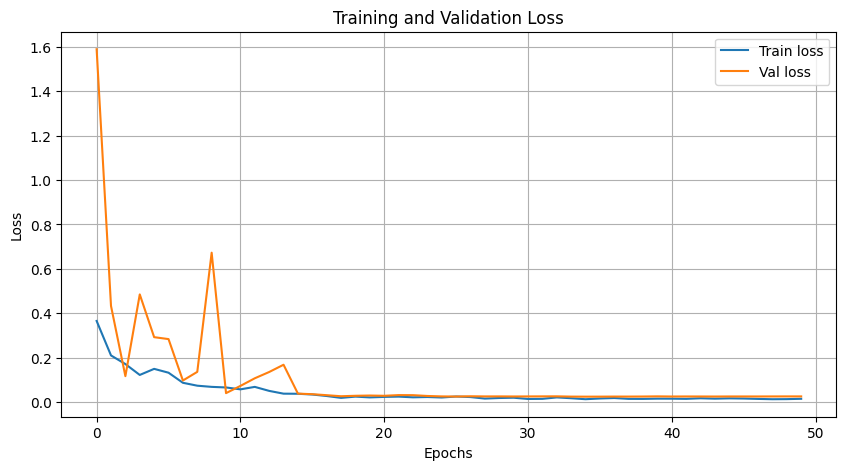

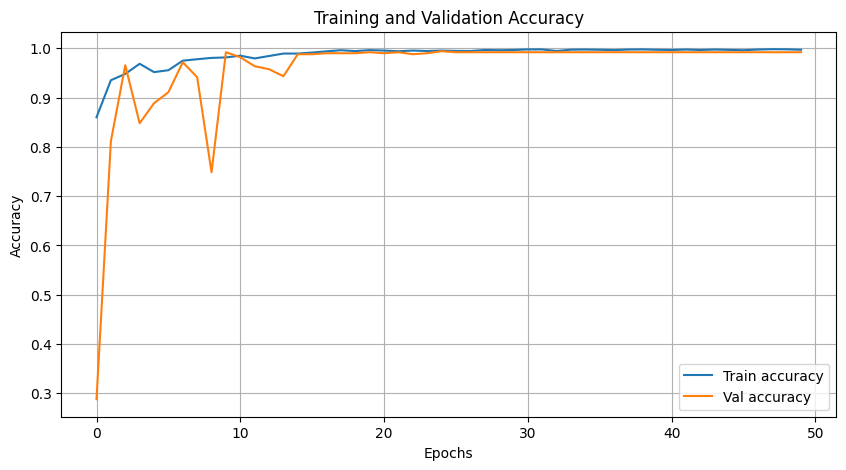

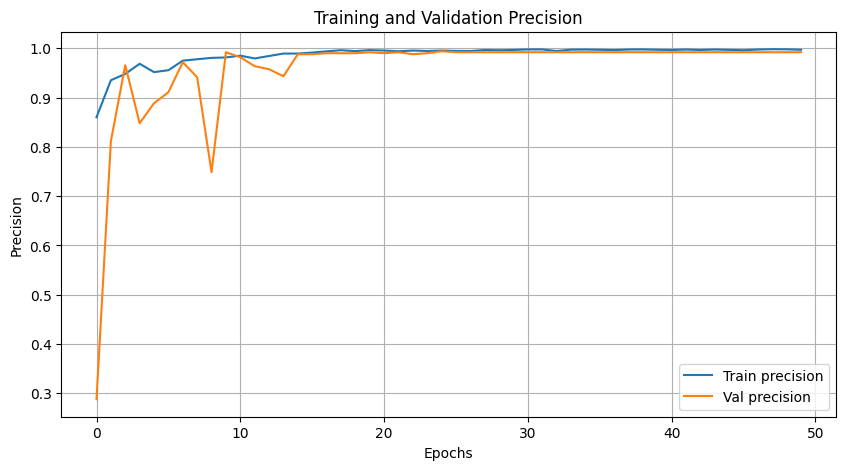

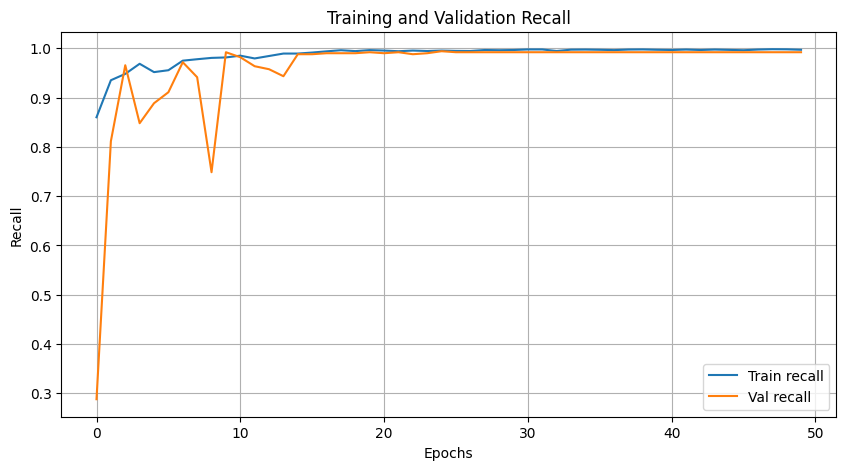

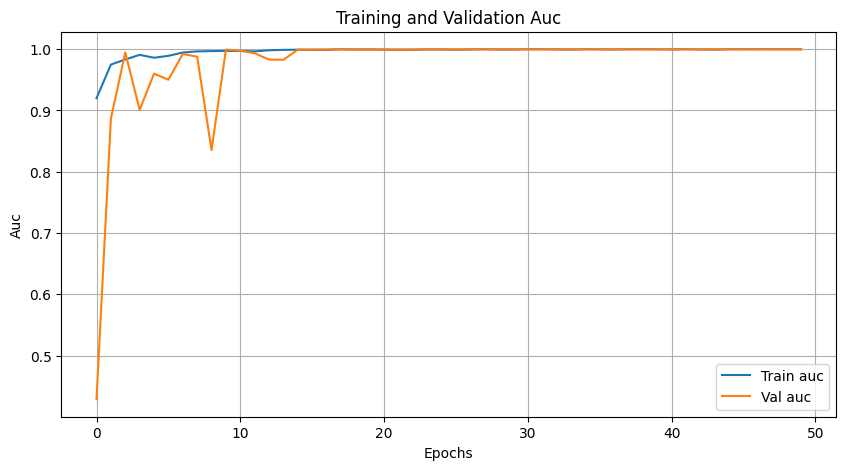

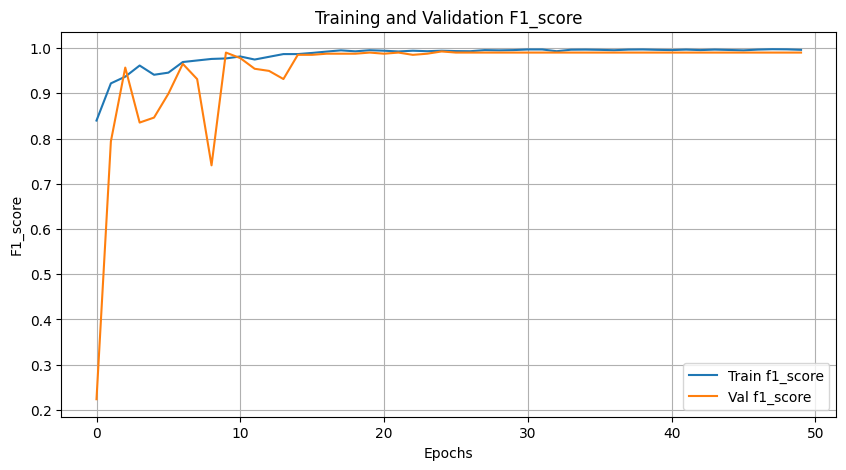

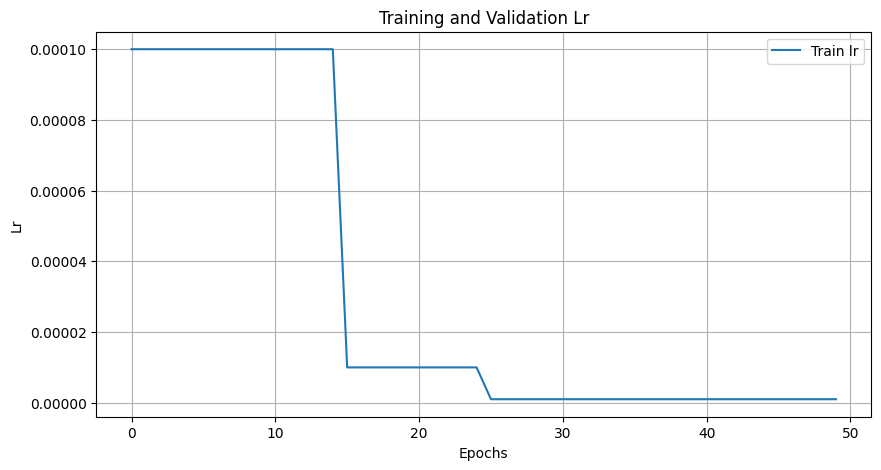

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('test_4_train_history.csv', index=False)

In [20]:
model.save('test_4.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=14172, TN=10057, FP=50, FN=123
Accuracy       : 0.9929
Precision      : 0.9965
Recall         : 0.9914
F1-Score       : 0.9939
AUC            : 0.9986
Binary Loss    : 0.0354
FDR (Fire Detection Rate)      : 99.14 %
EWR (Error Warning Rate)       : 0.71 %
Confusion Matrix:
[[10057    50]
 [  123 14172]]


{'TP': 14172,
 'TN': 10057,
 'FP': 50,
 'FN': 123,
 'accuracy': 0.9929104171789198,
 'precision': 0.9964843200675011,
 'recall': 0.991395592864638,
 'f1_score': 0.9939334432093136,
 'auc': 0.9985685415096591,
 'loss': 0.035438351185152525,
 'fdr': 99.1395592864638,
 'ewr': 0.7089582821080239,
 'confusion_matrix': array([[10057,    50],
        [  123, 14172]])}

In [22]:
model_best = load_model('test_4_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=14177, TN=10057, FP=50, FN=118
Accuracy       : 0.9931
Precision      : 0.9965
Recall         : 0.9917
F1-Score       : 0.9941
AUC            : 0.9985
Binary Loss    : 0.0348
FDR (Fire Detection Rate)      : 99.17 %
EWR (Error Warning Rate)       : 0.69 %
Confusion Matrix:
[[10057    50]
 [  118 14177]]


{'TP': 14177,
 'TN': 10057,
 'FP': 50,
 'FN': 118,
 'accuracy': 0.9931153184165232,
 'precision': 0.9964855556336544,
 'recall': 0.9917453655124169,
 'f1_score': 0.9941098099712503,
 'auc': 0.9985295498363385,
 'loss': 0.03477487749200274,
 'fdr': 99.17453655124169,
 'ewr': 0.6884681583476765,
 'confusion_matrix': array([[10057,    50],
        [  118, 14177]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24427, TN=14240, FP=117, FN=591
Accuracy       : 0.9820
Precision      : 0.9952
Recall         : 0.9764
F1-Score       : 0.9857
AUC            : 0.9989
Binary Loss    : 0.0740
FDR (Fire Detection Rate)      : 97.64 %
EWR (Error Warning Rate)       : 1.80 %
Confusion Matrix:
[[14240   117]
 [  591 24427]]


{'TP': 24427,
 'TN': 14240,
 'FP': 117,
 'FN': 591,
 'accuracy': 0.9820190476190476,
 'precision': 0.9952330508474576,
 'recall': 0.9763770085538412,
 'f1_score': 0.985714862192809,
 'auc': 0.9989456306371999,
 'loss': 0.07398916009356009,
 'fdr': 97.63770085538413,
 'ewr': 1.7980952380952382,
 'confusion_matrix': array([[14240,   117],
        [  591, 24427]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24468, TN=14237, FP=120, FN=550
Accuracy       : 0.9830
Precision      : 0.9951
Recall         : 0.9780
F1-Score       : 0.9865
AUC            : 0.9990
Binary Loss    : 0.0691
FDR (Fire Detection Rate)      : 97.80 %
EWR (Error Warning Rate)       : 1.70 %
Confusion Matrix:
[[14237   120]
 [  550 24468]]


{'TP': 24468,
 'TN': 14237,
 'FP': 120,
 'FN': 550,
 'accuracy': 0.982984126984127,
 'precision': 0.995119570522206,
 'recall': 0.9780158286034055,
 'f1_score': 0.9864935693262912,
 'auc': 0.9989995223220574,
 'loss': 0.06910613696225304,
 'fdr': 97.80158286034055,
 'ewr': 1.7015873015873015,
 'confusion_matrix': array([[14237,   120],
        [  550, 24468]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4696, TN=3268, FP=212, FN=441
Accuracy       : 0.9242
Precision      : 0.9568
Recall         : 0.9142
F1-Score       : 0.9350
AUC            : 0.9755
Binary Loss    : 0.2263
FDR (Fire Detection Rate)      : 91.42 %
EWR (Error Warning Rate)       : 7.58 %
Confusion Matrix:
[[3268  212]
 [ 441 4696]]


{'TP': 4696,
 'TN': 3268,
 'FP': 212,
 'FN': 441,
 'accuracy': 0.9242195659742369,
 'precision': 0.9568052159739201,
 'recall': 0.9141522289273896,
 'f1_score': 0.9349925335988054,
 'auc': 0.9754710585139588,
 'loss': 0.22627181937930174,
 'fdr': 91.41522289273895,
 'ewr': 7.578043402576302,
 'confusion_matrix': array([[3268,  212],
        [ 441, 4696]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4710, TN=3264, FP=216, FN=427
Accuracy       : 0.9254
Precision      : 0.9562
Recall         : 0.9169
F1-Score       : 0.9361
AUC            : 0.9749
Binary Loss    : 0.2187
FDR (Fire Detection Rate)      : 91.69 %
EWR (Error Warning Rate)       : 7.46 %
Confusion Matrix:
[[3264  216]
 [ 427 4710]]


{'TP': 4710,
 'TN': 3264,
 'FP': 216,
 'FN': 427,
 'accuracy': 0.9253800626668214,
 'precision': 0.9561510353227771,
 'recall': 0.9168775549931867,
 'f1_score': 0.9361025539103648,
 'auc': 0.9748563777776286,
 'loss': 0.21873459769301795,
 'fdr': 91.68775549931867,
 'ewr': 7.46199373331786,
 'confusion_matrix': array([[3264,  216],
        [ 427, 4710]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0018
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.0017758888691299473,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0018
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.001780975325078013,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7738, TN=7778, FP=2, FN=42
Accuracy       : 0.9972
Precision      : 0.9997
Recall         : 0.9946
F1-Score       : 0.9972
AUC            : 0.9993
Binary Loss    : 0.0233
FDR (Fire Detection Rate)      : 99.46 %
EWR (Error Warning Rate)       : 0.28 %
Confusion Matrix:
[[7778    2]
 [  42 7738]]


{'TP': 7738,
 'TN': 7778,
 'FP': 2,
 'FN': 42,
 'accuracy': 0.997172236503856,
 'precision': 0.9997416020671834,
 'recall': 0.9946015424164525,
 'f1_score': 0.9971649484536083,
 'auc': 0.999333932501107,
 'loss': 0.023311389521011642,
 'fdr': 99.46015424164526,
 'ewr': 0.2827763496143959,
 'confusion_matrix': array([[7778,    2],
        [  42, 7738]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7738, TN=7778, FP=2, FN=42
Accuracy       : 0.9972
Precision      : 0.9997
Recall         : 0.9946
F1-Score       : 0.9972
AUC            : 0.9993
Binary Loss    : 0.0228
FDR (Fire Detection Rate)      : 99.46 %
EWR (Error Warning Rate)       : 0.28 %
Confusion Matrix:
[[7778    2]
 [  42 7738]]


{'TP': 7738,
 'TN': 7778,
 'FP': 2,
 'FN': 42,
 'accuracy': 0.997172236503856,
 'precision': 0.9997416020671834,
 'recall': 0.9946015424164525,
 'f1_score': 0.9971649484536083,
 'auc': 0.9992983293792667,
 'loss': 0.02276964502862935,
 'fdr': 99.46015424164526,
 'ewr': 0.2827763496143959,
 'confusion_matrix': array([[7778,    2],
        [  42, 7738]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=556, TN=33, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0116
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 33   0]
 [  0 556]]


{'TP': 556,
 'TN': 33,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.011612749994553171,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 33,   0],
        [  0, 556]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=556, TN=33, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0156
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 33   0]
 [  0 556]]


{'TP': 556,
 'TN': 33,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.01555390368350734,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 33,   0],
        [  0, 556]])}